### Nome: Samuel Felipe dos Santos

# PROJET0 3 - GNG

<UL>
<LI>Experimentos da rede GNG com pelo menos 3 datasets;
<LI>Variar:
<UL>
<LI>Idade links;
<LI>Tempo para adição de neurônios;
<LI>Número de neurônios.
</UL>
<LI> Entregar relatório descrevendo os experimentos.
</UL>


## Metodologia

Nessa seção será descrita a metodologia experimental utilizada nesse trabalho, que teve como objetivo realizar experimentos com a rede GNG. 

Foram realizados experimentos variando idade máxima que as arestas podem atingir antes de serem removidas (se não forem renovadas), a quantidades de iterações da rede após a qual é adicionado um novo neurônio e a quantidade máxima de neurônios que podem ser adicionados na rede. Para escolher a melhor configuração da rede foram utilizados o erro quantitavo e o erro topográfico (adaptados da rede SOM implementada no projeto 2).

Para avaliar o que esta sendo aprendido pela rede foram gerados os gráficos Hit map, Heat maps e U-matrix para o melhor modelo encontrado, novamente adptando a implmentação do projeto 2 para funcionar com grafos.

O Heat map e Hit map foram gerados para cada classe dos datasets de forma separada, sendo possivel dessa forma verificar como os exemplos de cada uma dessas classes se comportam na representação dos dados gerada pela GNG.


### Bibliotecas utilizadas

Foi utilizada a linguagem de programação Python 3.0 em conjunto com as bibliotecas:
<UL>
    <LI> <b>Sklearn:</b> Possui rotinas de aprendizados de máquina;
    <LI> <b>Pandas:</b> Utilizada para criar e salvar as tabelas com os dados obtidos nos experimentos;
    <LI> <b>Neupy:</b> Uma biblioteca que possue implementações de redes neurais feitas sobre tensorflow;
    <LI> <b>networkx e Mathplotlib:</b> Possuem rotinas de criação de grafos. 
</UL>

In [2]:
import numpy as np
from math import exp, sqrt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import HTML
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from neupy.algorithms import GrowingNeuralGas
import networkx as nx

/home/samuel/Dropbox/Doutorado/Redes Neurais/Projetos/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/samuel/Dropbox/Doutorado/Redes Neurais/Projetos/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/samuel/Dropbox/Doutorado/Redes Neurais/Projetos/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("q

### Rede GNG Usada

Foi utilizada a implementação da <a href="http://neupy.com/apidocs/neupy.algorithms.competitive.growing_neural_gas.html">rede GNG presente na biblioteca Neupy</a>. 

Essa implementação tem como alguns dos seus principais parâmetors:
<UL>
    <LI> <b>n_inputs:</b> Dimensões dos de um exemplo da entrada;
    <LI> <b>n_start_node:</b> Número de neurônios com o qual a rede é inicializada, sendo por padrão 2;
    <LI> <b>step:</b> Taxa de aprendizado para o neurônio vencedor (BMU), 0.2 por padrão;
    <LI> <b>neighbour_step:</b> Taxa de aprendizado para os vizinhos do neurônio vencedor, 0.05 por padrão;
    <LI> <b>error_decay_rate:</b> Decaimento aplicado a todos neurônios após cada iteração da rede, padrão=0.995;
    <LI> <b>after_split_error_decay_rate:</b> Decaimento aplicado aos neuronios com o maior erro após a adição de um novo neurônio na rede, padrão=0.5;
    <LI> <b>max_edge_age:</b> Número de iterações máximo que uma aresta pode passar sem ser atualizada antes de ser removida, padrão=1000;
    <LI> <b>n_iter_before_neuron_added:</b> Número de iterações até que um novo neurônio seja adicionado, padrão=1000;
    <LI> <b>max_nodes:</b> Número máximo de nós que podem ser adicionado durante o treinamento. padrão=1000.
</UL>

Segue no código abaixo um pequeno exemplo da utilização dessa rede.

In [3]:
neural_gas = GrowingNeuralGas(n_inputs=4,
                              shuffle_data=True,
                              max_edge_age=10,
                              n_iter_before_neuron_added=50,
                              max_nodes=100)

data = np.array([[1,1,0,0],[0,0,0,1],[1,0,0,0],[0,0,1,1]])
neural_gas.fit( data, 100 )

GrowingNeuralGas(verbose=False, step=0.2, show_epoch=1, shuffle_data=True, signals=None, n_inputs=4, n_start_nodes=2, neighbour_step=0.05, max_edge_age=10, max_nodes=100, n_iter_before_neuron_added=50, after_split_error_decay_rate=0.5, error_decay_rate=0.995, min_distance_for_update=0.0)

Abaixo é mostrada a implementações de funções utilizadas para desenhar grafos com o nós e arestas criados pela rede GNG. 

- A função <i>decode_edges</i>  converte o formato da lista de arestas de <i>(pesos do nó 1, pesos do nó 2)</i> para <i>(identificador do nó 1, identificador do nó 2)</i>; 
- A função <i>adjacency_matrix</i> cria uma matrix de adjacência por meio das arestas e nós do grafo gerado pela GNG;
- A função <i>generate_graph</i> cria um grafo no formato da bibliotéca <i>networkx</i> tendo como entrada uma matriz de adjacências;
- A função <i>print_graph</i> realiza a impresão do grafo utilizando a bibliotéca <i>networkx</i>, representando as a intensidade dos nós por meio de cores (do azul para o mais baixo até o verde sendo o mais alto) e pela variação do tamanho. 

In [4]:
def decode_edges(graph):
    nodes = list(graph.nodes)
    edges = list(graph.edges.keys())
    edges_decoded = []
    for i in range(len(edges)):
        edge = [-1,-1]
        for j in range(len(nodes)):
            if edges[i][0] == nodes[j]:
                edge[0] = j
            if edges[i][1] == nodes[j]:
                edge[1] = j
        edges_decoded += [ edge ]
    return edges_decoded

def adjacency_matrix(edges, n_nodes):
    adj = np.zeros([n_nodes,n_nodes])
    for edge in edges:
        adj[edge[0], edge[1]] += 1
    return adj

def generate_graph(m):
    g = nx.from_numpy_matrix( m )
    pos = nx.spring_layout(g)
    return g, pos

def print_graph(g, pos, labels=True, values=None, base=100, multiplier=10, font_size=10, color_map = 'cool'):
    if not(values is None):
        values_map = {}
        for i in range(len(values)):
            values_map[i] = values[i]
        values *= multiplier
        values += base
        nx.draw(g, pos=pos, cmap=plt.get_cmap(color_map), node_color=values, labels =values_map, font_size=font_size, font_color='white', node_size=values)
    else:
        nx.draw(g,with_labels=labels, font_weight='bold')    

As funções a seguir foram adaptadas da projeto 2 da rede SOM, para possibilitara o calculo da erro de quantização e erro topológico sobre a rede GNG.

In [5]:
def distance(p, q):
    return sqrt(np.sum((p-q)**2))

def are_neighbors(edges, p, q):
    for (i,j) in edges:
        if (p == i and q == j) or (q == i and p == j):
            return True
    return False

def discriminant_function(nodes, input_sample):
    discriminant = np.zeros(len(nodes))
    for i in range(len(nodes)):
        discriminant[i] = np.sum(np.power(nodes[i].weight - input_sample, 2))
    return discriminant

def competitive_phase(nodes, input_sample):
    discriminant = discriminant_function( nodes, input_sample )
    BMU = np.unravel_index(discriminant.argmin(), discriminant.shape)
    return discriminant, np.array(BMU)

def quantization_error( graph, data):
    error = 0.0
    for i in range(len(data)):
        input_sample = data[i]
        BMU = competitive_phase(graph.nodes, input_sample)[1][0]
        error+= distance( graph.nodes[BMU].weight, input_sample)
    error /= len(data)
    return error

def topographical_error(graph, data):
    error = 0.0
    for i in range(len(data)):
        input_sample = data[i]
        discriminant, BMU = competitive_phase(graph.nodes, input_sample)
        BMU = BMU[0]
        discriminant[BMU] = len(graph.nodes)
        BMU2 = np.unravel_index(discriminant.argmin(), discriminant.shape)[0]
        edges = decode_edges(graph)
        if not are_neighbors(edges, BMU, BMU2):
            error += 1.0
    error /= len(data)
    return error

Abaixo é calculado o erro quantitativo e topográfico para o exemplo apresentado anteriormente.

In [6]:
qe = quantization_error(neural_gas.graph, data)
te = topographical_error(neural_gas.graph, data)
print('quantization error =', qe)
print('topographical error =', te)

quantization error = 2.0231968214719536e-05
topographical error = 0.0


Foram adaptadas também as implementados de métodos para gerar as matrizes que podem ser usadas para gerar os seguintes gráficos:
<UL>
<LI> <b> U-matrix</b>
<LI> <b> HeatMap</b>
<LI> <b> HitMap</b>
</UL>

In [7]:
def u_matrix(nodes, edges):
    um = np.zeros(len(nodes))
    for i in range( len(nodes) ):
        for j in range( len(nodes) ):
            if are_neighbors(edges, i, j):
                um[i] += distance(nodes[i].weight, nodes[j].weight)
    return um

In [8]:
def heatmap(nodes, sample): 
    hem = np.zeros(len(nodes))
    for i in range(len(nodes)):
        hem[i] = distance(nodes[i].weight, sample)
    return hem

In [9]:
def hitmap(nodes, edges, data):
    hm = np.zeros(len(nodes))    
    for i in range(len(data)):
        BMU = competitive_phase(nodes, data[i])[1][0]
        hm[BMU] += 1.0
    return hm

Abaixo é gerado a U-matrix, Heat map e Hit map para o exemplo mostrado anteriormente.

In [11]:
um  = u_matrix(neural_gas.graph.nodes, decode_edges(neural_gas.graph))
hem = heatmap(neural_gas.graph.nodes, data[0]) 
hm  = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), data )
g, pos = generate_graph( adjacency_matrix(decode_edges(neural_gas.graph), neural_gas.graph.n_nodes) )
print('u-matrix:',um)
print('heatmap:', hem)
print('hitmap:', hm)

u-matrix: [0.01032098 0.06986356 0.03764093 0.07008134 0.96011532 0.95235971
 0.85996893 0.85975115 0.0402063  0.14016267]
heatmap: [3.20980835e-07 1.99998209e+00 9.99999764e-01 1.73205074e+00
 9.62536109e-01 4.02066027e-02 1.73771616e+00 1.96598211e+00
 1.03212814e-02 1.73346970e+00]
hitmap: [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]


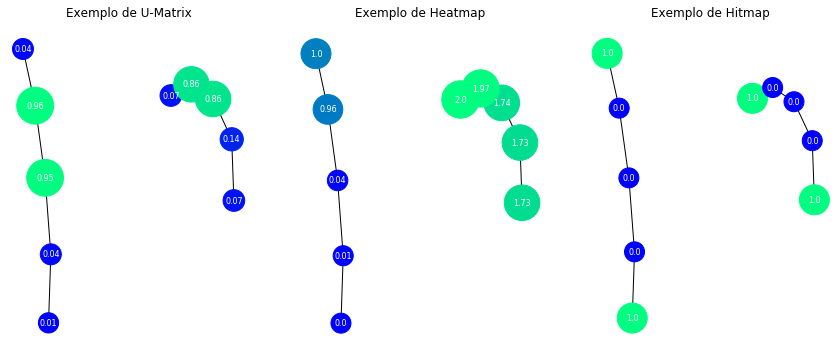

In [12]:
plt.figure(figsize=(20, 6))

plt.subplot(141)
plt.title('Exemplo de U-Matrix')
print_graph(g, pos, labels=True, values=um.round(decimals=2), base=400, multiplier=1000, font_size=8, color_map = 'winter')

plt.subplot(142)
plt.title('Exemplo de Heatmap')
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=400, multiplier=500, font_size=8, color_map='winter')

plt.subplot(143)
plt.title('Exemplo de Hitmap')
print_graph(g, pos, labels=True, values=hm,                    base=400, multiplier=500, font_size=8, color_map = 'winter')

### Datasets
Foram escolhidos os seguintes três datasets para avaliação dos resultados:
<UL>
<LI><b>Iris Dataset:</b> consiste de 50 amostras  de cada uma das 3 espécies da flor iris, que esta disponivel no pacote Sklearn;

<LI><b>Breast Cancer Wisconsin (Diagnostic) Dataset:</b> características computadas a partir de imagens biomédicas, e utilizadas para classificar se há câncer de mama, mais detalhes podem ser encontrados em 
<a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)">https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)</a>. Foi utilizada a versão disponibilizada no pacote Sklearn;

<LI><b>Alcohol QCM Sensor Dataset Dataset:</b> consiste de amostras de álcool que podem ser classificadas em 5 tipos (1-octanol, 1-propanol, 2-butanol, 2-propanol, 1-isobutanol). Os atributos de cada amostra consistem de medições realizadas por sensores com diferentes configurações, que atribuidas sobre a amostra no formato de gás em diferentes concentrações. Foi utilizado a versão do dataset disponível em <a href="https://archive.ics.uci.edu/ml/datasets/Alcohol+QCM+Sensor+Dataset">https://archive.ics.uci.edu/ml/datasets/Alcohol+QCM+Sensor+Dataset</a>, onde se encontram mais detalhes.
</UL>


### Pré-processamento dos dados

Os dados então são normalizados utilizando a função <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">StandardScaler</a> da biblioteca Sklearn, que realiza a seguinte operação:<br />
<br />
z = (x - u) / s<br />
<br />
Onde x é uma amostra, u é a média das amostras do treino e s o desvio padrão do treino.


In [10]:
def Normalize( X ):
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X

### Otimização dos Hiperparâmetros da Rede

Foram realizados experimentos variando os hiperparametros de idade máxima de uma aresta, número de iterações para a adição de um novo neurônio e o número máximo de neurônios que podem ser adicionados na rede, testando os valores mostrados no código abaixo, sendo os utilizados os valores padrão para os demais hiperparametros da rede. 

In [11]:
parameters = {
    'max_edge_age': [25, 50, 75,   100],
    'n_iter_before_neuron_added': [25,  50   , 75, 100  ],
    'max_nodes': [25, 50, 75, 100]
}

A busca pelos hiperparâmetros ideais foi realizada pela função <b>grid_serach</b> implementada a seguir. Ela realiza uma busca exaustiva sobre um dicionário de hiperparâmetros. Cada combinação de hiperparâmetros é utilizada para treinar a rede 3 vezes, obtendo um erro de quantização médio, erro de topográfico médio e o desvio padrão de ambos para cada combinação de hiperparâmetros.

In [12]:
def grid_search(parameters, data, repetitions=3, epochs=100):
    results = {
        'max_edge_age': [],
        'n_iter_before_neuron_added': [],
        'max_nodes': [],
        'quantization_error': [],
        'topographical_error': [],
        'quantization_error_std': [],
        'topographical_error_std': []
    }
    total = len(parameters['max_edge_age']) * len(parameters['n_iter_before_neuron_added']) * len(parameters['max_nodes']) * repetitions
    i=1
    for age in parameters['max_edge_age']:
        for n_iter in parameters['n_iter_before_neuron_added']:
            for m_nodes in parameters['max_nodes']:
                qe = []
                te = []
                for r in range(repetitions):
                    print(i, 'of', total, ':' , len(data[0]),age, n_iter, m_nodes, r )
                    
                    ng = GrowingNeuralGas(n_inputs=len(data[0]),
                              shuffle_data=True,
                              verbose=True,
                              max_edge_age=age,
                              n_iter_before_neuron_added=n_iter,
                              max_nodes=m_nodes)
                    ng.fit(data, epochs)
                    
                    q = quantization_error(ng.graph, data)
                    t = topographical_error(ng.graph, data)                            
                    print(q, t)
                    qe += [q]
                    te += [t]
                    i+=1
                qe_mean = np.mean(qe)
                qe_std = np.std(qe)
                te_mean = np.mean(te)
                te_std = np.std(te)
                results['max_edge_age'] += [age]    
                results['n_iter_before_neuron_added'] += [n_iter]
                results['max_nodes'] += [m_nodes]

                results['quantization_error'] += [qe_mean]
                results['topographical_error'] += [te_mean]
                results['quantization_error_std'] += [qe_std]
                results['topographical_error_std'] += [te_std]      
    return results

### Avaliação dos Resultados

Após a realização do grid search, são analisados os impactos dos hiperparâmetros escolhidos no resultada, sendo escolhido como melhor modelo o que obter o menor erro quantitativo, tendo como desempate o erro topográfico.

Para esse modelo, são gerados heatmaps, hitmap e u-matrix para entender com o objetivo de tentar entender como o grafo gerado pela GNG esta representando os dados dos exemplos de cada classe dos datasets.

## Resultados

### Dataset 1: Iris

In [13]:
def loadIris():
    iris = load_iris()
    return iris.data, iris.target
iris_X, iris_Y = loadIris()

In [14]:
iris_X = Normalize(iris_X)

In [50]:
results = grid_search(parameters, iris_X)

1 of 192 : 4 25 25 25 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [20 ms] train: 1.005255
#2 : [13 ms] train: 0.629205
#3 : [18 ms] train: 0.560789
#4 : [22 ms] train: 0.504789
#5 : [16 ms] train: 0.454157
#6 : [17 ms] train: 0.433851
#7 : [14 ms] train: 0.429728
#8 : [16 ms] train: 0.438404
#9 : [16 ms] train: 0.437329
#10 : [15 ms] train: 0.430386
#11 : [15 ms] train: 0.427957
#12 : [20 ms] train: 0.427399


#13 : [16 ms] train: 0.430200
#14 : [18 ms] train: 0.429903
#15 : [15 ms] train: 0.432206
#16 : [18 ms] train: 0.431620
#17 : [14 ms] train: 0.431619
#18 : [14 ms] train: 0.430295
#19 : [14 ms] train: 0.429893
#20 : [16 ms] train: 0.425521
#21 : [14 ms] train: 0.427182
#22 : [14 ms] train: 0.428138
#23 : [14 ms] train: 0.427350
#24 : [17 ms] train: 0.428885
#25 : [15 ms] train: 0.434257
#26 : [14 ms] train: 0.432613


#27 : [22 ms] train: 0.432439
#28 : [15 ms] train: 0.424863
#29 : [15 ms] train: 0.435891
#30 : [20 ms] train: 0.431144
#31 : [19 ms] train: 0.430011
#32 : [15 ms] train: 0.439379
#33 : [14 ms] train: 0.426862
#34 : [14 ms] train: 0.435595
#35 : [14 ms] train: 0.433219
#36 : [14 ms] train: 0.435947
#37 : [14 ms] train: 0.432474
#38 : [14 ms] train: 0.433394
#39 : [23 ms] train: 0.433782


#40 : [17 ms] train: 0.427620
#41 : [15 ms] train: 0.435604
#42 : [23 ms] train: 0.435251
#43 : [15 ms] train: 0.434546
#44 : [20 ms] train: 0.437681
#45 : [23 ms] train: 0.436997
#46 : [15 ms] train: 0.433902
#47 : [20 ms] train: 0.433327
#48 : [15 ms] train: 0.434547
#49 : [14 ms] train: 0.433270
#50 : [14 ms] train: 0.433441
#51 : [14 ms] train: 0.428100


#52 : [17 ms] train: 0.427608
#53 : [17 ms] train: 0.431774
#54 : [14 ms] train: 0.431607
#55 : [14 ms] train: 0.427250
#56 : [15 ms] train: 0.428052
#57 : [15 ms] train: 0.437804
#58 : [15 ms] train: 0.438273
#59 : [14 ms] train: 0.428384
#60 : [14 ms] train: 0.429114
#61 : [14 ms] train: 0.434060
#62 : [14 ms] train: 0.437545
#63 : [15 ms] train: 0.435561
#64 : [14 ms] train: 0.437926
#65 : [15 ms] train: 0.430546


#66 : [18 ms] train: 0.436075
#67 : [20 ms] train: 0.430491
#68 : [14 ms] train: 0.431797
#69 : [14 ms] train: 0.426200
#70 : [14 ms] train: 0.431017
#71 : [14 ms] train: 0.420705
#72 : [14 ms] train: 0.433944
#73 : [14 ms] train: 0.428362
#74 : [21 ms] train: 0.429391
#75 : [14 ms] train: 0.424515
#76 : [22 ms] train: 0.428555
#77 : [14 ms] train: 0.423808
#78 : [14 ms] train: 0.432543


#79 : [18 ms] train: 0.434761
#80 : [22 ms] train: 0.432555
#81 : [18 ms] train: 0.424829
#82 : [16 ms] train: 0.426367
#83 : [16 ms] train: 0.430388
#84 : [15 ms] train: 0.432588
#85 : [15 ms] train: 0.426904
#86 : [15 ms] train: 0.418128
#87 : [16 ms] train: 0.430650
#88 : [16 ms] train: 0.428719
#89 : [15 ms] train: 0.430270
#90 : [15 ms] train: 0.428034
#91 : [16 ms] train: 0.425102


#92 : [18 ms] train: 0.430090
#93 : [17 ms] train: 0.435188
#94 : [15 ms] train: 0.435130
#95 : [15 ms] train: 0.429420
#96 : [15 ms] train: 0.432818
#97 : [15 ms] train: 0.429448
#98 : [15 ms] train: 0.425155
#99 : [14 ms] train: 0.435688
#100 : [14 ms] train: 0.430053
0.40529617923262046 0.0
2 of 192 : 4 25 25 25 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 0.997625
#2 : [20 ms] train: 0.633317
#3 : [14 ms] train: 0.535785
#4 : [13 ms] train: 0.470711
#5 : [13 ms] train: 0.437506
#6 : [13 ms] train: 0.426128
#7 : [13 ms] train: 0.418518
#8 : [13 ms] train

#15 : [15 ms] train: 0.418252
#16 : [19 ms] train: 0.423107
#17 : [18 ms] train: 0.417048
#18 : [14 ms] train: 0.419801
#19 : [14 ms] train: 0.413202
#20 : [13 ms] train: 0.413778
#21 : [14 ms] train: 0.416977
#22 : [14 ms] train: 0.422890
#23 : [14 ms] train: 0.418265
#24 : [14 ms] train: 0.417263
#25 : [14 ms] train: 0.415782
#26 : [22 ms] train: 0.413010
#27 : [13 ms] train: 0.415504
#28 : [13 ms] train: 0.415677


#29 : [16 ms] train: 0.413360
#30 : [15 ms] train: 0.414828
#31 : [14 ms] train: 0.415632
#32 : [14 ms] train: 0.415338
#33 : [14 ms] train: 0.418614
#34 : [14 ms] train: 0.421325
#35 : [13 ms] train: 0.413927
#36 : [13 ms] train: 0.413290
#37 : [13 ms] train: 0.416571
#38 : [13 ms] train: 0.413236
#39 : [13 ms] train: 0.418236
#40 : [13 ms] train: 0.418282
#41 : [13 ms] train: 0.422896
#42 : [13 ms] train: 0.422193
#43 : [13 ms] train: 0.425668


#44 : [14 ms] train: 0.416379
#45 : [15 ms] train: 0.416666
#46 : [19 ms] train: 0.419160
#47 : [14 ms] train: 0.418573
#48 : [14 ms] train: 0.423435
#49 : [13 ms] train: 0.420575
#50 : [14 ms] train: 0.429084
#51 : [14 ms] train: 0.430429
#52 : [14 ms] train: 0.425131
#53 : [24 ms] train: 0.419672
#54 : [21 ms] train: 0.420032
#55 : [19 ms] train: 0.426157
#56 : [14 ms] train: 0.429851


#57 : [18 ms] train: 0.424726
#58 : [20 ms] train: 0.421143
#59 : [16 ms] train: 0.417266
#60 : [14 ms] train: 0.424348
#61 : [14 ms] train: 0.419974
#62 : [21 ms] train: 0.416644
#63 : [14 ms] train: 0.414654
#64 : [14 ms] train: 0.420604
#65 : [14 ms] train: 0.420355
#66 : [21 ms] train: 0.426879
#67 : [14 ms] train: 0.422057
#68 : [13 ms] train: 0.416837
#69 : [21 ms] train: 0.420287


#70 : [21 ms] train: 0.423415
#71 : [20 ms] train: 0.416987
#72 : [14 ms] train: 0.434626
#73 : [14 ms] train: 0.431173
#74 : [14 ms] train: 0.430723
#75 : [21 ms] train: 0.430228
#76 : [20 ms] train: 0.421576
#77 : [14 ms] train: 0.425549
#78 : [14 ms] train: 0.438486
#79 : [21 ms] train: 0.430150
#80 : [14 ms] train: 0.427131
#81 : [14 ms] train: 0.432672
#82 : [14 ms] train: 0.441672


#83 : [16 ms] train: 0.428436
#84 : [17 ms] train: 0.424452
#85 : [14 ms] train: 0.423026
#86 : [14 ms] train: 0.433290
#87 : [15 ms] train: 0.436854
#88 : [19 ms] train: 0.433885
#89 : [14 ms] train: 0.443487
#90 : [14 ms] train: 0.437136
#91 : [14 ms] train: 0.438908
#92 : [14 ms] train: 0.436517
#93 : [14 ms] train: 0.431708
#94 : [14 ms] train: 0.434070
#95 : [14 ms] train: 0.437382
#96 : [15 ms] train: 0.435429


#97 : [17 ms] train: 0.442737
#98 : [16 ms] train: 0.439876
#99 : [15 ms] train: 0.435028
#100 : [14 ms] train: 0.428125
0.4019340881353672 0.0
3 of 192 : 4 25 25 25 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.037784


#2 : [13 ms] train: 0.665328
#3 : [16 ms] train: 0.561181
#4 : [16 ms] train: 0.496060
#5 : [14 ms] train: 0.451693
#6 : [14 ms] train: 0.438897
#7 : [14 ms] train: 0.438112
#8 : [14 ms] train: 0.435607
#9 : [14 ms] train: 0.439585
#10 : [13 ms] train: 0.434141
#11 : [14 ms] train: 0.431439
#12 : [14 ms] train: 0.425128
#13 : [14 ms] train: 0.425680
#14 : [14 ms] train: 0.416708
#15 : [14 ms] train: 0.414927
#16 : [13 ms] train: 0.428736


#17 : [15 ms] train: 0.419697
#18 : [17 ms] train: 0.419195
#19 : [15 ms] train: 0.421832
#20 : [14 ms] train: 0.418235
#21 : [14 ms] train: 0.422646
#22 : [14 ms] train: 0.424301
#23 : [13 ms] train: 0.420808
#24 : [13 ms] train: 0.422281
#25 : [14 ms] train: 0.427349
#26 : [14 ms] train: 0.420581
#27 : [14 ms] train: 0.419338
#28 : [14 ms] train: 0.412407
#29 : [14 ms] train: 0.421015
#30 : [14 ms] train: 0.421978
#31 : [14 ms] train: 0.424949


#32 : [14 ms] train: 0.427798
#33 : [14 ms] train: 0.431710
#34 : [15 ms] train: 0.425763
#35 : [15 ms] train: 0.421508
#36 : [14 ms] train: 0.426192
#37 : [14 ms] train: 0.424796
#38 : [14 ms] train: 0.420505
#39 : [14 ms] train: 0.420255
#40 : [14 ms] train: 0.421779
#41 : [14 ms] train: 0.429324
#42 : [14 ms] train: 0.426303
#43 : [14 ms] train: 0.425084
#44 : [14 ms] train: 0.432302
#45 : [14 ms] train: 0.425776
#46 : [14 ms] train: 0.430863


#47 : [15 ms] train: 0.424675
#48 : [15 ms] train: 0.424511
#49 : [15 ms] train: 0.417108
#50 : [14 ms] train: 0.418235
#51 : [14 ms] train: 0.423351
#52 : [14 ms] train: 0.425465
#53 : [14 ms] train: 0.422366
#54 : [14 ms] train: 0.430669
#55 : [14 ms] train: 0.430976
#56 : [14 ms] train: 0.432992
#57 : [23 ms] train: 0.423493
#58 : [14 ms] train: 0.419878
#59 : [15 ms] train: 0.424493
#60 : [14 ms] train: 0.424911


#61 : [21 ms] train: 0.426092
#62 : [21 ms] train: 0.425180
#63 : [14 ms] train: 0.425091
#64 : [15 ms] train: 0.426976
#65 : [14 ms] train: 0.425822
#66 : [14 ms] train: 0.425627
#67 : [14 ms] train: 0.430349
#68 : [14 ms] train: 0.426530
#69 : [14 ms] train: 0.423901
#70 : [21 ms] train: 0.429145
#71 : [20 ms] train: 0.422131
#72 : [14 ms] train: 0.425934


#73 : [25 ms] train: 0.416891
#74 : [14 ms] train: 0.423799
#75 : [15 ms] train: 0.414469
#76 : [23 ms] train: 0.416992
#77 : [14 ms] train: 0.415603
#78 : [14 ms] train: 0.429252
#79 : [14 ms] train: 0.427445
#80 : [14 ms] train: 0.430117
#81 : [14 ms] train: 0.433701
#82 : [14 ms] train: 0.429956
#83 : [14 ms] train: 0.427805
#84 : [14 ms] train: 0.421989
#85 : [14 ms] train: 0.425010
#86 : [14 ms] train: 0.425700


#87 : [22 ms] train: 0.425181
#88 : [14 ms] train: 0.430791
#89 : [16 ms] train: 0.427035
#90 : [14 ms] train: 0.432379
#91 : [15 ms] train: 0.428166
#92 : [14 ms] train: 0.431031
#93 : [22 ms] train: 0.427243
#94 : [14 ms] train: 0.438072
#95 : [14 ms] train: 0.425538
#96 : [14 ms] train: 0.427162
#97 : [14 ms] train: 0.422815
#98 : [14 ms] train: 0.426240
#99 : [14 ms] train: 0.423312
#100 : [14 ms] train: 0.419209


0.3924271574719719 0.006666666666666667
4 of 192 : 4 25 25 50 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [15 ms] train: 0.975259
#2 : [13 ms] train: 0.653200
#3 : [13 ms] train: 0.542161
#4 : [14 ms] train: 0.479007
#5 : [22 ms] train: 0.435201
#6 : [15 ms] train: 0.395875
#7 : [15 ms] train: 0.360883
#8 : [16 ms] train: 0.334241
#9 : [16 ms] train: 0.311271
#10 : [16 ms] train: 0.300678
#11 : [16 ms] train: 0.297755


#12 : [27 ms] train: 0.286712
#13 : [17 ms] train: 0.287335
#14 : [24 ms] train: 0.286896
#15 : [17 ms] train: 0.282586
#16 : [16 ms] train: 0.287299
#17 : [16 ms] train: 0.285203
#18 : [16 ms] train: 0.284446
#19 : [16 ms] train: 0.285819
#20 : [17 ms] train: 0.286553
#21 : [17 ms] train: 0.288213
#22 : [20 ms] train: 0.287804


#23 : [25 ms] train: 0.287965
#24 : [19 ms] train: 0.287897
#25 : [16 ms] train: 0.287854
#26 : [17 ms] train: 0.283063
#27 : [16 ms] train: 0.288889
#28 : [17 ms] train: 0.286856
#29 : [16 ms] train: 0.285584
#30 : [16 ms] train: 0.290225
#31 : [17 ms] train: 0.288553
#32 : [17 ms] train: 0.291167
#33 : [16 ms] train: 0.288711
#34 : [16 ms] train: 0.289056


#35 : [19 ms] train: 0.284896
#36 : [31 ms] train: 0.289881
#37 : [17 ms] train: 0.288713
#38 : [18 ms] train: 0.286359
#39 : [17 ms] train: 0.287165
#40 : [17 ms] train: 0.288414
#41 : [17 ms] train: 0.287876
#42 : [17 ms] train: 0.288393
#43 : [17 ms] train: 0.288416
#44 : [16 ms] train: 0.288167
#45 : [16 ms] train: 0.289821
#46 : [16 ms] train: 0.288185


#47 : [19 ms] train: 0.286091
#48 : [17 ms] train: 0.290038
#49 : [17 ms] train: 0.289126
#50 : [18 ms] train: 0.290323
#51 : [19 ms] train: 0.289693
#52 : [17 ms] train: 0.286715
#53 : [17 ms] train: 0.290380
#54 : [23 ms] train: 0.291473
#55 : [17 ms] train: 0.290479
#56 : [17 ms] train: 0.288034
#57 : [17 ms] train: 0.289146
#58 : [17 ms] train: 0.289630


#59 : [19 ms] train: 0.290211
#60 : [18 ms] train: 0.290397
#61 : [16 ms] train: 0.288245
#62 : [18 ms] train: 0.293579
#63 : [17 ms] train: 0.292249
#64 : [16 ms] train: 0.289093
#65 : [17 ms] train: 0.292740
#66 : [17 ms] train: 0.291474
#67 : [17 ms] train: 0.292413
#68 : [16 ms] train: 0.292270
#69 : [17 ms] train: 0.290838
#70 : [16 ms] train: 0.291917
#71 : [17 ms] train: 0.292036


#72 : [18 ms] train: 0.291022
#73 : [17 ms] train: 0.290831
#74 : [17 ms] train: 0.292342
#75 : [17 ms] train: 0.290189
#76 : [17 ms] train: 0.292378
#77 : [17 ms] train: 0.292946
#78 : [17 ms] train: 0.292712
#79 : [16 ms] train: 0.294247
#80 : [16 ms] train: 0.291428
#81 : [24 ms] train: 0.294691
#82 : [23 ms] train: 0.289467
#83 : [17 ms] train: 0.291206


#84 : [20 ms] train: 0.290811
#85 : [18 ms] train: 0.290783
#86 : [20 ms] train: 0.291754
#87 : [17 ms] train: 0.292936
#88 : [24 ms] train: 0.288811
#89 : [19 ms] train: 0.287209
#90 : [17 ms] train: 0.291322
#91 : [17 ms] train: 0.291003
#92 : [25 ms] train: 0.290252
#93 : [18 ms] train: 0.287849
#94 : [17 ms] train: 0.291292


#95 : [20 ms] train: 0.290221
#96 : [22 ms] train: 0.288838
#97 : [19 ms] train: 0.291331
#98 : [18 ms] train: 0.288576
#99 : [17 ms] train: 0.289530
#100 : [16 ms] train: 0.287596


0.26590590019530314 0.0
5 of 192 : 4 25 25 50 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 0.998123
#2 : [12 ms] train: 0.636708
#3 : [16 ms] train: 0.545986
#4 : [14 ms] train: 0.470976
#5 : [21 ms] train: 0.428526
#6 : [15 ms] train: 0.395102
#7 : [16 ms] train: 0.370066
#8 : [17 ms] train: 0.344549
#9 : [17 ms] train: 0.325440
#10 : [17 ms] train: 0.317325
#11 : [17 ms] train: 0.308809
#12 : [17 ms] train: 0.306055


#13 : [26 ms] train: 0.305665
#14 : [18 ms] train: 0.296670
#15 : [17 ms] train: 0.294560
#16 : [17 ms] train: 0.292468
#17 : [17 ms] train: 0.289201
#18 : [17 ms] train: 0.289404
#19 : [26 ms] train: 0.289764
#20 : [24 ms] train: 0.291510
#21 : [17 ms] train: 0.287195
#22 : [22 ms] train: 0.286878
#23 : [17 ms] train: 0.289579


#24 : [25 ms] train: 0.288877
#25 : [19 ms] train: 0.287776
#26 : [17 ms] train: 0.287505
#27 : [17 ms] train: 0.290101
#28 : [17 ms] train: 0.287529
#29 : [26 ms] train: 0.284640
#30 : [17 ms] train: 0.288192
#31 : [17 ms] train: 0.284378
#32 : [17 ms] train: 0.289707
#33 : [17 ms] train: 0.284671
#34 : [17 ms] train: 0.288651
#35 : [17 ms] train: 0.288040


#36 : [23 ms] train: 0.293480
#37 : [21 ms] train: 0.282903
#38 : [17 ms] train: 0.290579
#39 : [17 ms] train: 0.287202
#40 : [17 ms] train: 0.287928
#41 : [17 ms] train: 0.286055
#42 : [26 ms] train: 0.284407
#43 : [27 ms] train: 0.287370
#44 : [25 ms] train: 0.282913
#45 : [18 ms] train: 0.287065


#46 : [22 ms] train: 0.284612
#47 : [22 ms] train: 0.278517
#48 : [19 ms] train: 0.282655
#49 : [16 ms] train: 0.281425
#50 : [17 ms] train: 0.282806
#51 : [17 ms] train: 0.282339
#52 : [17 ms] train: 0.283097
#53 : [17 ms] train: 0.282055
#54 : [26 ms] train: 0.283103
#55 : [25 ms] train: 0.282205


#56 : [25 ms] train: 0.283914
#57 : [20 ms] train: 0.284107
#58 : [19 ms] train: 0.286088
#59 : [17 ms] train: 0.285498
#60 : [17 ms] train: 0.282393
#61 : [17 ms] train: 0.284875
#62 : [24 ms] train: 0.286247
#63 : [16 ms] train: 0.284754
#64 : [17 ms] train: 0.281939
#65 : [17 ms] train: 0.283945
#66 : [17 ms] train: 0.286765
#67 : [21 ms] train: 0.285761


#68 : [25 ms] train: 0.285207
#69 : [27 ms] train: 0.282282
#70 : [21 ms] train: 0.283661
#71 : [17 ms] train: 0.283993
#72 : [16 ms] train: 0.286032
#73 : [17 ms] train: 0.285813
#74 : [16 ms] train: 0.280832
#75 : [16 ms] train: 0.282565
#76 : [18 ms] train: 0.282313
#77 : [25 ms] train: 0.286071
#78 : [24 ms] train: 0.282388


#79 : [18 ms] train: 0.283238
#80 : [19 ms] train: 0.283342
#81 : [17 ms] train: 0.284034
#82 : [17 ms] train: 0.284099
#83 : [17 ms] train: 0.286140
#84 : [17 ms] train: 0.282287
#85 : [17 ms] train: 0.283608
#86 : [17 ms] train: 0.284004
#87 : [17 ms] train: 0.284354
#88 : [16 ms] train: 0.281772
#89 : [16 ms] train: 0.284309
#90 : [16 ms] train: 0.283360


#91 : [17 ms] train: 0.285649
#92 : [18 ms] train: 0.284577
#93 : [19 ms] train: 0.285253
#94 : [17 ms] train: 0.282705
#95 : [17 ms] train: 0.286913
#96 : [16 ms] train: 0.280215
#97 : [24 ms] train: 0.283491
#98 : [17 ms] train: 0.282000
#99 : [17 ms] train: 0.282624
#100 : [16 ms] train: 0.284975


0.25993032049036535 0.0
6 of 192 : 4 25 25 50 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 0.990566
#2 : [16 ms] train: 0.630255
#3 : [15 ms] train: 0.552451
#4 : [14 ms] train: 0.490769
#5 : [15 ms] train: 0.447596
#6 : [15 ms] train: 0.420578
#7 : [16 ms] train: 0.383752
#8 : [17 ms] train: 0.346914
#9 : [17 ms] train: 0.325497
#10 : [17 ms] train: 0.319817
#11 : [16 ms] train: 0.310083
#12 : [16 ms] train: 0.304341


#13 : [18 ms] train: 0.303202
#14 : [25 ms] train: 0.301681
#15 : [17 ms] train: 0.300391
#16 : [17 ms] train: 0.299867
#17 : [16 ms] train: 0.296063
#18 : [16 ms] train: 0.295883
#19 : [16 ms] train: 0.295790
#20 : [16 ms] train: 0.299351
#21 : [16 ms] train: 0.296449
#22 : [16 ms] train: 0.293967
#23 : [16 ms] train: 0.291051
#24 : [16 ms] train: 0.295022


#25 : [24 ms] train: 0.292304
#26 : [19 ms] train: 0.294107
#27 : [19 ms] train: 0.292137
#28 : [16 ms] train: 0.292510
#29 : [16 ms] train: 0.292741
#30 : [16 ms] train: 0.290708
#31 : [16 ms] train: 0.291537
#32 : [17 ms] train: 0.292513
#33 : [16 ms] train: 0.294909
#34 : [16 ms] train: 0.295659
#35 : [16 ms] train: 0.289861
#36 : [16 ms] train: 0.294776


#37 : [17 ms] train: 0.291395
#38 : [24 ms] train: 0.292551
#39 : [20 ms] train: 0.294948
#40 : [16 ms] train: 0.291146
#41 : [16 ms] train: 0.293048
#42 : [16 ms] train: 0.291799
#43 : [24 ms] train: 0.292148
#44 : [16 ms] train: 0.290251
#45 : [16 ms] train: 0.289678
#46 : [16 ms] train: 0.291355
#47 : [16 ms] train: 0.292939
#48 : [16 ms] train: 0.289990


#49 : [20 ms] train: 0.290911
#50 : [18 ms] train: 0.291682
#51 : [17 ms] train: 0.288816
#52 : [17 ms] train: 0.289171
#53 : [16 ms] train: 0.289663
#54 : [16 ms] train: 0.289822
#55 : [16 ms] train: 0.292868
#56 : [24 ms] train: 0.291206
#57 : [24 ms] train: 0.288652
#58 : [16 ms] train: 0.290403
#59 : [25 ms] train: 0.294477


#60 : [18 ms] train: 0.290980
#61 : [18 ms] train: 0.294846
#62 : [16 ms] train: 0.290570
#63 : [17 ms] train: 0.290617
#64 : [17 ms] train: 0.290500
#65 : [25 ms] train: 0.290732
#66 : [16 ms] train: 0.291113
#67 : [16 ms] train: 0.291162
#68 : [16 ms] train: 0.292673
#69 : [16 ms] train: 0.291821
#70 : [16 ms] train: 0.289961
#71 : [16 ms] train: 0.290821


#72 : [18 ms] train: 0.290708
#73 : [18 ms] train: 0.289578
#74 : [17 ms] train: 0.289561
#75 : [16 ms] train: 0.288172
#76 : [16 ms] train: 0.290729
#77 : [16 ms] train: 0.288606
#78 : [16 ms] train: 0.292974
#79 : [16 ms] train: 0.290517
#80 : [16 ms] train: 0.290567
#81 : [16 ms] train: 0.288652
#82 : [16 ms] train: 0.289217
#83 : [16 ms] train: 0.291486


#84 : [27 ms] train: 0.289152
#85 : [20 ms] train: 0.290217
#86 : [16 ms] train: 0.293023
#87 : [16 ms] train: 0.289850
#88 : [16 ms] train: 0.292348
#89 : [16 ms] train: 0.289936
#90 : [16 ms] train: 0.290079
#91 : [24 ms] train: 0.288623
#92 : [16 ms] train: 0.289079
#93 : [16 ms] train: 0.290585
#94 : [16 ms] train: 0.291646
#95 : [24 ms] train: 0.291692


#96 : [21 ms] train: 0.289497
#97 : [17 ms] train: 0.289424
#98 : [17 ms] train: 0.288821
#99 : [16 ms] train: 0.291221
#100 : [26 ms] train: 0.290905


0.2654754298925954 0.0
7 of 192 : 4 25 25 75 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 0.978307
#2 : [24 ms] train: 0.639159
#3 : [13 ms] train: 0.543943
#4 : [14 ms] train: 0.478575
#5 : [14 ms] train: 0.438505
#6 : [15 ms] train: 0.397816
#7 : [16 ms] train: 0.374417
#8 : [17 ms] train: 0.346256
#9 : [17 ms] train: 0.318754
#10 : [18 ms] train: 0.301879
#11 : [18 ms] train: 0.280062
#12 : [19 ms] train: 0.261145


#13 : [22 ms] train: 0.246227
#14 : [22 ms] train: 0.237570
#15 : [21 ms] train: 0.234555
#16 : [20 ms] train: 0.231505
#17 : [19 ms] train: 0.229687
#18 : [19 ms] train: 0.228157
#19 : [19 ms] train: 0.223539
#20 : [19 ms] train: 0.223720
#21 : [20 ms] train: 0.221789
#22 : [20 ms] train: 0.220848
#23 : [19 ms] train: 0.218684


#24 : [23 ms] train: 0.218402
#25 : [21 ms] train: 0.218515
#26 : [19 ms] train: 0.217617
#27 : [20 ms] train: 0.215896
#28 : [19 ms] train: 0.214615
#29 : [19 ms] train: 0.215217
#30 : [19 ms] train: 0.213943
#31 : [19 ms] train: 0.211340
#32 : [19 ms] train: 0.209377
#33 : [19 ms] train: 0.210125
#34 : [19 ms] train: 0.208945


#35 : [28 ms] train: 0.210210
#36 : [22 ms] train: 0.208464
#37 : [19 ms] train: 0.208534
#38 : [19 ms] train: 0.208114
#39 : [19 ms] train: 0.209493
#40 : [19 ms] train: 0.209642
#41 : [19 ms] train: 0.209764
#42 : [26 ms] train: 0.210559
#43 : [19 ms] train: 0.208158
#44 : [19 ms] train: 0.207519
#45 : [19 ms] train: 0.208060


#46 : [23 ms] train: 0.207729
#47 : [20 ms] train: 0.208753
#48 : [28 ms] train: 0.208075
#49 : [26 ms] train: 0.208620
#50 : [19 ms] train: 0.207532
#51 : [19 ms] train: 0.205931
#52 : [19 ms] train: 0.207785
#53 : [19 ms] train: 0.207601
#54 : [19 ms] train: 0.205697
#55 : [19 ms] train: 0.207105


#56 : [29 ms] train: 0.207016
#57 : [20 ms] train: 0.206097
#58 : [19 ms] train: 0.205917
#59 : [27 ms] train: 0.206636
#60 : [19 ms] train: 0.206550
#61 : [19 ms] train: 0.206741
#62 : [19 ms] train: 0.208284
#63 : [20 ms] train: 0.208028
#64 : [19 ms] train: 0.206841
#65 : [19 ms] train: 0.207327
#66 : [19 ms] train: 0.207927


#67 : [26 ms] train: 0.207984
#68 : [19 ms] train: 0.205910
#69 : [19 ms] train: 0.207966
#70 : [19 ms] train: 0.207535
#71 : [19 ms] train: 0.207305
#72 : [26 ms] train: 0.207141
#73 : [26 ms] train: 0.207971
#74 : [19 ms] train: 0.205221
#75 : [19 ms] train: 0.207620
#76 : [19 ms] train: 0.206122


#77 : [22 ms] train: 0.207353
#78 : [24 ms] train: 0.207674
#79 : [19 ms] train: 0.207189
#80 : [19 ms] train: 0.206498
#81 : [19 ms] train: 0.206976
#82 : [19 ms] train: 0.206260
#83 : [26 ms] train: 0.206921
#84 : [19 ms] train: 0.206279
#85 : [19 ms] train: 0.207468
#86 : [19 ms] train: 0.205068


#87 : [21 ms] train: 0.206917
#88 : [23 ms] train: 0.206249
#89 : [21 ms] train: 0.206050
#90 : [19 ms] train: 0.205095
#91 : [27 ms] train: 0.205996
#92 : [27 ms] train: 0.206673
#93 : [19 ms] train: 0.205763
#94 : [19 ms] train: 0.207191
#95 : [19 ms] train: 0.205891
#96 : [27 ms] train: 0.206199


#97 : [28 ms] train: 0.206942
#98 : [19 ms] train: 0.205223
#99 : [19 ms] train: 0.206938
#100 : [19 ms] train: 0.205980
0.18777237935250737 0.0
8 of 192 : 4 25 25 75 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 0.935084
#2 : [13 ms] train: 0.670780
#3 : [23 ms] train: 0.564483
#4 : [16 ms] train: 0.506091
#5 : [15 ms] train: 0.458979
#6 : [15 ms] train: 0.411528
#7 : [22 ms] train: 0.374179
#8 : [17 ms] train: 0.346223
#9 : [17 ms] train: 0.322303
#10 : [18 ms] train: 0.299140
#11 : [19 ms] train: 0.282076


#12 : [21 ms] train: 0.268342
#13 : [22 ms] train: 0.256273
#14 : [21 ms] train: 0.246267
#15 : [21 ms] train: 0.240312
#16 : [20 ms] train: 0.234720
#17 : [19 ms] train: 0.234175
#18 : [19 ms] train: 0.230501
#19 : [19 ms] train: 0.227987
#20 : [19 ms] train: 0.224595
#21 : [19 ms] train: 0.221252
#22 : [19 ms] train: 0.220758


#23 : [25 ms] train: 0.219054
#24 : [35 ms] train: 0.217443
#25 : [19 ms] train: 0.216578
#26 : [20 ms] train: 0.215738
#27 : [19 ms] train: 0.214867
#28 : [19 ms] train: 0.217001
#29 : [19 ms] train: 0.215145
#30 : [19 ms] train: 0.213986
#31 : [19 ms] train: 0.213963
#32 : [19 ms] train: 0.212859


#33 : [20 ms] train: 0.212702
#34 : [21 ms] train: 0.212944
#35 : [20 ms] train: 0.212551
#36 : [19 ms] train: 0.210610
#37 : [19 ms] train: 0.211681
#38 : [19 ms] train: 0.211835
#39 : [19 ms] train: 0.211238
#40 : [19 ms] train: 0.211615
#41 : [19 ms] train: 0.211039
#42 : [19 ms] train: 0.209695
#43 : [19 ms] train: 0.211360


#44 : [20 ms] train: 0.212392
#45 : [27 ms] train: 0.213377
#46 : [23 ms] train: 0.211311
#47 : [20 ms] train: 0.210076
#48 : [19 ms] train: 0.211108
#49 : [28 ms] train: 0.210184
#50 : [19 ms] train: 0.209008
#51 : [19 ms] train: 0.210240
#52 : [28 ms] train: 0.209818


#53 : [20 ms] train: 0.210261
#54 : [23 ms] train: 0.210690
#55 : [19 ms] train: 0.209122
#56 : [24 ms] train: 0.209725
#57 : [19 ms] train: 0.208746
#58 : [19 ms] train: 0.209502
#59 : [19 ms] train: 0.209938
#60 : [19 ms] train: 0.210719
#61 : [19 ms] train: 0.208830
#62 : [20 ms] train: 0.208897
#63 : [19 ms] train: 0.209427


#64 : [27 ms] train: 0.209533
#65 : [19 ms] train: 0.208975
#66 : [19 ms] train: 0.209800
#67 : [22 ms] train: 0.208587
#68 : [19 ms] train: 0.208027
#69 : [19 ms] train: 0.207868
#70 : [19 ms] train: 0.206440
#71 : [19 ms] train: 0.207205
#72 : [19 ms] train: 0.205446
#73 : [19 ms] train: 0.205960
#74 : [19 ms] train: 0.206008


#75 : [27 ms] train: 0.206164
#76 : [20 ms] train: 0.206392
#77 : [19 ms] train: 0.205348
#78 : [28 ms] train: 0.204698
#79 : [20 ms] train: 0.206349
#80 : [25 ms] train: 0.207034
#81 : [19 ms] train: 0.204741
#82 : [19 ms] train: 0.206278
#83 : [19 ms] train: 0.205273
#84 : [19 ms] train: 0.205696


#85 : [20 ms] train: 0.205787
#86 : [21 ms] train: 0.206039
#87 : [19 ms] train: 0.205427
#88 : [19 ms] train: 0.206973
#89 : [20 ms] train: 0.206067
#90 : [19 ms] train: 0.205835
#91 : [19 ms] train: 0.204612
#92 : [20 ms] train: 0.204898
#93 : [27 ms] train: 0.204138
#94 : [28 ms] train: 0.205133


#95 : [25 ms] train: 0.204727
#96 : [19 ms] train: 0.204336
#97 : [19 ms] train: 0.204770
#98 : [34 ms] train: 0.205713
#99 : [22 ms] train: 0.204913
#100 : [19 ms] train: 0.204689


0.1865044832283929 0.0
9 of 192 : 4 25 25 75 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 0.954142
#2 : [12 ms] train: 0.660936
#3 : [13 ms] train: 0.544614
#4 : [14 ms] train: 0.493518
#5 : [21 ms] train: 0.439739
#6 : [23 ms] train: 0.404420
#7 : [26 ms] train: 0.380009
#8 : [17 ms] train: 0.352303
#9 : [17 ms] train: 0.333379
#10 : [18 ms] train: 0.308835
#11 : [18 ms] train: 0.284538


#12 : [23 ms] train: 0.272401
#13 : [21 ms] train: 0.259691
#14 : [20 ms] train: 0.252610
#15 : [19 ms] train: 0.248921
#16 : [19 ms] train: 0.245469
#17 : [19 ms] train: 0.240177
#18 : [19 ms] train: 0.236036
#19 : [25 ms] train: 0.234881
#20 : [19 ms] train: 0.233921
#21 : [19 ms] train: 0.234695
#22 : [19 ms] train: 0.233080


#23 : [24 ms] train: 0.232400
#24 : [22 ms] train: 0.233017
#25 : [19 ms] train: 0.231245
#26 : [19 ms] train: 0.230062
#27 : [19 ms] train: 0.227140
#28 : [19 ms] train: 0.224447
#29 : [19 ms] train: 0.225887
#30 : [26 ms] train: 0.226642
#31 : [19 ms] train: 0.225106
#32 : [19 ms] train: 0.222774
#33 : [19 ms] train: 0.221161


#34 : [23 ms] train: 0.223288
#35 : [20 ms] train: 0.222089
#36 : [19 ms] train: 0.219311
#37 : [19 ms] train: 0.217964
#38 : [19 ms] train: 0.219414
#39 : [19 ms] train: 0.218032
#40 : [19 ms] train: 0.219796
#41 : [19 ms] train: 0.219198
#42 : [19 ms] train: 0.218762
#43 : [19 ms] train: 0.218584
#44 : [19 ms] train: 0.217619


#45 : [29 ms] train: 0.218376
#46 : [20 ms] train: 0.218156
#47 : [19 ms] train: 0.217624
#48 : [19 ms] train: 0.218168
#49 : [25 ms] train: 0.215188
#50 : [19 ms] train: 0.213749
#51 : [19 ms] train: 0.215455
#52 : [19 ms] train: 0.215050
#53 : [19 ms] train: 0.214275
#54 : [19 ms] train: 0.215254
#55 : [19 ms] train: 0.212769


#56 : [23 ms] train: 0.212716
#57 : [20 ms] train: 0.213850
#58 : [19 ms] train: 0.212935
#59 : [19 ms] train: 0.211138
#60 : [19 ms] train: 0.212679
#61 : [19 ms] train: 0.211556
#62 : [18 ms] train: 0.211482
#63 : [19 ms] train: 0.210626
#64 : [19 ms] train: 0.211916
#65 : [18 ms] train: 0.210348
#66 : [19 ms] train: 0.211345


#67 : [23 ms] train: 0.212186
#68 : [29 ms] train: 0.211609
#69 : [19 ms] train: 0.208999
#70 : [27 ms] train: 0.210934
#71 : [19 ms] train: 0.210105
#72 : [19 ms] train: 0.211764
#73 : [19 ms] train: 0.210808
#74 : [19 ms] train: 0.211513
#75 : [19 ms] train: 0.210948
#76 : [19 ms] train: 0.210301


#77 : [24 ms] train: 0.210722
#78 : [21 ms] train: 0.208681
#79 : [19 ms] train: 0.209846
#80 : [19 ms] train: 0.209966
#81 : [19 ms] train: 0.211510
#82 : [19 ms] train: 0.210300
#83 : [19 ms] train: 0.210451
#84 : [19 ms] train: 0.212132
#85 : [19 ms] train: 0.210218
#86 : [19 ms] train: 0.211511
#87 : [19 ms] train: 0.209665


#88 : [23 ms] train: 0.210533
#89 : [20 ms] train: 0.210694
#90 : [19 ms] train: 0.210001
#91 : [19 ms] train: 0.210449
#92 : [19 ms] train: 0.210079
#93 : [25 ms] train: 0.209311
#94 : [19 ms] train: 0.209144
#95 : [19 ms] train: 0.209521
#96 : [19 ms] train: 0.210265
#97 : [19 ms] train: 0.208785
#98 : [19 ms] train: 0.211062


#99 : [22 ms] train: 0.210596
#100 : [19 ms] train: 0.210288
0.19194632088892571 0.0
10 of 192 : 4 25 25 100 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 1.039451
#2 : [15 ms] train: 0.640969
#3 : [13 ms] train: 0.538450
#4 : [13 ms] train: 0.475886
#5 : [13 ms] train: 0.434708
#6 : [24 ms] train: 0.400559
#7 : [16 ms] train: 0.373817
#8 : [16 ms] train: 0.341784
#9 : [17 ms] train: 0.317053
#10 : [18 ms] train: 0.302827
#11 : [18 ms] train: 0.286808


#12 : [20 ms] train: 0.273547
#13 : [24 ms] train: 0.260652
#14 : [23 ms] train: 0.245392
#15 : [23 ms] train: 0.236150
#16 : [23 ms] train: 0.226399
#17 : [22 ms] train: 0.214991
#18 : [22 ms] train: 0.204790
#19 : [22 ms] train: 0.197379
#20 : [22 ms] train: 0.193094


#21 : [23 ms] train: 0.187574
#22 : [27 ms] train: 0.182747
#23 : [25 ms] train: 0.178943
#24 : [22 ms] train: 0.173633
#25 : [21 ms] train: 0.173289
#26 : [22 ms] train: 0.172746
#27 : [22 ms] train: 0.170508
#28 : [30 ms] train: 0.169562
#29 : [22 ms] train: 0.167293


#30 : [23 ms] train: 0.167198
#31 : [28 ms] train: 0.165274
#32 : [23 ms] train: 0.164757
#33 : [22 ms] train: 0.164474
#34 : [21 ms] train: 0.163665
#35 : [22 ms] train: 0.163303
#36 : [21 ms] train: 0.161838
#37 : [21 ms] train: 0.159848
#38 : [21 ms] train: 0.159413


#39 : [23 ms] train: 0.159585
#40 : [23 ms] train: 0.158227
#41 : [23 ms] train: 0.157131
#42 : [22 ms] train: 0.157089
#43 : [21 ms] train: 0.156272
#44 : [21 ms] train: 0.154878
#45 : [21 ms] train: 0.155158
#46 : [21 ms] train: 0.154654
#47 : [27 ms] train: 0.153558
#48 : [21 ms] train: 0.153911


#49 : [23 ms] train: 0.154541
#50 : [22 ms] train: 0.153126
#51 : [25 ms] train: 0.154268
#52 : [21 ms] train: 0.152697
#53 : [21 ms] train: 0.153650
#54 : [21 ms] train: 0.153575
#55 : [21 ms] train: 0.153533
#56 : [21 ms] train: 0.152428
#57 : [21 ms] train: 0.152593
#58 : [21 ms] train: 0.153164


#59 : [29 ms] train: 0.152323
#60 : [22 ms] train: 0.152337
#61 : [23 ms] train: 0.152965
#62 : [30 ms] train: 0.151540
#63 : [21 ms] train: 0.151990
#64 : [28 ms] train: 0.152593
#65 : [21 ms] train: 0.153072
#66 : [21 ms] train: 0.151718
#67 : [22 ms] train: 0.151354


#68 : [24 ms] train: 0.151996
#69 : [22 ms] train: 0.151396
#70 : [29 ms] train: 0.151574
#71 : [22 ms] train: 0.151628
#72 : [22 ms] train: 0.153046
#73 : [21 ms] train: 0.151370
#74 : [30 ms] train: 0.152320
#75 : [21 ms] train: 0.150805
#76 : [21 ms] train: 0.151546


#77 : [22 ms] train: 0.150937
#78 : [22 ms] train: 0.151079
#79 : [23 ms] train: 0.150711
#80 : [21 ms] train: 0.150997
#81 : [22 ms] train: 0.151093
#82 : [21 ms] train: 0.151328
#83 : [21 ms] train: 0.150222
#84 : [30 ms] train: 0.150480
#85 : [22 ms] train: 0.150750


#86 : [26 ms] train: 0.150562
#87 : [25 ms] train: 0.150018
#88 : [25 ms] train: 0.150512
#89 : [23 ms] train: 0.149503
#90 : [22 ms] train: 0.150747
#91 : [21 ms] train: 0.149527
#92 : [21 ms] train: 0.149891
#93 : [21 ms] train: 0.150457
#94 : [21 ms] train: 0.150687
#95 : [21 ms] train: 0.150466


#96 : [24 ms] train: 0.151299
#97 : [26 ms] train: 0.149661
#98 : [25 ms] train: 0.150160
#99 : [21 ms] train: 0.150386
#100 : [21 ms] train: 0.150200


0.13648000719699763 0.0
11 of 192 : 4 25 25 100 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 0.986494
#2 : [12 ms] train: 0.661855
#3 : [25 ms] train: 0.563933
#4 : [14 ms] train: 0.481593
#5 : [14 ms] train: 0.445089
#6 : [15 ms] train: 0.404014
#7 : [15 ms] train: 0.366633
#8 : [16 ms] train: 0.340665
#9 : [17 ms] train: 0.318245
#10 : [18 ms] train: 0.305964
#11 : [18 ms] train: 0.286891
#12 : [19 ms] train: 0.272591


#13 : [23 ms] train: 0.256168
#14 : [22 ms] train: 0.241525
#15 : [23 ms] train: 0.232418
#16 : [22 ms] train: 0.221474
#17 : [22 ms] train: 0.209825
#18 : [22 ms] train: 0.200790
#19 : [22 ms] train: 0.193898
#20 : [22 ms] train: 0.188087
#21 : [21 ms] train: 0.184498
#22 : [22 ms] train: 0.182188


#23 : [23 ms] train: 0.179507
#24 : [23 ms] train: 0.177909
#25 : [22 ms] train: 0.174472
#26 : [32 ms] train: 0.171687
#27 : [22 ms] train: 0.169434
#28 : [22 ms] train: 0.169421
#29 : [21 ms] train: 0.167890
#30 : [28 ms] train: 0.166340
#31 : [22 ms] train: 0.165007


#32 : [23 ms] train: 0.164482
#33 : [22 ms] train: 0.165389
#34 : [21 ms] train: 0.162707
#35 : [21 ms] train: 0.163502
#36 : [21 ms] train: 0.162865
#37 : [21 ms] train: 0.160771
#38 : [21 ms] train: 0.162439
#39 : [21 ms] train: 0.162221
#40 : [21 ms] train: 0.160157
#41 : [21 ms] train: 0.158894


#42 : [21 ms] train: 0.157705
#43 : [22 ms] train: 0.158382
#44 : [21 ms] train: 0.157739
#45 : [21 ms] train: 0.158621
#46 : [21 ms] train: 0.157282
#47 : [21 ms] train: 0.155767
#48 : [21 ms] train: 0.157702
#49 : [21 ms] train: 0.156467
#50 : [21 ms] train: 0.156668
#51 : [21 ms] train: 0.155981


#52 : [21 ms] train: 0.156214
#53 : [22 ms] train: 0.155565
#54 : [21 ms] train: 0.155293
#55 : [21 ms] train: 0.153182
#56 : [21 ms] train: 0.153154
#57 : [21 ms] train: 0.153037
#58 : [21 ms] train: 0.150985
#59 : [21 ms] train: 0.151219
#60 : [21 ms] train: 0.152335
#61 : [21 ms] train: 0.151042


#62 : [24 ms] train: 0.152790
#63 : [23 ms] train: 0.152085
#64 : [21 ms] train: 0.152137
#65 : [21 ms] train: 0.151157
#66 : [21 ms] train: 0.151450
#67 : [21 ms] train: 0.152381
#68 : [21 ms] train: 0.151867
#69 : [21 ms] train: 0.152970
#70 : [21 ms] train: 0.151980
#71 : [21 ms] train: 0.151652


#72 : [22 ms] train: 0.152203
#73 : [25 ms] train: 0.151636
#74 : [21 ms] train: 0.152693
#75 : [29 ms] train: 0.151032
#76 : [21 ms] train: 0.151760
#77 : [21 ms] train: 0.151119
#78 : [21 ms] train: 0.150980
#79 : [21 ms] train: 0.152306
#80 : [21 ms] train: 0.151204


#81 : [21 ms] train: 0.151865
#82 : [21 ms] train: 0.152119
#83 : [23 ms] train: 0.152368
#84 : [22 ms] train: 0.151858
#85 : [21 ms] train: 0.151834
#86 : [30 ms] train: 0.152362
#87 : [21 ms] train: 0.151869
#88 : [21 ms] train: 0.150788
#89 : [21 ms] train: 0.151793
#90 : [21 ms] train: 0.151372


#91 : [24 ms] train: 0.151036
#92 : [23 ms] train: 0.150585
#93 : [25 ms] train: 0.152306
#94 : [29 ms] train: 0.152372
#95 : [22 ms] train: 0.153384
#96 : [21 ms] train: 0.150208
#97 : [21 ms] train: 0.152345
#98 : [21 ms] train: 0.150260
#99 : [28 ms] train: 0.150938


#100 : [24 ms] train: 0.151006
0.1377961961466794 0.0
12 of 192 : 4 25 25 100 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 1.029815
#2 : [12 ms] train: 0.655089
#3 : [12 ms] train: 0.530107
#4 : [13 ms] train: 0.476733
#5 : [14 ms] train: 0.430999
#6 : [14 ms] train: 0.394857
#7 : [15 ms] train: 0.366673
#8 : [16 ms] train: 0.348244
#9 : [17 ms] train: 0.331429
#10 : [18 ms] train: 0.308563
#11 : [19 ms] train: 0.289032
#12 : [19 ms] train: 0.273072


#13 : [21 ms] train: 0.259895
#14 : [21 ms] train: 0.244347
#15 : [22 ms] train: 0.236737
#16 : [22 ms] train: 0.224819
#17 : [22 ms] train: 0.217115
#18 : [22 ms] train: 0.208824
#19 : [22 ms] train: 0.202117
#20 : [22 ms] train: 0.198310
#21 : [22 ms] train: 0.193674
#22 : [22 ms] train: 0.190851


#23 : [23 ms] train: 0.185680
#24 : [23 ms] train: 0.182273
#25 : [22 ms] train: 0.179434
#26 : [22 ms] train: 0.178970
#27 : [22 ms] train: 0.177124
#28 : [21 ms] train: 0.176172
#29 : [21 ms] train: 0.175060
#30 : [22 ms] train: 0.172745
#31 : [22 ms] train: 0.172212
#32 : [22 ms] train: 0.170280


#33 : [22 ms] train: 0.168171
#34 : [27 ms] train: 0.166739
#35 : [22 ms] train: 0.167160
#36 : [30 ms] train: 0.166431
#37 : [33 ms] train: 0.165808
#38 : [22 ms] train: 0.166096
#39 : [22 ms] train: 0.165223
#40 : [22 ms] train: 0.164898
#41 : [22 ms] train: 0.164409


#42 : [34 ms] train: 0.162888
#43 : [24 ms] train: 0.162029
#44 : [22 ms] train: 0.161794
#45 : [21 ms] train: 0.163009
#46 : [21 ms] train: 0.160415
#47 : [21 ms] train: 0.158790
#48 : [22 ms] train: 0.157401
#49 : [22 ms] train: 0.156698
#50 : [22 ms] train: 0.156252


#51 : [31 ms] train: 0.154591
#52 : [24 ms] train: 0.154684
#53 : [22 ms] train: 0.154184
#54 : [22 ms] train: 0.153697
#55 : [22 ms] train: 0.153238
#56 : [22 ms] train: 0.152859
#57 : [22 ms] train: 0.154093
#58 : [22 ms] train: 0.153569
#59 : [22 ms] train: 0.152908
#60 : [21 ms] train: 0.153666


#61 : [26 ms] train: 0.153601
#62 : [23 ms] train: 0.153503
#63 : [22 ms] train: 0.153782
#64 : [22 ms] train: 0.153512
#65 : [22 ms] train: 0.153426
#66 : [22 ms] train: 0.152576
#67 : [21 ms] train: 0.153135
#68 : [22 ms] train: 0.153321
#69 : [21 ms] train: 0.152530
#70 : [22 ms] train: 0.153108


#71 : [26 ms] train: 0.154030
#72 : [22 ms] train: 0.152564
#73 : [22 ms] train: 0.152436
#74 : [21 ms] train: 0.151908
#75 : [22 ms] train: 0.151986
#76 : [22 ms] train: 0.153180
#77 : [29 ms] train: 0.152588
#78 : [22 ms] train: 0.152638
#79 : [21 ms] train: 0.151810


#80 : [23 ms] train: 0.151818
#81 : [24 ms] train: 0.151602
#82 : [22 ms] train: 0.151699
#83 : [21 ms] train: 0.151553
#84 : [22 ms] train: 0.151979
#85 : [21 ms] train: 0.152223
#86 : [21 ms] train: 0.152972
#87 : [21 ms] train: 0.152509
#88 : [21 ms] train: 0.152116


#89 : [31 ms] train: 0.151633
#90 : [23 ms] train: 0.152514
#91 : [22 ms] train: 0.151905
#92 : [21 ms] train: 0.151961
#93 : [22 ms] train: 0.150904
#94 : [21 ms] train: 0.152079
#95 : [21 ms] train: 0.152263
#96 : [22 ms] train: 0.152406
#97 : [22 ms] train: 0.152151
#98 : [22 ms] train: 0.151503


#99 : [25 ms] train: 0.151741
#100 : [23 ms] train: 0.151707
0.13829528994914891 0.0
13 of 192 : 4 25 50 25 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 1.095890
#2 : [19 ms] train: 0.756816
#3 : [13 ms] train: 0.653358
#4 : [12 ms] train: 0.602415
#5 : [13 ms] train: 0.549103
#6 : [13 ms] train: 0.520533
#7 : [13 ms] train: 0.493570
#8 : [14 ms] train: 0.460427
#9 : [14 ms] train: 0.436538
#10 : [14 ms] train: 0.427290
#11 : [14 ms] train: 0.431326
#12 : [14 ms] train: 0.432410
#13 : [14 ms] train: 0.428434
#14 : [14 ms] train: 0.424153
#15 : [14 ms] train

#16 : [16 ms] train: 0.420671
#17 : [14 ms] train: 0.424574
#18 : [14 ms] train: 0.420766
#19 : [14 ms] train: 0.413882
#20 : [14 ms] train: 0.417145
#21 : [14 ms] train: 0.421727
#22 : [14 ms] train: 0.418298
#23 : [14 ms] train: 0.415997
#24 : [14 ms] train: 0.422421
#25 : [14 ms] train: 0.412132
#26 : [14 ms] train: 0.412739
#27 : [13 ms] train: 0.413058
#28 : [13 ms] train: 0.409481
#29 : [13 ms] train: 0.411495
#30 : [14 ms] train: 0.406557


#31 : [18 ms] train: 0.411967
#32 : [15 ms] train: 0.409782
#33 : [14 ms] train: 0.408215
#34 : [13 ms] train: 0.401839
#35 : [14 ms] train: 0.402846
#36 : [14 ms] train: 0.404922
#37 : [14 ms] train: 0.407013
#38 : [14 ms] train: 0.419052
#39 : [14 ms] train: 0.410380
#40 : [14 ms] train: 0.408269
#41 : [14 ms] train: 0.412863
#42 : [14 ms] train: 0.415464
#43 : [14 ms] train: 0.413012
#44 : [14 ms] train: 0.413500
#45 : [14 ms] train: 0.409776


#46 : [16 ms] train: 0.414587
#47 : [15 ms] train: 0.411827
#48 : [14 ms] train: 0.415327
#49 : [14 ms] train: 0.411322
#50 : [14 ms] train: 0.414861
#51 : [14 ms] train: 0.414754
#52 : [14 ms] train: 0.417298
#53 : [14 ms] train: 0.408948
#54 : [22 ms] train: 0.409709
#55 : [13 ms] train: 0.410531
#56 : [14 ms] train: 0.411638
#57 : [14 ms] train: 0.418655
#58 : [22 ms] train: 0.414691
#59 : [14 ms] train: 0.412875


#60 : [23 ms] train: 0.413641
#61 : [21 ms] train: 0.417674
#62 : [14 ms] train: 0.414628
#63 : [17 ms] train: 0.417889
#64 : [14 ms] train: 0.418437
#65 : [14 ms] train: 0.413554
#66 : [14 ms] train: 0.413379
#67 : [14 ms] train: 0.411165
#68 : [14 ms] train: 0.411397
#69 : [14 ms] train: 0.415108
#70 : [14 ms] train: 0.410755
#71 : [14 ms] train: 0.421741
#72 : [14 ms] train: 0.418631
#73 : [14 ms] train: 0.415530


#74 : [16 ms] train: 0.412694
#75 : [18 ms] train: 0.408215
#76 : [15 ms] train: 0.415486
#77 : [14 ms] train: 0.412158
#78 : [14 ms] train: 0.413558
#79 : [13 ms] train: 0.413095
#80 : [14 ms] train: 0.409315
#81 : [22 ms] train: 0.404812
#82 : [14 ms] train: 0.406235
#83 : [14 ms] train: 0.409849
#84 : [14 ms] train: 0.405323
#85 : [14 ms] train: 0.410570
#86 : [14 ms] train: 0.407675
#87 : [14 ms] train: 0.410853


#88 : [17 ms] train: 0.415133
#89 : [15 ms] train: 0.410610
#90 : [14 ms] train: 0.408677
#91 : [14 ms] train: 0.415224
#92 : [14 ms] train: 0.410008
#93 : [22 ms] train: 0.409904
#94 : [14 ms] train: 0.408412
#95 : [14 ms] train: 0.406419
#96 : [22 ms] train: 0.417265
#97 : [14 ms] train: 0.415627
#98 : [14 ms] train: 0.409771
#99 : [14 ms] train: 0.412672
#100 : [23 ms] train: 0.409883
0.3900195223709955 0.0
14 of 192 : 4 25 50 25 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.150904
#2 : [11 ms] train: 0.765842
#3 : [13 ms] train: 0.661070
#4 : [12 ms] t

#15 : [16 ms] train: 0.418778
#16 : [22 ms] train: 0.429367
#17 : [14 ms] train: 0.429632
#18 : [14 ms] train: 0.422572
#19 : [18 ms] train: 0.421545
#20 : [15 ms] train: 0.414411
#21 : [14 ms] train: 0.421355
#22 : [14 ms] train: 0.422007
#23 : [21 ms] train: 0.416867
#24 : [14 ms] train: 0.417339
#25 : [14 ms] train: 0.427631
#26 : [22 ms] train: 0.426161
#27 : [14 ms] train: 0.423350


#28 : [17 ms] train: 0.424034
#29 : [14 ms] train: 0.418925
#30 : [14 ms] train: 0.423744
#31 : [18 ms] train: 0.423241
#32 : [16 ms] train: 0.428781
#33 : [16 ms] train: 0.431495
#34 : [22 ms] train: 0.429728
#35 : [14 ms] train: 0.429895
#36 : [14 ms] train: 0.434770
#37 : [14 ms] train: 0.432622
#38 : [21 ms] train: 0.437489
#39 : [14 ms] train: 0.434787
#40 : [15 ms] train: 0.428445


#41 : [15 ms] train: 0.435890
#42 : [14 ms] train: 0.435852
#43 : [15 ms] train: 0.434530
#44 : [22 ms] train: 0.435158
#45 : [16 ms] train: 0.441187
#46 : [14 ms] train: 0.437346
#47 : [14 ms] train: 0.442478
#48 : [14 ms] train: 0.436404
#49 : [14 ms] train: 0.433717
#50 : [14 ms] train: 0.433170
#51 : [22 ms] train: 0.429391
#52 : [14 ms] train: 0.429292
#53 : [15 ms] train: 0.426631


#54 : [23 ms] train: 0.428965
#55 : [15 ms] train: 0.429513
#56 : [14 ms] train: 0.428344
#57 : [15 ms] train: 0.432391
#58 : [18 ms] train: 0.429631
#59 : [19 ms] train: 0.421444
#60 : [19 ms] train: 0.426524
#61 : [14 ms] train: 0.429229
#62 : [24 ms] train: 0.424163
#63 : [14 ms] train: 0.431474
#64 : [14 ms] train: 0.434373
#65 : [14 ms] train: 0.427615
#66 : [14 ms] train: 0.423293


#67 : [22 ms] train: 0.422155
#68 : [16 ms] train: 0.427459
#69 : [14 ms] train: 0.424824
#70 : [14 ms] train: 0.424030
#71 : [22 ms] train: 0.429541
#72 : [15 ms] train: 0.426131
#73 : [14 ms] train: 0.423228
#74 : [14 ms] train: 0.424163
#75 : [14 ms] train: 0.429240
#76 : [24 ms] train: 0.431681
#77 : [14 ms] train: 0.438879
#78 : [14 ms] train: 0.429398
#79 : [23 ms] train: 0.433776


#80 : [16 ms] train: 0.434435
#81 : [15 ms] train: 0.431147
#82 : [15 ms] train: 0.431327
#83 : [15 ms] train: 0.433222
#84 : [17 ms] train: 0.431310
#85 : [18 ms] train: 0.433025
#86 : [14 ms] train: 0.432614
#87 : [14 ms] train: 0.426406
#88 : [20 ms] train: 0.426911
#89 : [14 ms] train: 0.423297
#90 : [14 ms] train: 0.426503
#91 : [14 ms] train: 0.423648
#92 : [14 ms] train: 0.428524
#93 : [14 ms] train: 0.435582


#94 : [18 ms] train: 0.427362
#95 : [15 ms] train: 0.429079
#96 : [14 ms] train: 0.431123
#97 : [14 ms] train: 0.437475
#98 : [18 ms] train: 0.438445
#99 : [24 ms] train: 0.438433
#100 : [22 ms] train: 0.434522


0.40545535313773184 0.0
15 of 192 : 4 25 50 25 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.110816
#2 : [12 ms] train: 0.771644
#3 : [15 ms] train: 0.658470
#4 : [16 ms] train: 0.614356
#5 : [13 ms] train: 0.553767
#6 : [14 ms] train: 0.503899
#7 : [14 ms] train: 0.477419
#8 : [13 ms] train: 0.444134
#9 : [13 ms] train: 0.427424
#10 : [21 ms] train: 0.425290
#11 : [14 ms] train: 0.425348
#12 : [13 ms] train: 0.425430
#13 : [13 ms] train: 0.426772


#14 : [24 ms] train: 0.428816
#15 : [15 ms] train: 0.426996
#16 : [14 ms] train: 0.428406
#17 : [15 ms] train: 0.430182
#18 : [14 ms] train: 0.427904
#19 : [14 ms] train: 0.422240
#20 : [14 ms] train: 0.422841
#21 : [14 ms] train: 0.429161
#22 : [14 ms] train: 0.425207
#23 : [14 ms] train: 0.429598
#24 : [14 ms] train: 0.425623
#25 : [14 ms] train: 0.425346
#26 : [21 ms] train: 0.421384
#27 : [16 ms] train: 0.420009


#28 : [15 ms] train: 0.421176
#29 : [14 ms] train: 0.417645
#30 : [14 ms] train: 0.417099
#31 : [17 ms] train: 0.419489
#32 : [19 ms] train: 0.416733
#33 : [14 ms] train: 0.416783
#34 : [14 ms] train: 0.419455
#35 : [14 ms] train: 0.416419
#36 : [14 ms] train: 0.418154
#37 : [22 ms] train: 0.425546
#38 : [21 ms] train: 0.425318
#39 : [14 ms] train: 0.424302
#40 : [14 ms] train: 0.427596


#41 : [16 ms] train: 0.428072
#42 : [17 ms] train: 0.433094
#43 : [15 ms] train: 0.427985
#44 : [15 ms] train: 0.430553
#45 : [14 ms] train: 0.432047
#46 : [14 ms] train: 0.425536
#47 : [14 ms] train: 0.426222
#48 : [14 ms] train: 0.427575
#49 : [14 ms] train: 0.425610
#50 : [14 ms] train: 0.425425
#51 : [14 ms] train: 0.431648
#52 : [14 ms] train: 0.423862
#53 : [23 ms] train: 0.429133


#54 : [24 ms] train: 0.421193
#55 : [15 ms] train: 0.424745
#56 : [15 ms] train: 0.429964
#57 : [25 ms] train: 0.422978
#58 : [15 ms] train: 0.429591
#59 : [14 ms] train: 0.429225
#60 : [15 ms] train: 0.433171
#61 : [14 ms] train: 0.432967
#62 : [14 ms] train: 0.428990
#63 : [14 ms] train: 0.426178
#64 : [14 ms] train: 0.437109
#65 : [19 ms] train: 0.425768
#66 : [23 ms] train: 0.432386


#67 : [22 ms] train: 0.425820
#68 : [14 ms] train: 0.428771
#69 : [14 ms] train: 0.423549
#70 : [24 ms] train: 0.417841
#71 : [15 ms] train: 0.416214
#72 : [14 ms] train: 0.418566
#73 : [14 ms] train: 0.423298
#74 : [15 ms] train: 0.423476
#75 : [21 ms] train: 0.420091
#76 : [14 ms] train: 0.426268
#77 : [21 ms] train: 0.420554
#78 : [14 ms] train: 0.422710
#79 : [14 ms] train: 0.424000


#80 : [16 ms] train: 0.422722
#81 : [14 ms] train: 0.421214
#82 : [14 ms] train: 0.428819
#83 : [13 ms] train: 0.434138
#84 : [14 ms] train: 0.431867
#85 : [15 ms] train: 0.433184
#86 : [14 ms] train: 0.431367
#87 : [14 ms] train: 0.429283
#88 : [23 ms] train: 0.431887
#89 : [14 ms] train: 0.433367
#90 : [14 ms] train: 0.429902
#91 : [19 ms] train: 0.431087
#92 : [24 ms] train: 0.427450


#93 : [23 ms] train: 0.430705
#94 : [14 ms] train: 0.432530
#95 : [23 ms] train: 0.430750
#96 : [16 ms] train: 0.438175
#97 : [21 ms] train: 0.434214
#98 : [14 ms] train: 0.430151
#99 : [14 ms] train: 0.433673
#100 : [14 ms] train: 0.429368


0.4097867905207846 0.0
16 of 192 : 4 25 50 50 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 1.143077
#2 : [14 ms] train: 0.786733
#3 : [11 ms] train: 0.641709
#4 : [12 ms] train: 0.589933
#5 : [13 ms] train: 0.557034
#6 : [13 ms] train: 0.523669
#7 : [15 ms] train: 0.480111
#8 : [14 ms] train: 0.457363
#9 : [15 ms] train: 0.432605
#10 : [14 ms] train: 0.404647
#11 : [21 ms] train: 0.386718
#12 : [15 ms] train: 0.365031


#13 : [26 ms] train: 0.351653
#14 : [17 ms] train: 0.343804
#15 : [19 ms] train: 0.334368
#16 : [17 ms] train: 0.323355
#17 : [17 ms] train: 0.321305
#18 : [17 ms] train: 0.307765
#19 : [17 ms] train: 0.301502
#20 : [16 ms] train: 0.301710
#21 : [17 ms] train: 0.300597
#22 : [17 ms] train: 0.295370
#23 : [17 ms] train: 0.297947
#24 : [17 ms] train: 0.295966


#25 : [18 ms] train: 0.291925
#26 : [20 ms] train: 0.291982
#27 : [17 ms] train: 0.293360
#28 : [16 ms] train: 0.289573
#29 : [26 ms] train: 0.292102
#30 : [16 ms] train: 0.289597
#31 : [17 ms] train: 0.289300
#32 : [16 ms] train: 0.289752
#33 : [16 ms] train: 0.291253
#34 : [16 ms] train: 0.289638
#35 : [16 ms] train: 0.288391
#36 : [17 ms] train: 0.290959


#37 : [20 ms] train: 0.291016
#38 : [18 ms] train: 0.288977
#39 : [17 ms] train: 0.292673
#40 : [24 ms] train: 0.290129
#41 : [16 ms] train: 0.287883
#42 : [17 ms] train: 0.290040
#43 : [16 ms] train: 0.290120
#44 : [26 ms] train: 0.287918
#45 : [23 ms] train: 0.286938
#46 : [22 ms] train: 0.289017
#47 : [17 ms] train: 0.287365


#48 : [20 ms] train: 0.287574
#49 : [20 ms] train: 0.286197
#50 : [16 ms] train: 0.288047
#51 : [16 ms] train: 0.284883
#52 : [25 ms] train: 0.284870
#53 : [24 ms] train: 0.284779
#54 : [17 ms] train: 0.287180
#55 : [16 ms] train: 0.284719
#56 : [17 ms] train: 0.283985
#57 : [17 ms] train: 0.287345
#58 : [17 ms] train: 0.284732


#59 : [18 ms] train: 0.288474
#60 : [20 ms] train: 0.286528
#61 : [19 ms] train: 0.289504
#62 : [16 ms] train: 0.291555
#63 : [16 ms] train: 0.286934
#64 : [16 ms] train: 0.289268
#65 : [16 ms] train: 0.286466
#66 : [16 ms] train: 0.284900
#67 : [16 ms] train: 0.285980
#68 : [16 ms] train: 0.285299
#69 : [16 ms] train: 0.286695
#70 : [17 ms] train: 0.288973


#71 : [21 ms] train: 0.283829
#72 : [25 ms] train: 0.284047
#73 : [17 ms] train: 0.285461
#74 : [25 ms] train: 0.285252
#75 : [24 ms] train: 0.285640
#76 : [17 ms] train: 0.287841
#77 : [24 ms] train: 0.286857
#78 : [24 ms] train: 0.285684
#79 : [16 ms] train: 0.285952
#80 : [16 ms] train: 0.283726


#81 : [22 ms] train: 0.283994
#82 : [23 ms] train: 0.283615
#83 : [18 ms] train: 0.286802
#84 : [21 ms] train: 0.287779
#85 : [18 ms] train: 0.284756
#86 : [16 ms] train: 0.288185
#87 : [22 ms] train: 0.290150
#88 : [18 ms] train: 0.293226
#89 : [17 ms] train: 0.291014
#90 : [17 ms] train: 0.289568
#91 : [17 ms] train: 0.290785


#92 : [26 ms] train: 0.291469
#93 : [20 ms] train: 0.290313
#94 : [18 ms] train: 0.286825
#95 : [16 ms] train: 0.288675
#96 : [17 ms] train: 0.296814
#97 : [16 ms] train: 0.291400
#98 : [17 ms] train: 0.291097
#99 : [25 ms] train: 0.289894
#100 : [17 ms] train: 0.291549


0.26634068995783744 0.0
17 of 192 : 4 25 50 50 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.132057
#2 : [13 ms] train: 0.786465
#3 : [12 ms] train: 0.658878
#4 : [12 ms] train: 0.597327
#5 : [13 ms] train: 0.549744
#6 : [13 ms] train: 0.512115
#7 : [23 ms] train: 0.489771
#8 : [14 ms] train: 0.461690
#9 : [14 ms] train: 0.444088
#10 : [14 ms] train: 0.418129
#11 : [15 ms] train: 0.406785
#12 : [15 ms] train: 0.384104
#13 : [21 ms] train: 0.366929


#14 : [20 ms] train: 0.346213
#15 : [16 ms] train: 0.330106
#16 : [18 ms] train: 0.315947
#17 : [17 ms] train: 0.307509
#18 : [18 ms] train: 0.300911
#19 : [17 ms] train: 0.296691
#20 : [17 ms] train: 0.293067
#21 : [16 ms] train: 0.288450
#22 : [16 ms] train: 0.285333
#23 : [26 ms] train: 0.284860
#24 : [24 ms] train: 0.283544


#25 : [18 ms] train: 0.286872
#26 : [24 ms] train: 0.286726
#27 : [19 ms] train: 0.284428
#28 : [17 ms] train: 0.288047
#29 : [16 ms] train: 0.286273
#30 : [16 ms] train: 0.286635
#31 : [16 ms] train: 0.282746
#32 : [16 ms] train: 0.285995
#33 : [16 ms] train: 0.283588
#34 : [16 ms] train: 0.286498
#35 : [16 ms] train: 0.284897
#36 : [16 ms] train: 0.286832


#37 : [26 ms] train: 0.286919
#38 : [16 ms] train: 0.285621
#39 : [20 ms] train: 0.287248
#40 : [17 ms] train: 0.285523
#41 : [16 ms] train: 0.284910
#42 : [16 ms] train: 0.284049
#43 : [16 ms] train: 0.284617
#44 : [16 ms] train: 0.284005
#45 : [16 ms] train: 0.284420
#46 : [16 ms] train: 0.286387
#47 : [16 ms] train: 0.282112
#48 : [16 ms] train: 0.286009


#49 : [33 ms] train: 0.283292
#50 : [17 ms] train: 0.285209
#51 : [18 ms] train: 0.282519
#52 : [16 ms] train: 0.284609
#53 : [16 ms] train: 0.284900
#54 : [16 ms] train: 0.282742
#55 : [16 ms] train: 0.282785
#56 : [16 ms] train: 0.283501
#57 : [22 ms] train: 0.283146
#58 : [17 ms] train: 0.283514
#59 : [24 ms] train: 0.284353
#60 : [17 ms] train: 0.285005


#61 : [24 ms] train: 0.284083
#62 : [24 ms] train: 0.281647
#63 : [17 ms] train: 0.281406
#64 : [25 ms] train: 0.280512
#65 : [25 ms] train: 0.280345
#66 : [16 ms] train: 0.282136
#67 : [25 ms] train: 0.279242
#68 : [16 ms] train: 0.281300
#69 : [16 ms] train: 0.282398
#70 : [17 ms] train: 0.280017


#71 : [27 ms] train: 0.279532
#72 : [17 ms] train: 0.280548
#73 : [17 ms] train: 0.282432
#74 : [16 ms] train: 0.283724
#75 : [18 ms] train: 0.281891
#76 : [16 ms] train: 0.279759
#77 : [16 ms] train: 0.279950
#78 : [16 ms] train: 0.280707
#79 : [28 ms] train: 0.279733
#80 : [16 ms] train: 0.280023
#81 : [16 ms] train: 0.278995
#82 : [16 ms] train: 0.283502


#83 : [18 ms] train: 0.278261
#84 : [19 ms] train: 0.282338
#85 : [20 ms] train: 0.276426
#86 : [16 ms] train: 0.281662
#87 : [16 ms] train: 0.278744
#88 : [17 ms] train: 0.281053
#89 : [17 ms] train: 0.279673
#90 : [16 ms] train: 0.278657
#91 : [16 ms] train: 0.278570
#92 : [21 ms] train: 0.281433
#93 : [16 ms] train: 0.281046
#94 : [16 ms] train: 0.278098


#95 : [18 ms] train: 0.278071
#96 : [19 ms] train: 0.276803
#97 : [17 ms] train: 0.278244
#98 : [17 ms] train: 0.276049
#99 : [16 ms] train: 0.277122
#100 : [16 ms] train: 0.278414


0.25308399946347376 0.0
18 of 192 : 4 25 50 50 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [16 ms] train: 1.129325
#2 : [13 ms] train: 0.777204
#3 : [12 ms] train: 0.655042
#4 : [13 ms] train: 0.598609
#5 : [13 ms] train: 0.565855
#6 : [13 ms] train: 0.524043
#7 : [13 ms] train: 0.471442
#8 : [13 ms] train: 0.448221
#9 : [14 ms] train: 0.422426
#10 : [14 ms] train: 0.396671
#11 : [15 ms] train: 0.380291
#12 : [15 ms] train: 0.363386
#13 : [15 ms] train: 0.347659
#14 : [15 ms] train: 0.338024


#15 : [20 ms] train: 0.321593
#16 : [21 ms] train: 0.311401
#17 : [17 ms] train: 0.304710
#18 : [17 ms] train: 0.296201
#19 : [17 ms] train: 0.296829
#20 : [16 ms] train: 0.292202
#21 : [16 ms] train: 0.292979
#22 : [16 ms] train: 0.290516
#23 : [20 ms] train: 0.286183
#24 : [21 ms] train: 0.285986
#25 : [16 ms] train: 0.284929
#26 : [17 ms] train: 0.286587


#27 : [20 ms] train: 0.284569
#28 : [18 ms] train: 0.282588
#29 : [17 ms] train: 0.286527
#30 : [16 ms] train: 0.283004
#31 : [16 ms] train: 0.282847
#32 : [16 ms] train: 0.280212
#33 : [26 ms] train: 0.284392
#34 : [23 ms] train: 0.280796
#35 : [22 ms] train: 0.281750
#36 : [16 ms] train: 0.283677
#37 : [16 ms] train: 0.282431


#38 : [18 ms] train: 0.283409
#39 : [20 ms] train: 0.282562
#40 : [17 ms] train: 0.281796
#41 : [17 ms] train: 0.282419
#42 : [16 ms] train: 0.284158
#43 : [16 ms] train: 0.280568
#44 : [16 ms] train: 0.281391
#45 : [16 ms] train: 0.283173
#46 : [16 ms] train: 0.283346
#47 : [16 ms] train: 0.285041
#48 : [16 ms] train: 0.282144
#49 : [16 ms] train: 0.285926


#50 : [20 ms] train: 0.283223
#51 : [27 ms] train: 0.283076
#52 : [19 ms] train: 0.282349
#53 : [16 ms] train: 0.284347
#54 : [16 ms] train: 0.283655
#55 : [25 ms] train: 0.283550
#56 : [25 ms] train: 0.281779
#57 : [23 ms] train: 0.280364
#58 : [17 ms] train: 0.281326
#59 : [16 ms] train: 0.282097


#60 : [17 ms] train: 0.281844
#61 : [26 ms] train: 0.282336
#62 : [16 ms] train: 0.284634
#63 : [17 ms] train: 0.282247
#64 : [16 ms] train: 0.280700
#65 : [17 ms] train: 0.283963
#66 : [16 ms] train: 0.282226
#67 : [16 ms] train: 0.283740
#68 : [16 ms] train: 0.282562
#69 : [16 ms] train: 0.280382
#70 : [16 ms] train: 0.280172
#71 : [16 ms] train: 0.286133


#72 : [17 ms] train: 0.282389
#73 : [17 ms] train: 0.284266
#74 : [17 ms] train: 0.283670
#75 : [17 ms] train: 0.281761
#76 : [16 ms] train: 0.284771
#77 : [16 ms] train: 0.285773
#78 : [16 ms] train: 0.288528
#79 : [16 ms] train: 0.288563
#80 : [16 ms] train: 0.288105
#81 : [27 ms] train: 0.280493
#82 : [24 ms] train: 0.284611
#83 : [16 ms] train: 0.287115


#84 : [28 ms] train: 0.284511
#85 : [17 ms] train: 0.285085
#86 : [16 ms] train: 0.285384
#87 : [25 ms] train: 0.283560
#88 : [16 ms] train: 0.286701
#89 : [16 ms] train: 0.284295
#90 : [16 ms] train: 0.284965
#91 : [16 ms] train: 0.287400
#92 : [16 ms] train: 0.284509
#93 : [24 ms] train: 0.284884
#94 : [16 ms] train: 0.285063
#95 : [16 ms] train: 0.289547


#96 : [24 ms] train: 0.287710
#97 : [17 ms] train: 0.285337
#98 : [16 ms] train: 0.285819
#99 : [16 ms] train: 0.284351
#100 : [16 ms] train: 0.285881
0.25941716286287286 0.0
19 of 192 : 4 25 50 75 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.107413
#2 : [11 ms] train: 0.781577
#3 : [12 ms] train: 0.650208
#4 : [12 ms] train: 0.592487
#5 : [12 ms] train: 0.556254
#6 : [19 ms] train: 0.508790
#7 : [14 ms] train: 0.491186
#8 : [13 ms] train: 0.463793
#9 : [14 ms] train: 0.428023
#10 : [23 ms] train: 0.401123
#11 : [24 ms] train: 0.391643
#12 : [15 ms] train

#14 : [23 ms] train: 0.343812
#15 : [19 ms] train: 0.330456
#16 : [17 ms] train: 0.313979
#17 : [17 ms] train: 0.307875
#18 : [17 ms] train: 0.300471
#19 : [17 ms] train: 0.288646
#20 : [18 ms] train: 0.279079
#21 : [18 ms] train: 0.269821
#22 : [19 ms] train: 0.259660
#23 : [19 ms] train: 0.250611
#24 : [19 ms] train: 0.243399
#25 : [19 ms] train: 0.238025


#26 : [25 ms] train: 0.234319
#27 : [22 ms] train: 0.230798
#28 : [20 ms] train: 0.227786
#29 : [19 ms] train: 0.226831
#30 : [19 ms] train: 0.223276
#31 : [19 ms] train: 0.219931
#32 : [19 ms] train: 0.215338
#33 : [19 ms] train: 0.214736
#34 : [19 ms] train: 0.213044
#35 : [19 ms] train: 0.214299
#36 : [19 ms] train: 0.212575


#37 : [23 ms] train: 0.213038
#38 : [20 ms] train: 0.213797
#39 : [19 ms] train: 0.213038
#40 : [19 ms] train: 0.214077
#41 : [27 ms] train: 0.213688
#42 : [19 ms] train: 0.211515
#43 : [19 ms] train: 0.211104
#44 : [19 ms] train: 0.210587
#45 : [19 ms] train: 0.210259
#46 : [20 ms] train: 0.210064


#47 : [29 ms] train: 0.211006
#48 : [21 ms] train: 0.212107
#49 : [20 ms] train: 0.211035
#50 : [19 ms] train: 0.211138
#51 : [27 ms] train: 0.210122
#52 : [27 ms] train: 0.210782
#53 : [19 ms] train: 0.210118
#54 : [20 ms] train: 0.209764
#55 : [19 ms] train: 0.210671
#56 : [19 ms] train: 0.209013


#57 : [21 ms] train: 0.210121
#58 : [28 ms] train: 0.210560
#59 : [21 ms] train: 0.212805
#60 : [19 ms] train: 0.209993
#61 : [27 ms] train: 0.209758
#62 : [28 ms] train: 0.210501
#63 : [29 ms] train: 0.210361
#64 : [19 ms] train: 0.211351
#65 : [26 ms] train: 0.210414


#66 : [29 ms] train: 0.210229
#67 : [26 ms] train: 0.210146
#68 : [22 ms] train: 0.209323
#69 : [19 ms] train: 0.208040
#70 : [19 ms] train: 0.208579
#71 : [19 ms] train: 0.209013
#72 : [19 ms] train: 0.210009
#73 : [19 ms] train: 0.211552
#74 : [19 ms] train: 0.209966
#75 : [19 ms] train: 0.209103
#76 : [19 ms] train: 0.208499


#77 : [23 ms] train: 0.209793
#78 : [29 ms] train: 0.208296
#79 : [19 ms] train: 0.210211
#80 : [26 ms] train: 0.208007
#81 : [28 ms] train: 0.208137
#82 : [28 ms] train: 0.210493
#83 : [28 ms] train: 0.207029
#84 : [27 ms] train: 0.208617


#85 : [21 ms] train: 0.207864
#86 : [22 ms] train: 0.207635
#87 : [20 ms] train: 0.207144
#88 : [19 ms] train: 0.207860
#89 : [19 ms] train: 0.207089
#90 : [19 ms] train: 0.207106
#91 : [19 ms] train: 0.207966
#92 : [19 ms] train: 0.208186
#93 : [19 ms] train: 0.208431
#94 : [19 ms] train: 0.207949
#95 : [19 ms] train: 0.208417


#96 : [20 ms] train: 0.206965
#97 : [20 ms] train: 0.207605
#98 : [20 ms] train: 0.208743
#99 : [19 ms] train: 0.207393
#100 : [19 ms] train: 0.207484
0.1886890485302441 0.0
20 of 192 : 4 25 50 75 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.090897
#2 : [11 ms] train: 0.771324
#3 : [12 ms] train: 0.670823
#4 : [12 ms] train: 0.598872
#5 : [14 ms] train: 0.542374
#6 : [14 ms] train: 0.533191
#7 : [22 ms] train: 0.504297
#8 : [14 ms] train: 0.463992
#9 : [15 ms] train: 0.437847
#10 : [15 ms] train: 0.416642
#11 : [15 ms] train: 0.403817
#12 : [15 ms] train:

#18 : [23 ms] train: 0.297620
#19 : [30 ms] train: 0.291293
#20 : [18 ms] train: 0.278541
#21 : [18 ms] train: 0.272475
#22 : [18 ms] train: 0.263207
#23 : [19 ms] train: 0.253078
#24 : [19 ms] train: 0.242898
#25 : [20 ms] train: 0.237852
#26 : [19 ms] train: 0.231220
#27 : [19 ms] train: 0.225833
#28 : [19 ms] train: 0.221757


#29 : [23 ms] train: 0.219221
#30 : [22 ms] train: 0.215250
#31 : [19 ms] train: 0.215511
#32 : [19 ms] train: 0.214483
#33 : [19 ms] train: 0.214852
#34 : [19 ms] train: 0.213956
#35 : [19 ms] train: 0.213999
#36 : [19 ms] train: 0.211303
#37 : [27 ms] train: 0.211553
#38 : [19 ms] train: 0.212505
#39 : [19 ms] train: 0.211278


#40 : [23 ms] train: 0.211495
#41 : [20 ms] train: 0.212343
#42 : [19 ms] train: 0.209324
#43 : [19 ms] train: 0.208699
#44 : [27 ms] train: 0.209306
#45 : [19 ms] train: 0.209361
#46 : [26 ms] train: 0.210959
#47 : [19 ms] train: 0.209825
#48 : [21 ms] train: 0.208422
#49 : [19 ms] train: 0.208181


#50 : [30 ms] train: 0.207921
#51 : [22 ms] train: 0.209468
#52 : [19 ms] train: 0.208404
#53 : [19 ms] train: 0.208345
#54 : [19 ms] train: 0.207350
#55 : [19 ms] train: 0.208895
#56 : [19 ms] train: 0.208631
#57 : [28 ms] train: 0.208264
#58 : [28 ms] train: 0.208767
#59 : [19 ms] train: 0.208010


#60 : [21 ms] train: 0.206994
#61 : [20 ms] train: 0.208671
#62 : [19 ms] train: 0.209120
#63 : [18 ms] train: 0.209495
#64 : [19 ms] train: 0.208266
#65 : [25 ms] train: 0.210166
#66 : [29 ms] train: 0.209999
#67 : [19 ms] train: 0.209302
#68 : [19 ms] train: 0.208311
#69 : [19 ms] train: 0.208287


#70 : [21 ms] train: 0.207227
#71 : [23 ms] train: 0.210235
#72 : [19 ms] train: 0.207446
#73 : [19 ms] train: 0.207096
#74 : [23 ms] train: 0.207843
#75 : [18 ms] train: 0.207174
#76 : [19 ms] train: 0.209334
#77 : [19 ms] train: 0.209079
#78 : [19 ms] train: 0.208438
#79 : [19 ms] train: 0.208378


#80 : [29 ms] train: 0.207088
#81 : [24 ms] train: 0.207704
#82 : [19 ms] train: 0.208791
#83 : [19 ms] train: 0.208441
#84 : [19 ms] train: 0.209283
#85 : [19 ms] train: 0.207951
#86 : [26 ms] train: 0.209814
#87 : [26 ms] train: 0.209311
#88 : [23 ms] train: 0.209124


#89 : [29 ms] train: 0.209402
#90 : [22 ms] train: 0.209414
#91 : [19 ms] train: 0.209700
#92 : [19 ms] train: 0.209286
#93 : [19 ms] train: 0.208149
#94 : [19 ms] train: 0.207419
#95 : [19 ms] train: 0.208068
#96 : [19 ms] train: 0.208749
#97 : [30 ms] train: 0.209308
#98 : [19 ms] train: 0.208349


#99 : [25 ms] train: 0.209120
#100 : [22 ms] train: 0.208729
0.19065219694392457 0.0
21 of 192 : 4 25 50 75 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [16 ms] train: 1.163597
#2 : [12 ms] train: 0.781011
#3 : [13 ms] train: 0.678663
#4 : [16 ms] train: 0.596193
#5 : [13 ms] train: 0.559224
#6 : [13 ms] train: 0.520985
#7 : [14 ms] train: 0.490437
#8 : [14 ms] train: 0.453229
#9 : [14 ms] train: 0.441102
#10 : [15 ms] train: 0.415618
#11 : [15 ms] train: 0.399955
#12 : [15 ms] train: 0.383572
#13 : [16 ms] train: 0.364414


#14 : [19 ms] train: 0.348184
#15 : [17 ms] train: 0.330831
#16 : [18 ms] train: 0.323193
#17 : [17 ms] train: 0.314155
#18 : [18 ms] train: 0.306165
#19 : [24 ms] train: 0.294493
#20 : [18 ms] train: 0.285872
#21 : [19 ms] train: 0.278050
#22 : [27 ms] train: 0.266780
#23 : [19 ms] train: 0.257357
#24 : [21 ms] train: 0.244007


#25 : [23 ms] train: 0.239001
#26 : [21 ms] train: 0.231754
#27 : [21 ms] train: 0.229798
#28 : [20 ms] train: 0.226127
#29 : [20 ms] train: 0.222545
#30 : [20 ms] train: 0.222147
#31 : [19 ms] train: 0.221659
#32 : [19 ms] train: 0.219572
#33 : [19 ms] train: 0.216896
#34 : [19 ms] train: 0.219464
#35 : [19 ms] train: 0.217774


#36 : [24 ms] train: 0.217577
#37 : [25 ms] train: 0.216457
#38 : [26 ms] train: 0.216278
#39 : [20 ms] train: 0.217764
#40 : [19 ms] train: 0.216161
#41 : [19 ms] train: 0.215016
#42 : [19 ms] train: 0.212681
#43 : [19 ms] train: 0.214151
#44 : [20 ms] train: 0.212280
#45 : [24 ms] train: 0.211894


#46 : [27 ms] train: 0.212588
#47 : [25 ms] train: 0.211931
#48 : [20 ms] train: 0.212918
#49 : [20 ms] train: 0.210111
#50 : [19 ms] train: 0.211907
#51 : [19 ms] train: 0.211008
#52 : [19 ms] train: 0.210254
#53 : [19 ms] train: 0.212048
#54 : [20 ms] train: 0.213335
#55 : [19 ms] train: 0.210773


#56 : [20 ms] train: 0.208862
#57 : [25 ms] train: 0.209518
#58 : [20 ms] train: 0.210270
#59 : [20 ms] train: 0.209213
#60 : [19 ms] train: 0.208685
#61 : [19 ms] train: 0.207953
#62 : [19 ms] train: 0.207236
#63 : [19 ms] train: 0.207872
#64 : [20 ms] train: 0.207700
#65 : [19 ms] train: 0.207535


#66 : [20 ms] train: 0.205969
#67 : [25 ms] train: 0.206032
#68 : [25 ms] train: 0.207143
#69 : [20 ms] train: 0.207466
#70 : [19 ms] train: 0.206746
#71 : [19 ms] train: 0.207592
#72 : [19 ms] train: 0.204842
#73 : [27 ms] train: 0.205694
#74 : [19 ms] train: 0.205977
#75 : [19 ms] train: 0.205389


#76 : [28 ms] train: 0.207558
#77 : [20 ms] train: 0.206782
#78 : [19 ms] train: 0.206994
#79 : [19 ms] train: 0.206566
#80 : [19 ms] train: 0.206341
#81 : [19 ms] train: 0.205217
#82 : [19 ms] train: 0.205281
#83 : [19 ms] train: 0.207268
#84 : [19 ms] train: 0.207203
#85 : [19 ms] train: 0.205874
#86 : [19 ms] train: 0.205968


#87 : [33 ms] train: 0.207068
#88 : [28 ms] train: 0.206639
#89 : [19 ms] train: 0.206012
#90 : [19 ms] train: 0.204498
#91 : [19 ms] train: 0.206111
#92 : [27 ms] train: 0.205756
#93 : [19 ms] train: 0.205905
#94 : [19 ms] train: 0.204289
#95 : [19 ms] train: 0.205762
#96 : [19 ms] train: 0.206341


#97 : [30 ms] train: 0.204575
#98 : [20 ms] train: 0.205263
#99 : [19 ms] train: 0.206861
#100 : [29 ms] train: 0.203904


0.18692745870561336 0.0
22 of 192 : 4 25 50 100 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.123471
#2 : [22 ms] train: 0.809939
#3 : [11 ms] train: 0.655664
#4 : [12 ms] train: 0.585792
#5 : [12 ms] train: 0.548384
#6 : [13 ms] train: 0.508394
#7 : [13 ms] train: 0.482383
#8 : [14 ms] train: 0.458916
#9 : [15 ms] train: 0.435673
#10 : [15 ms] train: 0.423294
#11 : [15 ms] train: 0.407258
#12 : [15 ms] train: 0.372880
#13 : [15 ms] train: 0.365310
#14 : [16 ms] train: 0.350818
#15 : [18 ms] train: 0.333965


#16 : [19 ms] train: 0.321974
#17 : [17 ms] train: 0.307551
#18 : [18 ms] train: 0.297736
#19 : [18 ms] train: 0.284449
#20 : [18 ms] train: 0.277837
#21 : [18 ms] train: 0.271360
#22 : [19 ms] train: 0.263311
#23 : [19 ms] train: 0.256418
#24 : [19 ms] train: 0.251451
#25 : [19 ms] train: 0.240726
#26 : [21 ms] train: 0.232118


#27 : [23 ms] train: 0.228376
#28 : [21 ms] train: 0.223013
#29 : [21 ms] train: 0.215201
#30 : [21 ms] train: 0.208114
#31 : [21 ms] train: 0.200503
#32 : [22 ms] train: 0.194270
#33 : [22 ms] train: 0.189152
#34 : [22 ms] train: 0.182407
#35 : [22 ms] train: 0.179966
#36 : [26 ms] train: 0.175005


#37 : [26 ms] train: 0.173635
#38 : [23 ms] train: 0.170483
#39 : [22 ms] train: 0.168775
#40 : [22 ms] train: 0.167403
#41 : [23 ms] train: 0.166264
#42 : [22 ms] train: 0.164230
#43 : [22 ms] train: 0.163380
#44 : [22 ms] train: 0.161331
#45 : [24 ms] train: 0.161967


#46 : [27 ms] train: 0.159974
#47 : [24 ms] train: 0.160636
#48 : [22 ms] train: 0.158211
#49 : [22 ms] train: 0.158645
#50 : [22 ms] train: 0.156471
#51 : [21 ms] train: 0.157948
#52 : [22 ms] train: 0.157619
#53 : [30 ms] train: 0.156572
#54 : [23 ms] train: 0.156157


#55 : [23 ms] train: 0.156416
#56 : [22 ms] train: 0.155992
#57 : [22 ms] train: 0.156507
#58 : [22 ms] train: 0.155757
#59 : [22 ms] train: 0.154757
#60 : [22 ms] train: 0.153787
#61 : [22 ms] train: 0.152864
#62 : [21 ms] train: 0.153166
#63 : [22 ms] train: 0.150912
#64 : [25 ms] train: 0.149809


#65 : [26 ms] train: 0.151154
#66 : [22 ms] train: 0.151106
#67 : [22 ms] train: 0.151118
#68 : [21 ms] train: 0.150874
#69 : [22 ms] train: 0.151545
#70 : [21 ms] train: 0.151319
#71 : [21 ms] train: 0.152192
#72 : [22 ms] train: 0.151724
#73 : [21 ms] train: 0.151318


#74 : [33 ms] train: 0.150791
#75 : [24 ms] train: 0.150279
#76 : [22 ms] train: 0.150969
#77 : [21 ms] train: 0.151384
#78 : [21 ms] train: 0.151428
#79 : [21 ms] train: 0.152543
#80 : [23 ms] train: 0.151602
#81 : [22 ms] train: 0.151335
#82 : [21 ms] train: 0.152031
#83 : [21 ms] train: 0.152396


#84 : [33 ms] train: 0.150913
#85 : [22 ms] train: 0.149846
#86 : [22 ms] train: 0.151078
#87 : [22 ms] train: 0.149107
#88 : [22 ms] train: 0.150860
#89 : [22 ms] train: 0.152718
#90 : [21 ms] train: 0.150825
#91 : [21 ms] train: 0.150697
#92 : [21 ms] train: 0.151606
#93 : [22 ms] train: 0.151829


#94 : [27 ms] train: 0.151789
#95 : [23 ms] train: 0.151258
#96 : [22 ms] train: 0.151280
#97 : [21 ms] train: 0.151607
#98 : [22 ms] train: 0.151297
#99 : [22 ms] train: 0.151397
#100 : [22 ms] train: 0.152045
0.13743386917879907 0.0
23 of 192 : 4 25 50 100 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 1.070366
#2 : [11 ms] train: 0.770400
#3 : [12 ms] train: 0.660100
#4 : [13 ms] train: 0.596096
#5 : [13 ms] train: 0.565183
#6 : [13 ms] train: 0.533444
#7 : [13 ms] train: 0.495241
#8 : [14 ms] train: 0.467347
#9 : [14 ms] train: 0.445550
#10 : [15 ms] tra

#15 : [19 ms] train: 0.339389
#16 : [19 ms] train: 0.328612
#17 : [19 ms] train: 0.315171
#18 : [19 ms] train: 0.303468
#19 : [18 ms] train: 0.286604
#20 : [18 ms] train: 0.276340
#21 : [18 ms] train: 0.267890
#22 : [28 ms] train: 0.258495
#23 : [21 ms] train: 0.251875
#24 : [20 ms] train: 0.246389
#25 : [20 ms] train: 0.240827


#26 : [22 ms] train: 0.234722
#27 : [21 ms] train: 0.228304
#28 : [21 ms] train: 0.221222
#29 : [21 ms] train: 0.213505
#30 : [21 ms] train: 0.207268
#31 : [22 ms] train: 0.200590
#32 : [22 ms] train: 0.196017
#33 : [22 ms] train: 0.190748
#34 : [22 ms] train: 0.186568


#35 : [23 ms] train: 0.182451
#36 : [25 ms] train: 0.179811
#37 : [22 ms] train: 0.178364
#38 : [22 ms] train: 0.176132
#39 : [22 ms] train: 0.175107
#40 : [22 ms] train: 0.174935
#41 : [28 ms] train: 0.173310
#42 : [22 ms] train: 0.169198
#43 : [22 ms] train: 0.168693


#44 : [24 ms] train: 0.165206
#45 : [26 ms] train: 0.166037
#46 : [22 ms] train: 0.165702
#47 : [22 ms] train: 0.164160
#48 : [21 ms] train: 0.163461
#49 : [21 ms] train: 0.162030
#50 : [21 ms] train: 0.161243
#51 : [22 ms] train: 0.160357
#52 : [21 ms] train: 0.160902
#53 : [22 ms] train: 0.159980


#54 : [28 ms] train: 0.156518
#55 : [26 ms] train: 0.158057
#56 : [31 ms] train: 0.154602
#57 : [21 ms] train: 0.155536
#58 : [21 ms] train: 0.154029
#59 : [29 ms] train: 0.154189
#60 : [30 ms] train: 0.153208
#61 : [22 ms] train: 0.153693


#62 : [24 ms] train: 0.154068
#63 : [27 ms] train: 0.152776
#64 : [22 ms] train: 0.153058
#65 : [22 ms] train: 0.152822
#66 : [22 ms] train: 0.154038
#67 : [21 ms] train: 0.152665
#68 : [21 ms] train: 0.152890
#69 : [22 ms] train: 0.151579
#70 : [21 ms] train: 0.152822


#71 : [32 ms] train: 0.151747
#72 : [22 ms] train: 0.152642
#73 : [23 ms] train: 0.152914
#74 : [28 ms] train: 0.153453
#75 : [22 ms] train: 0.153552
#76 : [21 ms] train: 0.153340
#77 : [21 ms] train: 0.152600
#78 : [21 ms] train: 0.153624
#79 : [30 ms] train: 0.151511


#80 : [23 ms] train: 0.153707
#81 : [22 ms] train: 0.153430
#82 : [27 ms] train: 0.152704
#83 : [21 ms] train: 0.151231
#84 : [21 ms] train: 0.152131
#85 : [21 ms] train: 0.152187
#86 : [22 ms] train: 0.152198
#87 : [22 ms] train: 0.152051
#88 : [21 ms] train: 0.152346


#89 : [31 ms] train: 0.151889
#90 : [24 ms] train: 0.151507
#91 : [22 ms] train: 0.151753
#92 : [21 ms] train: 0.151562
#93 : [21 ms] train: 0.150080
#94 : [21 ms] train: 0.150647
#95 : [21 ms] train: 0.152303
#96 : [22 ms] train: 0.150357
#97 : [22 ms] train: 0.150643
#98 : [21 ms] train: 0.151068


#99 : [25 ms] train: 0.151114
#100 : [22 ms] train: 0.150289
0.13691161912983352 0.0
24 of 192 : 4 25 50 100 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 1.179324
#2 : [11 ms] train: 0.770519
#3 : [11 ms] train: 0.650991
#4 : [12 ms] train: 0.596933
#5 : [12 ms] train: 0.563391
#6 : [14 ms] train: 0.523056
#7 : [14 ms] train: 0.478191
#8 : [14 ms] train: 0.457409
#9 : [14 ms] train: 0.434718
#10 : [14 ms] train: 0.414270
#11 : [14 ms] train: 0.392197
#12 : [15 ms] train: 0.367437
#13 : [15 ms] train: 0.347697
#14 : [16 ms] train: 0.334344


#15 : [20 ms] train: 0.323412
#16 : [23 ms] train: 0.316146
#17 : [17 ms] train: 0.302253
#18 : [17 ms] train: 0.288313
#19 : [17 ms] train: 0.278951
#20 : [18 ms] train: 0.273461
#21 : [18 ms] train: 0.266821
#22 : [18 ms] train: 0.258007
#23 : [19 ms] train: 0.250109
#24 : [19 ms] train: 0.244511
#25 : [19 ms] train: 0.241812


#26 : [21 ms] train: 0.232414
#27 : [23 ms] train: 0.224388
#28 : [23 ms] train: 0.218297
#29 : [21 ms] train: 0.212359
#30 : [21 ms] train: 0.208359
#31 : [21 ms] train: 0.203189
#32 : [21 ms] train: 0.197715
#33 : [22 ms] train: 0.193460
#34 : [22 ms] train: 0.189353


#35 : [33 ms] train: 0.184736
#36 : [33 ms] train: 0.181154
#37 : [23 ms] train: 0.178767
#38 : [22 ms] train: 0.173728
#39 : [21 ms] train: 0.171804
#40 : [21 ms] train: 0.168931
#41 : [21 ms] train: 0.169134
#42 : [21 ms] train: 0.167503
#43 : [21 ms] train: 0.165237


#44 : [22 ms] train: 0.165658
#45 : [21 ms] train: 0.163557
#46 : [31 ms] train: 0.163099
#47 : [28 ms] train: 0.162936
#48 : [22 ms] train: 0.164049
#49 : [21 ms] train: 0.163167
#50 : [21 ms] train: 0.162539
#51 : [21 ms] train: 0.161630
#52 : [21 ms] train: 0.161038


#53 : [23 ms] train: 0.160372
#54 : [22 ms] train: 0.160163
#55 : [23 ms] train: 0.160031
#56 : [22 ms] train: 0.159157
#57 : [22 ms] train: 0.157850
#58 : [21 ms] train: 0.159402
#59 : [21 ms] train: 0.156526
#60 : [21 ms] train: 0.157725
#61 : [21 ms] train: 0.156825
#62 : [21 ms] train: 0.157453


#63 : [25 ms] train: 0.156634
#64 : [22 ms] train: 0.155977
#65 : [23 ms] train: 0.156845
#66 : [22 ms] train: 0.155728
#67 : [29 ms] train: 0.157045
#68 : [21 ms] train: 0.156519
#69 : [21 ms] train: 0.154825
#70 : [22 ms] train: 0.156655
#71 : [21 ms] train: 0.154531


#72 : [22 ms] train: 0.153565
#73 : [22 ms] train: 0.154988
#74 : [23 ms] train: 0.154134
#75 : [23 ms] train: 0.154810
#76 : [21 ms] train: 0.154091
#77 : [21 ms] train: 0.154406
#78 : [21 ms] train: 0.155023
#79 : [21 ms] train: 0.152592
#80 : [21 ms] train: 0.154933
#81 : [27 ms] train: 0.154396


#82 : [26 ms] train: 0.154733
#83 : [23 ms] train: 0.153770
#84 : [21 ms] train: 0.154858
#85 : [21 ms] train: 0.154261
#86 : [21 ms] train: 0.153903
#87 : [21 ms] train: 0.154075
#88 : [21 ms] train: 0.153033
#89 : [21 ms] train: 0.153382
#90 : [21 ms] train: 0.153131
#91 : [21 ms] train: 0.154927


#92 : [23 ms] train: 0.154540
#93 : [31 ms] train: 0.153127
#94 : [22 ms] train: 0.154494
#95 : [21 ms] train: 0.153606
#96 : [21 ms] train: 0.153744
#97 : [22 ms] train: 0.153628
#98 : [21 ms] train: 0.154464
#99 : [21 ms] train: 0.155698
#100 : [21 ms] train: 0.154448


0.13952484909367932 0.0
25 of 192 : 4 25 75 25 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [17 ms] train: 1.205783
#2 : [11 ms] train: 0.843368
#3 : [18 ms] train: 0.730125
#4 : [11 ms] train: 0.633108
#5 : [13 ms] train: 0.619776
#6 : [13 ms] train: 0.590402
#7 : [13 ms] train: 0.552527
#8 : [13 ms] train: 0.534255
#9 : [13 ms] train: 0.519776
#10 : [14 ms] train: 0.490898
#11 : [20 ms] train: 0.476916
#12 : [14 ms] train: 0.449129
#13 : [21 ms] train: 0.447376
#14 : [14 ms] train: 0.430371
#15 : [14 ms] train: 0.438344


#16 : [16 ms] train: 0.431919
#17 : [16 ms] train: 0.430194
#18 : [14 ms] train: 0.428251
#19 : [14 ms] train: 0.427852
#20 : [14 ms] train: 0.429488
#21 : [14 ms] train: 0.425377
#22 : [14 ms] train: 0.422934
#23 : [14 ms] train: 0.418726
#24 : [14 ms] train: 0.424333
#25 : [24 ms] train: 0.421185
#26 : [14 ms] train: 0.422612
#27 : [14 ms] train: 0.426601
#28 : [14 ms] train: 0.425379
#29 : [14 ms] train: 0.427098


#30 : [18 ms] train: 0.422805
#31 : [15 ms] train: 0.416831
#32 : [14 ms] train: 0.424432
#33 : [14 ms] train: 0.416237
#34 : [14 ms] train: 0.426877
#35 : [14 ms] train: 0.424618
#36 : [14 ms] train: 0.421592
#37 : [23 ms] train: 0.421908
#38 : [14 ms] train: 0.423776
#39 : [14 ms] train: 0.424743
#40 : [14 ms] train: 0.423518
#41 : [22 ms] train: 0.427397
#42 : [14 ms] train: 0.423979


#43 : [24 ms] train: 0.415551
#44 : [18 ms] train: 0.420767
#45 : [14 ms] train: 0.423812
#46 : [14 ms] train: 0.422576
#47 : [14 ms] train: 0.419996
#48 : [14 ms] train: 0.422319
#49 : [23 ms] train: 0.412586
#50 : [22 ms] train: 0.427281
#51 : [14 ms] train: 0.419291
#52 : [14 ms] train: 0.419357
#53 : [14 ms] train: 0.414302
#54 : [14 ms] train: 0.419967
#55 : [18 ms] train: 0.421910


#56 : [16 ms] train: 0.423814
#57 : [21 ms] train: 0.414518
#58 : [14 ms] train: 0.424085
#59 : [14 ms] train: 0.417373
#60 : [22 ms] train: 0.423429
#61 : [14 ms] train: 0.416447
#62 : [14 ms] train: 0.418569
#63 : [23 ms] train: 0.424045
#64 : [14 ms] train: 0.421327
#65 : [14 ms] train: 0.423571
#66 : [14 ms] train: 0.421206
#67 : [23 ms] train: 0.422662
#68 : [14 ms] train: 0.412473


#69 : [17 ms] train: 0.418279
#70 : [15 ms] train: 0.415868
#71 : [19 ms] train: 0.427381
#72 : [13 ms] train: 0.422516
#73 : [21 ms] train: 0.433143
#74 : [21 ms] train: 0.427085
#75 : [14 ms] train: 0.432469
#76 : [14 ms] train: 0.421110
#77 : [14 ms] train: 0.437003
#78 : [23 ms] train: 0.424887
#79 : [14 ms] train: 0.428728
#80 : [15 ms] train: 0.426974
#81 : [14 ms] train: 0.427436


#82 : [19 ms] train: 0.426616
#83 : [17 ms] train: 0.419317
#84 : [14 ms] train: 0.430269
#85 : [14 ms] train: 0.425402
#86 : [14 ms] train: 0.433218
#87 : [14 ms] train: 0.428065
#88 : [21 ms] train: 0.423303
#89 : [23 ms] train: 0.425109
#90 : [14 ms] train: 0.423118
#91 : [14 ms] train: 0.425849
#92 : [21 ms] train: 0.424767
#93 : [14 ms] train: 0.426773
#94 : [14 ms] train: 0.422600


#95 : [26 ms] train: 0.423362
#96 : [14 ms] train: 0.426219
#97 : [14 ms] train: 0.424156
#98 : [14 ms] train: 0.424229
#99 : [14 ms] train: 0.422729
#100 : [14 ms] train: 0.432888
0.3969972282240184 0.0
26 of 192 : 4 25 75 25 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.266478
#2 : [11 ms] train: 0.849418
#3 : [11 ms] train: 0.752890
#4 : [11 ms] train: 0.657508
#5 : [12 ms] train: 0.614983
#6 : [12 ms] train: 0.587563
#7 : [18 ms] train: 0.559418
#8 : [13 ms] train: 0.536161
#9 : [13 ms] train: 0.517860
#10 : [13 ms] train: 0.481955
#11 : [14 ms] train:

#21 : [16 ms] train: 0.414602
#22 : [15 ms] train: 0.411031
#23 : [14 ms] train: 0.420170
#24 : [14 ms] train: 0.420840
#25 : [14 ms] train: 0.422888
#26 : [13 ms] train: 0.420172
#27 : [13 ms] train: 0.423224
#28 : [13 ms] train: 0.417586
#29 : [14 ms] train: 0.423745
#30 : [14 ms] train: 0.425830
#31 : [14 ms] train: 0.423432
#32 : [21 ms] train: 0.423771
#33 : [14 ms] train: 0.425809
#34 : [14 ms] train: 0.419154


#35 : [23 ms] train: 0.422738
#36 : [18 ms] train: 0.424495
#37 : [22 ms] train: 0.427261
#38 : [14 ms] train: 0.428700
#39 : [14 ms] train: 0.422524
#40 : [14 ms] train: 0.437164
#41 : [14 ms] train: 0.422237
#42 : [14 ms] train: 0.426050
#43 : [14 ms] train: 0.427012
#44 : [14 ms] train: 0.425187
#45 : [14 ms] train: 0.428020
#46 : [14 ms] train: 0.434344
#47 : [14 ms] train: 0.426775
#48 : [14 ms] train: 0.418236


#49 : [18 ms] train: 0.409216
#50 : [14 ms] train: 0.420463
#51 : [14 ms] train: 0.424833
#52 : [14 ms] train: 0.415050
#53 : [14 ms] train: 0.416652
#54 : [14 ms] train: 0.416881
#55 : [14 ms] train: 0.422285
#56 : [24 ms] train: 0.419503
#57 : [15 ms] train: 0.421959
#58 : [14 ms] train: 0.421839
#59 : [14 ms] train: 0.417584
#60 : [14 ms] train: 0.412271
#61 : [14 ms] train: 0.415716
#62 : [14 ms] train: 0.416246


#63 : [16 ms] train: 0.403151
#64 : [16 ms] train: 0.408573
#65 : [14 ms] train: 0.413759
#66 : [14 ms] train: 0.413143
#67 : [14 ms] train: 0.413985
#68 : [14 ms] train: 0.406931
#69 : [14 ms] train: 0.417213
#70 : [14 ms] train: 0.410270
#71 : [14 ms] train: 0.417495
#72 : [20 ms] train: 0.416995
#73 : [14 ms] train: 0.419991
#74 : [14 ms] train: 0.414213
#75 : [22 ms] train: 0.422811


#76 : [15 ms] train: 0.415539
#77 : [19 ms] train: 0.415074
#78 : [15 ms] train: 0.412826
#79 : [14 ms] train: 0.417039
#80 : [21 ms] train: 0.421431
#81 : [20 ms] train: 0.410942
#82 : [14 ms] train: 0.414219
#83 : [14 ms] train: 0.415149
#84 : [20 ms] train: 0.414238
#85 : [14 ms] train: 0.414883
#86 : [14 ms] train: 0.420060
#87 : [14 ms] train: 0.422485
#88 : [14 ms] train: 0.420159
#89 : [14 ms] train: 0.421647


#90 : [16 ms] train: 0.420523
#91 : [17 ms] train: 0.420249
#92 : [14 ms] train: 0.424792
#93 : [15 ms] train: 0.428622
#94 : [14 ms] train: 0.424697
#95 : [14 ms] train: 0.417255
#96 : [14 ms] train: 0.423025
#97 : [14 ms] train: 0.420141
#98 : [21 ms] train: 0.419223
#99 : [14 ms] train: 0.424586
#100 : [14 ms] train: 0.421028
0.3972402673184951 0.0
27 of 192 : 4 25 75 25 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.213337
#2 : [11 ms] train: 0.870132
#3 : [11 ms] train: 0.736443
#4 : [12 ms] train: 0.670912
#5 : [13 ms] train: 0.613246
#6 : [20 ms] tra

#19 : [20 ms] train: 0.431435
#20 : [15 ms] train: 0.429109
#21 : [14 ms] train: 0.427748
#22 : [22 ms] train: 0.430986
#23 : [14 ms] train: 0.424585
#24 : [14 ms] train: 0.417426
#25 : [21 ms] train: 0.424809
#26 : [14 ms] train: 0.415481
#27 : [13 ms] train: 0.416382
#28 : [14 ms] train: 0.413975
#29 : [13 ms] train: 0.416032
#30 : [13 ms] train: 0.412675
#31 : [20 ms] train: 0.422362
#32 : [13 ms] train: 0.413453


#33 : [17 ms] train: 0.412513
#34 : [15 ms] train: 0.425830
#35 : [14 ms] train: 0.426020
#36 : [14 ms] train: 0.420316
#37 : [14 ms] train: 0.415371
#38 : [14 ms] train: 0.419233
#39 : [14 ms] train: 0.416945
#40 : [13 ms] train: 0.419339
#41 : [13 ms] train: 0.424837
#42 : [14 ms] train: 0.417728
#43 : [14 ms] train: 0.421396
#44 : [14 ms] train: 0.416014
#45 : [14 ms] train: 0.420864
#46 : [13 ms] train: 0.417821
#47 : [15 ms] train: 0.420931


#48 : [18 ms] train: 0.417481
#49 : [18 ms] train: 0.425667
#50 : [14 ms] train: 0.416932
#51 : [14 ms] train: 0.415963
#52 : [14 ms] train: 0.419426
#53 : [14 ms] train: 0.416895
#54 : [13 ms] train: 0.412769
#55 : [14 ms] train: 0.414128
#56 : [14 ms] train: 0.421891
#57 : [14 ms] train: 0.415725
#58 : [14 ms] train: 0.417615
#59 : [14 ms] train: 0.418180
#60 : [21 ms] train: 0.417473
#61 : [14 ms] train: 0.421899


#62 : [25 ms] train: 0.419868
#63 : [14 ms] train: 0.419691
#64 : [14 ms] train: 0.420336
#65 : [14 ms] train: 0.421245
#66 : [13 ms] train: 0.417663
#67 : [14 ms] train: 0.422191
#68 : [13 ms] train: 0.411152
#69 : [13 ms] train: 0.412976
#70 : [20 ms] train: 0.415699
#71 : [22 ms] train: 0.416697
#72 : [14 ms] train: 0.419328
#73 : [14 ms] train: 0.413569
#74 : [13 ms] train: 0.416417
#75 : [13 ms] train: 0.419957


#76 : [17 ms] train: 0.416353
#77 : [14 ms] train: 0.420039
#78 : [21 ms] train: 0.415464
#79 : [13 ms] train: 0.421240
#80 : [21 ms] train: 0.421144
#81 : [14 ms] train: 0.427724
#82 : [14 ms] train: 0.427924
#83 : [14 ms] train: 0.425655
#84 : [14 ms] train: 0.425928
#85 : [14 ms] train: 0.426988
#86 : [14 ms] train: 0.426910
#87 : [14 ms] train: 0.425167
#88 : [14 ms] train: 0.425437
#89 : [14 ms] train: 0.425151


#90 : [17 ms] train: 0.429307
#91 : [16 ms] train: 0.424097
#92 : [14 ms] train: 0.420016
#93 : [14 ms] train: 0.424556
#94 : [14 ms] train: 0.425220
#95 : [13 ms] train: 0.414869
#96 : [20 ms] train: 0.413393
#97 : [14 ms] train: 0.414352
#98 : [13 ms] train: 0.410167
#99 : [14 ms] train: 0.407136
#100 : [14 ms] train: 0.414978
0.3820436477784359 0.0
28 of 192 : 4 25 75 50 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.224576
#2 : [11 ms] train: 0.891985
#3 : [17 ms] train: 0.741091
#4 : [11 ms] train: 0.693705
#5 : [13 ms] train: 0.647990
#6 : [12 ms] tra

#17 : [24 ms] train: 0.369450
#18 : [17 ms] train: 0.350595
#19 : [15 ms] train: 0.344704
#20 : [15 ms] train: 0.337400
#21 : [15 ms] train: 0.328877
#22 : [16 ms] train: 0.320263
#23 : [16 ms] train: 0.319031
#24 : [16 ms] train: 0.314652
#25 : [16 ms] train: 0.303630
#26 : [16 ms] train: 0.297023
#27 : [16 ms] train: 0.295236
#28 : [16 ms] train: 0.293902
#29 : [16 ms] train: 0.288662


#30 : [19 ms] train: 0.287996
#31 : [18 ms] train: 0.286606
#32 : [16 ms] train: 0.283503
#33 : [16 ms] train: 0.282667
#34 : [16 ms] train: 0.284766
#35 : [16 ms] train: 0.281652
#36 : [23 ms] train: 0.283354
#37 : [16 ms] train: 0.282119
#38 : [16 ms] train: 0.280895
#39 : [15 ms] train: 0.283995
#40 : [16 ms] train: 0.283769
#41 : [16 ms] train: 0.282036


#42 : [25 ms] train: 0.283910
#43 : [18 ms] train: 0.284563
#44 : [17 ms] train: 0.282232
#45 : [16 ms] train: 0.280813
#46 : [16 ms] train: 0.281597
#47 : [16 ms] train: 0.282583
#48 : [16 ms] train: 0.277182
#49 : [16 ms] train: 0.280122
#50 : [23 ms] train: 0.282083
#51 : [16 ms] train: 0.280143
#52 : [16 ms] train: 0.279594
#53 : [24 ms] train: 0.281024


#54 : [27 ms] train: 0.280666
#55 : [18 ms] train: 0.282189
#56 : [16 ms] train: 0.282223
#57 : [25 ms] train: 0.284096
#58 : [16 ms] train: 0.282948
#59 : [16 ms] train: 0.282888
#60 : [16 ms] train: 0.280984
#61 : [16 ms] train: 0.284243
#62 : [16 ms] train: 0.280065
#63 : [16 ms] train: 0.283228
#64 : [17 ms] train: 0.283729
#65 : [16 ms] train: 0.284145


#66 : [18 ms] train: 0.283680
#67 : [18 ms] train: 0.283025
#68 : [25 ms] train: 0.283607
#69 : [16 ms] train: 0.282733
#70 : [16 ms] train: 0.281603
#71 : [16 ms] train: 0.284790
#72 : [16 ms] train: 0.281163
#73 : [16 ms] train: 0.283254
#74 : [16 ms] train: 0.283191
#75 : [16 ms] train: 0.283732
#76 : [16 ms] train: 0.280940
#77 : [16 ms] train: 0.281412


#78 : [24 ms] train: 0.281007
#79 : [19 ms] train: 0.280177
#80 : [16 ms] train: 0.278862
#81 : [16 ms] train: 0.279577
#82 : [16 ms] train: 0.279647
#83 : [23 ms] train: 0.280418
#84 : [25 ms] train: 0.280938
#85 : [16 ms] train: 0.282953
#86 : [16 ms] train: 0.283198
#87 : [21 ms] train: 0.279522
#88 : [16 ms] train: 0.280593


#89 : [17 ms] train: 0.281102
#90 : [23 ms] train: 0.283327
#91 : [17 ms] train: 0.282875
#92 : [23 ms] train: 0.283820
#93 : [16 ms] train: 0.281877
#94 : [16 ms] train: 0.282943
#95 : [16 ms] train: 0.283221
#96 : [16 ms] train: 0.282352
#97 : [16 ms] train: 0.284069
#98 : [16 ms] train: 0.283505
#99 : [25 ms] train: 0.282813
#100 : [17 ms] train: 0.283894
0.26072214260362986 0.0
29 of 192 : 4 25 75

 50 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 1.174605
#2 : [11 ms] train: 0.875786
#3 : [11 ms] train: 0.747574
#4 : [12 ms] train: 0.691991
#5 : [12 ms] train: 0.632435
#6 : [13 ms] train: 0.575615
#7 : [12 ms] train: 0.543475
#8 : [13 ms] train: 0.529568
#9 : [13 ms] train: 0.529802
#10 : [13 ms] train: 0.485205
#11 : [14 ms] train: 0.465546
#12 : [14 ms] train: 0.445488
#13 : [14 ms] train: 0.433267
#14 : [14 ms] train: 0.422248
#15 : [14 ms] train: 0.396457


#16 : [18 ms] train: 0.385984
#17 : [17 ms] train: 0.371726
#18 : [15 ms] train: 0.363619
#19 : [15 ms] train: 0.348308
#20 : [20 ms] train: 0.343426
#21 : [16 ms] train: 0.326025
#22 : [16 ms] train: 0.322353
#23 : [16 ms] train: 0.314567
#24 : [16 ms] train: 0.313276
#25 : [16 ms] train: 0.301486
#26 : [16 ms] train: 0.298920
#27 : [16 ms] train: 0.298003
#28 : [16 ms] train: 0.294405


#29 : [21 ms] train: 0.293519
#30 : [17 ms] train: 0.296088
#31 : [16 ms] train: 0.291131
#32 : [16 ms] train: 0.292698
#33 : [16 ms] train: 0.290314
#34 : [24 ms] train: 0.288547
#35 : [17 ms] train: 0.285847
#36 : [16 ms] train: 0.286462
#37 : [19 ms] train: 0.287532
#38 : [16 ms] train: 0.290143
#39 : [16 ms] train: 0.287456
#40 : [16 ms] train: 0.282799


#41 : [20 ms] train: 0.285160
#42 : [17 ms] train: 0.287147
#43 : [22 ms] train: 0.283899
#44 : [16 ms] train: 0.289914
#45 : [23 ms] train: 0.285191
#46 : [26 ms] train: 0.289408
#47 : [25 ms] train: 0.285672
#48 : [21 ms] train: 0.286473
#49 : [16 ms] train: 0.284925
#50 : [16 ms] train: 0.284352
#51 : [16 ms] train: 0.285714


#52 : [17 ms] train: 0.285779
#53 : [21 ms] train: 0.288182
#54 : [16 ms] train: 0.288156
#55 : [16 ms] train: 0.285574
#56 : [16 ms] train: 0.285951
#57 : [16 ms] train: 0.286401
#58 : [16 ms] train: 0.291141
#59 : [16 ms] train: 0.285595
#60 : [23 ms] train: 0.289454
#61 : [16 ms] train: 0.291206
#62 : [25 ms] train: 0.288808
#63 : [16 ms] train: 0.290554


#64 : [17 ms] train: 0.288526
#65 : [16 ms] train: 0.291583
#66 : [18 ms] train: 0.288994
#67 : [16 ms] train: 0.289164
#68 : [16 ms] train: 0.289347
#69 : [23 ms] train: 0.291857
#70 : [22 ms] train: 0.288170
#71 : [16 ms] train: 0.287424
#72 : [22 ms] train: 0.289896
#73 : [18 ms] train: 0.286498
#74 : [16 ms] train: 0.288789


#75 : [25 ms] train: 0.288920
#76 : [17 ms] train: 0.287131
#77 : [17 ms] train: 0.289689
#78 : [16 ms] train: 0.286419
#79 : [16 ms] train: 0.288341
#80 : [16 ms] train: 0.287991
#81 : [16 ms] train: 0.288960
#82 : [16 ms] train: 0.289505
#83 : [16 ms] train: 0.289752
#84 : [16 ms] train: 0.289685
#85 : [16 ms] train: 0.288210
#86 : [16 ms] train: 0.289650


#87 : [24 ms] train: 0.290277
#88 : [27 ms] train: 0.290367
#89 : [16 ms] train: 0.291726
#90 : [16 ms] train: 0.288441
#91 : [16 ms] train: 0.292930
#92 : [16 ms] train: 0.288165
#93 : [25 ms] train: 0.287933
#94 : [16 ms] train: 0.288071
#95 : [16 ms] train: 0.291045
#96 : [16 ms] train: 0.288757
#97 : [26 ms] train: 0.290186


#98 : [24 ms] train: 0.290049
#99 : [18 ms] train: 0.290113
#100 : [16 ms] train: 0.290079
0.26533449458198727 0.0
30 of 192 : 4 25 75 50 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [16 ms] train: 1.216243
#2 : [12 ms] train: 0.867373
#3 : [14 ms] train: 0.735570
#4 : [14 ms] train: 0.664196
#5 : [12 ms] train: 0.616328
#6 : [13 ms] train: 0.596112
#7 : [12 ms] train: 0.558489
#8 : [12 ms] train: 0.546912
#9 : [13 ms] train: 0.510512
#10 : [13 ms] train: 0.494490
#11 : [14 ms] train: 0.471419
#12 : [14 ms] train: 0.445287
#13 : [14 ms] train: 0.431444
#14 : [14 ms] train

#15 : [17 ms] train: 0.387507
#16 : [18 ms] train: 0.382799
#17 : [16 ms] train: 0.373108
#18 : [16 ms] train: 0.356358
#19 : [15 ms] train: 0.351990
#20 : [16 ms] train: 0.339922
#21 : [16 ms] train: 0.330862
#22 : [16 ms] train: 0.329092
#23 : [17 ms] train: 0.320103
#24 : [17 ms] train: 0.310791
#25 : [17 ms] train: 0.302701
#26 : [17 ms] train: 0.298053
#27 : [17 ms] train: 0.294543


#28 : [21 ms] train: 0.297037
#29 : [21 ms] train: 0.293631
#30 : [17 ms] train: 0.288808
#31 : [17 ms] train: 0.291189
#32 : [16 ms] train: 0.286356
#33 : [25 ms] train: 0.285783
#34 : [16 ms] train: 0.283491
#35 : [16 ms] train: 0.285149
#36 : [16 ms] train: 0.286275
#37 : [22 ms] train: 0.285238
#38 : [16 ms] train: 0.286504
#39 : [16 ms] train: 0.285851


#40 : [19 ms] train: 0.284461
#41 : [21 ms] train: 0.286129
#42 : [17 ms] train: 0.284870
#43 : [17 ms] train: 0.284655
#44 : [16 ms] train: 0.283867
#45 : [24 ms] train: 0.284239
#46 : [17 ms] train: 0.282392
#47 : [16 ms] train: 0.284632
#48 : [17 ms] train: 0.281148
#49 : [16 ms] train: 0.286214
#50 : [23 ms] train: 0.286834


#51 : [21 ms] train: 0.282646
#52 : [18 ms] train: 0.280125
#53 : [17 ms] train: 0.285244
#54 : [17 ms] train: 0.281545
#55 : [16 ms] train: 0.285683
#56 : [16 ms] train: 0.282156
#57 : [17 ms] train: 0.284432
#58 : [16 ms] train: 0.281999
#59 : [19 ms] train: 0.284381
#60 : [22 ms] train: 0.283198
#61 : [17 ms] train: 0.284163
#62 : [16 ms] train: 0.285535


#63 : [18 ms] train: 0.282435
#64 : [25 ms] train: 0.282882
#65 : [17 ms] train: 0.283978
#66 : [17 ms] train: 0.283318
#67 : [16 ms] train: 0.283888
#68 : [16 ms] train: 0.283259
#69 : [16 ms] train: 0.284656
#70 : [16 ms] train: 0.283661
#71 : [16 ms] train: 0.283307
#72 : [16 ms] train: 0.282938
#73 : [16 ms] train: 0.284790
#74 : [16 ms] train: 0.283405


#75 : [18 ms] train: 0.284550
#76 : [16 ms] train: 0.284573
#77 : [17 ms] train: 0.283026
#78 : [17 ms] train: 0.282572
#79 : [17 ms] train: 0.282603
#80 : [16 ms] train: 0.285282
#81 : [16 ms] train: 0.284988
#82 : [16 ms] train: 0.283936
#83 : [16 ms] train: 0.283413
#84 : [16 ms] train: 0.286265
#85 : [16 ms] train: 0.284282
#86 : [23 ms] train: 0.281310


#87 : [21 ms] train: 0.282988
#88 : [17 ms] train: 0.282371
#89 : [25 ms] train: 0.284806
#90 : [16 ms] train: 0.281990
#91 : [16 ms] train: 0.283131
#92 : [16 ms] train: 0.284833
#93 : [16 ms] train: 0.282573
#94 : [16 ms] train: 0.281548
#95 : [16 ms] train: 0.285072
#96 : [16 ms] train: 0.283444
#97 : [16 ms] train: 0.282470
#98 : [16 ms] train: 0.283739


#99 : [27 ms] train: 0.285441
#100 : [18 ms] train: 0.283681
0.2594333168428873 0.0
31 of 192 : 4 25 75 75 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 1.232781
#2 : [11 ms] train: 0.868570
#3 : [17 ms] train: 0.737072
#4 : [11 ms] train: 0.674549
#5 : [11 ms] train: 0.621668
#6 : [12 ms] train: 0.586183
#7 : [12 ms] train: 0.543035
#8 : [12 ms] train: 0.525186
#9 : [13 ms] train: 0.501674
#10 : [13 ms] train: 0.495575
#11 : [13 ms] train: 0.465000
#12 : [13 ms] train: 0.453534
#13 : [13 ms] train: 0.422141
#14 : [14 ms] train: 0.399389


#15 : [16 ms] train: 0.387325
#16 : [17 ms] train: 0.381490
#17 : [17 ms] train: 0.369119
#18 : [18 ms] train: 0.357053
#19 : [16 ms] train: 0.350869
#20 : [16 ms] train: 0.332997
#21 : [16 ms] train: 0.334219
#22 : [16 ms] train: 0.325625
#23 : [16 ms] train: 0.312666
#24 : [17 ms] train: 0.304866
#25 : [17 ms] train: 0.297280
#26 : [17 ms] train: 0.294046
#27 : [17 ms] train: 0.289072


#28 : [22 ms] train: 0.281547
#29 : [21 ms] train: 0.273083
#30 : [19 ms] train: 0.267526
#31 : [18 ms] train: 0.262610
#32 : [25 ms] train: 0.257028
#33 : [19 ms] train: 0.254025
#34 : [27 ms] train: 0.250739
#35 : [19 ms] train: 0.247452
#36 : [20 ms] train: 0.240605
#37 : [19 ms] train: 0.238324


#38 : [23 ms] train: 0.234102
#39 : [22 ms] train: 0.229644
#40 : [20 ms] train: 0.225819
#41 : [20 ms] train: 0.222441
#42 : [19 ms] train: 0.219756
#43 : [26 ms] train: 0.221339
#44 : [20 ms] train: 0.219419
#45 : [19 ms] train: 0.217582
#46 : [20 ms] train: 0.217534
#47 : [19 ms] train: 0.216256


#48 : [24 ms] train: 0.215879
#49 : [24 ms] train: 0.215500
#50 : [20 ms] train: 0.215561
#51 : [19 ms] train: 0.215975
#52 : [19 ms] train: 0.216618
#53 : [19 ms] train: 0.215586
#54 : [26 ms] train: 0.214083
#55 : [19 ms] train: 0.213033
#56 : [19 ms] train: 0.211036
#57 : [19 ms] train: 0.212321


#58 : [30 ms] train: 0.211294
#59 : [22 ms] train: 0.208894
#60 : [22 ms] train: 0.207465
#61 : [20 ms] train: 0.210200
#62 : [19 ms] train: 0.207147
#63 : [19 ms] train: 0.207417
#64 : [19 ms] train: 0.208230
#65 : [19 ms] train: 0.207226
#66 : [19 ms] train: 0.209193
#67 : [20 ms] train: 0.209224
#68 : [19 ms] train: 0.209070


#69 : [26 ms] train: 0.208685
#70 : [20 ms] train: 0.209321
#71 : [20 ms] train: 0.206570
#72 : [20 ms] train: 0.207941
#73 : [19 ms] train: 0.209036
#74 : [19 ms] train: 0.208010
#75 : [19 ms] train: 0.209276
#76 : [20 ms] train: 0.207532
#77 : [19 ms] train: 0.209166
#78 : [19 ms] train: 0.209970


#79 : [34 ms] train: 0.210819
#80 : [19 ms] train: 0.209158
#81 : [19 ms] train: 0.209862
#82 : [28 ms] train: 0.209662
#83 : [27 ms] train: 0.208469
#84 : [21 ms] train: 0.207548
#85 : [20 ms] train: 0.209711
#86 : [19 ms] train: 0.205621
#87 : [19 ms] train: 0.208408
#88 : [19 ms] train: 0.206996


#89 : [23 ms] train: 0.205806
#90 : [20 ms] train: 0.208510
#91 : [19 ms] train: 0.207495
#92 : [20 ms] train: 0.207387
#93 : [19 ms] train: 0.208222
#94 : [19 ms] train: 0.207306
#95 : [26 ms] train: 0.206602
#96 : [19 ms] train: 0.208764
#97 : [19 ms] train: 0.208419
#98 : [19 ms] train: 0.207298
#99 : [19 ms] train: 0.208384


#100 : [23 ms] train: 0.207901
0.18977133940960636 0.0
32 of 192 : 4 25 75 75 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [16 ms] train: 1.181361
#2 : [12 ms] train: 0.877698
#3 : [12 ms] train: 0.746930
#4 : [11 ms] train: 0.654110
#5 : [12 ms] train: 0.618374
#6 : [13 ms] train: 0.597836
#7 : [19 ms] train: 0.562667
#8 : [14 ms] train: 0.520625
#9 : [13 ms] train: 0.515605
#10 : [14 ms] train: 0.486652
#11 : [13 ms] train: 0.460300
#12 : [13 ms] train: 0.432020
#13 : [14 ms] train: 0.417672
#14 : [14 ms] train: 0.401098
#15 : [15 ms] train: 0.384343
#16 : [15 ms] train

#21 : [19 ms] train: 0.334710
#22 : [18 ms] train: 0.328659
#23 : [16 ms] train: 0.323244
#24 : [26 ms] train: 0.308598
#25 : [16 ms] train: 0.299377
#26 : [17 ms] train: 0.286368
#27 : [17 ms] train: 0.281765
#28 : [17 ms] train: 0.275726
#29 : [18 ms] train: 0.269770
#30 : [17 ms] train: 0.266075
#31 : [18 ms] train: 0.260112
#32 : [18 ms] train: 0.254514


#33 : [30 ms] train: 0.254109
#34 : [19 ms] train: 0.247292
#35 : [19 ms] train: 0.243731
#36 : [28 ms] train: 0.240569
#37 : [19 ms] train: 0.237604
#38 : [19 ms] train: 0.234054
#39 : [19 ms] train: 0.231960
#40 : [19 ms] train: 0.227414
#41 : [19 ms] train: 0.222513
#42 : [19 ms] train: 0.222438


#43 : [22 ms] train: 0.220531
#44 : [22 ms] train: 0.221441
#45 : [19 ms] train: 0.218749
#46 : [19 ms] train: 0.218508
#47 : [19 ms] train: 0.216812
#48 : [19 ms] train: 0.217619
#49 : [19 ms] train: 0.218553
#50 : [19 ms] train: 0.217741
#51 : [19 ms] train: 0.216881
#52 : [19 ms] train: 0.218175
#53 : [19 ms] train: 0.217707


#54 : [24 ms] train: 0.216066
#55 : [20 ms] train: 0.216560
#56 : [19 ms] train: 0.217631
#57 : [19 ms] train: 0.216535
#58 : [19 ms] train: 0.216799
#59 : [19 ms] train: 0.216269
#60 : [19 ms] train: 0.216979
#61 : [19 ms] train: 0.215937
#62 : [19 ms] train: 0.215753
#63 : [19 ms] train: 0.217581


#64 : [37 ms] train: 0.215320
#65 : [23 ms] train: 0.213824
#66 : [19 ms] train: 0.216208
#67 : [19 ms] train: 0.215802
#68 : [19 ms] train: 0.215572
#69 : [19 ms] train: 0.215480
#70 : [19 ms] train: 0.216133
#71 : [19 ms] train: 0.215246
#72 : [19 ms] train: 0.215509
#73 : [19 ms] train: 0.213702
#74 : [19 ms] train: 0.215880


#75 : [23 ms] train: 0.216415
#76 : [20 ms] train: 0.214085
#77 : [19 ms] train: 0.215212
#78 : [19 ms] train: 0.213968
#79 : [19 ms] train: 0.215162
#80 : [19 ms] train: 0.213833
#81 : [19 ms] train: 0.213850
#82 : [19 ms] train: 0.214376
#83 : [19 ms] train: 0.212552
#84 : [19 ms] train: 0.214038
#85 : [19 ms] train: 0.215224


#86 : [24 ms] train: 0.214100
#87 : [20 ms] train: 0.214284
#88 : [19 ms] train: 0.214714
#89 : [19 ms] train: 0.213192
#90 : [19 ms] train: 0.214508
#91 : [19 ms] train: 0.215085
#92 : [19 ms] train: 0.212802
#93 : [19 ms] train: 0.213771
#94 : [26 ms] train: 0.213361
#95 : [19 ms] train: 0.213443
#96 : [19 ms] train: 0.213585


#97 : [23 ms] train: 0.212986
#98 : [20 ms] train: 0.213045
#99 : [19 ms] train: 0.213529
#100 : [19 ms] train: 0.213164
0.19426999314963433 0.0
33 of 192 : 4 25 75 75 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [17 ms] train: 1.235353
#2 : [14 ms] train: 0.880535
#3 : [11 ms] train: 0.730210
#4 : [12 ms] train: 0.681580
#5 : [13 ms] train: 0.631287
#6 : [13 ms] train: 0.604122
#7 : [20 ms] train: 0.568831
#8 : [14 ms] train: 0.529332
#9 : [13 ms] train: 0.499062
#10 : [13 ms] train: 0.470086
#11 : [13 ms] train: 0.454781
#12 : [13 ms] train: 0.439476
#13 : [13 ms] train

#16 : [18 ms] train: 0.380824
#17 : [16 ms] train: 0.372550
#18 : [15 ms] train: 0.360036
#19 : [15 ms] train: 0.353275
#20 : [15 ms] train: 0.339515
#21 : [16 ms] train: 0.333944
#22 : [16 ms] train: 0.328279
#23 : [16 ms] train: 0.320768
#24 : [16 ms] train: 0.315527
#25 : [16 ms] train: 0.305965
#26 : [16 ms] train: 0.295203
#27 : [17 ms] train: 0.288021
#28 : [17 ms] train: 0.280769


#29 : [22 ms] train: 0.273231
#30 : [19 ms] train: 0.264709
#31 : [18 ms] train: 0.256883
#32 : [18 ms] train: 0.257330
#33 : [18 ms] train: 0.252505
#34 : [18 ms] train: 0.248538
#35 : [19 ms] train: 0.242134
#36 : [19 ms] train: 0.237038
#37 : [19 ms] train: 0.231188
#38 : [18 ms] train: 0.225687
#39 : [26 ms] train: 0.225139


#40 : [29 ms] train: 0.223865
#41 : [19 ms] train: 0.221238
#42 : [26 ms] train: 0.220532
#43 : [19 ms] train: 0.218448
#44 : [19 ms] train: 0.215263
#45 : [19 ms] train: 0.216099
#46 : [27 ms] train: 0.214964
#47 : [19 ms] train: 0.216227
#48 : [19 ms] train: 0.214279
#49 : [26 ms] train: 0.213815


#50 : [23 ms] train: 0.212923
#51 : [18 ms] train: 0.211061
#52 : [19 ms] train: 0.213336
#53 : [18 ms] train: 0.211984
#54 : [19 ms] train: 0.212999
#55 : [19 ms] train: 0.212784
#56 : [19 ms] train: 0.212238
#57 : [19 ms] train: 0.212587
#58 : [19 ms] train: 0.211646
#59 : [19 ms] train: 0.211204
#60 : [25 ms] train: 0.209224


#61 : [22 ms] train: 0.210288
#62 : [19 ms] train: 0.209058
#63 : [20 ms] train: 0.209795
#64 : [19 ms] train: 0.209956
#65 : [19 ms] train: 0.209942
#66 : [19 ms] train: 0.210428
#67 : [19 ms] train: 0.209693
#68 : [19 ms] train: 0.210147
#69 : [19 ms] train: 0.209973
#70 : [19 ms] train: 0.210077
#71 : [26 ms] train: 0.207483


#72 : [22 ms] train: 0.209332
#73 : [19 ms] train: 0.209010
#74 : [19 ms] train: 0.208560
#75 : [19 ms] train: 0.208335
#76 : [19 ms] train: 0.208373
#77 : [19 ms] train: 0.207905
#78 : [19 ms] train: 0.208093
#79 : [19 ms] train: 0.206118
#80 : [19 ms] train: 0.208066
#81 : [19 ms] train: 0.206820
#82 : [19 ms] train: 0.207539


#83 : [22 ms] train: 0.207618
#84 : [20 ms] train: 0.206249
#85 : [19 ms] train: 0.208295
#86 : [19 ms] train: 0.207321
#87 : [19 ms] train: 0.205789
#88 : [19 ms] train: 0.207310
#89 : [19 ms] train: 0.206711
#90 : [27 ms] train: 0.206604
#91 : [19 ms] train: 0.207686
#92 : [19 ms] train: 0.207581


#93 : [32 ms] train: 0.207004
#94 : [21 ms] train: 0.207779
#95 : [19 ms] train: 0.206993
#96 : [19 ms] train: 0.209359
#97 : [19 ms] train: 0.208903
#98 : [19 ms] train: 0.208125
#99 : [19 ms] train: 0.208479
#100 : [19 ms] train: 0.210013
0.1894364762841341 0.0
34 of 192 : 4 25 75 100 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [18 ms] train: 1.212016
#2 : [16 ms] train: 0.861192
#3 : [11 ms] train: 0.736660
#4 : [12 ms] train: 0.643713
#5 : [12 ms] train: 0.630090
#6 : [13 ms] train: 0.592090
#7 : [13 ms] train: 0.560362
#8 : [15 ms] train: 0.543729
#9 : [14 ms] trai

#16 : [18 ms] train: 0.388791
#17 : [16 ms] train: 0.370164
#18 : [15 ms] train: 0.352574
#19 : [15 ms] train: 0.353516
#20 : [16 ms] train: 0.338478
#21 : [16 ms] train: 0.335454
#22 : [16 ms] train: 0.333718
#23 : [16 ms] train: 0.325519
#24 : [16 ms] train: 0.313129
#25 : [17 ms] train: 0.305598
#26 : [17 ms] train: 0.298612
#27 : [17 ms] train: 0.284011
#28 : [17 ms] train: 0.279414


#29 : [21 ms] train: 0.268911
#30 : [19 ms] train: 0.263957
#31 : [18 ms] train: 0.262187
#32 : [18 ms] train: 0.256891
#33 : [18 ms] train: 0.249158
#34 : [19 ms] train: 0.248243
#35 : [19 ms] train: 0.244844
#36 : [19 ms] train: 0.241799
#37 : [19 ms] train: 0.237932
#38 : [19 ms] train: 0.233347
#39 : [20 ms] train: 0.227520


#40 : [22 ms] train: 0.224363
#41 : [21 ms] train: 0.218919
#42 : [20 ms] train: 0.216684
#43 : [20 ms] train: 0.209974
#44 : [20 ms] train: 0.207449
#45 : [21 ms] train: 0.203444
#46 : [21 ms] train: 0.198754
#47 : [21 ms] train: 0.194904
#48 : [21 ms] train: 0.190952
#49 : [21 ms] train: 0.188520


#50 : [22 ms] train: 0.183244
#51 : [22 ms] train: 0.180558
#52 : [22 ms] train: 0.178107
#53 : [21 ms] train: 0.175230
#54 : [21 ms] train: 0.173937
#55 : [21 ms] train: 0.170367
#56 : [21 ms] train: 0.168712
#57 : [21 ms] train: 0.167273
#58 : [21 ms] train: 0.165629
#59 : [21 ms] train: 0.163798


#60 : [22 ms] train: 0.163150
#61 : [22 ms] train: 0.162721
#62 : [21 ms] train: 0.160854
#63 : [21 ms] train: 0.159998
#64 : [21 ms] train: 0.159306
#65 : [21 ms] train: 0.160408
#66 : [23 ms] train: 0.160811
#67 : [21 ms] train: 0.160087
#68 : [21 ms] train: 0.159464
#69 : [21 ms] train: 0.158853


#70 : [22 ms] train: 0.158427
#71 : [22 ms] train: 0.157109
#72 : [21 ms] train: 0.157844
#73 : [21 ms] train: 0.157110
#74 : [21 ms] train: 0.157705
#75 : [21 ms] train: 0.156777
#76 : [23 ms] train: 0.157262
#77 : [21 ms] train: 0.156509
#78 : [21 ms] train: 0.157517
#79 : [21 ms] train: 0.155794


#80 : [22 ms] train: 0.157168
#81 : [22 ms] train: 0.156431
#82 : [21 ms] train: 0.156789
#83 : [21 ms] train: 0.157530
#84 : [23 ms] train: 0.157115
#85 : [21 ms] train: 0.156278
#86 : [21 ms] train: 0.157529
#87 : [21 ms] train: 0.155663
#88 : [23 ms] train: 0.156568
#89 : [21 ms] train: 0.157297


#90 : [22 ms] train: 0.157166
#91 : [22 ms] train: 0.155804
#92 : [21 ms] train: 0.156301
#93 : [21 ms] train: 0.156608
#94 : [21 ms] train: 0.156305
#95 : [21 ms] train: 0.156550
#96 : [21 ms] train: 0.157150
#97 : [21 ms] train: 0.155714
#98 : [23 ms] train: 0.156798
#99 : [21 ms] train: 0.156596


#100 : [22 ms] train: 0.156432
0.14145216821314344 0.0
35 of 192 : 4 25 75 100 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [19 ms] train: 1.211752
#2 : [11 ms] train: 0.856538
#3 : [10 ms] train: 0.737714
#4 : [10 ms] train: 0.658740
#5 : [11 ms] train: 0.617438
#6 : [13 ms] train: 0.588839
#7 : [13 ms] train: 0.562750
#8 : [12 ms] train: 0.512691
#9 : [13 ms] train: 0.504310
#10 : [13 ms] train: 0.492963
#11 : [13 ms] train: 0.464634
#12 : [14 ms] train: 0.456931
#13 : [14 ms] train: 0.432241
#14 : [14 ms] train: 0.418330
#15 : [14 ms] train: 0.404870


#16 : [17 ms] train: 0.395368
#17 : [16 ms] train: 0.365356
#18 : [18 ms] train: 0.362387
#19 : [16 ms] train: 0.350440
#20 : [16 ms] train: 0.345018
#21 : [25 ms] train: 0.333543
#22 : [16 ms] train: 0.321951
#23 : [16 ms] train: 0.315848
#24 : [16 ms] train: 0.309963
#25 : [16 ms] train: 0.295693
#26 : [17 ms] train: 0.288757
#27 : [17 ms] train: 0.285384


#28 : [26 ms] train: 0.280611
#29 : [18 ms] train: 0.275883
#30 : [18 ms] train: 0.272054
#31 : [18 ms] train: 0.263538
#32 : [18 ms] train: 0.258308
#33 : [18 ms] train: 0.251166
#34 : [19 ms] train: 0.248858
#35 : [19 ms] train: 0.242987
#36 : [19 ms] train: 0.239870
#37 : [26 ms] train: 0.235398


#38 : [37 ms] train: 0.227337
#39 : [20 ms] train: 0.223184
#40 : [21 ms] train: 0.220201
#41 : [28 ms] train: 0.216169
#42 : [20 ms] train: 0.210182
#43 : [20 ms] train: 0.205508
#44 : [21 ms] train: 0.199341
#45 : [21 ms] train: 0.197954
#46 : [21 ms] train: 0.194843


#47 : [31 ms] train: 0.187108
#48 : [30 ms] train: 0.184591
#49 : [23 ms] train: 0.180842
#50 : [32 ms] train: 0.176098
#51 : [22 ms] train: 0.174258
#52 : [21 ms] train: 0.171558
#53 : [22 ms] train: 0.171190
#54 : [22 ms] train: 0.168737


#55 : [32 ms] train: 0.169085
#56 : [23 ms] train: 0.167966
#57 : [29 ms] train: 0.167681
#58 : [25 ms] train: 0.166299
#59 : [22 ms] train: 0.166345
#60 : [22 ms] train: 0.166344
#61 : [22 ms] train: 0.164917
#62 : [21 ms] train: 0.164383
#63 : [22 ms] train: 0.163821


#64 : [23 ms] train: 0.162508
#65 : [24 ms] train: 0.162839
#66 : [23 ms] train: 0.162340
#67 : [21 ms] train: 0.162888
#68 : [22 ms] train: 0.161290
#69 : [21 ms] train: 0.161362
#70 : [21 ms] train: 0.161454
#71 : [21 ms] train: 0.161194
#72 : [21 ms] train: 0.161145
#73 : [22 ms] train: 0.159016


#74 : [23 ms] train: 0.157849
#75 : [21 ms] train: 0.159009
#76 : [22 ms] train: 0.158971
#77 : [22 ms] train: 0.159600
#78 : [21 ms] train: 0.159037
#79 : [21 ms] train: 0.158458
#80 : [24 ms] train: 0.159030
#81 : [21 ms] train: 0.159836
#82 : [24 ms] train: 0.158641
#83 : [21 ms] train: 0.157981


#84 : [22 ms] train: 0.158809
#85 : [22 ms] train: 0.157816
#86 : [22 ms] train: 0.159177
#87 : [22 ms] train: 0.158853
#88 : [21 ms] train: 0.159347
#89 : [21 ms] train: 0.157856
#90 : [21 ms] train: 0.157552
#91 : [24 ms] train: 0.158103
#92 : [21 ms] train: 0.157151
#93 : [24 ms] train: 0.157127


#94 : [22 ms] train: 0.157675
#95 : [21 ms] train: 0.156596
#96 : [22 ms] train: 0.156458
#97 : [21 ms] train: 0.157346
#98 : [21 ms] train: 0.156571
#99 : [21 ms] train: 0.156224
#100 : [24 ms] train: 0.155392


0.1412890399869374 0.0
36 of 192 : 4 25 75 100 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 1.216899
#2 : [11 ms] train: 0.886306
#3 : [11 ms] train: 0.748346
#4 : [12 ms] train: 0.689539
#5 : [15 ms] train: 0.653453
#6 : [13 ms] train: 0.589751
#7 : [13 ms] train: 0.559267
#8 : [13 ms] train: 0.549598
#9 : [14 ms] train: 0.516211
#10 : [14 ms] train: 0.495501
#11 : [13 ms] train: 0.466585
#12 : [14 ms] train: 0.454132
#13 : [14 ms] train: 0.438069
#14 : [14 ms] train: 0.418108


#15 : [16 ms] train: 0.419747
#16 : [17 ms] train: 0.397008
#17 : [16 ms] train: 0.379985
#18 : [16 ms] train: 0.366873
#19 : [15 ms] train: 0.353865
#20 : [16 ms] train: 0.337323
#21 : [16 ms] train: 0.334174
#22 : [16 ms] train: 0.328455
#23 : [16 ms] train: 0.317814
#24 : [16 ms] train: 0.306747
#25 : [17 ms] train: 0.299798
#26 : [16 ms] train: 0.291339
#27 : [17 ms] train: 0.288673


#28 : [19 ms] train: 0.284760
#29 : [23 ms] train: 0.273986
#30 : [20 ms] train: 0.270508
#31 : [19 ms] train: 0.263803
#32 : [18 ms] train: 0.259133
#33 : [18 ms] train: 0.251035
#34 : [18 ms] train: 0.244811
#35 : [19 ms] train: 0.244282
#36 : [19 ms] train: 0.237942
#37 : [19 ms] train: 0.234212


#38 : [37 ms] train: 0.229570
#39 : [20 ms] train: 0.227899
#40 : [23 ms] train: 0.223553
#41 : [22 ms] train: 0.217520
#42 : [21 ms] train: 0.213096
#43 : [21 ms] train: 0.208309
#44 : [21 ms] train: 0.204712
#45 : [28 ms] train: 0.201678
#46 : [21 ms] train: 0.198361


#47 : [32 ms] train: 0.193762
#48 : [22 ms] train: 0.190643
#49 : [24 ms] train: 0.183865
#50 : [23 ms] train: 0.178772
#51 : [22 ms] train: 0.173972
#52 : [22 ms] train: 0.170100
#53 : [22 ms] train: 0.167892
#54 : [39 ms] train: 0.166651
#55 : [22 ms] train: 0.163334


#56 : [22 ms] train: 0.163085
#57 : [22 ms] train: 0.163621
#58 : [24 ms] train: 0.161254
#59 : [22 ms] train: 0.161238
#60 : [21 ms] train: 0.161247
#61 : [21 ms] train: 0.160376
#62 : [21 ms] train: 0.160989
#63 : [21 ms] train: 0.159398
#64 : [21 ms] train: 0.159796
#65 : [22 ms] train: 0.159753


#66 : [23 ms] train: 0.158062
#67 : [22 ms] train: 0.158203
#68 : [23 ms] train: 0.158045
#69 : [21 ms] train: 0.156974
#70 : [28 ms] train: 0.155770
#71 : [26 ms] train: 0.155654
#72 : [21 ms] train: 0.156127
#73 : [21 ms] train: 0.154719
#74 : [22 ms] train: 0.154053


#75 : [22 ms] train: 0.154619
#76 : [23 ms] train: 0.152751
#77 : [23 ms] train: 0.153304
#78 : [22 ms] train: 0.152213
#79 : [21 ms] train: 0.153482
#80 : [21 ms] train: 0.152079
#81 : [21 ms] train: 0.153862
#82 : [21 ms] train: 0.152063
#83 : [21 ms] train: 0.153937
#84 : [21 ms] train: 0.152313


#85 : [22 ms] train: 0.152745
#86 : [22 ms] train: 0.152180
#87 : [32 ms] train: 0.153401
#88 : [22 ms] train: 0.151696
#89 : [21 ms] train: 0.151051
#90 : [21 ms] train: 0.152622
#91 : [21 ms] train: 0.153082
#92 : [21 ms] train: 0.150520
#93 : [21 ms] train: 0.151490


#94 : [23 ms] train: 0.151774
#95 : [22 ms] train: 0.152017
#96 : [22 ms] train: 0.151319
#97 : [22 ms] train: 0.151479
#98 : [22 ms] train: 0.151690
#99 : [22 ms] train: 0.149651
#100 : [21 ms] train: 0.151851


0.13739424988507645 0.0
37 of 192 : 4 25 100 25 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.288382
#2 : [10 ms] train: 0.946512
#3 : [11 ms] train: 0.793902
#4 : [11 ms] train: 0.695980
#5 : [11 ms] train: 0.664497
#6 : [12 ms] train: 0.641042
#7 : [13 ms] train: 0.619230
#8 : [13 ms] train: 0.581803
#9 : [14 ms] train: 0.560328
#10 : [20 ms] train: 0.550605
#11 : [15 ms] train: 0.524838
#12 : [15 ms] train: 0.510173
#13 : [14 ms] train: 0.483665
#14 : [13 ms] train: 0.458847
#15 : [14 ms] train: 0.459407


#16 : [18 ms] train: 0.439825
#17 : [13 ms] train: 0.422609
#18 : [14 ms] train: 0.416911
#19 : [14 ms] train: 0.417521
#20 : [13 ms] train: 0.415070
#21 : [13 ms] train: 0.413011
#22 : [21 ms] train: 0.417840
#23 : [16 ms] train: 0.421963
#24 : [18 ms] train: 0.425953
#25 : [15 ms] train: 0.421827
#26 : [14 ms] train: 0.424894
#27 : [14 ms] train: 0.421664
#28 : [22 ms] train: 0.429788


#29 : [15 ms] train: 0.426575
#30 : [14 ms] train: 0.430790
#31 : [14 ms] train: 0.430001
#32 : [17 ms] train: 0.431104
#33 : [15 ms] train: 0.429196
#34 : [22 ms] train: 0.426444
#35 : [14 ms] train: 0.428508
#36 : [16 ms] train: 0.432431
#37 : [17 ms] train: 0.422312
#38 : [14 ms] train: 0.425162
#39 : [21 ms] train: 0.420731
#40 : [14 ms] train: 0.421665
#41 : [13 ms] train: 0.416710


#42 : [15 ms] train: 0.412859
#43 : [14 ms] train: 0.416810
#44 : [14 ms] train: 0.420130
#45 : [14 ms] train: 0.414160
#46 : [14 ms] train: 0.415796
#47 : [14 ms] train: 0.422822
#48 : [14 ms] train: 0.420771
#49 : [14 ms] train: 0.418361
#50 : [15 ms] train: 0.421601
#51 : [14 ms] train: 0.416721
#52 : [14 ms] train: 0.419599
#53 : [20 ms] train: 0.431215
#54 : [14 ms] train: 0.422850
#55 : [14 ms] train: 0.426381


#56 : [15 ms] train: 0.423613
#57 : [14 ms] train: 0.424888
#58 : [14 ms] train: 0.428442
#59 : [22 ms] train: 0.424266
#60 : [21 ms] train: 0.428995
#61 : [15 ms] train: 0.427351
#62 : [14 ms] train: 0.418866
#63 : [22 ms] train: 0.429749
#64 : [14 ms] train: 0.428028
#65 : [14 ms] train: 0.424622
#66 : [14 ms] train: 0.428540
#67 : [14 ms] train: 0.428153
#68 : [14 ms] train: 0.427997


#69 : [17 ms] train: 0.424694
#70 : [14 ms] train: 0.421476
#71 : [14 ms] train: 0.426522
#72 : [14 ms] train: 0.422014
#73 : [14 ms] train: 0.421188
#74 : [14 ms] train: 0.420705
#75 : [23 ms] train: 0.417632
#76 : [14 ms] train: 0.419292
#77 : [24 ms] train: 0.424372
#78 : [14 ms] train: 0.418554
#79 : [14 ms] train: 0.422183
#80 : [15 ms] train: 0.421705
#81 : [18 ms] train: 0.426380


#82 : [15 ms] train: 0.427312
#83 : [14 ms] train: 0.421550
#84 : [14 ms] train: 0.422210
#85 : [14 ms] train: 0.421304
#86 : [14 ms] train: 0.410345
#87 : [14 ms] train: 0.415138
#88 : [14 ms] train: 0.419848
#89 : [14 ms] train: 0.420106
#90 : [14 ms] train: 0.417695
#91 : [15 ms] train: 0.420542
#92 : [15 ms] train: 0.421302
#93 : [15 ms] train: 0.415338
#94 : [14 ms] train: 0.420429
#95 : [14 ms] train: 0.415116
#96 : [14 ms] train: 0.421194


#97 : [15 ms] train: 0.426661
#98 : [14 ms] train: 0.428332
#99 : [14 ms] train: 0.436678
#100 : [14 ms] train: 0.433247
0.40494634901264215 0.0
38 of 192 : 4 25 100 25 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.252793
#2 : [11 ms] train: 0.961942
#3 : [11 ms] train: 0.807694


#4 : [11 ms] train: 0.731161
#5 : [12 ms] train: 0.660286
#6 : [14 ms] train: 0.653244
#7 : [12 ms] train: 0.599380
#8 : [12 ms] train: 0.576010
#9 : [13 ms] train: 0.558513
#10 : [12 ms] train: 0.541721
#11 : [13 ms] train: 0.540897
#12 : [13 ms] train: 0.512776
#13 : [15 ms] train: 0.478525
#14 : [14 ms] train: 0.470224
#15 : [13 ms] train: 0.452508
#16 : [14 ms] train: 0.441063
#17 : [23 ms] train: 0.438673
#18 : [23 ms] train: 0.427832


#19 : [15 ms] train: 0.419632
#20 : [15 ms] train: 0.421206
#21 : [14 ms] train: 0.425193
#22 : [14 ms] train: 0.426964
#23 : [14 ms] train: 0.421696
#24 : [14 ms] train: 0.424006
#25 : [20 ms] train: 0.421940
#26 : [14 ms] train: 0.421049
#27 : [14 ms] train: 0.420634
#28 : [20 ms] train: 0.420800
#29 : [14 ms] train: 0.422031
#30 : [13 ms] train: 0.424188
#31 : [14 ms] train: 0.423837
#32 : [15 ms] train: 0.421073


#33 : [14 ms] train: 0.422340
#34 : [14 ms] train: 0.427541
#35 : [14 ms] train: 0.424252
#36 : [22 ms] train: 0.423668
#37 : [22 ms] train: 0.420628
#38 : [14 ms] train: 0.426200
#39 : [14 ms] train: 0.417615
#40 : [14 ms] train: 0.427715
#41 : [14 ms] train: 0.421957
#42 : [13 ms] train: 0.420199
#43 : [14 ms] train: 0.422717
#44 : [14 ms] train: 0.420937
#45 : [14 ms] train: 0.427759


#46 : [17 ms] train: 0.424574
#47 : [16 ms] train: 0.423727
#48 : [14 ms] train: 0.427413
#49 : [14 ms] train: 0.426323
#50 : [20 ms] train: 0.424101
#51 : [14 ms] train: 0.422072
#52 : [21 ms] train: 0.426578
#53 : [14 ms] train: 0.422738
#54 : [14 ms] train: 0.420643
#55 : [14 ms] train: 0.418532
#56 : [14 ms] train: 0.420284
#57 : [14 ms] train: 0.420187
#58 : [13 ms] train: 0.416031
#59 : [14 ms] train: 0.422746


#60 : [16 ms] train: 0.409243
#61 : [16 ms] train: 0.415112
#62 : [20 ms] train: 0.425813
#63 : [14 ms] train: 0.419202
#64 : [14 ms] train: 0.422336
#65 : [14 ms] train: 0.420190
#66 : [22 ms] train: 0.426733
#67 : [13 ms] train: 0.422430
#68 : [14 ms] train: 0.427611
#69 : [14 ms] train: 0.421174
#70 : [14 ms] train: 0.425312
#71 : [14 ms] train: 0.429325
#72 : [14 ms] train: 0.425569
#73 : [14 ms] train: 0.432838


#74 : [17 ms] train: 0.418002
#75 : [16 ms] train: 0.420959
#76 : [15 ms] train: 0.422784
#77 : [23 ms] train: 0.426457
#78 : [14 ms] train: 0.424655
#79 : [14 ms] train: 0.429359
#80 : [13 ms] train: 0.428333
#81 : [14 ms] train: 0.421821
#82 : [14 ms] train: 0.433508
#83 : [19 ms] train: 0.428032
#84 : [14 ms] train: 0.423611
#85 : [14 ms] train: 0.429976
#86 : [13 ms] train: 0.422794
#87 : [14 ms] train: 0.425425


#88 : [15 ms] train: 0.424999
#89 : [14 ms] train: 0.426138
#90 : [14 ms] train: 0.428029
#91 : [14 ms] train: 0.433194
#92 : [23 ms] train: 0.422699
#93 : [24 ms] train: 0.425161
#94 : [16 ms] train: 0.424653
#95 : [14 ms] train: 0.426248
#96 : [14 ms] train: 0.424365
#97 : [21 ms] train: 0.422244
#98 : [21 ms] train: 0.423935
#99 : [14 ms] train: 0.422477


#100 : [16 ms] train: 0.420467
0.3930815536666075 0.0
39 of 192 : 4 25 100 25 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [15 ms] train: 1.285279
#2 : [11 ms] train: 0.938577
#3 : [11 ms] train: 0.809961
#4 : [11 ms] train: 0.714299
#5 : [11 ms] train: 0.683751
#6 : [12 ms] train: 0.647052
#7 : [13 ms] train: 0.612118
#8 : [13 ms] train: 0.578520
#9 : [16 ms] train: 0.557308
#10 : [14 ms] train: 0.543248
#11 : [13 ms] train: 0.517562
#12 : [14 ms] train: 0.508304
#13 : [13 ms] train: 0.500105
#14 : [14 ms] train: 0.470229
#15 : [14 ms] train: 0.456257


#16 : [18 ms] train: 0.438238
#17 : [14 ms] train: 0.428244
#18 : [15 ms] train: 0.424604
#19 : [14 ms] train: 0.428868
#20 : [14 ms] train: 0.421157
#21 : [13 ms] train: 0.414937
#22 : [13 ms] train: 0.412975
#23 : [13 ms] train: 0.418333
#24 : [14 ms] train: 0.411402
#25 : [14 ms] train: 0.412409
#26 : [14 ms] train: 0.415852
#27 : [14 ms] train: 0.411308
#28 : [14 ms] train: 0.417844
#29 : [20 ms] train: 0.417424
#30 : [14 ms] train: 0.407085


#31 : [17 ms] train: 0.409148
#32 : [20 ms] train: 0.410787
#33 : [14 ms] train: 0.412902
#34 : [13 ms] train: 0.413302
#35 : [14 ms] train: 0.413078
#36 : [22 ms] train: 0.414126
#37 : [14 ms] train: 0.409838
#38 : [14 ms] train: 0.416070
#39 : [14 ms] train: 0.419498
#40 : [21 ms] train: 0.415703
#41 : [14 ms] train: 0.412928
#42 : [21 ms] train: 0.405888
#43 : [19 ms] train: 0.406423


#44 : [21 ms] train: 0.414162
#45 : [20 ms] train: 0.407636
#46 : [20 ms] train: 0.408011
#47 : [14 ms] train: 0.406326
#48 : [14 ms] train: 0.407208
#49 : [14 ms] train: 0.402565
#50 : [14 ms] train: 0.409243
#51 : [14 ms] train: 0.409785
#52 : [15 ms] train: 0.412517
#53 : [14 ms] train: 0.406439
#54 : [21 ms] train: 0.410903
#55 : [23 ms] train: 0.414651
#56 : [14 ms] train: 0.414673


#57 : [18 ms] train: 0.410397
#58 : [15 ms] train: 0.412266
#59 : [16 ms] train: 0.410441
#60 : [14 ms] train: 0.400576
#61 : [14 ms] train: 0.413164
#62 : [14 ms] train: 0.407874
#63 : [14 ms] train: 0.413983
#64 : [21 ms] train: 0.421765
#65 : [24 ms] train: 0.421550
#66 : [15 ms] train: 0.418536
#67 : [13 ms] train: 0.427273
#68 : [14 ms] train: 0.422830
#69 : [14 ms] train: 0.422341


#70 : [17 ms] train: 0.421876
#71 : [16 ms] train: 0.416533
#72 : [14 ms] train: 0.417001
#73 : [14 ms] train: 0.416929
#74 : [23 ms] train: 0.417093
#75 : [13 ms] train: 0.415142
#76 : [14 ms] train: 0.418788
#77 : [14 ms] train: 0.418826
#78 : [14 ms] train: 0.414695
#79 : [14 ms] train: 0.417721
#80 : [13 ms] train: 0.421484
#81 : [14 ms] train: 0.413531
#82 : [20 ms] train: 0.411217
#83 : [14 ms] train: 0.413996


#84 : [18 ms] train: 0.417162
#85 : [14 ms] train: 0.407007
#86 : [13 ms] train: 0.409286
#87 : [13 ms] train: 0.414559
#88 : [14 ms] train: 0.410083
#89 : [14 ms] train: 0.413063
#90 : [14 ms] train: 0.411008
#91 : [14 ms] train: 0.416121
#92 : [14 ms] train: 0.410242
#93 : [14 ms] train: 0.411286
#94 : [14 ms] train: 0.414692
#95 : [14 ms] train: 0.405934
#96 : [13 ms] train: 0.417654
#97 : [14 ms] train: 0.412365
#98 : [14 ms] train: 0.409875


#99 : [24 ms] train: 0.415850
#100 : [15 ms] train: 0.409675
0.38289753949921507 0.0
40 of 192 : 4 25 100 50 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [15 ms] train: 1.267733
#2 : [12 ms] train: 0.934349
#3 : [12 ms] train: 0.818500
#4 : [11 ms] train: 0.734773
#5 : [12 ms] train: 0.658565
#6 : [12 ms] train: 0.634545


#7 : [13 ms] train: 0.607046
#8 : [14 ms] train: 0.573503
#9 : [16 ms] train: 0.561701
#10 : [17 ms] train: 0.541001
#11 : [13 ms] train: 0.530176
#12 : [14 ms] train: 0.498274
#13 : [13 ms] train: 0.481930
#14 : [14 ms] train: 0.456451
#15 : [14 ms] train: 0.448981
#16 : [14 ms] train: 0.436693
#17 : [15 ms] train: 0.427713
#18 : [14 ms] train: 0.418657
#19 : [15 ms] train: 0.405203
#20 : [15 ms] train: 0.394872
#21 : [23 ms] train: 0.383984


#22 : [15 ms] train: 0.376263
#23 : [19 ms] train: 0.362157
#24 : [16 ms] train: 0.350446
#25 : [24 ms] train: 0.348045
#26 : [16 ms] train: 0.336490
#27 : [16 ms] train: 0.332413
#28 : [16 ms] train: 0.327292
#29 : [16 ms] train: 0.322013
#30 : [16 ms] train: 0.316904
#31 : [23 ms] train: 0.314238
#32 : [17 ms] train: 0.309740
#33 : [25 ms] train: 0.301727


#34 : [17 ms] train: 0.296768
#35 : [24 ms] train: 0.295955
#36 : [17 ms] train: 0.292972
#37 : [24 ms] train: 0.290516
#38 : [16 ms] train: 0.286592
#39 : [16 ms] train: 0.286354
#40 : [16 ms] train: 0.286966
#41 : [26 ms] train: 0.285403
#42 : [24 ms] train: 0.281954
#43 : [23 ms] train: 0.279642


#44 : [18 ms] train: 0.277391
#45 : [18 ms] train: 0.276476
#46 : [25 ms] train: 0.276640
#47 : [16 ms] train: 0.276054
#48 : [23 ms] train: 0.273942
#49 : [16 ms] train: 0.273653
#50 : [16 ms] train: 0.274423
#51 : [16 ms] train: 0.274466
#52 : [16 ms] train: 0.273968
#53 : [16 ms] train: 0.276078
#54 : [16 ms] train: 0.273243
#55 : [16 ms] train: 0.277781


#56 : [20 ms] train: 0.275028
#57 : [17 ms] train: 0.276358
#58 : [16 ms] train: 0.275811
#59 : [16 ms] train: 0.280566
#60 : [16 ms] train: 0.277565
#61 : [16 ms] train: 0.276470
#62 : [16 ms] train: 0.278471
#63 : [16 ms] train: 0.279137
#64 : [16 ms] train: 0.280969
#65 : [16 ms] train: 0.278412
#66 : [16 ms] train: 0.282022
#67 : [16 ms] train: 0.280543
#68 : [17 ms] train: 0.276995


#69 : [20 ms] train: 0.278307
#70 : [23 ms] train: 0.277749
#71 : [17 ms] train: 0.278663
#72 : [18 ms] train: 0.276736
#73 : [24 ms] train: 0.278510
#74 : [16 ms] train: 0.277401
#75 : [24 ms] train: 0.276272
#76 : [16 ms] train: 0.280011
#77 : [16 ms] train: 0.279166
#78 : [16 ms] train: 0.279285
#79 : [16 ms] train: 0.278617


#80 : [18 ms] train: 0.279732
#81 : [19 ms] train: 0.277949
#82 : [18 ms] train: 0.276992
#83 : [17 ms] train: 0.277634
#84 : [17 ms] train: 0.278240
#85 : [16 ms] train: 0.277507
#86 : [16 ms] train: 0.276583
#87 : [16 ms] train: 0.278985
#88 : [17 ms] train: 0.278466
#89 : [16 ms] train: 0.277751
#90 : [16 ms] train: 0.278583
#91 : [23 ms] train: 0.277720


#92 : [17 ms] train: 0.278249
#93 : [16 ms] train: 0.279133
#94 : [17 ms] train: 0.278281
#95 : [16 ms] train: 0.279582
#96 : [24 ms] train: 0.279310
#97 : [16 ms] train: 0.280084
#98 : [17 ms] train: 0.279412
#99 : [16 ms] train: 0.280461
#100 : [16 ms] train: 0.280836
0.25661173459302034 0.0
41 of 192 : 4 25 100 50 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.275367
#2 : [10 ms] train: 0.956743
#3 : [11 ms] train: 0.795840
#4 : [11 ms] train: 0.705944
#5 : [11 ms] train: 0.665435
#6 : [12 ms] train: 0.624811
#7 : [13 ms] train: 0.612189
#8 : [13 ms] tr

#23 : [18 ms] train: 0.369988
#24 : [15 ms] train: 0.358114
#25 : [17 ms] train: 0.346650
#26 : [15 ms] train: 0.337432
#27 : [16 ms] train: 0.326704
#28 : [25 ms] train: 0.321334
#29 : [16 ms] train: 0.315056
#30 : [16 ms] train: 0.313682
#31 : [17 ms] train: 0.306154
#32 : [17 ms] train: 0.302247
#33 : [22 ms] train: 0.294819
#34 : [17 ms] train: 0.294412


#35 : [28 ms] train: 0.288866
#36 : [18 ms] train: 0.289758
#37 : [16 ms] train: 0.288092
#38 : [23 ms] train: 0.287010
#39 : [16 ms] train: 0.290283
#40 : [16 ms] train: 0.287264
#41 : [16 ms] train: 0.288221
#42 : [17 ms] train: 0.286928
#43 : [16 ms] train: 0.285080
#44 : [16 ms] train: 0.286135
#45 : [17 ms] train: 0.286284
#46 : [16 ms] train: 0.287400


#47 : [20 ms] train: 0.286704
#48 : [20 ms] train: 0.289386
#49 : [16 ms] train: 0.289294
#50 : [17 ms] train: 0.288007
#51 : [16 ms] train: 0.286259
#52 : [16 ms] train: 0.285676
#53 : [16 ms] train: 0.288651
#54 : [16 ms] train: 0.287606
#55 : [17 ms] train: 0.287230
#56 : [25 ms] train: 0.285925
#57 : [17 ms] train: 0.289026


#58 : [27 ms] train: 0.287232
#59 : [18 ms] train: 0.284904
#60 : [17 ms] train: 0.286673
#61 : [16 ms] train: 0.287240
#62 : [27 ms] train: 0.289907
#63 : [24 ms] train: 0.287135
#64 : [25 ms] train: 0.289994
#65 : [17 ms] train: 0.287169
#66 : [16 ms] train: 0.284009
#67 : [16 ms] train: 0.284070


#68 : [31 ms] train: 0.285344
#69 : [28 ms] train: 0.285317
#70 : [16 ms] train: 0.285857
#71 : [16 ms] train: 0.284643
#72 : [16 ms] train: 0.282209
#73 : [24 ms] train: 0.285878
#74 : [16 ms] train: 0.286534
#75 : [17 ms] train: 0.284160
#76 : [17 ms] train: 0.286563
#77 : [16 ms] train: 0.283562
#78 : [16 ms] train: 0.286085


#79 : [32 ms] train: 0.286017
#80 : [16 ms] train: 0.283520
#81 : [17 ms] train: 0.287316
#82 : [17 ms] train: 0.284479
#83 : [16 ms] train: 0.283458
#84 : [17 ms] train: 0.284968
#85 : [23 ms] train: 0.281655
#86 : [16 ms] train: 0.281615
#87 : [16 ms] train: 0.281989
#88 : [17 ms] train: 0.285296
#89 : [17 ms] train: 0.283411
#90 : [25 ms] train: 0.284135


#91 : [26 ms] train: 0.282000
#92 : [16 ms] train: 0.283677
#93 : [16 ms] train: 0.283960
#94 : [22 ms] train: 0.286739
#95 : [16 ms] train: 0.285358
#96 : [16 ms] train: 0.281702
#97 : [16 ms] train: 0.282773
#98 : [16 ms] train: 0.285825
#99 : [17 ms] train: 0.283699
#100 : [17 ms] train: 0.283741
0.25989501809812876 0.0
42 of 192 : 4 25 100 50 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [16 ms] train: 1.204506
#2 : [10 ms] train: 0.908972
#3 : [11 ms] train: 0.795426
#4 : [11 ms] train: 0.706719
#5 : [11 ms] train: 0.683250
#6 : [12 ms] train: 0.613418
#7 : [12 ms] t

#22 : [18 ms] train: 0.374425
#23 : [16 ms] train: 0.363388
#24 : [15 ms] train: 0.349997
#25 : [15 ms] train: 0.345659
#26 : [21 ms] train: 0.333915
#27 : [16 ms] train: 0.329009
#28 : [16 ms] train: 0.324608
#29 : [16 ms] train: 0.319192
#30 : [16 ms] train: 0.311749
#31 : [16 ms] train: 0.307015
#32 : [24 ms] train: 0.298901
#33 : [26 ms] train: 0.293108


#34 : [18 ms] train: 0.292004
#35 : [17 ms] train: 0.290799
#36 : [16 ms] train: 0.292260
#37 : [17 ms] train: 0.288433
#38 : [17 ms] train: 0.290518
#39 : [17 ms] train: 0.284838
#40 : [17 ms] train: 0.288878
#41 : [17 ms] train: 0.285940
#42 : [16 ms] train: 0.290297
#43 : [17 ms] train: 0.284832
#44 : [16 ms] train: 0.286742
#45 : [17 ms] train: 0.288806
#46 : [17 ms] train: 0.287930


#47 : [27 ms] train: 0.286880
#48 : [17 ms] train: 0.289376
#49 : [16 ms] train: 0.286935
#50 : [17 ms] train: 0.288244
#51 : [17 ms] train: 0.290308
#52 : [17 ms] train: 0.288936
#53 : [17 ms] train: 0.287500
#54 : [17 ms] train: 0.288328
#55 : [17 ms] train: 0.287805
#56 : [17 ms] train: 0.289831
#57 : [17 ms] train: 0.287176
#58 : [16 ms] train: 0.286681


#59 : [18 ms] train: 0.286734
#60 : [20 ms] train: 0.288617
#61 : [17 ms] train: 0.289220
#62 : [17 ms] train: 0.288012
#63 : [26 ms] train: 0.286010
#64 : [22 ms] train: 0.289788
#65 : [17 ms] train: 0.286226
#66 : [17 ms] train: 0.286826
#67 : [17 ms] train: 0.289357
#68 : [17 ms] train: 0.286407
#69 : [17 ms] train: 0.289004


#70 : [19 ms] train: 0.287965
#71 : [19 ms] train: 0.289820
#72 : [17 ms] train: 0.290009
#73 : [17 ms] train: 0.287068
#74 : [16 ms] train: 0.287110
#75 : [17 ms] train: 0.287833
#76 : [17 ms] train: 0.288985
#77 : [17 ms] train: 0.287254
#78 : [17 ms] train: 0.287431
#79 : [17 ms] train: 0.286813
#80 : [26 ms] train: 0.289093
#81 : [17 ms] train: 0.288518


#82 : [21 ms] train: 0.289179
#83 : [23 ms] train: 0.289257
#84 : [22 ms] train: 0.290752
#85 : [17 ms] train: 0.288118
#86 : [17 ms] train: 0.289012
#87 : [17 ms] train: 0.289611
#88 : [17 ms] train: 0.290638
#89 : [17 ms] train: 0.286669
#90 : [17 ms] train: 0.289636
#91 : [22 ms] train: 0.286179
#92 : [24 ms] train: 0.289036


#93 : [19 ms] train: 0.288199
#94 : [19 ms] train: 0.287923
#95 : [17 ms] train: 0.285673
#96 : [16 ms] train: 0.287693
#97 : [16 ms] train: 0.288358
#98 : [26 ms] train: 0.287726
#99 : [23 ms] train: 0.287961
#100 : [16 ms] train: 0.285288
0.26197424354296234 0.0
43 of 192 : 4 25 100 75 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.299598
#2 : [12 ms] train: 0.952704
#3 : [11 ms] train: 0.796013
#4 : [11 ms] train: 0.703606
#5 : [12 ms] train: 0.671431
#6 : [12 ms] train: 0.634337
#7 : [13 ms] train: 0.601647
#8 : [13 ms] train: 0.566812
#9 : [13 ms] tra

#15 : [17 ms] train: 0.467516
#16 : [23 ms] train: 0.459507
#17 : [16 ms] train: 0.458164
#18 : [16 ms] train: 0.429149
#19 : [23 ms] train: 0.409848
#20 : [26 ms] train: 0.391479
#21 : [19 ms] train: 0.388415
#22 : [15 ms] train: 0.379882
#23 : [15 ms] train: 0.369730
#24 : [15 ms] train: 0.361648
#25 : [15 ms] train: 0.352286
#26 : [16 ms] train: 0.346846


#27 : [20 ms] train: 0.339771
#28 : [21 ms] train: 0.330888
#29 : [16 ms] train: 0.322270
#30 : [24 ms] train: 0.319626
#31 : [17 ms] train: 0.312970
#32 : [17 ms] train: 0.308081
#33 : [17 ms] train: 0.298902
#34 : [26 ms] train: 0.294768
#35 : [25 ms] train: 0.289803
#36 : [23 ms] train: 0.283549


#37 : [19 ms] train: 0.276659
#38 : [19 ms] train: 0.272690
#39 : [18 ms] train: 0.268891
#40 : [18 ms] train: 0.261426
#41 : [18 ms] train: 0.261116
#42 : [18 ms] train: 0.255650
#43 : [18 ms] train: 0.251884
#44 : [18 ms] train: 0.248228
#45 : [19 ms] train: 0.242354
#46 : [19 ms] train: 0.241729
#47 : [19 ms] train: 0.236433


#48 : [20 ms] train: 0.234346
#49 : [23 ms] train: 0.230550
#50 : [24 ms] train: 0.226205
#51 : [20 ms] train: 0.220576
#52 : [19 ms] train: 0.219312
#53 : [19 ms] train: 0.215613
#54 : [27 ms] train: 0.215696
#55 : [19 ms] train: 0.215519
#56 : [19 ms] train: 0.214652
#57 : [19 ms] train: 0.215283


#58 : [21 ms] train: 0.214082
#59 : [27 ms] train: 0.214058
#60 : [19 ms] train: 0.213120
#61 : [26 ms] train: 0.212485
#62 : [19 ms] train: 0.212356
#63 : [19 ms] train: 0.212617
#64 : [28 ms] train: 0.211519
#65 : [19 ms] train: 0.213092
#66 : [19 ms] train: 0.212397
#67 : [19 ms] train: 0.212063


#68 : [22 ms] train: 0.215044
#69 : [20 ms] train: 0.211531
#70 : [19 ms] train: 0.209281
#71 : [19 ms] train: 0.212857
#72 : [19 ms] train: 0.209576
#73 : [19 ms] train: 0.210927
#74 : [26 ms] train: 0.210233
#75 : [19 ms] train: 0.209143
#76 : [19 ms] train: 0.210202
#77 : [19 ms] train: 0.208706
#78 : [19 ms] train: 0.210565


#79 : [20 ms] train: 0.211208
#80 : [23 ms] train: 0.209141
#81 : [19 ms] train: 0.209466
#82 : [19 ms] train: 0.210080
#83 : [19 ms] train: 0.209132
#84 : [19 ms] train: 0.210134
#85 : [19 ms] train: 0.209292
#86 : [19 ms] train: 0.210031
#87 : [27 ms] train: 0.209299
#88 : [19 ms] train: 0.208761


#89 : [27 ms] train: 0.209236
#90 : [21 ms] train: 0.209848
#91 : [19 ms] train: 0.209013
#92 : [19 ms] train: 0.210391
#93 : [19 ms] train: 0.210983
#94 : [20 ms] train: 0.209523
#95 : [20 ms] train: 0.210080
#96 : [19 ms] train: 0.209847
#97 : [19 ms] train: 0.209483
#98 : [19 ms] train: 0.209081
#99 : [19 ms] train: 0.210802


#100 : [29 ms] train: 0.209904
0.19147668173538426 0.0
44 of 192 : 4 25 100 75 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.300516
#2 : [10 ms] train: 0.956609
#3 : [13 ms] train: 0.795371
#4 : [12 ms] train: 0.688974
#5 : [11 ms] train: 0.663698
#6 : [11 ms] train: 0.616284
#7 : [12 ms] train: 0.607230
#8 : [12 ms] train: 0.568991
#9 : [12 ms] train: 0.560174
#10 : [13 ms] train: 0.566685
#11 : [13 ms] train: 0.524865
#12 : [14 ms] train: 0.524704
#13 : [14 ms] train: 0.483660
#14 : [13 ms] train: 0.466557
#15 : [13 ms] train: 0.448396


#16 : [23 ms] train: 0.428900
#17 : [17 ms] train: 0.415157
#18 : [16 ms] train: 0.421265
#19 : [15 ms] train: 0.404793
#20 : [14 ms] train: 0.392034
#21 : [15 ms] train: 0.367267
#22 : [15 ms] train: 0.369826
#23 : [21 ms] train: 0.359106
#24 : [15 ms] train: 0.349715
#25 : [25 ms] train: 0.342816
#26 : [16 ms] train: 0.341021
#27 : [16 ms] train: 0.331504


#28 : [17 ms] train: 0.323574
#29 : [16 ms] train: 0.317728
#30 : [20 ms] train: 0.310146
#31 : [21 ms] train: 0.308214
#32 : [16 ms] train: 0.305432
#33 : [16 ms] train: 0.296055
#34 : [17 ms] train: 0.289501
#35 : [17 ms] train: 0.286046
#36 : [17 ms] train: 0.283767
#37 : [17 ms] train: 0.280014
#38 : [26 ms] train: 0.278425


#39 : [19 ms] train: 0.272683
#40 : [19 ms] train: 0.266987
#41 : [19 ms] train: 0.262543
#42 : [20 ms] train: 0.257518
#43 : [25 ms] train: 0.248974
#44 : [18 ms] train: 0.243407
#45 : [19 ms] train: 0.241286
#46 : [19 ms] train: 0.239515
#47 : [19 ms] train: 0.237129
#48 : [27 ms] train: 0.232015


#49 : [21 ms] train: 0.229012
#50 : [23 ms] train: 0.225767
#51 : [21 ms] train: 0.223490
#52 : [22 ms] train: 0.222511
#53 : [19 ms] train: 0.221427
#54 : [19 ms] train: 0.220290
#55 : [21 ms] train: 0.218458
#56 : [24 ms] train: 0.219084
#57 : [19 ms] train: 0.219188
#58 : [19 ms] train: 0.218459


#59 : [20 ms] train: 0.215805
#60 : [19 ms] train: 0.216346
#61 : [20 ms] train: 0.214053
#62 : [22 ms] train: 0.215149
#63 : [19 ms] train: 0.214666
#64 : [20 ms] train: 0.215285
#65 : [19 ms] train: 0.214328
#66 : [19 ms] train: 0.213736
#67 : [24 ms] train: 0.212947
#68 : [19 ms] train: 0.211841


#69 : [20 ms] train: 0.215427
#70 : [21 ms] train: 0.211362
#71 : [21 ms] train: 0.213182
#72 : [19 ms] train: 0.213820
#73 : [19 ms] train: 0.213153
#74 : [19 ms] train: 0.213293
#75 : [19 ms] train: 0.212359
#76 : [19 ms] train: 0.213283
#77 : [22 ms] train: 0.213352
#78 : [29 ms] train: 0.214287


#79 : [20 ms] train: 0.213211
#80 : [19 ms] train: 0.213381
#81 : [20 ms] train: 0.212062
#82 : [19 ms] train: 0.211835
#83 : [19 ms] train: 0.211292
#84 : [19 ms] train: 0.210302
#85 : [22 ms] train: 0.211719
#86 : [19 ms] train: 0.213069
#87 : [22 ms] train: 0.210571
#88 : [19 ms] train: 0.211040
#89 : [22 ms] train: 0.210596


#90 : [22 ms] train: 0.209781
#91 : [20 ms] train: 0.210719
#92 : [21 ms] train: 0.210829
#93 : [19 ms] train: 0.210886
#94 : [19 ms] train: 0.211080
#95 : [22 ms] train: 0.211251
#96 : [25 ms] train: 0.210023
#97 : [19 ms] train: 0.210215
#98 : [19 ms] train: 0.210203
#99 : [20 ms] train: 0.209862


#100 : [27 ms] train: 0.210949
0.1911248209815663 0.0
45 of 192 : 4 25 100 75 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [15 ms] train: 1.305441
#2 : [10 ms] train: 0.924912
#3 : [11 ms] train: 0.794063
#4 : [11 ms] train: 0.727620
#5 : [12 ms] train: 0.644251
#6 : [12 ms] train: 0.623756
#7 : [13 ms] train: 0.618723
#8 : [13 ms] train: 0.576025
#9 : [13 ms] train: 0.557668
#10 : [14 ms] train: 0.534667
#11 : [19 ms] train: 0.529492
#12 : [13 ms] train: 0.521289
#13 : [13 ms] train: 0.488438
#14 : [14 ms] train: 0.470360


#15 : [15 ms] train: 0.451680
#16 : [15 ms] train: 0.442447
#17 : [14 ms] train: 0.427151
#18 : [14 ms] train: 0.412299
#19 : [22 ms] train: 0.397532
#20 : [14 ms] train: 0.389558
#21 : [15 ms] train: 0.380364
#22 : [15 ms] train: 0.371950
#23 : [16 ms] train: 0.368372
#24 : [15 ms] train: 0.357095
#25 : [16 ms] train: 0.352583
#26 : [15 ms] train: 0.348823
#27 : [16 ms] train: 0.337165


#28 : [18 ms] train: 0.334806
#29 : [24 ms] train: 0.327403
#30 : [18 ms] train: 0.321266
#31 : [16 ms] train: 0.313820
#32 : [17 ms] train: 0.309554
#33 : [17 ms] train: 0.302756
#34 : [26 ms] train: 0.295830
#35 : [25 ms] train: 0.289725
#36 : [18 ms] train: 0.284837
#37 : [17 ms] train: 0.280178
#38 : [17 ms] train: 0.273591


#39 : [19 ms] train: 0.265455
#40 : [18 ms] train: 0.267733
#41 : [18 ms] train: 0.264227
#42 : [22 ms] train: 0.261575
#43 : [19 ms] train: 0.259113
#44 : [28 ms] train: 0.253803
#45 : [19 ms] train: 0.249973
#46 : [29 ms] train: 0.247299
#47 : [19 ms] train: 0.241949
#48 : [19 ms] train: 0.237798


#49 : [27 ms] train: 0.231821
#50 : [28 ms] train: 0.231054
#51 : [19 ms] train: 0.227941
#52 : [19 ms] train: 0.225053
#53 : [30 ms] train: 0.221392
#54 : [19 ms] train: 0.221483
#55 : [21 ms] train: 0.220210
#56 : [22 ms] train: 0.217246
#57 : [20 ms] train: 0.216529
#58 : [19 ms] train: 0.216767


#59 : [22 ms] train: 0.215565
#60 : [29 ms] train: 0.215748
#61 : [19 ms] train: 0.215538
#62 : [19 ms] train: 0.213511
#63 : [19 ms] train: 0.212402
#64 : [19 ms] train: 0.214741
#65 : [21 ms] train: 0.214871
#66 : [19 ms] train: 0.213408
#67 : [19 ms] train: 0.213654
#68 : [19 ms] train: 0.210406


#69 : [28 ms] train: 0.212113
#70 : [20 ms] train: 0.213057
#71 : [19 ms] train: 0.211307
#72 : [19 ms] train: 0.210739
#73 : [19 ms] train: 0.211825
#74 : [19 ms] train: 0.210953
#75 : [19 ms] train: 0.211947
#76 : [23 ms] train: 0.211955
#77 : [21 ms] train: 0.212461
#78 : [19 ms] train: 0.211809
#79 : [19 ms] train: 0.212585


#80 : [25 ms] train: 0.210870
#81 : [20 ms] train: 0.211116
#82 : [19 ms] train: 0.209428
#83 : [19 ms] train: 0.210794
#84 : [19 ms] train: 0.209897
#85 : [19 ms] train: 0.209634
#86 : [19 ms] train: 0.210170
#87 : [22 ms] train: 0.207831
#88 : [27 ms] train: 0.210780
#89 : [20 ms] train: 0.209885


#90 : [20 ms] train: 0.209851
#91 : [21 ms] train: 0.209151
#92 : [19 ms] train: 0.209855
#93 : [19 ms] train: 0.210031
#94 : [19 ms] train: 0.210553
#95 : [19 ms] train: 0.210394
#96 : [27 ms] train: 0.211353
#97 : [21 ms] train: 0.209469
#98 : [29 ms] train: 0.211875
#99 : [19 ms] train: 0.209968


#100 : [25 ms] train: 0.210086
0.19150938145962093 0.0
46 of 192 : 4 25 100 100 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.302667


#2 : [13 ms] train: 0.958126
#3 : [12 ms] train: 0.804917
#4 : [12 ms] train: 0.727357
#5 : [12 ms] train: 0.668023
#6 : [12 ms] train: 0.637041
#7 : [14 ms] train: 0.604093
#8 : [15 ms] train: 0.565906
#9 : [17 ms] train: 0.539820
#10 : [12 ms] train: 0.528778
#11 : [13 ms] train: 0.507423
#12 : [13 ms] train: 0.503365
#13 : [13 ms] train: 0.483221
#14 : [13 ms] train: 0.469101
#15 : [13 ms] train: 0.449857
#16 : [14 ms] train: 0.437327
#17 : [14 ms] train: 0.435986
#18 : [16 ms] train: 0.413629
#19 : [15 ms] train: 0.410189
#20 : [21 ms] train: 0.400212
#21 : [15 ms] train: 0.389844
#22 : [15 ms] train: 0.377733


#23 : [19 ms] train: 0.362161
#24 : [16 ms] train: 0.352911
#25 : [16 ms] train: 0.347390
#26 : [15 ms] train: 0.340298
#27 : [26 ms] train: 0.337170
#28 : [15 ms] train: 0.333433
#29 : [16 ms] train: 0.329849
#30 : [18 ms] train: 0.319178
#31 : [16 ms] train: 0.311032
#32 : [16 ms] train: 0.303620
#33 : [17 ms] train: 0.301433
#34 : [17 ms] train: 0.296937


#35 : [19 ms] train: 0.292888
#36 : [19 ms] train: 0.283551
#37 : [17 ms] train: 0.279451
#38 : [18 ms] train: 0.274485
#39 : [18 ms] train: 0.270830
#40 : [18 ms] train: 0.270149
#41 : [18 ms] train: 0.262708
#42 : [22 ms] train: 0.261009
#43 : [19 ms] train: 0.255859
#44 : [19 ms] train: 0.249711
#45 : [19 ms] train: 0.245220


#46 : [21 ms] train: 0.243344
#47 : [21 ms] train: 0.239747
#48 : [26 ms] train: 0.234912
#49 : [19 ms] train: 0.230345
#50 : [19 ms] train: 0.228119
#51 : [20 ms] train: 0.220912
#52 : [21 ms] train: 0.217677
#53 : [21 ms] train: 0.213191
#54 : [20 ms] train: 0.211427
#55 : [20 ms] train: 0.207329


#56 : [21 ms] train: 0.204974
#57 : [27 ms] train: 0.201766
#58 : [21 ms] train: 0.198638
#59 : [21 ms] train: 0.193586
#60 : [21 ms] train: 0.189854
#61 : [21 ms] train: 0.185963
#62 : [25 ms] train: 0.181904
#63 : [22 ms] train: 0.178428
#64 : [22 ms] train: 0.173363


#65 : [22 ms] train: 0.168585
#66 : [25 ms] train: 0.165134
#67 : [22 ms] train: 0.161017
#68 : [22 ms] train: 0.160339
#69 : [22 ms] train: 0.157498
#70 : [22 ms] train: 0.155270
#71 : [22 ms] train: 0.155644
#72 : [23 ms] train: 0.153518
#73 : [22 ms] train: 0.153384


#74 : [32 ms] train: 0.151782
#75 : [22 ms] train: 0.151372
#76 : [22 ms] train: 0.150813
#77 : [22 ms] train: 0.149818
#78 : [21 ms] train: 0.150001
#79 : [22 ms] train: 0.149179
#80 : [21 ms] train: 0.147885
#81 : [28 ms] train: 0.147963
#82 : [22 ms] train: 0.147667


#83 : [22 ms] train: 0.147889
#84 : [23 ms] train: 0.148287
#85 : [21 ms] train: 0.148718
#86 : [22 ms] train: 0.147539
#87 : [22 ms] train: 0.148245
#88 : [21 ms] train: 0.147385
#89 : [21 ms] train: 0.147503
#90 : [21 ms] train: 0.146902
#91 : [24 ms] train: 0.147685
#92 : [22 ms] train: 0.147268


#93 : [29 ms] train: 0.147199
#94 : [22 ms] train: 0.146785
#95 : [21 ms] train: 0.148046
#96 : [22 ms] train: 0.147101
#97 : [21 ms] train: 0.145924
#98 : [21 ms] train: 0.147721
#99 : [21 ms] train: 0.146330
#100 : [21 ms] train: 0.146134
0.13335517959515147 0.0
47 of 192 : 4 25 100 100 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.327620
#2 : [10 ms] train: 0.938808
#3 : [11 ms] train: 0.818147
#4 : [10 ms] train: 0.734795
#5 : [10 ms] train: 0.690565
#6 : [11 ms] train: 0.645196
#7 : [12 ms] train: 0.598293
#8 : [12 ms] train: 0.586539
#9 : [13 ms] t

#17 : [16 ms] train: 0.434555
#18 : [22 ms] train: 0.418210
#19 : [14 ms] train: 0.399782
#20 : [14 ms] train: 0.396357
#21 : [14 ms] train: 0.377615
#22 : [15 ms] train: 0.363330
#23 : [15 ms] train: 0.365211
#24 : [15 ms] train: 0.358834
#25 : [15 ms] train: 0.349726
#26 : [15 ms] train: 0.340632
#27 : [16 ms] train: 0.336180
#28 : [16 ms] train: 0.329257
#29 : [16 ms] train: 0.325492


#30 : [18 ms] train: 0.318503
#31 : [20 ms] train: 0.314565
#32 : [19 ms] train: 0.306671
#33 : [16 ms] train: 0.296388
#34 : [17 ms] train: 0.292474
#35 : [17 ms] train: 0.289179
#36 : [17 ms] train: 0.287381
#37 : [17 ms] train: 0.282380
#38 : [17 ms] train: 0.278343
#39 : [17 ms] train: 0.273889
#40 : [18 ms] train: 0.268112
#41 : [17 ms] train: 0.263378


#42 : [25 ms] train: 0.260786
#43 : [20 ms] train: 0.254229
#44 : [19 ms] train: 0.248248
#45 : [19 ms] train: 0.247456
#46 : [19 ms] train: 0.241845
#47 : [19 ms] train: 0.237054
#48 : [19 ms] train: 0.233786
#49 : [19 ms] train: 0.233697
#50 : [19 ms] train: 0.231200
#51 : [19 ms] train: 0.225020
#52 : [20 ms] train: 0.218648


#53 : [23 ms] train: 0.215398
#54 : [24 ms] train: 0.209855
#55 : [20 ms] train: 0.204423
#56 : [20 ms] train: 0.202217
#57 : [20 ms] train: 0.200753
#58 : [20 ms] train: 0.199203
#59 : [21 ms] train: 0.194944
#60 : [20 ms] train: 0.193778
#61 : [21 ms] train: 0.189558
#62 : [21 ms] train: 0.187322


#63 : [29 ms] train: 0.183144
#64 : [30 ms] train: 0.180588
#65 : [22 ms] train: 0.175414
#66 : [22 ms] train: 0.173664
#67 : [22 ms] train: 0.172028
#68 : [22 ms] train: 0.170922
#69 : [22 ms] train: 0.171105
#70 : [22 ms] train: 0.169615
#71 : [22 ms] train: 0.167833


#72 : [23 ms] train: 0.167712
#73 : [22 ms] train: 0.165674
#74 : [23 ms] train: 0.167688
#75 : [22 ms] train: 0.165417
#76 : [21 ms] train: 0.165118
#77 : [22 ms] train: 0.164829
#78 : [21 ms] train: 0.164320
#79 : [21 ms] train: 0.165601
#80 : [21 ms] train: 0.163207
#81 : [21 ms] train: 0.162569


#82 : [25 ms] train: 0.161505
#83 : [22 ms] train: 0.161625
#84 : [23 ms] train: 0.159810
#85 : [22 ms] train: 0.160462
#86 : [21 ms] train: 0.160337
#87 : [21 ms] train: 0.159435
#88 : [21 ms] train: 0.158953
#89 : [21 ms] train: 0.159631
#90 : [21 ms] train: 0.158528
#91 : [21 ms] train: 0.157749


#92 : [24 ms] train: 0.157790
#93 : [22 ms] train: 0.156858
#94 : [23 ms] train: 0.155546
#95 : [22 ms] train: 0.156778
#96 : [22 ms] train: 0.156067
#97 : [21 ms] train: 0.154357
#98 : [21 ms] train: 0.154877
#99 : [29 ms] train: 0.155343
#100 : [21 ms] train: 0.154785


0.14073036723280977 0.0
48 of 192 : 4 25 100 100 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 25
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.267661
#2 : [11 ms] train: 0.953813
#3 : [11 ms] train: 0.795549
#4 : [11 ms] train: 0.703245
#5 : [12 ms] train: 0.678621
#6 : [12 ms] train: 0.646624
#7 : [13 ms] train: 0.601040
#8 : [13 ms] train: 0.603325
#9 : [15 ms] train: 0.601589
#10 : [14 ms] train: 0.562075
#11 : [14 ms] train: 0.533225
#12 : [14 ms] train: 0.509120
#13 : [14 ms] train: 0.491074
#14 : [13 ms] train: 0.472065
#15 : [14 ms] train: 0.458365


#16 : [16 ms] train: 0.448203
#17 : [16 ms] train: 0.430368
#18 : [15 ms] train: 0.417555
#19 : [21 ms] train: 0.407268
#20 : [22 ms] train: 0.389251
#21 : [22 ms] train: 0.384165
#22 : [24 ms] train: 0.373817
#23 : [15 ms] train: 0.372719
#24 : [16 ms] train: 0.370058
#25 : [15 ms] train: 0.357920
#26 : [16 ms] train: 0.348774


#27 : [24 ms] train: 0.337199
#28 : [19 ms] train: 0.328292
#29 : [17 ms] train: 0.319248
#30 : [17 ms] train: 0.314418
#31 : [17 ms] train: 0.310803
#32 : [17 ms] train: 0.307917
#33 : [16 ms] train: 0.302042
#34 : [17 ms] train: 0.294252
#35 : [17 ms] train: 0.287723
#36 : [19 ms] train: 0.284208
#37 : [19 ms] train: 0.278630
#38 : [17 ms] train: 0.272550


#39 : [20 ms] train: 0.266623
#40 : [28 ms] train: 0.261251
#41 : [18 ms] train: 0.259777
#42 : [19 ms] train: 0.254975
#43 : [19 ms] train: 0.251911
#44 : [19 ms] train: 0.248507
#45 : [28 ms] train: 0.245437
#46 : [19 ms] train: 0.242271
#47 : [19 ms] train: 0.238056
#48 : [19 ms] train: 0.235965


#49 : [27 ms] train: 0.231000
#50 : [23 ms] train: 0.229009
#51 : [21 ms] train: 0.226585
#52 : [20 ms] train: 0.219343
#53 : [20 ms] train: 0.215619
#54 : [31 ms] train: 0.214897
#55 : [20 ms] train: 0.210406
#56 : [22 ms] train: 0.206835
#57 : [21 ms] train: 0.203556
#58 : [21 ms] train: 0.201680


#59 : [24 ms] train: 0.195492
#60 : [26 ms] train: 0.192631
#61 : [22 ms] train: 0.189065
#62 : [21 ms] train: 0.185737
#63 : [21 ms] train: 0.181489
#64 : [22 ms] train: 0.179454
#65 : [22 ms] train: 0.174830
#66 : [22 ms] train: 0.173124
#67 : [32 ms] train: 0.172960


#68 : [24 ms] train: 0.170609
#69 : [26 ms] train: 0.167603
#70 : [24 ms] train: 0.167830
#71 : [22 ms] train: 0.166671
#72 : [21 ms] train: 0.166526
#73 : [31 ms] train: 0.164986
#74 : [22 ms] train: 0.163034
#75 : [21 ms] train: 0.162996
#76 : [22 ms] train: 0.159897


#77 : [30 ms] train: 0.159870
#78 : [25 ms] train: 0.159089
#79 : [23 ms] train: 0.158324
#80 : [22 ms] train: 0.157713
#81 : [22 ms] train: 0.158387
#82 : [21 ms] train: 0.158850
#83 : [22 ms] train: 0.158247
#84 : [22 ms] train: 0.156752
#85 : [22 ms] train: 0.157183
#86 : [22 ms] train: 0.155625


#87 : [25 ms] train: 0.157134
#88 : [26 ms] train: 0.156209
#89 : [22 ms] train: 0.155675
#90 : [21 ms] train: 0.154877
#91 : [22 ms] train: 0.155326
#92 : [21 ms] train: 0.155817
#93 : [21 ms] train: 0.155113
#94 : [21 ms] train: 0.155357
#95 : [21 ms] train: 0.155259
#96 : [21 ms] train: 0.155355


#97 : [23 ms] train: 0.154425
#98 : [24 ms] train: 0.154900
#99 : [23 ms] train: 0.154656
#100 : [21 ms] train: 0.154206


0.14017916845589964 0.0
49 of 192 : 4 50 25 25 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 0.956111
#2 : [11 ms] train: 0.646040
#3 : [13 ms] train: 0.559538
#4 : [14 ms] train: 0.496114
#5 : [14 ms] train: 0.458324
#6 : [15 ms] train: 0.457561
#7 : [22 ms] train: 0.445656
#8 : [14 ms] train: 0.451558
#9 : [14 ms] train: 0.451852
#10 : [15 ms] train: 0.449958
#11 : [14 ms] train: 0.445615
#12 : [14 ms] train: 0.451265
#13 : [14 ms] train: 0.445887


#14 : [24 ms] train: 0.449688
#15 : [16 ms] train: 0.443345
#16 : [15 ms] train: 0.439333
#17 : [14 ms] train: 0.439093
#18 : [14 ms] train: 0.433095
#19 : [14 ms] train: 0.430584
#20 : [14 ms] train: 0.428243
#21 : [23 ms] train: 0.428354
#22 : [14 ms] train: 0.425544
#23 : [14 ms] train: 0.429801
#24 : [14 ms] train: 0.426144
#25 : [22 ms] train: 0.429041
#26 : [15 ms] train: 0.428824


#27 : [16 ms] train: 0.427589
#28 : [16 ms] train: 0.427423
#29 : [14 ms] train: 0.430447
#30 : [20 ms] train: 0.426259
#31 : [14 ms] train: 0.427382
#32 : [14 ms] train: 0.432524
#33 : [14 ms] train: 0.441983
#34 : [14 ms] train: 0.429505
#35 : [14 ms] train: 0.433461
#36 : [20 ms] train: 0.435781
#37 : [20 ms] train: 0.427555
#38 : [14 ms] train: 0.432427
#39 : [14 ms] train: 0.427511


#40 : [16 ms] train: 0.428165
#41 : [18 ms] train: 0.434080
#42 : [15 ms] train: 0.429596
#43 : [14 ms] train: 0.437753
#44 : [14 ms] train: 0.439589
#45 : [14 ms] train: 0.427273
#46 : [14 ms] train: 0.434920
#47 : [14 ms] train: 0.433310
#48 : [14 ms] train: 0.443109
#49 : [14 ms] train: 0.437046
#50 : [14 ms] train: 0.429433
#51 : [21 ms] train: 0.437076
#52 : [14 ms] train: 0.435434
#53 : [14 ms] train: 0.431365


#54 : [27 ms] train: 0.440056
#55 : [14 ms] train: 0.433522
#56 : [15 ms] train: 0.437838
#57 : [14 ms] train: 0.435284
#58 : [24 ms] train: 0.429928
#59 : [15 ms] train: 0.437596
#60 : [14 ms] train: 0.429960
#61 : [14 ms] train: 0.438216
#62 : [14 ms] train: 0.439500
#63 : [14 ms] train: 0.432200
#64 : [14 ms] train: 0.436471
#65 : [14 ms] train: 0.437832
#66 : [21 ms] train: 0.436988


#67 : [15 ms] train: 0.434155
#68 : [14 ms] train: 0.440474
#69 : [15 ms] train: 0.447513
#70 : [14 ms] train: 0.435426
#71 : [14 ms] train: 0.435696
#72 : [14 ms] train: 0.442956
#73 : [14 ms] train: 0.443995
#74 : [14 ms] train: 0.444583
#75 : [14 ms] train: 0.436893
#76 : [22 ms] train: 0.447267
#77 : [14 ms] train: 0.434769
#78 : [14 ms] train: 0.441798
#79 : [14 ms] train: 0.438831
#80 : [14 ms] train: 0.443308


#81 : [24 ms] train: 0.442975
#82 : [14 ms] train: 0.437153
#83 : [15 ms] train: 0.444377
#84 : [14 ms] train: 0.436064
#85 : [14 ms] train: 0.439220
#86 : [14 ms] train: 0.442287
#87 : [14 ms] train: 0.440064
#88 : [14 ms] train: 0.437276
#89 : [14 ms] train: 0.438938
#90 : [14 ms] train: 0.436386
#91 : [23 ms] train: 0.434085
#92 : [14 ms] train: 0.438915
#93 : [14 ms] train: 0.437045
#94 : [20 ms] train: 0.442869


#95 : [23 ms] train: 0.434829
#96 : [15 ms] train: 0.439601
#97 : [20 ms] train: 0.440280
#98 : [14 ms] train: 0.434600
#99 : [14 ms] train: 0.437057
#100 : [14 ms] train: 0.437820
0.4007888138001038 0.0
50 of 192 : 4 50 25 25 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.024977
#2 : [15 ms] train: 0.651162
#3 : [14 ms] train: 0.538933
#4 : [16 ms] train: 0.477126
#5 : [14 ms] train: 0.445218
#6 : [14 ms] train: 0.438886
#7 : [14 ms] train: 0.434184
#8 : [14 ms] train: 0.434201
#9 : [14 ms] train: 0.437444
#10 : [14 ms] train: 0.437007
#11 : [22 ms] train:

#13 : [20 ms] train: 0.444651
#14 : [19 ms] train: 0.439092
#15 : [15 ms] train: 0.442746
#16 : [15 ms] train: 0.443647
#17 : [14 ms] train: 0.447537
#18 : [14 ms] train: 0.444408
#19 : [14 ms] train: 0.449099
#20 : [14 ms] train: 0.444415
#21 : [14 ms] train: 0.447733
#22 : [14 ms] train: 0.437949
#23 : [14 ms] train: 0.450058
#24 : [20 ms] train: 0.441913
#25 : [14 ms] train: 0.439006
#26 : [14 ms] train: 0.440771


#27 : [24 ms] train: 0.440521
#28 : [15 ms] train: 0.448748
#29 : [15 ms] train: 0.438883
#30 : [18 ms] train: 0.444208
#31 : [15 ms] train: 0.450733
#32 : [21 ms] train: 0.441368
#33 : [14 ms] train: 0.443676
#34 : [15 ms] train: 0.443220
#35 : [14 ms] train: 0.442622
#36 : [23 ms] train: 0.446361
#37 : [15 ms] train: 0.442610
#38 : [21 ms] train: 0.441601


#39 : [24 ms] train: 0.443491
#40 : [19 ms] train: 0.438990
#41 : [15 ms] train: 0.442557
#42 : [14 ms] train: 0.441320
#43 : [15 ms] train: 0.443762
#44 : [14 ms] train: 0.439220
#45 : [23 ms] train: 0.445001
#46 : [21 ms] train: 0.436070
#47 : [16 ms] train: 0.451763
#48 : [20 ms] train: 0.446344
#49 : [14 ms] train: 0.439633
#50 : [14 ms] train: 0.444392


#51 : [17 ms] train: 0.434128
#52 : [17 ms] train: 0.434817
#53 : [15 ms] train: 0.445015
#54 : [15 ms] train: 0.443381
#55 : [14 ms] train: 0.446280
#56 : [14 ms] train: 0.435057
#57 : [14 ms] train: 0.445516
#58 : [14 ms] train: 0.440700
#59 : [14 ms] train: 0.445890
#60 : [14 ms] train: 0.445663
#61 : [14 ms] train: 0.450674
#62 : [17 ms] train: 0.436978
#63 : [14 ms] train: 0.438690
#64 : [14 ms] train: 0.445114


#65 : [19 ms] train: 0.440753
#66 : [16 ms] train: 0.440388
#67 : [15 ms] train: 0.446297
#68 : [15 ms] train: 0.439021
#69 : [15 ms] train: 0.442585
#70 : [15 ms] train: 0.446381
#71 : [17 ms] train: 0.440150
#72 : [14 ms] train: 0.440834
#73 : [18 ms] train: 0.439789
#74 : [14 ms] train: 0.431730
#75 : [24 ms] train: 0.440026
#76 : [15 ms] train: 0.434347


#77 : [23 ms] train: 0.433871
#78 : [18 ms] train: 0.434166
#79 : [14 ms] train: 0.438735
#80 : [15 ms] train: 0.435223
#81 : [14 ms] train: 0.432631
#82 : [14 ms] train: 0.439452
#83 : [14 ms] train: 0.431853
#84 : [14 ms] train: 0.438213
#85 : [14 ms] train: 0.428604
#86 : [14 ms] train: 0.434000
#87 : [14 ms] train: 0.440575
#88 : [14 ms] train: 0.434706
#89 : [14 ms] train: 0.431928
#90 : [14 ms] train: 0.438493
#91 : [15 ms] train: 0.425173


#92 : [18 ms] train: 0.435914
#93 : [16 ms] train: 0.425387
#94 : [14 ms] train: 0.433574
#95 : [15 ms] train: 0.440104
#96 : [14 ms] train: 0.436493
#97 : [14 ms] train: 0.434028
#98 : [24 ms] train: 0.428816
#99 : [21 ms] train: 0.434869
#100 : [14 ms] train: 0.431086
0.41218948617589457 0.0
51 of 192 : 4 50 25 25 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 0.974879
#2 : [13 ms] train: 0.651764
#3 : [20 ms] train: 0.556277
#4 : [17 ms] train: 0.492161
#5 : [20 ms] train: 0.452129
#6 : [14 ms] train: 0.441388
#7 : [14 ms] train: 0.442639
#8 : [14 ms] trai

#14 : [25 ms] train: 0.428259
#15 : [19 ms] train: 0.433832
#16 : [14 ms] train: 0.435663
#17 : [15 ms] train: 0.430399
#18 : [14 ms] train: 0.428640
#19 : [14 ms] train: 0.427386
#20 : [23 ms] train: 0.434057
#21 : [21 ms] train: 0.434207
#22 : [21 ms] train: 0.438978
#23 : [14 ms] train: 0.433241
#24 : [14 ms] train: 0.436460
#25 : [14 ms] train: 0.434006
#26 : [14 ms] train: 0.435608


#27 : [28 ms] train: 0.436609
#28 : [16 ms] train: 0.440606
#29 : [15 ms] train: 0.437564
#30 : [14 ms] train: 0.443883
#31 : [14 ms] train: 0.444808
#32 : [14 ms] train: 0.440699
#33 : [14 ms] train: 0.433554
#34 : [14 ms] train: 0.436312
#35 : [14 ms] train: 0.434237
#36 : [14 ms] train: 0.442477
#37 : [14 ms] train: 0.442103
#38 : [14 ms] train: 0.440061
#39 : [14 ms] train: 0.440206
#40 : [15 ms] train: 0.437708


#41 : [25 ms] train: 0.450580
#42 : [15 ms] train: 0.444883
#43 : [15 ms] train: 0.447475
#44 : [15 ms] train: 0.448809
#45 : [15 ms] train: 0.439549
#46 : [15 ms] train: 0.437998
#47 : [14 ms] train: 0.449292
#48 : [14 ms] train: 0.438284
#49 : [21 ms] train: 0.445938
#50 : [14 ms] train: 0.441675
#51 : [14 ms] train: 0.438830
#52 : [14 ms] train: 0.435593
#53 : [14 ms] train: 0.434724


#54 : [24 ms] train: 0.445283
#55 : [16 ms] train: 0.438182
#56 : [14 ms] train: 0.432542
#57 : [15 ms] train: 0.434596
#58 : [14 ms] train: 0.437908
#59 : [14 ms] train: 0.431597
#60 : [14 ms] train: 0.444684
#61 : [21 ms] train: 0.440520
#62 : [24 ms] train: 0.445054
#63 : [14 ms] train: 0.439891
#64 : [15 ms] train: 0.436748
#65 : [14 ms] train: 0.433629
#66 : [14 ms] train: 0.429338


#67 : [16 ms] train: 0.443755
#68 : [16 ms] train: 0.445971
#69 : [15 ms] train: 0.441386
#70 : [15 ms] train: 0.442983
#71 : [14 ms] train: 0.438959
#72 : [23 ms] train: 0.444256
#73 : [14 ms] train: 0.444792
#74 : [14 ms] train: 0.447734
#75 : [14 ms] train: 0.444617
#76 : [14 ms] train: 0.450848
#77 : [15 ms] train: 0.437436
#78 : [15 ms] train: 0.442545
#79 : [15 ms] train: 0.437199
#80 : [15 ms] train: 0.445092


#81 : [19 ms] train: 0.435716
#82 : [24 ms] train: 0.442956
#83 : [15 ms] train: 0.440464
#84 : [15 ms] train: 0.441804
#85 : [14 ms] train: 0.438877
#86 : [22 ms] train: 0.436000
#87 : [14 ms] train: 0.428310
#88 : [23 ms] train: 0.434830
#89 : [15 ms] train: 0.433052
#90 : [14 ms] train: 0.443418
#91 : [15 ms] train: 0.423683
#92 : [23 ms] train: 0.434133


#93 : [19 ms] train: 0.436924
#94 : [15 ms] train: 0.433200
#95 : [14 ms] train: 0.436104
#96 : [14 ms] train: 0.435673
#97 : [14 ms] train: 0.433004
#98 : [14 ms] train: 0.433153
#99 : [14 ms] train: 0.434766
#100 : [14 ms] train: 0.429382
0.3985172808084277 0.0
52 of 192 : 4 50 25 50 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [19 ms] train: 0.921002
#2 : [13 ms] train: 0.661832
#3 : [13 ms] train: 0.563590
#4 : [14 ms] train: 0.502634
#5 : [15 ms] train: 0.458063
#6 : [15 ms] train: 0.413727
#7 : [16 ms] train: 0.390586
#8 : [17 ms] train: 0.362923
#9 : [17 ms] train:

#13 : [21 ms] train: 0.308936
#14 : [21 ms] train: 0.307292
#15 : [25 ms] train: 0.306610
#16 : [17 ms] train: 0.308054
#17 : [17 ms] train: 0.304537
#18 : [24 ms] train: 0.300782
#19 : [26 ms] train: 0.303871
#20 : [17 ms] train: 0.299129
#21 : [17 ms] train: 0.300098
#22 : [17 ms] train: 0.303638
#23 : [17 ms] train: 0.303095


#24 : [20 ms] train: 0.297061
#25 : [20 ms] train: 0.299772
#26 : [17 ms] train: 0.299159
#27 : [17 ms] train: 0.300722
#28 : [16 ms] train: 0.298581
#29 : [20 ms] train: 0.294394
#30 : [17 ms] train: 0.295400
#31 : [19 ms] train: 0.291982
#32 : [25 ms] train: 0.292984
#33 : [17 ms] train: 0.293286
#34 : [19 ms] train: 0.293521


#35 : [21 ms] train: 0.292643
#36 : [24 ms] train: 0.294150
#37 : [20 ms] train: 0.293909
#38 : [17 ms] train: 0.293048
#39 : [17 ms] train: 0.290586
#40 : [17 ms] train: 0.292357
#41 : [17 ms] train: 0.290011
#42 : [17 ms] train: 0.294280
#43 : [17 ms] train: 0.288051
#44 : [17 ms] train: 0.289982
#45 : [25 ms] train: 0.291711


#46 : [21 ms] train: 0.290134
#47 : [24 ms] train: 0.291082
#48 : [17 ms] train: 0.289870
#49 : [17 ms] train: 0.288315
#50 : [16 ms] train: 0.290523
#51 : [16 ms] train: 0.290302
#52 : [16 ms] train: 0.291544
#53 : [16 ms] train: 0.291553
#54 : [25 ms] train: 0.290345
#55 : [21 ms] train: 0.291561
#56 : [17 ms] train: 0.293317


#57 : [27 ms] train: 0.291283
#58 : [19 ms] train: 0.289896
#59 : [18 ms] train: 0.288257
#60 : [18 ms] train: 0.292516
#61 : [25 ms] train: 0.287799
#62 : [23 ms] train: 0.289097
#63 : [17 ms] train: 0.290532
#64 : [17 ms] train: 0.288065
#65 : [21 ms] train: 0.291570
#66 : [17 ms] train: 0.288997
#67 : [16 ms] train: 0.291329


#68 : [18 ms] train: 0.289279
#69 : [18 ms] train: 0.289500
#70 : [18 ms] train: 0.288310
#71 : [17 ms] train: 0.288393
#72 : [16 ms] train: 0.290165
#73 : [17 ms] train: 0.290495
#74 : [16 ms] train: 0.288848
#75 : [17 ms] train: 0.285395
#76 : [16 ms] train: 0.287698
#77 : [16 ms] train: 0.286365
#78 : [16 ms] train: 0.289597
#79 : [16 ms] train: 0.288084


#80 : [18 ms] train: 0.287090
#81 : [26 ms] train: 0.288446
#82 : [24 ms] train: 0.287581
#83 : [20 ms] train: 0.288166
#84 : [23 ms] train: 0.289196
#85 : [17 ms] train: 0.291158
#86 : [17 ms] train: 0.288081
#87 : [17 ms] train: 0.289423
#88 : [16 ms] train: 0.290165
#89 : [16 ms] train: 0.288810
#90 : [16 ms] train: 0.289341


#91 : [18 ms] train: 0.286639
#92 : [25 ms] train: 0.290574
#93 : [17 ms] train: 0.287085
#94 : [20 ms] train: 0.287620
#95 : [17 ms] train: 0.287476
#96 : [16 ms] train: 0.286029
#97 : [16 ms] train: 0.285483
#98 : [16 ms] train: 0.285197
#99 : [16 ms] train: 0.283967
#100 : [16 ms] train: 0.286378


0.2613492808928275 0.0
53 of 192 : 4 50 25 50 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [16 ms] train: 0.992040
#2 : [12 ms] train: 0.653575
#3 : [14 ms] train: 0.554137
#4 : [14 ms] train: 0.493047
#5 : [14 ms] train: 0.436145
#6 : [15 ms] train: 0.406162
#7 : [16 ms] train: 0.378519
#8 : [17 ms] train: 0.346835
#9 : [17 ms] train: 0.328585
#10 : [24 ms] train: 0.314978
#11 : [17 ms] train: 0.315417
#12 : [17 ms] train: 0.309578


#13 : [20 ms] train: 0.306633
#14 : [19 ms] train: 0.305199
#15 : [17 ms] train: 0.298725
#16 : [17 ms] train: 0.301534
#17 : [17 ms] train: 0.301546
#18 : [16 ms] train: 0.299333
#19 : [24 ms] train: 0.296645
#20 : [25 ms] train: 0.293077
#21 : [17 ms] train: 0.290474
#22 : [17 ms] train: 0.292518
#23 : [16 ms] train: 0.289561


#24 : [17 ms] train: 0.286424
#25 : [23 ms] train: 0.287754
#26 : [21 ms] train: 0.287313
#27 : [17 ms] train: 0.287507
#28 : [17 ms] train: 0.286715
#29 : [17 ms] train: 0.290712
#30 : [17 ms] train: 0.287391
#31 : [16 ms] train: 0.289873
#32 : [16 ms] train: 0.290122
#33 : [16 ms] train: 0.286912
#34 : [16 ms] train: 0.289404
#35 : [16 ms] train: 0.288455


#36 : [18 ms] train: 0.289276
#37 : [19 ms] train: 0.293124
#38 : [17 ms] train: 0.289060
#39 : [17 ms] train: 0.290915
#40 : [16 ms] train: 0.287531
#41 : [16 ms] train: 0.288835
#42 : [16 ms] train: 0.289962
#43 : [23 ms] train: 0.288759
#44 : [17 ms] train: 0.287770
#45 : [17 ms] train: 0.287338
#46 : [17 ms] train: 0.291859
#47 : [17 ms] train: 0.286936


#48 : [25 ms] train: 0.287484
#49 : [24 ms] train: 0.286675
#50 : [17 ms] train: 0.286934
#51 : [17 ms] train: 0.283322
#52 : [17 ms] train: 0.285047
#53 : [17 ms] train: 0.285301
#54 : [19 ms] train: 0.286260
#55 : [16 ms] train: 0.286636
#56 : [19 ms] train: 0.284191
#57 : [26 ms] train: 0.287700
#58 : [25 ms] train: 0.287842


#59 : [23 ms] train: 0.287859
#60 : [20 ms] train: 0.285426
#61 : [16 ms] train: 0.286713
#62 : [16 ms] train: 0.288022
#63 : [24 ms] train: 0.282041
#64 : [24 ms] train: 0.285014
#65 : [26 ms] train: 0.284726
#66 : [25 ms] train: 0.283377
#67 : [21 ms] train: 0.285948
#68 : [16 ms] train: 0.282112


#69 : [27 ms] train: 0.287460
#70 : [18 ms] train: 0.282833
#71 : [17 ms] train: 0.278981
#72 : [17 ms] train: 0.283508
#73 : [16 ms] train: 0.282175
#74 : [24 ms] train: 0.283769
#75 : [23 ms] train: 0.284071
#76 : [17 ms] train: 0.283021
#77 : [16 ms] train: 0.284700
#78 : [16 ms] train: 0.283229
#79 : [16 ms] train: 0.283349
#80 : [16 ms] train: 0.282912


#81 : [19 ms] train: 0.284988
#82 : [18 ms] train: 0.283518
#83 : [17 ms] train: 0.282767
#84 : [17 ms] train: 0.283070
#85 : [17 ms] train: 0.282373
#86 : [17 ms] train: 0.283753
#87 : [17 ms] train: 0.284993
#88 : [17 ms] train: 0.286211
#89 : [17 ms] train: 0.282412
#90 : [16 ms] train: 0.286046
#91 : [19 ms] train: 0.286205
#92 : [16 ms] train: 0.285523


#93 : [17 ms] train: 0.283501
#94 : [20 ms] train: 0.284624
#95 : [19 ms] train: 0.286490
#96 : [17 ms] train: 0.286402
#97 : [16 ms] train: 0.286106
#98 : [16 ms] train: 0.283172
#99 : [19 ms] train: 0.285024
#100 : [20 ms] train: 0.287361


0.26102232296201544 0.0
54 of 192 : 4 50 25 50 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 0.967829
#2 : [12 ms] train: 0.644058
#3 : [18 ms] train: 0.541132
#4 : [17 ms] train: 0.490077
#5 : [15 ms] train: 0.443497
#6 : [16 ms] train: 0.415735
#7 : [16 ms] train: 0.375656
#8 : [17 ms] train: 0.346645
#9 : [17 ms] train: 0.324695
#10 : [17 ms] train: 0.317950
#11 : [17 ms] train: 0.308549
#12 : [26 ms] train: 0.311261
#13 : [17 ms] train: 0.306963


#14 : [19 ms] train: 0.307721
#15 : [19 ms] train: 0.305495
#16 : [25 ms] train: 0.306713
#17 : [17 ms] train: 0.299129
#18 : [17 ms] train: 0.297039
#19 : [17 ms] train: 0.300202
#20 : [17 ms] train: 0.298390
#21 : [17 ms] train: 0.299244
#22 : [17 ms] train: 0.296691
#23 : [19 ms] train: 0.293541
#24 : [17 ms] train: 0.290324
#25 : [19 ms] train: 0.288052


#26 : [21 ms] train: 0.291607
#27 : [18 ms] train: 0.289128
#28 : [17 ms] train: 0.287863
#29 : [19 ms] train: 0.287269
#30 : [19 ms] train: 0.288573
#31 : [19 ms] train: 0.289103
#32 : [17 ms] train: 0.286782
#33 : [19 ms] train: 0.290312
#34 : [20 ms] train: 0.288337
#35 : [19 ms] train: 0.286485
#36 : [19 ms] train: 0.286803


#37 : [28 ms] train: 0.290808
#38 : [19 ms] train: 0.290638
#39 : [17 ms] train: 0.287178
#40 : [22 ms] train: 0.286775
#41 : [16 ms] train: 0.290136
#42 : [16 ms] train: 0.289192
#43 : [16 ms] train: 0.287024
#44 : [17 ms] train: 0.284945
#45 : [16 ms] train: 0.284807
#46 : [17 ms] train: 0.286322
#47 : [23 ms] train: 0.286923
#48 : [16 ms] train: 0.285137


#49 : [30 ms] train: 0.285277
#50 : [18 ms] train: 0.284798
#51 : [17 ms] train: 0.290592
#52 : [16 ms] train: 0.286004
#53 : [17 ms] train: 0.283634
#54 : [17 ms] train: 0.287566
#55 : [17 ms] train: 0.286547
#56 : [17 ms] train: 0.288229
#57 : [26 ms] train: 0.286087
#58 : [17 ms] train: 0.288442
#59 : [25 ms] train: 0.286742


#60 : [18 ms] train: 0.283092
#61 : [20 ms] train: 0.287966
#62 : [23 ms] train: 0.287134
#63 : [17 ms] train: 0.284009
#64 : [17 ms] train: 0.286155
#65 : [17 ms] train: 0.283689
#66 : [17 ms] train: 0.285239
#67 : [17 ms] train: 0.285299
#68 : [17 ms] train: 0.284965
#69 : [17 ms] train: 0.284806
#70 : [17 ms] train: 0.283936
#71 : [17 ms] train: 0.288900


#72 : [21 ms] train: 0.283478
#73 : [18 ms] train: 0.287311
#74 : [17 ms] train: 0.284398
#75 : [17 ms] train: 0.285817
#76 : [16 ms] train: 0.284405
#77 : [16 ms] train: 0.286687
#78 : [16 ms] train: 0.287537
#79 : [17 ms] train: 0.284634
#80 : [17 ms] train: 0.285362
#81 : [17 ms] train: 0.285685
#82 : [16 ms] train: 0.284422
#83 : [24 ms] train: 0.287740


#84 : [19 ms] train: 0.286080
#85 : [18 ms] train: 0.283738
#86 : [17 ms] train: 0.283690
#87 : [17 ms] train: 0.283674
#88 : [16 ms] train: 0.288010
#89 : [16 ms] train: 0.284876
#90 : [16 ms] train: 0.286037
#91 : [16 ms] train: 0.283586
#92 : [16 ms] train: 0.285024
#93 : [16 ms] train: 0.286186
#94 : [17 ms] train: 0.284770
#95 : [26 ms] train: 0.285648


#96 : [28 ms] train: 0.286829
#97 : [17 ms] train: 0.285582
#98 : [17 ms] train: 0.287258
#99 : [16 ms] train: 0.282380
#100 : [16 ms] train: 0.284169


0.2620606675055383 0.0
55 of 192 : 4 50 25 75 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 0.981391
#2 : [13 ms] train: 0.639171
#3 : [16 ms] train: 0.544276
#4 : [16 ms] train: 0.485319
#5 : [14 ms] train: 0.447356
#6 : [15 ms] train: 0.409419
#7 : [16 ms] train: 0.383043
#8 : [17 ms] train: 0.360621
#9 : [18 ms] train: 0.340185
#10 : [18 ms] train: 0.323799
#11 : [19 ms] train: 0.298939
#12 : [20 ms] train: 0.287516
#13 : [21 ms] train: 0.277558


#14 : [22 ms] train: 0.265732
#15 : [26 ms] train: 0.257380
#16 : [21 ms] train: 0.256146
#17 : [20 ms] train: 0.254435
#18 : [21 ms] train: 0.251759
#19 : [20 ms] train: 0.250088
#20 : [20 ms] train: 0.245710
#21 : [20 ms] train: 0.245035
#22 : [20 ms] train: 0.245315


#23 : [32 ms] train: 0.241801
#24 : [22 ms] train: 0.238448
#25 : [21 ms] train: 0.238466
#26 : [20 ms] train: 0.237016
#27 : [20 ms] train: 0.237260
#28 : [20 ms] train: 0.237024
#29 : [20 ms] train: 0.235291
#30 : [20 ms] train: 0.233372
#31 : [20 ms] train: 0.234377
#32 : [20 ms] train: 0.235027


#33 : [28 ms] train: 0.233463
#34 : [20 ms] train: 0.232969
#35 : [19 ms] train: 0.232950
#36 : [20 ms] train: 0.232925
#37 : [19 ms] train: 0.230588
#38 : [19 ms] train: 0.230801
#39 : [19 ms] train: 0.229600
#40 : [19 ms] train: 0.229274
#41 : [19 ms] train: 0.228113
#42 : [19 ms] train: 0.227079
#43 : [20 ms] train: 0.226995


#44 : [22 ms] train: 0.225780
#45 : [20 ms] train: 0.225949
#46 : [19 ms] train: 0.225459
#47 : [19 ms] train: 0.223478
#48 : [19 ms] train: 0.223825
#49 : [19 ms] train: 0.222965
#50 : [19 ms] train: 0.223029
#51 : [19 ms] train: 0.222552
#52 : [19 ms] train: 0.222375
#53 : [19 ms] train: 0.218394
#54 : [19 ms] train: 0.218961


#55 : [21 ms] train: 0.217935
#56 : [19 ms] train: 0.218121
#57 : [19 ms] train: 0.215379
#58 : [22 ms] train: 0.217611
#59 : [22 ms] train: 0.215663
#60 : [19 ms] train: 0.218549
#61 : [22 ms] train: 0.215566
#62 : [21 ms] train: 0.214584
#63 : [19 ms] train: 0.216228
#64 : [21 ms] train: 0.217374


#65 : [24 ms] train: 0.214579
#66 : [19 ms] train: 0.215686
#67 : [20 ms] train: 0.216141
#68 : [21 ms] train: 0.215940
#69 : [19 ms] train: 0.216080
#70 : [22 ms] train: 0.216490
#71 : [21 ms] train: 0.215588
#72 : [21 ms] train: 0.216044
#73 : [19 ms] train: 0.215557
#74 : [22 ms] train: 0.216986


#75 : [24 ms] train: 0.214687
#76 : [21 ms] train: 0.215584
#77 : [19 ms] train: 0.215529
#78 : [21 ms] train: 0.216171
#79 : [21 ms] train: 0.215719
#80 : [21 ms] train: 0.215380
#81 : [22 ms] train: 0.213447
#82 : [19 ms] train: 0.212227
#83 : [23 ms] train: 0.213418
#84 : [21 ms] train: 0.215145


#85 : [23 ms] train: 0.214278
#86 : [20 ms] train: 0.215098
#87 : [19 ms] train: 0.213673
#88 : [21 ms] train: 0.215504
#89 : [22 ms] train: 0.212451
#90 : [22 ms] train: 0.212485
#91 : [19 ms] train: 0.213608
#92 : [22 ms] train: 0.214700
#93 : [22 ms] train: 0.214774
#94 : [19 ms] train: 0.213468


#95 : [25 ms] train: 0.213918
#96 : [20 ms] train: 0.211383
#97 : [19 ms] train: 0.213740
#98 : [22 ms] train: 0.213104
#99 : [19 ms] train: 0.213220
#100 : [24 ms] train: 0.213628
0.19353627118047548 0.0
56 of 192 : 4 50 25 75 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [21 ms] train: 1.013072
#2 : [14 ms] train: 0.645787
#3 : [13 ms] train: 0.559222
#4 : [14 ms] train: 0.505141
#5 : [14 ms] train: 0.449207
#6 : [15 ms] train: 0.404310
#7 : [16 ms] train: 0.374978
#8 : [17 ms] train: 0.341331
#9 : [17 ms] train: 0.324454
#10 : [18 ms] train: 0.309779
#11 : [21 ms] train

#13 : [30 ms] train: 0.261997
#14 : [21 ms] train: 0.251344
#15 : [30 ms] train: 0.251866
#16 : [20 ms] train: 0.247645
#17 : [20 ms] train: 0.241266
#18 : [20 ms] train: 0.241567
#19 : [20 ms] train: 0.239633
#20 : [20 ms] train: 0.238388
#21 : [20 ms] train: 0.233901
#22 : [20 ms] train: 0.234640


#23 : [28 ms] train: 0.233305
#24 : [21 ms] train: 0.232984
#25 : [19 ms] train: 0.232130
#26 : [19 ms] train: 0.230705
#27 : [20 ms] train: 0.230830
#28 : [19 ms] train: 0.229327
#29 : [22 ms] train: 0.226605
#30 : [30 ms] train: 0.229016
#31 : [20 ms] train: 0.228842
#32 : [20 ms] train: 0.228602


#33 : [35 ms] train: 0.225308
#34 : [21 ms] train: 0.226287
#35 : [28 ms] train: 0.224517
#36 : [19 ms] train: 0.223402
#37 : [19 ms] train: 0.220508
#38 : [19 ms] train: 0.220720
#39 : [19 ms] train: 0.221743
#40 : [20 ms] train: 0.220028
#41 : [19 ms] train: 0.221167
#42 : [19 ms] train: 0.219481


#43 : [21 ms] train: 0.219804
#44 : [22 ms] train: 0.219584
#45 : [20 ms] train: 0.217309
#46 : [19 ms] train: 0.220033
#47 : [19 ms] train: 0.218328
#48 : [19 ms] train: 0.218508
#49 : [19 ms] train: 0.218599
#50 : [19 ms] train: 0.216855
#51 : [19 ms] train: 0.216721
#52 : [26 ms] train: 0.217968


#53 : [21 ms] train: 0.216016
#54 : [26 ms] train: 0.216674
#55 : [19 ms] train: 0.215653
#56 : [19 ms] train: 0.216241
#57 : [19 ms] train: 0.217469
#58 : [19 ms] train: 0.216484
#59 : [19 ms] train: 0.215370
#60 : [20 ms] train: 0.216635
#61 : [19 ms] train: 0.215282
#62 : [19 ms] train: 0.217125
#63 : [19 ms] train: 0.216550


#64 : [24 ms] train: 0.217934
#65 : [21 ms] train: 0.216547
#66 : [19 ms] train: 0.217820
#67 : [19 ms] train: 0.216304
#68 : [19 ms] train: 0.215020
#69 : [19 ms] train: 0.215852
#70 : [19 ms] train: 0.215688
#71 : [19 ms] train: 0.216509
#72 : [22 ms] train: 0.213889
#73 : [19 ms] train: 0.216247
#74 : [19 ms] train: 0.215892


#75 : [30 ms] train: 0.215474
#76 : [20 ms] train: 0.215075
#77 : [19 ms] train: 0.214461
#78 : [19 ms] train: 0.212459
#79 : [19 ms] train: 0.211938
#80 : [19 ms] train: 0.211571
#81 : [19 ms] train: 0.210811
#82 : [27 ms] train: 0.213089
#83 : [27 ms] train: 0.213183
#84 : [19 ms] train: 0.210254


#85 : [21 ms] train: 0.211881
#86 : [22 ms] train: 0.210112
#87 : [19 ms] train: 0.212491
#88 : [19 ms] train: 0.210016
#89 : [19 ms] train: 0.209344
#90 : [21 ms] train: 0.211368
#91 : [19 ms] train: 0.209641
#92 : [21 ms] train: 0.210844
#93 : [19 ms] train: 0.211489
#94 : [28 ms] train: 0.211344


#95 : [20 ms] train: 0.210381
#96 : [19 ms] train: 0.211425
#97 : [19 ms] train: 0.210992
#98 : [19 ms] train: 0.209524
#99 : [19 ms] train: 0.209711
#100 : [19 ms] train: 0.210175
0.19034569675674434 0.0
57 of 192 : 4 50 25 75 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [21 ms] train: 0.975499
#2 : [14 ms] train: 0.660345
#3 : [13 ms] train: 0.547255
#4 : [14 ms] train: 0.494047
#5 : [15 ms] train: 0.452348
#6 : [15 ms] train: 0.416289
#7 : [16 ms] train: 0.382801
#8 : [17 ms] train: 0.351824
#9 : [18 ms] train: 0.334286
#10 : [18 ms] train: 0.318716
#11 : [19 ms] train

#12 : [21 ms] train: 0.283032
#13 : [22 ms] train: 0.274176
#14 : [21 ms] train: 0.263865
#15 : [21 ms] train: 0.259894
#16 : [21 ms] train: 0.252751
#17 : [20 ms] train: 0.251560
#18 : [20 ms] train: 0.249640
#19 : [20 ms] train: 0.246052
#20 : [22 ms] train: 0.244428
#21 : [20 ms] train: 0.240853


#22 : [24 ms] train: 0.240684
#23 : [23 ms] train: 0.237567
#24 : [21 ms] train: 0.236612
#25 : [20 ms] train: 0.234910
#26 : [20 ms] train: 0.234556
#27 : [22 ms] train: 0.235883
#28 : [19 ms] train: 0.232454
#29 : [22 ms] train: 0.232044
#30 : [22 ms] train: 0.233903
#31 : [19 ms] train: 0.230876


#32 : [23 ms] train: 0.230194
#33 : [29 ms] train: 0.231360
#34 : [20 ms] train: 0.229613
#35 : [20 ms] train: 0.229384
#36 : [24 ms] train: 0.227054
#37 : [19 ms] train: 0.226155
#38 : [19 ms] train: 0.225128
#39 : [29 ms] train: 0.223948
#40 : [19 ms] train: 0.223239
#41 : [20 ms] train: 0.222688


#42 : [26 ms] train: 0.220278
#43 : [26 ms] train: 0.218711
#44 : [20 ms] train: 0.219287
#45 : [19 ms] train: 0.219235
#46 : [19 ms] train: 0.218765
#47 : [26 ms] train: 0.217398
#48 : [19 ms] train: 0.219036
#49 : [19 ms] train: 0.217652
#50 : [19 ms] train: 0.217950
#51 : [19 ms] train: 0.216347


#52 : [20 ms] train: 0.213691
#53 : [23 ms] train: 0.215954
#54 : [23 ms] train: 0.215535
#55 : [20 ms] train: 0.215626
#56 : [20 ms] train: 0.212780
#57 : [21 ms] train: 0.214124
#58 : [28 ms] train: 0.212823
#59 : [25 ms] train: 0.211132
#60 : [18 ms] train: 0.211806
#61 : [19 ms] train: 0.211655


#62 : [29 ms] train: 0.213001
#63 : [19 ms] train: 0.211346
#64 : [24 ms] train: 0.209457
#65 : [19 ms] train: 0.210834
#66 : [19 ms] train: 0.210275
#67 : [26 ms] train: 0.211324
#68 : [19 ms] train: 0.210448
#69 : [28 ms] train: 0.210994
#70 : [19 ms] train: 0.210752
#71 : [19 ms] train: 0.210014


#72 : [28 ms] train: 0.209847
#73 : [20 ms] train: 0.212915
#74 : [19 ms] train: 0.208959
#75 : [28 ms] train: 0.211408
#76 : [29 ms] train: 0.211017
#77 : [19 ms] train: 0.209779
#78 : [19 ms] train: 0.208558
#79 : [19 ms] train: 0.211243
#80 : [19 ms] train: 0.209031
#81 : [19 ms] train: 0.210372


#82 : [22 ms] train: 0.211301
#83 : [21 ms] train: 0.210297
#84 : [20 ms] train: 0.211766
#85 : [20 ms] train: 0.210625
#86 : [19 ms] train: 0.209664
#87 : [19 ms] train: 0.210864
#88 : [28 ms] train: 0.210669
#89 : [19 ms] train: 0.211529
#90 : [19 ms] train: 0.210939
#91 : [19 ms] train: 0.212550


#92 : [21 ms] train: 0.212540
#93 : [24 ms] train: 0.209981
#94 : [19 ms] train: 0.211086
#95 : [27 ms] train: 0.212971
#96 : [19 ms] train: 0.211550
#97 : [19 ms] train: 0.209360
#98 : [26 ms] train: 0.212080
#99 : [19 ms] train: 0.210042
#100 : [19 ms] train: 0.211693
0.19302171344570881 0.0
58 of 192 : 4 50 25 100 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [20 ms] train: 0.948652
#2 : [20 ms] train: 0.645265
#3 : [13 ms] train: 0.554820
#4 : [14 ms] train: 0.486576
#5 : [15 ms] train: 0.449902
#6 : [15 ms] train: 0.413719
#7 : [22 ms] train: 0.383990
#8 : [17 ms] tr

#11 : [28 ms] train: 0.301902
#12 : [30 ms] train: 0.280516
#13 : [21 ms] train: 0.263213
#14 : [21 ms] train: 0.257390
#15 : [22 ms] train: 0.246569
#16 : [23 ms] train: 0.237477
#17 : [23 ms] train: 0.225246
#18 : [23 ms] train: 0.213828
#19 : [23 ms] train: 0.206365


#20 : [31 ms] train: 0.202382
#21 : [25 ms] train: 0.200658
#22 : [23 ms] train: 0.196276
#23 : [23 ms] train: 0.194027
#24 : [23 ms] train: 0.191256
#25 : [23 ms] train: 0.188605
#26 : [23 ms] train: 0.188186
#27 : [22 ms] train: 0.185273
#28 : [23 ms] train: 0.183331


#29 : [24 ms] train: 0.180330
#30 : [24 ms] train: 0.180092
#31 : [29 ms] train: 0.177614
#32 : [22 ms] train: 0.176590
#33 : [29 ms] train: 0.174661
#34 : [22 ms] train: 0.173419
#35 : [30 ms] train: 0.172524
#36 : [33 ms] train: 0.170249


#37 : [33 ms] train: 0.168700
#38 : [28 ms] train: 0.169492
#39 : [23 ms] train: 0.165907
#40 : [23 ms] train: 0.166381
#41 : [22 ms] train: 0.165270
#42 : [25 ms] train: 0.164217
#43 : [22 ms] train: 0.163730
#44 : [25 ms] train: 0.161178
#45 : [25 ms] train: 0.161322


#46 : [32 ms] train: 0.158535
#47 : [26 ms] train: 0.157511
#48 : [26 ms] train: 0.157799
#49 : [31 ms] train: 0.156537
#50 : [22 ms] train: 0.156242
#51 : [32 ms] train: 0.156340
#52 : [22 ms] train: 0.156234
#53 : [22 ms] train: 0.156475


#54 : [27 ms] train: 0.155891
#55 : [27 ms] train: 0.155456
#56 : [22 ms] train: 0.156124
#57 : [28 ms] train: 0.155019
#58 : [23 ms] train: 0.154012
#59 : [22 ms] train: 0.155136
#60 : [22 ms] train: 0.154840
#61 : [21 ms] train: 0.152620
#62 : [21 ms] train: 0.153211


#63 : [22 ms] train: 0.153008
#64 : [22 ms] train: 0.152381
#65 : [23 ms] train: 0.151472
#66 : [22 ms] train: 0.151213
#67 : [21 ms] train: 0.150537
#68 : [21 ms] train: 0.151212
#69 : [22 ms] train: 0.150636
#70 : [21 ms] train: 0.149694
#71 : [21 ms] train: 0.150264
#72 : [24 ms] train: 0.150586


#73 : [22 ms] train: 0.149469
#74 : [23 ms] train: 0.150702
#75 : [22 ms] train: 0.149735
#76 : [21 ms] train: 0.149518
#77 : [24 ms] train: 0.150482
#78 : [21 ms] train: 0.149656
#79 : [21 ms] train: 0.150176
#80 : [23 ms] train: 0.150019
#81 : [23 ms] train: 0.151544
#82 : [21 ms] train: 0.150306


#83 : [22 ms] train: 0.150504
#84 : [22 ms] train: 0.150989
#85 : [22 ms] train: 0.150978
#86 : [21 ms] train: 0.150123
#87 : [21 ms] train: 0.150073
#88 : [23 ms] train: 0.149557
#89 : [23 ms] train: 0.150988
#90 : [21 ms] train: 0.149226
#91 : [24 ms] train: 0.150425


#92 : [24 ms] train: 0.149809
#93 : [22 ms] train: 0.149982
#94 : [22 ms] train: 0.149839
#95 : [22 ms] train: 0.150381
#96 : [21 ms] train: 0.150225
#97 : [23 ms] train: 0.149818
#98 : [23 ms] train: 0.149791
#99 : [23 ms] train: 0.150850
#100 : [21 ms] train: 0.150906


0.13646580287970933 0.0
59 of 192 : 4 50 25 100 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [17 ms] train: 0.960635
#2 : [14 ms] train: 0.641158
#3 : [14 ms] train: 0.554137
#4 : [14 ms] train: 0.479106
#5 : [14 ms] train: 0.456405
#6 : [15 ms] train: 0.411227
#7 : [16 ms] train: 0.376507
#8 : [17 ms] train: 0.355668
#9 : [17 ms] train: 0.328493
#10 : [18 ms] train: 0.312018
#11 : [19 ms] train: 0.291478
#12 : [20 ms] train: 0.277292


#13 : [24 ms] train: 0.264807
#14 : [26 ms] train: 0.252035
#15 : [22 ms] train: 0.243218
#16 : [23 ms] train: 0.231872
#17 : [23 ms] train: 0.222019
#18 : [23 ms] train: 0.216204
#19 : [23 ms] train: 0.211086
#20 : [25 ms] train: 0.208517
#21 : [25 ms] train: 0.203348


#22 : [25 ms] train: 0.201298
#23 : [26 ms] train: 0.199450
#24 : [23 ms] train: 0.199319
#25 : [23 ms] train: 0.196471
#26 : [25 ms] train: 0.195868
#27 : [23 ms] train: 0.194686
#28 : [25 ms] train: 0.192972
#29 : [25 ms] train: 0.191267
#30 : [23 ms] train: 0.186642


#31 : [24 ms] train: 0.188189
#32 : [25 ms] train: 0.184877
#33 : [23 ms] train: 0.182419
#34 : [22 ms] train: 0.181953
#35 : [22 ms] train: 0.180177
#36 : [22 ms] train: 0.179280
#37 : [22 ms] train: 0.178606
#38 : [22 ms] train: 0.176465
#39 : [25 ms] train: 0.176262


#40 : [24 ms] train: 0.174310
#41 : [24 ms] train: 0.173119
#42 : [22 ms] train: 0.172479
#43 : [23 ms] train: 0.172900
#44 : [22 ms] train: 0.170165
#45 : [24 ms] train: 0.172062
#46 : [25 ms] train: 0.169081
#47 : [24 ms] train: 0.168582
#48 : [22 ms] train: 0.167386


#49 : [26 ms] train: 0.168601
#50 : [24 ms] train: 0.166442
#51 : [23 ms] train: 0.167017
#52 : [22 ms] train: 0.166002
#53 : [25 ms] train: 0.165050
#54 : [25 ms] train: 0.166814
#55 : [24 ms] train: 0.165657
#56 : [24 ms] train: 0.163579
#57 : [25 ms] train: 0.165743


#58 : [26 ms] train: 0.164483
#59 : [26 ms] train: 0.164512
#60 : [22 ms] train: 0.163234
#61 : [30 ms] train: 0.164995
#62 : [22 ms] train: 0.162443
#63 : [30 ms] train: 0.162069
#64 : [23 ms] train: 0.161979
#65 : [22 ms] train: 0.161990
#66 : [22 ms] train: 0.161198


#67 : [28 ms] train: 0.161627
#68 : [28 ms] train: 0.162135
#69 : [22 ms] train: 0.160500
#70 : [25 ms] train: 0.162044
#71 : [29 ms] train: 0.160553
#72 : [22 ms] train: 0.159882
#73 : [22 ms] train: 0.160261
#74 : [22 ms] train: 0.160665
#75 : [22 ms] train: 0.160415


#76 : [23 ms] train: 0.162124
#77 : [24 ms] train: 0.161121
#78 : [26 ms] train: 0.161816
#79 : [22 ms] train: 0.161363
#80 : [22 ms] train: 0.162158
#81 : [23 ms] train: 0.160776
#82 : [22 ms] train: 0.162107
#83 : [22 ms] train: 0.161780
#84 : [22 ms] train: 0.160866


#85 : [23 ms] train: 0.160297
#86 : [24 ms] train: 0.161910
#87 : [24 ms] train: 0.161193
#88 : [22 ms] train: 0.161646
#89 : [28 ms] train: 0.158888
#90 : [22 ms] train: 0.158238
#91 : [22 ms] train: 0.157605
#92 : [22 ms] train: 0.157919
#93 : [22 ms] train: 0.156364


#94 : [22 ms] train: 0.156920
#95 : [28 ms] train: 0.154972
#96 : [24 ms] train: 0.155489
#97 : [22 ms] train: 0.154692
#98 : [22 ms] train: 0.155527
#99 : [22 ms] train: 0.155672
#100 : [22 ms] train: 0.155231


0.14080353968100912 0.0
60 of 192 : 4 50 25 100 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [21 ms] train: 1.047305
#2 : [13 ms] train: 0.666885
#3 : [19 ms] train: 0.559161
#4 : [14 ms] train: 0.483904
#5 : [21 ms] train: 0.439706
#6 : [21 ms] train: 0.401447
#7 : [16 ms] train: 0.370898
#8 : [25 ms] train: 0.344459
#9 : [27 ms] train: 0.332538
#10 : [19 ms] train: 0.316513


#11 : [30 ms] train: 0.291533
#12 : [21 ms] train: 0.283321
#13 : [21 ms] train: 0.268288
#14 : [21 ms] train: 0.258333
#15 : [22 ms] train: 0.250871
#16 : [23 ms] train: 0.241364
#17 : [23 ms] train: 0.233455
#18 : [23 ms] train: 0.222461
#19 : [23 ms] train: 0.214685


#20 : [23 ms] train: 0.212686
#21 : [28 ms] train: 0.206942
#22 : [23 ms] train: 0.205005
#23 : [23 ms] train: 0.203545
#24 : [28 ms] train: 0.199100
#25 : [24 ms] train: 0.199158
#26 : [23 ms] train: 0.196642
#27 : [23 ms] train: 0.192968
#28 : [23 ms] train: 0.191293


#29 : [24 ms] train: 0.189165
#30 : [26 ms] train: 0.188179
#31 : [23 ms] train: 0.183624
#32 : [23 ms] train: 0.183970
#33 : [22 ms] train: 0.180401
#34 : [23 ms] train: 0.178959
#35 : [22 ms] train: 0.177363
#36 : [22 ms] train: 0.176868
#37 : [22 ms] train: 0.175158


#38 : [29 ms] train: 0.175543
#39 : [24 ms] train: 0.174286
#40 : [23 ms] train: 0.172399
#41 : [22 ms] train: 0.170267
#42 : [30 ms] train: 0.168255
#43 : [22 ms] train: 0.168924
#44 : [22 ms] train: 0.166213
#45 : [22 ms] train: 0.166250
#46 : [22 ms] train: 0.166214


#47 : [26 ms] train: 0.166328
#48 : [23 ms] train: 0.162786
#49 : [22 ms] train: 0.161939
#50 : [22 ms] train: 0.161832
#51 : [30 ms] train: 0.162908
#52 : [22 ms] train: 0.162588
#53 : [22 ms] train: 0.162320
#54 : [22 ms] train: 0.161790
#55 : [22 ms] train: 0.161550


#56 : [33 ms] train: 0.160743
#57 : [27 ms] train: 0.160287
#58 : [22 ms] train: 0.160556
#59 : [22 ms] train: 0.160720
#60 : [22 ms] train: 0.160711
#61 : [22 ms] train: 0.159985
#62 : [22 ms] train: 0.161028
#63 : [30 ms] train: 0.160803
#64 : [28 ms] train: 0.160098


#65 : [22 ms] train: 0.161478
#66 : [23 ms] train: 0.160324
#67 : [22 ms] train: 0.160472
#68 : [22 ms] train: 0.160365
#69 : [22 ms] train: 0.159488
#70 : [22 ms] train: 0.159423
#71 : [22 ms] train: 0.159302
#72 : [22 ms] train: 0.159297
#73 : [22 ms] train: 0.158931


#74 : [41 ms] train: 0.158988
#75 : [27 ms] train: 0.159732
#76 : [22 ms] train: 0.157565
#77 : [22 ms] train: 0.157203
#78 : [22 ms] train: 0.156513
#79 : [21 ms] train: 0.158086
#80 : [27 ms] train: 0.158045
#81 : [22 ms] train: 0.157746
#82 : [22 ms] train: 0.156975


#83 : [23 ms] train: 0.156855
#84 : [25 ms] train: 0.156711
#85 : [22 ms] train: 0.155322
#86 : [22 ms] train: 0.155918
#87 : [21 ms] train: 0.155333
#88 : [21 ms] train: 0.154365
#89 : [21 ms] train: 0.154198
#90 : [21 ms] train: 0.155730
#91 : [23 ms] train: 0.155394


#92 : [25 ms] train: 0.155142
#93 : [26 ms] train: 0.155435
#94 : [22 ms] train: 0.154806
#95 : [28 ms] train: 0.153916
#96 : [30 ms] train: 0.154241
#97 : [22 ms] train: 0.153907
#98 : [21 ms] train: 0.153947
#99 : [22 ms] train: 0.152752
#100 : [22 ms] train: 0.151970


0.13813977091721058 0.0
61 of 192 : 4 50 50 25 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [21 ms] train: 1.119342
#2 : [11 ms] train: 0.793126
#3 : [11 ms] train: 0.659945
#4 : [13 ms] train: 0.582824
#5 : [13 ms] train: 0.550969
#6 : [13 ms] train: 0.528086
#7 : [14 ms] train: 0.505917
#8 : [15 ms] train: 0.480332
#9 : [14 ms] train: 0.461527
#10 : [14 ms] train: 0.453574
#11 : [16 ms] train: 0.451916
#12 : [15 ms] train: 0.440173
#13 : [17 ms] train: 0.447167


#14 : [16 ms] train: 0.449962
#15 : [16 ms] train: 0.450914
#16 : [16 ms] train: 0.454450
#17 : [14 ms] train: 0.444404
#18 : [20 ms] train: 0.438694
#19 : [21 ms] train: 0.440478
#20 : [15 ms] train: 0.441406
#21 : [15 ms] train: 0.450619
#22 : [15 ms] train: 0.436524
#23 : [15 ms] train: 0.442646
#24 : [15 ms] train: 0.440942
#25 : [14 ms] train: 0.442082
#26 : [14 ms] train: 0.444309


#27 : [15 ms] train: 0.436858
#28 : [14 ms] train: 0.443804
#29 : [14 ms] train: 0.445917
#30 : [15 ms] train: 0.440690
#31 : [15 ms] train: 0.443018
#32 : [14 ms] train: 0.439137
#33 : [14 ms] train: 0.446082
#34 : [14 ms] train: 0.450236
#35 : [14 ms] train: 0.440155
#36 : [14 ms] train: 0.450359
#37 : [14 ms] train: 0.456112
#38 : [14 ms] train: 0.442245
#39 : [21 ms] train: 0.448335
#40 : [15 ms] train: 0.441892


#41 : [16 ms] train: 0.449177
#42 : [15 ms] train: 0.448790
#43 : [15 ms] train: 0.451408
#44 : [16 ms] train: 0.445961
#45 : [15 ms] train: 0.438348
#46 : [15 ms] train: 0.442166
#47 : [14 ms] train: 0.440564
#48 : [14 ms] train: 0.445192
#49 : [21 ms] train: 0.437977
#50 : [14 ms] train: 0.447245
#51 : [21 ms] train: 0.441823
#52 : [14 ms] train: 0.442954
#53 : [14 ms] train: 0.441035


#54 : [16 ms] train: 0.437044
#55 : [16 ms] train: 0.429734
#56 : [16 ms] train: 0.436287
#57 : [16 ms] train: 0.446798
#58 : [16 ms] train: 0.444314
#59 : [15 ms] train: 0.438466
#60 : [14 ms] train: 0.439348
#61 : [14 ms] train: 0.438343
#62 : [17 ms] train: 0.441460
#63 : [16 ms] train: 0.442517
#64 : [15 ms] train: 0.440647
#65 : [17 ms] train: 0.439243
#66 : [17 ms] train: 0.438461


#67 : [16 ms] train: 0.436271
#68 : [17 ms] train: 0.442529
#69 : [21 ms] train: 0.437603
#70 : [16 ms] train: 0.434338
#71 : [15 ms] train: 0.438114
#72 : [15 ms] train: 0.434833
#73 : [23 ms] train: 0.439309
#74 : [14 ms] train: 0.438765
#75 : [14 ms] train: 0.438331
#76 : [14 ms] train: 0.440315
#77 : [14 ms] train: 0.439964
#78 : [14 ms] train: 0.436394
#79 : [14 ms] train: 0.432455


#80 : [23 ms] train: 0.435919
#81 : [14 ms] train: 0.440666
#82 : [14 ms] train: 0.435342
#83 : [16 ms] train: 0.437050
#84 : [14 ms] train: 0.442904
#85 : [14 ms] train: 0.434422
#86 : [15 ms] train: 0.438206
#87 : [14 ms] train: 0.437431
#88 : [20 ms] train: 0.440616
#89 : [14 ms] train: 0.444495
#90 : [14 ms] train: 0.436778
#91 : [23 ms] train: 0.441859
#92 : [14 ms] train: 0.439770


#93 : [16 ms] train: 0.429228
#94 : [14 ms] train: 0.437740
#95 : [14 ms] train: 0.441628
#96 : [15 ms] train: 0.437915
#97 : [19 ms] train: 0.444191
#98 : [14 ms] train: 0.433336
#99 : [17 ms] train: 0.433354
#100 : [14 ms] train: 0.430483


0.4023512395360642 0.0
62 of 192 : 4 50 50 25 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.136397
#2 : [11 ms] train: 0.763816
#3 : [18 ms] train: 0.658671
#4 : [12 ms] train: 0.595344
#5 : [13 ms] train: 0.559269
#6 : [13 ms] train: 0.515856
#7 : [13 ms] train: 0.477196
#8 : [14 ms] train: 0.453448
#9 : [14 ms] train: 0.442908
#10 : [14 ms] train: 0.444491
#11 : [23 ms] train: 0.438774
#12 : [14 ms] train: 0.444594
#13 : [14 ms] train: 0.444548
#14 : [14 ms] train: 0.436861


#15 : [15 ms] train: 0.436394
#16 : [16 ms] train: 0.434815
#17 : [15 ms] train: 0.436387
#18 : [14 ms] train: 0.434296
#19 : [14 ms] train: 0.434809
#20 : [14 ms] train: 0.430595
#21 : [14 ms] train: 0.431391
#22 : [14 ms] train: 0.426879
#23 : [14 ms] train: 0.436896
#24 : [14 ms] train: 0.435897
#25 : [14 ms] train: 0.434846
#26 : [14 ms] train: 0.435996
#27 : [14 ms] train: 0.431504
#28 : [14 ms] train: 0.432193


#29 : [23 ms] train: 0.430092
#30 : [17 ms] train: 0.428604
#31 : [14 ms] train: 0.430255
#32 : [14 ms] train: 0.431976
#33 : [14 ms] train: 0.431709
#34 : [24 ms] train: 0.431503
#35 : [21 ms] train: 0.427807
#36 : [14 ms] train: 0.423951
#37 : [13 ms] train: 0.419492
#38 : [14 ms] train: 0.419799
#39 : [19 ms] train: 0.418376
#40 : [14 ms] train: 0.420391
#41 : [14 ms] train: 0.419425


#42 : [30 ms] train: 0.424795
#43 : [17 ms] train: 0.427312
#44 : [14 ms] train: 0.428231
#45 : [14 ms] train: 0.428356
#46 : [14 ms] train: 0.430475
#47 : [14 ms] train: 0.426243
#48 : [14 ms] train: 0.428603
#49 : [17 ms] train: 0.422591
#50 : [14 ms] train: 0.423557
#51 : [17 ms] train: 0.425033
#52 : [14 ms] train: 0.421653
#53 : [14 ms] train: 0.431441
#54 : [15 ms] train: 0.425376
#55 : [16 ms] train: 0.430044


#56 : [17 ms] train: 0.426441
#57 : [16 ms] train: 0.423596
#58 : [17 ms] train: 0.425820
#59 : [16 ms] train: 0.430220
#60 : [17 ms] train: 0.430027
#61 : [19 ms] train: 0.432003
#62 : [22 ms] train: 0.435597
#63 : [14 ms] train: 0.432060
#64 : [14 ms] train: 0.432979
#65 : [15 ms] train: 0.432756
#66 : [15 ms] train: 0.429492
#67 : [14 ms] train: 0.428187
#68 : [15 ms] train: 0.430095


#69 : [19 ms] train: 0.423381
#70 : [15 ms] train: 0.443946
#71 : [15 ms] train: 0.434406
#72 : [15 ms] train: 0.432860
#73 : [15 ms] train: 0.426253
#74 : [14 ms] train: 0.436538
#75 : [15 ms] train: 0.428268
#76 : [22 ms] train: 0.432880
#77 : [15 ms] train: 0.440042
#78 : [16 ms] train: 0.443769
#79 : [14 ms] train: 0.444432
#80 : [14 ms] train: 0.441880
#81 : [17 ms] train: 0.444405


#82 : [16 ms] train: 0.435418
#83 : [22 ms] train: 0.443872
#84 : [14 ms] train: 0.436632
#85 : [14 ms] train: 0.434083
#86 : [14 ms] train: 0.434283
#87 : [15 ms] train: 0.426034
#88 : [14 ms] train: 0.440319
#89 : [19 ms] train: 0.439399
#90 : [15 ms] train: 0.429182
#91 : [21 ms] train: 0.439300
#92 : [15 ms] train: 0.430717
#93 : [15 ms] train: 0.434665
#94 : [15 ms] train: 0.434615


#95 : [18 ms] train: 0.433131
#96 : [17 ms] train: 0.424480
#97 : [15 ms] train: 0.437697
#98 : [15 ms] train: 0.427639
#99 : [14 ms] train: 0.430762
#100 : [15 ms] train: 0.431628
0.4008789488427045 0.0
63 of 192 : 4 50 50 25 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.146086
#2 : [11 ms] train: 0.790997
#3 : [14 ms] train: 0.665838
#4 : [12 ms] train: 0.599709
#5 : [18 ms] train: 0.571075
#6 : [13 ms] train: 0.535408
#7 : [13 ms] train: 0.490582
#8 : [19 ms] train: 0.467073
#9 : [14 ms] train: 0.443557
#10 : [14 ms] train: 0.437354
#11 : [14 ms] train:

#16 : [21 ms] train: 0.424136
#17 : [17 ms] train: 0.435226
#18 : [14 ms] train: 0.437511
#19 : [14 ms] train: 0.430563
#20 : [23 ms] train: 0.433610
#21 : [14 ms] train: 0.431565
#22 : [14 ms] train: 0.433080
#23 : [20 ms] train: 0.432690
#24 : [21 ms] train: 0.432091
#25 : [14 ms] train: 0.429941
#26 : [14 ms] train: 0.427727
#27 : [22 ms] train: 0.428096


#28 : [16 ms] train: 0.427748
#29 : [16 ms] train: 0.425005
#30 : [14 ms] train: 0.421985
#31 : [14 ms] train: 0.421665
#32 : [21 ms] train: 0.421298
#33 : [14 ms] train: 0.426802
#34 : [14 ms] train: 0.421799
#35 : [14 ms] train: 0.426131
#36 : [14 ms] train: 0.427650
#37 : [14 ms] train: 0.428635
#38 : [14 ms] train: 0.426263
#39 : [13 ms] train: 0.432115
#40 : [14 ms] train: 0.431553
#41 : [22 ms] train: 0.425891


#42 : [18 ms] train: 0.432017
#43 : [15 ms] train: 0.428152
#44 : [20 ms] train: 0.428850
#45 : [14 ms] train: 0.434199
#46 : [15 ms] train: 0.434920
#47 : [14 ms] train: 0.428488
#48 : [15 ms] train: 0.435814
#49 : [14 ms] train: 0.434909
#50 : [14 ms] train: 0.437173
#51 : [14 ms] train: 0.435444
#52 : [15 ms] train: 0.430607
#53 : [14 ms] train: 0.439105
#54 : [15 ms] train: 0.438201


#55 : [25 ms] train: 0.442765
#56 : [15 ms] train: 0.433526
#57 : [15 ms] train: 0.432788
#58 : [15 ms] train: 0.441349
#59 : [14 ms] train: 0.437503
#60 : [15 ms] train: 0.437228
#61 : [15 ms] train: 0.436980
#62 : [15 ms] train: 0.431369
#63 : [15 ms] train: 0.441072
#64 : [15 ms] train: 0.429881
#65 : [14 ms] train: 0.435092
#66 : [15 ms] train: 0.431493
#67 : [14 ms] train: 0.434607
#68 : [17 ms] train: 0.429319


#69 : [17 ms] train: 0.434216
#70 : [21 ms] train: 0.438103
#71 : [15 ms] train: 0.439700
#72 : [14 ms] train: 0.433790
#73 : [16 ms] train: 0.433822
#74 : [15 ms] train: 0.436169
#75 : [16 ms] train: 0.433248
#76 : [18 ms] train: 0.430511
#77 : [14 ms] train: 0.434906
#78 : [16 ms] train: 0.434713
#79 : [17 ms] train: 0.434161
#80 : [17 ms] train: 0.432284
#81 : [14 ms] train: 0.431869


#82 : [26 ms] train: 0.432801
#83 : [23 ms] train: 0.439809
#84 : [14 ms] train: 0.434106
#85 : [14 ms] train: 0.435873
#86 : [14 ms] train: 0.436799
#87 : [14 ms] train: 0.433025
#88 : [14 ms] train: 0.435738
#89 : [15 ms] train: 0.432011
#90 : [14 ms] train: 0.438135
#91 : [14 ms] train: 0.434968
#92 : [22 ms] train: 0.432307
#93 : [16 ms] train: 0.437742
#94 : [14 ms] train: 0.430897


#95 : [17 ms] train: 0.434154
#96 : [17 ms] train: 0.429152
#97 : [15 ms] train: 0.430913
#98 : [14 ms] train: 0.440463
#99 : [17 ms] train: 0.431025
#100 : [14 ms] train: 0.431388
0.40989493457304643 0.0
64 of 192 : 4 50 50 50 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 1.157447
#2 : [12 ms] train: 0.787606
#3 : [11 ms] train: 0.680880
#4 : [12 ms] train: 0.597516
#5 : [12 ms] train: 0.555573
#6 : [13 ms] train: 0.530069
#7 : [13 ms] train: 0.478486
#8 : [14 ms] train: 0.467683
#9 : [14 ms] train: 0.428965
#10 : [14 ms] train: 0.407252
#11 : [14 ms] train

#15 : [17 ms] train: 0.337897
#16 : [25 ms] train: 0.322696
#17 : [17 ms] train: 0.315232
#18 : [17 ms] train: 0.312906
#19 : [17 ms] train: 0.312790
#20 : [26 ms] train: 0.309509
#21 : [17 ms] train: 0.307460
#22 : [17 ms] train: 0.308725
#23 : [16 ms] train: 0.302747
#24 : [26 ms] train: 0.304889


#25 : [21 ms] train: 0.306841
#26 : [24 ms] train: 0.304142
#27 : [21 ms] train: 0.298848
#28 : [17 ms] train: 0.300833
#29 : [17 ms] train: 0.297967
#30 : [17 ms] train: 0.290199
#31 : [17 ms] train: 0.289911
#32 : [17 ms] train: 0.289693
#33 : [25 ms] train: 0.288336
#34 : [17 ms] train: 0.286646
#35 : [17 ms] train: 0.289675
#36 : [17 ms] train: 0.291301


#37 : [33 ms] train: 0.288954
#38 : [21 ms] train: 0.292796
#39 : [17 ms] train: 0.288517
#40 : [17 ms] train: 0.288598
#41 : [17 ms] train: 0.289903
#42 : [16 ms] train: 0.290028
#43 : [17 ms] train: 0.288998
#44 : [17 ms] train: 0.289313
#45 : [17 ms] train: 0.287994
#46 : [16 ms] train: 0.289556
#47 : [17 ms] train: 0.287666
#48 : [17 ms] train: 0.288314


#49 : [26 ms] train: 0.290367
#50 : [25 ms] train: 0.289029
#51 : [17 ms] train: 0.290283
#52 : [16 ms] train: 0.286858
#53 : [17 ms] train: 0.284368
#54 : [17 ms] train: 0.289369
#55 : [17 ms] train: 0.285980
#56 : [24 ms] train: 0.287388
#57 : [17 ms] train: 0.286796
#58 : [17 ms] train: 0.284333
#59 : [17 ms] train: 0.283129
#60 : [17 ms] train: 0.286776


#61 : [19 ms] train: 0.287275
#62 : [18 ms] train: 0.288267
#63 : [17 ms] train: 0.285113
#64 : [17 ms] train: 0.287445
#65 : [17 ms] train: 0.284142
#66 : [17 ms] train: 0.286957
#67 : [25 ms] train: 0.287429
#68 : [17 ms] train: 0.289169
#69 : [17 ms] train: 0.284968
#70 : [24 ms] train: 0.285862
#71 : [22 ms] train: 0.284880


#72 : [18 ms] train: 0.283800
#73 : [19 ms] train: 0.283948
#74 : [24 ms] train: 0.284756
#75 : [17 ms] train: 0.283166
#76 : [17 ms] train: 0.287040
#77 : [17 ms] train: 0.284251
#78 : [17 ms] train: 0.283359
#79 : [17 ms] train: 0.285690
#80 : [19 ms] train: 0.283978
#81 : [20 ms] train: 0.286270
#82 : [23 ms] train: 0.285839


#83 : [25 ms] train: 0.286199
#84 : [20 ms] train: 0.282027
#85 : [19 ms] train: 0.287769
#86 : [24 ms] train: 0.283503
#87 : [16 ms] train: 0.285454
#88 : [17 ms] train: 0.287637
#89 : [17 ms] train: 0.289415
#90 : [20 ms] train: 0.289653
#91 : [20 ms] train: 0.287838
#92 : [20 ms] train: 0.287778
#93 : [25 ms] train: 0.288346


#94 : [29 ms] train: 0.285710
#95 : [24 ms] train: 0.283133
#96 : [17 ms] train: 0.285470
#97 : [17 ms] train: 0.283422
#98 : [20 ms] train: 0.284933
#99 : [17 ms] train: 0.281898
#100 : [22 ms] train: 0.284775
0.2628520936001276 0.0
65 of 192 : 4 50 50 50 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 1.179046
#2 : [13 ms] train: 0.802723
#3 : [12 ms] train: 0.692681
#4 : [13 ms] train: 0.630438
#5 : [18 ms] train: 0.581464
#6 : [14 ms] train: 0.524490
#7 : [15 ms] train: 0.499517
#8 : [17 ms] train: 0.467652
#9 : [23 ms] train: 0.439088
#10 : [21 ms] train:

#13 : [25 ms] train: 0.369675
#14 : [22 ms] train: 0.348236
#15 : [18 ms] train: 0.342439
#16 : [19 ms] train: 0.331635
#17 : [17 ms] train: 0.318396
#18 : [23 ms] train: 0.307094
#19 : [17 ms] train: 0.304177
#20 : [17 ms] train: 0.304555
#21 : [17 ms] train: 0.300130
#22 : [17 ms] train: 0.300038
#23 : [17 ms] train: 0.297348
#24 : [17 ms] train: 0.297937


#25 : [25 ms] train: 0.297038
#26 : [19 ms] train: 0.298902
#27 : [22 ms] train: 0.297059
#28 : [22 ms] train: 0.295670
#29 : [16 ms] train: 0.297973
#30 : [16 ms] train: 0.295942
#31 : [16 ms] train: 0.292911
#32 : [16 ms] train: 0.294698
#33 : [16 ms] train: 0.295941
#34 : [16 ms] train: 0.294759
#35 : [16 ms] train: 0.297256


#36 : [28 ms] train: 0.296261
#37 : [23 ms] train: 0.296443
#38 : [17 ms] train: 0.295699
#39 : [17 ms] train: 0.293083
#40 : [17 ms] train: 0.297258
#41 : [17 ms] train: 0.300490
#42 : [16 ms] train: 0.299313
#43 : [17 ms] train: 0.299087
#44 : [17 ms] train: 0.299243
#45 : [16 ms] train: 0.298179
#46 : [20 ms] train: 0.301842
#47 : [17 ms] train: 0.302442


#48 : [22 ms] train: 0.301855
#49 : [18 ms] train: 0.304218
#50 : [17 ms] train: 0.299377
#51 : [17 ms] train: 0.301665
#52 : [17 ms] train: 0.300084
#53 : [23 ms] train: 0.299429
#54 : [16 ms] train: 0.297681
#55 : [16 ms] train: 0.296165
#56 : [16 ms] train: 0.298130
#57 : [16 ms] train: 0.296055
#58 : [16 ms] train: 0.294768
#59 : [16 ms] train: 0.294996


#60 : [20 ms] train: 0.295395
#61 : [18 ms] train: 0.296831
#62 : [17 ms] train: 0.296534
#63 : [16 ms] train: 0.295994
#64 : [16 ms] train: 0.291936
#65 : [19 ms] train: 0.294245
#66 : [16 ms] train: 0.291637
#67 : [19 ms] train: 0.292567
#68 : [17 ms] train: 0.292431
#69 : [17 ms] train: 0.293796
#70 : [19 ms] train: 0.289618
#71 : [23 ms] train: 0.292499


#72 : [19 ms] train: 0.290348
#73 : [20 ms] train: 0.293896
#74 : [17 ms] train: 0.292616
#75 : [16 ms] train: 0.293657
#76 : [16 ms] train: 0.292343
#77 : [19 ms] train: 0.293528
#78 : [19 ms] train: 0.290449
#79 : [16 ms] train: 0.292009
#80 : [17 ms] train: 0.288777
#81 : [26 ms] train: 0.293816
#82 : [28 ms] train: 0.290614


#83 : [24 ms] train: 0.292645
#84 : [18 ms] train: 0.292690
#85 : [17 ms] train: 0.293978
#86 : [17 ms] train: 0.293443
#87 : [17 ms] train: 0.294760
#88 : [17 ms] train: 0.289948
#89 : [19 ms] train: 0.288878
#90 : [17 ms] train: 0.290686
#91 : [19 ms] train: 0.291621
#92 : [19 ms] train: 0.286452
#93 : [17 ms] train: 0.293553
#94 : [19 ms] train: 0.290227


#95 : [20 ms] train: 0.294439
#96 : [21 ms] train: 0.298191
#97 : [17 ms] train: 0.294661
#98 : [19 ms] train: 0.299663
#99 : [22 ms] train: 0.291465
#100 : [18 ms] train: 0.293844


0.2696230134307295 0.0
66 of 192 : 4 50 50 50 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [15 ms] train: 1.145045
#2 : [12 ms] train: 0.804810
#3 : [13 ms] train: 0.691930
#4 : [13 ms] train: 0.601136
#5 : [14 ms] train: 0.548494
#6 : [15 ms] train: 0.517821
#7 : [16 ms] train: 0.493065
#8 : [17 ms] train: 0.469282
#9 : [14 ms] train: 0.439164
#10 : [18 ms] train: 0.415385
#11 : [18 ms] train: 0.404170
#12 : [19 ms] train: 0.375728


#13 : [18 ms] train: 0.361318
#14 : [20 ms] train: 0.346244
#15 : [19 ms] train: 0.330261
#16 : [17 ms] train: 0.324480
#17 : [21 ms] train: 0.317253
#18 : [18 ms] train: 0.311204
#19 : [17 ms] train: 0.313300
#20 : [17 ms] train: 0.309003
#21 : [17 ms] train: 0.304878
#22 : [17 ms] train: 0.304259
#23 : [24 ms] train: 0.300471


#24 : [26 ms] train: 0.297043
#25 : [17 ms] train: 0.295658
#26 : [17 ms] train: 0.300679
#27 : [21 ms] train: 0.293846
#28 : [19 ms] train: 0.299530
#29 : [20 ms] train: 0.299686
#30 : [17 ms] train: 0.296073
#31 : [17 ms] train: 0.298716
#32 : [16 ms] train: 0.297236
#33 : [16 ms] train: 0.297148
#34 : [17 ms] train: 0.297134
#35 : [17 ms] train: 0.295106


#36 : [17 ms] train: 0.294436
#37 : [18 ms] train: 0.295330
#38 : [19 ms] train: 0.296954
#39 : [18 ms] train: 0.293295
#40 : [21 ms] train: 0.292079
#41 : [17 ms] train: 0.295098
#42 : [17 ms] train: 0.291985
#43 : [22 ms] train: 0.292550
#44 : [17 ms] train: 0.291164
#45 : [17 ms] train: 0.291151
#46 : [17 ms] train: 0.288943
#47 : [16 ms] train: 0.290614


#48 : [18 ms] train: 0.294309
#49 : [17 ms] train: 0.291170
#50 : [17 ms] train: 0.295053
#51 : [16 ms] train: 0.293918
#52 : [18 ms] train: 0.295586
#53 : [17 ms] train: 0.295553
#54 : [17 ms] train: 0.292822
#55 : [17 ms] train: 0.294965
#56 : [17 ms] train: 0.293917
#57 : [23 ms] train: 0.293964
#58 : [16 ms] train: 0.295403
#59 : [16 ms] train: 0.295276


#60 : [17 ms] train: 0.294713
#61 : [17 ms] train: 0.296072
#62 : [20 ms] train: 0.293026
#63 : [19 ms] train: 0.294546
#64 : [17 ms] train: 0.296930
#65 : [20 ms] train: 0.294346
#66 : [19 ms] train: 0.294989
#67 : [19 ms] train: 0.292386
#68 : [19 ms] train: 0.297149
#69 : [22 ms] train: 0.293959
#70 : [19 ms] train: 0.296572


#71 : [20 ms] train: 0.292353
#72 : [19 ms] train: 0.294361
#73 : [19 ms] train: 0.292683
#74 : [19 ms] train: 0.292632
#75 : [20 ms] train: 0.289530
#76 : [16 ms] train: 0.293933
#77 : [19 ms] train: 0.294268
#78 : [19 ms] train: 0.294580
#79 : [19 ms] train: 0.292342
#80 : [20 ms] train: 0.291824
#81 : [17 ms] train: 0.292730


#82 : [20 ms] train: 0.293514
#83 : [19 ms] train: 0.290894
#84 : [19 ms] train: 0.293608
#85 : [22 ms] train: 0.290917
#86 : [20 ms] train: 0.292618
#87 : [19 ms] train: 0.293221
#88 : [19 ms] train: 0.292144
#89 : [22 ms] train: 0.291214
#90 : [19 ms] train: 0.291743
#91 : [24 ms] train: 0.290710


#92 : [18 ms] train: 0.291434
#93 : [19 ms] train: 0.292389
#94 : [17 ms] train: 0.293356
#95 : [21 ms] train: 0.292869
#96 : [23 ms] train: 0.290884
#97 : [16 ms] train: 0.292141
#98 : [17 ms] train: 0.293594
#99 : [17 ms] train: 0.296699
#100 : [17 ms] train: 0.294358
0.2688781195817418 0.0
67 

of 192 : 4 50 50 75 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [15 ms] train: 1.146357
#2 : [11 ms] train: 0.779943
#3 : [13 ms] train: 0.665906
#4 : [12 ms] train: 0.612498
#5 : [12 ms] train: 0.564607
#6 : [13 ms] train: 0.526991
#7 : [16 ms] train: 0.492372
#8 : [16 ms] train: 0.476484
#9 : [17 ms] train: 0.438992
#10 : [17 ms] train: 0.423925
#11 : [18 ms] train: 0.410624
#12 : [19 ms] train: 0.390488


#13 : [20 ms] train: 0.367874
#14 : [19 ms] train: 0.360697
#15 : [20 ms] train: 0.345223
#16 : [17 ms] train: 0.330468
#17 : [22 ms] train: 0.322734
#18 : [21 ms] train: 0.312370
#19 : [22 ms] train: 0.307468
#20 : [23 ms] train: 0.295775
#21 : [24 ms] train: 0.281706
#22 : [23 ms] train: 0.269019


#23 : [25 ms] train: 0.264725
#24 : [23 ms] train: 0.258093
#25 : [23 ms] train: 0.250839
#26 : [20 ms] train: 0.248133
#27 : [25 ms] train: 0.244036
#28 : [26 ms] train: 0.242802
#29 : [25 ms] train: 0.241287
#30 : [25 ms] train: 0.237328
#31 : [26 ms] train: 0.237498


#32 : [22 ms] train: 0.234071
#33 : [23 ms] train: 0.232415
#34 : [23 ms] train: 0.230776
#35 : [24 ms] train: 0.229614
#36 : [23 ms] train: 0.230238
#37 : [25 ms] train: 0.227668
#38 : [25 ms] train: 0.226431
#39 : [25 ms] train: 0.226183
#40 : [25 ms] train: 0.222392


#41 : [23 ms] train: 0.222042
#42 : [29 ms] train: 0.220099
#43 : [20 ms] train: 0.220265
#44 : [20 ms] train: 0.219715
#45 : [20 ms] train: 0.219134
#46 : [19 ms] train: 0.218412
#47 : [19 ms] train: 0.218463
#48 : [19 ms] train: 0.218492
#49 : [19 ms] train: 0.218686
#50 : [20 ms] train: 0.216286


#51 : [21 ms] train: 0.217875
#52 : [21 ms] train: 0.219545
#53 : [24 ms] train: 0.217397
#54 : [20 ms] train: 0.219261
#55 : [20 ms] train: 0.217740
#56 : [19 ms] train: 0.216547
#57 : [20 ms] train: 0.217792
#58 : [21 ms] train: 0.216531
#59 : [22 ms] train: 0.217284
#60 : [19 ms] train: 0.218199


#61 : [23 ms] train: 0.216736
#62 : [20 ms] train: 0.217050
#63 : [21 ms] train: 0.217385
#64 : [28 ms] train: 0.215283
#65 : [20 ms] train: 0.215297
#66 : [19 ms] train: 0.216301
#67 : [28 ms] train: 0.214846
#68 : [19 ms] train: 0.214830
#69 : [19 ms] train: 0.215623
#70 : [19 ms] train: 0.215062


#71 : [28 ms] train: 0.214512
#72 : [25 ms] train: 0.216547
#73 : [22 ms] train: 0.214942
#74 : [20 ms] train: 0.212063
#75 : [19 ms] train: 0.215981
#76 : [22 ms] train: 0.214497
#77 : [19 ms] train: 0.214585
#78 : [22 ms] train: 0.213686
#79 : [27 ms] train: 0.213359
#80 : [19 ms] train: 0.214404


#81 : [21 ms] train: 0.214558
#82 : [21 ms] train: 0.212866
#83 : [19 ms] train: 0.214086
#84 : [19 ms] train: 0.215308
#85 : [19 ms] train: 0.213518
#86 : [22 ms] train: 0.213820
#87 : [19 ms] train: 0.214376
#88 : [19 ms] train: 0.213416
#89 : [22 ms] train: 0.215993
#90 : [22 ms] train: 0.214046


#91 : [22 ms] train: 0.213425
#92 : [24 ms] train: 0.215352
#93 : [21 ms] train: 0.214362
#94 : [19 ms] train: 0.211985
#95 : [22 ms] train: 0.213665
#96 : [19 ms] train: 0.211889
#97 : [28 ms] train: 0.215299
#98 : [23 ms] train: 0.214102
#99 : [19 ms] train: 0.215070
#100 : [19 ms] train: 0.212638


0.19409831378415676 0.0
68 of 192 : 4 50 50 75 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.132798
#2 : [11 ms] train: 0.787579
#3 : [12 ms] train: 0.672065
#4 : [13 ms] train: 0.620694
#5 : [14 ms] train: 0.577143
#6 : [16 ms] train: 0.526285
#7 : [17 ms] train: 0.505850
#8 : [17 ms] train: 0.478716
#9 : [19 ms] train: 0.440449
#10 : [18 ms] train: 0.420699
#11 : [19 ms] train: 0.406240
#12 : [20 ms] train: 0.393040


#13 : [27 ms] train: 0.373730
#14 : [17 ms] train: 0.352395
#15 : [16 ms] train: 0.331999
#16 : [17 ms] train: 0.320907
#17 : [18 ms] train: 0.310585
#18 : [18 ms] train: 0.296422
#19 : [18 ms] train: 0.290811
#20 : [18 ms] train: 0.279630
#21 : [18 ms] train: 0.277201
#22 : [19 ms] train: 0.269873
#23 : [22 ms] train: 0.267854


#24 : [23 ms] train: 0.256983
#25 : [23 ms] train: 0.248999
#26 : [20 ms] train: 0.244466
#27 : [24 ms] train: 0.242843
#28 : [21 ms] train: 0.237907
#29 : [23 ms] train: 0.238624
#30 : [22 ms] train: 0.236026
#31 : [27 ms] train: 0.232316
#32 : [25 ms] train: 0.229646


#33 : [21 ms] train: 0.226749
#34 : [22 ms] train: 0.225390
#35 : [20 ms] train: 0.223755
#36 : [26 ms] train: 0.223927
#37 : [19 ms] train: 0.222685
#38 : [20 ms] train: 0.224239
#39 : [20 ms] train: 0.221818
#40 : [19 ms] train: 0.220941
#41 : [19 ms] train: 0.222351
#42 : [19 ms] train: 0.220624


#43 : [23 ms] train: 0.221040
#44 : [20 ms] train: 0.219593
#45 : [19 ms] train: 0.218468
#46 : [22 ms] train: 0.218755
#47 : [20 ms] train: 0.218416
#48 : [22 ms] train: 0.216930
#49 : [22 ms] train: 0.218257
#50 : [20 ms] train: 0.218380
#51 : [20 ms] train: 0.216397
#52 : [19 ms] train: 0.215361


#53 : [23 ms] train: 0.215629
#54 : [21 ms] train: 0.215660
#55 : [30 ms] train: 0.215825
#56 : [28 ms] train: 0.216760
#57 : [20 ms] train: 0.213298
#58 : [19 ms] train: 0.214754
#59 : [25 ms] train: 0.214458
#60 : [28 ms] train: 0.215854
#61 : [19 ms] train: 0.211453


#62 : [21 ms] train: 0.213945
#63 : [20 ms] train: 0.212494
#64 : [25 ms] train: 0.211921
#65 : [20 ms] train: 0.211544
#66 : [21 ms] train: 0.213908
#67 : [20 ms] train: 0.214954
#68 : [23 ms] train: 0.212822
#69 : [22 ms] train: 0.212717
#70 : [22 ms] train: 0.211708
#71 : [22 ms] train: 0.212726


#72 : [25 ms] train: 0.210266
#73 : [23 ms] train: 0.212398
#74 : [22 ms] train: 0.211684
#75 : [26 ms] train: 0.210387
#76 : [23 ms] train: 0.211738
#77 : [19 ms] train: 0.211557
#78 : [19 ms] train: 0.209484
#79 : [19 ms] train: 0.210740
#80 : [27 ms] train: 0.211749


#81 : [29 ms] train: 0.212943
#82 : [20 ms] train: 0.210322
#83 : [20 ms] train: 0.210503
#84 : [32 ms] train: 0.210702
#85 : [21 ms] train: 0.211691
#86 : [20 ms] train: 0.212206
#87 : [27 ms] train: 0.209992
#88 : [19 ms] train: 0.211790
#89 : [19 ms] train: 0.212362


#90 : [29 ms] train: 0.214018
#91 : [20 ms] train: 0.210783
#92 : [20 ms] train: 0.212229
#93 : [28 ms] train: 0.211475
#94 : [22 ms] train: 0.210631
#95 : [19 ms] train: 0.213430
#96 : [19 ms] train: 0.210255
#97 : [22 ms] train: 0.210483
#98 : [22 ms] train: 0.211221
#99 : [22 ms] train: 0.210445


#100 : [25 ms] train: 0.212000
0.19337832606966307 0.0
69 of 192 : 4 50 50 75 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.138776
#2 : [11 ms] train: 0.775426
#3 : [13 ms] train: 0.663664
#4 : [18 ms] train: 0.615966
#5 : [13 ms] train: 0.553091
#6 : [13 ms] train: 0.516564
#7 : [13 ms] train: 0.486261
#8 : [14 ms] train: 0.462285
#9 : [14 ms] train: 0.447189
#10 : [15 ms] train: 0.420906
#11 : [15 ms] train: 0.401030
#12 : [16 ms] train: 0.385239
#13 : [16 ms] train: 0.371014


#14 : [19 ms] train: 0.353655
#15 : [19 ms] train: 0.338896
#16 : [19 ms] train: 0.327115
#17 : [18 ms] train: 0.313561
#18 : [18 ms] train: 0.305717
#19 : [18 ms] train: 0.293196
#20 : [19 ms] train: 0.285089
#21 : [22 ms] train: 0.280286
#22 : [22 ms] train: 0.277255
#23 : [22 ms] train: 0.270189
#24 : [20 ms] train: 0.265118


#25 : [30 ms] train: 0.255448
#26 : [23 ms] train: 0.253490
#27 : [20 ms] train: 0.251302
#28 : [20 ms] train: 0.248644
#29 : [20 ms] train: 0.247281
#30 : [20 ms] train: 0.239546
#31 : [22 ms] train: 0.238407
#32 : [20 ms] train: 0.237742
#33 : [22 ms] train: 0.234705
#34 : [27 ms] train: 0.234872


#35 : [27 ms] train: 0.229882
#36 : [23 ms] train: 0.231052
#37 : [20 ms] train: 0.230384
#38 : [19 ms] train: 0.226772
#39 : [19 ms] train: 0.227803
#40 : [19 ms] train: 0.225820
#41 : [19 ms] train: 0.225494
#42 : [19 ms] train: 0.225354
#43 : [22 ms] train: 0.225405
#44 : [19 ms] train: 0.224074


#45 : [24 ms] train: 0.223305
#46 : [29 ms] train: 0.220800
#47 : [20 ms] train: 0.218981
#48 : [19 ms] train: 0.220738
#49 : [19 ms] train: 0.221533
#50 : [19 ms] train: 0.218033
#51 : [19 ms] train: 0.219326
#52 : [19 ms] train: 0.217730
#53 : [19 ms] train: 0.217730
#54 : [19 ms] train: 0.217804


#55 : [23 ms] train: 0.218767
#56 : [26 ms] train: 0.217083
#57 : [20 ms] train: 0.216365
#58 : [19 ms] train: 0.218536
#59 : [19 ms] train: 0.217809
#60 : [19 ms] train: 0.216979
#61 : [19 ms] train: 0.215362
#62 : [19 ms] train: 0.216534
#63 : [19 ms] train: 0.214135
#64 : [19 ms] train: 0.213574
#65 : [19 ms] train: 0.212951


#66 : [20 ms] train: 0.212808
#67 : [20 ms] train: 0.210457
#68 : [20 ms] train: 0.211014
#69 : [19 ms] train: 0.209857
#70 : [19 ms] train: 0.210348
#71 : [21 ms] train: 0.210117
#72 : [21 ms] train: 0.211692
#73 : [19 ms] train: 0.211259
#74 : [21 ms] train: 0.210321
#75 : [22 ms] train: 0.211788


#76 : [20 ms] train: 0.210782
#77 : [23 ms] train: 0.209555
#78 : [19 ms] train: 0.209922
#79 : [22 ms] train: 0.211498
#80 : [21 ms] train: 0.208791
#81 : [21 ms] train: 0.210724
#82 : [19 ms] train: 0.209001
#83 : [22 ms] train: 0.209725
#84 : [21 ms] train: 0.209850
#85 : [21 ms] train: 0.209254


#86 : [21 ms] train: 0.210519
#87 : [21 ms] train: 0.210259
#88 : [20 ms] train: 0.208748
#89 : [21 ms] train: 0.209380
#90 : [27 ms] train: 0.209265
#91 : [19 ms] train: 0.209157
#92 : [19 ms] train: 0.210840
#93 : [21 ms] train: 0.210402
#94 : [22 ms] train: 0.211401
#95 : [22 ms] train: 0.211876


#96 : [23 ms] train: 0.209720
#97 : [31 ms] train: 0.211392
#98 : [20 ms] train: 0.211667
#99 : [22 ms] train: 0.211059
#100 : [27 ms] train: 0.210921


0.19129010146301495 0.0
70 of 192 : 4 50 50 100 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [18 ms] train: 1.135160
#2 : [13 ms] train: 0.784178
#3 : [17 ms] train: 0.665885
#4 : [12 ms] train: 0.599907
#5 : [16 ms] train: 0.566258
#6 : [13 ms] train: 0.517707
#7 : [14 ms] train: 0.500854
#8 : [14 ms] train: 0.470702
#9 : [14 ms] train: 0.453777
#10 : [18 ms] train: 0.433615
#11 : [23 ms] train: 0.399681
#12 : [15 ms] train: 0.377779


#13 : [17 ms] train: 0.356458
#14 : [16 ms] train: 0.354169
#15 : [18 ms] train: 0.346285
#16 : [17 ms] train: 0.334467
#17 : [18 ms] train: 0.325946
#18 : [18 ms] train: 0.310737
#19 : [23 ms] train: 0.298228
#20 : [18 ms] train: 0.288754
#21 : [26 ms] train: 0.285978
#22 : [25 ms] train: 0.278076
#23 : [19 ms] train: 0.267687


#24 : [21 ms] train: 0.260421
#25 : [22 ms] train: 0.259204
#26 : [21 ms] train: 0.249675
#27 : [21 ms] train: 0.244273
#28 : [21 ms] train: 0.238356
#29 : [24 ms] train: 0.231279
#30 : [24 ms] train: 0.223827
#31 : [24 ms] train: 0.219287
#32 : [25 ms] train: 0.208886


#33 : [24 ms] train: 0.203924
#34 : [26 ms] train: 0.199925
#35 : [25 ms] train: 0.195185
#36 : [23 ms] train: 0.192992
#37 : [27 ms] train: 0.189967
#38 : [27 ms] train: 0.186685
#39 : [28 ms] train: 0.185926
#40 : [27 ms] train: 0.184305


#41 : [29 ms] train: 0.183315
#42 : [32 ms] train: 0.181816
#43 : [23 ms] train: 0.181596
#44 : [27 ms] train: 0.179782
#45 : [24 ms] train: 0.179758
#46 : [28 ms] train: 0.179119
#47 : [25 ms] train: 0.177717
#48 : [27 ms] train: 0.177492


#49 : [24 ms] train: 0.176487
#50 : [26 ms] train: 0.176553
#51 : [25 ms] train: 0.175521
#52 : [28 ms] train: 0.174251
#53 : [27 ms] train: 0.174668
#54 : [27 ms] train: 0.173150
#55 : [27 ms] train: 0.171610
#56 : [28 ms] train: 0.170639


#57 : [27 ms] train: 0.170055
#58 : [38 ms] train: 0.170252
#59 : [23 ms] train: 0.169953
#60 : [27 ms] train: 0.168825
#61 : [22 ms] train: 0.167826
#62 : [21 ms] train: 0.168291
#63 : [22 ms] train: 0.168692
#64 : [27 ms] train: 0.168078


#65 : [26 ms] train: 0.167874
#66 : [22 ms] train: 0.167926
#67 : [23 ms] train: 0.167823
#68 : [25 ms] train: 0.165353
#69 : [27 ms] train: 0.164848
#70 : [27 ms] train: 0.163014
#71 : [22 ms] train: 0.163205
#72 : [27 ms] train: 0.163470


#73 : [28 ms] train: 0.162273
#74 : [24 ms] train: 0.160914
#75 : [25 ms] train: 0.161097
#76 : [25 ms] train: 0.159852
#77 : [27 ms] train: 0.161231
#78 : [27 ms] train: 0.159940
#79 : [27 ms] train: 0.159608
#80 : [27 ms] train: 0.159272


#81 : [27 ms] train: 0.160126
#82 : [25 ms] train: 0.159924
#83 : [29 ms] train: 0.158959
#84 : [28 ms] train: 0.158527
#85 : [22 ms] train: 0.157644
#86 : [22 ms] train: 0.157445
#87 : [21 ms] train: 0.158828
#88 : [21 ms] train: 0.156610
#89 : [27 ms] train: 0.156400


#90 : [23 ms] train: 0.157166
#91 : [30 ms] train: 0.157278
#92 : [27 ms] train: 0.157479
#93 : [31 ms] train: 0.157253
#94 : [21 ms] train: 0.156012
#95 : [21 ms] train: 0.156705
#96 : [21 ms] train: 0.157405
#97 : [23 ms] train: 0.156512
#98 : [21 ms] train: 0.156904


#99 : [25 ms] train: 0.156321
#100 : [27 ms] train: 0.156472
0.14115731530405506 0.0
71 of 192 : 4 50 50 100 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [17 ms] train: 1.144281
#2 : [11 ms] train: 0.789662
#3 : [12 ms] train: 0.678119
#4 : [13 ms] train: 0.601341
#5 : [13 ms] train: 0.558525
#6 : [14 ms] train: 0.517020
#7 : [14 ms] train: 0.491165
#8 : [14 ms] train: 0.466571
#9 : [20 ms] train: 0.442424
#10 : [15 ms] train: 0.415607
#11 : [15 ms] train: 0.395211
#12 : [16 ms] train: 0.376417
#13 : [16 ms] train: 0.360039


#14 : [18 ms] train: 0.354929
#15 : [17 ms] train: 0.347630
#16 : [18 ms] train: 0.335087
#17 : [18 ms] train: 0.322970
#18 : [19 ms] train: 0.308079
#19 : [24 ms] train: 0.296293
#20 : [18 ms] train: 0.285145
#21 : [19 ms] train: 0.277233
#22 : [19 ms] train: 0.267885
#23 : [19 ms] train: 0.257629
#24 : [20 ms] train: 0.256077


#25 : [23 ms] train: 0.248476
#26 : [27 ms] train: 0.242093
#27 : [21 ms] train: 0.235224
#28 : [27 ms] train: 0.231649
#29 : [21 ms] train: 0.226181
#30 : [21 ms] train: 0.219601
#31 : [24 ms] train: 0.216846
#32 : [25 ms] train: 0.210192
#33 : [28 ms] train: 0.203351


#34 : [26 ms] train: 0.198073
#35 : [25 ms] train: 0.192890
#36 : [25 ms] train: 0.189173
#37 : [27 ms] train: 0.187517
#38 : [29 ms] train: 0.186261
#39 : [29 ms] train: 0.185476
#40 : [28 ms] train: 0.184789
#41 : [29 ms] train: 0.183029


#42 : [28 ms] train: 0.182968
#43 : [23 ms] train: 0.182578
#44 : [32 ms] train: 0.182441
#45 : [23 ms] train: 0.181539
#46 : [22 ms] train: 0.182120
#47 : [22 ms] train: 0.178155
#48 : [22 ms] train: 0.178629
#49 : [22 ms] train: 0.179539
#50 : [22 ms] train: 0.177514


#51 : [24 ms] train: 0.177798
#52 : [24 ms] train: 0.176694
#53 : [24 ms] train: 0.176156
#54 : [24 ms] train: 0.176231
#55 : [22 ms] train: 0.174547
#56 : [24 ms] train: 0.172392
#57 : [22 ms] train: 0.173432
#58 : [24 ms] train: 0.172266
#59 : [22 ms] train: 0.170265


#60 : [23 ms] train: 0.170695
#61 : [29 ms] train: 0.168144
#62 : [25 ms] train: 0.167889
#63 : [22 ms] train: 0.166968
#64 : [22 ms] train: 0.167543
#65 : [27 ms] train: 0.166644
#66 : [24 ms] train: 0.165001
#67 : [26 ms] train: 0.166379
#68 : [25 ms] train: 0.165911


#69 : [26 ms] train: 0.164810
#70 : [27 ms] train: 0.163974
#71 : [26 ms] train: 0.163961
#72 : [25 ms] train: 0.163515
#73 : [28 ms] train: 0.163691
#74 : [28 ms] train: 0.163073
#75 : [27 ms] train: 0.163926
#76 : [28 ms] train: 0.161831


#77 : [29 ms] train: 0.163375
#78 : [25 ms] train: 0.162352
#79 : [26 ms] train: 0.161822
#80 : [28 ms] train: 0.162061
#81 : [28 ms] train: 0.162227
#82 : [28 ms] train: 0.160871
#83 : [29 ms] train: 0.161043
#84 : [28 ms] train: 0.162091


#85 : [28 ms] train: 0.162143
#86 : [25 ms] train: 0.161721
#87 : [28 ms] train: 0.160990
#88 : [22 ms] train: 0.160370
#89 : [22 ms] train: 0.161307
#90 : [21 ms] train: 0.160447
#91 : [22 ms] train: 0.161751
#92 : [22 ms] train: 0.161305
#93 : [24 ms] train: 0.160118


#94 : [24 ms] train: 0.161025
#95 : [25 ms] train: 0.159741
#96 : [28 ms] train: 0.159940
#97 : [24 ms] train: 0.159490
#98 : [29 ms] train: 0.160508
#99 : [24 ms] train: 0.159573
#100 : [24 ms] train: 0.159101


0.14490324402673882 0.0
72 of 192 : 4 50 50 100 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.091003
#2 : [11 ms] train: 0.771331
#3 : [12 ms] train: 0.677023
#4 : [12 ms] train: 0.592844
#5 : [16 ms] train: 0.542764
#6 : [14 ms] train: 0.522400
#7 : [14 ms] train: 0.490910
#8 : [14 ms] train: 0.469649
#9 : [21 ms] train: 0.457380
#10 : [23 ms] train: 0.432529
#11 : [20 ms] train: 0.409817
#12 : [16 ms] train: 0.391163


#13 : [18 ms] train: 0.377020
#14 : [22 ms] train: 0.349572
#15 : [17 ms] train: 0.342906
#16 : [20 ms] train: 0.328512
#17 : [18 ms] train: 0.327138
#18 : [20 ms] train: 0.307380
#19 : [18 ms] train: 0.297814
#20 : [25 ms] train: 0.291501
#21 : [19 ms] train: 0.284847
#22 : [19 ms] train: 0.274615
#23 : [19 ms] train: 0.267730


#24 : [24 ms] train: 0.263713
#25 : [20 ms] train: 0.256082
#26 : [22 ms] train: 0.255713
#27 : [23 ms] train: 0.249436
#28 : [21 ms] train: 0.244600
#29 : [25 ms] train: 0.235428
#30 : [29 ms] train: 0.230728
#31 : [22 ms] train: 0.223555
#32 : [22 ms] train: 0.217483


#33 : [25 ms] train: 0.210453
#34 : [28 ms] train: 0.205983
#35 : [29 ms] train: 0.203152
#36 : [23 ms] train: 0.194755
#37 : [25 ms] train: 0.195722
#38 : [24 ms] train: 0.192448
#39 : [27 ms] train: 0.189921
#40 : [25 ms] train: 0.187724


#41 : [25 ms] train: 0.185346
#42 : [25 ms] train: 0.184738
#43 : [25 ms] train: 0.182223
#44 : [28 ms] train: 0.179487
#45 : [24 ms] train: 0.176980
#46 : [27 ms] train: 0.176679
#47 : [27 ms] train: 0.175150
#48 : [27 ms] train: 0.173879


#49 : [25 ms] train: 0.174709
#50 : [24 ms] train: 0.173140
#51 : [27 ms] train: 0.172067
#52 : [27 ms] train: 0.172152
#53 : [22 ms] train: 0.172134
#54 : [35 ms] train: 0.170633
#55 : [22 ms] train: 0.167861
#56 : [30 ms] train: 0.167319


#57 : [23 ms] train: 0.166746
#58 : [22 ms] train: 0.167084
#59 : [22 ms] train: 0.166147
#60 : [21 ms] train: 0.165698
#61 : [23 ms] train: 0.164470
#62 : [22 ms] train: 0.165836
#63 : [27 ms] train: 0.164491
#64 : [21 ms] train: 0.165159
#65 : [22 ms] train: 0.162832


#66 : [35 ms] train: 0.161649
#67 : [22 ms] train: 0.164124
#68 : [22 ms] train: 0.162479
#69 : [22 ms] train: 0.161563
#70 : [27 ms] train: 0.163567
#71 : [22 ms] train: 0.162053
#72 : [28 ms] train: 0.161479
#73 : [22 ms] train: 0.161965
#74 : [21 ms] train: 0.160204


#75 : [22 ms] train: 0.160246
#76 : [22 ms] train: 0.161270
#77 : [22 ms] train: 0.160980
#78 : [21 ms] train: 0.160413
#79 : [26 ms] train: 0.158786
#80 : [28 ms] train: 0.158255
#81 : [21 ms] train: 0.158188
#82 : [26 ms] train: 0.157612
#83 : [21 ms] train: 0.156614


#84 : [23 ms] train: 0.155833
#85 : [22 ms] train: 0.157290
#86 : [22 ms] train: 0.156130
#87 : [24 ms] train: 0.156680
#88 : [23 ms] train: 0.156717
#89 : [22 ms] train: 0.155137
#90 : [23 ms] train: 0.156671
#91 : [22 ms] train: 0.156310
#92 : [21 ms] train: 0.155309


#93 : [22 ms] train: 0.155298
#94 : [23 ms] train: 0.154860
#95 : [29 ms] train: 0.154722
#96 : [22 ms] train: 0.156327
#97 : [30 ms] train: 0.154657
#98 : [22 ms] train: 0.154957
#99 : [22 ms] train: 0.154790
#100 : [22 ms] train: 0.154963


0.14152526778978486 0.0
73 of 192 : 4 50 75 25 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.278830
#2 : [13 ms] train: 0.865797
#3 : [11 ms] train: 0.737976
#4 : [12 ms] train: 0.670885
#5 : [12 ms] train: 0.617212
#6 : [13 ms] train: 0.573581
#7 : [20 ms] train: 0.554613
#8 : [13 ms] train: 0.533496
#9 : [13 ms] train: 0.507723
#10 : [16 ms] train: 0.480930
#11 : [16 ms] train: 0.464114
#12 : [14 ms] train: 0.446457
#13 : [16 ms] train: 0.433782
#14 : [17 ms] train: 0.433798
#15 : [21 ms] train: 0.435522
#16 : [14 ms] train: 0.431289
#17 : [21 ms] train:

#19 : [18 ms] train: 0.439832
#20 : [15 ms] train: 0.436827
#21 : [20 ms] train: 0.440627
#22 : [14 ms] train: 0.435242
#23 : [14 ms] train: 0.434827
#24 : [20 ms] train: 0.433349
#25 : [20 ms] train: 0.434077
#26 : [14 ms] train: 0.436002
#27 : [20 ms] train: 0.432065
#28 : [21 ms] train: 0.435119
#29 : [20 ms] train: 0.432316
#30 : [15 ms] train: 0.431110


#31 : [18 ms] train: 0.440643
#32 : [14 ms] train: 0.438232
#33 : [15 ms] train: 0.433933
#34 : [14 ms] train: 0.434269
#35 : [14 ms] train: 0.429068
#36 : [14 ms] train: 0.431832
#37 : [16 ms] train: 0.422020
#38 : [14 ms] train: 0.425979
#39 : [14 ms] train: 0.428647
#40 : [16 ms] train: 0.425846
#41 : [14 ms] train: 0.426523
#42 : [16 ms] train: 0.423481
#43 : [14 ms] train: 0.420565
#44 : [16 ms] train: 0.420547


#45 : [16 ms] train: 0.431170
#46 : [18 ms] train: 0.423067
#47 : [14 ms] train: 0.422411
#48 : [14 ms] train: 0.419032
#49 : [14 ms] train: 0.419141
#50 : [13 ms] train: 0.422896
#51 : [14 ms] train: 0.423418
#52 : [14 ms] train: 0.421807
#53 : [14 ms] train: 0.418692
#54 : [14 ms] train: 0.425918
#55 : [13 ms] train: 0.412861
#56 : [14 ms] train: 0.411806
#57 : [13 ms] train: 0.417904
#58 : [16 ms] train: 0.421295
#59 : [14 ms] train: 0.411877


#60 : [26 ms] train: 0.409586
#61 : [14 ms] train: 0.414010
#62 : [14 ms] train: 0.409943
#63 : [13 ms] train: 0.415016
#64 : [16 ms] train: 0.412805
#65 : [14 ms] train: 0.412609
#66 : [17 ms] train: 0.416914
#67 : [16 ms] train: 0.411556
#68 : [16 ms] train: 0.414514
#69 : [16 ms] train: 0.412525
#70 : [16 ms] train: 0.418131
#71 : [16 ms] train: 0.422242
#72 : [16 ms] train: 0.425806


#73 : [17 ms] train: 0.420648
#74 : [17 ms] train: 0.419528
#75 : [17 ms] train: 0.430686
#76 : [18 ms] train: 0.420360
#77 : [16 ms] train: 0.429918
#78 : [19 ms] train: 0.427922
#79 : [17 ms] train: 0.428026
#80 : [22 ms] train: 0.428353
#81 : [14 ms] train: 0.433220
#82 : [14 ms] train: 0.432407
#83 : [14 ms] train: 0.429222
#84 : [14 ms] train: 0.428965
#85 : [16 ms] train: 0.431111
#86 : [18 ms] train: 0.426456


#87 : [18 ms] train: 0.431240
#88 : [22 ms] train: 0.428607
#89 : [14 ms] train: 0.430736
#90 : [14 ms] train: 0.432921
#91 : [22 ms] train: 0.434861
#92 : [14 ms] train: 0.434603
#93 : [14 ms] train: 0.433332
#94 : [14 ms] train: 0.435552
#95 : [17 ms] train: 0.433708
#96 : [14 ms] train: 0.435915
#97 : [17 ms] train: 0.434902
#98 : [17 ms] train: 0.434270
#99 : [15 ms] train: 0.437592


#100 : [18 ms] train: 0.433615
0.4047303912230015 0.0
74 of 192 : 4 50 75 25 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.185733


#2 : [16 ms] train: 0.877399
#3 : [14 ms] train: 0.751642
#4 : [11 ms] train: 0.681402
#5 : [12 ms] train: 0.644783
#6 : [12 ms] train: 0.590662
#7 : [12 ms] train: 0.550750
#8 : [13 ms] train: 0.549027
#9 : [13 ms] train: 0.517224
#10 : [14 ms] train: 0.497142
#11 : [14 ms] train: 0.479641
#12 : [14 ms] train: 0.458435
#13 : [14 ms] train: 0.444384
#14 : [14 ms] train: 0.438139
#15 : [14 ms] train: 0.428289
#16 : [14 ms] train: 0.433779
#17 : [15 ms] train: 0.428028


#18 : [17 ms] train: 0.432400
#19 : [14 ms] train: 0.433314
#20 : [13 ms] train: 0.429026
#21 : [14 ms] train: 0.427056
#22 : [14 ms] train: 0.425806
#23 : [21 ms] train: 0.424123
#24 : [14 ms] train: 0.431963
#25 : [14 ms] train: 0.421026
#26 : [14 ms] train: 0.428168
#27 : [21 ms] train: 0.429232
#28 : [14 ms] train: 0.425193
#29 : [21 ms] train: 0.427376
#30 : [16 ms] train: 0.423492


#31 : [17 ms] train: 0.427051
#32 : [16 ms] train: 0.432370
#33 : [15 ms] train: 0.424305
#34 : [16 ms] train: 0.426933
#35 : [15 ms] train: 0.425430
#36 : [16 ms] train: 0.427446
#37 : [15 ms] train: 0.421845
#38 : [17 ms] train: 0.421248
#39 : [17 ms] train: 0.423115
#40 : [17 ms] train: 0.425529
#41 : [14 ms] train: 0.422322
#42 : [16 ms] train: 0.437847
#43 : [18 ms] train: 0.429322


#44 : [18 ms] train: 0.427413
#45 : [16 ms] train: 0.428905
#46 : [22 ms] train: 0.430652
#47 : [14 ms] train: 0.423137
#48 : [14 ms] train: 0.426092
#49 : [14 ms] train: 0.422173
#50 : [14 ms] train: 0.423052
#51 : [14 ms] train: 0.422366
#52 : [22 ms] train: 0.428394
#53 : [21 ms] train: 0.426574
#54 : [14 ms] train: 0.429296
#55 : [24 ms] train: 0.422798


#56 : [16 ms] train: 0.431610
#57 : [15 ms] train: 0.422618
#58 : [15 ms] train: 0.426204
#59 : [14 ms] train: 0.427364
#60 : [14 ms] train: 0.427412
#61 : [22 ms] train: 0.424899
#62 : [14 ms] train: 0.430836
#63 : [14 ms] train: 0.425270
#64 : [14 ms] train: 0.428235
#65 : [21 ms] train: 0.425388
#66 : [15 ms] train: 0.429774
#67 : [18 ms] train: 0.419763
#68 : [16 ms] train: 0.427100


#69 : [15 ms] train: 0.424443
#70 : [23 ms] train: 0.418907
#71 : [14 ms] train: 0.433696
#72 : [14 ms] train: 0.430484
#73 : [14 ms] train: 0.429049
#74 : [14 ms] train: 0.423911
#75 : [20 ms] train: 0.421987
#76 : [25 ms] train: 0.421819
#77 : [14 ms] train: 0.422555
#78 : [14 ms] train: 0.418482
#79 : [14 ms] train: 0.420817
#80 : [19 ms] train: 0.418148
#81 : [14 ms] train: 0.417852


#82 : [16 ms] train: 0.423569
#83 : [15 ms] train: 0.424081
#84 : [15 ms] train: 0.421302
#85 : [14 ms] train: 0.420913
#86 : [14 ms] train: 0.422920
#87 : [14 ms] train: 0.427119
#88 : [14 ms] train: 0.423515
#89 : [14 ms] train: 0.422751
#90 : [14 ms] train: 0.432991
#91 : [14 ms] train: 0.421116
#92 : [14 ms] train: 0.426981
#93 : [14 ms] train: 0.434522
#94 : [18 ms] train: 0.421740
#95 : [14 ms] train: 0.429516


#96 : [16 ms] train: 0.421281
#97 : [20 ms] train: 0.425870
#98 : [14 ms] train: 0.418392
#99 : [14 ms] train: 0.423081
#100 : [14 ms] train: 0.420361
0.3895418304105117 0.0
75 of 192 : 4 50 75 25 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [16 ms] train: 1.218254
#2 : [10 ms] train: 0.875863
#3 : [12 ms] train: 0.750867
#4 : [12 ms] train: 0.693428
#5 : [13 ms] train: 0.636744
#6 : [13 ms] train: 0.597318
#7 : [14 ms] train: 0.574402
#8 : [14 ms] train: 0.531236
#9 : [14 ms] train: 0.518901
#10 : [13 ms] train: 0.491823
#11 : [14 ms] train: 0.467636
#12 : [14 ms] train:

#15 : [22 ms] train: 0.433493
#16 : [17 ms] train: 0.427652
#17 : [14 ms] train: 0.431174
#18 : [21 ms] train: 0.433781
#19 : [14 ms] train: 0.434695
#20 : [14 ms] train: 0.433713
#21 : [20 ms] train: 0.428882
#22 : [19 ms] train: 0.432903
#23 : [22 ms] train: 0.433451
#24 : [14 ms] train: 0.431601
#25 : [14 ms] train: 0.432129
#26 : [14 ms] train: 0.434619


#27 : [24 ms] train: 0.433092
#28 : [15 ms] train: 0.429939
#29 : [14 ms] train: 0.431156
#30 : [15 ms] train: 0.425324
#31 : [17 ms] train: 0.435269
#32 : [19 ms] train: 0.430009
#33 : [17 ms] train: 0.431529
#34 : [17 ms] train: 0.430657
#35 : [16 ms] train: 0.436035
#36 : [21 ms] train: 0.433630
#37 : [14 ms] train: 0.432975
#38 : [15 ms] train: 0.433306
#39 : [14 ms] train: 0.427988


#40 : [16 ms] train: 0.431740
#41 : [16 ms] train: 0.433159
#42 : [16 ms] train: 0.431272
#43 : [15 ms] train: 0.433149
#44 : [14 ms] train: 0.429233
#45 : [14 ms] train: 0.433838
#46 : [24 ms] train: 0.428335
#47 : [21 ms] train: 0.434049
#48 : [20 ms] train: 0.432572
#49 : [14 ms] train: 0.436977
#50 : [14 ms] train: 0.429370
#51 : [14 ms] train: 0.428666
#52 : [14 ms] train: 0.432260


#53 : [17 ms] train: 0.435130
#54 : [27 ms] train: 0.435365
#55 : [14 ms] train: 0.427619
#56 : [21 ms] train: 0.433257
#57 : [14 ms] train: 0.427410
#58 : [14 ms] train: 0.426647
#59 : [14 ms] train: 0.437538
#60 : [14 ms] train: 0.436439
#61 : [21 ms] train: 0.436880
#62 : [14 ms] train: 0.439390
#63 : [14 ms] train: 0.438688
#64 : [14 ms] train: 0.432292


#65 : [25 ms] train: 0.432535
#66 : [14 ms] train: 0.440769
#67 : [15 ms] train: 0.436370
#68 : [15 ms] train: 0.438769
#69 : [15 ms] train: 0.439250
#70 : [14 ms] train: 0.432817
#71 : [14 ms] train: 0.439989
#72 : [14 ms] train: 0.440295
#73 : [14 ms] train: 0.441059
#74 : [21 ms] train: 0.437637
#75 : [14 ms] train: 0.436983
#76 : [21 ms] train: 0.442653
#77 : [25 ms] train: 0.438670


#78 : [16 ms] train: 0.434321
#79 : [23 ms] train: 0.440525
#80 : [15 ms] train: 0.442977
#81 : [15 ms] train: 0.443166
#82 : [14 ms] train: 0.441622
#83 : [14 ms] train: 0.439721
#84 : [17 ms] train: 0.444008
#85 : [17 ms] train: 0.440947
#86 : [17 ms] train: 0.439557
#87 : [15 ms] train: 0.437570
#88 : [17 ms] train: 0.437315
#89 : [17 ms] train: 0.435564


#90 : [17 ms] train: 0.437909
#91 : [17 ms] train: 0.443469
#92 : [26 ms] train: 0.434480
#93 : [15 ms] train: 0.450105
#94 : [14 ms] train: 0.431868
#95 : [14 ms] train: 0.442011
#96 : [14 ms] train: 0.434576
#97 : [22 ms] train: 0.434686
#98 : [14 ms] train: 0.437801
#99 : [15 ms] train: 0.434880
#100 : [14 ms] train: 0.434580


0.4056345526686547 0.0
76 of 192 : 4 50 75 50 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [20 ms] train: 1.192183
#2 : [12 ms] train: 0.884105
#3 : [10 ms] train: 0.740327
#4 : [11 ms] train: 0.685674
#5 : [12 ms] train: 0.602570
#6 : [14 ms] train: 0.607244
#7 : [14 ms] train: 0.562589
#8 : [16 ms] train: 0.524111
#9 : [17 ms] train: 0.511037
#10 : [17 ms] train: 0.488770
#11 : [17 ms] train: 0.471466
#12 : [17 ms] train: 0.454845
#13 : [18 ms] train: 0.441668


#14 : [18 ms] train: 0.425277
#15 : [15 ms] train: 0.411223
#16 : [19 ms] train: 0.393074
#17 : [19 ms] train: 0.373864
#18 : [19 ms] train: 0.361363
#19 : [19 ms] train: 0.349312
#20 : [19 ms] train: 0.344419
#21 : [23 ms] train: 0.333445
#22 : [20 ms] train: 0.330991
#23 : [20 ms] train: 0.326054
#24 : [24 ms] train: 0.324441


#25 : [22 ms] train: 0.312634
#26 : [26 ms] train: 0.310559
#27 : [20 ms] train: 0.307264
#28 : [17 ms] train: 0.303992
#29 : [17 ms] train: 0.303879
#30 : [17 ms] train: 0.303065
#31 : [17 ms] train: 0.299087
#32 : [17 ms] train: 0.295941
#33 : [17 ms] train: 0.290809
#34 : [26 ms] train: 0.298802
#35 : [17 ms] train: 0.300759


#36 : [20 ms] train: 0.299764
#37 : [25 ms] train: 0.297183
#38 : [18 ms] train: 0.291891
#39 : [24 ms] train: 0.300089
#40 : [19 ms] train: 0.295092
#41 : [20 ms] train: 0.298850
#42 : [20 ms] train: 0.293474
#43 : [20 ms] train: 0.295579
#44 : [20 ms] train: 0.295822
#45 : [23 ms] train: 0.293192


#46 : [21 ms] train: 0.290938
#47 : [22 ms] train: 0.290540
#48 : [18 ms] train: 0.294851
#49 : [23 ms] train: 0.291889
#50 : [22 ms] train: 0.292142
#51 : [22 ms] train: 0.289814
#52 : [22 ms] train: 0.291222
#53 : [23 ms] train: 0.292344
#54 : [22 ms] train: 0.290381
#55 : [22 ms] train: 0.291009


#56 : [21 ms] train: 0.290023
#57 : [21 ms] train: 0.289880
#58 : [19 ms] train: 0.288058
#59 : [22 ms] train: 0.291807
#60 : [22 ms] train: 0.287376
#61 : [20 ms] train: 0.288204
#62 : [24 ms] train: 0.287385
#63 : [19 ms] train: 0.291825
#64 : [22 ms] train: 0.292853
#65 : [17 ms] train: 0.291537


#66 : [18 ms] train: 0.292578
#67 : [26 ms] train: 0.294271
#68 : [17 ms] train: 0.292954
#69 : [20 ms] train: 0.290627
#70 : [25 ms] train: 0.290641
#71 : [24 ms] train: 0.292405
#72 : [24 ms] train: 0.291290
#73 : [20 ms] train: 0.291166
#74 : [20 ms] train: 0.292051
#75 : [23 ms] train: 0.293376


#76 : [21 ms] train: 0.290641
#77 : [25 ms] train: 0.286696
#78 : [17 ms] train: 0.289351
#79 : [17 ms] train: 0.289710
#80 : [24 ms] train: 0.288761
#81 : [17 ms] train: 0.289664
#82 : [17 ms] train: 0.287826
#83 : [17 ms] train: 0.289527
#84 : [17 ms] train: 0.289073
#85 : [17 ms] train: 0.290023
#86 : [17 ms] train: 0.287442


#87 : [17 ms] train: 0.288358
#88 : [20 ms] train: 0.289252
#89 : [21 ms] train: 0.291657
#90 : [17 ms] train: 0.289425
#91 : [20 ms] train: 0.287694
#92 : [19 ms] train: 0.291180
#93 : [19 ms] train: 0.288132
#94 : [17 ms] train: 0.288549
#95 : [19 ms] train: 0.288378
#96 : [19 ms] train: 0.290014
#97 : [19 ms] train: 0.287702


#98 : [20 ms] train: 0.290081
#99 : [18 ms] train: 0.291183
#100 : [21 ms] train: 0.289438


0.2650396969330118 0.0
77 of 192 : 4 50 75 50 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 1.242289
#2 : [11 ms] train: 0.847761
#3 : [12 ms] train: 0.730337
#4 : [14 ms] train: 0.668369
#5 : [12 ms] train: 0.624056
#6 : [12 ms] train: 0.595522
#7 : [14 ms] train: 0.569058
#8 : [16 ms] train: 0.538753
#9 : [16 ms] train: 0.533114
#10 : [16 ms] train: 0.512978
#11 : [14 ms] train: 0.486159
#12 : [18 ms] train: 0.470792
#13 : [16 ms] train: 0.448117
#14 : [17 ms] train: 0.418483
#15 : [17 ms] train: 0.409450


#16 : [19 ms] train: 0.401482
#17 : [18 ms] train: 0.380430
#18 : [16 ms] train: 0.366542
#19 : [19 ms] train: 0.353595
#20 : [23 ms] train: 0.342832
#21 : [26 ms] train: 0.339667
#22 : [17 ms] train: 0.324350
#23 : [17 ms] train: 0.321454
#24 : [19 ms] train: 0.315125
#25 : [19 ms] train: 0.309771
#26 : [20 ms] train: 0.306070


#27 : [20 ms] train: 0.296808
#28 : [17 ms] train: 0.299113
#29 : [17 ms] train: 0.295286
#30 : [19 ms] train: 0.295412
#31 : [19 ms] train: 0.297552
#32 : [19 ms] train: 0.293716
#33 : [19 ms] train: 0.296308
#34 : [19 ms] train: 0.293726
#35 : [19 ms] train: 0.292158
#36 : [21 ms] train: 0.293093
#37 : [17 ms] train: 0.295526


#38 : [21 ms] train: 0.293477
#39 : [19 ms] train: 0.291835
#40 : [17 ms] train: 0.293191
#41 : [17 ms] train: 0.291152
#42 : [24 ms] train: 0.291759
#43 : [17 ms] train: 0.292121
#44 : [20 ms] train: 0.292783
#45 : [17 ms] train: 0.290350
#46 : [23 ms] train: 0.289280
#47 : [20 ms] train: 0.289683
#48 : [24 ms] train: 0.287575


#49 : [25 ms] train: 0.289047
#50 : [17 ms] train: 0.289957
#51 : [22 ms] train: 0.289381
#52 : [17 ms] train: 0.289691
#53 : [16 ms] train: 0.288567
#54 : [16 ms] train: 0.287658
#55 : [17 ms] train: 0.292435
#56 : [17 ms] train: 0.289502
#57 : [17 ms] train: 0.288583
#58 : [16 ms] train: 0.289978
#59 : [17 ms] train: 0.288574
#60 : [17 ms] train: 0.290190


#61 : [18 ms] train: 0.285708
#62 : [19 ms] train: 0.289605
#63 : [17 ms] train: 0.287137
#64 : [17 ms] train: 0.287493
#65 : [19 ms] train: 0.287997
#66 : [16 ms] train: 0.287475
#67 : [19 ms] train: 0.286363
#68 : [19 ms] train: 0.287276
#69 : [19 ms] train: 0.286446
#70 : [17 ms] train: 0.289334
#71 : [21 ms] train: 0.285808
#72 : [16 ms] train: 0.286225


#73 : [21 ms] train: 0.288581
#74 : [17 ms] train: 0.286601
#75 : [19 ms] train: 0.285295
#76 : [19 ms] train: 0.289664
#77 : [19 ms] train: 0.287256
#78 : [19 ms] train: 0.286780
#79 : [19 ms] train: 0.287599
#80 : [19 ms] train: 0.285982
#81 : [19 ms] train: 0.288137
#82 : [25 ms] train: 0.288025
#83 : [24 ms] train: 0.287887


#84 : [21 ms] train: 0.287253
#85 : [24 ms] train: 0.285169
#86 : [16 ms] train: 0.286707
#87 : [17 ms] train: 0.287277
#88 : [20 ms] train: 0.288320
#89 : [19 ms] train: 0.285739
#90 : [21 ms] train: 0.288230
#91 : [19 ms] train: 0.286630
#92 : [21 ms] train: 0.286160
#93 : [19 ms] train: 0.283686
#94 : [23 ms] train: 0.285216


#95 : [26 ms] train: 0.286550
#96 : [18 ms] train: 0.288091
#97 : [16 ms] train: 0.284951
#98 : [16 ms] train: 0.285616
#99 : [26 ms] train: 0.286077
#100 : [24 ms] train: 0.286639
0.26298251326669997 0.0
78 of 192 : 4 50 75 50 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.221533
#2 : [13 ms] train: 0.858116
#3 : [22 ms] train: 0.740278
#4 : [17 ms] train: 0.673694
#5 : [12 ms] train: 0.636161
#6 : [12 ms] train: 0.614611
#7 : [14 ms] train: 0.561707
#8 : [13 ms] train: 0.533745
#9 : [14 ms] train: 0.528363
#10 : [14 ms] train: 0.514368
#11 : [14 ms] train

#17 : [26 ms] train: 0.391227
#18 : [16 ms] train: 0.375804
#19 : [16 ms] train: 0.360243
#20 : [16 ms] train: 0.349468
#21 : [16 ms] train: 0.336417
#22 : [20 ms] train: 0.328353
#23 : [19 ms] train: 0.318209
#24 : [20 ms] train: 0.314198
#25 : [20 ms] train: 0.311667
#26 : [22 ms] train: 0.308843
#27 : [22 ms] train: 0.307454


#28 : [19 ms] train: 0.304529
#29 : [20 ms] train: 0.301575
#30 : [17 ms] train: 0.297809
#31 : [17 ms] train: 0.299002
#32 : [17 ms] train: 0.295493
#33 : [17 ms] train: 0.301191
#34 : [17 ms] train: 0.292246
#35 : [17 ms] train: 0.294797
#36 : [17 ms] train: 0.296050
#37 : [19 ms] train: 0.294955
#38 : [17 ms] train: 0.290131
#39 : [17 ms] train: 0.290165


#40 : [22 ms] train: 0.287579
#41 : [17 ms] train: 0.286635
#42 : [17 ms] train: 0.288360
#43 : [18 ms] train: 0.289200
#44 : [18 ms] train: 0.285754
#45 : [18 ms] train: 0.286102
#46 : [19 ms] train: 0.286222
#47 : [19 ms] train: 0.285871
#48 : [19 ms] train: 0.287652
#49 : [19 ms] train: 0.290785
#50 : [19 ms] train: 0.284613
#51 : [17 ms] train: 0.286038


#52 : [20 ms] train: 0.290067
#53 : [17 ms] train: 0.287850
#54 : [18 ms] train: 0.287381
#55 : [20 ms] train: 0.289723
#56 : [19 ms] train: 0.286258
#57 : [16 ms] train: 0.286410
#58 : [19 ms] train: 0.288269
#59 : [19 ms] train: 0.286452
#60 : [19 ms] train: 0.287572
#61 : [19 ms] train: 0.287225
#62 : [19 ms] train: 0.286382


#63 : [20 ms] train: 0.289536
#64 : [18 ms] train: 0.285864
#65 : [17 ms] train: 0.288601
#66 : [17 ms] train: 0.287866
#67 : [19 ms] train: 0.290136
#68 : [19 ms] train: 0.290200
#69 : [19 ms] train: 0.289530
#70 : [18 ms] train: 0.288085
#71 : [21 ms] train: 0.289414
#72 : [19 ms] train: 0.284805
#73 : [19 ms] train: 0.287727


#74 : [19 ms] train: 0.289624
#75 : [25 ms] train: 0.288941
#76 : [21 ms] train: 0.289212
#77 : [16 ms] train: 0.287283
#78 : [16 ms] train: 0.287567
#79 : [16 ms] train: 0.290129
#80 : [16 ms] train: 0.286881
#81 : [16 ms] train: 0.288325
#82 : [17 ms] train: 0.289244
#83 : [16 ms] train: 0.286892
#84 : [17 ms] train: 0.285862
#85 : [19 ms] train: 0.288467


#86 : [20 ms] train: 0.286822
#87 : [18 ms] train: 0.287533
#88 : [17 ms] train: 0.286427
#89 : [19 ms] train: 0.286628
#90 : [19 ms] train: 0.285757
#91 : [19 ms] train: 0.287841
#92 : [19 ms] train: 0.289515
#93 : [17 ms] train: 0.289046
#94 : [18 ms] train: 0.287184
#95 : [19 ms] train: 0.283422
#96 : [19 ms] train: 0.286616


#97 : [21 ms] train: 0.287159
#98 : [25 ms] train: 0.284898
#99 : [17 ms] train: 0.281327
#100 : [17 ms] train: 0.285598
0.2644556662948752 0.0
79 of 192 : 4 50 75 75 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.253946
#2 : [11 ms] train: 0.863306
#3 : [11 ms] train: 0.735250
#4 : [11 ms] train: 0.664269
#5 : [15 ms] train: 0.632153
#6 : [13 ms] train: 0.589581
#7 : [13 ms] train: 0.557671
#8 : [14 ms] train: 0.519247
#9 : [16 ms] train: 0.510048
#10 : [16 ms] train: 0.486281
#11 : [16 ms] train: 0.458358
#12 : [17 ms] train: 0.448002
#13 : [17 ms] train:

#14 : [19 ms] train: 0.424301
#15 : [19 ms] train: 0.408999
#16 : [19 ms] train: 0.388640
#17 : [18 ms] train: 0.375068
#18 : [20 ms] train: 0.367940
#19 : [19 ms] train: 0.352240
#20 : [19 ms] train: 0.342478
#21 : [22 ms] train: 0.337150
#22 : [22 ms] train: 0.333021
#23 : [20 ms] train: 0.319122
#24 : [22 ms] train: 0.314083


#25 : [21 ms] train: 0.309054
#26 : [21 ms] train: 0.301546
#27 : [22 ms] train: 0.294794
#28 : [25 ms] train: 0.290072
#29 : [21 ms] train: 0.281137
#30 : [24 ms] train: 0.275322
#31 : [25 ms] train: 0.270336
#32 : [25 ms] train: 0.266347
#33 : [25 ms] train: 0.262415


#34 : [25 ms] train: 0.258329
#35 : [24 ms] train: 0.257057
#36 : [23 ms] train: 0.253112
#37 : [26 ms] train: 0.249027
#38 : [23 ms] train: 0.244153
#39 : [26 ms] train: 0.241093
#40 : [26 ms] train: 0.238015
#41 : [26 ms] train: 0.235988
#42 : [26 ms] train: 0.232546


#43 : [25 ms] train: 0.232492
#44 : [26 ms] train: 0.233117
#45 : [26 ms] train: 0.232383
#46 : [23 ms] train: 0.232457
#47 : [25 ms] train: 0.231029
#48 : [26 ms] train: 0.231048
#49 : [28 ms] train: 0.230704
#50 : [23 ms] train: 0.230367


#51 : [27 ms] train: 0.229704
#52 : [25 ms] train: 0.228089
#53 : [22 ms] train: 0.231552
#54 : [26 ms] train: 0.226189
#55 : [26 ms] train: 0.228933
#56 : [26 ms] train: 0.225389
#57 : [26 ms] train: 0.225711
#58 : [23 ms] train: 0.226349
#59 : [25 ms] train: 0.225826


#60 : [27 ms] train: 0.224474
#61 : [24 ms] train: 0.225427
#62 : [26 ms] train: 0.223653
#63 : [25 ms] train: 0.226109
#64 : [24 ms] train: 0.225366
#65 : [25 ms] train: 0.224977
#66 : [24 ms] train: 0.225152
#67 : [26 ms] train: 0.222241
#68 : [27 ms] train: 0.222271


#69 : [22 ms] train: 0.221804
#70 : [23 ms] train: 0.220180
#71 : [23 ms] train: 0.220888
#72 : [26 ms] train: 0.218537
#73 : [25 ms] train: 0.220422
#74 : [29 ms] train: 0.218007
#75 : [19 ms] train: 0.216989
#76 : [26 ms] train: 0.216187
#77 : [19 ms] train: 0.216603


#78 : [21 ms] train: 0.217383
#79 : [20 ms] train: 0.216982
#80 : [20 ms] train: 0.216222
#81 : [22 ms] train: 0.216575
#82 : [25 ms] train: 0.214908
#83 : [25 ms] train: 0.215711
#84 : [25 ms] train: 0.216748
#85 : [24 ms] train: 0.215385
#86 : [24 ms] train: 0.214871


#87 : [26 ms] train: 0.215323
#88 : [23 ms] train: 0.215354
#89 : [23 ms] train: 0.215847
#90 : [22 ms] train: 0.215750
#91 : [27 ms] train: 0.215131
#92 : [26 ms] train: 0.214658
#93 : [19 ms] train: 0.216121
#94 : [29 ms] train: 0.214287
#95 : [22 ms] train: 0.215164


#96 : [23 ms] train: 0.216225
#97 : [21 ms] train: 0.214846
#98 : [24 ms] train: 0.215777
#99 : [26 ms] train: 0.213421
#100 : [26 ms] train: 0.214142
0.19642868232783353 0.0
80 of 192 : 4 50 75 75 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.267745
#2 : [12 ms] train: 0.871163
#3 : [12 ms] train: 0.738937
#4 : [12 ms] train: 0.702401
#5 : [13 ms] train: 0.641492
#6 : [13 ms] train: 0.583969
#7 : [13 ms] train: 0.555621
#8 : [14 ms] train: 0.545591
#9 : [13 ms] train: 0.504243
#10 : [15 ms] train: 0.491999
#11 : [16 ms] train: 0.464709
#12 : [14 ms] train

#15 : [19 ms] train: 0.413156
#16 : [25 ms] train: 0.402064
#17 : [16 ms] train: 0.397162
#18 : [17 ms] train: 0.381302
#19 : [16 ms] train: 0.371088
#20 : [16 ms] train: 0.362987
#21 : [16 ms] train: 0.352417
#22 : [17 ms] train: 0.339399
#23 : [17 ms] train: 0.328012
#24 : [17 ms] train: 0.324426
#25 : [17 ms] train: 0.316042


#26 : [27 ms] train: 0.310949
#27 : [20 ms] train: 0.307258
#28 : [19 ms] train: 0.297392
#29 : [19 ms] train: 0.291385
#30 : [20 ms] train: 0.278702
#31 : [22 ms] train: 0.272293
#32 : [25 ms] train: 0.267062
#33 : [22 ms] train: 0.263571
#34 : [27 ms] train: 0.259296
#35 : [20 ms] train: 0.252991


#36 : [23 ms] train: 0.250405
#37 : [27 ms] train: 0.247503
#38 : [20 ms] train: 0.242913
#39 : [20 ms] train: 0.242947
#40 : [25 ms] train: 0.239152
#41 : [20 ms] train: 0.238087
#42 : [19 ms] train: 0.237530
#43 : [20 ms] train: 0.236361
#44 : [19 ms] train: 0.234017
#45 : [22 ms] train: 0.236205


#46 : [22 ms] train: 0.233282
#47 : [28 ms] train: 0.231412
#48 : [20 ms] train: 0.231515
#49 : [21 ms] train: 0.232091
#50 : [19 ms] train: 0.229568
#51 : [22 ms] train: 0.229699
#52 : [23 ms] train: 0.224754
#53 : [22 ms] train: 0.226361
#54 : [25 ms] train: 0.224716
#55 : [19 ms] train: 0.224159


#56 : [30 ms] train: 0.225349
#57 : [21 ms] train: 0.223265
#58 : [19 ms] train: 0.224948
#59 : [22 ms] train: 0.225583
#60 : [22 ms] train: 0.224248
#61 : [25 ms] train: 0.221834
#62 : [22 ms] train: 0.222325
#63 : [25 ms] train: 0.220387
#64 : [22 ms] train: 0.221521


#65 : [26 ms] train: 0.222318
#66 : [27 ms] train: 0.223343
#67 : [20 ms] train: 0.220244
#68 : [19 ms] train: 0.222047
#69 : [22 ms] train: 0.219636
#70 : [22 ms] train: 0.218375
#71 : [23 ms] train: 0.219852
#72 : [24 ms] train: 0.220375
#73 : [26 ms] train: 0.218885


#74 : [24 ms] train: 0.219460
#75 : [24 ms] train: 0.219408
#76 : [24 ms] train: 0.219619
#77 : [26 ms] train: 0.218722
#78 : [27 ms] train: 0.220951
#79 : [25 ms] train: 0.217905
#80 : [28 ms] train: 0.218831
#81 : [19 ms] train: 0.217063
#82 : [19 ms] train: 0.217733


#83 : [24 ms] train: 0.216408
#84 : [24 ms] train: 0.214898
#85 : [20 ms] train: 0.215378
#86 : [24 ms] train: 0.215693
#87 : [19 ms] train: 0.216270
#88 : [22 ms] train: 0.215942
#89 : [21 ms] train: 0.215497
#90 : [21 ms] train: 0.216946
#91 : [26 ms] train: 0.215866
#92 : [19 ms] train: 0.217130


#93 : [28 ms] train: 0.216073
#94 : [20 ms] train: 0.216108
#95 : [24 ms] train: 0.214582
#96 : [29 ms] train: 0.215002
#97 : [19 ms] train: 0.216012
#98 : [19 ms] train: 0.215954
#99 : [27 ms] train: 0.215591
#100 : [19 ms] train: 0.215769
0.1970212986564922 0.0
81 of 192 : 4 50 75 75 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [20 ms] train: 1.249101
#2 : [11 ms] train: 0.877969
#3 : [10 ms] train: 0.741044
#4 : [10 ms] train: 0.695202
#5 : [13 ms] train: 0.627763
#6 : [13 ms] train: 0.590088
#7 : [13 ms] train: 0.576619
#8 : [13 ms] train: 0.540528
#9 : [13 ms] train:

#15 : [15 ms] train: 0.410972
#16 : [18 ms] train: 0.399783
#17 : [23 ms] train: 0.387007
#18 : [16 ms] train: 0.377680
#19 : [21 ms] train: 0.360073
#20 : [16 ms] train: 0.353287
#21 : [16 ms] train: 0.341063
#22 : [17 ms] train: 0.329194
#23 : [17 ms] train: 0.327482
#24 : [22 ms] train: 0.316089
#25 : [17 ms] train: 0.309270


#26 : [18 ms] train: 0.301550
#27 : [21 ms] train: 0.299487
#28 : [20 ms] train: 0.293836
#29 : [21 ms] train: 0.284513
#30 : [20 ms] train: 0.284816
#31 : [22 ms] train: 0.278561
#32 : [22 ms] train: 0.271195
#33 : [25 ms] train: 0.266948
#34 : [26 ms] train: 0.264782


#35 : [26 ms] train: 0.259095
#36 : [22 ms] train: 0.256689
#37 : [24 ms] train: 0.249055
#38 : [28 ms] train: 0.245651
#39 : [20 ms] train: 0.243574
#40 : [22 ms] train: 0.240887
#41 : [25 ms] train: 0.238123
#42 : [23 ms] train: 0.235321
#43 : [24 ms] train: 0.233732


#44 : [24 ms] train: 0.231884
#45 : [20 ms] train: 0.230928
#46 : [24 ms] train: 0.229237
#47 : [23 ms] train: 0.228461
#48 : [20 ms] train: 0.228372
#49 : [25 ms] train: 0.229177
#50 : [27 ms] train: 0.228461
#51 : [19 ms] train: 0.227931
#52 : [19 ms] train: 0.225402
#53 : [19 ms] train: 0.225529


#54 : [23 ms] train: 0.225532
#55 : [19 ms] train: 0.225069
#56 : [29 ms] train: 0.224636
#57 : [20 ms] train: 0.223131
#58 : [19 ms] train: 0.223310
#59 : [19 ms] train: 0.223500
#60 : [19 ms] train: 0.223821
#61 : [25 ms] train: 0.222649
#62 : [19 ms] train: 0.223986
#63 : [19 ms] train: 0.222870


#64 : [21 ms] train: 0.223667
#65 : [20 ms] train: 0.222437
#66 : [21 ms] train: 0.222080
#67 : [22 ms] train: 0.223299
#68 : [21 ms] train: 0.221778
#69 : [22 ms] train: 0.222058
#70 : [25 ms] train: 0.220288
#71 : [24 ms] train: 0.219914
#72 : [25 ms] train: 0.220879


#73 : [24 ms] train: 0.219910
#74 : [22 ms] train: 0.219283
#75 : [29 ms] train: 0.219719
#76 : [20 ms] train: 0.217195
#77 : [19 ms] train: 0.218512
#78 : [26 ms] train: 0.218183
#79 : [19 ms] train: 0.217389
#80 : [19 ms] train: 0.219799
#81 : [22 ms] train: 0.218344
#82 : [19 ms] train: 0.217031


#83 : [20 ms] train: 0.216809
#84 : [22 ms] train: 0.217994
#85 : [22 ms] train: 0.217827
#86 : [21 ms] train: 0.217058
#87 : [22 ms] train: 0.219544
#88 : [22 ms] train: 0.218421
#89 : [24 ms] train: 0.217561
#90 : [29 ms] train: 0.216844
#91 : [19 ms] train: 0.217046
#92 : [20 ms] train: 0.216838


#93 : [24 ms] train: 0.215645
#94 : [20 ms] train: 0.216084
#95 : [26 ms] train: 0.217261
#96 : [20 ms] train: 0.215232
#97 : [20 ms] train: 0.215932
#98 : [22 ms] train: 0.217654
#99 : [22 ms] train: 0.215179
#100 : [23 ms] train: 0.217641


0.19681913418167707 0.0
82 of 192 : 4 50 75 100 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.185750
#2 : [10 ms] train: 0.902435
#3 : [12 ms] train: 0.755062
#4 : [10 ms] train: 0.683634
#5 : [12 ms] train: 0.615405
#6 : [13 ms] train: 0.580898
#7 : [13 ms] train: 0.560735
#8 : [13 ms] train: 0.544796
#9 : [13 ms] train: 0.511363
#10 : [15 ms] train: 0.499715
#11 : [16 ms] train: 0.472788
#12 : [17 ms] train: 0.463049
#13 : [23 ms] train: 0.445395


#14 : [17 ms] train: 0.434715
#15 : [23 ms] train: 0.423349
#16 : [19 ms] train: 0.410751
#17 : [17 ms] train: 0.385324
#18 : [16 ms] train: 0.370867
#19 : [16 ms] train: 0.357913
#20 : [16 ms] train: 0.353125
#21 : [23 ms] train: 0.338732
#22 : [17 ms] train: 0.334663
#23 : [26 ms] train: 0.326671
#24 : [27 ms] train: 0.327684


#25 : [26 ms] train: 0.316975
#26 : [21 ms] train: 0.308678
#27 : [18 ms] train: 0.300909
#28 : [20 ms] train: 0.294054
#29 : [22 ms] train: 0.287068
#30 : [23 ms] train: 0.279537
#31 : [23 ms] train: 0.274178
#32 : [21 ms] train: 0.268692
#33 : [25 ms] train: 0.265579
#34 : [25 ms] train: 0.258565


#35 : [31 ms] train: 0.255831
#36 : [20 ms] train: 0.254826
#37 : [27 ms] train: 0.250303
#38 : [23 ms] train: 0.245067
#39 : [23 ms] train: 0.241728
#40 : [29 ms] train: 0.234650
#41 : [21 ms] train: 0.233590
#42 : [28 ms] train: 0.226916
#43 : [21 ms] train: 0.222108


#44 : [31 ms] train: 0.217089
#45 : [22 ms] train: 0.212769
#46 : [21 ms] train: 0.205953
#47 : [24 ms] train: 0.203721
#48 : [24 ms] train: 0.202070
#49 : [25 ms] train: 0.196927
#50 : [28 ms] train: 0.193580
#51 : [25 ms] train: 0.191581
#52 : [26 ms] train: 0.188636


#53 : [27 ms] train: 0.185504
#54 : [23 ms] train: 0.184036
#55 : [25 ms] train: 0.183730
#56 : [27 ms] train: 0.182904
#57 : [25 ms] train: 0.181443
#58 : [27 ms] train: 0.181018
#59 : [25 ms] train: 0.180122
#60 : [27 ms] train: 0.180495


#61 : [28 ms] train: 0.177864
#62 : [25 ms] train: 0.179580
#63 : [29 ms] train: 0.177086
#64 : [28 ms] train: 0.173633
#65 : [25 ms] train: 0.173985
#66 : [25 ms] train: 0.173215
#67 : [27 ms] train: 0.170902
#68 : [28 ms] train: 0.170015


#69 : [29 ms] train: 0.168610
#70 : [24 ms] train: 0.166654
#71 : [23 ms] train: 0.163763
#72 : [29 ms] train: 0.165622
#73 : [27 ms] train: 0.163513
#74 : [30 ms] train: 0.163054
#75 : [21 ms] train: 0.162708
#76 : [21 ms] train: 0.161440


#77 : [30 ms] train: 0.161521
#78 : [24 ms] train: 0.161464
#79 : [31 ms] train: 0.160944
#80 : [21 ms] train: 0.162056
#81 : [21 ms] train: 0.161489
#82 : [24 ms] train: 0.161477
#83 : [22 ms] train: 0.161117
#84 : [24 ms] train: 0.160886
#85 : [29 ms] train: 0.162276


#86 : [25 ms] train: 0.159047
#87 : [22 ms] train: 0.158973
#88 : [24 ms] train: 0.159057
#89 : [24 ms] train: 0.160645
#90 : [24 ms] train: 0.160941
#91 : [24 ms] train: 0.159935
#92 : [26 ms] train: 0.161081
#93 : [27 ms] train: 0.159924
#94 : [24 ms] train: 0.158993


#95 : [34 ms] train: 0.160859
#96 : [22 ms] train: 0.158745
#97 : [21 ms] train: 0.161403
#98 : [21 ms] train: 0.160269
#99 : [24 ms] train: 0.160192
#100 : [29 ms] train: 0.158536
0.14468184965705894 0.0
83 of 192 : 4 50 75 100 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.198539
#2 : [11 ms] train: 0.891240
#3 : [11 ms] train: 0.734392
#4 : [12 ms] train: 0.672377
#5 : [16 ms] train: 0.625801
#6 : [12 ms] train: 0.597436
#7 : [20 ms] train: 0.562541
#8 : [13 ms] train: 0.529574
#9 : [13 ms] train: 0.510872
#10 : [13 ms] train: 0.494931
#11 : [14 ms] tra

#15 : [16 ms] train: 0.411516
#16 : [18 ms] train: 0.403957
#17 : [15 ms] train: 0.376976
#18 : [18 ms] train: 0.365421
#19 : [22 ms] train: 0.349352
#20 : [16 ms] train: 0.338091
#21 : [22 ms] train: 0.332459
#22 : [16 ms] train: 0.327693
#23 : [22 ms] train: 0.317978
#24 : [17 ms] train: 0.310681
#25 : [17 ms] train: 0.305161


#26 : [27 ms] train: 0.297717
#27 : [18 ms] train: 0.290057
#28 : [18 ms] train: 0.290651
#29 : [19 ms] train: 0.284480
#30 : [19 ms] train: 0.276271
#31 : [21 ms] train: 0.274851
#32 : [18 ms] train: 0.265600
#33 : [21 ms] train: 0.259905
#34 : [21 ms] train: 0.258303
#35 : [22 ms] train: 0.251477
#36 : [24 ms] train: 0.248805


#37 : [23 ms] train: 0.243848
#38 : [26 ms] train: 0.240888
#39 : [24 ms] train: 0.236252
#40 : [21 ms] train: 0.229220
#41 : [27 ms] train: 0.225843
#42 : [21 ms] train: 0.222641
#43 : [21 ms] train: 0.221203
#44 : [26 ms] train: 0.215630
#45 : [24 ms] train: 0.213311


#46 : [25 ms] train: 0.208225
#47 : [22 ms] train: 0.202852
#48 : [26 ms] train: 0.198717
#49 : [23 ms] train: 0.194130
#50 : [25 ms] train: 0.192329
#51 : [25 ms] train: 0.187474
#52 : [27 ms] train: 0.185038
#53 : [27 ms] train: 0.182541


#54 : [28 ms] train: 0.181091
#55 : [24 ms] train: 0.179977
#56 : [32 ms] train: 0.177232
#57 : [27 ms] train: 0.176205
#58 : [22 ms] train: 0.175102
#59 : [25 ms] train: 0.176032
#60 : [25 ms] train: 0.173400
#61 : [28 ms] train: 0.173190


#62 : [27 ms] train: 0.172720
#63 : [26 ms] train: 0.171505
#64 : [26 ms] train: 0.169551
#65 : [28 ms] train: 0.170429
#66 : [25 ms] train: 0.170782
#67 : [28 ms] train: 0.168609
#68 : [29 ms] train: 0.169925
#69 : [22 ms] train: 0.168791


#70 : [23 ms] train: 0.168577
#71 : [29 ms] train: 0.167998
#72 : [25 ms] train: 0.167612
#73 : [27 ms] train: 0.165513
#74 : [25 ms] train: 0.165358
#75 : [27 ms] train: 0.164132
#76 : [24 ms] train: 0.164676
#77 : [24 ms] train: 0.164443


#78 : [30 ms] train: 0.163749
#79 : [31 ms] train: 0.163694
#80 : [22 ms] train: 0.164759
#81 : [25 ms] train: 0.163421
#82 : [25 ms] train: 0.164011
#83 : [27 ms] train: 0.164070
#84 : [27 ms] train: 0.163560
#85 : [30 ms] train: 0.162268


#86 : [23 ms] train: 0.162590
#87 : [23 ms] train: 0.161685
#88 : [25 ms] train: 0.161475
#89 : [24 ms] train: 0.162472
#90 : [26 ms] train: 0.162584
#91 : [24 ms] train: 0.161759
#92 : [26 ms] train: 0.161972
#93 : [26 ms] train: 0.162314


#94 : [28 ms] train: 0.161949
#95 : [31 ms] train: 0.161481
#96 : [26 ms] train: 0.161981
#97 : [29 ms] train: 0.161321
#98 : [22 ms] train: 0.161485
#99 : [21 ms] train: 0.162036
#100 : [24 ms] train: 0.161404


0.14582525669331087 0.0
84 of 192 : 4 50 75 100 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.233181
#2 : [10 ms] train: 0.875055
#3 : [11 ms] train: 0.735815
#4 : [13 ms] train: 0.696135
#5 : [14 ms] train: 0.627060
#6 : [12 ms] train: 0.594944
#7 : [16 ms] train: 0.572844
#8 : [14 ms] train: 0.537074
#9 : [17 ms] train: 0.513303
#10 : [16 ms] train: 0.496784
#11 : [17 ms] train: 0.483562
#12 : [14 ms] train: 0.470223
#13 : [17 ms] train: 0.450691


#14 : [19 ms] train: 0.433290
#15 : [16 ms] train: 0.419802
#16 : [16 ms] train: 0.407547
#17 : [22 ms] train: 0.384774
#18 : [16 ms] train: 0.380294
#19 : [16 ms] train: 0.366843
#20 : [16 ms] train: 0.352774
#21 : [17 ms] train: 0.342241
#22 : [17 ms] train: 0.333279
#23 : [17 ms] train: 0.328002
#24 : [17 ms] train: 0.320658
#25 : [19 ms] train: 0.313776


#26 : [20 ms] train: 0.309281
#27 : [19 ms] train: 0.298144
#28 : [19 ms] train: 0.293969
#29 : [21 ms] train: 0.287030
#30 : [21 ms] train: 0.281983
#31 : [21 ms] train: 0.270946
#32 : [25 ms] train: 0.260898
#33 : [19 ms] train: 0.258625
#34 : [19 ms] train: 0.252503
#35 : [23 ms] train: 0.246715


#36 : [24 ms] train: 0.245224
#37 : [32 ms] train: 0.237929
#38 : [21 ms] train: 0.232833
#39 : [23 ms] train: 0.229790
#40 : [26 ms] train: 0.227687
#41 : [26 ms] train: 0.225810
#42 : [28 ms] train: 0.219410
#43 : [29 ms] train: 0.215754


#44 : [23 ms] train: 0.212778
#45 : [23 ms] train: 0.207295
#46 : [23 ms] train: 0.204169
#47 : [25 ms] train: 0.197462
#48 : [30 ms] train: 0.195768
#49 : [22 ms] train: 0.191027
#50 : [25 ms] train: 0.186806
#51 : [25 ms] train: 0.184031
#52 : [25 ms] train: 0.179070


#53 : [24 ms] train: 0.178772
#54 : [31 ms] train: 0.175863
#55 : [23 ms] train: 0.175336
#56 : [25 ms] train: 0.174014
#57 : [27 ms] train: 0.174662
#58 : [27 ms] train: 0.174255
#59 : [27 ms] train: 0.173436
#60 : [30 ms] train: 0.172976


#61 : [23 ms] train: 0.170490
#62 : [23 ms] train: 0.170073
#63 : [22 ms] train: 0.169918
#64 : [22 ms] train: 0.169376
#65 : [22 ms] train: 0.169985
#66 : [24 ms] train: 0.168370
#67 : [24 ms] train: 0.169072
#68 : [24 ms] train: 0.168210
#69 : [27 ms] train: 0.166793


#70 : [23 ms] train: 0.166382
#71 : [25 ms] train: 0.167391
#72 : [30 ms] train: 0.165700
#73 : [22 ms] train: 0.166016
#74 : [22 ms] train: 0.164446
#75 : [24 ms] train: 0.164563
#76 : [22 ms] train: 0.163204
#77 : [24 ms] train: 0.163983
#78 : [29 ms] train: 0.164279


#79 : [31 ms] train: 0.162437
#80 : [28 ms] train: 0.162326
#81 : [22 ms] train: 0.162756
#82 : [25 ms] train: 0.162322
#83 : [28 ms] train: 0.161750
#84 : [25 ms] train: 0.161696
#85 : [24 ms] train: 0.161606
#86 : [25 ms] train: 0.161069


#87 : [32 ms] train: 0.161400
#88 : [24 ms] train: 0.161537
#89 : [22 ms] train: 0.158838
#90 : [22 ms] train: 0.161324
#91 : [22 ms] train: 0.160822
#92 : [24 ms] train: 0.161239
#93 : [24 ms] train: 0.160641
#94 : [24 ms] train: 0.161425
#95 : [24 ms] train: 0.161537


#96 : [26 ms] train: 0.160159
#97 : [24 ms] train: 0.160864
#98 : [22 ms] train: 0.160145
#99 : [23 ms] train: 0.161283
#100 : [22 ms] train: 0.159784
0.14629364291160152 0.0
85 of 192 : 4 50 100 25 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.289658
#2 : [11 ms] train: 0.953305
#3 : [11 ms] train: 0.812570
#4 : [11 ms] train: 0.718227
#5 : [11 ms] train: 0.677956
#6 : [18 ms] train: 0.644663
#7 : [12 ms] train: 0.604055
#8 : [12 ms] train: 0.593940
#9 : [13 ms] train: 0.559490
#10 : [14 ms] train: 0.549033
#11 : [14 ms] train: 0.532115
#12 : [14 ms] tra

#15 : [18 ms] train: 0.473809
#16 : [15 ms] train: 0.461593
#17 : [18 ms] train: 0.454165
#18 : [17 ms] train: 0.456517
#19 : [17 ms] train: 0.445558
#20 : [19 ms] train: 0.441241
#21 : [17 ms] train: 0.440217
#22 : [33 ms] train: 0.437306
#23 : [16 ms] train: 0.424762
#24 : [14 ms] train: 0.434911
#25 : [14 ms] train: 0.432433
#26 : [14 ms] train: 0.423663


#27 : [16 ms] train: 0.418572
#28 : [17 ms] train: 0.424125
#29 : [16 ms] train: 0.417605
#30 : [19 ms] train: 0.422899
#31 : [18 ms] train: 0.422541
#32 : [16 ms] train: 0.423868
#33 : [14 ms] train: 0.419842
#34 : [14 ms] train: 0.430134
#35 : [14 ms] train: 0.423082
#36 : [14 ms] train: 0.424325
#37 : [14 ms] train: 0.429760
#38 : [14 ms] train: 0.424196
#39 : [14 ms] train: 0.431133


#40 : [17 ms] train: 0.425672
#41 : [19 ms] train: 0.425603
#42 : [18 ms] train: 0.423662
#43 : [19 ms] train: 0.425408
#44 : [17 ms] train: 0.422960
#45 : [14 ms] train: 0.423124
#46 : [17 ms] train: 0.419418
#47 : [16 ms] train: 0.422511
#48 : [18 ms] train: 0.418110
#49 : [18 ms] train: 0.423428
#50 : [17 ms] train: 0.417973
#51 : [17 ms] train: 0.420255


#52 : [17 ms] train: 0.415976
#53 : [16 ms] train: 0.420334
#54 : [16 ms] train: 0.423325
#55 : [18 ms] train: 0.420033
#56 : [19 ms] train: 0.419667
#57 : [19 ms] train: 0.415785
#58 : [17 ms] train: 0.414763
#59 : [18 ms] train: 0.412033
#60 : [17 ms] train: 0.416012
#61 : [19 ms] train: 0.410143
#62 : [17 ms] train: 0.417959
#63 : [17 ms] train: 0.415078


#64 : [19 ms] train: 0.414097
#65 : [19 ms] train: 0.418093
#66 : [16 ms] train: 0.411093
#67 : [20 ms] train: 0.413738
#68 : [21 ms] train: 0.414163
#69 : [17 ms] train: 0.415731
#70 : [22 ms] train: 0.414713
#71 : [14 ms] train: 0.414218
#72 : [14 ms] train: 0.407915
#73 : [14 ms] train: 0.406049
#74 : [14 ms] train: 0.411760
#75 : [14 ms] train: 0.411411
#76 : [14 ms] train: 0.415175


#77 : [14 ms] train: 0.411450
#78 : [14 ms] train: 0.416899
#79 : [15 ms] train: 0.415429
#80 : [15 ms] train: 0.417496
#81 : [14 ms] train: 0.416033
#82 : [14 ms] train: 0.421383
#83 : [14 ms] train: 0.422117
#84 : [16 ms] train: 0.417744
#85 : [17 ms] train: 0.416497
#86 : [14 ms] train: 0.416074
#87 : [17 ms] train: 0.413414
#88 : [14 ms] train: 0.420855
#89 : [16 ms] train: 0.421949


#90 : [24 ms] train: 0.427802
#91 : [15 ms] train: 0.416465
#92 : [14 ms] train: 0.415446
#93 : [15 ms] train: 0.421215
#94 : [14 ms] train: 0.420000
#95 : [17 ms] train: 0.420828
#96 : [17 ms] train: 0.415495
#97 : [16 ms] train: 0.423349
#98 : [17 ms] train: 0.415011
#99 : [17 ms] train: 0.424839
#100 : [18 ms] train: 0.417547


0.3936530232399244 0.0
86 of 192 : 4 50 100 25 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.272024
#2 : [10 ms] train: 0.948086
#3 : [13 ms] train: 0.781323
#4 : [11 ms] train: 0.747224
#5 : [11 ms] train: 0.665803
#6 : [11 ms] train: 0.634152
#7 : [13 ms] train: 0.606845
#8 : [12 ms] train: 0.591025
#9 : [16 ms] train: 0.567947
#10 : [13 ms] train: 0.537722
#11 : [16 ms] train: 0.512091
#12 : [16 ms] train: 0.498540
#13 : [17 ms] train: 0.493686
#14 : [17 ms] train: 0.478075


#15 : [18 ms] train: 0.475162
#16 : [15 ms] train: 0.462703
#17 : [18 ms] train: 0.457042
#18 : [17 ms] train: 0.451744
#19 : [16 ms] train: 0.450509
#20 : [14 ms] train: 0.449748
#21 : [14 ms] train: 0.444848
#22 : [14 ms] train: 0.444371
#23 : [16 ms] train: 0.434336
#24 : [16 ms] train: 0.434836
#25 : [16 ms] train: 0.434378
#26 : [16 ms] train: 0.436352
#27 : [16 ms] train: 0.442868


#28 : [17 ms] train: 0.431867
#29 : [21 ms] train: 0.429500
#30 : [18 ms] train: 0.440318
#31 : [19 ms] train: 0.439462
#32 : [14 ms] train: 0.431323
#33 : [16 ms] train: 0.427084
#34 : [20 ms] train: 0.431619
#35 : [14 ms] train: 0.431851
#36 : [14 ms] train: 0.432528
#37 : [14 ms] train: 0.436077
#38 : [15 ms] train: 0.432584
#39 : [17 ms] train: 0.431557


#40 : [19 ms] train: 0.431215
#41 : [16 ms] train: 0.423207
#42 : [15 ms] train: 0.418022
#43 : [18 ms] train: 0.429597
#44 : [17 ms] train: 0.422211
#45 : [18 ms] train: 0.426249
#46 : [18 ms] train: 0.421344
#47 : [17 ms] train: 0.427904
#48 : [20 ms] train: 0.430942
#49 : [18 ms] train: 0.430260
#50 : [18 ms] train: 0.426178
#51 : [19 ms] train: 0.430225


#52 : [21 ms] train: 0.429647
#53 : [15 ms] train: 0.428236
#54 : [15 ms] train: 0.427300
#55 : [16 ms] train: 0.421727
#56 : [14 ms] train: 0.433378
#57 : [14 ms] train: 0.420932
#58 : [14 ms] train: 0.423145
#59 : [14 ms] train: 0.416601
#60 : [16 ms] train: 0.426514
#61 : [15 ms] train: 0.430252
#62 : [17 ms] train: 0.426155
#63 : [14 ms] train: 0.425459
#64 : [15 ms] train: 0.417745
#65 : [16 ms] train: 0.429448


#66 : [22 ms] train: 0.422510
#67 : [15 ms] train: 0.434343
#68 : [15 ms] train: 0.423300
#69 : [16 ms] train: 0.424407
#70 : [14 ms] train: 0.425542
#71 : [15 ms] train: 0.422102
#72 : [14 ms] train: 0.425622
#73 : [16 ms] train: 0.427690
#74 : [14 ms] train: 0.427090
#75 : [19 ms] train: 0.425933
#76 : [14 ms] train: 0.422869
#77 : [17 ms] train: 0.426689
#78 : [15 ms] train: 0.423974


#79 : [19 ms] train: 0.427588
#80 : [16 ms] train: 0.423528
#81 : [16 ms] train: 0.431931
#82 : [16 ms] train: 0.425954
#83 : [22 ms] train: 0.418844
#84 : [17 ms] train: 0.423668
#85 : [17 ms] train: 0.425299
#86 : [17 ms] train: 0.431346
#87 : [17 ms] train: 0.429061
#88 : [20 ms] train: 0.429867
#89 : [17 ms] train: 0.431177
#90 : [17 ms] train: 0.428032


#91 : [22 ms] train: 0.429921
#92 : [15 ms] train: 0.429479
#93 : [18 ms] train: 0.425420
#94 : [17 ms] train: 0.426927
#95 : [18 ms] train: 0.426603
#96 : [19 ms] train: 0.426981
#97 : [17 ms] train: 0.424546
#98 : [17 ms] train: 0.432174
#99 : [17 ms] train: 0.423596
#100 : [19 ms] train: 0.425140


0.3957101398726512 0.0
87 of 192 : 4 50 100 25 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.231744
#2 : [10 ms] train: 0.927650
#3 : [11 ms] train: 0.804712
#4 : [14 ms] train: 0.735358
#5 : [21 ms] train: 0.696345
#6 : [13 ms] train: 0.653972
#7 : [18 ms] train: 0.606594
#8 : [15 ms] train: 0.587351
#9 : [16 ms] train: 0.571804
#10 : [16 ms] train: 0.544265
#11 : [17 ms] train: 0.519165
#12 : [17 ms] train: 0.524395
#13 : [17 ms] train: 0.502642
#14 : [18 ms] train: 0.487283
#15 : [19 ms] train: 0.470301
#16 : [19 ms] train: 0.458829


#17 : [20 ms] train: 0.451732
#18 : [21 ms] train: 0.447477
#19 : [14 ms] train: 0.445142
#20 : [17 ms] train: 0.435706
#21 : [17 ms] train: 0.424209
#22 : [20 ms] train: 0.439950
#23 : [17 ms] train: 0.429359
#24 : [17 ms] train: 0.430944
#25 : [17 ms] train: 0.428491
#26 : [19 ms] train: 0.429733
#27 : [17 ms] train: 0.428889
#28 : [17 ms] train: 0.428230


#29 : [20 ms] train: 0.429220
#30 : [14 ms] train: 0.420980
#31 : [20 ms] train: 0.416929
#32 : [19 ms] train: 0.423167
#33 : [17 ms] train: 0.422766
#34 : [20 ms] train: 0.425201
#35 : [23 ms] train: 0.427196
#36 : [15 ms] train: 0.420770
#37 : [14 ms] train: 0.423271
#38 : [14 ms] train: 0.421623
#39 : [14 ms] train: 0.425508
#40 : [14 ms] train: 0.429121
#41 : [14 ms] train: 0.431962


#42 : [18 ms] train: 0.428761
#43 : [14 ms] train: 0.425443
#44 : [23 ms] train: 0.427017
#45 : [15 ms] train: 0.424241
#46 : [14 ms] train: 0.421446
#47 : [14 ms] train: 0.426512
#48 : [17 ms] train: 0.424989
#49 : [14 ms] train: 0.419737
#50 : [17 ms] train: 0.420628
#51 : [17 ms] train: 0.422439
#52 : [23 ms] train: 0.423495
#53 : [14 ms] train: 0.423225
#54 : [14 ms] train: 0.425112


#55 : [18 ms] train: 0.434767
#56 : [20 ms] train: 0.424811
#57 : [14 ms] train: 0.422528
#58 : [14 ms] train: 0.427370
#59 : [14 ms] train: 0.419667
#60 : [23 ms] train: 0.423748
#61 : [20 ms] train: 0.428111
#62 : [15 ms] train: 0.418823
#63 : [14 ms] train: 0.430657
#64 : [19 ms] train: 0.424739
#65 : [17 ms] train: 0.426431
#66 : [15 ms] train: 0.416488


#67 : [16 ms] train: 0.422084
#68 : [16 ms] train: 0.429271
#69 : [15 ms] train: 0.426343
#70 : [14 ms] train: 0.420463
#71 : [14 ms] train: 0.422663
#72 : [14 ms] train: 0.427361
#73 : [17 ms] train: 0.425680
#74 : [14 ms] train: 0.426687
#75 : [16 ms] train: 0.426085
#76 : [17 ms] train: 0.429893
#77 : [14 ms] train: 0.426393
#78 : [17 ms] train: 0.422893
#79 : [15 ms] train: 0.418405


#80 : [19 ms] train: 0.428129
#81 : [16 ms] train: 0.421672
#82 : [15 ms] train: 0.423672
#83 : [17 ms] train: 0.427447
#84 : [17 ms] train: 0.428051
#85 : [24 ms] train: 0.424732
#86 : [14 ms] train: 0.433526
#87 : [14 ms] train: 0.432683
#88 : [14 ms] train: 0.432759
#89 : [17 ms] train: 0.427616
#90 : [14 ms] train: 0.432357
#91 : [17 ms] train: 0.430858
#92 : [17 ms] train: 0.433495


#93 : [28 ms] train: 0.435287
#94 : [17 ms] train: 0.427965
#95 : [15 ms] train: 0.424244
#96 : [17 ms] train: 0.433772
#97 : [17 ms] train: 0.426933
#98 : [17 ms] train: 0.418259
#99 : [17 ms] train: 0.418317
#100 : [17 ms] train: 0.420802
0.3967800863527851 0.0
88 of 192 : 4 50 100 50 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [9 ms] train: 1.269977
#2 : [11 ms] train: 0.926797
#3 : [12 ms] train: 0.782297
#4 : [12 ms] train: 0.722042
#5 : [11 ms] train: 0.648683
#6 : [12 ms] train: 0.631326
#7 : [14 ms] train: 0.613672
#8 : [15 ms] train: 0.575132
#9 : [16 ms] train

#14 : [17 ms] train: 0.480063
#15 : [17 ms] train: 0.464211
#16 : [16 ms] train: 0.459015
#17 : [18 ms] train: 0.443926
#18 : [19 ms] train: 0.426725
#19 : [17 ms] train: 0.419845
#20 : [18 ms] train: 0.409277
#21 : [20 ms] train: 0.398889
#22 : [18 ms] train: 0.395366
#23 : [19 ms] train: 0.379533
#24 : [21 ms] train: 0.368390


#25 : [21 ms] train: 0.364839
#26 : [19 ms] train: 0.356794
#27 : [17 ms] train: 0.354033
#28 : [22 ms] train: 0.340796
#29 : [21 ms] train: 0.329287
#30 : [19 ms] train: 0.326658
#31 : [22 ms] train: 0.318329
#32 : [20 ms] train: 0.316261
#33 : [23 ms] train: 0.315206
#34 : [20 ms] train: 0.311287


#35 : [22 ms] train: 0.310081
#36 : [19 ms] train: 0.306157
#37 : [20 ms] train: 0.299176
#38 : [23 ms] train: 0.302401
#39 : [21 ms] train: 0.298873
#40 : [20 ms] train: 0.296023
#41 : [20 ms] train: 0.298392
#42 : [21 ms] train: 0.297046
#43 : [21 ms] train: 0.300101
#44 : [23 ms] train: 0.291753


#45 : [23 ms] train: 0.297022
#46 : [20 ms] train: 0.299542
#47 : [20 ms] train: 0.298936
#48 : [22 ms] train: 0.296530
#49 : [21 ms] train: 0.293004
#50 : [22 ms] train: 0.292094
#51 : [17 ms] train: 0.291356
#52 : [25 ms] train: 0.293649
#53 : [20 ms] train: 0.291789
#54 : [24 ms] train: 0.290336


#55 : [21 ms] train: 0.292429
#56 : [26 ms] train: 0.290432
#57 : [22 ms] train: 0.294036
#58 : [17 ms] train: 0.290794
#59 : [19 ms] train: 0.289398
#60 : [18 ms] train: 0.292073
#61 : [22 ms] train: 0.293115
#62 : [17 ms] train: 0.293097
#63 : [16 ms] train: 0.293110
#64 : [19 ms] train: 0.293140
#65 : [21 ms] train: 0.288954


#66 : [18 ms] train: 0.291889
#67 : [20 ms] train: 0.293794
#68 : [19 ms] train: 0.291001
#69 : [20 ms] train: 0.291290
#70 : [30 ms] train: 0.291664
#71 : [17 ms] train: 0.290815
#72 : [17 ms] train: 0.291038
#73 : [17 ms] train: 0.290401
#74 : [17 ms] train: 0.289291
#75 : [20 ms] train: 0.290537
#76 : [19 ms] train: 0.287443


#77 : [20 ms] train: 0.287685
#78 : [22 ms] train: 0.285896
#79 : [16 ms] train: 0.291223
#80 : [16 ms] train: 0.288993
#81 : [16 ms] train: 0.289848
#82 : [17 ms] train: 0.286774
#83 : [16 ms] train: 0.290781
#84 : [16 ms] train: 0.287581
#85 : [19 ms] train: 0.287859
#86 : [18 ms] train: 0.287651
#87 : [19 ms] train: 0.289642
#88 : [18 ms] train: 0.287419


#89 : [17 ms] train: 0.286719
#90 : [17 ms] train: 0.290486
#91 : [19 ms] train: 0.287032
#92 : [21 ms] train: 0.288099
#93 : [19 ms] train: 0.290396
#94 : [19 ms] train: 0.288533
#95 : [17 ms] train: 0.293857
#96 : [19 ms] train: 0.290162
#97 : [19 ms] train: 0.290767
#98 : [21 ms] train: 0.292309
#99 : [18 ms] train: 0.290203


#100 : [19 ms] train: 0.287895
0.2666538259330801 0.0
89 of 192 : 4 50 100 50 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.270547


#2 : [14 ms] train: 0.933942
#3 : [13 ms] train: 0.813760
#4 : [11 ms] train: 0.738230
#5 : [11 ms] train: 0.663319
#6 : [11 ms] train: 0.642100
#7 : [14 ms] train: 0.620424
#8 : [15 ms] train: 0.590441
#9 : [15 ms] train: 0.566476
#10 : [15 ms] train: 0.553678
#11 : [16 ms] train: 0.521888
#12 : [16 ms] train: 0.512248
#13 : [16 ms] train: 0.495224
#14 : [16 ms] train: 0.480735
#15 : [16 ms] train: 0.471027


#16 : [17 ms] train: 0.452521
#17 : [17 ms] train: 0.445414
#18 : [14 ms] train: 0.431126
#19 : [15 ms] train: 0.424010
#20 : [17 ms] train: 0.407284
#21 : [19 ms] train: 0.401804
#22 : [18 ms] train: 0.384065
#23 : [18 ms] train: 0.375459
#24 : [18 ms] train: 0.369053
#25 : [19 ms] train: 0.363749
#26 : [19 ms] train: 0.350359
#27 : [21 ms] train: 0.346001


#28 : [17 ms] train: 0.343243
#29 : [19 ms] train: 0.333864
#30 : [19 ms] train: 0.330900
#31 : [22 ms] train: 0.324298
#32 : [19 ms] train: 0.316675
#33 : [22 ms] train: 0.315025
#34 : [19 ms] train: 0.312038
#35 : [22 ms] train: 0.307313
#36 : [19 ms] train: 0.307538
#37 : [22 ms] train: 0.306332


#38 : [20 ms] train: 0.304898
#39 : [19 ms] train: 0.301182
#40 : [19 ms] train: 0.302820
#41 : [19 ms] train: 0.302115
#42 : [22 ms] train: 0.302332
#43 : [20 ms] train: 0.299201
#44 : [19 ms] train: 0.298315
#45 : [21 ms] train: 0.299899
#46 : [20 ms] train: 0.300377
#47 : [22 ms] train: 0.301559


#48 : [20 ms] train: 0.295301
#49 : [19 ms] train: 0.299246
#50 : [17 ms] train: 0.298112
#51 : [20 ms] train: 0.299437
#52 : [19 ms] train: 0.295862
#53 : [19 ms] train: 0.300221
#54 : [20 ms] train: 0.298153
#55 : [21 ms] train: 0.295321
#56 : [20 ms] train: 0.297389
#57 : [19 ms] train: 0.295524
#58 : [21 ms] train: 0.294413


#59 : [20 ms] train: 0.298198
#60 : [17 ms] train: 0.294961
#61 : [17 ms] train: 0.291524
#62 : [22 ms] train: 0.293757
#63 : [19 ms] train: 0.292068
#64 : [19 ms] train: 0.294391
#65 : [22 ms] train: 0.293734
#66 : [19 ms] train: 0.297828
#67 : [21 ms] train: 0.293755
#68 : [20 ms] train: 0.292537
#69 : [20 ms] train: 0.295924


#70 : [18 ms] train: 0.291430
#71 : [20 ms] train: 0.292249
#72 : [17 ms] train: 0.290104
#73 : [17 ms] train: 0.293576
#74 : [22 ms] train: 0.294581
#75 : [19 ms] train: 0.290529
#76 : [20 ms] train: 0.290535
#77 : [21 ms] train: 0.291605
#78 : [20 ms] train: 0.289105
#79 : [23 ms] train: 0.290444
#80 : [20 ms] train: 0.288334


#81 : [27 ms] train: 0.292630
#82 : [19 ms] train: 0.285738
#83 : [17 ms] train: 0.290412
#84 : [21 ms] train: 0.288249
#85 : [20 ms] train: 0.289868
#86 : [23 ms] train: 0.286290
#87 : [22 ms] train: 0.288486
#88 : [17 ms] train: 0.292481
#89 : [17 ms] train: 0.288009
#90 : [17 ms] train: 0.289572
#91 : [17 ms] train: 0.289212


#92 : [19 ms] train: 0.287724
#93 : [19 ms] train: 0.287086
#94 : [17 ms] train: 0.290592
#95 : [17 ms] train: 0.289128
#96 : [19 ms] train: 0.289463
#97 : [19 ms] train: 0.288657
#98 : [19 ms] train: 0.289494
#99 : [20 ms] train: 0.289550
#100 : [17 ms] train: 0.288321
0.26851432042134765 0.0
90 of 192 : 4 50 100 50 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.308174
#2 : [10 ms] train: 0.959196
#3 : [11 ms] train: 0.786475
#4 : [11 ms] train: 0.694275
#5 : [11 ms] train: 0.661445
#6 : [12 ms] train: 0.641465
#7 : [12 ms] train: 0.599576
#8 : [23 ms] tr

#20 : [21 ms] train: 0.416067
#21 : [21 ms] train: 0.409363
#22 : [16 ms] train: 0.392172
#23 : [22 ms] train: 0.385144
#24 : [22 ms] train: 0.368118
#25 : [21 ms] train: 0.364947
#26 : [22 ms] train: 0.356594
#27 : [22 ms] train: 0.355701
#28 : [22 ms] train: 0.355567
#29 : [21 ms] train: 0.345291


#30 : [23 ms] train: 0.339826
#31 : [24 ms] train: 0.336849
#32 : [17 ms] train: 0.321989
#33 : [17 ms] train: 0.317548
#34 : [17 ms] train: 0.318930
#35 : [17 ms] train: 0.317758
#36 : [17 ms] train: 0.319372
#37 : [17 ms] train: 0.317367
#38 : [19 ms] train: 0.308374
#39 : [19 ms] train: 0.308561
#40 : [20 ms] train: 0.305739


#41 : [20 ms] train: 0.303149
#42 : [25 ms] train: 0.307125
#43 : [20 ms] train: 0.299384
#44 : [20 ms] train: 0.302392
#45 : [22 ms] train: 0.301395
#46 : [19 ms] train: 0.297465
#47 : [19 ms] train: 0.295864
#48 : [19 ms] train: 0.293903
#49 : [19 ms] train: 0.292154
#50 : [19 ms] train: 0.294021


#51 : [23 ms] train: 0.287794
#52 : [19 ms] train: 0.288928
#53 : [18 ms] train: 0.285281
#54 : [20 ms] train: 0.289481
#55 : [19 ms] train: 0.287530
#56 : [19 ms] train: 0.286852
#57 : [19 ms] train: 0.290038
#58 : [22 ms] train: 0.290229
#59 : [19 ms] train: 0.290160
#60 : [19 ms] train: 0.292835
#61 : [21 ms] train: 0.293498


#62 : [22 ms] train: 0.291246
#63 : [23 ms] train: 0.291381
#64 : [17 ms] train: 0.285702
#65 : [16 ms] train: 0.285220
#66 : [16 ms] train: 0.287704
#67 : [20 ms] train: 0.286560
#68 : [20 ms] train: 0.285428
#69 : [20 ms] train: 0.287104
#70 : [20 ms] train: 0.288643
#71 : [23 ms] train: 0.285238
#72 : [19 ms] train: 0.288431


#73 : [20 ms] train: 0.285634
#74 : [21 ms] train: 0.286492
#75 : [20 ms] train: 0.291296
#76 : [22 ms] train: 0.287232
#77 : [21 ms] train: 0.288644
#78 : [23 ms] train: 0.287546
#79 : [20 ms] train: 0.288403
#80 : [23 ms] train: 0.289833
#81 : [22 ms] train: 0.287505
#82 : [20 ms] train: 0.289509


#83 : [23 ms] train: 0.288606
#84 : [21 ms] train: 0.290023
#85 : [20 ms] train: 0.291295
#86 : [20 ms] train: 0.287766
#87 : [23 ms] train: 0.289672
#88 : [23 ms] train: 0.291577
#89 : [23 ms] train: 0.286788
#90 : [22 ms] train: 0.289266
#91 : [23 ms] train: 0.288462
#92 : [23 ms] train: 0.287254


#93 : [20 ms] train: 0.285991
#94 : [18 ms] train: 0.289566
#95 : [25 ms] train: 0.290480
#96 : [17 ms] train: 0.290780
#97 : [20 ms] train: 0.290100
#98 : [23 ms] train: 0.292894
#99 : [20 ms] train: 0.289288
#100 : [24 ms] train: 0.289420
0.266896062512915 0.0
91 of 192 : 4 50 100 75 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 1.360658
#2 : [10 ms] train: 0.930146
#3 : [11 ms] train: 0.790470
#4 : [11 ms] train: 0.720928
#5 : [12 ms] train: 0.672152
#6 : [12 ms] train: 0.637395
#7 : [15 ms] train: 0.597035
#8 : [14 ms] train: 0.567028
#9 : [13 ms] train

#15 : [17 ms] train: 0.446877
#16 : [16 ms] train: 0.441498
#17 : [14 ms] train: 0.431656
#18 : [17 ms] train: 0.425938
#19 : [15 ms] train: 0.407594
#20 : [17 ms] train: 0.404275
#21 : [18 ms] train: 0.387579
#22 : [18 ms] train: 0.374296
#23 : [20 ms] train: 0.372532
#24 : [18 ms] train: 0.360882
#25 : [20 ms] train: 0.351908
#26 : [18 ms] train: 0.343734


#27 : [22 ms] train: 0.345597
#28 : [17 ms] train: 0.336568
#29 : [20 ms] train: 0.331070
#30 : [21 ms] train: 0.320327
#31 : [21 ms] train: 0.319298
#32 : [19 ms] train: 0.313637
#33 : [22 ms] train: 0.313073
#34 : [22 ms] train: 0.299879
#35 : [22 ms] train: 0.296126
#36 : [20 ms] train: 0.293461


#37 : [23 ms] train: 0.285552
#38 : [20 ms] train: 0.284827
#39 : [20 ms] train: 0.277405
#40 : [24 ms] train: 0.272538
#41 : [19 ms] train: 0.267467
#42 : [28 ms] train: 0.265865
#43 : [19 ms] train: 0.259279
#44 : [21 ms] train: 0.256298
#45 : [21 ms] train: 0.254017


#46 : [31 ms] train: 0.251447
#47 : [24 ms] train: 0.247445
#48 : [19 ms] train: 0.243816
#49 : [19 ms] train: 0.241037
#50 : [20 ms] train: 0.235889
#51 : [22 ms] train: 0.234213
#52 : [20 ms] train: 0.231228
#53 : [21 ms] train: 0.229150
#54 : [22 ms] train: 0.229105
#55 : [23 ms] train: 0.225512


#56 : [23 ms] train: 0.226612
#57 : [22 ms] train: 0.223571
#58 : [22 ms] train: 0.225307
#59 : [25 ms] train: 0.223802
#60 : [23 ms] train: 0.223825
#61 : [20 ms] train: 0.225994
#62 : [24 ms] train: 0.223289
#63 : [24 ms] train: 0.222086
#64 : [30 ms] train: 0.223926


#65 : [21 ms] train: 0.222021
#66 : [19 ms] train: 0.220614
#67 : [20 ms] train: 0.219683
#68 : [22 ms] train: 0.217529
#69 : [26 ms] train: 0.217497
#70 : [23 ms] train: 0.216686
#71 : [22 ms] train: 0.216731
#72 : [25 ms] train: 0.217533
#73 : [23 ms] train: 0.217941


#74 : [29 ms] train: 0.218104
#75 : [23 ms] train: 0.216642
#76 : [19 ms] train: 0.216415
#77 : [19 ms] train: 0.215913
#78 : [20 ms] train: 0.213854
#79 : [22 ms] train: 0.215026
#80 : [19 ms] train: 0.214535
#81 : [20 ms] train: 0.213331
#82 : [22 ms] train: 0.216165
#83 : [22 ms] train: 0.211844


#84 : [23 ms] train: 0.213743
#85 : [22 ms] train: 0.213170
#86 : [22 ms] train: 0.216257
#87 : [20 ms] train: 0.214886
#88 : [23 ms] train: 0.214674
#89 : [20 ms] train: 0.215812
#90 : [25 ms] train: 0.215731
#91 : [22 ms] train: 0.214728
#92 : [24 ms] train: 0.215430


#93 : [24 ms] train: 0.214806
#94 : [22 ms] train: 0.214829
#95 : [22 ms] train: 0.214957
#96 : [20 ms] train: 0.213548
#97 : [24 ms] train: 0.215967
#98 : [21 ms] train: 0.215059
#99 : [22 ms] train: 0.214049
#100 : [24 ms] train: 0.215663


0.19513704055613423 0.0
92 of 192 : 4 50 100 75 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.305701
#2 : [11 ms] train: 0.950270
#3 : [11 ms] train: 0.793979
#4 : [11 ms] train: 0.718883
#5 : [12 ms] train: 0.665906
#6 : [12 ms] train: 0.629231
#7 : [13 ms] train: 0.607013
#8 : [13 ms] train: 0.585498
#9 : [15 ms] train: 0.556330
#10 : [14 ms] train: 0.555839
#11 : [19 ms] train: 0.535875
#12 : [16 ms] train: 0.518607
#13 : [19 ms] train: 0.501777


#14 : [16 ms] train: 0.485338
#15 : [19 ms] train: 0.462307
#16 : [15 ms] train: 0.449450
#17 : [20 ms] train: 0.438621
#18 : [18 ms] train: 0.437736
#19 : [19 ms] train: 0.423004
#20 : [20 ms] train: 0.405279
#21 : [18 ms] train: 0.403199
#22 : [17 ms] train: 0.381479
#23 : [19 ms] train: 0.375615
#24 : [19 ms] train: 0.368097


#25 : [27 ms] train: 0.353289
#26 : [20 ms] train: 0.347756
#27 : [17 ms] train: 0.337530
#28 : [16 ms] train: 0.333659
#29 : [17 ms] train: 0.329464
#30 : [17 ms] train: 0.323571
#31 : [17 ms] train: 0.313153
#32 : [22 ms] train: 0.314752
#33 : [22 ms] train: 0.309955
#34 : [18 ms] train: 0.304807
#35 : [18 ms] train: 0.302774


#36 : [22 ms] train: 0.297862
#37 : [21 ms] train: 0.291230
#38 : [19 ms] train: 0.289437
#39 : [25 ms] train: 0.284988
#40 : [22 ms] train: 0.278809
#41 : [24 ms] train: 0.271868
#42 : [28 ms] train: 0.267403
#43 : [19 ms] train: 0.268311
#44 : [24 ms] train: 0.263097
#45 : [19 ms] train: 0.259503


#46 : [27 ms] train: 0.255594
#47 : [20 ms] train: 0.250154
#48 : [20 ms] train: 0.248604
#49 : [22 ms] train: 0.243128
#50 : [22 ms] train: 0.241433
#51 : [22 ms] train: 0.239828
#52 : [28 ms] train: 0.237673
#53 : [20 ms] train: 0.238071
#54 : [22 ms] train: 0.234840
#55 : [22 ms] train: 0.232051


#56 : [21 ms] train: 0.231123
#57 : [24 ms] train: 0.227934
#58 : [22 ms] train: 0.228043
#59 : [24 ms] train: 0.229785
#60 : [26 ms] train: 0.228840
#61 : [31 ms] train: 0.230158
#62 : [20 ms] train: 0.228732
#63 : [19 ms] train: 0.226102
#64 : [28 ms] train: 0.226093


#65 : [20 ms] train: 0.225388
#66 : [19 ms] train: 0.223589
#67 : [22 ms] train: 0.225233
#68 : [22 ms] train: 0.222815
#69 : [25 ms] train: 0.223316
#70 : [22 ms] train: 0.221359
#71 : [23 ms] train: 0.223271
#72 : [27 ms] train: 0.221201
#73 : [27 ms] train: 0.221354


#74 : [30 ms] train: 0.223372
#75 : [20 ms] train: 0.221667
#76 : [19 ms] train: 0.221672
#77 : [19 ms] train: 0.219450
#78 : [22 ms] train: 0.217503
#79 : [22 ms] train: 0.217009
#80 : [24 ms] train: 0.218478
#81 : [28 ms] train: 0.216351
#82 : [19 ms] train: 0.217783
#83 : [19 ms] train: 0.216262


#84 : [25 ms] train: 0.216799
#85 : [21 ms] train: 0.217703
#86 : [22 ms] train: 0.216928
#87 : [22 ms] train: 0.218019
#88 : [24 ms] train: 0.216733
#89 : [29 ms] train: 0.217863
#90 : [19 ms] train: 0.218286
#91 : [19 ms] train: 0.217088
#92 : [19 ms] train: 0.215922


#93 : [27 ms] train: 0.214354
#94 : [19 ms] train: 0.216067
#95 : [20 ms] train: 0.215346
#96 : [24 ms] train: 0.215321
#97 : [21 ms] train: 0.214938
#98 : [24 ms] train: 0.214388
#99 : [25 ms] train: 0.216896
#100 : [20 ms] train: 0.214555


0.19639659126747733 0.0
93 of 192 : 4 50 100 75 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.296407
#2 : [17 ms] train: 0.945946
#3 : [11 ms] train: 0.793892
#4 : [11 ms] train: 0.719540
#5 : [12 ms] train: 0.681163
#6 : [12 ms] train: 0.640681
#7 : [13 ms] train: 0.611355
#8 : [13 ms] train: 0.570159
#9 : [14 ms] train: 0.545706
#10 : [13 ms] train: 0.542379
#11 : [13 ms] train: 0.528079
#12 : [13 ms] train: 0.509571
#13 : [13 ms] train: 0.493334
#14 : [15 ms] train: 0.472475


#15 : [17 ms] train: 0.465660
#16 : [17 ms] train: 0.450885
#17 : [16 ms] train: 0.446353
#18 : [15 ms] train: 0.425158
#19 : [15 ms] train: 0.413425
#20 : [15 ms] train: 0.402993
#21 : [18 ms] train: 0.391122
#22 : [18 ms] train: 0.385459
#23 : [18 ms] train: 0.368081
#24 : [18 ms] train: 0.365858
#25 : [19 ms] train: 0.360218
#26 : [19 ms] train: 0.349635


#27 : [20 ms] train: 0.339920
#28 : [19 ms] train: 0.334411
#29 : [19 ms] train: 0.328259
#30 : [23 ms] train: 0.326973
#31 : [23 ms] train: 0.313566
#32 : [23 ms] train: 0.310617
#33 : [23 ms] train: 0.309900
#34 : [26 ms] train: 0.301984
#35 : [18 ms] train: 0.297416
#36 : [18 ms] train: 0.294993


#37 : [21 ms] train: 0.283833
#38 : [20 ms] train: 0.273335
#39 : [19 ms] train: 0.275347
#40 : [19 ms] train: 0.270535
#41 : [22 ms] train: 0.262379
#42 : [24 ms] train: 0.262151
#43 : [22 ms] train: 0.258231
#44 : [24 ms] train: 0.253144
#45 : [27 ms] train: 0.252949


#46 : [29 ms] train: 0.250421
#47 : [21 ms] train: 0.248491
#48 : [22 ms] train: 0.244471
#49 : [20 ms] train: 0.244685
#50 : [20 ms] train: 0.238878
#51 : [21 ms] train: 0.235823
#52 : [20 ms] train: 0.231704
#53 : [23 ms] train: 0.230117
#54 : [22 ms] train: 0.229023
#55 : [22 ms] train: 0.225426


#56 : [33 ms] train: 0.225698
#57 : [20 ms] train: 0.224397
#58 : [19 ms] train: 0.222207
#59 : [24 ms] train: 0.221952
#60 : [22 ms] train: 0.221048
#61 : [22 ms] train: 0.221074
#62 : [25 ms] train: 0.219631
#63 : [24 ms] train: 0.222183
#64 : [29 ms] train: 0.217393


#65 : [27 ms] train: 0.219818
#66 : [20 ms] train: 0.218951
#67 : [21 ms] train: 0.218572
#68 : [29 ms] train: 0.217569
#69 : [19 ms] train: 0.216774
#70 : [19 ms] train: 0.217540
#71 : [22 ms] train: 0.218544
#72 : [22 ms] train: 0.216591
#73 : [24 ms] train: 0.217103
#74 : [22 ms] train: 0.217612


#75 : [28 ms] train: 0.217406
#76 : [28 ms] train: 0.218986
#77 : [23 ms] train: 0.216288
#78 : [23 ms] train: 0.216608
#79 : [22 ms] train: 0.217549
#80 : [22 ms] train: 0.216905
#81 : [22 ms] train: 0.218745
#82 : [22 ms] train: 0.215593
#83 : [22 ms] train: 0.216334


#84 : [34 ms] train: 0.215482
#85 : [24 ms] train: 0.217517
#86 : [25 ms] train: 0.215945
#87 : [28 ms] train: 0.216173
#88 : [25 ms] train: 0.214843
#89 : [22 ms] train: 0.216052
#90 : [23 ms] train: 0.212875
#91 : [22 ms] train: 0.213727
#92 : [25 ms] train: 0.213009


#93 : [27 ms] train: 0.214070
#94 : [22 ms] train: 0.212739
#95 : [28 ms] train: 0.212348
#96 : [23 ms] train: 0.212921
#97 : [20 ms] train: 0.214740
#98 : [22 ms] train: 0.214871
#99 : [20 ms] train: 0.213086
#100 : [25 ms] train: 0.214359
0.19492831513160272 0.0
94 of 192 : 4 50 100 100 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [15 ms] train: 1.248277
#2 : [13 ms] train: 0.938047
#3 : [14 ms] train: 0.789941
#4 : [18 ms] train: 0.737808
#5 : [15 ms] train: 0.685542
#6 : [14 ms] train: 0.641767
#7 : [19 ms] train: 0.596032
#8 : [15 ms] train: 0.586695
#9 : [18 ms] t

#13 : [18 ms] train: 0.497767
#14 : [17 ms] train: 0.492650
#15 : [19 ms] train: 0.474704
#16 : [16 ms] train: 0.453582
#17 : [23 ms] train: 0.443079
#18 : [23 ms] train: 0.434016
#19 : [15 ms] train: 0.422387
#20 : [17 ms] train: 0.410162
#21 : [18 ms] train: 0.401404
#22 : [16 ms] train: 0.384192
#23 : [19 ms] train: 0.373341


#24 : [26 ms] train: 0.368590
#25 : [29 ms] train: 0.356351
#26 : [21 ms] train: 0.350851
#27 : [25 ms] train: 0.348463
#28 : [21 ms] train: 0.340010
#29 : [23 ms] train: 0.334104
#30 : [25 ms] train: 0.325898
#31 : [17 ms] train: 0.320740
#32 : [20 ms] train: 0.316178
#33 : [20 ms] train: 0.315632


#34 : [21 ms] train: 0.312129
#35 : [18 ms] train: 0.301173
#36 : [19 ms] train: 0.299885
#37 : [23 ms] train: 0.290081
#38 : [23 ms] train: 0.286133
#39 : [25 ms] train: 0.281932
#40 : [25 ms] train: 0.278854
#41 : [24 ms] train: 0.274560
#42 : [27 ms] train: 0.272457


#43 : [21 ms] train: 0.268187
#44 : [20 ms] train: 0.265895
#45 : [24 ms] train: 0.257119
#46 : [20 ms] train: 0.255001
#47 : [25 ms] train: 0.248658
#48 : [29 ms] train: 0.246756
#49 : [20 ms] train: 0.245625
#50 : [23 ms] train: 0.239945
#51 : [25 ms] train: 0.235137


#52 : [26 ms] train: 0.231742
#53 : [23 ms] train: 0.228478
#54 : [24 ms] train: 0.224481
#55 : [24 ms] train: 0.219979
#56 : [24 ms] train: 0.218818
#57 : [26 ms] train: 0.214351
#58 : [26 ms] train: 0.212141
#59 : [29 ms] train: 0.208004


#60 : [28 ms] train: 0.203257
#61 : [23 ms] train: 0.198620
#62 : [32 ms] train: 0.196990
#63 : [22 ms] train: 0.193544
#64 : [25 ms] train: 0.187700
#65 : [29 ms] train: 0.186169
#66 : [32 ms] train: 0.184168
#67 : [29 ms] train: 0.181102


#68 : [30 ms] train: 0.178296
#69 : [29 ms] train: 0.177164
#70 : [30 ms] train: 0.177115
#71 : [30 ms] train: 0.174623
#72 : [23 ms] train: 0.174433
#73 : [24 ms] train: 0.175389
#74 : [24 ms] train: 0.174761
#75 : [27 ms] train: 0.174394


#76 : [26 ms] train: 0.173655
#77 : [25 ms] train: 0.172902
#78 : [27 ms] train: 0.173045
#79 : [27 ms] train: 0.171728
#80 : [25 ms] train: 0.172551
#81 : [27 ms] train: 0.171651
#82 : [30 ms] train: 0.169633
#83 : [28 ms] train: 0.170531


#84 : [29 ms] train: 0.168271
#85 : [26 ms] train: 0.168711
#86 : [30 ms] train: 0.167216
#87 : [28 ms] train: 0.167581
#88 : [31 ms] train: 0.166576
#89 : [28 ms] train: 0.166366
#90 : [32 ms] train: 0.166114


#91 : [34 ms] train: 0.164761
#92 : [24 ms] train: 0.163898
#93 : [22 ms] train: 0.163201
#94 : [23 ms] train: 0.161424
#95 : [30 ms] train: 0.162277
#96 : [21 ms] train: 0.162976
#97 : [24 ms] train: 0.160998
#98 : [22 ms] train: 0.161243
#99 : [26 ms] train: 0.160618


#100 : [29 ms] train: 0.158842
0.1445908572019117 0.006666666666666667
95 of 192 : 4 50 100 100 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.239643
#2 : [10 ms] train: 0.943346
#3 : [11 ms] train: 0.817365
#4 : [11 ms] train: 0.718363
#5 : [12 ms] train: 0.672460
#6 : [16 ms] train: 0.642609
#7 : [14 ms] train: 0.602203
#8 : [13 ms] train: 0.576992
#9 : [14 ms] train: 0.561122
#10 : [14 ms] train: 0.533498
#11 : [14 ms] train: 0.533039
#12 : [14 ms] train: 0.510430
#13 : [15 ms] train: 0.489904
#14 : [14 ms] train: 0.477641


#15 : [15 ms] train: 0.467896
#16 : [15 ms] train: 0.459048
#17 : [16 ms] train: 0.448747
#18 : [16 ms] train: 0.418578
#19 : [25 ms] train: 0.422386
#20 : [15 ms] train: 0.411608
#21 : [16 ms] train: 0.397653
#22 : [16 ms] train: 0.386358
#23 : [18 ms] train: 0.381099
#24 : [25 ms] train: 0.370304
#25 : [16 ms] train: 0.362449
#26 : [24 ms] train: 0.344890


#27 : [18 ms] train: 0.350925
#28 : [17 ms] train: 0.335833
#29 : [17 ms] train: 0.334171
#30 : [23 ms] train: 0.327724
#31 : [19 ms] train: 0.324367
#32 : [23 ms] train: 0.317136
#33 : [17 ms] train: 0.313806
#34 : [17 ms] train: 0.310355
#35 : [20 ms] train: 0.300991
#36 : [28 ms] train: 0.293021
#37 : [18 ms] train: 0.290624


#38 : [21 ms] train: 0.283446
#39 : [18 ms] train: 0.278906
#40 : [26 ms] train: 0.277882
#41 : [23 ms] train: 0.271959
#42 : [18 ms] train: 0.269336
#43 : [19 ms] train: 0.267905
#44 : [22 ms] train: 0.263383
#45 : [21 ms] train: 0.259089
#46 : [22 ms] train: 0.253911
#47 : [28 ms] train: 0.250500


#48 : [23 ms] train: 0.244807
#49 : [20 ms] train: 0.243371
#50 : [23 ms] train: 0.240163
#51 : [24 ms] train: 0.237778
#52 : [26 ms] train: 0.233928
#53 : [26 ms] train: 0.229762
#54 : [27 ms] train: 0.226618
#55 : [27 ms] train: 0.220505
#56 : [27 ms] train: 0.219746


#57 : [28 ms] train: 0.215336
#58 : [29 ms] train: 0.213156
#59 : [27 ms] train: 0.210449
#60 : [21 ms] train: 0.207445
#61 : [21 ms] train: 0.200369
#62 : [24 ms] train: 0.201528
#63 : [22 ms] train: 0.196333
#64 : [27 ms] train: 0.192736


#65 : [30 ms] train: 0.189054
#66 : [25 ms] train: 0.185731
#67 : [26 ms] train: 0.183859
#68 : [25 ms] train: 0.183050
#69 : [26 ms] train: 0.181756
#70 : [24 ms] train: 0.180155
#71 : [27 ms] train: 0.178821
#72 : [27 ms] train: 0.178041


#73 : [27 ms] train: 0.175234
#74 : [28 ms] train: 0.173917
#75 : [28 ms] train: 0.172089
#76 : [25 ms] train: 0.171306
#77 : [29 ms] train: 0.171335
#78 : [26 ms] train: 0.167624
#79 : [27 ms] train: 0.167700
#80 : [28 ms] train: 0.166781


#81 : [27 ms] train: 0.168529
#82 : [27 ms] train: 0.166778
#83 : [29 ms] train: 0.167473
#84 : [24 ms] train: 0.166023
#85 : [27 ms] train: 0.164463
#86 : [27 ms] train: 0.165802
#87 : [28 ms] train: 0.163176
#88 : [28 ms] train: 0.164250


#89 : [32 ms] train: 0.164019
#90 : [22 ms] train: 0.163265
#91 : [25 ms] train: 0.164508
#92 : [25 ms] train: 0.163405
#93 : [28 ms] train: 0.163060
#94 : [21 ms] train: 0.162059
#95 : [26 ms] train: 0.163441
#96 : [27 ms] train: 0.162464


#97 : [28 ms] train: 0.163315
#98 : [24 ms] train: 0.162292
#99 : [29 ms] train: 0.162455
#100 : [28 ms] train: 0.162019


0.14762883407113267 0.0
96 of 192 : 4 50 100 100 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [15 ms] train: 1.238646
#2 : [10 ms] train: 0.922776
#3 : [10 ms] train: 0.799369
#4 : [13 ms] train: 0.721209
#5 : [13 ms] train: 0.651241
#6 : [14 ms] train: 0.636005
#7 : [14 ms] train: 0.607540
#8 : [14 ms] train: 0.586591
#9 : [15 ms] train: 0.569043
#10 : [15 ms] train: 0.541438
#11 : [18 ms] train: 0.534098
#12 : [16 ms] train: 0.511181
#13 : [18 ms] train: 0.491731


#14 : [16 ms] train: 0.466605
#15 : [17 ms] train: 0.458900
#16 : [17 ms] train: 0.457895
#17 : [17 ms] train: 0.442247
#18 : [18 ms] train: 0.432734
#19 : [17 ms] train: 0.416569
#20 : [20 ms] train: 0.399586
#21 : [18 ms] train: 0.394663
#22 : [19 ms] train: 0.385777
#23 : [20 ms] train: 0.375321
#24 : [20 ms] train: 0.367044


#25 : [21 ms] train: 0.361411
#26 : [19 ms] train: 0.352842
#27 : [19 ms] train: 0.345549
#28 : [19 ms] train: 0.337357
#29 : [21 ms] train: 0.335369
#30 : [21 ms] train: 0.328359
#31 : [22 ms] train: 0.319768
#32 : [21 ms] train: 0.312168
#33 : [22 ms] train: 0.308465
#34 : [19 ms] train: 0.301817


#35 : [23 ms] train: 0.294572
#36 : [20 ms] train: 0.289958
#37 : [18 ms] train: 0.282939
#38 : [23 ms] train: 0.277916
#39 : [23 ms] train: 0.275117
#40 : [26 ms] train: 0.270787
#41 : [23 ms] train: 0.268829
#42 : [27 ms] train: 0.263744
#43 : [24 ms] train: 0.263734


#44 : [24 ms] train: 0.256234
#45 : [20 ms] train: 0.251814
#46 : [24 ms] train: 0.247744
#47 : [25 ms] train: 0.243719
#48 : [24 ms] train: 0.242089
#49 : [24 ms] train: 0.239066
#50 : [27 ms] train: 0.233055
#51 : [25 ms] train: 0.230044
#52 : [25 ms] train: 0.229195


#53 : [26 ms] train: 0.223563
#54 : [21 ms] train: 0.220609
#55 : [25 ms] train: 0.215093
#56 : [21 ms] train: 0.210945
#57 : [24 ms] train: 0.207469
#58 : [24 ms] train: 0.204127
#59 : [26 ms] train: 0.201184
#60 : [24 ms] train: 0.196473
#61 : [29 ms] train: 0.193538


#62 : [25 ms] train: 0.189387
#63 : [30 ms] train: 0.185687
#64 : [24 ms] train: 0.179635
#65 : [25 ms] train: 0.177464
#66 : [27 ms] train: 0.174754
#67 : [27 ms] train: 0.172312
#68 : [28 ms] train: 0.169656
#69 : [22 ms] train: 0.170718


#70 : [29 ms] train: 0.168014
#71 : [23 ms] train: 0.167550
#72 : [23 ms] train: 0.166506
#73 : [25 ms] train: 0.166762
#74 : [26 ms] train: 0.165552
#75 : [27 ms] train: 0.166365
#76 : [27 ms] train: 0.164934
#77 : [25 ms] train: 0.163928


#78 : [28 ms] train: 0.163581
#79 : [24 ms] train: 0.163827
#80 : [22 ms] train: 0.162306
#81 : [27 ms] train: 0.160634
#82 : [29 ms] train: 0.162995
#83 : [27 ms] train: 0.161761
#84 : [24 ms] train: 0.161701
#85 : [27 ms] train: 0.161491


#86 : [28 ms] train: 0.160209
#87 : [26 ms] train: 0.161154
#88 : [25 ms] train: 0.160630
#89 : [27 ms] train: 0.160592
#90 : [25 ms] train: 0.159728
#91 : [28 ms] train: 0.160722
#92 : [27 ms] train: 0.159621
#93 : [26 ms] train: 0.159848


#94 : [27 ms] train: 0.159397
#95 : [24 ms] train: 0.157575
#96 : [27 ms] train: 0.158737
#97 : [26 ms] train: 0.158259
#98 : [28 ms] train: 0.159475
#99 : [27 ms] train: 0.158647
#100 : [26 ms] train: 0.158971
0.14380440179057977 0.0
97 of 192 : 4 75 25 25 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 1.013276
#2 : [12 ms] train: 0.649023
#3 : [22 ms] train: 0.547272
#4 : [14 ms] train: 0.486358
#5 : [14 ms] train: 0.463954
#6 : [20 ms] train: 0.456988
#7 : [15 ms] train: 0.448458
#8 : [17 ms] train: 0.450939
#9 : [17 ms] train: 0.462844
#10 : [24 ms] train

#14 : [21 ms] train: 0.453183
#15 : [22 ms] train: 0.453990
#16 : [15 ms] train: 0.448840
#17 : [15 ms] train: 0.450314
#18 : [21 ms] train: 0.454269
#19 : [18 ms] train: 0.449538
#20 : [18 ms] train: 0.446051
#21 : [18 ms] train: 0.447768
#22 : [19 ms] train: 0.447407
#23 : [19 ms] train: 0.443383
#24 : [18 ms] train: 0.445377


#25 : [22 ms] train: 0.442530
#26 : [22 ms] train: 0.448186
#27 : [19 ms] train: 0.436883
#28 : [20 ms] train: 0.445746
#29 : [18 ms] train: 0.437095
#30 : [19 ms] train: 0.439547
#31 : [19 ms] train: 0.435156
#32 : [19 ms] train: 0.445666
#33 : [19 ms] train: 0.437925
#34 : [19 ms] train: 0.442406
#35 : [19 ms] train: 0.433225


#36 : [21 ms] train: 0.442147
#37 : [18 ms] train: 0.434891
#38 : [18 ms] train: 0.442734
#39 : [20 ms] train: 0.440077
#40 : [17 ms] train: 0.438144
#41 : [20 ms] train: 0.440529
#42 : [20 ms] train: 0.434254
#43 : [23 ms] train: 0.441038
#44 : [23 ms] train: 0.436761
#45 : [15 ms] train: 0.436117
#46 : [14 ms] train: 0.439463


#47 : [24 ms] train: 0.438775
#48 : [23 ms] train: 0.439281
#49 : [15 ms] train: 0.439210
#50 : [14 ms] train: 0.435067
#51 : [23 ms] train: 0.441461
#52 : [15 ms] train: 0.444785
#53 : [22 ms] train: 0.447749
#54 : [15 ms] train: 0.445881
#55 : [23 ms] train: 0.450683
#56 : [15 ms] train: 0.437845
#57 : [15 ms] train: 0.444775
#58 : [15 ms] train: 0.445932


#59 : [23 ms] train: 0.441692
#60 : [25 ms] train: 0.442655
#61 : [15 ms] train: 0.438516
#62 : [18 ms] train: 0.443572
#63 : [19 ms] train: 0.439626
#64 : [20 ms] train: 0.440564
#65 : [18 ms] train: 0.441619
#66 : [21 ms] train: 0.446337
#67 : [18 ms] train: 0.447937
#68 : [25 ms] train: 0.446989
#69 : [19 ms] train: 0.448698


#70 : [18 ms] train: 0.436999
#71 : [15 ms] train: 0.441546
#72 : [15 ms] train: 0.444198
#73 : [15 ms] train: 0.446137
#74 : [15 ms] train: 0.447238
#75 : [15 ms] train: 0.444113
#76 : [15 ms] train: 0.453726
#77 : [23 ms] train: 0.442409
#78 : [21 ms] train: 0.446612
#79 : [15 ms] train: 0.446566
#80 : [14 ms] train: 0.444320
#81 : [15 ms] train: 0.440701
#82 : [17 ms] train: 0.439199


#83 : [20 ms] train: 0.439172
#84 : [17 ms] train: 0.438948
#85 : [17 ms] train: 0.439552
#86 : [15 ms] train: 0.442339
#87 : [16 ms] train: 0.439917
#88 : [16 ms] train: 0.440782
#89 : [17 ms] train: 0.448787
#90 : [17 ms] train: 0.443963
#91 : [15 ms] train: 0.440909
#92 : [17 ms] train: 0.440226
#93 : [17 ms] train: 0.446249
#94 : [15 ms] train: 0.440908
#95 : [18 ms] train: 0.444696


#96 : [20 ms] train: 0.445133
#97 : [15 ms] train: 0.441665
#98 : [15 ms] train: 0.439111
#99 : [16 ms] train: 0.442459
#100 : [19 ms] train: 0.438134
0.41708711353168326 0.0
98 of 192 : 4 75 25 25 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 1.031676
#2 : [12 ms] train: 0.653222
#3 : [18 ms] train: 0.568344
#4 : [15 ms] train: 0.495011
#5 : [22 ms] train: 0.450318
#6 : [14 ms] train: 0.435296
#7 : [24 ms] train: 0.434827
#8 : [14 ms] train: 0.446375
#9 : [17 ms] train: 0.446442
#10 : [16 ms] train: 0.449619
#11 : [15 ms] train: 0.444251
#12 : [20 ms] train

#15 : [19 ms] train: 0.433386
#16 : [15 ms] train: 0.435598
#17 : [15 ms] train: 0.432975
#18 : [16 ms] train: 0.431496
#19 : [21 ms] train: 0.431852
#20 : [14 ms] train: 0.431314
#21 : [14 ms] train: 0.426774
#22 : [14 ms] train: 0.433025
#23 : [15 ms] train: 0.431110
#24 : [14 ms] train: 0.432252
#25 : [20 ms] train: 0.435556
#26 : [14 ms] train: 0.427182
#27 : [20 ms] train: 0.429182


#28 : [21 ms] train: 0.435492
#29 : [16 ms] train: 0.435852
#30 : [15 ms] train: 0.434920
#31 : [15 ms] train: 0.436397
#32 : [14 ms] train: 0.436767
#33 : [17 ms] train: 0.431085
#34 : [17 ms] train: 0.436734
#35 : [14 ms] train: 0.428606
#36 : [17 ms] train: 0.436172
#37 : [16 ms] train: 0.439240
#38 : [17 ms] train: 0.430077
#39 : [17 ms] train: 0.438673
#40 : [17 ms] train: 0.434595


#41 : [25 ms] train: 0.437123
#42 : [16 ms] train: 0.429886
#43 : [15 ms] train: 0.432941
#44 : [21 ms] train: 0.435647
#45 : [14 ms] train: 0.439497
#46 : [17 ms] train: 0.445243
#47 : [23 ms] train: 0.434973
#48 : [14 ms] train: 0.448165
#49 : [15 ms] train: 0.437530
#50 : [23 ms] train: 0.438342
#51 : [22 ms] train: 0.438483
#52 : [14 ms] train: 0.439080


#53 : [16 ms] train: 0.436430
#54 : [18 ms] train: 0.437437
#55 : [23 ms] train: 0.434107
#56 : [15 ms] train: 0.438558
#57 : [15 ms] train: 0.435652
#58 : [14 ms] train: 0.445222
#59 : [17 ms] train: 0.443746
#60 : [17 ms] train: 0.433090
#61 : [15 ms] train: 0.445066
#62 : [19 ms] train: 0.436189
#63 : [17 ms] train: 0.444470
#64 : [19 ms] train: 0.443783


#65 : [17 ms] train: 0.435822
#66 : [17 ms] train: 0.435817
#67 : [15 ms] train: 0.429399
#68 : [14 ms] train: 0.445093
#69 : [15 ms] train: 0.434168
#70 : [15 ms] train: 0.438888
#71 : [17 ms] train: 0.439375
#72 : [15 ms] train: 0.440260
#73 : [17 ms] train: 0.438693
#74 : [17 ms] train: 0.440281
#75 : [17 ms] train: 0.441642
#76 : [17 ms] train: 0.433164
#77 : [17 ms] train: 0.442163


#78 : [19 ms] train: 0.439516
#79 : [15 ms] train: 0.442442
#80 : [15 ms] train: 0.433233
#81 : [17 ms] train: 0.431621
#82 : [17 ms] train: 0.431609
#83 : [17 ms] train: 0.436999
#84 : [19 ms] train: 0.434140
#85 : [18 ms] train: 0.444523
#86 : [17 ms] train: 0.426892
#87 : [17 ms] train: 0.434752
#88 : [17 ms] train: 0.436418
#89 : [17 ms] train: 0.434373


#90 : [23 ms] train: 0.433024
#91 : [16 ms] train: 0.440441
#92 : [15 ms] train: 0.440510
#93 : [15 ms] train: 0.444518
#94 : [20 ms] train: 0.432164
#95 : [18 ms] train: 0.443842
#96 : [18 ms] train: 0.439715
#97 : [20 ms] train: 0.437101
#98 : [18 ms] train: 0.434653
#99 : [20 ms] train: 0.435452
#100 : [18 ms] train: 0.433097
0.41154696219036613 0.0
99 of 192 : 4 75 25 25 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 0.978309
#2 : [12 ms] train: 0.631660
#3 : [16 ms] train: 0.562208
#4 : [16 ms] train: 0.487742
#5 : [13 ms] train: 0.439932
#6 : [17 ms] tr

#14 : [25 ms] train: 0.422053
#15 : [16 ms] train: 0.415772
#16 : [14 ms] train: 0.418919
#17 : [14 ms] train: 0.422992
#18 : [16 ms] train: 0.417729
#19 : [19 ms] train: 0.416008
#20 : [14 ms] train: 0.419467
#21 : [14 ms] train: 0.419992
#22 : [14 ms] train: 0.418803
#23 : [14 ms] train: 0.417481
#24 : [16 ms] train: 0.420408
#25 : [16 ms] train: 0.417144
#26 : [14 ms] train: 0.417622
#27 : [19 ms] train: 0.419503


#28 : [17 ms] train: 0.420145
#29 : [15 ms] train: 0.420694
#30 : [15 ms] train: 0.418007
#31 : [16 ms] train: 0.423647
#32 : [17 ms] train: 0.422323
#33 : [14 ms] train: 0.420246
#34 : [16 ms] train: 0.421270
#35 : [16 ms] train: 0.424124
#36 : [16 ms] train: 0.414199
#37 : [16 ms] train: 0.418261
#38 : [19 ms] train: 0.418913
#39 : [21 ms] train: 0.417922
#40 : [14 ms] train: 0.421461


#41 : [17 ms] train: 0.427664
#42 : [15 ms] train: 0.419306
#43 : [14 ms] train: 0.422473
#44 : [17 ms] train: 0.422240
#45 : [19 ms] train: 0.417730
#46 : [17 ms] train: 0.420322
#47 : [20 ms] train: 0.426261
#48 : [17 ms] train: 0.420125
#49 : [21 ms] train: 0.415271
#50 : [14 ms] train: 0.424012
#51 : [14 ms] train: 0.421147
#52 : [14 ms] train: 0.418416
#53 : [16 ms] train: 0.418790


#54 : [20 ms] train: 0.424264
#55 : [17 ms] train: 0.419194
#56 : [17 ms] train: 0.424388
#57 : [19 ms] train: 0.423092
#58 : [19 ms] train: 0.425384
#59 : [18 ms] train: 0.426619
#60 : [19 ms] train: 0.425916
#61 : [19 ms] train: 0.430659
#62 : [19 ms] train: 0.427919
#63 : [19 ms] train: 0.423191
#64 : [22 ms] train: 0.420259


#65 : [21 ms] train: 0.427772
#66 : [16 ms] train: 0.420440
#67 : [20 ms] train: 0.424559
#68 : [19 ms] train: 0.426580
#69 : [19 ms] train: 0.425920
#70 : [19 ms] train: 0.427979
#71 : [19 ms] train: 0.427325
#72 : [19 ms] train: 0.429411
#73 : [19 ms] train: 0.417476
#74 : [19 ms] train: 0.420950
#75 : [19 ms] train: 0.421723


#76 : [21 ms] train: 0.426598
#77 : [17 ms] train: 0.430061
#78 : [17 ms] train: 0.417588
#79 : [19 ms] train: 0.425047
#80 : [19 ms] train: 0.421929
#81 : [19 ms] train: 0.417818
#82 : [19 ms] train: 0.433743
#83 : [19 ms] train: 0.425313
#84 : [20 ms] train: 0.426026
#85 : [18 ms] train: 0.426607
#86 : [19 ms] train: 0.430068


#87 : [20 ms] train: 0.428007
#88 : [18 ms] train: 0.426151
#89 : [17 ms] train: 0.432965
#90 : [19 ms] train: 0.429203
#91 : [18 ms] train: 0.429362
#92 : [20 ms] train: 0.429174
#93 : [20 ms] train: 0.427338
#94 : [20 ms] train: 0.431857
#95 : [19 ms] train: 0.424616
#96 : [19 ms] train: 0.431443
#97 : [20 ms] train: 0.429619


#98 : [18 ms] train: 0.434392
#99 : [16 ms] train: 0.427744
#100 : [19 ms] train: 0.432430
0.4046253082776367 0.0
100 of 192 : 4 75 25 50 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [16 ms] train: 0.989202
#2 : [14 ms] train: 0.646854
#3 : [13 ms] train: 0.551289
#4 : [14 ms] train: 0.500441
#5 : [15 ms] train: 0.453683
#6 : [18 ms] train: 0.412104
#7 : [24 ms] train: 0.374243
#8 : [17 ms] train: 0.350453
#9 : [17 ms] train: 0.326455
#10 : [17 ms] train: 0.320596
#11 : [25 ms] train: 0.316136
#12 : [17 ms] train: 0.313996


#13 : [26 ms] train: 0.310569
#14 : [18 ms] train: 0.314268
#15 : [25 ms] train: 0.311062
#16 : [18 ms] train: 0.307760
#17 : [17 ms] train: 0.303134
#18 : [20 ms] train: 0.307221
#19 : [20 ms] train: 0.301910
#20 : [20 ms] train: 0.300918
#21 : [20 ms] train: 0.303811
#22 : [20 ms] train: 0.299712
#23 : [20 ms] train: 0.299145


#24 : [22 ms] train: 0.297452
#25 : [24 ms] train: 0.296387
#26 : [17 ms] train: 0.293930
#27 : [23 ms] train: 0.293846
#28 : [20 ms] train: 0.293362
#29 : [22 ms] train: 0.295755
#30 : [21 ms] train: 0.297375
#31 : [27 ms] train: 0.295211
#32 : [24 ms] train: 0.291396
#33 : [17 ms] train: 0.290918


#34 : [20 ms] train: 0.291569
#35 : [27 ms] train: 0.297659
#36 : [17 ms] train: 0.295060
#37 : [23 ms] train: 0.293417
#38 : [23 ms] train: 0.293861
#39 : [20 ms] train: 0.288172
#40 : [21 ms] train: 0.290849
#41 : [26 ms] train: 0.291481
#42 : [23 ms] train: 0.291443


#43 : [24 ms] train: 0.295173
#44 : [22 ms] train: 0.289997
#45 : [26 ms] train: 0.294018
#46 : [25 ms] train: 0.291872
#47 : [25 ms] train: 0.297474
#48 : [17 ms] train: 0.294292
#49 : [17 ms] train: 0.295413
#50 : [20 ms] train: 0.298603
#51 : [17 ms] train: 0.291777
#52 : [22 ms] train: 0.297939


#53 : [20 ms] train: 0.295290
#54 : [18 ms] train: 0.298948
#55 : [17 ms] train: 0.296590
#56 : [19 ms] train: 0.295323
#57 : [19 ms] train: 0.299195
#58 : [19 ms] train: 0.296214
#59 : [22 ms] train: 0.294224
#60 : [19 ms] train: 0.295833
#61 : [22 ms] train: 0.291601
#62 : [19 ms] train: 0.299783


#63 : [32 ms] train: 0.293392
#64 : [18 ms] train: 0.293710
#65 : [18 ms] train: 0.301374
#66 : [20 ms] train: 0.298695
#67 : [22 ms] train: 0.295270
#68 : [22 ms] train: 0.299012
#69 : [21 ms] train: 0.296664
#70 : [21 ms] train: 0.297085
#71 : [22 ms] train: 0.291226
#72 : [21 ms] train: 0.296457


#73 : [24 ms] train: 0.298387
#74 : [18 ms] train: 0.297893
#75 : [20 ms] train: 0.293801
#76 : [22 ms] train: 0.298257
#77 : [22 ms] train: 0.293962
#78 : [22 ms] train: 0.299660
#79 : [22 ms] train: 0.294290
#80 : [19 ms] train: 0.297393
#81 : [22 ms] train: 0.293499
#82 : [22 ms] train: 0.293762


#83 : [21 ms] train: 0.292845
#84 : [18 ms] train: 0.293668
#85 : [20 ms] train: 0.293259
#86 : [19 ms] train: 0.294518
#87 : [24 ms] train: 0.291278
#88 : [17 ms] train: 0.293385
#89 : [22 ms] train: 0.292528
#90 : [24 ms] train: 0.290288
#91 : [20 ms] train: 0.290226
#92 : [17 ms] train: 0.290398
#93 : [19 ms] train: 0.290250


#94 : [25 ms] train: 0.292436
#95 : [23 ms] train: 0.290134
#96 : [21 ms] train: 0.294394
#97 : [18 ms] train: 0.289094
#98 : [19 ms] train: 0.293670
#99 : [17 ms] train: 0.290981
#100 : [19 ms] train: 0.290464
0.2679277885374901 0.0
101 of 192 : 4 75 25 50 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [20 ms] train: 0.942222
#2 : [11 ms] train: 0.637903
#3 : [12 ms] train: 0.553108
#4 : [13 ms] train: 0.486972
#5 : [15 ms] train: 0.446155
#6 : [15 ms] train: 0.408174
#7 : [18 ms] train: 0.371080
#8 : [19 ms] train: 0.350110
#9 : [19 ms] train: 0.332347
#10 : [27 ms] train

#11 : [26 ms] train: 0.324473
#12 : [20 ms] train: 0.320925
#13 : [24 ms] train: 0.316296
#14 : [17 ms] train: 0.316199
#15 : [17 ms] train: 0.313508
#16 : [20 ms] train: 0.309106
#17 : [20 ms] train: 0.316374
#18 : [27 ms] train: 0.312312
#19 : [22 ms] train: 0.309958
#20 : [17 ms] train: 0.306975
#21 : [17 ms] train: 0.310202


#22 : [18 ms] train: 0.310836
#23 : [18 ms] train: 0.307169
#24 : [20 ms] train: 0.306986
#25 : [18 ms] train: 0.305912
#26 : [22 ms] train: 0.304551
#27 : [24 ms] train: 0.302257
#28 : [19 ms] train: 0.297502
#29 : [22 ms] train: 0.299303
#30 : [22 ms] train: 0.297067
#31 : [21 ms] train: 0.296452


#32 : [23 ms] train: 0.295251
#33 : [23 ms] train: 0.294589
#34 : [21 ms] train: 0.297669
#35 : [17 ms] train: 0.297829
#36 : [22 ms] train: 0.295598
#37 : [22 ms] train: 0.295558
#38 : [19 ms] train: 0.295082
#39 : [20 ms] train: 0.297531
#40 : [25 ms] train: 0.294926
#41 : [16 ms] train: 0.294501


#42 : [21 ms] train: 0.294503
#43 : [20 ms] train: 0.294910
#44 : [17 ms] train: 0.292377
#45 : [17 ms] train: 0.291275
#46 : [23 ms] train: 0.293711
#47 : [16 ms] train: 0.291280
#48 : [19 ms] train: 0.293193
#49 : [25 ms] train: 0.289112
#50 : [25 ms] train: 0.291757
#51 : [16 ms] train: 0.294353


#52 : [23 ms] train: 0.290104
#53 : [24 ms] train: 0.290668
#54 : [17 ms] train: 0.286762
#55 : [24 ms] train: 0.288811
#56 : [17 ms] train: 0.285822
#57 : [16 ms] train: 0.286406
#58 : [16 ms] train: 0.285824
#59 : [19 ms] train: 0.289157
#60 : [19 ms] train: 0.285093
#61 : [19 ms] train: 0.285399
#62 : [19 ms] train: 0.288347


#63 : [20 ms] train: 0.288637
#64 : [17 ms] train: 0.285962
#65 : [21 ms] train: 0.286525
#66 : [17 ms] train: 0.287723
#67 : [20 ms] train: 0.286140
#68 : [17 ms] train: 0.289012
#69 : [17 ms] train: 0.288075
#70 : [19 ms] train: 0.288132
#71 : [19 ms] train: 0.290213
#72 : [21 ms] train: 0.286976
#73 : [18 ms] train: 0.288774


#74 : [28 ms] train: 0.288385
#75 : [19 ms] train: 0.282663
#76 : [17 ms] train: 0.286090
#77 : [16 ms] train: 0.285275
#78 : [17 ms] train: 0.286984
#79 : [19 ms] train: 0.286232
#80 : [17 ms] train: 0.286357
#81 : [17 ms] train: 0.288242
#82 : [19 ms] train: 0.287896
#83 : [19 ms] train: 0.285426
#84 : [21 ms] train: 0.287226


#85 : [22 ms] train: 0.286439
#86 : [23 ms] train: 0.284661
#87 : [19 ms] train: 0.289290
#88 : [28 ms] train: 0.285870
#89 : [21 ms] train: 0.288222
#90 : [17 ms] train: 0.285351
#91 : [19 ms] train: 0.286014
#92 : [19 ms] train: 0.288030
#93 : [19 ms] train: 0.286944
#94 : [19 ms] train: 0.286867


#95 : [27 ms] train: 0.283482
#96 : [17 ms] train: 0.288060
#97 : [17 ms] train: 0.284731
#98 : [16 ms] train: 0.287393
#99 : [18 ms] train: 0.286078
#100 : [17 ms] train: 0.287270


0.26314214094403937 0.0
102 of 192 : 4 75 25 50 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [15 ms] train: 1.007396
#2 : [13 ms] train: 0.642754
#3 : [14 ms] train: 0.548206
#4 : [14 ms] train: 0.499192
#5 : [15 ms] train: 0.436040
#6 : [18 ms] train: 0.402485
#7 : [19 ms] train: 0.369653
#8 : [22 ms] train: 0.347180
#9 : [20 ms] train: 0.325330
#10 : [26 ms] train: 0.321702


#11 : [31 ms] train: 0.316453
#12 : [19 ms] train: 0.309706
#13 : [19 ms] train: 0.314083
#14 : [18 ms] train: 0.310288
#15 : [21 ms] train: 0.311309
#16 : [18 ms] train: 0.311204
#17 : [20 ms] train: 0.306884
#18 : [21 ms] train: 0.306469
#19 : [21 ms] train: 0.309516
#20 : [20 ms] train: 0.308921
#21 : [23 ms] train: 0.310265


#22 : [21 ms] train: 0.308115
#23 : [21 ms] train: 0.304087
#24 : [20 ms] train: 0.300590
#25 : [18 ms] train: 0.305764
#26 : [23 ms] train: 0.306258
#27 : [23 ms] train: 0.304958
#28 : [20 ms] train: 0.305017
#29 : [25 ms] train: 0.304327
#30 : [23 ms] train: 0.302028
#31 : [17 ms] train: 0.304113


#32 : [19 ms] train: 0.305148
#33 : [24 ms] train: 0.304575
#34 : [21 ms] train: 0.303577
#35 : [18 ms] train: 0.302101
#36 : [22 ms] train: 0.301277
#37 : [22 ms] train: 0.300311
#38 : [23 ms] train: 0.305373
#39 : [22 ms] train: 0.301252
#40 : [19 ms] train: 0.301876
#41 : [22 ms] train: 0.303065


#42 : [25 ms] train: 0.299135
#43 : [24 ms] train: 0.301427
#44 : [19 ms] train: 0.302227
#45 : [17 ms] train: 0.300152
#46 : [24 ms] train: 0.295965
#47 : [19 ms] train: 0.291990
#48 : [21 ms] train: 0.293260
#49 : [21 ms] train: 0.290732
#50 : [21 ms] train: 0.292771
#51 : [22 ms] train: 0.289155


#52 : [20 ms] train: 0.288459
#53 : [20 ms] train: 0.291966
#54 : [18 ms] train: 0.290723
#55 : [20 ms] train: 0.287181
#56 : [20 ms] train: 0.289407
#57 : [24 ms] train: 0.292636
#58 : [17 ms] train: 0.289243
#59 : [22 ms] train: 0.287213
#60 : [17 ms] train: 0.287730
#61 : [19 ms] train: 0.286543
#62 : [17 ms] train: 0.286209


#63 : [18 ms] train: 0.287114
#64 : [25 ms] train: 0.290457
#65 : [24 ms] train: 0.285429
#66 : [17 ms] train: 0.285240
#67 : [17 ms] train: 0.287952
#68 : [20 ms] train: 0.286082
#69 : [19 ms] train: 0.285310
#70 : [19 ms] train: 0.283097
#71 : [19 ms] train: 0.286342
#72 : [20 ms] train: 0.286534


#73 : [23 ms] train: 0.285197
#74 : [19 ms] train: 0.284893
#75 : [19 ms] train: 0.286417
#76 : [18 ms] train: 0.286021
#77 : [21 ms] train: 0.284276
#78 : [25 ms] train: 0.283751
#79 : [17 ms] train: 0.284742
#80 : [17 ms] train: 0.284845
#81 : [26 ms] train: 0.287338
#82 : [17 ms] train: 0.286452
#83 : [19 ms] train: 0.282953


#84 : [20 ms] train: 0.287272
#85 : [19 ms] train: 0.284397
#86 : [18 ms] train: 0.283704
#87 : [20 ms] train: 0.284115
#88 : [22 ms] train: 0.282262
#89 : [22 ms] train: 0.281693
#90 : [22 ms] train: 0.285885
#91 : [19 ms] train: 0.283341
#92 : [24 ms] train: 0.283017
#93 : [17 ms] train: 0.284275


#94 : [21 ms] train: 0.284444
#95 : [17 ms] train: 0.282724
#96 : [25 ms] train: 0.284697
#97 : [17 ms] train: 0.282990
#98 : [16 ms] train: 0.284809
#99 : [19 ms] train: 0.287702
#100 : [18 ms] train: 0.285185


0.2649524612997749 0.0
103 of 192 : 4 75 25 75 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 1.009859
#2 : [19 ms] train: 0.653004
#3 : [15 ms] train: 0.556580
#4 : [14 ms] train: 0.493148
#5 : [17 ms] train: 0.445880
#6 : [20 ms] train: 0.395466
#7 : [26 ms] train: 0.366624
#8 : [24 ms] train: 0.342911
#9 : [18 ms] train: 0.328557
#10 : [18 ms] train: 0.307785
#11 : [21 ms] train: 0.290325


#12 : [22 ms] train: 0.275313
#13 : [23 ms] train: 0.269343
#14 : [21 ms] train: 0.261187
#15 : [21 ms] train: 0.256465
#16 : [23 ms] train: 0.253008
#17 : [26 ms] train: 0.252373
#18 : [26 ms] train: 0.251501
#19 : [23 ms] train: 0.248955
#20 : [26 ms] train: 0.249349


#21 : [37 ms] train: 0.249042
#22 : [27 ms] train: 0.246337
#23 : [23 ms] train: 0.248577
#24 : [25 ms] train: 0.245990
#25 : [26 ms] train: 0.244596
#26 : [23 ms] train: 0.239815
#27 : [26 ms] train: 0.240843
#28 : [26 ms] train: 0.239208


#29 : [29 ms] train: 0.238098
#30 : [25 ms] train: 0.237669
#31 : [21 ms] train: 0.233324
#32 : [30 ms] train: 0.231482
#33 : [20 ms] train: 0.231369
#34 : [23 ms] train: 0.231031
#35 : [25 ms] train: 0.231394
#36 : [25 ms] train: 0.230931
#37 : [25 ms] train: 0.233470


#38 : [24 ms] train: 0.232178
#39 : [20 ms] train: 0.229876
#40 : [20 ms] train: 0.230864
#41 : [27 ms] train: 0.229042
#42 : [26 ms] train: 0.229644
#43 : [22 ms] train: 0.228296
#44 : [25 ms] train: 0.229655
#45 : [22 ms] train: 0.226644
#46 : [22 ms] train: 0.228552


#47 : [31 ms] train: 0.226835
#48 : [21 ms] train: 0.227410
#49 : [20 ms] train: 0.228913
#50 : [19 ms] train: 0.228562
#51 : [21 ms] train: 0.225466
#52 : [24 ms] train: 0.224145
#53 : [24 ms] train: 0.223250
#54 : [26 ms] train: 0.224507
#55 : [22 ms] train: 0.223857
#56 : [22 ms] train: 0.222466


#57 : [32 ms] train: 0.225284
#58 : [22 ms] train: 0.222315
#59 : [22 ms] train: 0.222264
#60 : [25 ms] train: 0.222747
#61 : [24 ms] train: 0.220665
#62 : [25 ms] train: 0.219824
#63 : [22 ms] train: 0.220576
#64 : [25 ms] train: 0.218322
#65 : [25 ms] train: 0.218828


#66 : [28 ms] train: 0.219157
#67 : [27 ms] train: 0.218214
#68 : [22 ms] train: 0.218132
#69 : [24 ms] train: 0.218599
#70 : [22 ms] train: 0.218813
#71 : [26 ms] train: 0.218136
#72 : [25 ms] train: 0.218319
#73 : [24 ms] train: 0.217555
#74 : [24 ms] train: 0.218255


#75 : [28 ms] train: 0.219097
#76 : [23 ms] train: 0.217857
#77 : [22 ms] train: 0.218347
#78 : [27 ms] train: 0.218592
#79 : [24 ms] train: 0.217358
#80 : [23 ms] train: 0.219176
#81 : [26 ms] train: 0.216006
#82 : [23 ms] train: 0.216314
#83 : [23 ms] train: 0.216545


#84 : [25 ms] train: 0.216387
#85 : [24 ms] train: 0.216954
#86 : [22 ms] train: 0.214387
#87 : [26 ms] train: 0.215881
#88 : [24 ms] train: 0.217497
#89 : [24 ms] train: 0.216081
#90 : [26 ms] train: 0.215687
#91 : [24 ms] train: 0.216977
#92 : [24 ms] train: 0.215730


#93 : [23 ms] train: 0.217075
#94 : [23 ms] train: 0.216058
#95 : [22 ms] train: 0.215600
#96 : [25 ms] train: 0.214417
#97 : [24 ms] train: 0.216426
#98 : [23 ms] train: 0.216072
#99 : [26 ms] train: 0.216804
#100 : [25 ms] train: 0.216444
0.19710975044146467 0.0
104 of 192 : 4 75 25 75 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 0.977904
#2 : [12 ms] train: 0.656688
#3 : [14 ms] train: 0.555008
#4 : [17 ms] train: 0.488733
#5 : [21 ms] train: 0.444764
#6 : [21 ms] train: 0.406036
#7 : [20 ms] train: 0.364261
#8 : [24 ms] train: 0.346062
#9 : [27 ms] trai

#10 : [26 ms] train: 0.307091
#11 : [23 ms] train: 0.291841
#12 : [21 ms] train: 0.274727
#13 : [21 ms] train: 0.266706
#14 : [27 ms] train: 0.260070
#15 : [21 ms] train: 0.255704
#16 : [21 ms] train: 0.252767
#17 : [25 ms] train: 0.250393
#18 : [23 ms] train: 0.249331


#19 : [24 ms] train: 0.250536
#20 : [32 ms] train: 0.249551
#21 : [26 ms] train: 0.246246
#22 : [24 ms] train: 0.245204
#23 : [23 ms] train: 0.248811
#24 : [26 ms] train: 0.246784
#25 : [25 ms] train: 0.246301
#26 : [27 ms] train: 0.244764


#27 : [26 ms] train: 0.243816
#28 : [32 ms] train: 0.243548
#29 : [24 ms] train: 0.238831
#30 : [30 ms] train: 0.242558
#31 : [30 ms] train: 0.238560
#32 : [20 ms] train: 0.236972
#33 : [23 ms] train: 0.235333
#34 : [22 ms] train: 0.233953


#35 : [23 ms] train: 0.233718
#36 : [23 ms] train: 0.233825
#37 : [21 ms] train: 0.233640
#38 : [20 ms] train: 0.231523
#39 : [25 ms] train: 0.232956
#40 : [25 ms] train: 0.229032
#41 : [25 ms] train: 0.231162
#42 : [25 ms] train: 0.230546
#43 : [25 ms] train: 0.230940


#44 : [26 ms] train: 0.231234
#45 : [23 ms] train: 0.230428
#46 : [25 ms] train: 0.232802
#47 : [23 ms] train: 0.228268
#48 : [25 ms] train: 0.228895
#49 : [25 ms] train: 0.229648
#50 : [25 ms] train: 0.231276
#51 : [25 ms] train: 0.229188
#52 : [27 ms] train: 0.228753


#53 : [28 ms] train: 0.230487
#54 : [20 ms] train: 0.228611
#55 : [23 ms] train: 0.227881
#56 : [20 ms] train: 0.227298
#57 : [22 ms] train: 0.227364
#58 : [22 ms] train: 0.227557
#59 : [22 ms] train: 0.229823
#60 : [22 ms] train: 0.228035
#61 : [24 ms] train: 0.226512
#62 : [22 ms] train: 0.225690


#63 : [28 ms] train: 0.228314
#64 : [25 ms] train: 0.228372
#65 : [24 ms] train: 0.227928
#66 : [20 ms] train: 0.226333
#67 : [25 ms] train: 0.227102
#68 : [22 ms] train: 0.227381
#69 : [24 ms] train: 0.225876
#70 : [24 ms] train: 0.227773
#71 : [30 ms] train: 0.226064


#72 : [21 ms] train: 0.227652
#73 : [21 ms] train: 0.227922
#74 : [20 ms] train: 0.225273
#75 : [23 ms] train: 0.227966
#76 : [22 ms] train: 0.225872
#77 : [26 ms] train: 0.226970
#78 : [19 ms] train: 0.228258
#79 : [29 ms] train: 0.228439
#80 : [22 ms] train: 0.227162


#81 : [23 ms] train: 0.227279
#82 : [22 ms] train: 0.224289
#83 : [20 ms] train: 0.225418
#84 : [23 ms] train: 0.226749
#85 : [26 ms] train: 0.226766
#86 : [22 ms] train: 0.224416
#87 : [26 ms] train: 0.224107
#88 : [25 ms] train: 0.225526
#89 : [25 ms] train: 0.223437


#90 : [24 ms] train: 0.223146
#91 : [24 ms] train: 0.223711
#92 : [23 ms] train: 0.224806
#93 : [25 ms] train: 0.222667
#94 : [25 ms] train: 0.224167
#95 : [26 ms] train: 0.223282
#96 : [25 ms] train: 0.222123
#97 : [25 ms] train: 0.220660
#98 : [25 ms] train: 0.222752


#99 : [24 ms] train: 0.222969
#100 : [24 ms] train: 0.221482


0.20309282086315356 0.0
105 of 192 : 4 75 25 75 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [18 ms] train: 0.982768
#2 : [14 ms] train: 0.652224
#3 : [23 ms] train: 0.552454
#4 : [14 ms] train: 0.479603
#5 : [15 ms] train: 0.436615
#6 : [18 ms] train: 0.392232
#7 : [19 ms] train: 0.365699
#8 : [24 ms] train: 0.341414
#9 : [18 ms] train: 0.325118
#10 : [27 ms] train: 0.306773


#11 : [22 ms] train: 0.294964
#12 : [21 ms] train: 0.279911
#13 : [21 ms] train: 0.266130
#14 : [21 ms] train: 0.252885
#15 : [28 ms] train: 0.249930
#16 : [28 ms] train: 0.250216
#17 : [24 ms] train: 0.246138
#18 : [20 ms] train: 0.244075
#19 : [23 ms] train: 0.245092


#20 : [31 ms] train: 0.243868
#21 : [20 ms] train: 0.245945
#22 : [24 ms] train: 0.245317
#23 : [25 ms] train: 0.244913
#24 : [25 ms] train: 0.244741
#25 : [27 ms] train: 0.242020
#26 : [26 ms] train: 0.244024
#27 : [26 ms] train: 0.238789


#28 : [29 ms] train: 0.238807
#29 : [27 ms] train: 0.238198
#30 : [22 ms] train: 0.236801
#31 : [22 ms] train: 0.235262
#32 : [20 ms] train: 0.233786
#33 : [22 ms] train: 0.232073
#34 : [24 ms] train: 0.230703
#35 : [24 ms] train: 0.229956
#36 : [22 ms] train: 0.228020


#37 : [24 ms] train: 0.228094
#38 : [22 ms] train: 0.226613
#39 : [21 ms] train: 0.225406
#40 : [29 ms] train: 0.225070
#41 : [25 ms] train: 0.224919
#42 : [25 ms] train: 0.223719
#43 : [25 ms] train: 0.222178
#44 : [26 ms] train: 0.221753
#45 : [25 ms] train: 0.223461


#46 : [26 ms] train: 0.222425
#47 : [19 ms] train: 0.221958
#48 : [20 ms] train: 0.222970
#49 : [20 ms] train: 0.223431
#50 : [22 ms] train: 0.220361
#51 : [22 ms] train: 0.222830
#52 : [22 ms] train: 0.222606
#53 : [22 ms] train: 0.221770
#54 : [24 ms] train: 0.222320
#55 : [22 ms] train: 0.220400


#56 : [28 ms] train: 0.221588
#57 : [27 ms] train: 0.220226
#58 : [22 ms] train: 0.222275
#59 : [24 ms] train: 0.220842
#60 : [22 ms] train: 0.219211
#61 : [22 ms] train: 0.221737
#62 : [22 ms] train: 0.220014
#63 : [22 ms] train: 0.219290
#64 : [25 ms] train: 0.220114


#65 : [20 ms] train: 0.219259
#66 : [20 ms] train: 0.219625
#67 : [23 ms] train: 0.219974
#68 : [20 ms] train: 0.219559
#69 : [25 ms] train: 0.219459
#70 : [24 ms] train: 0.219040
#71 : [23 ms] train: 0.218682
#72 : [23 ms] train: 0.218134
#73 : [24 ms] train: 0.219031


#74 : [28 ms] train: 0.219120
#75 : [19 ms] train: 0.218487
#76 : [20 ms] train: 0.217157
#77 : [19 ms] train: 0.216007
#78 : [26 ms] train: 0.217030
#79 : [22 ms] train: 0.215541
#80 : [24 ms] train: 0.215977
#81 : [29 ms] train: 0.212854
#82 : [19 ms] train: 0.215639


#83 : [23 ms] train: 0.213849
#84 : [21 ms] train: 0.213894
#85 : [27 ms] train: 0.214163
#86 : [20 ms] train: 0.212903
#87 : [19 ms] train: 0.213393
#88 : [27 ms] train: 0.214282
#89 : [28 ms] train: 0.213465
#90 : [22 ms] train: 0.215224
#91 : [24 ms] train: 0.214196


#92 : [26 ms] train: 0.213411
#93 : [24 ms] train: 0.213510
#94 : [31 ms] train: 0.215022
#95 : [20 ms] train: 0.212664
#96 : [25 ms] train: 0.213327
#97 : [24 ms] train: 0.214081
#98 : [24 ms] train: 0.212946
#99 : [24 ms] train: 0.213831
#100 : [24 ms] train: 0.212540


0.1952602199908033 0.0
106 of 192 : 4 75 25 100 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [17 ms] train: 1.087463
#2 : [13 ms] train: 0.663748
#3 : [15 ms] train: 0.580201
#4 : [17 ms] train: 0.527679
#5 : [18 ms] train: 0.467286
#6 : [16 ms] train: 0.424784
#7 : [19 ms] train: 0.408740
#8 : [22 ms] train: 0.384997
#9 : [20 ms] train: 0.350200
#10 : [23 ms] train: 0.326006


#11 : [23 ms] train: 0.316270
#12 : [24 ms] train: 0.293225
#13 : [21 ms] train: 0.276234
#14 : [22 ms] train: 0.261078
#15 : [27 ms] train: 0.248622
#16 : [23 ms] train: 0.237703
#17 : [31 ms] train: 0.226342
#18 : [28 ms] train: 0.218654


#19 : [29 ms] train: 0.211858
#20 : [35 ms] train: 0.207342
#21 : [24 ms] train: 0.204608
#22 : [26 ms] train: 0.204167
#23 : [26 ms] train: 0.201903
#24 : [29 ms] train: 0.199910
#25 : [30 ms] train: 0.201156
#26 : [26 ms] train: 0.196803


#27 : [30 ms] train: 0.196616
#28 : [30 ms] train: 0.199707
#29 : [34 ms] train: 0.193417
#30 : [29 ms] train: 0.193551
#31 : [33 ms] train: 0.191241
#32 : [23 ms] train: 0.189688
#33 : [30 ms] train: 0.189588


#34 : [31 ms] train: 0.189187
#35 : [28 ms] train: 0.188603
#36 : [25 ms] train: 0.187818
#37 : [23 ms] train: 0.187134
#38 : [28 ms] train: 0.186237
#39 : [29 ms] train: 0.184591
#40 : [31 ms] train: 0.182309
#41 : [28 ms] train: 0.180619


#42 : [29 ms] train: 0.178948
#43 : [32 ms] train: 0.179155
#44 : [22 ms] train: 0.180054
#45 : [24 ms] train: 0.179450
#46 : [27 ms] train: 0.177456
#47 : [24 ms] train: 0.176821
#48 : [27 ms] train: 0.175817
#49 : [27 ms] train: 0.173220


#50 : [26 ms] train: 0.172698
#51 : [28 ms] train: 0.171391
#52 : [25 ms] train: 0.170380
#53 : [25 ms] train: 0.169991
#54 : [27 ms] train: 0.168171
#55 : [28 ms] train: 0.165543
#56 : [29 ms] train: 0.165869
#57 : [27 ms] train: 0.163858


#58 : [27 ms] train: 0.163676
#59 : [32 ms] train: 0.162907
#60 : [23 ms] train: 0.161984
#61 : [28 ms] train: 0.160512
#62 : [23 ms] train: 0.161099
#63 : [22 ms] train: 0.159128
#64 : [28 ms] train: 0.160434
#65 : [28 ms] train: 0.159455


#66 : [33 ms] train: 0.158612
#67 : [28 ms] train: 0.158320
#68 : [28 ms] train: 0.158116
#69 : [29 ms] train: 0.159210
#70 : [31 ms] train: 0.157360
#71 : [28 ms] train: 0.158773
#72 : [31 ms] train: 0.157787


#73 : [32 ms] train: 0.158226
#74 : [30 ms] train: 0.158079
#75 : [30 ms] train: 0.156678
#76 : [22 ms] train: 0.155690
#77 : [21 ms] train: 0.156781
#78 : [24 ms] train: 0.155671
#79 : [22 ms] train: 0.155555
#80 : [27 ms] train: 0.155217


#81 : [28 ms] train: 0.154873
#82 : [23 ms] train: 0.154391
#83 : [31 ms] train: 0.153677
#84 : [22 ms] train: 0.154810
#85 : [27 ms] train: 0.155050
#86 : [27 ms] train: 0.154469
#87 : [28 ms] train: 0.154268
#88 : [30 ms] train: 0.153650


#89 : [32 ms] train: 0.154306
#90 : [25 ms] train: 0.154175
#91 : [30 ms] train: 0.152932
#92 : [28 ms] train: 0.152969
#93 : [28 ms] train: 0.153812
#94 : [31 ms] train: 0.153766
#95 : [31 ms] train: 0.153564


#96 : [32 ms] train: 0.153805
#97 : [27 ms] train: 0.153919
#98 : [26 ms] train: 0.153740
#99 : [29 ms] train: 0.152020
#100 : [30 ms] train: 0.153696


0.1393771958270235 0.0
107 of 192 : 4 75 25 100 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [16 ms] train: 0.989013
#2 : [12 ms] train: 0.639095
#3 : [16 ms] train: 0.558784
#4 : [15 ms] train: 0.487226
#5 : [15 ms] train: 0.442842
#6 : [17 ms] train: 0.407887
#7 : [18 ms] train: 0.374714
#8 : [21 ms] train: 0.349255
#9 : [22 ms] train: 0.325006
#10 : [23 ms] train: 0.306564


#11 : [26 ms] train: 0.290364
#12 : [22 ms] train: 0.278407
#13 : [25 ms] train: 0.266856
#14 : [23 ms] train: 0.257947
#15 : [22 ms] train: 0.247778
#16 : [31 ms] train: 0.235394
#17 : [26 ms] train: 0.227112
#18 : [29 ms] train: 0.219018


#19 : [30 ms] train: 0.213149
#20 : [27 ms] train: 0.211016
#21 : [25 ms] train: 0.206805
#22 : [31 ms] train: 0.205641
#23 : [26 ms] train: 0.205458
#24 : [28 ms] train: 0.205629
#25 : [34 ms] train: 0.203923
#26 : [23 ms] train: 0.202978


#27 : [24 ms] train: 0.202227
#28 : [27 ms] train: 0.201867
#29 : [27 ms] train: 0.201898
#30 : [30 ms] train: 0.201977
#31 : [23 ms] train: 0.199667
#32 : [25 ms] train: 0.197282
#33 : [27 ms] train: 0.195446
#34 : [28 ms] train: 0.194512


#35 : [26 ms] train: 0.193268
#36 : [23 ms] train: 0.190823
#37 : [32 ms] train: 0.190586
#38 : [28 ms] train: 0.190295
#39 : [25 ms] train: 0.187924
#40 : [29 ms] train: 0.187955
#41 : [29 ms] train: 0.185464
#42 : [28 ms] train: 0.184290


#43 : [26 ms] train: 0.183909
#44 : [23 ms] train: 0.183848
#45 : [28 ms] train: 0.185243
#46 : [32 ms] train: 0.182885
#47 : [22 ms] train: 0.183333
#48 : [24 ms] train: 0.181198
#49 : [27 ms] train: 0.181955
#50 : [24 ms] train: 0.182225


#51 : [26 ms] train: 0.179965
#52 : [25 ms] train: 0.179402
#53 : [25 ms] train: 0.176606
#54 : [28 ms] train: 0.175194
#55 : [22 ms] train: 0.175546
#56 : [27 ms] train: 0.174974
#57 : [28 ms] train: 0.174731
#58 : [28 ms] train: 0.174879


#59 : [27 ms] train: 0.175063
#60 : [29 ms] train: 0.174122
#61 : [27 ms] train: 0.175530
#62 : [28 ms] train: 0.175850
#63 : [30 ms] train: 0.175030
#64 : [30 ms] train: 0.174175
#65 : [30 ms] train: 0.171930


#66 : [30 ms] train: 0.172652
#67 : [27 ms] train: 0.172998
#68 : [28 ms] train: 0.171804
#69 : [27 ms] train: 0.171490
#70 : [27 ms] train: 0.172827
#71 : [31 ms] train: 0.171542
#72 : [29 ms] train: 0.170178
#73 : [29 ms] train: 0.172055


#74 : [30 ms] train: 0.170684
#75 : [25 ms] train: 0.171292
#76 : [28 ms] train: 0.171402
#77 : [30 ms] train: 0.169265
#78 : [26 ms] train: 0.169946
#79 : [30 ms] train: 0.171080
#80 : [30 ms] train: 0.171072
#81 : [29 ms] train: 0.170378


#82 : [29 ms] train: 0.170969
#83 : [25 ms] train: 0.168949
#84 : [31 ms] train: 0.170802
#85 : [29 ms] train: 0.169336
#86 : [30 ms] train: 0.169951
#87 : [24 ms] train: 0.169687
#88 : [25 ms] train: 0.168739
#89 : [31 ms] train: 0.170766


#90 : [25 ms] train: 0.169526
#91 : [25 ms] train: 0.168043
#92 : [27 ms] train: 0.167506
#93 : [33 ms] train: 0.168644
#94 : [23 ms] train: 0.166472
#95 : [22 ms] train: 0.166775
#96 : [24 ms] train: 0.164980
#97 : [24 ms] train: 0.165022


#98 : [36 ms] train: 0.164591
#99 : [26 ms] train: 0.164621
#100 : [21 ms] train: 0.163936
0.14912749676675 0.0
108 of 192 : 4 75 25 100 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 1.008917
#2 : [12 ms] train: 0.647675
#3 : [14 ms] train: 0.562971
#4 : [17 ms] train: 0.502912
#5 : [17 ms] train: 0.456485
#6 : [20 ms] train: 0.409322
#7 : [21 ms] train: 0.387797
#8 : [19 ms] train: 0.361367
#9 : [22 ms] train: 0.335950
#10 : [23 ms] train: 0.313659


#11 : [23 ms] train: 0.294879
#12 : [26 ms] train: 0.280509
#13 : [27 ms] train: 0.269301
#14 : [23 ms] train: 0.253984
#15 : [29 ms] train: 0.240511
#16 : [27 ms] train: 0.232120
#17 : [31 ms] train: 0.219910
#18 : [31 ms] train: 0.213316


#19 : [34 ms] train: 0.207477
#20 : [27 ms] train: 0.204090
#21 : [30 ms] train: 0.201255
#22 : [33 ms] train: 0.201274
#23 : [31 ms] train: 0.202448
#24 : [31 ms] train: 0.198119
#25 : [33 ms] train: 0.199434


#26 : [29 ms] train: 0.199267
#27 : [32 ms] train: 0.196691
#28 : [38 ms] train: 0.195890
#29 : [35 ms] train: 0.194509
#30 : [27 ms] train: 0.194261
#31 : [33 ms] train: 0.194274
#32 : [29 ms] train: 0.191567


#33 : [33 ms] train: 0.190161
#34 : [24 ms] train: 0.189113
#35 : [23 ms] train: 0.189655
#36 : [25 ms] train: 0.188922
#37 : [25 ms] train: 0.186829
#38 : [25 ms] train: 0.187083
#39 : [28 ms] train: 0.185851
#40 : [30 ms] train: 0.185464


#41 : [24 ms] train: 0.184610
#42 : [25 ms] train: 0.184108
#43 : [23 ms] train: 0.182775
#44 : [25 ms] train: 0.182181
#45 : [29 ms] train: 0.182104
#46 : [27 ms] train: 0.180814
#47 : [27 ms] train: 0.180769
#48 : [27 ms] train: 0.180863


#49 : [28 ms] train: 0.179748
#50 : [24 ms] train: 0.178462
#51 : [28 ms] train: 0.178394
#52 : [28 ms] train: 0.177423
#53 : [27 ms] train: 0.177269
#54 : [27 ms] train: 0.176619
#55 : [29 ms] train: 0.176801
#56 : [22 ms] train: 0.175307


#57 : [24 ms] train: 0.176617
#58 : [29 ms] train: 0.176001
#59 : [22 ms] train: 0.175540
#60 : [29 ms] train: 0.176329
#61 : [28 ms] train: 0.174957
#62 : [30 ms] train: 0.175422
#63 : [30 ms] train: 0.174318
#64 : [31 ms] train: 0.173755


#65 : [28 ms] train: 0.172595
#66 : [29 ms] train: 0.172750
#67 : [30 ms] train: 0.171991
#68 : [31 ms] train: 0.172196
#69 : [33 ms] train: 0.172370
#70 : [30 ms] train: 0.171196
#71 : [31 ms] train: 0.172136


#72 : [34 ms] train: 0.171724
#73 : [23 ms] train: 0.169898
#74 : [22 ms] train: 0.171018
#75 : [25 ms] train: 0.169307
#76 : [31 ms] train: 0.168662
#77 : [22 ms] train: 0.168312
#78 : [24 ms] train: 0.168935
#79 : [27 ms] train: 0.165426
#80 : [25 ms] train: 0.169311


#81 : [25 ms] train: 0.166669
#82 : [22 ms] train: 0.166255
#83 : [27 ms] train: 0.165948
#84 : [29 ms] train: 0.164463
#85 : [30 ms] train: 0.164128
#86 : [27 ms] train: 0.163256
#87 : [29 ms] train: 0.163291
#88 : [27 ms] train: 0.163310


#89 : [39 ms] train: 0.163380
#90 : [22 ms] train: 0.161549
#91 : [24 ms] train: 0.163031
#92 : [27 ms] train: 0.161819
#93 : [28 ms] train: 0.163356
#94 : [29 ms] train: 0.163828
#95 : [27 ms] train: 0.162663
#96 : [30 ms] train: 0.161822


#97 : [28 ms] train: 0.162310
#98 : [22 ms] train: 0.161938
#99 : [22 ms] train: 0.160102
#100 : [26 ms] train: 0.160881
0.14521020052829628 0.0
109 of 192 : 4 75 50 25 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 1.126562
#2 : [11 ms] train: 0.783619
#3 : [12 ms] train: 0.681030
#4 : [13 ms] train: 0.599474
#5 : [18 ms] train: 0.560134
#6 : [15 ms] train: 0.525125
#7 : [16 ms] train: 0.494743
#8 : [18 ms] train: 0.462531
#9 : [17 ms] train: 0.453278
#10 : [18 ms] train: 0.454358
#11 : [17 ms] train: 0.449645
#12 : [18 ms] train: 0.441892


#13 : [20 ms] train: 0.441133
#14 : [17 ms] train: 0.442545
#15 : [17 ms] train: 0.441030
#16 : [14 ms] train: 0.431507
#17 : [18 ms] train: 0.440790
#18 : [22 ms] train: 0.434775
#19 : [14 ms] train: 0.430648
#20 : [14 ms] train: 0.430862
#21 : [14 ms] train: 0.429480
#22 : [15 ms] train: 0.440558
#23 : [22 ms] train: 0.440379
#24 : [15 ms] train: 0.433043
#25 : [14 ms] train: 0.436608


#26 : [18 ms] train: 0.432300
#27 : [20 ms] train: 0.437066
#28 : [15 ms] train: 0.441855
#29 : [16 ms] train: 0.445084
#30 : [16 ms] train: 0.441588
#31 : [18 ms] train: 0.439031
#32 : [16 ms] train: 0.444539
#33 : [15 ms] train: 0.443325
#34 : [23 ms] train: 0.437911
#35 : [14 ms] train: 0.436743
#36 : [14 ms] train: 0.445758
#37 : [14 ms] train: 0.440570


#38 : [17 ms] train: 0.437919
#39 : [17 ms] train: 0.450296
#40 : [14 ms] train: 0.439511
#41 : [15 ms] train: 0.441871
#42 : [17 ms] train: 0.443646
#43 : [18 ms] train: 0.456032
#44 : [23 ms] train: 0.447312
#45 : [14 ms] train: 0.446063
#46 : [17 ms] train: 0.447004
#47 : [17 ms] train: 0.451834
#48 : [17 ms] train: 0.439458
#49 : [20 ms] train: 0.441549


#50 : [20 ms] train: 0.443652
#51 : [18 ms] train: 0.441186
#52 : [18 ms] train: 0.440416
#53 : [20 ms] train: 0.433699
#54 : [18 ms] train: 0.440727
#55 : [20 ms] train: 0.440602
#56 : [18 ms] train: 0.442491
#57 : [17 ms] train: 0.445393
#58 : [22 ms] train: 0.446316
#59 : [18 ms] train: 0.435580
#60 : [18 ms] train: 0.444285


#61 : [22 ms] train: 0.444809
#62 : [19 ms] train: 0.443977
#63 : [19 ms] train: 0.441306
#64 : [18 ms] train: 0.442515
#65 : [21 ms] train: 0.440074
#66 : [20 ms] train: 0.442753
#67 : [20 ms] train: 0.438751
#68 : [19 ms] train: 0.438310
#69 : [19 ms] train: 0.438126
#70 : [21 ms] train: 0.442270
#71 : [20 ms] train: 0.446564


#72 : [20 ms] train: 0.442004
#73 : [18 ms] train: 0.436275
#74 : [18 ms] train: 0.442472
#75 : [22 ms] train: 0.436312
#76 : [19 ms] train: 0.442428
#77 : [25 ms] train: 0.439300
#78 : [15 ms] train: 0.441575
#79 : [15 ms] train: 0.447813
#80 : [14 ms] train: 0.449743
#81 : [14 ms] train: 0.444566
#82 : [24 ms] train: 0.444913
#83 : [14 ms] train: 0.447581


#84 : [15 ms] train: 0.444852
#85 : [23 ms] train: 0.432231
#86 : [21 ms] train: 0.439957
#87 : [15 ms] train: 0.441184
#88 : [24 ms] train: 0.435363
#89 : [15 ms] train: 0.447969
#90 : [15 ms] train: 0.436996
#91 : [15 ms] train: 0.445827
#92 : [21 ms] train: 0.438269
#93 : [14 ms] train: 0.439700
#94 : [14 ms] train: 0.442839
#95 : [14 ms] train: 0.437782


#96 : [15 ms] train: 0.439434
#97 : [17 ms] train: 0.443001
#98 : [14 ms] train: 0.439976
#99 : [15 ms] train: 0.441820
#100 : [23 ms] train: 0.437837
0.40688813580420047 0.0
110 of 192 : 4 75 50 25 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.169992
#2 : [11 ms] train: 0.759661
#3 : [12 ms] train: 0.684538
#4 : [12 ms] train: 0.601326


#5 : [19 ms] train: 0.550728
#6 : [18 ms] train: 0.531495
#7 : [15 ms] train: 0.495578
#8 : [17 ms] train: 0.488257
#9 : [18 ms] train: 0.468075
#10 : [18 ms] train: 0.472896
#11 : [23 ms] train: 0.466537
#12 : [15 ms] train: 0.460729
#13 : [18 ms] train: 0.470284
#14 : [17 ms] train: 0.464088
#15 : [17 ms] train: 0.460207
#16 : [16 ms] train: 0.464238


#17 : [17 ms] train: 0.444345
#18 : [17 ms] train: 0.448333
#19 : [15 ms] train: 0.437857
#20 : [22 ms] train: 0.455182
#21 : [15 ms] train: 0.449680
#22 : [15 ms] train: 0.444713
#23 : [18 ms] train: 0.453868
#24 : [17 ms] train: 0.444070
#25 : [17 ms] train: 0.452953
#26 : [17 ms] train: 0.443837
#27 : [17 ms] train: 0.455043
#28 : [29 ms] train: 0.453324


#29 : [18 ms] train: 0.443858
#30 : [15 ms] train: 0.450179
#31 : [15 ms] train: 0.457059
#32 : [20 ms] train: 0.440918
#33 : [17 ms] train: 0.450812
#34 : [17 ms] train: 0.448699
#35 : [19 ms] train: 0.447548
#36 : [19 ms] train: 0.450377
#37 : [17 ms] train: 0.445325
#38 : [19 ms] train: 0.448947
#39 : [19 ms] train: 0.455535
#40 : [15 ms] train: 0.442686


#41 : [18 ms] train: 0.451534
#42 : [22 ms] train: 0.450123
#43 : [15 ms] train: 0.450393
#44 : [17 ms] train: 0.448700
#45 : [19 ms] train: 0.447584
#46 : [18 ms] train: 0.448318
#47 : [19 ms] train: 0.446669
#48 : [19 ms] train: 0.448419
#49 : [19 ms] train: 0.445803
#50 : [19 ms] train: 0.446370
#51 : [22 ms] train: 0.440284


#52 : [19 ms] train: 0.444184
#53 : [18 ms] train: 0.445294
#54 : [19 ms] train: 0.444464
#55 : [20 ms] train: 0.446406
#56 : [19 ms] train: 0.437122
#57 : [19 ms] train: 0.441774
#58 : [20 ms] train: 0.446292
#59 : [19 ms] train: 0.442840
#60 : [19 ms] train: 0.441371
#61 : [17 ms] train: 0.432769
#62 : [20 ms] train: 0.438085


#63 : [18 ms] train: 0.435881
#64 : [20 ms] train: 0.430711
#65 : [23 ms] train: 0.441141
#66 : [18 ms] train: 0.436290
#67 : [23 ms] train: 0.433366
#68 : [14 ms] train: 0.440377
#69 : [14 ms] train: 0.426938
#70 : [14 ms] train: 0.434486
#71 : [14 ms] train: 0.435647
#72 : [14 ms] train: 0.438358
#73 : [14 ms] train: 0.436457
#74 : [18 ms] train: 0.433572


#75 : [17 ms] train: 0.439615
#76 : [16 ms] train: 0.431799
#77 : [15 ms] train: 0.430468
#78 : [17 ms] train: 0.432301
#79 : [14 ms] train: 0.428423
#80 : [17 ms] train: 0.432292
#81 : [17 ms] train: 0.428536
#82 : [17 ms] train: 0.432194
#83 : [17 ms] train: 0.434058
#84 : [17 ms] train: 0.429006
#85 : [15 ms] train: 0.431731
#86 : [17 ms] train: 0.432036
#87 : [17 ms] train: 0.429188


#88 : [16 ms] train: 0.421850
#89 : [18 ms] train: 0.429674
#90 : [14 ms] train: 0.427978
#91 : [16 ms] train: 0.421471
#92 : [15 ms] train: 0.428874
#93 : [22 ms] train: 0.426808
#94 : [14 ms] train: 0.420899
#95 : [14 ms] train: 0.425699
#96 : [17 ms] train: 0.428970
#97 : [14 ms] train: 0.429341
#98 : [17 ms] train: 0.421151
#99 : [17 ms] train: 0.426693
#100 : [15 ms] train: 0.428787


0.4071860820894911 0.0
111 of 192 : 4 75 50 25 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [18 ms] train: 1.098582
#2 : [12 ms] train: 0.828817
#3 : [12 ms] train: 0.682521
#4 : [13 ms] train: 0.624986
#5 : [14 ms] train: 0.569175
#6 : [14 ms] train: 0.537838
#7 : [17 ms] train: 0.495242
#8 : [14 ms] train: 0.470237
#9 : [20 ms] train: 0.457888
#10 : [17 ms] train: 0.451123
#11 : [17 ms] train: 0.452677
#12 : [15 ms] train: 0.450489


#13 : [21 ms] train: 0.447371
#14 : [17 ms] train: 0.450960
#15 : [15 ms] train: 0.447716
#16 : [18 ms] train: 0.454276
#17 : [20 ms] train: 0.460850
#18 : [15 ms] train: 0.457995
#19 : [15 ms] train: 0.445047
#20 : [17 ms] train: 0.453419
#21 : [22 ms] train: 0.460775
#22 : [14 ms] train: 0.444375
#23 : [14 ms] train: 0.444637
#24 : [17 ms] train: 0.447407


#25 : [18 ms] train: 0.434942
#26 : [17 ms] train: 0.445329
#27 : [20 ms] train: 0.438545
#28 : [14 ms] train: 0.439900
#29 : [18 ms] train: 0.443612
#30 : [17 ms] train: 0.448734
#31 : [15 ms] train: 0.442120
#32 : [15 ms] train: 0.453160
#33 : [17 ms] train: 0.448438
#34 : [17 ms] train: 0.439945
#35 : [17 ms] train: 0.444502
#36 : [19 ms] train: 0.445172


#37 : [18 ms] train: 0.443889
#38 : [20 ms] train: 0.445662
#39 : [15 ms] train: 0.439565
#40 : [15 ms] train: 0.442894
#41 : [19 ms] train: 0.439821
#42 : [17 ms] train: 0.444961
#43 : [22 ms] train: 0.440345
#44 : [14 ms] train: 0.437437
#45 : [17 ms] train: 0.439681
#46 : [16 ms] train: 0.434211
#47 : [18 ms] train: 0.435000
#48 : [17 ms] train: 0.438369


#49 : [23 ms] train: 0.436482
#50 : [15 ms] train: 0.442368
#51 : [14 ms] train: 0.439054
#52 : [22 ms] train: 0.437437
#53 : [16 ms] train: 0.435476
#54 : [15 ms] train: 0.441035
#55 : [14 ms] train: 0.444172
#56 : [14 ms] train: 0.436708
#57 : [15 ms] train: 0.437827
#58 : [18 ms] train: 0.428884
#59 : [14 ms] train: 0.435382
#60 : [17 ms] train: 0.434044
#61 : [17 ms] train: 0.438656


#62 : [21 ms] train: 0.440764
#63 : [18 ms] train: 0.437388
#64 : [14 ms] train: 0.439672
#65 : [14 ms] train: 0.429353
#66 : [18 ms] train: 0.428197
#67 : [18 ms] train: 0.429020
#68 : [15 ms] train: 0.430154
#69 : [18 ms] train: 0.430363
#70 : [17 ms] train: 0.432670
#71 : [20 ms] train: 0.425064
#72 : [17 ms] train: 0.424990
#73 : [21 ms] train: 0.425229


#74 : [26 ms] train: 0.428548
#75 : [14 ms] train: 0.434184
#76 : [15 ms] train: 0.431959
#77 : [17 ms] train: 0.433107
#78 : [17 ms] train: 0.429543
#79 : [17 ms] train: 0.428020
#80 : [15 ms] train: 0.420890
#81 : [18 ms] train: 0.430131
#82 : [18 ms] train: 0.428662
#83 : [17 ms] train: 0.427650
#84 : [19 ms] train: 0.426439
#85 : [17 ms] train: 0.425694


#86 : [24 ms] train: 0.424389
#87 : [15 ms] train: 0.426418
#88 : [15 ms] train: 0.429441
#89 : [15 ms] train: 0.430851
#90 : [15 ms] train: 0.431642
#91 : [15 ms] train: 0.437003
#92 : [15 ms] train: 0.434357
#93 : [15 ms] train: 0.439070
#94 : [17 ms] train: 0.428882
#95 : [16 ms] train: 0.427395
#96 : [17 ms] train: 0.426640
#97 : [14 ms] train: 0.426747
#98 : [16 ms] train: 0.430845
#99 : [16 ms] train: 0.424119


#100 : [15 ms] train: 0.421701
0.40486709718787756 0.006666666666666667
112 of 192 : 4 75 50 50 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.112601
#2 : [22 ms] train: 0.759030
#3 : [11 ms] train: 0.680189
#4 : [12 ms] train: 0.589767
#5 : [15 ms] train: 0.565789
#6 : [18 ms] train: 0.534078
#7 : [17 ms] train: 0.509914
#8 : [17 ms] train: 0.475417
#9 : [19 ms] train: 0.468287


#10 : [19 ms] train: 0.436367
#11 : [21 ms] train: 0.405790
#12 : [21 ms] train: 0.392706
#13 : [22 ms] train: 0.371349
#14 : [28 ms] train: 0.349619
#15 : [20 ms] train: 0.338874
#16 : [27 ms] train: 0.330093
#17 : [20 ms] train: 0.328750
#18 : [23 ms] train: 0.321131


#19 : [23 ms] train: 0.314437
#20 : [23 ms] train: 0.313120
#21 : [18 ms] train: 0.312054
#22 : [19 ms] train: 0.314139
#23 : [18 ms] train: 0.313699
#24 : [18 ms] train: 0.311394
#25 : [20 ms] train: 0.309204
#26 : [23 ms] train: 0.305226
#27 : [20 ms] train: 0.312814
#28 : [23 ms] train: 0.304147


#29 : [22 ms] train: 0.306713
#30 : [23 ms] train: 0.308943
#31 : [17 ms] train: 0.303235
#32 : [19 ms] train: 0.300727
#33 : [23 ms] train: 0.302272
#34 : [25 ms] train: 0.302570
#35 : [17 ms] train: 0.299809
#36 : [23 ms] train: 0.301512
#37 : [20 ms] train: 0.298457
#38 : [21 ms] train: 0.299249


#39 : [23 ms] train: 0.297239
#40 : [20 ms] train: 0.292671
#41 : [23 ms] train: 0.295609
#42 : [23 ms] train: 0.296852
#43 : [20 ms] train: 0.292841
#44 : [23 ms] train: 0.292242
#45 : [25 ms] train: 0.296084
#46 : [17 ms] train: 0.296032
#47 : [22 ms] train: 0.294552
#48 : [22 ms] train: 0.297706


#49 : [24 ms] train: 0.295651
#50 : [18 ms] train: 0.295942
#51 : [21 ms] train: 0.295486
#52 : [33 ms] train: 0.290506
#53 : [18 ms] train: 0.296427
#54 : [20 ms] train: 0.295384
#55 : [20 ms] train: 0.295102
#56 : [20 ms] train: 0.295633
#57 : [23 ms] train: 0.289586
#58 : [25 ms] train: 0.294674


#59 : [20 ms] train: 0.292027
#60 : [20 ms] train: 0.288592
#61 : [20 ms] train: 0.287631
#62 : [22 ms] train: 0.291810
#63 : [22 ms] train: 0.288942
#64 : [22 ms] train: 0.288135
#65 : [21 ms] train: 0.291828
#66 : [22 ms] train: 0.289900
#67 : [22 ms] train: 0.288044
#68 : [22 ms] train: 0.284912


#69 : [22 ms] train: 0.290908
#70 : [25 ms] train: 0.291073
#71 : [23 ms] train: 0.284898
#72 : [25 ms] train: 0.290078
#73 : [21 ms] train: 0.291064
#74 : [22 ms] train: 0.290214
#75 : [22 ms] train: 0.290370
#76 : [22 ms] train: 0.288447
#77 : [22 ms] train: 0.291236


#78 : [26 ms] train: 0.289427
#79 : [23 ms] train: 0.289687
#80 : [18 ms] train: 0.289495
#81 : [22 ms] train: 0.288249
#82 : [17 ms] train: 0.284643
#83 : [19 ms] train: 0.287764
#84 : [19 ms] train: 0.290364
#85 : [19 ms] train: 0.288565
#86 : [19 ms] train: 0.288318
#87 : [24 ms] train: 0.285516
#88 : [17 ms] train: 0.287797


#89 : [20 ms] train: 0.288273
#90 : [17 ms] train: 0.286740
#91 : [18 ms] train: 0.285802
#92 : [17 ms] train: 0.287687
#93 : [19 ms] train: 0.288432
#94 : [21 ms] train: 0.286360
#95 : [19 ms] train: 0.285832
#96 : [26 ms] train: 0.287230
#97 : [25 ms] train: 0.285619
#98 : [21 ms] train: 0.288280


#99 : [26 ms] train: 0.287602
#100 : [18 ms] train: 0.286640
0.26472391857158556 0.0
113 of 192 : 4 75 50 50 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [15 ms] train: 1.230068
#2 : [13 ms] train: 0.822749
#3 : [13 ms] train: 0.686216
#4 : [16 ms] train: 0.630601
#5 : [19 ms] train: 0.575723
#6 : [19 ms] train: 0.523059
#7 : [17 ms] train: 0.492849
#8 : [20 ms] train: 0.470900
#9 : [21 ms] train: 0.465703
#10 : [22 ms] train: 0.435524
#11 : [22 ms] train: 0.420674


#12 : [23 ms] train: 0.402744
#13 : [20 ms] train: 0.384291
#14 : [22 ms] train: 0.377681
#15 : [26 ms] train: 0.360491
#16 : [24 ms] train: 0.350676
#17 : [25 ms] train: 0.333587
#18 : [27 ms] train: 0.328564
#19 : [26 ms] train: 0.326296
#20 : [25 ms] train: 0.318829


#21 : [23 ms] train: 0.313488
#22 : [26 ms] train: 0.315011
#23 : [26 ms] train: 0.308105
#24 : [25 ms] train: 0.309174
#25 : [25 ms] train: 0.309964
#26 : [25 ms] train: 0.304960
#27 : [25 ms] train: 0.308168
#28 : [23 ms] train: 0.302140


#29 : [28 ms] train: 0.299109
#30 : [23 ms] train: 0.306175
#31 : [24 ms] train: 0.303506
#32 : [23 ms] train: 0.303754
#33 : [27 ms] train: 0.301344
#34 : [23 ms] train: 0.302023
#35 : [23 ms] train: 0.296989
#36 : [25 ms] train: 0.300433
#37 : [24 ms] train: 0.295900


#38 : [24 ms] train: 0.300263
#39 : [23 ms] train: 0.298615
#40 : [23 ms] train: 0.294666
#41 : [23 ms] train: 0.300507
#42 : [25 ms] train: 0.298126
#43 : [17 ms] train: 0.297752
#44 : [17 ms] train: 0.300652
#45 : [19 ms] train: 0.297410
#46 : [21 ms] train: 0.296786
#47 : [20 ms] train: 0.301704


#48 : [19 ms] train: 0.297184
#49 : [19 ms] train: 0.296621
#50 : [19 ms] train: 0.296510
#51 : [19 ms] train: 0.296862
#52 : [22 ms] train: 0.294186
#53 : [22 ms] train: 0.297363
#54 : [22 ms] train: 0.292313
#55 : [22 ms] train: 0.297252
#56 : [19 ms] train: 0.295518
#57 : [22 ms] train: 0.292277


#58 : [20 ms] train: 0.293115
#59 : [20 ms] train: 0.299347
#60 : [17 ms] train: 0.294570
#61 : [22 ms] train: 0.293887
#62 : [24 ms] train: 0.293428
#63 : [22 ms] train: 0.292985
#64 : [22 ms] train: 0.296756
#65 : [22 ms] train: 0.296264
#66 : [22 ms] train: 0.298737
#67 : [22 ms] train: 0.294663


#68 : [22 ms] train: 0.295129
#69 : [17 ms] train: 0.292099
#70 : [22 ms] train: 0.292481
#71 : [21 ms] train: 0.292064
#72 : [21 ms] train: 0.291667
#73 : [21 ms] train: 0.289381
#74 : [24 ms] train: 0.291141
#75 : [22 ms] train: 0.289666
#76 : [22 ms] train: 0.292707
#77 : [22 ms] train: 0.292480


#78 : [20 ms] train: 0.292302
#79 : [22 ms] train: 0.292190
#80 : [20 ms] train: 0.293834
#81 : [22 ms] train: 0.290445
#82 : [23 ms] train: 0.289161
#83 : [24 ms] train: 0.292223
#84 : [23 ms] train: 0.288751
#85 : [22 ms] train: 0.291877
#86 : [26 ms] train: 0.292314


#87 : [24 ms] train: 0.293305
#88 : [28 ms] train: 0.293482
#89 : [20 ms] train: 0.290047
#90 : [22 ms] train: 0.291244
#91 : [22 ms] train: 0.291116
#92 : [25 ms] train: 0.291888
#93 : [23 ms] train: 0.293297
#94 : [24 ms] train: 0.293468
#95 : [23 ms] train: 0.293146


#96 : [25 ms] train: 0.293060
#97 : [27 ms] train: 0.291660
#98 : [22 ms] train: 0.289505
#99 : [23 ms] train: 0.291806
#100 : [23 ms] train: 0.288941
0.2663028436800547 0.0
114 of 192 : 4 75 50 50 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.098157
#2 : [12 ms] train: 0.820360
#3 : [14 ms] train: 0.674959
#4 : [17 ms] train: 0.613712
#5 : [15 ms] train: 0.543028
#6 : [18 ms] train: 0.518700
#7 : [16 ms] train: 0.496323
#8 : [18 ms] train: 0.461592
#9 : [20 ms] train: 0.444264
#10 : [24 ms] train: 0.425886
#11 : [18 ms] train: 0.408431


#12 : [19 ms] train: 0.386877
#13 : [23 ms] train: 0.378226
#14 : [17 ms] train: 0.361364
#15 : [19 ms] train: 0.346338
#16 : [20 ms] train: 0.342626
#17 : [26 ms] train: 0.329969
#18 : [23 ms] train: 0.327375
#19 : [20 ms] train: 0.323755
#20 : [20 ms] train: 0.325744
#21 : [20 ms] train: 0.324676


#22 : [21 ms] train: 0.319173
#23 : [23 ms] train: 0.316872
#24 : [21 ms] train: 0.316346
#25 : [23 ms] train: 0.314825
#26 : [23 ms] train: 0.315805
#27 : [22 ms] train: 0.312937
#28 : [23 ms] train: 0.315272
#29 : [20 ms] train: 0.313257
#30 : [27 ms] train: 0.312520
#31 : [17 ms] train: 0.306288


#32 : [19 ms] train: 0.311520
#33 : [20 ms] train: 0.305646
#34 : [20 ms] train: 0.306326
#35 : [20 ms] train: 0.306144
#36 : [23 ms] train: 0.304479
#37 : [24 ms] train: 0.303361
#38 : [20 ms] train: 0.303893
#39 : [23 ms] train: 0.302770
#40 : [20 ms] train: 0.305394
#41 : [23 ms] train: 0.299789


#42 : [24 ms] train: 0.303818
#43 : [23 ms] train: 0.300230
#44 : [23 ms] train: 0.299497
#45 : [22 ms] train: 0.300868
#46 : [21 ms] train: 0.296866
#47 : [23 ms] train: 0.299497
#48 : [23 ms] train: 0.297879
#49 : [23 ms] train: 0.297815
#50 : [23 ms] train: 0.298080


#51 : [22 ms] train: 0.296195
#52 : [25 ms] train: 0.296926
#53 : [19 ms] train: 0.295627
#54 : [22 ms] train: 0.296098
#55 : [25 ms] train: 0.295250
#56 : [23 ms] train: 0.291982
#57 : [23 ms] train: 0.293809
#58 : [23 ms] train: 0.292941
#59 : [17 ms] train: 0.292786
#60 : [17 ms] train: 0.294492


#61 : [29 ms] train: 0.295010
#62 : [19 ms] train: 0.292002
#63 : [17 ms] train: 0.293751
#64 : [17 ms] train: 0.294544
#65 : [19 ms] train: 0.293438
#66 : [19 ms] train: 0.295857
#67 : [19 ms] train: 0.290097
#68 : [22 ms] train: 0.293752
#69 : [20 ms] train: 0.291224
#70 : [19 ms] train: 0.292585
#71 : [23 ms] train: 0.292129


#72 : [18 ms] train: 0.291328
#73 : [18 ms] train: 0.293508
#74 : [20 ms] train: 0.292769
#75 : [21 ms] train: 0.290431
#76 : [22 ms] train: 0.293295
#77 : [26 ms] train: 0.295248
#78 : [17 ms] train: 0.290958
#79 : [19 ms] train: 0.290855
#80 : [18 ms] train: 0.291183
#81 : [17 ms] train: 0.289378
#82 : [19 ms] train: 0.290083


#83 : [23 ms] train: 0.289443
#84 : [22 ms] train: 0.289169
#85 : [17 ms] train: 0.293038
#86 : [20 ms] train: 0.289114
#87 : [17 ms] train: 0.291797
#88 : [19 ms] train: 0.291243
#89 : [20 ms] train: 0.290005
#90 : [19 ms] train: 0.289273
#91 : [20 ms] train: 0.289400
#92 : [21 ms] train: 0.287246
#93 : [20 ms] train: 0.290098


#94 : [23 ms] train: 0.287122
#95 : [18 ms] train: 0.289110
#96 : [19 ms] train: 0.289437
#97 : [22 ms] train: 0.288527
#98 : [19 ms] train: 0.289311
#99 : [22 ms] train: 0.289489
#100 : [20 ms] train: 0.290997
0.2661076970402698 0.0
115 of 192 : 4 75 50 75 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 1.133187
#2 : [11 ms] train: 0.798303
#3 : [12 ms] train: 0.673899
#4 : [12 ms] train: 0.584838
#5 : [24 ms] train: 0.546662
#6 : [13 ms] train: 0.506393
#7 : [14 ms] train: 0.477113
#8 : [14 ms] train: 0.454482
#9 : [15 ms] train: 0.430057
#10 : [15 ms] train

#17 : [21 ms] train: 0.313142
#18 : [18 ms] train: 0.309844
#19 : [21 ms] train: 0.304621
#20 : [24 ms] train: 0.294334
#21 : [22 ms] train: 0.284353
#22 : [26 ms] train: 0.276680
#23 : [30 ms] train: 0.270415
#24 : [20 ms] train: 0.261196
#25 : [23 ms] train: 0.254235


#26 : [28 ms] train: 0.252239
#27 : [26 ms] train: 0.249328
#28 : [25 ms] train: 0.247020
#29 : [25 ms] train: 0.247004
#30 : [22 ms] train: 0.243347
#31 : [25 ms] train: 0.245018
#32 : [25 ms] train: 0.243601
#33 : [28 ms] train: 0.243988


#34 : [23 ms] train: 0.238929
#35 : [28 ms] train: 0.240702
#36 : [21 ms] train: 0.238547
#37 : [19 ms] train: 0.240383
#38 : [20 ms] train: 0.236222
#39 : [22 ms] train: 0.232180
#40 : [24 ms] train: 0.232264
#41 : [27 ms] train: 0.232434
#42 : [19 ms] train: 0.231340
#43 : [22 ms] train: 0.230927
#44 : [22 ms] train: 0.231310


#45 : [31 ms] train: 0.228746
#46 : [25 ms] train: 0.228683
#47 : [22 ms] train: 0.225183
#48 : [23 ms] train: 0.225908
#49 : [24 ms] train: 0.226070
#50 : [25 ms] train: 0.225992
#51 : [26 ms] train: 0.225599
#52 : [25 ms] train: 0.225362
#53 : [25 ms] train: 0.222530


#54 : [32 ms] train: 0.225581
#55 : [25 ms] train: 0.223472
#56 : [26 ms] train: 0.224284
#57 : [24 ms] train: 0.224846
#58 : [26 ms] train: 0.224397
#59 : [26 ms] train: 0.225042
#60 : [27 ms] train: 0.224440
#61 : [25 ms] train: 0.222069


#62 : [28 ms] train: 0.222254
#63 : [31 ms] train: 0.222270
#64 : [22 ms] train: 0.223566
#65 : [25 ms] train: 0.223639
#66 : [24 ms] train: 0.223275
#67 : [31 ms] train: 0.221184
#68 : [27 ms] train: 0.221991
#69 : [23 ms] train: 0.221710


#70 : [27 ms] train: 0.222124
#71 : [30 ms] train: 0.221350
#72 : [22 ms] train: 0.222772
#73 : [25 ms] train: 0.220244
#74 : [24 ms] train: 0.221349
#75 : [24 ms] train: 0.221104
#76 : [27 ms] train: 0.221534
#77 : [19 ms] train: 0.219640
#78 : [28 ms] train: 0.219499


#79 : [24 ms] train: 0.217850
#80 : [20 ms] train: 0.218949
#81 : [20 ms] train: 0.219557
#82 : [22 ms] train: 0.217622
#83 : [24 ms] train: 0.217829
#84 : [22 ms] train: 0.219845
#85 : [24 ms] train: 0.216363
#86 : [24 ms] train: 0.218952
#87 : [22 ms] train: 0.217557


#88 : [30 ms] train: 0.219823
#89 : [21 ms] train: 0.216942
#90 : [19 ms] train: 0.218050
#91 : [19 ms] train: 0.218340
#92 : [21 ms] train: 0.217347
#93 : [21 ms] train: 0.215982
#94 : [22 ms] train: 0.216768
#95 : [22 ms] train: 0.216359
#96 : [21 ms] train: 0.217547
#97 : [29 ms] train: 0.216084


#98 : [23 ms] train: 0.218920
#99 : [27 ms] train: 0.216602
#100 : [19 ms] train: 0.216215
0.19752305846071175 0.0
116 of 192 : 4 75 50 75 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [15 ms] train: 1.101009
#2 : [10 ms] train: 0.761979
#3 : [13 ms] train: 0.685843
#4 : [13 ms] train: 0.597416
#5 : [15 ms] train: 0.560088
#6 : [16 ms] train: 0.538774
#7 : [16 ms] train: 0.520490
#8 : [17 ms] train: 0.486716
#9 : [17 ms] train: 0.452719
#10 : [20 ms] train: 0.440507
#11 : [18 ms] train: 0.410120
#12 : [21 ms] train: 0.391851


#13 : [22 ms] train: 0.372975
#14 : [20 ms] train: 0.348892
#15 : [20 ms] train: 0.338712
#16 : [18 ms] train: 0.328544
#17 : [27 ms] train: 0.322275
#18 : [18 ms] train: 0.308737
#19 : [21 ms] train: 0.301957
#20 : [22 ms] train: 0.295070
#21 : [24 ms] train: 0.286977
#22 : [22 ms] train: 0.283586


#23 : [31 ms] train: 0.275468
#24 : [24 ms] train: 0.275331
#25 : [21 ms] train: 0.268632
#26 : [24 ms] train: 0.261302
#27 : [27 ms] train: 0.260520
#28 : [29 ms] train: 0.257937
#29 : [27 ms] train: 0.256766
#30 : [27 ms] train: 0.254823


#31 : [29 ms] train: 0.252768
#32 : [26 ms] train: 0.254547
#33 : [28 ms] train: 0.251202
#34 : [29 ms] train: 0.249382
#35 : [29 ms] train: 0.246117
#36 : [29 ms] train: 0.246946
#37 : [20 ms] train: 0.243013
#38 : [22 ms] train: 0.239683


#39 : [23 ms] train: 0.238921
#40 : [21 ms] train: 0.237750
#41 : [21 ms] train: 0.235868
#42 : [23 ms] train: 0.235450
#43 : [25 ms] train: 0.231843
#44 : [25 ms] train: 0.233804
#45 : [23 ms] train: 0.231721
#46 : [24 ms] train: 0.232227
#47 : [25 ms] train: 0.231523


#48 : [30 ms] train: 0.233167
#49 : [22 ms] train: 0.229773
#50 : [20 ms] train: 0.230726
#51 : [20 ms] train: 0.227985
#52 : [26 ms] train: 0.227633
#53 : [26 ms] train: 0.225514
#54 : [26 ms] train: 0.227048
#55 : [26 ms] train: 0.226114
#56 : [29 ms] train: 0.224693


#57 : [23 ms] train: 0.223953
#58 : [20 ms] train: 0.223107
#59 : [22 ms] train: 0.222878
#60 : [24 ms] train: 0.221990
#61 : [23 ms] train: 0.220349
#62 : [24 ms] train: 0.220867
#63 : [25 ms] train: 0.222603
#64 : [26 ms] train: 0.220151
#65 : [20 ms] train: 0.222462


#66 : [23 ms] train: 0.222335
#67 : [21 ms] train: 0.220082
#68 : [21 ms] train: 0.220554
#69 : [27 ms] train: 0.219458
#70 : [22 ms] train: 0.219989
#71 : [26 ms] train: 0.219444
#72 : [19 ms] train: 0.219991
#73 : [22 ms] train: 0.218907
#74 : [19 ms] train: 0.218676
#75 : [22 ms] train: 0.215746


#76 : [25 ms] train: 0.217385
#77 : [20 ms] train: 0.217603
#78 : [24 ms] train: 0.214247
#79 : [22 ms] train: 0.217457
#80 : [24 ms] train: 0.215964
#81 : [22 ms] train: 0.214777
#82 : [24 ms] train: 0.215094
#83 : [22 ms] train: 0.217609
#84 : [24 ms] train: 0.213457


#85 : [25 ms] train: 0.216713
#86 : [22 ms] train: 0.215173
#87 : [20 ms] train: 0.214907
#88 : [22 ms] train: 0.215187
#89 : [27 ms] train: 0.216608
#90 : [28 ms] train: 0.216670
#91 : [19 ms] train: 0.216848
#92 : [19 ms] train: 0.215193
#93 : [24 ms] train: 0.216324


#94 : [24 ms] train: 0.214819
#95 : [24 ms] train: 0.216269
#96 : [20 ms] train: 0.216600
#97 : [24 ms] train: 0.215590
#98 : [24 ms] train: 0.216048
#99 : [24 ms] train: 0.216166
#100 : [24 ms] train: 0.214200
0.1967473520197329 0.0
117 of 192 : 4 75 50 75 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [15 ms] train: 1.140473
#2 : [10 ms] train: 0.753301
#3 : [11 ms] train: 0.668626
#4 : [12 ms] train: 0.618995
#5 : [15 ms] train: 0.553095
#6 : [15 ms] train: 0.509284
#7 : [16 ms] train: 0.485317
#8 : [19 ms] train: 0.470872
#9 : [19 ms] train: 0.441783
#10 : [19 ms] train

#13 : [22 ms] train: 0.374158
#14 : [21 ms] train: 0.360300
#15 : [20 ms] train: 0.355692
#16 : [23 ms] train: 0.338126
#17 : [23 ms] train: 0.330649
#18 : [22 ms] train: 0.317452
#19 : [25 ms] train: 0.318419
#20 : [24 ms] train: 0.309770
#21 : [26 ms] train: 0.301540


#22 : [30 ms] train: 0.290184
#23 : [25 ms] train: 0.281774
#24 : [25 ms] train: 0.276609
#25 : [23 ms] train: 0.269973
#26 : [26 ms] train: 0.264765
#27 : [26 ms] train: 0.262327
#28 : [28 ms] train: 0.259801
#29 : [26 ms] train: 0.258510


#30 : [31 ms] train: 0.256113
#31 : [30 ms] train: 0.254679
#32 : [22 ms] train: 0.253842
#33 : [21 ms] train: 0.251565
#34 : [21 ms] train: 0.249153
#35 : [23 ms] train: 0.246661
#36 : [25 ms] train: 0.241065
#37 : [23 ms] train: 0.241000
#38 : [23 ms] train: 0.243330


#39 : [24 ms] train: 0.240830
#40 : [22 ms] train: 0.241422
#41 : [23 ms] train: 0.239075
#42 : [23 ms] train: 0.241715
#43 : [23 ms] train: 0.238182
#44 : [25 ms] train: 0.241061
#45 : [25 ms] train: 0.236472
#46 : [23 ms] train: 0.236807
#47 : [25 ms] train: 0.234028


#48 : [26 ms] train: 0.233835
#49 : [25 ms] train: 0.237010
#50 : [23 ms] train: 0.234028
#51 : [25 ms] train: 0.235078
#52 : [22 ms] train: 0.235209
#53 : [24 ms] train: 0.232628
#54 : [25 ms] train: 0.233164
#55 : [22 ms] train: 0.231334
#56 : [26 ms] train: 0.230516


#57 : [21 ms] train: 0.230568
#58 : [27 ms] train: 0.229074
#59 : [20 ms] train: 0.227514
#60 : [20 ms] train: 0.228300
#61 : [20 ms] train: 0.228242
#62 : [23 ms] train: 0.224988
#63 : [27 ms] train: 0.226379
#64 : [26 ms] train: 0.224431
#65 : [26 ms] train: 0.223505


#66 : [30 ms] train: 0.222971
#67 : [32 ms] train: 0.223218
#68 : [23 ms] train: 0.223414
#69 : [27 ms] train: 0.223933
#70 : [28 ms] train: 0.221030
#71 : [26 ms] train: 0.220130
#72 : [26 ms] train: 0.222286
#73 : [29 ms] train: 0.221490


#74 : [26 ms] train: 0.221029
#75 : [24 ms] train: 0.221042
#76 : [25 ms] train: 0.222090
#77 : [29 ms] train: 0.222140
#78 : [27 ms] train: 0.220503
#79 : [26 ms] train: 0.221089
#80 : [29 ms] train: 0.220193
#81 : [26 ms] train: 0.219905


#82 : [26 ms] train: 0.221568
#83 : [26 ms] train: 0.221496
#84 : [26 ms] train: 0.220250
#85 : [26 ms] train: 0.220003
#86 : [26 ms] train: 0.221931
#87 : [29 ms] train: 0.222579
#88 : [29 ms] train: 0.221607
#89 : [26 ms] train: 0.220612


#90 : [27 ms] train: 0.219953
#91 : [24 ms] train: 0.221935
#92 : [26 ms] train: 0.221862
#93 : [25 ms] train: 0.221137
#94 : [25 ms] train: 0.221406
#95 : [29 ms] train: 0.219900
#96 : [29 ms] train: 0.222066
#97 : [29 ms] train: 0.221591


#98 : [28 ms] train: 0.219967
#99 : [24 ms] train: 0.220425
#100 : [26 ms] train: 0.219818


0.20121373982655086 0.0
118 of 192 : 4 75 50 100 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [16 ms] train: 1.152689
#2 : [14 ms] train: 0.781748
#3 : [13 ms] train: 0.659422
#4 : [12 ms] train: 0.603392
#5 : [13 ms] train: 0.552695
#6 : [13 ms] train: 0.513840
#7 : [14 ms] train: 0.474570
#8 : [14 ms] train: 0.458388
#9 : [15 ms] train: 0.441575
#10 : [22 ms] train: 0.419479
#11 : [15 ms] train: 0.403057
#12 : [16 ms] train: 0.385896
#13 : [16 ms] train: 0.366790


#14 : [18 ms] train: 0.362227
#15 : [19 ms] train: 0.346335
#16 : [17 ms] train: 0.340410
#17 : [18 ms] train: 0.330598
#18 : [20 ms] train: 0.315623
#19 : [20 ms] train: 0.307274
#20 : [23 ms] train: 0.302424
#21 : [21 ms] train: 0.294054
#22 : [24 ms] train: 0.284826
#23 : [25 ms] train: 0.274360


#24 : [26 ms] train: 0.264381
#25 : [24 ms] train: 0.259704
#26 : [26 ms] train: 0.253230
#27 : [22 ms] train: 0.248422
#28 : [28 ms] train: 0.240223
#29 : [22 ms] train: 0.239295
#30 : [25 ms] train: 0.237369
#31 : [28 ms] train: 0.230614
#32 : [23 ms] train: 0.223191


#33 : [35 ms] train: 0.216509
#34 : [23 ms] train: 0.209354
#35 : [26 ms] train: 0.207804
#36 : [28 ms] train: 0.206583
#37 : [26 ms] train: 0.202945
#38 : [28 ms] train: 0.202853
#39 : [28 ms] train: 0.201611
#40 : [30 ms] train: 0.197523


#41 : [27 ms] train: 0.196865
#42 : [26 ms] train: 0.196152
#43 : [26 ms] train: 0.193870
#44 : [31 ms] train: 0.196019
#45 : [29 ms] train: 0.195497
#46 : [32 ms] train: 0.194192
#47 : [32 ms] train: 0.194548


#48 : [31 ms] train: 0.193742
#49 : [28 ms] train: 0.192414
#50 : [29 ms] train: 0.193290
#51 : [32 ms] train: 0.191543
#52 : [31 ms] train: 0.190563
#53 : [34 ms] train: 0.189287
#54 : [29 ms] train: 0.187769


#55 : [34 ms] train: 0.183756
#56 : [26 ms] train: 0.183377
#57 : [22 ms] train: 0.184297
#58 : [25 ms] train: 0.180600
#59 : [25 ms] train: 0.180279
#60 : [27 ms] train: 0.178147
#61 : [25 ms] train: 0.178379
#62 : [29 ms] train: 0.176498


#63 : [24 ms] train: 0.177073
#64 : [30 ms] train: 0.175313
#65 : [25 ms] train: 0.174960
#66 : [25 ms] train: 0.175118
#67 : [29 ms] train: 0.174397
#68 : [28 ms] train: 0.173396
#69 : [28 ms] train: 0.172998
#70 : [31 ms] train: 0.173180


#71 : [33 ms] train: 0.172201
#72 : [22 ms] train: 0.172626
#73 : [22 ms] train: 0.172136
#74 : [27 ms] train: 0.169659
#75 : [24 ms] train: 0.170490
#76 : [24 ms] train: 0.170234
#77 : [27 ms] train: 0.170233
#78 : [27 ms] train: 0.171460


#79 : [37 ms] train: 0.167824
#80 : [23 ms] train: 0.169171
#81 : [22 ms] train: 0.168337
#82 : [30 ms] train: 0.167304
#83 : [22 ms] train: 0.168062
#84 : [24 ms] train: 0.166853
#85 : [24 ms] train: 0.166569
#86 : [30 ms] train: 0.167265
#87 : [25 ms] train: 0.167255


#88 : [27 ms] train: 0.167879
#89 : [26 ms] train: 0.167597
#90 : [25 ms] train: 0.165063
#91 : [22 ms] train: 0.166133
#92 : [24 ms] train: 0.166418
#93 : [22 ms] train: 0.164747
#94 : [27 ms] train: 0.163835
#95 : [22 ms] train: 0.165716
#96 : [27 ms] train: 0.164723


#97 : [25 ms] train: 0.163732
#98 : [30 ms] train: 0.163417
#99 : [25 ms] train: 0.165204
#100 : [31 ms] train: 0.163289
0.1495170568758455 0.0
119 of 192 : 4 75 50 100 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 1.118676
#2 : [11 ms] train: 0.755362
#3 : [13 ms] train: 0.689957
#4 : [15 ms] train: 0.609161
#5 : [17 ms] train: 0.564100
#6 : [16 ms] train: 0.525604
#7 : [17 ms] train: 0.496226
#8 : [19 ms] train: 0.475812
#9 : [20 ms] train: 0.462842
#10 : [18 ms] train: 0.442401
#11 : [20 ms] train: 0.411290


#12 : [31 ms] train: 0.394624
#13 : [21 ms] train: 0.377078
#14 : [18 ms] train: 0.363188
#15 : [22 ms] train: 0.346993
#16 : [23 ms] train: 0.338678
#17 : [23 ms] train: 0.326574
#18 : [23 ms] train: 0.318064
#19 : [21 ms] train: 0.312655
#20 : [26 ms] train: 0.301504


#21 : [26 ms] train: 0.291504
#22 : [27 ms] train: 0.281180
#23 : [23 ms] train: 0.272006
#24 : [22 ms] train: 0.265017
#25 : [21 ms] train: 0.258096
#26 : [28 ms] train: 0.253241
#27 : [26 ms] train: 0.248585
#28 : [29 ms] train: 0.245702


#29 : [31 ms] train: 0.241071
#30 : [27 ms] train: 0.240162
#31 : [28 ms] train: 0.231383
#32 : [23 ms] train: 0.226361
#33 : [28 ms] train: 0.220713
#34 : [31 ms] train: 0.214368
#35 : [31 ms] train: 0.211558
#36 : [28 ms] train: 0.209012


#37 : [29 ms] train: 0.206365
#38 : [32 ms] train: 0.203710
#39 : [28 ms] train: 0.204948
#40 : [30 ms] train: 0.200389
#41 : [26 ms] train: 0.200880
#42 : [28 ms] train: 0.198559
#43 : [28 ms] train: 0.197981
#44 : [25 ms] train: 0.197306


#45 : [36 ms] train: 0.198097
#46 : [28 ms] train: 0.197746
#47 : [22 ms] train: 0.195415
#48 : [22 ms] train: 0.197241
#49 : [26 ms] train: 0.195839
#50 : [27 ms] train: 0.195108
#51 : [28 ms] train: 0.194503
#52 : [30 ms] train: 0.192245


#53 : [28 ms] train: 0.191564
#54 : [30 ms] train: 0.190256
#55 : [22 ms] train: 0.188053
#56 : [27 ms] train: 0.187940
#57 : [27 ms] train: 0.186487
#58 : [32 ms] train: 0.186139
#59 : [22 ms] train: 0.186859
#60 : [25 ms] train: 0.186747


#61 : [34 ms] train: 0.185782
#62 : [22 ms] train: 0.185125
#63 : [25 ms] train: 0.183928
#64 : [28 ms] train: 0.184071
#65 : [28 ms] train: 0.183098
#66 : [28 ms] train: 0.181342
#67 : [28 ms] train: 0.180288
#68 : [31 ms] train: 0.180414


#69 : [28 ms] train: 0.178615
#70 : [28 ms] train: 0.179213
#71 : [31 ms] train: 0.178358
#72 : [31 ms] train: 0.177812
#73 : [28 ms] train: 0.177135
#74 : [31 ms] train: 0.178321
#75 : [31 ms] train: 0.177623


#76 : [31 ms] train: 0.177753
#77 : [28 ms] train: 0.177453
#78 : [28 ms] train: 0.177032
#79 : [31 ms] train: 0.178173
#80 : [31 ms] train: 0.176577
#81 : [31 ms] train: 0.176507
#82 : [31 ms] train: 0.176702


#83 : [29 ms] train: 0.178442
#84 : [26 ms] train: 0.176586
#85 : [28 ms] train: 0.177072
#86 : [22 ms] train: 0.176446
#87 : [24 ms] train: 0.176290
#88 : [29 ms] train: 0.174612
#89 : [22 ms] train: 0.175630
#90 : [22 ms] train: 0.174054
#91 : [24 ms] train: 0.174316


#92 : [25 ms] train: 0.173552
#93 : [23 ms] train: 0.175134
#94 : [26 ms] train: 0.174973
#95 : [26 ms] train: 0.173794
#96 : [24 ms] train: 0.176043
#97 : [26 ms] train: 0.175261
#98 : [28 ms] train: 0.174105
#99 : [24 ms] train: 0.172316


#100 : [29 ms] train: 0.173442
0.15742632077607902 0.0
120 of 192 : 4 75 50 100 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [20 ms] train: 1.105496
#2 : [11 ms] train: 0.786455
#3 : [12 ms] train: 0.656354
#4 : [12 ms] train: 0.602706
#5 : [12 ms] train: 0.564918
#6 : [13 ms] train: 0.516353
#7 : [15 ms] train: 0.505949
#8 : [17 ms] train: 0.473040
#9 : [15 ms] train: 0.445393
#10 : [18 ms] train: 0.425252
#11 : [18 ms] train: 0.407921
#12 : [19 ms] train: 0.392931


#13 : [20 ms] train: 0.370925
#14 : [19 ms] train: 0.358517
#15 : [21 ms] train: 0.348874
#16 : [25 ms] train: 0.329181
#17 : [20 ms] train: 0.314725
#18 : [21 ms] train: 0.302812
#19 : [21 ms] train: 0.292833
#20 : [24 ms] train: 0.286041
#21 : [24 ms] train: 0.281362
#22 : [23 ms] train: 0.280341


#23 : [29 ms] train: 0.278003
#24 : [24 ms] train: 0.268498
#25 : [23 ms] train: 0.260572
#26 : [24 ms] train: 0.252362
#27 : [25 ms] train: 0.247511
#28 : [29 ms] train: 0.240409
#29 : [27 ms] train: 0.232446
#30 : [27 ms] train: 0.228238


#31 : [28 ms] train: 0.224046
#32 : [29 ms] train: 0.217927
#33 : [27 ms] train: 0.212184
#34 : [23 ms] train: 0.207949
#35 : [25 ms] train: 0.204570
#36 : [26 ms] train: 0.201080
#37 : [26 ms] train: 0.198068
#38 : [23 ms] train: 0.197887


#39 : [29 ms] train: 0.193057
#40 : [34 ms] train: 0.193311
#41 : [26 ms] train: 0.191671
#42 : [26 ms] train: 0.189373
#43 : [31 ms] train: 0.190150
#44 : [29 ms] train: 0.188600
#45 : [31 ms] train: 0.188272


#46 : [30 ms] train: 0.186444
#47 : [30 ms] train: 0.188636
#48 : [29 ms] train: 0.185635
#49 : [30 ms] train: 0.185959
#50 : [23 ms] train: 0.183912
#51 : [25 ms] train: 0.184086
#52 : [28 ms] train: 0.184551
#53 : [28 ms] train: 0.185715


#54 : [24 ms] train: 0.184624
#55 : [33 ms] train: 0.182890
#56 : [27 ms] train: 0.181627
#57 : [28 ms] train: 0.180282
#58 : [27 ms] train: 0.180756
#59 : [28 ms] train: 0.180736
#60 : [28 ms] train: 0.179572
#61 : [30 ms] train: 0.180110


#62 : [26 ms] train: 0.177064
#63 : [22 ms] train: 0.177375
#64 : [22 ms] train: 0.178932
#65 : [22 ms] train: 0.176501
#66 : [22 ms] train: 0.177887
#67 : [25 ms] train: 0.177594
#68 : [24 ms] train: 0.176112
#69 : [26 ms] train: 0.176283
#70 : [29 ms] train: 0.176019


#71 : [30 ms] train: 0.177815
#72 : [27 ms] train: 0.175664
#73 : [22 ms] train: 0.175847
#74 : [28 ms] train: 0.175888
#75 : [27 ms] train: 0.175227
#76 : [29 ms] train: 0.173960
#77 : [27 ms] train: 0.174250
#78 : [30 ms] train: 0.173792


#79 : [30 ms] train: 0.173456
#80 : [28 ms] train: 0.171866
#81 : [25 ms] train: 0.169574
#82 : [30 ms] train: 0.169755
#83 : [30 ms] train: 0.168924
#84 : [29 ms] train: 0.168133
#85 : [30 ms] train: 0.167702
#86 : [28 ms] train: 0.167815


#87 : [29 ms] train: 0.167236
#88 : [25 ms] train: 0.168728
#89 : [22 ms] train: 0.168969
#90 : [27 ms] train: 0.168136
#91 : [32 ms] train: 0.168374
#92 : [25 ms] train: 0.168844
#93 : [25 ms] train: 0.167275
#94 : [31 ms] train: 0.168695


#95 : [25 ms] train: 0.166224
#96 : [31 ms] train: 0.165754
#97 : [23 ms] train: 0.164458
#98 : [25 ms] train: 0.163535
#99 : [27 ms] train: 0.163957
#100 : [27 ms] train: 0.164762
0.1489641324178328 0.0
121 of 192 : 4 75 75 25 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.267579
#2 : [11 ms] train: 0.869202
#3 : [14 ms] train: 0.733685
#4 : [11 ms] train: 0.699799
#5 : [14 ms] train: 0.621501
#6 : [15 ms] train: 0.584079
#7 : [16 ms] train: 0.559268
#8 : [16 ms] train: 0.537479
#9 : [18 ms] train: 0.510321
#10 : [16 ms] train: 0.490145
#11 : [17 ms] train

#13 : [15 ms] train: 0.450725
#14 : [15 ms] train: 0.444105
#15 : [15 ms] train: 0.442469
#16 : [21 ms] train: 0.446104
#17 : [14 ms] train: 0.432583
#18 : [14 ms] train: 0.433738
#19 : [16 ms] train: 0.430347
#20 : [15 ms] train: 0.434759
#21 : [17 ms] train: 0.431087
#22 : [17 ms] train: 0.432205
#23 : [14 ms] train: 0.433628
#24 : [19 ms] train: 0.435363
#25 : [17 ms] train: 0.430513


#26 : [16 ms] train: 0.438766
#27 : [25 ms] train: 0.434517
#28 : [15 ms] train: 0.436734
#29 : [22 ms] train: 0.446146
#30 : [15 ms] train: 0.437416
#31 : [14 ms] train: 0.436818
#32 : [20 ms] train: 0.439030
#33 : [14 ms] train: 0.434126
#34 : [15 ms] train: 0.442620
#35 : [19 ms] train: 0.433478
#36 : [17 ms] train: 0.438626
#37 : [17 ms] train: 0.438480


#38 : [18 ms] train: 0.441116
#39 : [22 ms] train: 0.433133
#40 : [17 ms] train: 0.438550
#41 : [15 ms] train: 0.430026
#42 : [14 ms] train: 0.430435
#43 : [17 ms] train: 0.441489
#44 : [15 ms] train: 0.439026
#45 : [18 ms] train: 0.428924
#46 : [17 ms] train: 0.439548
#47 : [17 ms] train: 0.427801
#48 : [20 ms] train: 0.437434
#49 : [14 ms] train: 0.434671
#50 : [14 ms] train: 0.437958


#51 : [20 ms] train: 0.432152
#52 : [21 ms] train: 0.436947
#53 : [17 ms] train: 0.431173
#54 : [15 ms] train: 0.438241
#55 : [17 ms] train: 0.437355
#56 : [17 ms] train: 0.434887
#57 : [20 ms] train: 0.434053
#58 : [16 ms] train: 0.428793
#59 : [17 ms] train: 0.430810
#60 : [17 ms] train: 0.437180
#61 : [17 ms] train: 0.432016
#62 : [19 ms] train: 0.429809


#63 : [18 ms] train: 0.428769
#64 : [18 ms] train: 0.430378
#65 : [15 ms] train: 0.436771
#66 : [20 ms] train: 0.432540
#67 : [17 ms] train: 0.434897
#68 : [17 ms] train: 0.434908
#69 : [17 ms] train: 0.430046
#70 : [20 ms] train: 0.433217
#71 : [17 ms] train: 0.433631
#72 : [20 ms] train: 0.433161
#73 : [17 ms] train: 0.430784
#74 : [20 ms] train: 0.432369


#75 : [18 ms] train: 0.436964
#76 : [23 ms] train: 0.428414
#77 : [16 ms] train: 0.431011
#78 : [19 ms] train: 0.440399
#79 : [17 ms] train: 0.437103
#80 : [17 ms] train: 0.438812
#81 : [19 ms] train: 0.429742
#82 : [20 ms] train: 0.439374
#83 : [20 ms] train: 0.433889
#84 : [17 ms] train: 0.432527
#85 : [23 ms] train: 0.435150


#86 : [17 ms] train: 0.435715
#87 : [15 ms] train: 0.436237
#88 : [16 ms] train: 0.432768
#89 : [15 ms] train: 0.432524
#90 : [15 ms] train: 0.429663
#91 : [14 ms] train: 0.437747
#92 : [15 ms] train: 0.434205
#93 : [15 ms] train: 0.432694
#94 : [14 ms] train: 0.428896
#95 : [15 ms] train: 0.433649
#96 : [18 ms] train: 0.430394
#97 : [17 ms] train: 0.440558
#98 : [17 ms] train: 0.431994
#99 : [15 ms] train: 0.438501


#100 : [19 ms] train: 0.440575
0.4027977587041324 0.0
122 of 192 : 4 75 75 25 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.217050
#2 : [11 ms] train: 0.873847
#3 : [11 ms] train: 0.748796
#4 : [11 ms] train: 0.659968
#5 : [12 ms] train: 0.605979
#6 : [17 ms] train: 0.590650
#7 : [14 ms] train: 0.564649


#8 : [13 ms] train: 0.535596
#9 : [17 ms] train: 0.528279
#10 : [15 ms] train: 0.497356
#11 : [17 ms] train: 0.487143
#12 : [17 ms] train: 0.466525
#13 : [20 ms] train: 0.450785
#14 : [17 ms] train: 0.448127
#15 : [22 ms] train: 0.440745
#16 : [15 ms] train: 0.445345
#17 : [15 ms] train: 0.442977
#18 : [14 ms] train: 0.445273
#19 : [18 ms] train: 0.446564
#20 : [15 ms] train: 0.437882
#21 : [14 ms] train: 0.439937


#22 : [16 ms] train: 0.437178
#23 : [17 ms] train: 0.443145
#24 : [21 ms] train: 0.437832
#25 : [14 ms] train: 0.439057
#26 : [14 ms] train: 0.435994
#27 : [17 ms] train: 0.438124
#28 : [17 ms] train: 0.438206
#29 : [19 ms] train: 0.435560
#30 : [17 ms] train: 0.432720
#31 : [20 ms] train: 0.436065
#32 : [16 ms] train: 0.431500
#33 : [18 ms] train: 0.430249


#34 : [18 ms] train: 0.432951
#35 : [17 ms] train: 0.439042
#36 : [18 ms] train: 0.432115
#37 : [18 ms] train: 0.439284
#38 : [21 ms] train: 0.436618
#39 : [17 ms] train: 0.431377
#40 : [20 ms] train: 0.432127
#41 : [21 ms] train: 0.432120
#42 : [18 ms] train: 0.428078
#43 : [21 ms] train: 0.432039
#44 : [18 ms] train: 0.423402


#45 : [22 ms] train: 0.433574
#46 : [15 ms] train: 0.424552
#47 : [15 ms] train: 0.431916
#48 : [17 ms] train: 0.429748
#49 : [17 ms] train: 0.430789
#50 : [17 ms] train: 0.431587
#51 : [23 ms] train: 0.430340
#52 : [15 ms] train: 0.434331
#53 : [14 ms] train: 0.427658
#54 : [15 ms] train: 0.435872
#55 : [16 ms] train: 0.438839
#56 : [15 ms] train: 0.426236
#57 : [16 ms] train: 0.430878


#58 : [16 ms] train: 0.419865
#59 : [23 ms] train: 0.420089
#60 : [15 ms] train: 0.427407
#61 : [17 ms] train: 0.426473
#62 : [17 ms] train: 0.434270
#63 : [17 ms] train: 0.427668
#64 : [17 ms] train: 0.429810
#65 : [17 ms] train: 0.434405
#66 : [21 ms] train: 0.432256
#67 : [17 ms] train: 0.428003
#68 : [17 ms] train: 0.428407
#69 : [15 ms] train: 0.427741


#70 : [19 ms] train: 0.431971
#71 : [17 ms] train: 0.429248
#72 : [17 ms] train: 0.433370
#73 : [17 ms] train: 0.423244
#74 : [19 ms] train: 0.432185
#75 : [19 ms] train: 0.423784
#76 : [19 ms] train: 0.431767
#77 : [17 ms] train: 0.426255
#78 : [18 ms] train: 0.422813
#79 : [24 ms] train: 0.429565
#80 : [15 ms] train: 0.427164
#81 : [14 ms] train: 0.426207


#82 : [22 ms] train: 0.426447
#83 : [15 ms] train: 0.427013
#84 : [15 ms] train: 0.428243
#85 : [18 ms] train: 0.421301
#86 : [14 ms] train: 0.434988
#87 : [16 ms] train: 0.426268
#88 : [23 ms] train: 0.431401
#89 : [14 ms] train: 0.416881
#90 : [14 ms] train: 0.426817
#91 : [17 ms] train: 0.425469
#92 : [22 ms] train: 0.425028
#93 : [24 ms] train: 0.423581


#94 : [15 ms] train: 0.418655
#95 : [14 ms] train: 0.427409
#96 : [22 ms] train: 0.426506
#97 : [14 ms] train: 0.424218
#98 : [14 ms] train: 0.424260
#99 : [18 ms] train: 0.423448
#100 : [14 ms] train: 0.421227
0.4040680993620346

 0.0
123 of 192 : 4 75 75 25 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.205819
#2 : [11 ms] train: 0.900398
#3 : [21 ms] train: 0.813985
#4 : [13 ms] train: 0.686103
#5 : [16 ms] train: 0.623047
#6 : [15 ms] train: 0.593742
#7 : [17 ms] train: 0.559369
#8 : [16 ms] train: 0.539462
#9 : [19 ms] train: 0.506844
#10 : [16 ms] train: 0.485216
#11 : [19 ms] train: 0.462351
#12 : [20 ms] train: 0.443359
#13 : [20 ms] train: 0.444455
#14 : [17 ms] train: 0.432036


#15 : [17 ms] train: 0.443162
#16 : [18 ms] train: 0.438329
#17 : [17 ms] train: 0.434746
#18 : [17 ms] train: 0.436001
#19 : [20 ms] train: 0.437752
#20 : [20 ms] train: 0.430545
#21 : [22 ms] train: 0.441199
#22 : [22 ms] train: 0.430102
#23 : [14 ms] train: 0.435545
#24 : [19 ms] train: 0.436897
#25 : [16 ms] train: 0.428317
#26 : [15 ms] train: 0.435990


#27 : [19 ms] train: 0.431784
#28 : [18 ms] train: 0.432337
#29 : [21 ms] train: 0.433221
#30 : [17 ms] train: 0.441730
#31 : [15 ms] train: 0.438447
#32 : [17 ms] train: 0.434534
#33 : [17 ms] train: 0.437385
#34 : [19 ms] train: 0.446072
#35 : [17 ms] train: 0.446757
#36 : [20 ms] train: 0.442191
#37 : [21 ms] train: 0.440999
#38 : [16 ms] train: 0.440156


#39 : [17 ms] train: 0.437242
#40 : [22 ms] train: 0.436203
#41 : [15 ms] train: 0.442768
#42 : [15 ms] train: 0.437757
#43 : [24 ms] train: 0.442810
#44 : [20 ms] train: 0.437724
#45 : [15 ms] train: 0.439457
#46 : [15 ms] train: 0.441029
#47 : [17 ms] train: 0.430244
#48 : [18 ms] train: 0.429121
#49 : [18 ms] train: 0.434431
#50 : [21 ms] train: 0.434935


#51 : [18 ms] train: 0.439776
#52 : [15 ms] train: 0.428037
#53 : [17 ms] train: 0.436718
#54 : [17 ms] train: 0.438978
#55 : [20 ms] train: 0.433640
#56 : [15 ms] train: 0.438270
#57 : [19 ms] train: 0.432156
#58 : [20 ms] train: 0.435016
#59 : [18 ms] train: 0.442809
#60 : [19 ms] train: 0.429835
#61 : [16 ms] train: 0.443023
#62 : [19 ms] train: 0.442403


#63 : [18 ms] train: 0.434239
#64 : [17 ms] train: 0.437737
#65 : [17 ms] train: 0.437037
#66 : [17 ms] train: 0.436581
#67 : [17 ms] train: 0.438393
#68 : [23 ms] train: 0.436151
#69 : [15 ms] train: 0.434733
#70 : [15 ms] train: 0.439074
#71 : [17 ms] train: 0.438414
#72 : [18 ms] train: 0.442748
#73 : [16 ms] train: 0.438973
#74 : [15 ms] train: 0.436685


#75 : [18 ms] train: 0.434590
#76 : [17 ms] train: 0.435736
#77 : [15 ms] train: 0.438519
#78 : [21 ms] train: 0.430121
#79 : [23 ms] train: 0.438639
#80 : [15 ms] train: 0.441151
#81 : [20 ms] train: 0.437803
#82 : [15 ms] train: 0.443602
#83 : [15 ms] train: 0.445705
#84 : [19 ms] train: 0.436381
#85 : [18 ms] train: 0.438615
#86 : [16 ms] train: 0.440666


#87 : [24 ms] train: 0.427470
#88 : [15 ms] train: 0.437505
#89 : [15 ms] train: 0.445377
#90 : [20 ms] train: 0.434658
#91 : [17 ms] train: 0.439861
#92 : [17 ms] train: 0.439605
#93 : [17 ms] train: 0.443898
#94 : [17 ms] train: 0.435920
#95 : [22 ms] train: 0.437288
#96 : [15 ms] train: 0.436249
#97 : [15 ms] train: 0.446487
#98 : [16 ms] train: 0.437183


#99 : [17 ms] train: 0.439561
#100 : [18 ms] train: 0.443414
0.4064900697198819 0.0
124 of 192 : 4 75 75 50 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.253110
#2 : [11 ms] train: 0.866385
#3 : [11 ms] train: 0.737846
#4 : [12 ms] train: 0.654216
#5 : [21 ms] train: 0.629290
#6 : [15 ms] train: 0.587417
#7 : [16 ms] train: 0.576727
#8 : [16 ms] train: 0.555287
#9 : [18 ms] train: 0.532012
#10 : [17 ms] train: 0.520831
#11 : [20 ms] train: 0.497666
#12 : [20 ms] train: 0.480464


#13 : [22 ms] train: 0.450939
#14 : [15 ms] train: 0.441775
#15 : [16 ms] train: 0.419670
#16 : [17 ms] train: 0.407140
#17 : [19 ms] train: 0.396520
#18 : [19 ms] train: 0.377320
#19 : [19 ms] train: 0.370094
#20 : [19 ms] train: 0.356745
#21 : [25 ms] train: 0.352121
#22 : [26 ms] train: 0.341728
#23 : [17 ms] train: 0.334557


#24 : [20 ms] train: 0.328939
#25 : [19 ms] train: 0.320509
#26 : [23 ms] train: 0.315366
#27 : [19 ms] train: 0.314149
#28 : [18 ms] train: 0.310728
#29 : [23 ms] train: 0.316606
#30 : [20 ms] train: 0.310837
#31 : [22 ms] train: 0.311832
#32 : [20 ms] train: 0.310317
#33 : [24 ms] train: 0.309194


#34 : [21 ms] train: 0.313824
#35 : [23 ms] train: 0.308251
#36 : [22 ms] train: 0.303565
#37 : [30 ms] train: 0.305176
#38 : [18 ms] train: 0.301038
#39 : [23 ms] train: 0.299920
#40 : [22 ms] train: 0.297931
#41 : [22 ms] train: 0.297137
#42 : [22 ms] train: 0.296755


#43 : [23 ms] train: 0.297878
#44 : [20 ms] train: 0.300491
#45 : [20 ms] train: 0.298354
#46 : [23 ms] train: 0.295519
#47 : [21 ms] train: 0.295958
#48 : [17 ms] train: 0.291884
#49 : [17 ms] train: 0.292265
#50 : [17 ms] train: 0.289297
#51 : [17 ms] train: 0.292751
#52 : [19 ms] train: 0.288810
#53 : [19 ms] train: 0.291490


#54 : [21 ms] train: 0.291134
#55 : [19 ms] train: 0.289730
#56 : [19 ms] train: 0.287601
#57 : [21 ms] train: 0.287721
#58 : [19 ms] train: 0.284805
#59 : [19 ms] train: 0.285459
#60 : [25 ms] train: 0.285943
#61 : [25 ms] train: 0.286722
#62 : [17 ms] train: 0.285147
#63 : [19 ms] train: 0.283498


#64 : [20 ms] train: 0.285557
#65 : [19 ms] train: 0.284281
#66 : [17 ms] train: 0.281242
#67 : [18 ms] train: 0.286336
#68 : [21 ms] train: 0.284785
#69 : [23 ms] train: 0.285528
#70 : [17 ms] train: 0.285568
#71 : [19 ms] train: 0.287367
#72 : [22 ms] train: 0.285007
#73 : [22 ms] train: 0.284702


#74 : [25 ms] train: 0.285855
#75 : [26 ms] train: 0.287744
#76 : [17 ms] train: 0.284229
#77 : [19 ms] train: 0.285276
#78 : [20 ms] train: 0.282289
#79 : [19 ms] train: 0.284275
#80 : [20 ms] train: 0.281049
#81 : [19 ms] train: 0.285148
#82 : [22 ms] train: 0.283611
#83 : [24 ms] train: 0.285359


#84 : [17 ms] train: 0.281662
#85 : [19 ms] train: 0.281488
#86 : [20 ms] train: 0.282873
#87 : [20 ms] train: 0.282936
#88 : [23 ms] train: 0.281399
#89 : [20 ms] train: 0.281455
#90 : [26 ms] train: 0.282308
#91 : [23 ms] train: 0.279460
#92 : [16 ms] train: 0.285023
#93 : [21 ms] train: 0.282666


#94 : [20 ms] train: 0.279664
#95 : [22 ms] train: 0.282925
#96 : [17 ms] train: 0.283576
#97 : [21 ms] train: 0.282141
#98 : [23 ms] train: 0.279740
#99 : [19 ms] train: 0.284419
#100 : [20 ms] train: 0.281315


0.26004379149227486 0.0
125 of 192 : 4 75 75 50 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.269087
#2 : [11 ms] train: 0.887508
#3 : [12 ms] train: 0.751502
#4 : [11 ms] train: 0.675799
#5 : [18 ms] train: 0.606402
#6 : [16 ms] train: 0.577342
#7 : [16 ms] train: 0.553059
#8 : [16 ms] train: 0.553684
#9 : [15 ms] train: 0.522871
#10 : [22 ms] train: 0.507029
#11 : [14 ms] train: 0.496085
#12 : [15 ms] train: 0.465285
#13 : [17 ms] train: 0.460925


#14 : [18 ms] train: 0.442444
#15 : [16 ms] train: 0.429788
#16 : [19 ms] train: 0.414371
#17 : [25 ms] train: 0.401696
#18 : [16 ms] train: 0.379735
#19 : [17 ms] train: 0.372835
#20 : [20 ms] train: 0.357265
#21 : [20 ms] train: 0.342313
#22 : [26 ms] train: 0.336778
#23 : [24 ms] train: 0.337343
#24 : [17 ms] train: 0.323992


#25 : [27 ms] train: 0.327300
#26 : [18 ms] train: 0.315171
#27 : [22 ms] train: 0.314282
#28 : [26 ms] train: 0.312210
#29 : [18 ms] train: 0.310961
#30 : [18 ms] train: 0.315495
#31 : [21 ms] train: 0.314424
#32 : [21 ms] train: 0.313648
#33 : [22 ms] train: 0.310442
#34 : [22 ms] train: 0.308470


#35 : [20 ms] train: 0.308949
#36 : [20 ms] train: 0.306487
#37 : [20 ms] train: 0.305564
#38 : [22 ms] train: 0.300727
#39 : [20 ms] train: 0.298259
#40 : [22 ms] train: 0.298478
#41 : [19 ms] train: 0.298688
#42 : [22 ms] train: 0.300315
#43 : [22 ms] train: 0.297422
#44 : [20 ms] train: 0.298164


#45 : [22 ms] train: 0.298666
#46 : [20 ms] train: 0.294864
#47 : [19 ms] train: 0.299566
#48 : [20 ms] train: 0.292525
#49 : [19 ms] train: 0.296867
#50 : [20 ms] train: 0.297205
#51 : [22 ms] train: 0.291474
#52 : [20 ms] train: 0.295007
#53 : [22 ms] train: 0.291367
#54 : [20 ms] train: 0.290311


#55 : [22 ms] train: 0.290820
#56 : [23 ms] train: 0.291331
#57 : [18 ms] train: 0.286513
#58 : [23 ms] train: 0.288592
#59 : [17 ms] train: 0.289133
#60 : [22 ms] train: 0.287086
#61 : [22 ms] train: 0.289427
#62 : [22 ms] train: 0.289224
#63 : [19 ms] train: 0.287348
#64 : [22 ms] train: 0.286233


#65 : [20 ms] train: 0.289282
#66 : [20 ms] train: 0.291198
#67 : [20 ms] train: 0.290347
#68 : [19 ms] train: 0.287162
#69 : [19 ms] train: 0.288388
#70 : [22 ms] train: 0.283906
#71 : [20 ms] train: 0.287518
#72 : [23 ms] train: 0.285319
#73 : [22 ms] train: 0.286033
#74 : [27 ms] train: 0.284515


#75 : [17 ms] train: 0.286937
#76 : [19 ms] train: 0.286043
#77 : [20 ms] train: 0.283971
#78 : [20 ms] train: 0.288160
#79 : [20 ms] train: 0.286550
#80 : [25 ms] train: 0.286500
#81 : [23 ms] train: 0.284744
#82 : [22 ms] train: 0.286628
#83 : [23 ms] train: 0.285558
#84 : [23 ms] train: 0.285462


#85 : [30 ms] train: 0.284793
#86 : [21 ms] train: 0.287654
#87 : [19 ms] train: 0.286247
#88 : [21 ms] train: 0.285775
#89 : [22 ms] train: 0.290568
#90 : [23 ms] train: 0.287951
#91 : [23 ms] train: 0.286590
#92 : [23 ms] train: 0.283716
#93 : [25 ms] train: 0.287910
#94 : [23 ms] train: 0.283898


#95 : [25 ms] train: 0.287873
#96 : [22 ms] train: 0.285136
#97 : [23 ms] train: 0.286329
#98 : [17 ms] train: 0.288371
#99 : [17 ms] train: 0.286257
#100 : [19 ms] train: 0.287375
0.26232907967892377 0.0
126 of 192 : 4 75 75 50 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [16 ms] train: 1.235649
#2 : [11 ms] train: 0.957792
#3 : [12 ms] train: 0.770975
#4 : [23 ms] train: 0.686303
#5 : [13 ms] train: 0.615450
#6 : [12 ms] train: 0.592684
#7 : [15 ms] train: 0.568059
#8 : [19 ms] train: 0.545386
#9 : [16 ms] train: 0.510879
#10 : [19 ms] train: 0.510675
#11 : [17 ms] trai

#15 : [19 ms] train: 0.411145
#16 : [19 ms] train: 0.387080
#17 : [16 ms] train: 0.377018
#18 : [20 ms] train: 0.373341
#19 : [22 ms] train: 0.361602
#20 : [25 ms] train: 0.348889
#21 : [17 ms] train: 0.343301
#22 : [17 ms] train: 0.332659
#23 : [17 ms] train: 0.330443
#24 : [18 ms] train: 0.324387
#25 : [22 ms] train: 0.316623


#26 : [23 ms] train: 0.309839
#27 : [19 ms] train: 0.306799
#28 : [18 ms] train: 0.302979
#29 : [20 ms] train: 0.301413
#30 : [20 ms] train: 0.304169
#31 : [22 ms] train: 0.297063
#32 : [22 ms] train: 0.300214
#33 : [20 ms] train: 0.300879
#34 : [20 ms] train: 0.300775
#35 : [26 ms] train: 0.301738


#36 : [20 ms] train: 0.298322
#37 : [28 ms] train: 0.299705
#38 : [20 ms] train: 0.301615
#39 : [22 ms] train: 0.301513
#40 : [23 ms] train: 0.302473
#41 : [25 ms] train: 0.301350
#42 : [25 ms] train: 0.303426
#43 : [17 ms] train: 0.303613
#44 : [27 ms] train: 0.300681


#45 : [27 ms] train: 0.301876
#46 : [18 ms] train: 0.302401
#47 : [21 ms] train: 0.304552
#48 : [23 ms] train: 0.300402
#49 : [23 ms] train: 0.302203
#50 : [24 ms] train: 0.298458
#51 : [24 ms] train: 0.297071
#52 : [23 ms] train: 0.299566
#53 : [23 ms] train: 0.297034


#54 : [25 ms] train: 0.302184
#55 : [23 ms] train: 0.301137
#56 : [28 ms] train: 0.301508
#57 : [25 ms] train: 0.300028
#58 : [24 ms] train: 0.297880
#59 : [23 ms] train: 0.296774
#60 : [23 ms] train: 0.296990
#61 : [23 ms] train: 0.299567
#62 : [26 ms] train: 0.297628


#63 : [26 ms] train: 0.297437
#64 : [18 ms] train: 0.297379
#65 : [17 ms] train: 0.298008
#66 : [19 ms] train: 0.297425
#67 : [19 ms] train: 0.290530
#68 : [21 ms] train: 0.294517
#69 : [19 ms] train: 0.294703
#70 : [22 ms] train: 0.291140
#71 : [25 ms] train: 0.292709
#72 : [27 ms] train: 0.293259


#73 : [21 ms] train: 0.293568
#74 : [29 ms] train: 0.293999
#75 : [20 ms] train: 0.290938
#76 : [23 ms] train: 0.290630
#77 : [23 ms] train: 0.287965
#78 : [23 ms] train: 0.291256
#79 : [23 ms] train: 0.287647
#80 : [23 ms] train: 0.289381
#81 : [27 ms] train: 0.292418


#82 : [23 ms] train: 0.286737
#83 : [28 ms] train: 0.289580
#84 : [24 ms] train: 0.286623
#85 : [17 ms] train: 0.291827
#86 : [21 ms] train: 0.289407
#87 : [21 ms] train: 0.292282
#88 : [24 ms] train: 0.291735
#89 : [23 ms] train: 0.293546
#90 : [23 ms] train: 0.290832


#91 : [25 ms] train: 0.294830
#92 : [19 ms] train: 0.294565
#93 : [22 ms] train: 0.290531
#94 : [24 ms] train: 0.294321
#95 : [22 ms] train: 0.291772
#96 : [23 ms] train: 0.290777
#97 : [23 ms] train: 0.291333
#98 : [23 ms] train: 0.295301
#99 : [25 ms] train: 0.293240


#100 : [24 ms] train: 0.295289
0.2695535768469294 0.0
127 of 192 : 4 75 75 75 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 1.236953
#2 : [25 ms] train: 0.865780
#3 : [17 ms] train: 0.731624
#4 : [10 ms] train: 0.665875
#5 : [11 ms] train: 0.621645
#6 : [12 ms] train: 0.584549
#7 : [13 ms] train: 0.572945
#8 : [13 ms] train: 0.544286
#9 : [14 ms] train: 0.517871
#10 : [14 ms] train: 0.497089
#11 : [17 ms] train: 0.485065
#12 : [17 ms] train: 0.469593
#13 : [17 ms] train: 0.449408


#14 : [19 ms] train: 0.432518
#15 : [19 ms] train: 0.415619
#16 : [17 ms] train: 0.411677
#17 : [18 ms] train: 0.395422
#18 : [19 ms] train: 0.377178
#19 : [22 ms] train: 0.363942
#20 : [19 ms] train: 0.356947
#21 : [22 ms] train: 0.345301
#22 : [19 ms] train: 0.336492
#23 : [22 ms] train: 0.332051
#24 : [22 ms] train: 0.326894


#25 : [25 ms] train: 0.320030
#26 : [24 ms] train: 0.314978
#27 : [21 ms] train: 0.306436
#28 : [24 ms] train: 0.300785
#29 : [24 ms] train: 0.296621
#30 : [28 ms] train: 0.291936
#31 : [26 ms] train: 0.282137
#32 : [22 ms] train: 0.278531
#33 : [22 ms] train: 0.275428


#34 : [26 ms] train: 0.272321
#35 : [23 ms] train: 0.260240
#36 : [24 ms] train: 0.254381
#37 : [29 ms] train: 0.247265
#38 : [27 ms] train: 0.243972
#39 : [30 ms] train: 0.243052
#40 : [30 ms] train: 0.244646
#41 : [27 ms] train: 0.242825


#42 : [32 ms] train: 0.240115
#43 : [21 ms] train: 0.238619
#44 : [20 ms] train: 0.242497
#45 : [24 ms] train: 0.238024
#46 : [24 ms] train: 0.239947
#47 : [24 ms] train: 0.238018
#48 : [25 ms] train: 0.240055
#49 : [25 ms] train: 0.238999
#50 : [25 ms] train: 0.237583


#51 : [26 ms] train: 0.236590
#52 : [29 ms] train: 0.235452
#53 : [28 ms] train: 0.238513
#54 : [22 ms] train: 0.235935
#55 : [25 ms] train: 0.235939
#56 : [26 ms] train: 0.235183
#57 : [26 ms] train: 0.234931
#58 : [27 ms] train: 0.231493


#59 : [27 ms] train: 0.233376
#60 : [26 ms] train: 0.232694
#61 : [24 ms] train: 0.231988
#62 : [24 ms] train: 0.230798
#63 : [20 ms] train: 0.231545
#64 : [24 ms] train: 0.228517
#65 : [22 ms] train: 0.227594
#66 : [23 ms] train: 0.229343
#67 : [24 ms] train: 0.226054


#68 : [28 ms] train: 0.228222
#69 : [21 ms] train: 0.225074
#70 : [25 ms] train: 0.227695
#71 : [24 ms] train: 0.227428
#72 : [25 ms] train: 0.226000
#73 : [25 ms] train: 0.226234
#74 : [25 ms] train: 0.226738
#75 : [23 ms] train: 0.225247
#76 : [25 ms] train: 0.224932


#77 : [26 ms] train: 0.225878
#78 : [29 ms] train: 0.225844
#79 : [20 ms] train: 0.224021
#80 : [23 ms] train: 0.223397
#81 : [28 ms] train: 0.223149
#82 : [22 ms] train: 0.222799
#83 : [28 ms] train: 0.223172
#84 : [21 ms] train: 0.224450
#85 : [21 ms] train: 0.220750


#86 : [25 ms] train: 0.220684
#87 : [20 ms] train: 0.218838
#88 : [23 ms] train: 0.219167
#89 : [25 ms] train: 0.221645
#90 : [25 ms] train: 0.220302
#91 : [25 ms] train: 0.220259
#92 : [25 ms] train: 0.218271
#93 : [25 ms] train: 0.219974
#94 : [27 ms] train: 0.219118


#95 : [33 ms] train: 0.220493
#96 : [21 ms] train: 0.217806
#97 : [24 ms] train: 0.218773
#98 : [24 ms] train: 0.220209
#99 : [28 ms] train: 0.216669
#100 : [26 ms] train: 0.218075
0.19779599301580092 0.0
128 of 192 : 4 75 75 75 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [15 ms] train: 1.170790
#2 : [11 ms] train: 0.868001
#3 : [11 ms] train: 0.756344
#4 : [11 ms] train: 0.701104
#5 : [13 ms] train: 0.632287
#6 : [14 ms] train: 0.594173
#7 : [13 ms] train: 0.571426
#8 : [13 ms] train: 0.558484
#9 : [13 ms] train: 0.522831
#10 : [16 ms] train: 0.490591
#11 : [20 ms] trai

#14 : [19 ms] train: 0.425854
#15 : [22 ms] train: 0.409646
#16 : [15 ms] train: 0.399277
#17 : [16 ms] train: 0.380543
#18 : [16 ms] train: 0.370655
#19 : [18 ms] train: 0.361147
#20 : [19 ms] train: 0.351782
#21 : [19 ms] train: 0.349831
#22 : [25 ms] train: 0.339653
#23 : [17 ms] train: 0.330668
#24 : [20 ms] train: 0.327847


#25 : [21 ms] train: 0.324232
#26 : [20 ms] train: 0.316377
#27 : [21 ms] train: 0.305079
#28 : [21 ms] train: 0.299301
#29 : [19 ms] train: 0.292621
#30 : [19 ms] train: 0.284054
#31 : [20 ms] train: 0.281829
#32 : [21 ms] train: 0.276971
#33 : [22 ms] train: 0.269398
#34 : [20 ms] train: 0.263810


#35 : [25 ms] train: 0.258242
#36 : [26 ms] train: 0.255313
#37 : [23 ms] train: 0.249927
#38 : [23 ms] train: 0.246612
#39 : [26 ms] train: 0.241762
#40 : [23 ms] train: 0.241826
#41 : [25 ms] train: 0.241307
#42 : [25 ms] train: 0.240159
#43 : [26 ms] train: 0.241292


#44 : [24 ms] train: 0.240963
#45 : [32 ms] train: 0.238843
#46 : [21 ms] train: 0.237733
#47 : [20 ms] train: 0.238728
#48 : [21 ms] train: 0.236451
#49 : [21 ms] train: 0.234748
#50 : [23 ms] train: 0.236793
#51 : [24 ms] train: 0.234200
#52 : [35 ms] train: 0.235164


#53 : [23 ms] train: 0.233995
#54 : [20 ms] train: 0.231346
#55 : [23 ms] train: 0.229878
#56 : [23 ms] train: 0.231419
#57 : [29 ms] train: 0.228753
#58 : [26 ms] train: 0.230400
#59 : [27 ms] train: 0.229132
#60 : [28 ms] train: 0.230920


#61 : [27 ms] train: 0.228107
#62 : [24 ms] train: 0.227147
#63 : [25 ms] train: 0.229878
#64 : [28 ms] train: 0.229725
#65 : [29 ms] train: 0.230623
#66 : [26 ms] train: 0.228346
#67 : [26 ms] train: 0.230039
#68 : [27 ms] train: 0.227673


#69 : [21 ms] train: 0.228828
#70 : [22 ms] train: 0.226543
#71 : [26 ms] train: 0.226060
#72 : [28 ms] train: 0.226428
#73 : [23 ms] train: 0.226781
#74 : [26 ms] train: 0.224736
#75 : [26 ms] train: 0.225737
#76 : [20 ms] train: 0.226209
#77 : [24 ms] train: 0.225337


#78 : [21 ms] train: 0.225998
#79 : [25 ms] train: 0.224638
#80 : [23 ms] train: 0.224978
#81 : [25 ms] train: 0.226379
#82 : [25 ms] train: 0.227360
#83 : [27 ms] train: 0.227463
#84 : [26 ms] train: 0.225451
#85 : [29 ms] train: 0.226329


#86 : [26 ms] train: 0.225818
#87 : [28 ms] train: 0.226483
#88 : [22 ms] train: 0.226234
#89 : [20 ms] train: 0.226076
#90 : [22 ms] train: 0.225307
#91 : [22 ms] train: 0.226318
#92 : [24 ms] train: 0.226933
#93 : [22 ms] train: 0.225144
#94 : [25 ms] train: 0.224363


#95 : [24 ms] train: 0.224330
#96 : [31 ms] train: 0.226189
#97 : [20 ms] train: 0.224080
#98 : [20 ms] train: 0.224978
#99 : [23 ms] train: 0.223622
#100 : [26 ms] train: 0.224721


0.20427676480549808 0.0
129 of 192 : 4 75 75 75 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.257993
#2 : [11 ms] train: 0.861128
#3 : [13 ms] train: 0.731928
#4 : [15 ms] train: 0.663000
#5 : [15 ms] train: 0.610657
#6 : [20 ms] train: 0.586549
#7 : [13 ms] train: 0.562783
#8 : [14 ms] train: 0.534968
#9 : [13 ms] train: 0.515887
#10 : [14 ms] train: 0.487865
#11 : [14 ms] train: 0.474667
#12 : [14 ms] train: 0.456621
#13 : [17 ms] train: 0.443252


#14 : [16 ms] train: 0.427806
#15 : [17 ms] train: 0.406310
#16 : [25 ms] train: 0.394246
#17 : [16 ms] train: 0.382705
#18 : [16 ms] train: 0.373566
#19 : [16 ms] train: 0.362524
#20 : [19 ms] train: 0.351002
#21 : [22 ms] train: 0.348303
#22 : [20 ms] train: 0.338232
#23 : [23 ms] train: 0.332877
#24 : [23 ms] train: 0.328033


#25 : [33 ms] train: 0.315510
#26 : [19 ms] train: 0.305296
#27 : [21 ms] train: 0.299222
#28 : [22 ms] train: 0.296053
#29 : [26 ms] train: 0.290746
#30 : [27 ms] train: 0.284524
#31 : [27 ms] train: 0.273696
#32 : [27 ms] train: 0.272161
#33 : [27 ms] train: 0.270543


#34 : [28 ms] train: 0.265579
#35 : [27 ms] train: 0.264396
#36 : [29 ms] train: 0.256689
#37 : [33 ms] train: 0.251225
#38 : [30 ms] train: 0.249665
#39 : [30 ms] train: 0.247900
#40 : [28 ms] train: 0.244465


#41 : [32 ms] train: 0.244160
#42 : [26 ms] train: 0.243714
#43 : [31 ms] train: 0.243506
#44 : [29 ms] train: 0.246068
#45 : [29 ms] train: 0.242448
#46 : [29 ms] train: 0.241657
#47 : [32 ms] train: 0.238797


#48 : [32 ms] train: 0.239267
#49 : [28 ms] train: 0.237563
#50 : [31 ms] train: 0.237295
#51 : [28 ms] train: 0.234806
#52 : [31 ms] train: 0.234284
#53 : [29 ms] train: 0.232740
#54 : [29 ms] train: 0.229741


#55 : [33 ms] train: 0.232164
#56 : [36 ms] train: 0.229281
#57 : [31 ms] train: 0.229623
#58 : [29 ms] train: 0.228960
#59 : [30 ms] train: 0.227027
#60 : [29 ms] train: 0.227522
#61 : [28 ms] train: 0.224675


#62 : [32 ms] train: 0.226998
#63 : [25 ms] train: 0.225536
#64 : [29 ms] train: 0.225911
#65 : [29 ms] train: 0.223832
#66 : [29 ms] train: 0.223717
#67 : [26 ms] train: 0.223274
#68 : [28 ms] train: 0.224265
#69 : [28 ms] train: 0.222452


#70 : [28 ms] train: 0.221624
#71 : [26 ms] train: 0.223017
#72 : [30 ms] train: 0.219871
#73 : [28 ms] train: 0.220464
#74 : [31 ms] train: 0.221365
#75 : [28 ms] train: 0.220903
#76 : [29 ms] train: 0.220903


#77 : [31 ms] train: 0.218398
#78 : [25 ms] train: 0.219904
#79 : [29 ms] train: 0.219451
#80 : [30 ms] train: 0.218756
#81 : [30 ms] train: 0.217181
#82 : [28 ms] train: 0.217674
#83 : [29 ms] train: 0.218015
#84 : [29 ms] train: 0.218400


#85 : [27 ms] train: 0.218678
#86 : [28 ms] train: 0.215922
#87 : [25 ms] train: 0.215784
#88 : [30 ms] train: 0.215851
#89 : [29 ms] train: 0.216223
#90 : [29 ms] train: 0.215650
#91 : [28 ms] train: 0.214986
#92 : [30 ms] train: 0.215749


#93 : [27 ms] train: 0.214123
#94 : [27 ms] train: 0.215786
#95 : [27 ms] train: 0.213491
#96 : [29 ms] train: 0.214512
#97 : [29 ms] train: 0.214770
#98 : [20 ms] train: 0.214937
#99 : [22 ms] train: 0.216010
#100 : [22 ms] train: 0.216122
0.19599532697946556 0.0
130 of 192 : 4 75 75 100 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [18 ms] train: 1.156032
#2 : [18 ms] train: 0.865252
#3 : [10 ms] train: 0.739640
#4 : [11 ms] train: 0.678825
#5 : [12 ms] train: 0.618379
#6 : [13 ms] train: 0.577893
#7 : [13 ms] train: 0.562267
#8 : [12 ms] train: 0.545453
#9 : [15 ms] tr

#14 : [18 ms] train: 0.425926
#15 : [18 ms] train: 0.421277
#16 : [17 ms] train: 0.404312
#17 : [17 ms] train: 0.395636
#18 : [21 ms] train: 0.389472
#19 : [18 ms] train: 0.375161
#20 : [21 ms] train: 0.363354
#21 : [19 ms] train: 0.353713
#22 : [21 ms] train: 0.341393
#23 : [22 ms] train: 0.338920
#24 : [22 ms] train: 0.325561


#25 : [21 ms] train: 0.320603
#26 : [27 ms] train: 0.312427
#27 : [18 ms] train: 0.307318
#28 : [23 ms] train: 0.303396
#29 : [21 ms] train: 0.294912
#30 : [22 ms] train: 0.289230
#31 : [25 ms] train: 0.284312
#32 : [23 ms] train: 0.281455
#33 : [26 ms] train: 0.276199


#34 : [28 ms] train: 0.271420
#35 : [27 ms] train: 0.267092
#36 : [21 ms] train: 0.263740
#37 : [21 ms] train: 0.261196
#38 : [24 ms] train: 0.253609
#39 : [25 ms] train: 0.247527
#40 : [25 ms] train: 0.246007
#41 : [27 ms] train: 0.242872
#42 : [26 ms] train: 0.239642


#43 : [25 ms] train: 0.233029
#44 : [30 ms] train: 0.230554
#45 : [23 ms] train: 0.224118
#46 : [26 ms] train: 0.218523
#47 : [29 ms] train: 0.214423
#48 : [29 ms] train: 0.208411
#49 : [28 ms] train: 0.204877
#50 : [25 ms] train: 0.198572


#51 : [30 ms] train: 0.196629
#52 : [28 ms] train: 0.191668
#53 : [29 ms] train: 0.188356
#54 : [29 ms] train: 0.186934
#55 : [31 ms] train: 0.183666
#56 : [32 ms] train: 0.182942
#57 : [32 ms] train: 0.182956


#58 : [35 ms] train: 0.181901
#59 : [34 ms] train: 0.181079
#60 : [26 ms] train: 0.181432
#61 : [28 ms] train: 0.178917
#62 : [29 ms] train: 0.179461
#63 : [28 ms] train: 0.178853
#64 : [28 ms] train: 0.180060


#65 : [30 ms] train: 0.177519
#66 : [25 ms] train: 0.178201
#67 : [31 ms] train: 0.177583
#68 : [25 ms] train: 0.177128
#69 : [28 ms] train: 0.174948
#70 : [31 ms] train: 0.175542
#71 : [31 ms] train: 0.174538


#72 : [30 ms] train: 0.173479
#73 : [27 ms] train: 0.172850
#74 : [30 ms] train: 0.174140
#75 : [29 ms] train: 0.173817
#76 : [33 ms] train: 0.170738
#77 : [31 ms] train: 0.171356
#78 : [34 ms] train: 0.169063


#79 : [36 ms] train: 0.167184
#80 : [33 ms] train: 0.168290
#81 : [30 ms] train: 0.166126
#82 : [29 ms] train: 0.166375
#83 : [35 ms] train: 0.165758
#84 : [32 ms] train: 0.165174
#85 : [29 ms] train: 0.165114


#86 : [30 ms] train: 0.165147
#87 : [27 ms] train: 0.165527
#88 : [32 ms] train: 0.165298
#89 : [30 ms] train: 0.164954
#90 : [32 ms] train: 0.163993
#91 : [32 ms] train: 0.163820
#92 : [32 ms] train: 0.163489


#93 : [32 ms] train: 0.162746
#94 : [29 ms] train: 0.163309
#95 : [27 ms] train: 0.161892
#96 : [23 ms] train: 0.161891
#97 : [25 ms] train: 0.162356
#98 : [30 ms] train: 0.161231
#99 : [22 ms] train: 0.160912
#100 : [24 ms] train: 0.161332


0.14577542401836616 0.0
131 of 192 : 4 75 75 100 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [15 ms] train: 1.202308
#2 : [12 ms] train: 0.877083
#3 : [14 ms] train: 0.728522
#4 : [14 ms] train: 0.698856
#5 : [15 ms] train: 0.649936
#6 : [15 ms] train: 0.579961
#7 : [16 ms] train: 0.561181
#8 : [15 ms] train: 0.535630
#9 : [16 ms] train: 0.511933
#10 : [16 ms] train: 0.494448
#11 : [19 ms] train: 0.474600
#12 : [17 ms] train: 0.450337
#13 : [19 ms] train: 0.432189


#14 : [20 ms] train: 0.418101
#15 : [16 ms] train: 0.403972
#16 : [22 ms] train: 0.402805
#17 : [16 ms] train: 0.385515
#18 : [16 ms] train: 0.380307
#19 : [21 ms] train: 0.365670
#20 : [19 ms] train: 0.350884
#21 : [19 ms] train: 0.341735
#22 : [23 ms] train: 0.337881
#23 : [17 ms] train: 0.332796
#24 : [17 ms] train: 0.323092


#25 : [23 ms] train: 0.315441
#26 : [37 ms] train: 0.307155
#27 : [22 ms] train: 0.305126
#28 : [21 ms] train: 0.299186
#29 : [23 ms] train: 0.292321
#30 : [22 ms] train: 0.289905
#31 : [24 ms] train: 0.284737
#32 : [27 ms] train: 0.278197


#33 : [26 ms] train: 0.265803
#34 : [26 ms] train: 0.261207
#35 : [20 ms] train: 0.254337
#36 : [20 ms] train: 0.253613
#37 : [20 ms] train: 0.248224
#38 : [21 ms] train: 0.245095
#39 : [21 ms] train: 0.241091
#40 : [21 ms] train: 0.238245
#41 : [23 ms] train: 0.236400
#42 : [23 ms] train: 0.231705


#43 : [27 ms] train: 0.230106
#44 : [23 ms] train: 0.222685
#45 : [26 ms] train: 0.220192
#46 : [29 ms] train: 0.215725
#47 : [29 ms] train: 0.213988
#48 : [27 ms] train: 0.209554
#49 : [31 ms] train: 0.206466
#50 : [30 ms] train: 0.203555


#51 : [29 ms] train: 0.202651
#52 : [28 ms] train: 0.201169
#53 : [30 ms] train: 0.197989
#54 : [29 ms] train: 0.196561
#55 : [29 ms] train: 0.195347
#56 : [29 ms] train: 0.192413
#57 : [31 ms] train: 0.190501


#58 : [30 ms] train: 0.189992
#59 : [23 ms] train: 0.188057
#60 : [27 ms] train: 0.187526
#61 : [30 ms] train: 0.186260
#62 : [27 ms] train: 0.185970
#63 : [28 ms] train: 0.183515
#64 : [28 ms] train: 0.184446
#65 : [29 ms] train: 0.183918


#66 : [27 ms] train: 0.182336
#67 : [25 ms] train: 0.182445
#68 : [25 ms] train: 0.182942
#69 : [29 ms] train: 0.182393
#70 : [27 ms] train: 0.180901
#71 : [30 ms] train: 0.180597
#72 : [27 ms] train: 0.179977
#73 : [29 ms] train: 0.180473


#74 : [34 ms] train: 0.181488
#75 : [22 ms] train: 0.178720
#76 : [22 ms] train: 0.179012
#77 : [24 ms] train: 0.178094
#78 : [26 ms] train: 0.177335
#79 : [28 ms] train: 0.174962
#80 : [24 ms] train: 0.173808
#81 : [26 ms] train: 0.173207
#82 : [27 ms] train: 0.172574


#83 : [32 ms] train: 0.171581
#84 : [22 ms] train: 0.170211
#85 : [25 ms] train: 0.167641
#86 : [27 ms] train: 0.168646
#87 : [24 ms] train: 0.163812
#88 : [27 ms] train: 0.164581
#89 : [28 ms] train: 0.163668
#90 : [24 ms] train: 0.162668


#91 : [26 ms] train: 0.162125
#92 : [24 ms] train: 0.160952
#93 : [22 ms] train: 0.161166
#94 : [27 ms] train: 0.160354
#95 : [27 ms] train: 0.159310
#96 : [24 ms] train: 0.159457
#97 : [27 ms] train: 0.158155
#98 : [28 ms] train: 0.159856


#99 : [30 ms] train: 0.157835
#100 : [27 ms] train: 0.158452
0.143274630925036 0.0
132 of 192 : 4 75 75 100 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.156770
#2 : [11 ms] train: 0.881562
#3 : [11 ms] train: 0.753631
#4 : [12 ms] train: 0.669514
#5 : [14 ms] train: 0.623936
#6 : [14 ms] train: 0.590925
#7 : [13 ms] train: 0.554227
#8 : [14 ms] train: 0.540314
#9 : [14 ms] train: 0.518995
#10 : [15 ms] train: 0.488041
#11 : [17 ms] train: 0.474910
#12 : [15 ms] train: 0.459304
#13 : [21 ms] train: 0.443896


#14 : [24 ms] train: 0.423022
#15 : [17 ms] train: 0.420730
#16 : [16 ms] train: 0.405851
#17 : [17 ms] train: 0.398591
#18 : [16 ms] train: 0.393274
#19 : [17 ms] train: 0.379871
#20 : [25 ms] train: 0.373434
#21 : [17 ms] train: 0.369735
#22 : [20 ms] train: 0.354750
#23 : [20 ms] train: 0.347194
#24 : [22 ms] train: 0.329439


#25 : [24 ms] train: 0.325366
#26 : [28 ms] train: 0.316906
#27 : [21 ms] train: 0.309026
#28 : [20 ms] train: 0.305590
#29 : [21 ms] train: 0.302944
#30 : [21 ms] train: 0.294301
#31 : [24 ms] train: 0.293020
#32 : [26 ms] train: 0.284079
#33 : [20 ms] train: 0.281209


#34 : [24 ms] train: 0.271234
#35 : [30 ms] train: 0.269430
#36 : [29 ms] train: 0.263998
#37 : [29 ms] train: 0.259927
#38 : [27 ms] train: 0.253184
#39 : [28 ms] train: 0.251263
#40 : [29 ms] train: 0.247222


#41 : [29 ms] train: 0.243909
#42 : [27 ms] train: 0.240196
#43 : [28 ms] train: 0.231401
#44 : [33 ms] train: 0.231308
#45 : [30 ms] train: 0.227651
#46 : [35 ms] train: 0.226512
#47 : [36 ms] train: 0.223420


#48 : [40 ms] train: 0.218419
#49 : [35 ms] train: 0.216337
#50 : [23 ms] train: 0.210856
#51 : [26 ms] train: 0.210314
#52 : [23 ms] train: 0.208298
#53 : [28 ms] train: 0.203217
#54 : [25 ms] train: 0.203902
#55 : [25 ms] train: 0.201104


#56 : [28 ms] train: 0.197511
#57 : [28 ms] train: 0.197458
#58 : [30 ms] train: 0.196389
#59 : [24 ms] train: 0.194116
#60 : [26 ms] train: 0.193301
#61 : [29 ms] train: 0.192221
#62 : [29 ms] train: 0.192249
#63 : [31 ms] train: 0.189459


#64 : [25 ms] train: 0.187718
#65 : [23 ms] train: 0.184870
#66 : [25 ms] train: 0.184214
#67 : [26 ms] train: 0.182980
#68 : [28 ms] train: 0.180295
#69 : [25 ms] train: 0.178686
#70 : [29 ms] train: 0.178772
#71 : [27 ms] train: 0.178597


#72 : [31 ms] train: 0.178065
#73 : [22 ms] train: 0.176720
#74 : [22 ms] train: 0.176123
#75 : [25 ms] train: 0.174669
#76 : [25 ms] train: 0.174577
#77 : [26 ms] train: 0.175322
#78 : [27 ms] train: 0.174996
#79 : [27 ms] train: 0.173349
#80 : [26 ms] train: 0.172634


#81 : [33 ms] train: 0.171068
#82 : [24 ms] train: 0.170967
#83 : [26 ms] train: 0.170199
#84 : [25 ms] train: 0.168346
#85 : [25 ms] train: 0.167223
#86 : [27 ms] train: 0.167384
#87 : [26 ms] train: 0.165187
#88 : [24 ms] train: 0.165446


#89 : [25 ms] train: 0.165283
#90 : [24 ms] train: 0.164047
#91 : [25 ms] train: 0.163803
#92 : [24 ms] train: 0.162666
#93 : [22 ms] train: 0.163681
#94 : [27 ms] train: 0.161968
#95 : [27 ms] train: 0.162172
#96 : [27 ms] train: 0.161559


#97 : [29 ms] train: 0.163559
#98 : [27 ms] train: 0.163101
#99 : [23 ms] train: 0.163799
#100 : [27 ms] train: 0.162044


0.14745932135169457 0.006666666666666667
133 of 192 : 4 75 100 25 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.309463
#2 : [12 ms] train: 0.945381
#3 : [13 ms] train: 0.784990
#4 : [15 ms] train: 0.735498
#5 : [14 ms] train: 0.685235
#6 : [12 ms] train: 0.633063
#7 : [12 ms] train: 0.611848
#8 : [13 ms] train: 0.581950
#9 : [13 ms] train: 0.555750
#10 : [17 ms] train: 0.548866
#11 : [16 ms] train: 0.523855
#12 : [18 ms] train: 0.518681
#13 : [19 ms] train: 0.488304


#14 : [17 ms] train: 0.482400
#15 : [14 ms] train: 0.469679
#16 : [17 ms] train: 0.452267
#17 : [21 ms] train: 0.448446
#18 : [20 ms] train: 0.442416
#19 : [18 ms] train: 0.448962
#20 : [18 ms] train: 0.450258
#21 : [20 ms] train: 0.446643
#22 : [20 ms] train: 0.444767
#23 : [21 ms] train: 0.447714
#24 : [20 ms] train: 0.449030


#25 : [19 ms] train: 0.448287
#26 : [20 ms] train: 0.447367
#27 : [18 ms] train: 0.449587
#28 : [17 ms] train: 0.449032
#29 : [17 ms] train: 0.445482
#30 : [20 ms] train: 0.441056
#31 : [20 ms] train: 0.446192
#32 : [21 ms] train: 0.452625
#33 : [15 ms] train: 0.446761
#34 : [26 ms] train: 0.444962
#35 : [25 ms] train: 0.454147


#36 : [16 ms] train: 0.445165
#37 : [15 ms] train: 0.440197
#38 : [19 ms] train: 0.452098
#39 : [19 ms] train: 0.445128
#40 : [18 ms] train: 0.439637
#41 : [16 ms] train: 0.436872
#42 : [18 ms] train: 0.445365
#43 : [21 ms] train: 0.440461
#44 : [18 ms] train: 0.441837
#45 : [20 ms] train: 0.445333
#46 : [18 ms] train: 0.438220
#47 : [19 ms] train: 0.448161


#48 : [19 ms] train: 0.437109
#49 : [18 ms] train: 0.437585
#50 : [24 ms] train: 0.436319
#51 : [14 ms] train: 0.438183
#52 : [20 ms] train: 0.437886
#53 : [15 ms] train: 0.428750
#54 : [17 ms] train: 0.430242
#55 : [18 ms] train: 0.430569
#56 : [21 ms] train: 0.433343
#57 : [20 ms] train: 0.432448
#58 : [18 ms] train: 0.427406


#59 : [19 ms] train: 0.428984
#60 : [19 ms] train: 0.428864
#61 : [18 ms] train: 0.423937
#62 : [16 ms] train: 0.423722
#63 : [20 ms] train: 0.425183
#64 : [18 ms] train: 0.422899
#65 : [21 ms] train: 0.428255
#66 : [21 ms] train: 0.434303
#67 : [19 ms] train: 0.439469
#68 : [21 ms] train: 0.434890
#69 : [18 ms] train: 0.430804


#70 : [19 ms] train: 0.425950
#71 : [21 ms] train: 0.429616
#72 : [18 ms] train: 0.434402
#73 : [17 ms] train: 0.429039
#74 : [19 ms] train: 0.429376
#75 : [18 ms] train: 0.422446
#76 : [19 ms] train: 0.432923
#77 : [21 ms] train: 0.430014
#78 : [18 ms] train: 0.426754
#79 : [22 ms] train: 0.432059
#80 : [17 ms] train: 0.431833


#81 : [24 ms] train: 0.432862
#82 : [14 ms] train: 0.430693
#83 : [15 ms] train: 0.431245
#84 : [15 ms] train: 0.429515
#85 : [16 ms] train: 0.434045
#86 : [15 ms] train: 0.430900
#87 : [22 ms] train: 0.431341
#88 : [14 ms] train: 0.434706
#89 : [14 ms] train: 0.428389
#90 : [14 ms] train: 0.435583
#91 : [14 ms] train: 0.434500
#92 : [15 ms] train: 0.433329
#93 : [15 ms] train: 0.436279


#94 : [18 ms] train: 0.431856
#95 : [17 ms] train: 0.429606
#96 : [14 ms] train: 0.432693
#97 : [16 ms] train: 0.428575
#98 : [15 ms] train: 0.437880
#99 : [15 ms] train: 0.432405
#100 : [17 ms] train: 0.432193


0.40176565685999793 0.0
134 of 192 : 4 75 100 25 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.249606
#2 : [10 ms] train: 0.953453
#3 : [14 ms] train: 0.837530
#4 : [11 ms] train: 0.722450
#5 : [25 ms] train: 0.686080
#6 : [12 ms] train: 0.633447
#7 : [12 ms] train: 0.615472
#8 : [13 ms] train: 0.610587
#9 : [16 ms] train: 0.558997
#10 : [16 ms] train: 0.535733
#11 : [15 ms] train: 0.512985
#12 : [16 ms] train: 0.509204
#13 : [16 ms] train: 0.481584


#14 : [17 ms] train: 0.474671
#15 : [17 ms] train: 0.463434
#16 : [15 ms] train: 0.453124
#17 : [18 ms] train: 0.447383
#18 : [18 ms] train: 0.440871
#19 : [15 ms] train: 0.443749
#20 : [15 ms] train: 0.431154
#21 : [23 ms] train: 0.437045
#22 : [15 ms] train: 0.428309
#23 : [14 ms] train: 0.437640
#24 : [17 ms] train: 0.430548
#25 : [17 ms] train: 0.430939
#26 : [15 ms] train: 0.427637


#27 : [18 ms] train: 0.431304
#28 : [14 ms] train: 0.438907
#29 : [14 ms] train: 0.436768
#30 : [18 ms] train: 0.431768
#31 : [22 ms] train: 0.430245
#32 : [15 ms] train: 0.434412
#33 : [17 ms] train: 0.436185
#34 : [14 ms] train: 0.433032
#35 : [17 ms] train: 0.433411
#36 : [20 ms] train: 0.432837
#37 : [17 ms] train: 0.436134
#38 : [17 ms] train: 0.437311


#39 : [23 ms] train: 0.444144
#40 : [14 ms] train: 0.439058
#41 : [15 ms] train: 0.438757
#42 : [17 ms] train: 0.445868
#43 : [15 ms] train: 0.436912
#44 : [15 ms] train: 0.432492
#45 : [15 ms] train: 0.435909
#46 : [16 ms] train: 0.438162
#47 : [17 ms] train: 0.443484
#48 : [17 ms] train: 0.432455
#49 : [17 ms] train: 0.432947
#50 : [17 ms] train: 0.439374
#51 : [17 ms] train: 0.431012


#52 : [18 ms] train: 0.434129
#53 : [17 ms] train: 0.433407
#54 : [15 ms] train: 0.432238
#55 : [18 ms] train: 0.436275
#56 : [16 ms] train: 0.439466
#57 : [19 ms] train: 0.435074
#58 : [19 ms] train: 0.442488
#59 : [17 ms] train: 0.444054
#60 : [19 ms] train: 0.432366
#61 : [20 ms] train: 0.442320
#62 : [17 ms] train: 0.435648
#63 : [17 ms] train: 0.437852


#64 : [20 ms] train: 0.437465
#65 : [15 ms] train: 0.442638
#66 : [18 ms] train: 0.440181
#67 : [18 ms] train: 0.437873
#68 : [17 ms] train: 0.438522
#69 : [19 ms] train: 0.431766
#70 : [20 ms] train: 0.439868
#71 : [17 ms] train: 0.442341
#72 : [20 ms] train: 0.438585
#73 : [17 ms] train: 0.436129
#74 : [17 ms] train: 0.441197
#75 : [20 ms] train: 0.440065


#76 : [18 ms] train: 0.436502
#77 : [17 ms] train: 0.433570
#78 : [16 ms] train: 0.438616
#79 : [19 ms] train: 0.442285
#80 : [15 ms] train: 0.439024
#81 : [23 ms] train: 0.435587
#82 : [15 ms] train: 0.438316
#83 : [14 ms] train: 0.437613
#84 : [17 ms] train: 0.445163
#85 : [17 ms] train: 0.446604
#86 : [14 ms] train: 0.434742
#87 : [17 ms] train: 0.447474


#88 : [22 ms] train: 0.443135
#89 : [17 ms] train: 0.433750
#90 : [23 ms] train: 0.435457
#91 : [24 ms] train: 0.441814
#92 : [15 ms] train: 0.437518
#93 : [14 ms] train: 0.437564
#94 : [19 ms] train: 0.434488
#95 : [19 ms] train: 0.437834
#96 : [19 ms] train: 0.432125
#97 : [20 ms] train: 0.442888
#98 : [18 ms] train: 0.441712


#99 : [19 ms] train: 0.432353
#100 : [21 ms] train: 0.441582
0.41688484572946205 0.0
135 of 192 : 4 75 100 25 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.271536
#2 : [12 ms] train: 0.960543
#3 : [17 ms] train: 0.810844
#4 : [12 ms] train: 0.722285
#5 : [11 ms] train: 0.682066
#6 : [12 ms] train: 0.628751
#7 : [13 ms] train: 0.592020
#8 : [15 ms] train: 0.584047
#9 : [13 ms] train: 0.572222
#10 : [15 ms] train: 0.542631
#11 : [14 ms] train: 0.526861
#12 : [16 ms] train: 0.515958
#13 : [14 ms] train: 0.501621
#14 : [16 ms] train: 0.486529
#15 : [16 ms] tr

#16 : [26 ms] train: 0.453701
#17 : [16 ms] train: 0.453120
#18 : [15 ms] train: 0.446554
#19 : [14 ms] train: 0.443070
#20 : [15 ms] train: 0.440747
#21 : [14 ms] train: 0.446031
#22 : [17 ms] train: 0.448416
#23 : [17 ms] train: 0.445416
#24 : [23 ms] train: 0.444042
#25 : [21 ms] train: 0.446245
#26 : [15 ms] train: 0.437649
#27 : [15 ms] train: 0.441112
#28 : [15 ms] train: 0.440272


#29 : [19 ms] train: 0.442562
#30 : [18 ms] train: 0.431020
#31 : [18 ms] train: 0.445711
#32 : [21 ms] train: 0.435907
#33 : [18 ms] train: 0.429944
#34 : [22 ms] train: 0.439354
#35 : [15 ms] train: 0.444780
#36 : [15 ms] train: 0.428482
#37 : [17 ms] train: 0.438197
#38 : [17 ms] train: 0.436098
#39 : [17 ms] train: 0.430366
#40 : [17 ms] train: 0.432320


#41 : [19 ms] train: 0.443013
#42 : [16 ms] train: 0.438554
#43 : [15 ms] train: 0.431541
#44 : [15 ms] train: 0.434839
#45 : [17 ms] train: 0.433589
#46 : [20 ms] train: 0.438103
#47 : [17 ms] train: 0.429409
#48 : [20 ms] train: 0.435031
#49 : [17 ms] train: 0.431437
#50 : [25 ms] train: 0.433210
#51 : [17 ms] train: 0.429114
#52 : [15 ms] train: 0.436912


#53 : [18 ms] train: 0.433468
#54 : [22 ms] train: 0.438651
#55 : [15 ms] train: 0.443156
#56 : [14 ms] train: 0.439363
#57 : [14 ms] train: 0.430886
#58 : [17 ms] train: 0.443924
#59 : [17 ms] train: 0.435955
#60 : [14 ms] train: 0.437402
#61 : [17 ms] train: 0.430234
#62 : [17 ms] train: 0.442710
#63 : [17 ms] train: 0.434060
#64 : [17 ms] train: 0.427214
#65 : [14 ms] train: 0.432994


#66 : [19 ms] train: 0.434356
#67 : [15 ms] train: 0.431059
#68 : [17 ms] train: 0.433612
#69 : [17 ms] train: 0.422542
#70 : [19 ms] train: 0.430105
#71 : [19 ms] train: 0.429836
#72 : [17 ms] train: 0.419802
#73 : [19 ms] train: 0.424392
#74 : [19 ms] train: 0.427024
#75 : [17 ms] train: 0.427416
#76 : [18 ms] train: 0.427452
#77 : [19 ms] train: 0.429916


#78 : [19 ms] train: 0.427110
#79 : [17 ms] train: 0.429409
#80 : [14 ms] train: 0.429323
#81 : [19 ms] train: 0.426718
#82 : [17 ms] train: 0.429422
#83 : [19 ms] train: 0.435655
#84 : [19 ms] train: 0.426594
#85 : [18 ms] train: 0.431901
#86 : [17 ms] train: 0.428143
#87 : [19 ms] train: 0.432183
#88 : [16 ms] train: 0.425879
#89 : [19 ms] train: 0.430183


#90 : [18 ms] train: 0.426251
#91 : [18 ms] train: 0.428521
#92 : [14 ms] train: 0.425450
#93 : [16 ms] train: 0.426991
#94 : [19 ms] train: 0.426529
#95 : [19 ms] train: 0.427213
#96 : [17 ms] train: 0.426910
#97 : [18 ms] train: 0.435815
#98 : [19 ms] train: 0.433961
#99 : [19 ms] train: 0.426681
#100 : [17 ms] train: 0.432200
0.3980098253580501 0.0
136 of 192 : 4 75 100 50 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.275208
#2 : [10 ms] train: 0.928219
#3 : [11 ms] train: 0.782408
#4 : [11 ms] train: 0.721686
#5 : [12 ms] train: 0.665312
#6 : [18 ms] 

#18 : [22 ms] train: 0.426647
#19 : [16 ms] train: 0.411871
#20 : [18 ms] train: 0.412191
#21 : [18 ms] train: 0.395091
#22 : [18 ms] train: 0.369360
#23 : [19 ms] train: 0.364726
#24 : [22 ms] train: 0.361395
#25 : [22 ms] train: 0.356985
#26 : [21 ms] train: 0.356491
#27 : [21 ms] train: 0.344578
#28 : [22 ms] train: 0.339044


#29 : [26 ms] train: 0.331675
#30 : [27 ms] train: 0.325037
#31 : [19 ms] train: 0.321181
#32 : [17 ms] train: 0.313796
#33 : [27 ms] train: 0.309303
#34 : [20 ms] train: 0.307267
#35 : [20 ms] train: 0.304057
#36 : [20 ms] train: 0.303705
#37 : [23 ms] train: 0.305277
#38 : [23 ms] train: 0.301946


#39 : [23 ms] train: 0.303979
#40 : [21 ms] train: 0.302927
#41 : [21 ms] train: 0.304269
#42 : [25 ms] train: 0.304743
#43 : [23 ms] train: 0.304631
#44 : [25 ms] train: 0.299789
#45 : [23 ms] train: 0.302243
#46 : [22 ms] train: 0.300386
#47 : [23 ms] train: 0.299844


#48 : [26 ms] train: 0.302302
#49 : [20 ms] train: 0.301060
#50 : [20 ms] train: 0.294041
#51 : [23 ms] train: 0.298363
#52 : [23 ms] train: 0.296918
#53 : [24 ms] train: 0.297464
#54 : [23 ms] train: 0.298064
#55 : [24 ms] train: 0.300457
#56 : [23 ms] train: 0.298796


#57 : [24 ms] train: 0.296421
#58 : [20 ms] train: 0.297763
#59 : [20 ms] train: 0.301056
#60 : [20 ms] train: 0.297777
#61 : [23 ms] train: 0.299738
#62 : [24 ms] train: 0.297838
#63 : [24 ms] train: 0.297973
#64 : [22 ms] train: 0.299323
#65 : [24 ms] train: 0.301229
#66 : [22 ms] train: 0.294655


#67 : [22 ms] train: 0.295803
#68 : [20 ms] train: 0.296064
#69 : [19 ms] train: 0.294729
#70 : [17 ms] train: 0.295955
#71 : [17 ms] train: 0.296631
#72 : [19 ms] train: 0.295322
#73 : [19 ms] train: 0.292312
#74 : [20 ms] train: 0.295415
#75 : [17 ms] train: 0.292771
#76 : [19 ms] train: 0.293648
#77 : [21 ms] train: 0.295310


#78 : [23 ms] train: 0.293832
#79 : [19 ms] train: 0.295839
#80 : [19 ms] train: 0.295975
#81 : [21 ms] train: 0.294094
#82 : [24 ms] train: 0.292337
#83 : [22 ms] train: 0.293692
#84 : [25 ms] train: 0.293434
#85 : [17 ms] train: 0.296866
#86 : [19 ms] train: 0.294885
#87 : [16 ms] train: 0.289768


#88 : [29 ms] train: 0.295533
#89 : [19 ms] train: 0.290134
#90 : [17 ms] train: 0.294102
#91 : [17 ms] train: 0.292143
#92 : [26 ms] train: 0.293762
#93 : [23 ms] train: 0.294824
#94 : [17 ms] train: 0.292741
#95 : [19 ms] train: 0.292752
#96 : [19 ms] train: 0.293439
#97 : [19 ms] train: 0.293043
#98 : [23 ms] train: 0.290776


#99 : [21 ms] train: 0.290618
#100 : [20 ms] train: 0.291443
0.2675597347558367 0.0
137 of 192 : 4 75 100 50 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [15 ms] train: 1.323232
#2 : [15 ms] train: 0.942562
#3 : [11 ms] train: 0.791223
#4 : [12 ms] train: 0.718747
#5 : [12 ms] train: 0.692670
#6 : [12 ms] train: 0.646588
#7 : [12 ms] train: 0.609556
#8 : [13 ms] train: 0.577412
#9 : [16 ms] train: 0.569948
#10 : [16 ms] train: 0.551614
#11 : [16 ms] train: 0.523547
#12 : [16 ms] train: 0.511625
#13 : [16 ms] train: 0.498684
#14 : [17 ms] train: 0.477095


#15 : [18 ms] train: 0.461647
#16 : [21 ms] train: 0.444478
#17 : [27 ms] train: 0.431887
#18 : [16 ms] train: 0.425070
#19 : [18 ms] train: 0.414543
#20 : [18 ms] train: 0.400240
#21 : [20 ms] train: 0.397564
#22 : [21 ms] train: 0.385511
#23 : [20 ms] train: 0.377759
#24 : [19 ms] train: 0.362234


#25 : [22 ms] train: 0.352370
#26 : [22 ms] train: 0.352415
#27 : [21 ms] train: 0.346483
#28 : [21 ms] train: 0.332513
#29 : [20 ms] train: 0.336529
#30 : [22 ms] train: 0.322297
#31 : [22 ms] train: 0.323002
#32 : [20 ms] train: 0.320361
#33 : [22 ms] train: 0.314857
#34 : [25 ms] train: 0.310019


#35 : [22 ms] train: 0.305242
#36 : [27 ms] train: 0.307014
#37 : [17 ms] train: 0.311166
#38 : [17 ms] train: 0.303520
#39 : [17 ms] train: 0.305826
#40 : [22 ms] train: 0.305616
#41 : [25 ms] train: 0.299628
#42 : [25 ms] train: 0.298778
#43 : [17 ms] train: 0.292389
#44 : [16 ms] train: 0.289741


#45 : [25 ms] train: 0.290809
#46 : [21 ms] train: 0.290928
#47 : [17 ms] train: 0.291571
#48 : [17 ms] train: 0.289351
#49 : [17 ms] train: 0.292127
#50 : [19 ms] train: 0.289367
#51 : [21 ms] train: 0.287828
#52 : [19 ms] train: 0.289977
#53 : [19 ms] train: 0.287813
#54 : [28 ms] train: 0.288625


#55 : [31 ms] train: 0.288229
#56 : [22 ms] train: 0.291703
#57 : [23 ms] train: 0.291269
#58 : [20 ms] train: 0.291899
#59 : [23 ms] train: 0.290225
#60 : [24 ms] train: 0.292702
#61 : [23 ms] train: 0.292727
#62 : [17 ms] train: 0.293092
#63 : [17 ms] train: 0.290409
#64 : [22 ms] train: 0.294164


#65 : [20 ms] train: 0.294010
#66 : [21 ms] train: 0.291470
#67 : [24 ms] train: 0.292651
#68 : [17 ms] train: 0.293477
#69 : [19 ms] train: 0.293715
#70 : [22 ms] train: 0.290651
#71 : [19 ms] train: 0.292539
#72 : [19 ms] train: 0.289853
#73 : [19 ms] train: 0.292383
#74 : [19 ms] train: 0.294326
#75 : [17 ms] train: 0.291652


#76 : [32 ms] train: 0.293697
#77 : [29 ms] train: 0.293698
#78 : [22 ms] train: 0.292060
#79 : [22 ms] train: 0.291611
#80 : [26 ms] train: 0.292113
#81 : [25 ms] train: 0.293707
#82 : [22 ms] train: 0.293691
#83 : [25 ms] train: 0.291568


#84 : [37 ms] train: 0.294613
#85 : [25 ms] train: 0.295131
#86 : [24 ms] train: 0.290561
#87 : [22 ms] train: 0.292462
#88 : [16 ms] train: 0.294567
#89 : [20 ms] train: 0.293645
#90 : [19 ms] train: 0.294718
#91 : [19 ms] train: 0.291702
#92 : [19 ms] train: 0.291504
#93 : [21 ms] train: 0.290404


#94 : [20 ms] train: 0.289893
#95 : [22 ms] train: 0.292818
#96 : [17 ms] train: 0.290057
#97 : [22 ms] train: 0.291591
#98 : [21 ms] train: 0.292723
#99 : [21 ms] train: 0.289973
#100 : [21 ms] train: 0.292960
0.26609749895733914 0.0
138 of 192 : 4 75 100 50 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.274477
#2 : [10 ms] train: 0.942707
#3 : [11 ms] train: 0.798156
#4 : [11 ms] train: 0.724246
#5 : [12 ms] train: 0.681529
#6 : [24 ms] train: 0.665201
#7 : [13 ms] train: 0.598712
#8 : [13 ms] train: 0.584239
#9 : [14 ms] train: 0.566356
#10 : [16 ms] tr

#18 : [21 ms] train: 0.437582
#19 : [18 ms] train: 0.420110
#20 : [19 ms] train: 0.402445
#21 : [18 ms] train: 0.400188
#22 : [20 ms] train: 0.385856
#23 : [24 ms] train: 0.375747
#24 : [16 ms] train: 0.370058
#25 : [17 ms] train: 0.363454
#26 : [17 ms] train: 0.349309
#27 : [20 ms] train: 0.347693
#28 : [23 ms] train: 0.339848


#29 : [22 ms] train: 0.330123
#30 : [25 ms] train: 0.325810
#31 : [25 ms] train: 0.321571
#32 : [24 ms] train: 0.313121
#33 : [27 ms] train: 0.314227
#34 : [30 ms] train: 0.308091
#35 : [25 ms] train: 0.305195
#36 : [24 ms] train: 0.307398


#37 : [26 ms] train: 0.305945
#38 : [23 ms] train: 0.305277
#39 : [25 ms] train: 0.305597
#40 : [24 ms] train: 0.306502
#41 : [25 ms] train: 0.301372
#42 : [24 ms] train: 0.299268
#43 : [24 ms] train: 0.296178
#44 : [24 ms] train: 0.298872
#45 : [24 ms] train: 0.299753


#46 : [25 ms] train: 0.298932
#47 : [24 ms] train: 0.297059
#48 : [23 ms] train: 0.299373
#49 : [25 ms] train: 0.297288
#50 : [23 ms] train: 0.294932
#51 : [23 ms] train: 0.296894
#52 : [23 ms] train: 0.293984
#53 : [23 ms] train: 0.295224
#54 : [23 ms] train: 0.296196


#55 : [29 ms] train: 0.296688
#56 : [21 ms] train: 0.293888
#57 : [21 ms] train: 0.294804
#58 : [19 ms] train: 0.293502
#59 : [24 ms] train: 0.293696
#60 : [19 ms] train: 0.290746
#61 : [22 ms] train: 0.290262
#62 : [23 ms] train: 0.293862
#63 : [20 ms] train: 0.290122
#64 : [20 ms] train: 0.290880


#65 : [25 ms] train: 0.294830
#66 : [25 ms] train: 0.294220
#67 : [22 ms] train: 0.288890
#68 : [24 ms] train: 0.292066
#69 : [20 ms] train: 0.289841
#70 : [23 ms] train: 0.291478
#71 : [23 ms] train: 0.292940
#72 : [27 ms] train: 0.289550
#73 : [21 ms] train: 0.291663


#74 : [21 ms] train: 0.291951
#75 : [29 ms] train: 0.289941
#76 : [22 ms] train: 0.293451
#77 : [20 ms] train: 0.290312
#78 : [19 ms] train: 0.292080
#79 : [23 ms] train: 0.288517
#80 : [20 ms] train: 0.292841
#81 : [23 ms] train: 0.288588
#82 : [23 ms] train: 0.290065


#83 : [24 ms] train: 0.294290
#84 : [22 ms] train: 0.291548
#85 : [23 ms] train: 0.287044
#86 : [23 ms] train: 0.290486
#87 : [23 ms] train: 0.290254
#88 : [21 ms] train: 0.285607
#89 : [24 ms] train: 0.291976
#90 : [24 ms] train: 0.288768
#91 : [20 ms] train: 0.287320


#92 : [24 ms] train: 0.285979
#93 : [21 ms] train: 0.289495
#94 : [32 ms] train: 0.288012
#95 : [38 ms] train: 0.288200
#96 : [24 ms] train: 0.289675
#97 : [23 ms] train: 0.285589
#98 : [25 ms] train: 0.288889
#99 : [23 ms] train: 0.287728


#100 : [26 ms] train: 0.287683
0.26648194088639104 0.0
139 of 192 : 4 75 100 75 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.268649
#2 : [13 ms] train: 0.923677
#3 : [14 ms] train: 0.819707
#4 : [14 ms] train: 0.717267
#5 : [23 ms] train: 0.668598
#6 : [17 ms] train: 0.635342
#7 : [15 ms] train: 0.606480
#8 : [18 ms] train: 0.590170
#9 : [19 ms] train: 0.567027
#10 : [19 ms] train: 0.545680
#11 : [19 ms] train: 0.525366
#12 : [19 ms] train: 0.507940
#13 : [19 ms] train: 0.488043
#14 : [20 ms] train: 0.478316


#15 : [27 ms] train: 0.458892
#16 : [21 ms] train: 0.453660
#17 : [21 ms] train: 0.443198
#18 : [21 ms] train: 0.425130
#19 : [21 ms] train: 0.417527
#20 : [24 ms] train: 0.402886
#21 : [21 ms] train: 0.394712
#22 : [22 ms] train: 0.374352
#23 : [26 ms] train: 0.374538
#24 : [22 ms] train: 0.362704


#25 : [30 ms] train: 0.358412
#26 : [22 ms] train: 0.352391
#27 : [22 ms] train: 0.347562
#28 : [23 ms] train: 0.340013
#29 : [20 ms] train: 0.335292
#30 : [17 ms] train: 0.327427
#31 : [17 ms] train: 0.323423
#32 : [18 ms] train: 0.317957
#33 : [18 ms] train: 0.314999
#34 : [18 ms] train: 0.310152
#35 : [19 ms] train: 0.300295


#36 : [23 ms] train: 0.297934
#37 : [20 ms] train: 0.289800
#38 : [20 ms] train: 0.290857
#39 : [25 ms] train: 0.284667
#40 : [24 ms] train: 0.282087
#41 : [31 ms] train: 0.278855
#42 : [27 ms] train: 0.276143
#43 : [26 ms] train: 0.271300
#44 : [25 ms] train: 0.269385


#45 : [33 ms] train: 0.265894
#46 : [21 ms] train: 0.263098
#47 : [25 ms] train: 0.258725
#48 : [28 ms] train: 0.254767
#49 : [25 ms] train: 0.253194
#50 : [28 ms] train: 0.248084
#51 : [28 ms] train: 0.246489
#52 : [26 ms] train: 0.241304


#53 : [28 ms] train: 0.238679
#54 : [26 ms] train: 0.239829
#55 : [26 ms] train: 0.238078
#56 : [26 ms] train: 0.234056
#57 : [27 ms] train: 0.234332
#58 : [25 ms] train: 0.235321
#59 : [27 ms] train: 0.233007
#60 : [28 ms] train: 0.233559


#61 : [27 ms] train: 0.232629
#62 : [25 ms] train: 0.233260
#63 : [24 ms] train: 0.231929
#64 : [28 ms] train: 0.230242
#65 : [25 ms] train: 0.228860
#66 : [27 ms] train: 0.225077
#67 : [28 ms] train: 0.225276
#68 : [27 ms] train: 0.224053


#69 : [30 ms] train: 0.224723
#70 : [23 ms] train: 0.220611
#71 : [26 ms] train: 0.220994
#72 : [24 ms] train: 0.220641
#73 : [19 ms] train: 0.222909
#74 : [22 ms] train: 0.219980
#75 : [22 ms] train: 0.220247
#76 : [24 ms] train: 0.219807
#77 : [23 ms] train: 0.219928


#78 : [26 ms] train: 0.220231
#79 : [22 ms] train: 0.220205
#80 : [25 ms] train: 0.219839
#81 : [22 ms] train: 0.219146
#82 : [26 ms] train: 0.220747
#83 : [26 ms] train: 0.220915
#84 : [26 ms] train: 0.221119
#85 : [29 ms] train: 0.220095


#86 : [29 ms] train: 0.219330
#87 : [25 ms] train: 0.220133
#88 : [26 ms] train: 0.219050
#89 : [27 ms] train: 0.220386
#90 : [29 ms] train: 0.219767
#91 : [29 ms] train: 0.220640
#92 : [27 ms] train: 0.218856
#93 : [30 ms] train: 0.218788


#94 : [27 ms] train: 0.221871
#95 : [27 ms] train: 0.219311
#96 : [27 ms] train: 0.220026
#97 : [29 ms] train: 0.219378
#98 : [29 ms] train: 0.219591
#99 : [31 ms] train: 0.220001
#100 : [29 ms] train: 0.220954
0.1993112398619713 0.0
140 of 192 : 4 75 100 75 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.256915
#2 : [13 ms] train: 0.936428
#3 : [12 ms] train: 0.816328
#4 : [11 ms] train: 0.719002
#5 : [12 ms] train: 0.690332
#6 : [17 ms] train: 0.647688
#7 : [14 ms] train: 0.595296
#8 : [15 ms] train: 0.584118
#9 : [17 ms] train: 0.563366
#10 : [16 ms] tra

#13 : [16 ms] train: 0.486756
#14 : [19 ms] train: 0.481129
#15 : [16 ms] train: 0.457737
#16 : [19 ms] train: 0.455251
#17 : [15 ms] train: 0.439161
#18 : [18 ms] train: 0.431586
#19 : [20 ms] train: 0.426977
#20 : [18 ms] train: 0.407899
#21 : [21 ms] train: 0.400048
#22 : [21 ms] train: 0.388857
#23 : [21 ms] train: 0.378153


#24 : [20 ms] train: 0.371189
#25 : [24 ms] train: 0.361764
#26 : [26 ms] train: 0.349082
#27 : [17 ms] train: 0.341489
#28 : [20 ms] train: 0.333710
#29 : [22 ms] train: 0.328983
#30 : [22 ms] train: 0.323074
#31 : [22 ms] train: 0.315094
#32 : [25 ms] train: 0.316856
#33 : [23 ms] train: 0.315888


#34 : [31 ms] train: 0.312332
#35 : [21 ms] train: 0.308741
#36 : [25 ms] train: 0.297869
#37 : [21 ms] train: 0.294003
#38 : [23 ms] train: 0.287091
#39 : [24 ms] train: 0.285026
#40 : [25 ms] train: 0.279979
#41 : [26 ms] train: 0.276033
#42 : [25 ms] train: 0.269413


#43 : [26 ms] train: 0.265062
#44 : [29 ms] train: 0.262397
#45 : [23 ms] train: 0.254958
#46 : [20 ms] train: 0.255366
#47 : [25 ms] train: 0.248994
#48 : [23 ms] train: 0.243958
#49 : [26 ms] train: 0.243232
#50 : [26 ms] train: 0.241221
#51 : [28 ms] train: 0.239870


#52 : [28 ms] train: 0.237737
#53 : [23 ms] train: 0.237088
#54 : [23 ms] train: 0.233210
#55 : [21 ms] train: 0.232863
#56 : [23 ms] train: 0.229842
#57 : [23 ms] train: 0.229981
#58 : [28 ms] train: 0.227124
#59 : [27 ms] train: 0.229241
#60 : [27 ms] train: 0.229171


#61 : [27 ms] train: 0.228625
#62 : [23 ms] train: 0.226886
#63 : [24 ms] train: 0.226236
#64 : [29 ms] train: 0.229516
#65 : [22 ms] train: 0.226623
#66 : [25 ms] train: 0.226803
#67 : [28 ms] train: 0.227475
#68 : [28 ms] train: 0.226871


#69 : [26 ms] train: 0.226193
#70 : [23 ms] train: 0.225792
#71 : [26 ms] train: 0.226703
#72 : [26 ms] train: 0.225519
#73 : [26 ms] train: 0.223459
#74 : [29 ms] train: 0.222668
#75 : [26 ms] train: 0.222510
#76 : [28 ms] train: 0.223584


#77 : [29 ms] train: 0.221317
#78 : [27 ms] train: 0.218840
#79 : [23 ms] train: 0.221264
#80 : [26 ms] train: 0.219439
#81 : [26 ms] train: 0.221775
#82 : [28 ms] train: 0.220940
#83 : [28 ms] train: 0.219677
#84 : [28 ms] train: 0.220280


#85 : [30 ms] train: 0.220126
#86 : [21 ms] train: 0.221375
#87 : [20 ms] train: 0.218234
#88 : [22 ms] train: 0.217014
#89 : [27 ms] train: 0.216845
#90 : [22 ms] train: 0.216966
#91 : [26 ms] train: 0.215963
#92 : [26 ms] train: 0.216588
#93 : [26 ms] train: 0.216418


#94 : [27 ms] train: 0.217050
#95 : [27 ms] train: 0.217021
#96 : [23 ms] train: 0.216415
#97 : [26 ms] train: 0.217537
#98 : [28 ms] train: 0.216243
#99 : [28 ms] train: 0.217901
#100 : [29 ms] train: 0.216010


0.19613500262582553 0.0
141 of 192 : 4 75 100 75 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 1.246687
#2 : [10 ms] train: 0.930177
#3 : [11 ms] train: 0.801700
#4 : [11 ms] train: 0.737890
#5 : [12 ms] train: 0.680041
#6 : [12 ms] train: 0.625572
#7 : [14 ms] train: 0.605393
#8 : [15 ms] train: 0.595573
#9 : [19 ms] train: 0.588145
#10 : [13 ms] train: 0.541401
#11 : [16 ms] train: 0.522797
#12 : [19 ms] train: 0.505568
#13 : [17 ms] train: 0.486450


#14 : [18 ms] train: 0.476200
#15 : [17 ms] train: 0.465587
#16 : [18 ms] train: 0.449598
#17 : [18 ms] train: 0.432175
#18 : [22 ms] train: 0.425540
#19 : [25 ms] train: 0.420480
#20 : [22 ms] train: 0.410406
#21 : [15 ms] train: 0.398997
#22 : [18 ms] train: 0.383811
#23 : [16 ms] train: 0.376856
#24 : [18 ms] train: 0.369983


#25 : [31 ms] train: 0.357549
#26 : [17 ms] train: 0.356595
#27 : [18 ms] train: 0.343823
#28 : [20 ms] train: 0.342612
#29 : [23 ms] train: 0.341262
#30 : [19 ms] train: 0.337988
#31 : [28 ms] train: 0.330044
#32 : [20 ms] train: 0.328091
#33 : [23 ms] train: 0.328738
#34 : [24 ms] train: 0.317851


#35 : [24 ms] train: 0.316325
#36 : [33 ms] train: 0.301052
#37 : [24 ms] train: 0.298295
#38 : [33 ms] train: 0.292709
#39 : [19 ms] train: 0.288761
#40 : [19 ms] train: 0.282167
#41 : [22 ms] train: 0.276653
#42 : [23 ms] train: 0.273794
#43 : [24 ms] train: 0.268781


#44 : [26 ms] train: 0.265948
#45 : [28 ms] train: 0.261818
#46 : [22 ms] train: 0.260722
#47 : [23 ms] train: 0.254600
#48 : [23 ms] train: 0.249499
#49 : [29 ms] train: 0.247901
#50 : [26 ms] train: 0.246431
#51 : [26 ms] train: 0.246991


#52 : [30 ms] train: 0.245336
#53 : [30 ms] train: 0.241770
#54 : [27 ms] train: 0.238854
#55 : [28 ms] train: 0.240006
#56 : [28 ms] train: 0.238144
#57 : [30 ms] train: 0.236464
#58 : [26 ms] train: 0.235477
#59 : [29 ms] train: 0.238553


#60 : [30 ms] train: 0.234218
#61 : [25 ms] train: 0.233400
#62 : [29 ms] train: 0.233062
#63 : [26 ms] train: 0.232090
#64 : [26 ms] train: 0.230113
#65 : [29 ms] train: 0.226853
#66 : [29 ms] train: 0.227602
#67 : [28 ms] train: 0.224895


#68 : [27 ms] train: 0.225241
#69 : [26 ms] train: 0.223183
#70 : [26 ms] train: 0.224373
#71 : [30 ms] train: 0.220566
#72 : [26 ms] train: 0.221243
#73 : [28 ms] train: 0.221985
#74 : [29 ms] train: 0.218030
#75 : [28 ms] train: 0.219411


#76 : [27 ms] train: 0.217926
#77 : [28 ms] train: 0.218393
#78 : [28 ms] train: 0.217984
#79 : [27 ms] train: 0.216644
#80 : [26 ms] train: 0.215739
#81 : [29 ms] train: 0.216464
#82 : [29 ms] train: 0.218229
#83 : [29 ms] train: 0.217621


#84 : [26 ms] train: 0.217942
#85 : [26 ms] train: 0.217455
#86 : [28 ms] train: 0.216703
#87 : [29 ms] train: 0.216743
#88 : [26 ms] train: 0.217787
#89 : [28 ms] train: 0.214542
#90 : [29 ms] train: 0.216927
#91 : [28 ms] train: 0.218143


#92 : [26 ms] train: 0.214762
#93 : [28 ms] train: 0.216141
#94 : [25 ms] train: 0.215566
#95 : [29 ms] train: 0.215912
#96 : [26 ms] train: 0.215390
#97 : [25 ms] train: 0.213231
#98 : [29 ms] train: 0.216311
#99 : [28 ms] train: 0.215260


#100 : [26 ms] train: 0.214007
0.19559487479074844 0.0
142 of 192 : 4 75 100 100 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [16 ms] train: 1.245839
#2 : [13 ms] train: 0.950791
#3 : [16 ms] train: 0.829951
#4 : [13 ms] train: 0.781194
#5 : [17 ms] train: 0.685314
#6 : [14 ms] train: 0.646434
#7 : [17 ms] train: 0.601568
#8 : [16 ms] train: 0.589645
#9 : [19 ms] train: 0.567617
#10 : [16 ms] train: 0.546779
#11 : [20 ms] train: 0.529694
#12 : [20 ms] train: 0.530958


#13 : [18 ms] train: 0.502561
#14 : [18 ms] train: 0.494499
#15 : [18 ms] train: 0.473155
#16 : [18 ms] train: 0.465812
#17 : [21 ms] train: 0.452401
#18 : [21 ms] train: 0.444422
#19 : [21 ms] train: 0.429433
#20 : [22 ms] train: 0.423896
#21 : [24 ms] train: 0.404084
#22 : [22 ms] train: 0.405293


#23 : [23 ms] train: 0.389162
#24 : [28 ms] train: 0.382462
#25 : [16 ms] train: 0.368012
#26 : [17 ms] train: 0.364203
#27 : [17 ms] train: 0.356259
#28 : [17 ms] train: 0.348740
#29 : [19 ms] train: 0.348214
#30 : [20 ms] train: 0.336331
#31 : [20 ms] train: 0.328735
#32 : [20 ms] train: 0.327923
#33 : [21 ms] train: 0.317373


#34 : [22 ms] train: 0.316838
#35 : [20 ms] train: 0.309356
#36 : [20 ms] train: 0.301751
#37 : [18 ms] train: 0.296491
#38 : [22 ms] train: 0.289053
#39 : [25 ms] train: 0.284375
#40 : [27 ms] train: 0.278081
#41 : [25 ms] train: 0.277725
#42 : [28 ms] train: 0.272706


#43 : [24 ms] train: 0.266570
#44 : [27 ms] train: 0.265011
#45 : [28 ms] train: 0.261108
#46 : [26 ms] train: 0.256478
#47 : [24 ms] train: 0.252482
#48 : [20 ms] train: 0.250550
#49 : [24 ms] train: 0.243636
#50 : [24 ms] train: 0.243484


#51 : [29 ms] train: 0.237716
#52 : [21 ms] train: 0.234821
#53 : [30 ms] train: 0.233233
#54 : [25 ms] train: 0.231357
#55 : [26 ms] train: 0.228817
#56 : [32 ms] train: 0.225489
#57 : [28 ms] train: 0.226006
#58 : [29 ms] train: 0.222905


#59 : [32 ms] train: 0.220233
#60 : [30 ms] train: 0.218982
#61 : [27 ms] train: 0.215531
#62 : [32 ms] train: 0.215266
#63 : [32 ms] train: 0.210445
#64 : [32 ms] train: 0.207245
#65 : [32 ms] train: 0.202920


#66 : [36 ms] train: 0.200409
#67 : [25 ms] train: 0.196125
#68 : [23 ms] train: 0.193153
#69 : [28 ms] train: 0.191132
#70 : [27 ms] train: 0.188381
#71 : [23 ms] train: 0.185455
#72 : [27 ms] train: 0.183660
#73 : [22 ms] train: 0.184012
#74 : [27 ms] train: 0.182613


#75 : [31 ms] train: 0.180636
#76 : [28 ms] train: 0.179608
#77 : [27 ms] train: 0.178874
#78 : [27 ms] train: 0.176287
#79 : [30 ms] train: 0.177556
#80 : [27 ms] train: 0.176002
#81 : [29 ms] train: 0.176606
#82 : [28 ms] train: 0.173700


#83 : [29 ms] train: 0.175115
#84 : [26 ms] train: 0.175086
#85 : [27 ms] train: 0.174311
#86 : [27 ms] train: 0.174015
#87 : [28 ms] train: 0.173060
#88 : [30 ms] train: 0.172665
#89 : [27 ms] train: 0.172793
#90 : [30 ms] train: 0.172863


#91 : [27 ms] train: 0.173186
#92 : [26 ms] train: 0.173337
#93 : [32 ms] train: 0.173531
#94 : [22 ms] train: 0.172378
#95 : [26 ms] train: 0.172384
#96 : [27 ms] train: 0.172947
#97 : [32 ms] train: 0.172520
#98 : [22 ms] train: 0.171512


#99 : [26 ms] train: 0.173086
#100 : [25 ms] train: 0.172770
0.15691132906553662 0.0
143 of 192 : 4 75 100 100 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 1.231161
#2 : [11 ms] train: 0.932861
#3 : [13 ms] train: 0.811252
#4 : [14 ms] train: 0.720664
#5 : [11 ms] train: 0.693723
#6 : [12 ms] train: 0.643600
#7 : [17 ms] train: 0.610358
#8 : [14 ms] train: 0.577354
#9 : [14 ms] train: 0.566764
#10 : [16 ms] train: 0.545562
#11 : [18 ms] train: 0.532151
#12 : [17 ms] train: 0.515968
#13 : [19 ms] train: 0.493492


#14 : [19 ms] train: 0.491298
#15 : [17 ms] train: 0.469231
#16 : [15 ms] train: 0.458292
#17 : [20 ms] train: 0.436504
#18 : [22 ms] train: 0.425409
#19 : [16 ms] train: 0.417724
#20 : [19 ms] train: 0.416296
#21 : [17 ms] train: 0.411455
#22 : [23 ms] train: 0.405697
#23 : [16 ms] train: 0.384974
#24 : [16 ms] train: 0.384462


#25 : [26 ms] train: 0.371914
#26 : [17 ms] train: 0.357534
#27 : [17 ms] train: 0.356107
#28 : [19 ms] train: 0.346457
#29 : [21 ms] train: 0.331970
#30 : [24 ms] train: 0.328958
#31 : [20 ms] train: 0.325245
#32 : [22 ms] train: 0.324049
#33 : [20 ms] train: 0.317150
#34 : [25 ms] train: 0.312792


#35 : [29 ms] train: 0.304592
#36 : [19 ms] train: 0.301209
#37 : [19 ms] train: 0.300728
#38 : [24 ms] train: 0.296782
#39 : [24 ms] train: 0.293217
#40 : [21 ms] train: 0.288397
#41 : [22 ms] train: 0.283306
#42 : [19 ms] train: 0.278597
#43 : [29 ms] train: 0.273786
#44 : [22 ms] train: 0.268472


#45 : [24 ms] train: 0.266854
#46 : [23 ms] train: 0.262180
#47 : [26 ms] train: 0.261227
#48 : [25 ms] train: 0.258641
#49 : [23 ms] train: 0.253024
#50 : [26 ms] train: 0.247390
#51 : [25 ms] train: 0.242558
#52 : [21 ms] train: 0.238765
#53 : [29 ms] train: 0.235852


#54 : [24 ms] train: 0.231413
#55 : [22 ms] train: 0.230173
#56 : [27 ms] train: 0.226352
#57 : [25 ms] train: 0.223346
#58 : [29 ms] train: 0.220341
#59 : [24 ms] train: 0.217609
#60 : [28 ms] train: 0.214414
#61 : [29 ms] train: 0.209313


#62 : [31 ms] train: 0.207112
#63 : [29 ms] train: 0.206441
#64 : [30 ms] train: 0.199836
#65 : [29 ms] train: 0.197479
#66 : [32 ms] train: 0.193488
#67 : [35 ms] train: 0.191341
#68 : [29 ms] train: 0.189049


#69 : [35 ms] train: 0.186711
#70 : [30 ms] train: 0.185851
#71 : [30 ms] train: 0.185092
#72 : [29 ms] train: 0.183416
#73 : [32 ms] train: 0.183010
#74 : [32 ms] train: 0.184095
#75 : [32 ms] train: 0.182232


#76 : [36 ms] train: 0.181540
#77 : [23 ms] train: 0.180570
#78 : [23 ms] train: 0.179405
#79 : [23 ms] train: 0.178824
#80 : [27 ms] train: 0.178339
#81 : [30 ms] train: 0.177962
#82 : [22 ms] train: 0.177593
#83 : [24 ms] train: 0.176551
#84 : [27 ms] train: 0.175695


#85 : [26 ms] train: 0.175395
#86 : [26 ms] train: 0.173224
#87 : [27 ms] train: 0.171895
#88 : [25 ms] train: 0.171001
#89 : [25 ms] train: 0.170487
#90 : [29 ms] train: 0.169411
#91 : [25 ms] train: 0.170223
#92 : [27 ms] train: 0.168988


#93 : [26 ms] train: 0.169508
#94 : [28 ms] train: 0.170437
#95 : [25 ms] train: 0.169657
#96 : [27 ms] train: 0.169218
#97 : [35 ms] train: 0.168685
#98 : [27 ms] train: 0.168689
#99 : [30 ms] train: 0.168640


#100 : [31 ms] train: 0.165623
0.15145653738589523 0.0
144 of 192 : 4 75 100 100 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 75
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [18 ms] train: 1.263136
#2 : [11 ms] train: 0.920229
#3 : [11 ms] train: 0.778074
#4 : [11 ms] train: 0.723903
#5 : [12 ms] train: 0.677620
#6 : [12 ms] train: 0.646149
#7 : [12 ms] train: 0.612272
#8 : [17 ms] train: 0.577963
#9 : [13 ms] train: 0.561544
#10 : [18 ms] train: 0.543308
#11 : [16 ms] train: 0.515733
#12 : [16 ms] train: 0.496650
#13 : [20 ms] train: 0.498070


#14 : [18 ms] train: 0.468790
#15 : [18 ms] train: 0.452989
#16 : [17 ms] train: 0.437177
#17 : [18 ms] train: 0.438202
#18 : [21 ms] train: 0.417461
#19 : [18 ms] train: 0.410709
#20 : [23 ms] train: 0.401844
#21 : [21 ms] train: 0.391702
#22 : [21 ms] train: 0.384619
#23 : [25 ms] train: 0.370312


#24 : [23 ms] train: 0.365471
#25 : [18 ms] train: 0.354503
#26 : [21 ms] train: 0.357239
#27 : [18 ms] train: 0.348154
#28 : [18 ms] train: 0.348573
#29 : [21 ms] train: 0.343339
#30 : [19 ms] train: 0.340285
#31 : [26 ms] train: 0.331338
#32 : [25 ms] train: 0.320957
#33 : [18 ms] train: 0.322291


#34 : [20 ms] train: 0.312197
#35 : [22 ms] train: 0.306721
#36 : [19 ms] train: 0.300915
#37 : [21 ms] train: 0.296732
#38 : [22 ms] train: 0.294285
#39 : [21 ms] train: 0.288565
#40 : [24 ms] train: 0.283604
#41 : [24 ms] train: 0.280311
#42 : [24 ms] train: 0.274016


#43 : [27 ms] train: 0.272242
#44 : [23 ms] train: 0.265428
#45 : [23 ms] train: 0.261345
#46 : [22 ms] train: 0.258306
#47 : [22 ms] train: 0.255653
#48 : [25 ms] train: 0.250543
#49 : [25 ms] train: 0.246401
#50 : [26 ms] train: 0.245548
#51 : [24 ms] train: 0.239154


#52 : [32 ms] train: 0.237950
#53 : [24 ms] train: 0.235768
#54 : [27 ms] train: 0.234500
#55 : [23 ms] train: 0.230371
#56 : [26 ms] train: 0.230634
#57 : [24 ms] train: 0.226683
#58 : [24 ms] train: 0.224462
#59 : [30 ms] train: 0.223886


#60 : [22 ms] train: 0.218095
#61 : [32 ms] train: 0.215047
#62 : [26 ms] train: 0.213373
#63 : [28 ms] train: 0.209178
#64 : [32 ms] train: 0.205790
#65 : [32 ms] train: 0.201609
#66 : [32 ms] train: 0.199603


#67 : [32 ms] train: 0.196814
#68 : [29 ms] train: 0.195396
#69 : [30 ms] train: 0.191866
#70 : [29 ms] train: 0.191472
#71 : [25 ms] train: 0.189954
#72 : [28 ms] train: 0.190669
#73 : [27 ms] train: 0.189618
#74 : [31 ms] train: 0.189967


#75 : [24 ms] train: 0.187913
#76 : [27 ms] train: 0.188194
#77 : [31 ms] train: 0.188212
#78 : [31 ms] train: 0.186728
#79 : [32 ms] train: 0.185442
#80 : [33 ms] train: 0.186428
#81 : [30 ms] train: 0.186501


#82 : [33 ms] train: 0.185251
#83 : [33 ms] train: 0.186140
#84 : [23 ms] train: 0.183613
#85 : [23 ms] train: 0.186255
#86 : [26 ms] train: 0.183561
#87 : [28 ms] train: 0.184842
#88 : [28 ms] train: 0.183469
#89 : [29 ms] train: 0.183555


#90 : [28 ms] train: 0.183563
#91 : [32 ms] train: 0.182083
#92 : [22 ms] train: 0.181310
#93 : [22 ms] train: 0.181541
#94 : [24 ms] train: 0.180867
#95 : [27 ms] train: 0.180426
#96 : [24 ms] train: 0.179897
#97 : [27 ms] train: 0.179906


#98 : [27 ms] train: 0.178781
#99 : [33 ms] train: 0.178913
#100 : [24 ms] train: 0.177668


0.16154774235540875 0.0
145 of 192 : 4 100 25 25 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.036296
#2 : [12 ms] train: 0.658704
#3 : [19 ms] train: 0.562269
#4 : [22 ms] train: 0.486253
#5 : [14 ms] train: 0.451686
#6 : [24 ms] train: 0.446206
#7 : [24 ms] train: 0.440959
#8 : [15 ms] train: 0.450355
#9 : [15 ms] train: 0.442732
#10 : [17 ms] train: 0.445757
#11 : [19 ms] train: 0.449336


#12 : [19 ms] train: 0.441816
#13 : [15 ms] train: 0.451218
#14 : [21 ms] train: 0.443767
#15 : [15 ms] train: 0.442457
#16 : [15 ms] train: 0.438445
#17 : [15 ms] train: 0.443175
#18 : [17 ms] train: 0.444147
#19 : [17 ms] train: 0.445608
#20 : [19 ms] train: 0.447160
#21 : [17 ms] train: 0.448917
#22 : [24 ms] train: 0.442931
#23 : [22 ms] train: 0.440004


#24 : [16 ms] train: 0.442039
#25 : [15 ms] train: 0.444225
#26 : [17 ms] train: 0.438414
#27 : [16 ms] train: 0.435496
#28 : [18 ms] train: 0.437791
#29 : [18 ms] train: 0.438673
#30 : [19 ms] train: 0.447716
#31 : [19 ms] train: 0.442811
#32 : [17 ms] train: 0.439858
#33 : [20 ms] train: 0.446093
#34 : [18 ms] train: 0.430646
#35 : [18 ms] train: 0.442244


#36 : [18 ms] train: 0.437474
#37 : [17 ms] train: 0.435085
#38 : [16 ms] train: 0.443097
#39 : [18 ms] train: 0.438288
#40 : [19 ms] train: 0.439689
#41 : [20 ms] train: 0.442254
#42 : [19 ms] train: 0.441280
#43 : [20 ms] train: 0.438211
#44 : [17 ms] train: 0.439584
#45 : [23 ms] train: 0.442366
#46 : [15 ms] train: 0.433921
#47 : [14 ms] train: 0.442522


#48 : [18 ms] train: 0.435823
#49 : [15 ms] train: 0.438736
#50 : [17 ms] train: 0.433829
#51 : [15 ms] train: 0.445051
#52 : [15 ms] train: 0.437053
#53 : [20 ms] train: 0.440965
#54 : [17 ms] train: 0.440802
#55 : [21 ms] train: 0.438132
#56 : [14 ms] train: 0.442196
#57 : [14 ms] train: 0.440822
#58 : [17 ms] train: 0.439093
#59 : [14 ms] train: 0.436556
#60 : [17 ms] train: 0.437592


#61 : [26 ms] train: 0.440278
#62 : [17 ms] train: 0.432003
#63 : [14 ms] train: 0.438660
#64 : [17 ms] train: 0.436594
#65 : [24 ms] train: 0.434568
#66 : [15 ms] train: 0.433866
#67 : [17 ms] train: 0.438628
#68 : [17 ms] train: 0.435471
#69 : [17 ms] train: 0.433389
#70 : [20 ms] train: 0.427805
#71 : [17 ms] train: 0.437781
#72 : [18 ms] train: 0.443224


#73 : [21 ms] train: 0.431382
#74 : [19 ms] train: 0.440065
#75 : [15 ms] train: 0.441660
#76 : [16 ms] train: 0.440858
#77 : [16 ms] train: 0.435908
#78 : [20 ms] train: 0.438158
#79 : [17 ms] train: 0.433643
#80 : [20 ms] train: 0.432755
#81 : [20 ms] train: 0.443060
#82 : [20 ms] train: 0.432825
#83 : [20 ms] train: 0.439791


#84 : [18 ms] train: 0.432639
#85 : [23 ms] train: 0.439603
#86 : [18 ms] train: 0.445403
#87 : [20 ms] train: 0.437396
#88 : [15 ms] train: 0.437815
#89 : [17 ms] train: 0.433402
#90 : [18 ms] train: 0.433861
#91 : [20 ms] train: 0.440558
#92 : [17 ms] train: 0.434655
#93 : [19 ms] train: 0.442439
#94 : [20 ms] train: 0.438753


#95 : [19 ms] train: 0.437550
#96 : [22 ms] train: 0.441389
#97 : [18 ms] train: 0.442997
#98 : [19 ms] train: 0.438605
#99 : [20 ms] train: 0.439835
#100 : [21 ms] train: 0.434863


0.4128993849125358 0.0
146 of 192 : 4 100 25 25 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 0.995553
#2 : [21 ms] train: 0.654048
#3 : [15 ms] train: 0.557523
#4 : [14 ms] train: 0.486261
#5 : [17 ms] train: 0.450755
#6 : [14 ms] train: 0.440228
#7 : [17 ms] train: 0.438305
#8 : [19 ms] train: 0.442736
#9 : [19 ms] train: 0.440743
#10 : [17 ms] train: 0.438878
#11 : [19 ms] train: 0.441302
#12 : [18 ms] train: 0.445984


#13 : [21 ms] train: 0.440506
#14 : [19 ms] train: 0.443611
#15 : [15 ms] train: 0.443112
#16 : [19 ms] train: 0.444837
#17 : [19 ms] train: 0.431776
#18 : [18 ms] train: 0.442296
#19 : [20 ms] train: 0.444370
#20 : [18 ms] train: 0.447336
#21 : [19 ms] train: 0.445801
#22 : [19 ms] train: 0.444858
#23 : [19 ms] train: 0.450064


#24 : [23 ms] train: 0.442131
#25 : [17 ms] train: 0.449627
#26 : [17 ms] train: 0.442254
#27 : [15 ms] train: 0.447861
#28 : [20 ms] train: 0.440439
#29 : [19 ms] train: 0.441556
#30 : [19 ms] train: 0.444088
#31 : [19 ms] train: 0.446530
#32 : [19 ms] train: 0.438689
#33 : [19 ms] train: 0.445508
#34 : [19 ms] train: 0.448049


#35 : [21 ms] train: 0.440144
#36 : [17 ms] train: 0.441557
#37 : [16 ms] train: 0.447690
#38 : [17 ms] train: 0.441950
#39 : [20 ms] train: 0.442941
#40 : [20 ms] train: 0.439709
#41 : [20 ms] train: 0.444847
#42 : [20 ms] train: 0.439374
#43 : [23 ms] train: 0.441600
#44 : [15 ms] train: 0.440027
#45 : [15 ms] train: 0.439002
#46 : [14 ms] train: 0.441761


#47 : [18 ms] train: 0.444895
#48 : [15 ms] train: 0.447030
#49 : [15 ms] train: 0.434207
#50 : [15 ms] train: 0.440227
#51 : [17 ms] train: 0.438096
#52 : [17 ms] train: 0.435147
#53 : [17 ms] train: 0.433792
#54 : [17 ms] train: 0.438480
#55 : [17 ms] train: 0.436451
#56 : [17 ms] train: 0.441532
#57 : [23 ms] train: 0.444071
#58 : [15 ms] train: 0.435552
#59 : [15 ms] train: 0.436665


#60 : [18 ms] train: 0.440899
#61 : [15 ms] train: 0.442297
#62 : [22 ms] train: 0.442424
#63 : [14 ms] train: 0.443248
#64 : [17 ms] train: 0.442984
#65 : [17 ms] train: 0.447372
#66 : [17 ms] train: 0.447448
#67 : [17 ms] train: 0.446088
#68 : [25 ms] train: 0.451463
#69 : [19 ms] train: 0.446552
#70 : [17 ms] train: 0.446080
#71 : [16 ms] train: 0.443607


#72 : [20 ms] train: 0.440738
#73 : [18 ms] train: 0.450304
#74 : [15 ms] train: 0.445569
#75 : [16 ms] train: 0.449591
#76 : [18 ms] train: 0.441475
#77 : [20 ms] train: 0.446978
#78 : [17 ms] train: 0.441547
#79 : [17 ms] train: 0.442713
#80 : [20 ms] train: 0.445910
#81 : [20 ms] train: 0.445392
#82 : [20 ms] train: 0.452923


#83 : [25 ms] train: 0.447792
#84 : [17 ms] train: 0.446070
#85 : [15 ms] train: 0.444219
#86 : [15 ms] train: 0.443796
#87 : [17 ms] train: 0.447979
#88 : [18 ms] train: 0.447157
#89 : [18 ms] train: 0.443387
#90 : [23 ms] train: 0.442331
#91 : [15 ms] train: 0.442509
#92 : [15 ms] train: 0.446719
#93 : [17 ms] train: 0.443466
#94 : [17 ms] train: 0.441854


#95 : [16 ms] train: 0.444326
#96 : [18 ms] train: 0.445284
#97 : [15 ms] train: 0.440656
#98 : [15 ms] train: 0.442010
#99 : [15 ms] train: 0.448038
#100 : [14 ms] train: 0.445566
0.411761655111197 0.0
147 of 192 : 4 100 25 25 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 0.946569
#2 : [12 ms] train: 0.654287
#3 : [23 ms] train: 0.540715
#4 : [14 ms] train: 0.495360
#5 : [14 ms] train: 0.463686
#6 : [15 ms] train: 0.455549
#7 : [15 ms] train: 0.450806
#8 : [17 ms] train: 0.461339
#9 : [19 ms] train: 0.451035
#10 : [18 ms] train: 0.460935
#11 : [19 ms] trai

#14 : [24 ms] train: 0.452418
#15 : [17 ms] train: 0.454069
#16 : [24 ms] train: 0.445921
#17 : [15 ms] train: 0.445418
#18 : [17 ms] train: 0.449468
#19 : [17 ms] train: 0.447358
#20 : [17 ms] train: 0.454598
#21 : [20 ms] train: 0.443073
#22 : [18 ms] train: 0.450820
#23 : [20 ms] train: 0.455307
#24 : [22 ms] train: 0.450882


#25 : [24 ms] train: 0.460454
#26 : [17 ms] train: 0.455063
#27 : [15 ms] train: 0.450688
#28 : [20 ms] train: 0.449402
#29 : [18 ms] train: 0.461095
#30 : [21 ms] train: 0.452508
#31 : [20 ms] train: 0.455826
#32 : [15 ms] train: 0.454374
#33 : [15 ms] train: 0.445039
#34 : [18 ms] train: 0.448134
#35 : [18 ms] train: 0.446704
#36 : [18 ms] train: 0.457940


#37 : [19 ms] train: 0.449019
#38 : [23 ms] train: 0.449857
#39 : [15 ms] train: 0.451801
#40 : [15 ms] train: 0.451878
#41 : [15 ms] train: 0.456923
#42 : [17 ms] train: 0.455884
#43 : [18 ms] train: 0.453864
#44 : [23 ms] train: 0.454298
#45 : [15 ms] train: 0.453807
#46 : [22 ms] train: 0.452392
#47 : [21 ms] train: 0.452187


#48 : [26 ms] train: 0.450384
#49 : [15 ms] train: 0.449892
#50 : [15 ms] train: 0.448347
#51 : [15 ms] train: 0.445281
#52 : [25 ms] train: 0.452826
#53 : [22 ms] train: 0.442716
#54 : [17 ms] train: 0.451699
#55 : [22 ms] train: 0.454418
#56 : [21 ms] train: 0.443211
#57 : [14 ms] train: 0.450266
#58 : [15 ms] train: 0.448497


#59 : [27 ms] train: 0.449998
#60 : [16 ms] train: 0.450781
#61 : [23 ms] train: 0.454169
#62 : [15 ms] train: 0.445234
#63 : [20 ms] train: 0.458311
#64 : [18 ms] train: 0.441715
#65 : [21 ms] train: 0.456437
#66 : [24 ms] train: 0.447640
#67 : [16 ms] train: 0.450707
#68 : [17 ms] train: 0.455353
#69 : [17 ms] train: 0.459067


#70 : [25 ms] train: 0.452596
#71 : [19 ms] train: 0.444907
#72 : [15 ms] train: 0.453180
#73 : [15 ms] train: 0.448123
#74 : [17 ms] train: 0.449929
#75 : [17 ms] train: 0.449813
#76 : [23 ms] train: 0.450318
#77 : [15 ms] train: 0.446597
#78 : [18 ms] train: 0.453046
#79 : [20 ms] train: 0.452239
#80 : [26 ms] train: 0.449177


#81 : [25 ms] train: 0.448752
#82 : [15 ms] train: 0.448472
#83 : [15 ms] train: 0.450423
#84 : [17 ms] train: 0.445278
#85 : [17 ms] train: 0.445387
#86 : [17 ms] train: 0.447350
#87 : [17 ms] train: 0.440469
#88 : [24 ms] train: 0.436722
#89 : [16 ms] train: 0.440266
#90 : [15 ms] train: 0.433213
#91 : [15 ms] train: 0.439361
#92 : [15 ms] train: 0.436002
#93 : [15 ms] train: 0.441111


#94 : [19 ms] train: 0.446557
#95 : [22 ms] train: 0.440546
#96 : [15 ms] train: 0.444386
#97 : [19 ms] train: 0.440238
#98 : [20 ms] train: 0.440923
#99 : [18 ms] train: 0.447409
#100 : [20 ms] train: 0.443838
0.410299608535622 0.0
148 of 192 : 4 100 25 50 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 0.957307
#2 : [13 ms] train: 0.649640
#3 : [13 ms] train: 0.546620
#4 : [15 ms] train: 0.482783
#5 : [18 ms] train: 0.445294
#6 : [18 ms] train: 0.411580
#7 : [19 ms] train: 0.378691
#8 : [22 ms] train: 0.359042
#9 : [23 ms] train: 0.339506
#10 : [20 ms] trai

#11 : [26 ms] train: 0.324848
#12 : [22 ms] train: 0.322002
#13 : [18 ms] train: 0.323713
#14 : [22 ms] train: 0.319391
#15 : [25 ms] train: 0.316435
#16 : [23 ms] train: 0.315546
#17 : [24 ms] train: 0.322139
#18 : [25 ms] train: 0.313826
#19 : [23 ms] train: 0.308241


#20 : [24 ms] train: 0.309203
#21 : [23 ms] train: 0.312463
#22 : [18 ms] train: 0.310983
#23 : [24 ms] train: 0.309551
#24 : [23 ms] train: 0.305808
#25 : [24 ms] train: 0.308160
#26 : [25 ms] train: 0.307203
#27 : [23 ms] train: 0.305448
#28 : [25 ms] train: 0.305293


#29 : [24 ms] train: 0.307528
#30 : [21 ms] train: 0.304771
#31 : [21 ms] train: 0.301769
#32 : [24 ms] train: 0.304749
#33 : [23 ms] train: 0.307292
#34 : [25 ms] train: 0.303276
#35 : [22 ms] train: 0.302689
#36 : [25 ms] train: 0.303032
#37 : [23 ms] train: 0.305279


#38 : [23 ms] train: 0.300432
#39 : [23 ms] train: 0.304300
#40 : [20 ms] train: 0.298276
#41 : [21 ms] train: 0.303909
#42 : [21 ms] train: 0.300187
#43 : [24 ms] train: 0.298839
#44 : [22 ms] train: 0.297650
#45 : [25 ms] train: 0.296263
#46 : [22 ms] train: 0.299616
#47 : [22 ms] train: 0.300224


#48 : [23 ms] train: 0.298174
#49 : [23 ms] train: 0.295869
#50 : [20 ms] train: 0.298491
#51 : [20 ms] train: 0.295353
#52 : [23 ms] train: 0.298288
#53 : [24 ms] train: 0.300547
#54 : [22 ms] train: 0.298425
#55 : [22 ms] train: 0.296889
#56 : [22 ms] train: 0.298362
#57 : [22 ms] train: 0.295498


#58 : [23 ms] train: 0.298296
#59 : [20 ms] train: 0.296487
#60 : [20 ms] train: 0.296762
#61 : [25 ms] train: 0.294419
#62 : [22 ms] train: 0.293967
#63 : [22 ms] train: 0.289907
#64 : [21 ms] train: 0.293874
#65 : [24 ms] train: 0.295845
#66 : [22 ms] train: 0.294515


#67 : [25 ms] train: 0.292455
#68 : [20 ms] train: 0.290702
#69 : [23 ms] train: 0.291448
#70 : [22 ms] train: 0.291320
#71 : [22 ms] train: 0.289430
#72 : [22 ms] train: 0.290645
#73 : [25 ms] train: 0.289250
#74 : [22 ms] train: 0.290558
#75 : [22 ms] train: 0.291906


#76 : [25 ms] train: 0.288303
#77 : [19 ms] train: 0.291553
#78 : [20 ms] train: 0.289699
#79 : [22 ms] train: 0.289518
#80 : [22 ms] train: 0.291478
#81 : [25 ms] train: 0.289062
#82 : [22 ms] train: 0.291111
#83 : [22 ms] train: 0.290436
#84 : [24 ms] train: 0.294120
#85 : [22 ms] train: 0.288767


#86 : [23 ms] train: 0.292854
#87 : [20 ms] train: 0.293071
#88 : [23 ms] train: 0.287978
#89 : [22 ms] train: 0.291508
#90 : [22 ms] train: 0.294085
#91 : [23 ms] train: 0.294968
#92 : [24 ms] train: 0.292898
#93 : [23 ms] train: 0.292057
#94 : [24 ms] train: 0.290478


#95 : [23 ms] train: 0.290951
#96 : [30 ms] train: 0.289690
#97 : [25 ms] train: 0.288762
#98 : [17 ms] train: 0.291108
#99 : [20 ms] train: 0.291850
#100 : [19 ms] train: 0.288799
0.26734573451612825 0.0
149 of 192 : 4 100 25 50 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 1.004039
#2 : [19 ms] train: 0.636660
#3 : [14 ms] train: 0.527562
#4 : [13 ms] train: 0.461968
#5 : [17 ms] train: 0.423170
#6 : [16 ms] train: 0.393385
#7 : [22 ms] train: 0.369464
#8 : [22 ms] train: 0.333999
#9 : [22 ms] train: 0.319112
#10 : [22 ms] train: 0.312458
#11 : [24 ms] tr

#12 : [25 ms] train: 0.307735
#13 : [25 ms] train: 0.309644
#14 : [18 ms] train: 0.304393
#15 : [17 ms] train: 0.304274
#16 : [17 ms] train: 0.305790
#17 : [20 ms] train: 0.308239
#18 : [19 ms] train: 0.304505
#19 : [19 ms] train: 0.301442
#20 : [21 ms] train: 0.302192
#21 : [21 ms] train: 0.304979


#22 : [23 ms] train: 0.304637
#23 : [20 ms] train: 0.300973
#24 : [18 ms] train: 0.304757
#25 : [22 ms] train: 0.300647
#26 : [19 ms] train: 0.299914
#27 : [17 ms] train: 0.298889
#28 : [22 ms] train: 0.303441
#29 : [22 ms] train: 0.299900
#30 : [20 ms] train: 0.300762
#31 : [20 ms] train: 0.302879
#32 : [21 ms] train: 0.298455


#33 : [19 ms] train: 0.296975
#34 : [17 ms] train: 0.298429
#35 : [20 ms] train: 0.299201
#36 : [21 ms] train: 0.296538
#37 : [22 ms] train: 0.301871
#38 : [22 ms] train: 0.300417
#39 : [19 ms] train: 0.301137
#40 : [20 ms] train: 0.297547
#41 : [21 ms] train: 0.300202
#42 : [21 ms] train: 0.297128


#43 : [23 ms] train: 0.298346
#44 : [19 ms] train: 0.294353
#45 : [20 ms] train: 0.298536
#46 : [20 ms] train: 0.295024
#47 : [21 ms] train: 0.295240
#48 : [22 ms] train: 0.297473
#49 : [20 ms] train: 0.291074
#50 : [21 ms] train: 0.295659
#51 : [19 ms] train: 0.295726
#52 : [22 ms] train: 0.294850


#53 : [24 ms] train: 0.293122
#54 : [23 ms] train: 0.292391
#55 : [17 ms] train: 0.292739
#56 : [17 ms] train: 0.292828
#57 : [17 ms] train: 0.293194
#58 : [22 ms] train: 0.295314
#59 : [19 ms] train: 0.292888
#60 : [20 ms] train: 0.293473
#61 : [21 ms] train: 0.290056
#62 : [20 ms] train: 0.293177
#63 : [22 ms] train: 0.288472


#64 : [26 ms] train: 0.293007
#65 : [18 ms] train: 0.292840
#66 : [17 ms] train: 0.291812
#67 : [20 ms] train: 0.292491
#68 : [19 ms] train: 0.288094
#69 : [23 ms] train: 0.290574
#70 : [20 ms] train: 0.294378
#71 : [20 ms] train: 0.289354
#72 : [22 ms] train: 0.288046
#73 : [22 ms] train: 0.292053
#74 : [19 ms] train: 0.291300


#75 : [27 ms] train: 0.286162
#76 : [17 ms] train: 0.288756
#77 : [19 ms] train: 0.287815
#78 : [19 ms] train: 0.287753
#79 : [22 ms] train: 0.286827
#80 : [19 ms] train: 0.286749
#81 : [22 ms] train: 0.288465
#82 : [22 ms] train: 0.290012
#83 : [20 ms] train: 0.284907
#84 : [22 ms] train: 0.289256


#85 : [21 ms] train: 0.288829
#86 : [21 ms] train: 0.288392
#87 : [20 ms] train: 0.286873
#88 : [21 ms] train: 0.287038
#89 : [23 ms] train: 0.288542
#90 : [22 ms] train: 0.287212
#91 : [22 ms] train: 0.289165
#92 : [22 ms] train: 0.288310
#93 : [22 ms] train: 0.288240
#94 : [22 ms] train: 0.288774


#95 : [22 ms] train: 0.288291
#96 : [19 ms] train: 0.288125
#97 : [20 ms] train: 0.290613
#98 : [22 ms] train: 0.290502
#99 : [24 ms] train: 0.286748
#100 : [17 ms] train: 0.284913
0.2664896028501394 0.0
150 of 192 : 4 100 25 50 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 0.958143
#2 : [12 ms] train: 0.654339
#3 : [21 ms] train: 0.537275
#4 : [19 ms] train: 0.481233
#5 : [17 ms] train: 0.445294
#6 : [21 ms] train: 0.409102
#7 : [22 ms] train: 0.375762
#8 : [23 ms] train: 0.357469
#9 : [26 ms] train: 0.335587
#10 : [23 ms] train: 0.325268


#11 : [26 ms] train: 0.315214
#12 : [25 ms] train: 0.317827
#13 : [27 ms] train: 0.317982
#14 : [18 ms] train: 0.309234
#15 : [21 ms] train: 0.313499
#16 : [20 ms] train: 0.309464
#17 : [18 ms] train: 0.314766
#18 : [21 ms] train: 0.317061
#19 : [22 ms] train: 0.316189
#20 : [25 ms] train: 0.311548


#21 : [19 ms] train: 0.314620
#22 : [19 ms] train: 0.314550
#23 : [24 ms] train: 0.308201
#24 : [18 ms] train: 0.316102
#25 : [23 ms] train: 0.313210
#26 : [22 ms] train: 0.311266
#27 : [25 ms] train: 0.310647
#28 : [24 ms] train: 0.311168
#29 : [24 ms] train: 0.312175


#30 : [25 ms] train: 0.308510
#31 : [25 ms] train: 0.305374
#32 : [18 ms] train: 0.305643
#33 : [17 ms] train: 0.298766
#34 : [23 ms] train: 0.301660
#35 : [20 ms] train: 0.300126
#36 : [20 ms] train: 0.302292
#37 : [22 ms] train: 0.302932
#38 : [22 ms] train: 0.302591
#39 : [23 ms] train: 0.303393


#40 : [23 ms] train: 0.302370
#41 : [23 ms] train: 0.300048
#42 : [19 ms] train: 0.302573
#43 : [20 ms] train: 0.301376
#44 : [23 ms] train: 0.302380
#45 : [21 ms] train: 0.302523
#46 : [22 ms] train: 0.301289
#47 : [24 ms] train: 0.304048
#48 : [24 ms] train: 0.303942
#49 : [17 ms] train: 0.301051


#50 : [21 ms] train: 0.297516
#51 : [25 ms] train: 0.296758
#52 : [18 ms] train: 0.302778
#53 : [21 ms] train: 0.300100
#54 : [21 ms] train: 0.297816
#55 : [26 ms] train: 0.302378
#56 : [24 ms] train: 0.298562
#57 : [25 ms] train: 0.297799
#58 : [26 ms] train: 0.300848


#59 : [26 ms] train: 0.300637
#60 : [18 ms] train: 0.299915
#61 : [18 ms] train: 0.301421
#62 : [18 ms] train: 0.298540
#63 : [20 ms] train: 0.295687
#64 : [22 ms] train: 0.299892
#65 : [20 ms] train: 0.294072
#66 : [22 ms] train: 0.297681
#67 : [22 ms] train: 0.295678
#68 : [20 ms] train: 0.295741


#69 : [24 ms] train: 0.298778
#70 : [21 ms] train: 0.295061
#71 : [23 ms] train: 0.296505
#72 : [20 ms] train: 0.294978
#73 : [31 ms] train: 0.294796
#74 : [17 ms] train: 0.293730
#75 : [27 ms] train: 0.293585
#76 : [24 ms] train: 0.291466
#77 : [22 ms] train: 0.291419


#78 : [26 ms] train: 0.291880
#79 : [24 ms] train: 0.294150
#80 : [22 ms] train: 0.294433
#81 : [23 ms] train: 0.295800
#82 : [23 ms] train: 0.293761
#83 : [25 ms] train: 0.293699
#84 : [27 ms] train: 0.293027
#85 : [23 ms] train: 0.293911
#86 : [26 ms] train: 0.293375


#87 : [23 ms] train: 0.293649
#88 : [26 ms] train: 0.293256
#89 : [23 ms] train: 0.292251
#90 : [25 ms] train: 0.295533
#91 : [23 ms] train: 0.290388
#92 : [25 ms] train: 0.290143
#93 : [25 ms] train: 0.293357
#94 : [25 ms] train: 0.294567
#95 : [27 ms] train: 0.296814


#96 : [33 ms] train: 0.293170
#97 : [24 ms] train: 0.297780
#98 : [25 ms] train: 0.295210
#99 : [25 ms] train: 0.292247
#100 : [25 ms] train: 0.292266
0.27098345407394325 0.0
151 of 192 : 4 100 25 75 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 0.956762
#2 : [16 ms] train: 0.633318
#3 : [18 ms] train: 0.543719
#4 : [17 ms] train: 0.479936
#5 : [21 ms] train: 0.434997
#6 : [21 ms] train: 0.392238
#7 : [23 ms] train: 0.371864
#8 : [24 ms] train: 0.345828
#9 : [27 ms] train: 0.327568


#10 : [19 ms] train: 0.308976
#11 : [24 ms] train: 0.290881
#12 : [23 ms] train: 0.272443
#13 : [21 ms] train: 0.262488
#14 : [26 ms] train: 0.251571
#15 : [24 ms] train: 0.248056
#16 : [25 ms] train: 0.249282
#17 : [25 ms] train: 0.250188
#18 : [26 ms] train: 0.247295


#19 : [26 ms] train: 0.246721
#20 : [24 ms] train: 0.246216
#21 : [24 ms] train: 0.246736
#22 : [23 ms] train: 0.245466
#23 : [28 ms] train: 0.244669
#24 : [26 ms] train: 0.248476
#25 : [28 ms] train: 0.247476
#26 : [27 ms] train: 0.244279


#27 : [26 ms] train: 0.246651
#28 : [23 ms] train: 0.242456
#29 : [24 ms] train: 0.245191
#30 : [27 ms] train: 0.243960
#31 : [27 ms] train: 0.243172
#32 : [29 ms] train: 0.240647
#33 : [30 ms] train: 0.238413
#34 : [30 ms] train: 0.234861


#35 : [28 ms] train: 0.237872
#36 : [28 ms] train: 0.232922
#37 : [27 ms] train: 0.233114
#38 : [30 ms] train: 0.232837
#39 : [30 ms] train: 0.231240
#40 : [30 ms] train: 0.231481
#41 : [30 ms] train: 0.231405


#42 : [29 ms] train: 0.229330
#43 : [28 ms] train: 0.227766
#44 : [27 ms] train: 0.229696
#45 : [26 ms] train: 0.227105
#46 : [32 ms] train: 0.227531
#47 : [30 ms] train: 0.226339
#48 : [28 ms] train: 0.224902


#49 : [30 ms] train: 0.224868
#50 : [27 ms] train: 0.224984
#51 : [27 ms] train: 0.225649
#52 : [26 ms] train: 0.224964
#53 : [28 ms] train: 0.224165
#54 : [28 ms] train: 0.226523
#55 : [29 ms] train: 0.224784
#56 : [30 ms] train: 0.225551


#57 : [28 ms] train: 0.223971
#58 : [28 ms] train: 0.224121
#59 : [29 ms] train: 0.225472
#60 : [23 ms] train: 0.224554
#61 : [28 ms] train: 0.225714
#62 : [26 ms] train: 0.224012
#63 : [29 ms] train: 0.223828
#64 : [26 ms] train: 0.221336


#65 : [29 ms] train: 0.224626
#66 : [27 ms] train: 0.222858
#67 : [27 ms] train: 0.224468
#68 : [20 ms] train: 0.221987
#69 : [22 ms] train: 0.225677
#70 : [24 ms] train: 0.222758
#71 : [25 ms] train: 0.222614
#72 : [26 ms] train: 0.223283
#73 : [27 ms] train: 0.224909


#74 : [20 ms] train: 0.224827
#75 : [22 ms] train: 0.222175
#76 : [23 ms] train: 0.223679
#77 : [22 ms] train: 0.224542
#78 : [22 ms] train: 0.222895
#79 : [25 ms] train: 0.223871
#80 : [25 ms] train: 0.222971
#81 : [27 ms] train: 0.223142
#82 : [24 ms] train: 0.223355


#83 : [28 ms] train: 0.222769
#84 : [20 ms] train: 0.221779
#85 : [25 ms] train: 0.223157
#86 : [22 ms] train: 0.225714
#87 : [25 ms] train: 0.224202
#88 : [27 ms] train: 0.223307
#89 : [24 ms] train: 0.222783
#90 : [24 ms] train: 0.222150
#91 : [27 ms] train: 0.225373


#92 : [25 ms] train: 0.223424
#93 : [22 ms] train: 0.223171
#94 : [25 ms] train: 0.223000
#95 : [22 ms] train: 0.222503
#96 : [27 ms] train: 0.224645
#97 : [26 ms] train: 0.222316
#98 : [25 ms] train: 0.223241
#99 : [27 ms] train: 0.226007
#100 : [24 ms] train: 0.221602


0.2042219501482645 0.0
152 of 192 : 4 100 25 75 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 0.957343
#2 : [16 ms] train: 0.652929
#3 : [15 ms] train: 0.548905
#4 : [18 ms] train: 0.492744
#5 : [20 ms] train: 0.443495
#6 : [20 ms] train: 0.405675
#7 : [21 ms] train: 0.370398
#8 : [22 ms] train: 0.345847
#9 : [25 ms] train: 0.330495


#10 : [27 ms] train: 0.307363
#11 : [24 ms] train: 0.293301
#12 : [25 ms] train: 0.278791
#13 : [24 ms] train: 0.267067
#14 : [26 ms] train: 0.261151
#15 : [30 ms] train: 0.254297
#16 : [21 ms] train: 0.256428
#17 : [23 ms] train: 0.252891
#18 : [26 ms] train: 0.252741


#19 : [32 ms] train: 0.253833
#20 : [21 ms] train: 0.250406
#21 : [27 ms] train: 0.247241
#22 : [24 ms] train: 0.250121
#23 : [30 ms] train: 0.249785
#24 : [30 ms] train: 0.250004
#25 : [29 ms] train: 0.247117
#26 : [31 ms] train: 0.248522


#27 : [27 ms] train: 0.248103
#28 : [28 ms] train: 0.246092
#29 : [27 ms] train: 0.247986
#30 : [29 ms] train: 0.246986
#31 : [30 ms] train: 0.243909
#32 : [30 ms] train: 0.244145
#33 : [31 ms] train: 0.242732


#34 : [33 ms] train: 0.241242
#35 : [22 ms] train: 0.244816
#36 : [21 ms] train: 0.242512
#37 : [20 ms] train: 0.242737
#38 : [22 ms] train: 0.236003
#39 : [24 ms] train: 0.236490
#40 : [27 ms] train: 0.234732
#41 : [20 ms] train: 0.238862
#42 : [23 ms] train: 0.240139


#43 : [27 ms] train: 0.238640
#44 : [23 ms] train: 0.238147
#45 : [20 ms] train: 0.237307
#46 : [26 ms] train: 0.238515
#47 : [25 ms] train: 0.239300
#48 : [28 ms] train: 0.237685
#49 : [25 ms] train: 0.232281
#50 : [28 ms] train: 0.233166


#51 : [28 ms] train: 0.237396
#52 : [23 ms] train: 0.231762
#53 : [28 ms] train: 0.231989
#54 : [27 ms] train: 0.231916
#55 : [27 ms] train: 0.232477
#56 : [29 ms] train: 0.233198
#57 : [20 ms] train: 0.231208
#58 : [22 ms] train: 0.229079
#59 : [34 ms] train: 0.230466


#60 : [28 ms] train: 0.229062
#61 : [29 ms] train: 0.227627
#62 : [23 ms] train: 0.227673
#63 : [25 ms] train: 0.226075
#64 : [25 ms] train: 0.227152
#65 : [24 ms] train: 0.226327
#66 : [27 ms] train: 0.225822
#67 : [31 ms] train: 0.225646


#68 : [34 ms] train: 0.226604
#69 : [37 ms] train: 0.227186
#70 : [20 ms] train: 0.226793
#71 : [29 ms] train: 0.226712
#72 : [25 ms] train: 0.224773
#73 : [25 ms] train: 0.225835
#74 : [27 ms] train: 0.227078
#75 : [29 ms] train: 0.226738


#76 : [30 ms] train: 0.225087
#77 : [26 ms] train: 0.225892
#78 : [25 ms] train: 0.225174
#79 : [27 ms] train: 0.223829
#80 : [27 ms] train: 0.223920
#81 : [25 ms] train: 0.222339
#82 : [25 ms] train: 0.223023
#83 : [25 ms] train: 0.224459


#84 : [28 ms] train: 0.224385
#85 : [20 ms] train: 0.223302
#86 : [20 ms] train: 0.222846
#87 : [25 ms] train: 0.224102
#88 : [25 ms] train: 0.223397
#89 : [25 ms] train: 0.223620
#90 : [25 ms] train: 0.221778
#91 : [24 ms] train: 0.221377
#92 : [33 ms] train: 0.221811


#93 : [24 ms] train: 0.221002
#94 : [25 ms] train: 0.219090
#95 : [25 ms] train: 0.220194
#96 : [28 ms] train: 0.219134
#97 : [27 ms] train: 0.221645
#98 : [26 ms] train: 0.220252
#99 : [26 ms] train: 0.219144
#100 : [30 ms] train: 0.220894


0.20002933729410777 0.0
153 of 192 : 4 100 25 75 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.020875
#2 : [11 ms] train: 0.653773
#3 : [15 ms] train: 0.557079
#4 : [16 ms] train: 0.495194
#5 : [19 ms] train: 0.434168
#6 : [18 ms] train: 0.402502
#7 : [21 ms] train: 0.373673
#8 : [21 ms] train: 0.342558
#9 : [24 ms] train: 0.323076
#10 : [25 ms] train: 0.304477


#11 : [24 ms] train: 0.293684
#12 : [24 ms] train: 0.278030
#13 : [25 ms] train: 0.267043
#14 : [25 ms] train: 0.258064
#15 : [25 ms] train: 0.257649
#16 : [28 ms] train: 0.252423
#17 : [26 ms] train: 0.253433
#18 : [28 ms] train: 0.256617


#19 : [26 ms] train: 0.252459
#20 : [24 ms] train: 0.252306
#21 : [24 ms] train: 0.255099
#22 : [25 ms] train: 0.257268
#23 : [27 ms] train: 0.250964
#24 : [20 ms] train: 0.254270
#25 : [23 ms] train: 0.255737
#26 : [26 ms] train: 0.254460
#27 : [25 ms] train: 0.253392


#28 : [24 ms] train: 0.252348
#29 : [24 ms] train: 0.252898
#30 : [22 ms] train: 0.253313
#31 : [29 ms] train: 0.250521
#32 : [20 ms] train: 0.245609
#33 : [25 ms] train: 0.247310
#34 : [22 ms] train: 0.244880
#35 : [25 ms] train: 0.245403
#36 : [25 ms] train: 0.242761


#37 : [28 ms] train: 0.242778
#38 : [21 ms] train: 0.239624
#39 : [21 ms] train: 0.239667
#40 : [26 ms] train: 0.239424
#41 : [26 ms] train: 0.237595
#42 : [26 ms] train: 0.238091
#43 : [28 ms] train: 0.238483
#44 : [24 ms] train: 0.235283


#45 : [31 ms] train: 0.234636
#46 : [24 ms] train: 0.234775
#47 : [29 ms] train: 0.233658
#48 : [20 ms] train: 0.233473
#49 : [20 ms] train: 0.232187
#50 : [24 ms] train: 0.234032
#51 : [23 ms] train: 0.233853
#52 : [25 ms] train: 0.231313
#53 : [25 ms] train: 0.234229


#54 : [28 ms] train: 0.231698
#55 : [32 ms] train: 0.232356
#56 : [23 ms] train: 0.231664
#57 : [26 ms] train: 0.230735
#58 : [29 ms] train: 0.230362
#59 : [26 ms] train: 0.230395
#60 : [27 ms] train: 0.230537
#61 : [29 ms] train: 0.230572


#62 : [25 ms] train: 0.227631
#63 : [23 ms] train: 0.228628
#64 : [25 ms] train: 0.226902
#65 : [26 ms] train: 0.226963
#66 : [29 ms] train: 0.225783
#67 : [29 ms] train: 0.226762
#68 : [30 ms] train: 0.226824
#69 : [29 ms] train: 0.227890


#70 : [28 ms] train: 0.226385
#71 : [27 ms] train: 0.227099
#72 : [29 ms] train: 0.225001
#73 : [28 ms] train: 0.224649
#74 : [28 ms] train: 0.222564
#75 : [28 ms] train: 0.223098
#76 : [20 ms] train: 0.223050
#77 : [22 ms] train: 0.221647


#78 : [30 ms] train: 0.222733
#79 : [30 ms] train: 0.223363
#80 : [20 ms] train: 0.223196
#81 : [20 ms] train: 0.220852
#82 : [23 ms] train: 0.221176
#83 : [22 ms] train: 0.223137
#84 : [30 ms] train: 0.222282
#85 : [22 ms] train: 0.222330
#86 : [22 ms] train: 0.222199


#87 : [23 ms] train: 0.224004
#88 : [25 ms] train: 0.222902
#89 : [26 ms] train: 0.222494
#90 : [22 ms] train: 0.224427
#91 : [27 ms] train: 0.221263
#92 : [20 ms] train: 0.223076
#93 : [22 ms] train: 0.223265
#94 : [26 ms] train: 0.222994
#95 : [27 ms] train: 0.221296


#96 : [21 ms] train: 0.223456
#97 : [28 ms] train: 0.221019
#98 : [33 ms] train: 0.221126
#99 : [30 ms] train: 0.221191
#100 : [27 ms] train: 0.223083


0.20308611479307787 0.0
154 of 192 : 4 100 25 100 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [21 ms] train: 0.986532
#2 : [12 ms] train: 0.664730
#3 : [14 ms] train: 0.550980
#4 : [13 ms] train: 0.487547
#5 : [17 ms] train: 0.440051
#6 : [21 ms] train: 0.399678
#7 : [22 ms] train: 0.368982
#8 : [23 ms] train: 0.347474
#9 : [25 ms] train: 0.327015
#10 : [26 ms] train: 0.305953


#11 : [24 ms] train: 0.298018
#12 : [28 ms] train: 0.283248
#13 : [31 ms] train: 0.269005
#14 : [31 ms] train: 0.258569
#15 : [31 ms] train: 0.245387
#16 : [32 ms] train: 0.237276
#17 : [30 ms] train: 0.225223


#18 : [31 ms] train: 0.215785
#19 : [25 ms] train: 0.208655
#20 : [28 ms] train: 0.205797
#21 : [24 ms] train: 0.201417
#22 : [32 ms] train: 0.198811
#23 : [33 ms] train: 0.198330
#24 : [32 ms] train: 0.197374


#25 : [34 ms] train: 0.197206
#26 : [31 ms] train: 0.196210
#27 : [29 ms] train: 0.196710
#28 : [32 ms] train: 0.196964
#29 : [34 ms] train: 0.196444
#30 : [33 ms] train: 0.196979
#31 : [35 ms] train: 0.196790


#32 : [33 ms] train: 0.195190
#33 : [32 ms] train: 0.194448
#34 : [30 ms] train: 0.193474
#35 : [32 ms] train: 0.193382
#36 : [36 ms] train: 0.195516
#37 : [32 ms] train: 0.191334
#38 : [34 ms] train: 0.189915


#39 : [32 ms] train: 0.191232
#40 : [33 ms] train: 0.188463
#41 : [32 ms] train: 0.188610
#42 : [32 ms] train: 0.188215
#43 : [34 ms] train: 0.187080
#44 : [32 ms] train: 0.185399
#45 : [34 ms] train: 0.185242


#46 : [31 ms] train: 0.183312
#47 : [32 ms] train: 0.181313
#48 : [23 ms] train: 0.182463
#49 : [25 ms] train: 0.180627
#50 : [25 ms] train: 0.180269
#51 : [28 ms] train: 0.179708
#52 : [27 ms] train: 0.179771
#53 : [27 ms] train: 0.178479


#54 : [36 ms] train: 0.176284
#55 : [29 ms] train: 0.177310
#56 : [23 ms] train: 0.176518
#57 : [31 ms] train: 0.176148
#58 : [31 ms] train: 0.175011
#59 : [31 ms] train: 0.174687
#60 : [30 ms] train: 0.173442


#61 : [33 ms] train: 0.172822
#62 : [27 ms] train: 0.171877
#63 : [29 ms] train: 0.171616
#64 : [22 ms] train: 0.170602
#65 : [26 ms] train: 0.170668
#66 : [32 ms] train: 0.171975
#67 : [23 ms] train: 0.170388
#68 : [25 ms] train: 0.168505


#69 : [25 ms] train: 0.168233
#70 : [26 ms] train: 0.168864
#71 : [31 ms] train: 0.169011
#72 : [26 ms] train: 0.169356
#73 : [27 ms] train: 0.168352
#74 : [27 ms] train: 0.169539
#75 : [28 ms] train: 0.168037
#76 : [31 ms] train: 0.168381


#77 : [26 ms] train: 0.168243
#78 : [30 ms] train: 0.167795
#79 : [23 ms] train: 0.168841
#80 : [22 ms] train: 0.166614
#81 : [25 ms] train: 0.167205
#82 : [27 ms] train: 0.167862
#83 : [27 ms] train: 0.166377
#84 : [27 ms] train: 0.167703


#85 : [33 ms] train: 0.167596
#86 : [23 ms] train: 0.166281
#87 : [25 ms] train: 0.167716
#88 : [24 ms] train: 0.165688
#89 : [26 ms] train: 0.166627
#90 : [27 ms] train: 0.167395
#91 : [27 ms] train: 0.167168
#92 : [27 ms] train: 0.167367


#93 : [27 ms] train: 0.165389
#94 : [27 ms] train: 0.165927
#95 : [30 ms] train: 0.165205
#96 : [30 ms] train: 0.164986
#97 : [27 ms] train: 0.165509
#98 : [29 ms] train: 0.163750
#99 : [27 ms] train: 0.163183
#100 : [29 ms] train: 0.164062


0.14838670362439063 0.0
155 of 192 : 4 100 25 100 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 0.970080
#2 : [18 ms] train: 0.632085
#3 : [15 ms] train: 0.545023
#4 : [18 ms] train: 0.479106
#5 : [18 ms] train: 0.434663
#6 : [19 ms] train: 0.398901
#7 : [22 ms] train: 0.378851
#8 : [17 ms] train: 0.352208
#9 : [17 ms] train: 0.327080
#10 : [18 ms] train: 0.313390
#11 : [19 ms] train: 0.295207


#12 : [24 ms] train: 0.278960
#13 : [22 ms] train: 0.264142
#14 : [25 ms] train: 0.258145
#15 : [26 ms] train: 0.245803
#16 : [30 ms] train: 0.234338
#17 : [31 ms] train: 0.227896
#18 : [32 ms] train: 0.222379
#19 : [33 ms] train: 0.218413


#20 : [33 ms] train: 0.210973
#21 : [31 ms] train: 0.210249
#22 : [32 ms] train: 0.206491
#23 : [32 ms] train: 0.205192
#24 : [35 ms] train: 0.204994
#25 : [31 ms] train: 0.203353
#26 : [30 ms] train: 0.202607


#27 : [25 ms] train: 0.203203
#28 : [24 ms] train: 0.203034
#29 : [26 ms] train: 0.200635
#30 : [26 ms] train: 0.200839
#31 : [31 ms] train: 0.199961
#32 : [28 ms] train: 0.200941
#33 : [29 ms] train: 0.200072
#34 : [27 ms] train: 0.197674


#35 : [33 ms] train: 0.194518
#36 : [23 ms] train: 0.196938
#37 : [26 ms] train: 0.194543
#38 : [28 ms] train: 0.192892
#39 : [28 ms] train: 0.193168
#40 : [30 ms] train: 0.192400
#41 : [33 ms] train: 0.193159
#42 : [26 ms] train: 0.192289


#43 : [27 ms] train: 0.191025
#44 : [26 ms] train: 0.191198
#45 : [27 ms] train: 0.192901
#46 : [30 ms] train: 0.189933
#47 : [31 ms] train: 0.191157
#48 : [27 ms] train: 0.189426
#49 : [29 ms] train: 0.189247
#50 : [28 ms] train: 0.188746


#51 : [30 ms] train: 0.186107
#52 : [26 ms] train: 0.185316
#53 : [30 ms] train: 0.185852
#54 : [29 ms] train: 0.184676
#55 : [28 ms] train: 0.183762
#56 : [29 ms] train: 0.183115
#57 : [27 ms] train: 0.182311
#58 : [28 ms] train: 0.181744


#59 : [28 ms] train: 0.181346
#60 : [34 ms] train: 0.181420
#61 : [28 ms] train: 0.180268
#62 : [32 ms] train: 0.178840
#63 : [28 ms] train: 0.177306
#64 : [26 ms] train: 0.178645
#65 : [25 ms] train: 0.175467
#66 : [25 ms] train: 0.176221


#67 : [26 ms] train: 0.175479
#68 : [23 ms] train: 0.173183
#69 : [29 ms] train: 0.171467
#70 : [29 ms] train: 0.171169
#71 : [30 ms] train: 0.170038
#72 : [30 ms] train: 0.168120
#73 : [30 ms] train: 0.167822


#74 : [32 ms] train: 0.167666
#75 : [30 ms] train: 0.168293
#76 : [22 ms] train: 0.166767
#77 : [25 ms] train: 0.166307
#78 : [31 ms] train: 0.166045
#79 : [22 ms] train: 0.166510
#80 : [24 ms] train: 0.166956
#81 : [27 ms] train: 0.167171


#82 : [34 ms] train: 0.165411
#83 : [25 ms] train: 0.164830
#84 : [30 ms] train: 0.166251
#85 : [27 ms] train: 0.165039
#86 : [28 ms] train: 0.166298
#87 : [30 ms] train: 0.164901
#88 : [28 ms] train: 0.165619


#89 : [37 ms] train: 0.164307
#90 : [27 ms] train: 0.164094
#91 : [22 ms] train: 0.165330
#92 : [25 ms] train: 0.166162
#93 : [27 ms] train: 0.164032
#94 : [28 ms] train: 0.167037
#95 : [25 ms] train: 0.165881
#96 : [24 ms] train: 0.166066


#97 : [35 ms] train: 0.166583
#98 : [25 ms] train: 0.165797
#99 : [25 ms] train: 0.165219
#100 : [24 ms] train: 0.165553
0.149961142703901 0.0
156 of 192 : 4 100 25 100 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 25
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 0.986148
#2 : [16 ms] train: 0.665587
#3 : [18 ms] train: 0.561828
#4 : [20 ms] train: 0.494945
#5 : [18 ms] train: 0.448426
#6 : [21 ms] train: 0.412624
#7 : [16 ms] train: 0.378611
#8 : [17 ms] train: 0.358140
#9 : [21 ms] train: 0.334389
#10 : [25 ms] train: 0.318945


#11 : [27 ms] train: 0.304827
#12 : [21 ms] train: 0.287618
#13 : [25 ms] train: 0.274671
#14 : [31 ms] train: 0.264323
#15 : [32 ms] train: 0.251828
#16 : [33 ms] train: 0.244566
#17 : [33 ms] train: 0.235142


#18 : [36 ms] train: 0.230629
#19 : [31 ms] train: 0.227627
#20 : [33 ms] train: 0.222221
#21 : [34 ms] train: 0.219272
#22 : [35 ms] train: 0.218541
#23 : [36 ms] train: 0.217946


#24 : [33 ms] train: 0.215859
#25 : [31 ms] train: 0.215016
#26 : [31 ms] train: 0.214874
#27 : [33 ms] train: 0.215269
#28 : [36 ms] train: 0.211772
#29 : [33 ms] train: 0.211519
#30 : [36 ms] train: 0.208983


#31 : [30 ms] train: 0.205879
#32 : [31 ms] train: 0.204464
#33 : [33 ms] train: 0.203974
#34 : [33 ms] train: 0.204988
#35 : [32 ms] train: 0.205679
#36 : [34 ms] train: 0.203709
#37 : [36 ms] train: 0.201308


#38 : [32 ms] train: 0.200177
#39 : [31 ms] train: 0.197427
#40 : [30 ms] train: 0.198936
#41 : [32 ms] train: 0.197569
#42 : [36 ms] train: 0.195517
#43 : [32 ms] train: 0.193160
#44 : [35 ms] train: 0.192354


#45 : [30 ms] train: 0.191674
#46 : [33 ms] train: 0.190764
#47 : [29 ms] train: 0.189863
#48 : [34 ms] train: 0.191036
#49 : [34 ms] train: 0.188917
#50 : [32 ms] train: 0.186284
#51 : [33 ms] train: 0.187916


#52 : [34 ms] train: 0.187611
#53 : [34 ms] train: 0.185494
#54 : [31 ms] train: 0.184282
#55 : [33 ms] train: 0.184865
#56 : [32 ms] train: 0.184158
#57 : [32 ms] train: 0.183243
#58 : [35 ms] train: 0.183780


#59 : [29 ms] train: 0.182653
#60 : [32 ms] train: 0.184521
#61 : [31 ms] train: 0.184399
#62 : [34 ms] train: 0.181883
#63 : [34 ms] train: 0.183304
#64 : [32 ms] train: 0.181059
#65 : [34 ms] train: 0.180512


#66 : [31 ms] train: 0.181708
#67 : [33 ms] train: 0.181237
#68 : [33 ms] train: 0.179932
#69 : [31 ms] train: 0.176814
#70 : [33 ms] train: 0.176539
#71 : [34 ms] train: 0.177349
#72 : [33 ms] train: 0.174771


#73 : [33 ms] train: 0.171236
#74 : [23 ms] train: 0.172506
#75 : [23 ms] train: 0.170000
#76 : [23 ms] train: 0.169412
#77 : [25 ms] train: 0.167847
#78 : [29 ms] train: 0.167919
#79 : [25 ms] train: 0.168592
#80 : [27 ms] train: 0.166262
#81 : [22 ms] train: 0.166647


#82 : [26 ms] train: 0.164918
#83 : [23 ms] train: 0.163863
#84 : [24 ms] train: 0.164674
#85 : [27 ms] train: 0.165162
#86 : [32 ms] train: 0.165866
#87 : [25 ms] train: 0.165138
#88 : [28 ms] train: 0.163860
#89 : [25 ms] train: 0.164130


#90 : [32 ms] train: 0.164328
#91 : [30 ms] train: 0.163899
#92 : [22 ms] train: 0.164444
#93 : [25 ms] train: 0.164736
#94 : [27 ms] train: 0.165659
#95 : [28 ms] train: 0.164027
#96 : [27 ms] train: 0.164454
#97 : [27 ms] train: 0.163919


#98 : [27 ms] train: 0.164413
#99 : [27 ms] train: 0.163467
#100 : [28 ms] train: 0.163821


0.14890762563145196 0.0
157 of 192 : 4 100 50 25 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 1.137322
#2 : [10 ms] train: 0.763932
#3 : [15 ms] train: 0.670095
#4 : [16 ms] train: 0.602411
#5 : [17 ms] train: 0.567138
#6 : [16 ms] train: 0.536971
#7 : [17 ms] train: 0.495438
#8 : [17 ms] train: 0.463075
#9 : [19 ms] train: 0.456170
#10 : [19 ms] train: 0.446393
#11 : [17 ms] train: 0.448888


#12 : [18 ms] train: 0.447777
#13 : [19 ms] train: 0.443913
#14 : [19 ms] train: 0.445643
#15 : [17 ms] train: 0.444080
#16 : [19 ms] train: 0.442441
#17 : [18 ms] train: 0.444119
#18 : [20 ms] train: 0.447951
#19 : [17 ms] train: 0.447593
#20 : [20 ms] train: 0.446860
#21 : [20 ms] train: 0.449658
#22 : [18 ms] train: 0.440808


#23 : [20 ms] train: 0.441418
#24 : [18 ms] train: 0.442676
#25 : [14 ms] train: 0.442894
#26 : [18 ms] train: 0.437852
#27 : [17 ms] train: 0.445395
#28 : [20 ms] train: 0.440213
#29 : [18 ms] train: 0.443508
#30 : [20 ms] train: 0.439811
#31 : [17 ms] train: 0.443139
#32 : [20 ms] train: 0.453677
#33 : [20 ms] train: 0.445269
#34 : [17 ms] train: 0.436521


#35 : [24 ms] train: 0.445710
#36 : [17 ms] train: 0.442456
#37 : [15 ms] train: 0.445096
#38 : [17 ms] train: 0.435780
#39 : [14 ms] train: 0.447297
#40 : [17 ms] train: 0.443289
#41 : [19 ms] train: 0.443675
#42 : [20 ms] train: 0.442187
#43 : [17 ms] train: 0.439019
#44 : [17 ms] train: 0.444112
#45 : [17 ms] train: 0.442807
#46 : [21 ms] train: 0.444490


#47 : [20 ms] train: 0.435218
#48 : [16 ms] train: 0.448322
#49 : [15 ms] train: 0.438998
#50 : [18 ms] train: 0.443498
#51 : [20 ms] train: 0.441457
#52 : [17 ms] train: 0.441222
#53 : [20 ms] train: 0.442130
#54 : [18 ms] train: 0.442555
#55 : [20 ms] train: 0.437278
#56 : [17 ms] train: 0.433795
#57 : [20 ms] train: 0.442681
#58 : [17 ms] train: 0.444796


#59 : [20 ms] train: 0.437518
#60 : [18 ms] train: 0.435884
#61 : [18 ms] train: 0.438268
#62 : [17 ms] train: 0.436185
#63 : [20 ms] train: 0.440819
#64 : [20 ms] train: 0.439146
#65 : [18 ms] train: 0.433153
#66 : [20 ms] train: 0.444467
#67 : [20 ms] train: 0.437142
#68 : [19 ms] train: 0.446487
#69 : [21 ms] train: 0.433584


#70 : [19 ms] train: 0.438898
#71 : [16 ms] train: 0.434419
#72 : [20 ms] train: 0.438823
#73 : [18 ms] train: 0.439871
#74 : [23 ms] train: 0.435934
#75 : [15 ms] train: 0.434062
#76 : [19 ms] train: 0.435265
#77 : [15 ms] train: 0.435714
#78 : [15 ms] train: 0.440362
#79 : [17 ms] train: 0.432567
#80 : [18 ms] train: 0.434674
#81 : [18 ms] train: 0.437032


#82 : [18 ms] train: 0.440412
#83 : [18 ms] train: 0.427442
#84 : [15 ms] train: 0.442304
#85 : [18 ms] train: 0.436736
#86 : [21 ms] train: 0.439329
#87 : [20 ms] train: 0.438236
#88 : [18 ms] train: 0.436869
#89 : [18 ms] train: 0.439991
#90 : [21 ms] train: 0.438755
#91 : [18 ms] train: 0.436538
#92 : [21 ms] train: 0.437924


#93 : [20 ms] train: 0.435716
#94 : [19 ms] train: 0.431131
#95 : [18 ms] train: 0.433724
#96 : [17 ms] train: 0.425653
#97 : [14 ms] train: 0.432461
#98 : [19 ms] train: 0.432736
#99 : [15 ms] train: 0.431768
#100 : [14 ms] train: 0.439449
0.4022168526634009 0.0
158 of 192 : 4 100 50 25 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [16 ms] train: 1.161334
#2 : [11 ms] train: 0.773488
#3 : [15 ms] train: 0.673301
#4 : [14 ms] train: 0.606204
#5 : [18 ms] train: 0.562348
#6 : [17 ms] train: 0.536116
#7 : [20 ms] train: 0.498126
#8 : [19 ms] train: 0.477191
#9 : [22 ms] tra

#11 : [21 ms] train: 0.451096
#12 : [20 ms] train: 0.448251
#13 : [21 ms] train: 0.454928
#14 : [21 ms] train: 0.445330
#15 : [19 ms] train: 0.447090
#16 : [15 ms] train: 0.450319
#17 : [15 ms] train: 0.452631
#18 : [17 ms] train: 0.458461
#19 : [17 ms] train: 0.457871
#20 : [22 ms] train: 0.454498
#21 : [15 ms] train: 0.457356
#22 : [15 ms] train: 0.457406


#23 : [16 ms] train: 0.454766
#24 : [15 ms] train: 0.456311
#25 : [17 ms] train: 0.453513
#26 : [17 ms] train: 0.454949
#27 : [18 ms] train: 0.455491
#28 : [18 ms] train: 0.456821
#29 : [18 ms] train: 0.450375
#30 : [18 ms] train: 0.456417
#31 : [20 ms] train: 0.445105
#32 : [18 ms] train: 0.454129
#33 : [20 ms] train: 0.454580
#34 : [18 ms] train: 0.446115


#35 : [20 ms] train: 0.454484
#36 : [16 ms] train: 0.446119
#37 : [24 ms] train: 0.443111
#38 : [23 ms] train: 0.445102
#39 : [16 ms] train: 0.441193
#40 : [19 ms] train: 0.439105
#41 : [18 ms] train: 0.442683
#42 : [20 ms] train: 0.450334
#43 : [17 ms] train: 0.446188
#44 : [22 ms] train: 0.443180
#45 : [15 ms] train: 0.443994


#46 : [16 ms] train: 0.442343
#47 : [16 ms] train: 0.449581
#48 : [19 ms] train: 0.450922
#49 : [16 ms] train: 0.439436
#50 : [15 ms] train: 0.446461
#51 : [18 ms] train: 0.447584
#52 : [21 ms] train: 0.439579
#53 : [21 ms] train: 0.445371
#54 : [15 ms] train: 0.448855
#55 : [16 ms] train: 0.441830
#56 : [15 ms] train: 0.442719
#57 : [23 ms] train: 0.439065


#58 : [16 ms] train: 0.448005
#59 : [18 ms] train: 0.444250
#60 : [18 ms] train: 0.449110
#61 : [18 ms] train: 0.436273
#62 : [15 ms] train: 0.443398
#63 : [16 ms] train: 0.447339
#64 : [22 ms] train: 0.437641
#65 : [15 ms] train: 0.450466
#66 : [15 ms] train: 0.440446
#67 : [18 ms] train: 0.442572
#68 : [20 ms] train: 0.445213
#69 : [23 ms] train: 0.451929


#70 : [17 ms] train: 0.439713
#71 : [18 ms] train: 0.450374
#72 : [17 ms] train: 0.445840
#73 : [15 ms] train: 0.437105
#74 : [18 ms] train: 0.441331
#75 : [18 ms] train: 0.444732
#76 : [18 ms] train: 0.444755
#77 : [18 ms] train: 0.446962
#78 : [20 ms] train: 0.442570
#79 : [18 ms] train: 0.443132
#80 : [17 ms] train: 0.443300
#81 : [18 ms] train: 0.452168


#82 : [17 ms] train: 0.447980
#83 : [18 ms] train: 0.447185
#84 : [18 ms] train: 0.446544
#85 : [18 ms] train: 0.447337
#86 : [18 ms] train: 0.444422
#87 : [15 ms] train: 0.450337
#88 : [20 ms] train: 0.442843
#89 : [20 ms] train: 0.443912
#90 : [21 ms] train: 0.454380
#91 : [21 ms] train: 0.442627
#92 : [20 ms] train: 0.445393


#93 : [20 ms] train: 0.445681
#94 : [24 ms] train: 0.439525
#95 : [16 ms] train: 0.442257
#96 : [16 ms] train: 0.452284
#97 : [17 ms] train: 0.445154
#98 : [19 ms] train: 0.438720
#99 : [18 ms] train: 0.433818
#100 : [17 ms] train: 0.440037


0.41636810464781254 0.0
159 of 192 : 4 100 50 25 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.147325
#2 : [12 ms] train: 0.779023
#3 : [12 ms] train: 0.679672
#4 : [27 ms] train: 0.586717
#5 : [13 ms] train: 0.553087
#6 : [14 ms] train: 0.513710
#7 : [13 ms] train: 0.486831
#8 : [16 ms] train: 0.473993
#9 : [17 ms] train: 0.450823
#10 : [16 ms] train: 0.452018
#11 : [18 ms] train: 0.449966
#12 : [18 ms] train: 0.453182
#13 : [18 ms] train: 0.454051
#14 : [18 ms] train: 0.444932
#15 : [19 ms] train: 0.446421


#16 : [19 ms] train: 0.436705
#17 : [15 ms] train: 0.442434
#18 : [17 ms] train: 0.439898
#19 : [17 ms] train: 0.438478
#20 : [20 ms] train: 0.451168
#21 : [21 ms] train: 0.438974
#22 : [14 ms] train: 0.439435
#23 : [17 ms] train: 0.439829
#24 : [18 ms] train: 0.437376
#25 : [18 ms] train: 0.444371
#26 : [21 ms] train: 0.443017
#27 : [15 ms] train: 0.442873


#28 : [16 ms] train: 0.443111
#29 : [15 ms] train: 0.442714
#30 : [15 ms] train: 0.443874
#31 : [15 ms] train: 0.436844
#32 : [15 ms] train: 0.438411
#33 : [17 ms] train: 0.440931
#34 : [15 ms] train: 0.437584
#35 : [18 ms] train: 0.439233
#36 : [18 ms] train: 0.443767
#37 : [20 ms] train: 0.439040
#38 : [17 ms] train: 0.445049
#39 : [19 ms] train: 0.449866


#40 : [21 ms] train: 0.443011
#41 : [17 ms] train: 0.445052
#42 : [15 ms] train: 0.447811
#43 : [15 ms] train: 0.444040
#44 : [17 ms] train: 0.442284
#45 : [17 ms] train: 0.444087
#46 : [17 ms] train: 0.443344
#47 : [19 ms] train: 0.444361
#48 : [20 ms] train: 0.442468
#49 : [21 ms] train: 0.441553
#50 : [18 ms] train: 0.439006
#51 : [20 ms] train: 0.445703


#52 : [22 ms] train: 0.444111
#53 : [17 ms] train: 0.449710
#54 : [18 ms] train: 0.457145
#55 : [18 ms] train: 0.448881
#56 : [24 ms] train: 0.457632
#57 : [23 ms] train: 0.451829
#58 : [25 ms] train: 0.453908
#59 : [18 ms] train: 0.454981
#60 : [15 ms] train: 0.445827
#61 : [16 ms] train: 0.453145
#62 : [20 ms] train: 0.442656


#63 : [21 ms] train: 0.444237
#64 : [24 ms] train: 0.447133
#65 : [15 ms] train: 0.446370
#66 : [15 ms] train: 0.444854
#67 : [18 ms] train: 0.443189
#68 : [17 ms] train: 0.450056
#69 : [17 ms] train: 0.447100
#70 : [20 ms] train: 0.452478
#71 : [18 ms] train: 0.440807
#72 : [23 ms] train: 0.443835
#73 : [15 ms] train: 0.448467


#74 : [24 ms] train: 0.447912
#75 : [17 ms] train: 0.444621
#76 : [16 ms] train: 0.446507
#77 : [15 ms] train: 0.445044
#78 : [16 ms] train: 0.448210
#79 : [16 ms] train: 0.442627
#80 : [15 ms] train: 0.443807
#81 : [17 ms] train: 0.448413
#82 : [18 ms] train: 0.448037
#83 : [18 ms] train: 0.445436
#84 : [17 ms] train: 0.442852
#85 : [15 ms] train: 0.438252
#86 : [15 ms] train: 0.445961


#87 : [19 ms] train: 0.438770
#88 : [19 ms] train: 0.446720
#89 : [18 ms] train: 0.444771
#90 : [15 ms] train: 0.443423
#91 : [20 ms] train: 0.441222
#92 : [17 ms] train: 0.439265
#93 : [20 ms] train: 0.448214
#94 : [18 ms] train: 0.445068
#95 : [21 ms] train: 0.441845
#96 : [21 ms] train: 0.445009
#97 : [20 ms] train: 0.440218


#98 : [20 ms] train: 0.447957
#99 : [17 ms] train: 0.446832
#100 : [21 ms] train: 0.450585
0.4231754224914935 0.0
160 of 192 : 4 100 50 50 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [18 ms] train: 1.145966
#2 : [14 ms] train: 0.767393
#3 : [13 ms] train: 0.691271
#4 : [17 ms] train: 0.591145
#5 : [20 ms] train: 0.552469
#6 : [21 ms] train: 0.540478
#7 : [20 ms] train: 0.499939
#8 : [19 ms] train: 0.466584
#9 : [22 ms] train: 0.447654
#10 : [22 ms] train: 0.426659


#11 : [24 ms] train: 0.410837
#12 : [27 ms] train: 0.390349
#13 : [22 ms] train: 0.362896
#14 : [24 ms] train: 0.349680
#15 : [27 ms] train: 0.339296
#16 : [23 ms] train: 0.335367
#17 : [27 ms] train: 0.325234
#18 : [26 ms] train: 0.325458


#19 : [30 ms] train: 0.319629
#20 : [25 ms] train: 0.321804
#21 : [25 ms] train: 0.318449
#22 : [25 ms] train: 0.320467
#23 : [24 ms] train: 0.315575
#24 : [24 ms] train: 0.315708
#25 : [25 ms] train: 0.313837
#26 : [25 ms] train: 0.315683
#27 : [24 ms] train: 0.313693


#28 : [21 ms] train: 0.317343
#29 : [22 ms] train: 0.311112
#30 : [25 ms] train: 0.312182
#31 : [18 ms] train: 0.315916
#32 : [18 ms] train: 0.310092
#33 : [26 ms] train: 0.310535
#34 : [24 ms] train: 0.308463
#35 : [27 ms] train: 0.306280
#36 : [26 ms] train: 0.306972


#37 : [30 ms] train: 0.303454
#38 : [19 ms] train: 0.298795
#39 : [18 ms] train: 0.299548
#40 : [20 ms] train: 0.298824
#41 : [23 ms] train: 0.299630
#42 : [20 ms] train: 0.303278
#43 : [24 ms] train: 0.302589
#44 : [17 ms] train: 0.298436
#45 : [19 ms] train: 0.301662
#46 : [20 ms] train: 0.299485


#47 : [21 ms] train: 0.298748
#48 : [24 ms] train: 0.298198
#49 : [17 ms] train: 0.295711
#50 : [17 ms] train: 0.298796
#51 : [19 ms] train: 0.295286
#52 : [22 ms] train: 0.295755
#53 : [22 ms] train: 0.295034
#54 : [22 ms] train: 0.292912
#55 : [22 ms] train: 0.292442
#56 : [22 ms] train: 0.290808


#57 : [22 ms] train: 0.289535
#58 : [20 ms] train: 0.291677
#59 : [22 ms] train: 0.292365
#60 : [20 ms] train: 0.290912
#61 : [23 ms] train: 0.292717
#62 : [24 ms] train: 0.290394
#63 : [22 ms] train: 0.289000
#64 : [22 ms] train: 0.290876
#65 : [22 ms] train: 0.288980
#66 : [22 ms] train: 0.286151


#67 : [22 ms] train: 0.291070
#68 : [23 ms] train: 0.292495
#69 : [23 ms] train: 0.289758
#70 : [17 ms] train: 0.290262
#71 : [25 ms] train: 0.293162
#72 : [22 ms] train: 0.292752
#73 : [23 ms] train: 0.292913
#74 : [23 ms] train: 0.292985
#75 : [22 ms] train: 0.293367


#76 : [25 ms] train: 0.295882
#77 : [22 ms] train: 0.291907
#78 : [20 ms] train: 0.293384
#79 : [20 ms] train: 0.293571
#80 : [22 ms] train: 0.294647
#81 : [24 ms] train: 0.294600
#82 : [22 ms] train: 0.295193
#83 : [22 ms] train: 0.290762
#84 : [24 ms] train: 0.292787
#85 : [22 ms] train: 0.291057


#86 : [22 ms] train: 0.289822
#87 : [20 ms] train: 0.293507
#88 : [22 ms] train: 0.287568
#89 : [22 ms] train: 0.287050
#90 : [22 ms] train: 0.285708
#91 : [24 ms] train: 0.290984
#92 : [22 ms] train: 0.289128
#93 : [22 ms] train: 0.288250
#94 : [21 ms] train: 0.287091
#95 : [22 ms] train: 0.288769


#96 : [22 ms] train: 0.286665
#97 : [27 ms] train: 0.291670
#98 : [17 ms] train: 0.288229
#99 : [17 ms] train: 0.287755
#100 : [17 ms] train: 0.287126


0.26523760280168324 0.0
161 of 192 : 4 100 50 50 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 1.077863
#2 : [12 ms] train: 0.784166
#3 : [12 ms] train: 0.675009
#4 : [13 ms] train: 0.596081
#5 : [14 ms] train: 0.560658
#6 : [17 ms] train: 0.521005
#7 : [17 ms] train: 0.496691
#8 : [17 ms] train: 0.470529
#9 : [17 ms] train: 0.435697
#10 : [21 ms] train: 0.410978
#11 : [22 ms] train: 0.405899
#12 : [22 ms] train: 0.383764


#13 : [23 ms] train: 0.363502
#14 : [18 ms] train: 0.352053
#15 : [23 ms] train: 0.343392
#16 : [20 ms] train: 0.332985
#17 : [26 ms] train: 0.320369
#18 : [24 ms] train: 0.320662
#19 : [26 ms] train: 0.318493
#20 : [24 ms] train: 0.319506
#21 : [27 ms] train: 0.314534


#22 : [27 ms] train: 0.316154
#23 : [18 ms] train: 0.317618
#24 : [21 ms] train: 0.318521
#25 : [22 ms] train: 0.316413
#26 : [18 ms] train: 0.316935
#27 : [20 ms] train: 0.321533
#28 : [22 ms] train: 0.317252
#29 : [20 ms] train: 0.314341
#30 : [22 ms] train: 0.317996
#31 : [21 ms] train: 0.313636


#32 : [24 ms] train: 0.311706
#33 : [20 ms] train: 0.314139
#34 : [23 ms] train: 0.314925
#35 : [21 ms] train: 0.313464
#36 : [17 ms] train: 0.306701
#37 : [22 ms] train: 0.313990
#38 : [22 ms] train: 0.310955
#39 : [26 ms] train: 0.310080
#40 : [16 ms] train: 0.309495
#41 : [22 ms] train: 0.303657


#42 : [22 ms] train: 0.304685
#43 : [24 ms] train: 0.304615
#44 : [22 ms] train: 0.302848
#45 : [21 ms] train: 0.301734
#46 : [21 ms] train: 0.303305
#47 : [20 ms] train: 0.301719
#48 : [24 ms] train: 0.303878
#49 : [24 ms] train: 0.298204
#50 : [24 ms] train: 0.299362


#51 : [25 ms] train: 0.300888
#52 : [24 ms] train: 0.303608
#53 : [19 ms] train: 0.303176
#54 : [18 ms] train: 0.302634
#55 : [17 ms] train: 0.302887
#56 : [17 ms] train: 0.300267
#57 : [17 ms] train: 0.304783
#58 : [25 ms] train: 0.303910
#59 : [23 ms] train: 0.304297
#60 : [25 ms] train: 0.303247


#61 : [23 ms] train: 0.301216
#62 : [23 ms] train: 0.299894
#63 : [19 ms] train: 0.297129
#64 : [17 ms] train: 0.298021
#65 : [17 ms] train: 0.299545
#66 : [17 ms] train: 0.295329
#67 : [22 ms] train: 0.296762
#68 : [22 ms] train: 0.298041
#69 : [20 ms] train: 0.296508
#70 : [22 ms] train: 0.298011
#71 : [20 ms] train: 0.297621


#72 : [23 ms] train: 0.299572
#73 : [20 ms] train: 0.296823
#74 : [25 ms] train: 0.299739
#75 : [17 ms] train: 0.297902
#76 : [19 ms] train: 0.295466
#77 : [22 ms] train: 0.298567
#78 : [22 ms] train: 0.297442
#79 : [20 ms] train: 0.295975
#80 : [22 ms] train: 0.292168
#81 : [24 ms] train: 0.296940


#82 : [24 ms] train: 0.296026
#83 : [20 ms] train: 0.297004
#84 : [24 ms] train: 0.295549
#85 : [25 ms] train: 0.294987
#86 : [17 ms] train: 0.296609
#87 : [19 ms] train: 0.294761
#88 : [22 ms] train: 0.297986
#89 : [23 ms] train: 0.294977
#90 : [24 ms] train: 0.295542
#91 : [23 ms] train: 0.295933


#92 : [18 ms] train: 0.293939
#93 : [17 ms] train: 0.295311
#94 : [24 ms] train: 0.293401
#95 : [21 ms] train: 0.294144
#96 : [23 ms] train: 0.292014
#97 : [23 ms] train: 0.292310
#98 : [23 ms] train: 0.289340
#99 : [20 ms] train: 0.290219
#100 : [26 ms] train: 0.289686


0.26764047014233616 0.0
162 of 192 : 4 100 50 50 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 1.114110
#2 : [15 ms] train: 0.778057
#3 : [12 ms] train: 0.671244
#4 : [15 ms] train: 0.597290
#5 : [16 ms] train: 0.565562
#6 : [20 ms] train: 0.520000
#7 : [20 ms] train: 0.508662
#8 : [21 ms] train: 0.463170
#9 : [21 ms] train: 0.435631
#10 : [21 ms] train: 0.420933


#11 : [23 ms] train: 0.388789
#12 : [20 ms] train: 0.381598
#13 : [22 ms] train: 0.365409
#14 : [17 ms] train: 0.353074
#15 : [17 ms] train: 0.349953
#16 : [17 ms] train: 0.335503
#17 : [20 ms] train: 0.323508
#18 : [20 ms] train: 0.315575
#19 : [20 ms] train: 0.307742
#20 : [23 ms] train: 0.312609
#21 : [23 ms] train: 0.306860


#22 : [21 ms] train: 0.309228
#23 : [22 ms] train: 0.308138
#24 : [22 ms] train: 0.312205
#25 : [20 ms] train: 0.305126
#26 : [23 ms] train: 0.313393
#27 : [21 ms] train: 0.307812
#28 : [23 ms] train: 0.306376
#29 : [20 ms] train: 0.304299
#30 : [25 ms] train: 0.306102
#31 : [23 ms] train: 0.301281


#32 : [24 ms] train: 0.300555
#33 : [20 ms] train: 0.297786
#34 : [27 ms] train: 0.299924
#35 : [17 ms] train: 0.297768
#36 : [20 ms] train: 0.299724
#37 : [22 ms] train: 0.298507
#38 : [25 ms] train: 0.299928
#39 : [23 ms] train: 0.300916
#40 : [23 ms] train: 0.302904
#41 : [20 ms] train: 0.299867


#42 : [24 ms] train: 0.304658
#43 : [22 ms] train: 0.302249
#44 : [22 ms] train: 0.301426
#45 : [26 ms] train: 0.305453
#46 : [24 ms] train: 0.304785
#47 : [25 ms] train: 0.300475
#48 : [26 ms] train: 0.303207
#49 : [26 ms] train: 0.300570
#50 : [25 ms] train: 0.302275


#51 : [23 ms] train: 0.308261
#52 : [21 ms] train: 0.306413
#53 : [24 ms] train: 0.306351
#54 : [26 ms] train: 0.302862
#55 : [26 ms] train: 0.305856
#56 : [23 ms] train: 0.307276
#57 : [26 ms] train: 0.305450
#58 : [26 ms] train: 0.307005
#59 : [23 ms] train: 0.305717


#60 : [22 ms] train: 0.309042
#61 : [24 ms] train: 0.309970
#62 : [20 ms] train: 0.309312
#63 : [23 ms] train: 0.306202
#64 : [17 ms] train: 0.305000
#65 : [17 ms] train: 0.305119
#66 : [17 ms] train: 0.307029
#67 : [20 ms] train: 0.307107
#68 : [25 ms] train: 0.302776
#69 : [17 ms] train: 0.302673
#70 : [17 ms] train: 0.301810


#71 : [21 ms] train: 0.301815
#72 : [18 ms] train: 0.299990
#73 : [20 ms] train: 0.301284
#74 : [20 ms] train: 0.298792
#75 : [22 ms] train: 0.297067
#76 : [22 ms] train: 0.304720
#77 : [22 ms] train: 0.298405
#78 : [20 ms] train: 0.299192
#79 : [22 ms] train: 0.296222
#80 : [24 ms] train: 0.300947


#81 : [22 ms] train: 0.293352
#82 : [24 ms] train: 0.295655
#83 : [18 ms] train: 0.295127
#84 : [18 ms] train: 0.298758
#85 : [23 ms] train: 0.297167
#86 : [17 ms] train: 0.297118
#87 : [21 ms] train: 0.297537
#88 : [19 ms] train: 0.295870
#89 : [24 ms] train: 0.292358
#90 : [24 ms] train: 0.296198


#91 : [33 ms] train: 0.294324
#92 : [17 ms] train: 0.296809
#93 : [18 ms] train: 0.297451
#94 : [19 ms] train: 0.296888
#95 : [19 ms] train: 0.294422
#96 : [21 ms] train: 0.297467
#97 : [20 ms] train: 0.294536
#98 : [25 ms] train: 0.298622
#99 : [18 ms] train: 0.294875
#100 : [21 ms] train: 0.295378
0.27335493245281756 0.0
163 of 192 : 4 100 50 75 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [18 ms] train: 1.130163
#2 : [12 ms] train: 0.798156
#3 : [11 ms] train: 0.669406
#4 : [11 ms] train: 0.593565
#5 : [13 ms] train: 0.571650
#6 : [15 ms] train: 0.527183
#7 : [16 ms] 

#13 : [26 ms] train: 0.385083
#14 : [27 ms] train: 0.370641
#15 : [21 ms] train: 0.358940
#16 : [21 ms] train: 0.344507
#17 : [26 ms] train: 0.328961
#18 : [27 ms] train: 0.325550
#19 : [26 ms] train: 0.314086
#20 : [25 ms] train: 0.299178


#21 : [28 ms] train: 0.290857
#22 : [28 ms] train: 0.286344
#23 : [27 ms] train: 0.283244
#24 : [27 ms] train: 0.271756
#25 : [27 ms] train: 0.264219
#26 : [30 ms] train: 0.256707
#27 : [30 ms] train: 0.253174
#28 : [30 ms] train: 0.254072
#29 : [29 ms] train: 0.251994


#30 : [31 ms] train: 0.251109
#31 : [22 ms] train: 0.247276
#32 : [24 ms] train: 0.248427
#33 : [31 ms] train: 0.248599
#34 : [21 ms] train: 0.248252
#35 : [28 ms] train: 0.246968
#36 : [27 ms] train: 0.248916
#37 : [27 ms] train: 0.248711


#38 : [29 ms] train: 0.247809
#39 : [28 ms] train: 0.248254
#40 : [26 ms] train: 0.246023
#41 : [32 ms] train: 0.247828
#42 : [28 ms] train: 0.247890
#43 : [32 ms] train: 0.246840
#44 : [30 ms] train: 0.246690


#45 : [30 ms] train: 0.248582
#46 : [36 ms] train: 0.246110
#47 : [27 ms] train: 0.246186
#48 : [29 ms] train: 0.245318
#49 : [23 ms] train: 0.245387
#50 : [23 ms] train: 0.245233
#51 : [26 ms] train: 0.242892
#52 : [23 ms] train: 0.242881


#53 : [26 ms] train: 0.242390
#54 : [21 ms] train: 0.246242
#55 : [24 ms] train: 0.242488
#56 : [25 ms] train: 0.243905
#57 : [25 ms] train: 0.243593
#58 : [28 ms] train: 0.241184
#59 : [27 ms] train: 0.239160
#60 : [28 ms] train: 0.237663


#61 : [25 ms] train: 0.238547
#62 : [22 ms] train: 0.238451
#63 : [25 ms] train: 0.237692
#64 : [24 ms] train: 0.232964
#65 : [29 ms] train: 0.234778
#66 : [29 ms] train: 0.235690
#67 : [26 ms] train: 0.233057
#68 : [29 ms] train: 0.232702


#69 : [29 ms] train: 0.233001
#70 : [29 ms] train: 0.231076
#71 : [20 ms] train: 0.233441
#72 : [20 ms] train: 0.233009
#73 : [27 ms] train: 0.232713
#74 : [30 ms] train: 0.231490
#75 : [26 ms] train: 0.232311
#76 : [29 ms] train: 0.232774


#77 : [29 ms] train: 0.231089
#78 : [27 ms] train: 0.233270
#79 : [27 ms] train: 0.231035
#80 : [29 ms] train: 0.231002
#81 : [28 ms] train: 0.231989
#82 : [20 ms] train: 0.233388
#83 : [23 ms] train: 0.229429
#84 : [25 ms] train: 0.229533


#85 : [24 ms] train: 0.230333
#86 : [21 ms] train: 0.226999
#87 : [23 ms] train: 0.227979
#88 : [25 ms] train: 0.227216
#89 : [25 ms] train: 0.225515
#90 : [25 ms] train: 0.225609
#91 : [25 ms] train: 0.224257
#92 : [25 ms] train: 0.225289
#93 : [25 ms] train: 0.225479


#94 : [30 ms] train: 0.224046
#95 : [21 ms] train: 0.220567
#96 : [22 ms] train: 0.221405
#97 : [26 ms] train: 0.219129
#98 : [20 ms] train: 0.219656
#99 : [24 ms] train: 0.220085
#100 : [25 ms] train: 0.222341
0.20180292389658064 0.0
164 of 192 : 4 100 50 75 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.110312
#2 : [12 ms] train: 0.765103
#3 : [12 ms] train: 0.648779
#4 : [17 ms] train: 0.605413
#5 : [18 ms] train: 0.569021
#6 : [19 ms] train: 0.529080
#7 : [18 ms] train: 0.502061
#8 : [19 ms] train: 0.471208
#9 : [20 ms] train: 0.443310
#10 : [20 ms] tr

#12 : [22 ms] train: 0.387604
#13 : [20 ms] train: 0.370989
#14 : [20 ms] train: 0.355290
#15 : [22 ms] train: 0.343606
#16 : [26 ms] train: 0.341145
#17 : [23 ms] train: 0.322283
#18 : [27 ms] train: 0.316737
#19 : [27 ms] train: 0.307625
#20 : [25 ms] train: 0.299223


#21 : [27 ms] train: 0.288136
#22 : [25 ms] train: 0.283202
#23 : [26 ms] train: 0.275099
#24 : [29 ms] train: 0.268547
#25 : [29 ms] train: 0.264777
#26 : [28 ms] train: 0.261894
#27 : [28 ms] train: 0.257549
#28 : [23 ms] train: 0.258580


#29 : [24 ms] train: 0.255061
#30 : [23 ms] train: 0.254591
#31 : [24 ms] train: 0.253451
#32 : [27 ms] train: 0.247861
#33 : [27 ms] train: 0.250598
#34 : [28 ms] train: 0.248438
#35 : [28 ms] train: 0.247549
#36 : [27 ms] train: 0.246870


#37 : [22 ms] train: 0.245230
#38 : [25 ms] train: 0.245156
#39 : [23 ms] train: 0.245632
#40 : [21 ms] train: 0.243410
#41 : [23 ms] train: 0.244554
#42 : [25 ms] train: 0.241960
#43 : [28 ms] train: 0.242460
#44 : [25 ms] train: 0.242537
#45 : [28 ms] train: 0.240910


#46 : [26 ms] train: 0.242150
#47 : [24 ms] train: 0.240647
#48 : [24 ms] train: 0.240089
#49 : [26 ms] train: 0.241042
#50 : [27 ms] train: 0.241351
#51 : [25 ms] train: 0.237423
#52 : [28 ms] train: 0.237485
#53 : [27 ms] train: 0.236337


#54 : [27 ms] train: 0.237901
#55 : [24 ms] train: 0.235637
#56 : [26 ms] train: 0.234309
#57 : [29 ms] train: 0.233686
#58 : [29 ms] train: 0.233399
#59 : [28 ms] train: 0.234221
#60 : [29 ms] train: 0.232885
#61 : [26 ms] train: 0.233832


#62 : [31 ms] train: 0.232565
#63 : [36 ms] train: 0.232810
#64 : [31 ms] train: 0.230142
#65 : [26 ms] train: 0.232451
#66 : [28 ms] train: 0.231936
#67 : [27 ms] train: 0.231539
#68 : [28 ms] train: 0.230464


#69 : [30 ms] train: 0.230587
#70 : [29 ms] train: 0.233608
#71 : [24 ms] train: 0.231389
#72 : [20 ms] train: 0.231544
#73 : [24 ms] train: 0.229206
#74 : [26 ms] train: 0.230882
#75 : [26 ms] train: 0.230288
#76 : [26 ms] train: 0.229000


#77 : [30 ms] train: 0.229871
#78 : [24 ms] train: 0.231330
#79 : [30 ms] train: 0.231688
#80 : [22 ms] train: 0.229486
#81 : [20 ms] train: 0.230608
#82 : [23 ms] train: 0.228957
#83 : [29 ms] train: 0.230526
#84 : [26 ms] train: 0.229102


#85 : [28 ms] train: 0.229472
#86 : [26 ms] train: 0.228009
#87 : [28 ms] train: 0.226886
#88 : [24 ms] train: 0.229264
#89 : [24 ms] train: 0.226222
#90 : [26 ms] train: 0.224045
#91 : [25 ms] train: 0.226029
#92 : [20 ms] train: 0.227051
#93 : [22 ms] train: 0.228411


#94 : [27 ms] train: 0.228157
#95 : [20 ms] train: 0.227378
#96 : [24 ms] train: 0.226950
#97 : [23 ms] train: 0.227047
#98 : [22 ms] train: 0.226498
#99 : [25 ms] train: 0.226664
#100 : [25 ms] train: 0.226850


0.20711946986397975 0.0
165 of 192 : 4 100 50 75 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.155297
#2 : [11 ms] train: 0.778810
#3 : [12 ms] train: 0.661578
#4 : [13 ms] train: 0.615132
#5 : [18 ms] train: 0.570769
#6 : [16 ms] train: 0.519607
#7 : [19 ms] train: 0.490532
#8 : [17 ms] train: 0.460640
#9 : [20 ms] train: 0.444802
#10 : [22 ms] train: 0.425168
#11 : [21 ms] train: 0.401742


#12 : [21 ms] train: 0.380732
#13 : [19 ms] train: 0.370646
#14 : [21 ms] train: 0.351271
#15 : [23 ms] train: 0.334484
#16 : [25 ms] train: 0.324890
#17 : [24 ms] train: 0.313975
#18 : [26 ms] train: 0.312501
#19 : [27 ms] train: 0.299721
#20 : [26 ms] train: 0.289592


#21 : [28 ms] train: 0.282630
#22 : [27 ms] train: 0.278803
#23 : [22 ms] train: 0.269427
#24 : [29 ms] train: 0.267036
#25 : [28 ms] train: 0.261572
#26 : [28 ms] train: 0.254717
#27 : [32 ms] train: 0.255472
#28 : [30 ms] train: 0.252478


#29 : [27 ms] train: 0.249616
#30 : [29 ms] train: 0.248285
#31 : [30 ms] train: 0.249924
#32 : [22 ms] train: 0.247662
#33 : [21 ms] train: 0.248717
#34 : [23 ms] train: 0.245531
#35 : [26 ms] train: 0.242969
#36 : [26 ms] train: 0.244674
#37 : [23 ms] train: 0.243636


#38 : [29 ms] train: 0.241195
#39 : [24 ms] train: 0.242383
#40 : [21 ms] train: 0.244180
#41 : [23 ms] train: 0.242344
#42 : [26 ms] train: 0.240833
#43 : [25 ms] train: 0.239635
#44 : [28 ms] train: 0.239633
#45 : [25 ms] train: 0.238823
#46 : [28 ms] train: 0.238639


#47 : [28 ms] train: 0.234563
#48 : [27 ms] train: 0.234365
#49 : [20 ms] train: 0.234903
#50 : [23 ms] train: 0.232478
#51 : [24 ms] train: 0.231199
#52 : [29 ms] train: 0.232135
#53 : [30 ms] train: 0.231056
#54 : [26 ms] train: 0.229843


#55 : [28 ms] train: 0.229897
#56 : [28 ms] train: 0.231186
#57 : [23 ms] train: 0.229974
#58 : [30 ms] train: 0.228339
#59 : [30 ms] train: 0.229254
#60 : [28 ms] train: 0.227323
#61 : [30 ms] train: 0.228432
#62 : [27 ms] train: 0.226613


#63 : [26 ms] train: 0.226438
#64 : [26 ms] train: 0.225724
#65 : [30 ms] train: 0.227340
#66 : [26 ms] train: 0.225402
#67 : [30 ms] train: 0.224727
#68 : [30 ms] train: 0.226110
#69 : [30 ms] train: 0.224974
#70 : [26 ms] train: 0.227508


#71 : [25 ms] train: 0.225583
#72 : [20 ms] train: 0.224724
#73 : [27 ms] train: 0.224489
#74 : [20 ms] train: 0.225151
#75 : [20 ms] train: 0.221750
#76 : [24 ms] train: 0.223357
#77 : [25 ms] train: 0.222296
#78 : [22 ms] train: 0.221242
#79 : [25 ms] train: 0.221466


#80 : [31 ms] train: 0.221884
#81 : [20 ms] train: 0.222288
#82 : [21 ms] train: 0.222411
#83 : [26 ms] train: 0.221364
#84 : [27 ms] train: 0.220640
#85 : [23 ms] train: 0.222523
#86 : [27 ms] train: 0.221613
#87 : [28 ms] train: 0.220199


#88 : [30 ms] train: 0.222319
#89 : [22 ms] train: 0.220718
#90 : [23 ms] train: 0.221467
#91 : [28 ms] train: 0.220104
#92 : [28 ms] train: 0.224238
#93 : [28 ms] train: 0.223343
#94 : [28 ms] train: 0.223194
#95 : [25 ms] train: 0.222077


#96 : [28 ms] train: 0.221246
#97 : [25 ms] train: 0.221590
#98 : [27 ms] train: 0.222390
#99 : [27 ms] train: 0.221165
#100 : [28 ms] train: 0.222909
0.20229014799084902 0.0
166 of 192 : 4 100 50 100 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.153176
#2 : [12 ms] train: 0.762853
#3 : [12 ms] train: 0.654716
#4 : [20 ms] train: 0.616663
#5 : [16 ms] train: 0.564136
#6 : [19 ms] train: 0.534946
#7 : [17 ms] train: 0.491544
#8 : [20 ms] train: 0.459327
#9 : [21 ms] train: 0.438369
#10 : [18 ms] train: 0.429118
#11 : [24 ms] train: 0.410639


#12 : [22 ms] train: 0.390982
#13 : [19 ms] train: 0.373006
#14 : [27 ms] train: 0.363565
#15 : [23 ms] train: 0.350567
#16 : [24 ms] train: 0.339163
#17 : [25 ms] train: 0.331384
#18 : [25 ms] train: 0.322320
#19 : [27 ms] train: 0.309992
#20 : [25 ms] train: 0.292978


#21 : [29 ms] train: 0.291579
#22 : [28 ms] train: 0.280743
#23 : [24 ms] train: 0.273295
#24 : [21 ms] train: 0.265875
#25 : [24 ms] train: 0.259912
#26 : [22 ms] train: 0.251166
#27 : [27 ms] train: 0.244339
#28 : [26 ms] train: 0.243423


#29 : [31 ms] train: 0.237002
#30 : [28 ms] train: 0.235045
#31 : [29 ms] train: 0.229517
#32 : [30 ms] train: 0.223611
#33 : [30 ms] train: 0.220608
#34 : [36 ms] train: 0.215253
#35 : [36 ms] train: 0.208811


#36 : [34 ms] train: 0.208004
#37 : [37 ms] train: 0.204666
#38 : [32 ms] train: 0.204232
#39 : [31 ms] train: 0.202457
#40 : [32 ms] train: 0.199917
#41 : [24 ms] train: 0.200048
#42 : [33 ms] train: 0.199150


#43 : [31 ms] train: 0.196256
#44 : [34 ms] train: 0.195997
#45 : [38 ms] train: 0.194048
#46 : [39 ms] train: 0.192183
#47 : [23 ms] train: 0.190707
#48 : [35 ms] train: 0.190892


#49 : [34 ms] train: 0.189581
#50 : [41 ms] train: 0.191994
#51 : [31 ms] train: 0.192004
#52 : [31 ms] train: 0.190041
#53 : [35 ms] train: 0.187262
#54 : [34 ms] train: 0.188006


#55 : [33 ms] train: 0.189437
#56 : [30 ms] train: 0.191098
#57 : [32 ms] train: 0.189151
#58 : [32 ms] train: 0.187444
#59 : [32 ms] train: 0.188144
#60 : [37 ms] train: 0.185201
#61 : [33 ms] train: 0.185965


#62 : [32 ms] train: 0.184336
#63 : [33 ms] train: 0.184432
#64 : [34 ms] train: 0.183742
#65 : [32 ms] train: 0.184846
#66 : [37 ms] train: 0.183113
#67 : [36 ms] train: 0.181348


#68 : [35 ms] train: 0.182532
#69 : [35 ms] train: 0.182982
#70 : [32 ms] train: 0.181773
#71 : [31 ms] train: 0.183453
#72 : [32 ms] train: 0.181929
#73 : [31 ms] train: 0.182199
#74 : [34 ms] train: 0.182871


#75 : [32 ms] train: 0.181707
#76 : [31 ms] train: 0.180911
#77 : [31 ms] train: 0.181300
#78 : [31 ms] train: 0.181569
#79 : [30 ms] train: 0.180863
#80 : [22 ms] train: 0.178915
#81 : [25 ms] train: 0.180695
#82 : [27 ms] train: 0.180661


#83 : [27 ms] train: 0.179332
#84 : [23 ms] train: 0.179048
#85 : [31 ms] train: 0.179630
#86 : [25 ms] train: 0.179893
#87 : [28 ms] train: 0.177611
#88 : [28 ms] train: 0.177046
#89 : [30 ms] train: 0.178104
#90 : [27 ms] train: 0.177420


#91 : [28 ms] train: 0.178017
#92 : [31 ms] train: 0.176710
#93 : [26 ms] train: 0.176622
#94 : [28 ms] train: 0.174924
#95 : [30 ms] train: 0.173147
#96 : [30 ms] train: 0.175580
#97 : [30 ms] train: 0.174462


#98 : [34 ms] train: 0.174038
#99 : [23 ms] train: 0.175020
#100 : [23 ms] train: 0.173567
0.15809285742791115 0.0
167 of 192 : 4 100 50 100 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [20 ms] train: 1.174565
#2 : [11 ms] train: 0.781851
#3 : [11 ms] train: 0.691240
#4 : [12 ms] train: 0.609012
#5 : [12 ms] train: 0.565853
#6 : [13 ms] train: 0.514146
#7 : [13 ms] train: 0.484661
#8 : [14 ms] train: 0.461334
#9 : [17 ms] train: 0.437594
#10 : [15 ms] train: 0.422844
#11 : [18 ms] train: 0.400708
#12 : [19 ms] train: 0.390199
#13 : [19 ms] train: 0.371019


#14 : [29 ms] train: 0.359335
#15 : [24 ms] train: 0.347940
#16 : [18 ms] train: 0.342774
#17 : [18 ms] train: 0.333411
#18 : [27 ms] train: 0.322018
#19 : [20 ms] train: 0.304729
#20 : [22 ms] train: 0.297523
#21 : [21 ms] train: 0.287362
#22 : [25 ms] train: 0.280563
#23 : [25 ms] train: 0.275753


#24 : [30 ms] train: 0.273551
#25 : [21 ms] train: 0.267967
#26 : [24 ms] train: 0.261745
#27 : [24 ms] train: 0.256888
#28 : [27 ms] train: 0.249914
#29 : [28 ms] train: 0.243521
#30 : [30 ms] train: 0.237401
#31 : [28 ms] train: 0.233640


#32 : [34 ms] train: 0.230202
#33 : [25 ms] train: 0.224979
#34 : [23 ms] train: 0.222621
#35 : [26 ms] train: 0.218333
#36 : [33 ms] train: 0.213967
#37 : [27 ms] train: 0.211175
#38 : [32 ms] train: 0.208997
#39 : [32 ms] train: 0.208413


#40 : [30 ms] train: 0.206752
#41 : [33 ms] train: 0.206853
#42 : [26 ms] train: 0.205660
#43 : [29 ms] train: 0.207784
#44 : [29 ms] train: 0.205316
#45 : [28 ms] train: 0.205961
#46 : [31 ms] train: 0.205122
#47 : [23 ms] train: 0.206197


#48 : [27 ms] train: 0.201819
#49 : [24 ms] train: 0.202875
#50 : [32 ms] train: 0.199667
#51 : [26 ms] train: 0.198973
#52 : [30 ms] train: 0.197271
#53 : [28 ms] train: 0.197577
#54 : [28 ms] train: 0.196795
#55 : [28 ms] train: 0.196166


#56 : [32 ms] train: 0.197239
#57 : [23 ms] train: 0.192108
#58 : [25 ms] train: 0.192833
#59 : [28 ms] train: 0.190526
#60 : [28 ms] train: 0.188844
#61 : [28 ms] train: 0.191259
#62 : [27 ms] train: 0.187529
#63 : [28 ms] train: 0.185536


#64 : [31 ms] train: 0.185338
#65 : [26 ms] train: 0.185241
#66 : [30 ms] train: 0.182771
#67 : [28 ms] train: 0.181605
#68 : [30 ms] train: 0.181328
#69 : [30 ms] train: 0.181651
#70 : [27 ms] train: 0.181023


#71 : [33 ms] train: 0.180149
#72 : [25 ms] train: 0.180967
#73 : [28 ms] train: 0.178988
#74 : [30 ms] train: 0.180474
#75 : [30 ms] train: 0.180845
#76 : [30 ms] train: 0.180068
#77 : [30 ms] train: 0.176262


#78 : [31 ms] train: 0.176271
#79 : [25 ms] train: 0.175802
#80 : [26 ms] train: 0.175978
#81 : [26 ms] train: 0.174877
#82 : [32 ms] train: 0.173641
#83 : [27 ms] train: 0.172440
#84 : [30 ms] train: 0.172393
#85 : [30 ms] train: 0.170875


#86 : [27 ms] train: 0.170584
#87 : [25 ms] train: 0.168845
#88 : [30 ms] train: 0.170640
#89 : [25 ms] train: 0.167861
#90 : [25 ms] train: 0.169093
#91 : [28 ms] train: 0.169477
#92 : [29 ms] train: 0.169314
#93 : [25 ms] train: 0.170429


#94 : [31 ms] train: 0.168939
#95 : [22 ms] train: 0.168496
#96 : [27 ms] train: 0.169319
#97 : [28 ms] train: 0.168825
#98 : [30 ms] train: 0.167352
#99 : [27 ms] train: 0.166708
#100 : [30 ms] train: 0.166569
0.15137222024452615 0.0
168 of 192 : 4 100 50 100 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 50
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 1.106715
#2 : [11 ms] train: 0.759281
#3 : [12 ms] train: 0.670861
#4 : [13 ms] train: 0.604749
#5 : [14 ms] train: 0.559709
#6 : [15 ms] train: 0.534007
#7 : [18 ms] train: 0.493690
#8 : [17 ms] train: 0.469062
#9 : [17 ms] train: 0.437288
#10 : [20 ms] 

#13 : [20 ms] train: 0.369249
#14 : [20 ms] train: 0.354857
#15 : [19 ms] train: 0.343457
#16 : [22 ms] train: 0.335759
#17 : [25 ms] train: 0.319390
#18 : [24 ms] train: 0.313029
#19 : [21 ms] train: 0.309883
#20 : [25 ms] train: 0.298342
#21 : [22 ms] train: 0.287955


#22 : [26 ms] train: 0.280511
#23 : [30 ms] train: 0.274444
#24 : [23 ms] train: 0.269851
#25 : [24 ms] train: 0.264669
#26 : [22 ms] train: 0.253882
#27 : [22 ms] train: 0.251850
#28 : [27 ms] train: 0.244424
#29 : [39 ms] train: 0.235691


#30 : [30 ms] train: 0.229830
#31 : [40 ms] train: 0.229943
#32 : [34 ms] train: 0.219845
#33 : [30 ms] train: 0.216884
#34 : [31 ms] train: 0.212180
#35 : [34 ms] train: 0.208104


#36 : [33 ms] train: 0.205243
#37 : [32 ms] train: 0.202672
#38 : [30 ms] train: 0.201246
#39 : [30 ms] train: 0.202184
#40 : [33 ms] train: 0.201273
#41 : [33 ms] train: 0.199624
#42 : [35 ms] train: 0.199431


#43 : [30 ms] train: 0.198647
#44 : [30 ms] train: 0.199803
#45 : [33 ms] train: 0.195242
#46 : [36 ms] train: 0.195442
#47 : [33 ms] train: 0.192848
#48 : [23 ms] train: 0.192247
#49 : [26 ms] train: 0.191152


#50 : [27 ms] train: 0.192183
#51 : [23 ms] train: 0.188824
#52 : [26 ms] train: 0.190144
#53 : [28 ms] train: 0.190210
#54 : [34 ms] train: 0.187704
#55 : [23 ms] train: 0.188172
#56 : [22 ms] train: 0.185570
#57 : [27 ms] train: 0.185776


#58 : [26 ms] train: 0.183913
#59 : [28 ms] train: 0.184782
#60 : [29 ms] train: 0.183083
#61 : [25 ms] train: 0.181555
#62 : [26 ms] train: 0.180258
#63 : [28 ms] train: 0.180336
#64 : [27 ms] train: 0.180437
#65 : [25 ms] train: 0.178260


#66 : [30 ms] train: 0.178594
#67 : [27 ms] train: 0.175565
#68 : [27 ms] train: 0.177871
#69 : [33 ms] train: 0.177003
#70 : [38 ms] train: 0.175684
#71 : [32 ms] train: 0.177966
#72 : [33 ms] train: 0.175359


#73 : [33 ms] train: 0.174709
#74 : [30 ms] train: 0.176082
#75 : [30 ms] train: 0.174268
#76 : [25 ms] train: 0.175021
#77 : [27 ms] train: 0.173952
#78 : [23 ms] train: 0.174124
#79 : [28 ms] train: 0.174267
#80 : [29 ms] train: 0.174135


#81 : [32 ms] train: 0.173563
#82 : [25 ms] train: 0.172415
#83 : [25 ms] train: 0.172377
#84 : [27 ms] train: 0.173311
#85 : [27 ms] train: 0.172423
#86 : [32 ms] train: 0.171043
#87 : [29 ms] train: 0.170982
#88 : [27 ms] train: 0.170000


#89 : [32 ms] train: 0.170409
#90 : [25 ms] train: 0.168754
#91 : [32 ms] train: 0.169030
#92 : [33 ms] train: 0.168153
#93 : [29 ms] train: 0.168971
#94 : [32 ms] train: 0.168616
#95 : [32 ms] train: 0.167769


#96 : [36 ms] train: 0.167095
#97 : [23 ms] train: 0.167156
#98 : [22 ms] train: 0.166642
#99 : [25 ms] train: 0.166068
#100 : [31 ms] train: 0.165851


0.1506436188787722 0.0
169 of 192 : 4 100 75 25 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.219193
#2 : [12 ms] train: 0.877464
#3 : [15 ms] train: 0.742628
#4 : [14 ms] train: 0.686476
#5 : [17 ms] train: 0.633654
#6 : [15 ms] train: 0.592063
#7 : [19 ms] train: 0.555699
#8 : [17 ms] train: 0.533111
#9 : [20 ms] train: 0.518812
#10 : [19 ms] train: 0.503185
#11 : [17 ms] train: 0.489209


#12 : [22 ms] train: 0.475489
#13 : [18 ms] train: 0.474109
#14 : [22 ms] train: 0.456462
#15 : [18 ms] train: 0.452483
#16 : [20 ms] train: 0.448992
#17 : [23 ms] train: 0.452454
#18 : [19 ms] train: 0.447094
#19 : [23 ms] train: 0.448873
#20 : [15 ms] train: 0.441562
#21 : [15 ms] train: 0.441023
#22 : [14 ms] train: 0.447005


#23 : [18 ms] train: 0.441842
#24 : [16 ms] train: 0.437779
#25 : [15 ms] train: 0.440712
#26 : [18 ms] train: 0.442190
#27 : [16 ms] train: 0.445404
#28 : [15 ms] train: 0.436305
#29 : [17 ms] train: 0.437202
#30 : [17 ms] train: 0.439044
#31 : [17 ms] train: 0.439038
#32 : [17 ms] train: 0.443831
#33 : [17 ms] train: 0.443787
#34 : [17 ms] train: 0.436646


#35 : [24 ms] train: 0.438919
#36 : [15 ms] train: 0.437612
#37 : [15 ms] train: 0.439985
#38 : [24 ms] train: 0.437261
#39 : [25 ms] train: 0.438357
#40 : [19 ms] train: 0.439216
#41 : [17 ms] train: 0.433487
#42 : [19 ms] train: 0.434531
#43 : [17 ms] train: 0.439696
#44 : [18 ms] train: 0.436956
#45 : [20 ms] train: 0.438943


#46 : [22 ms] train: 0.439439
#47 : [23 ms] train: 0.437420
#48 : [20 ms] train: 0.444364
#49 : [21 ms] train: 0.436211
#50 : [22 ms] train: 0.446712
#51 : [17 ms] train: 0.431091
#52 : [20 ms] train: 0.439865
#53 : [20 ms] train: 0.434322
#54 : [17 ms] train: 0.441792
#55 : [25 ms] train: 0.433207


#56 : [28 ms] train: 0.440148
#57 : [17 ms] train: 0.440693
#58 : [15 ms] train: 0.443708
#59 : [15 ms] train: 0.436324
#60 : [16 ms] train: 0.439969
#61 : [15 ms] train: 0.434912
#62 : [15 ms] train: 0.439467
#63 : [16 ms] train: 0.434574
#64 : [17 ms] train: 0.436561
#65 : [17 ms] train: 0.436259
#66 : [17 ms] train: 0.437058
#67 : [22 ms] train: 0.440365
#68 : [15 ms] train: 0.441128


#69 : [24 ms] train: 0.438392
#70 : [15 ms] train: 0.439708
#71 : [15 ms] train: 0.433207
#72 : [28 ms] train: 0.443331
#73 : [15 ms] train: 0.439513
#74 : [17 ms] train: 0.436272
#75 : [17 ms] train: 0.436231
#76 : [17 ms] train: 0.442333
#77 : [20 ms] train: 0.436768
#78 : [17 ms] train: 0.442582
#79 : [20 ms] train: 0.433772


#80 : [21 ms] train: 0.436019
#81 : [16 ms] train: 0.435476
#82 : [18 ms] train: 0.443245
#83 : [23 ms] train: 0.438346
#84 : [16 ms] train: 0.436305
#85 : [18 ms] train: 0.438018
#86 : [18 ms] train: 0.441450
#87 : [18 ms] train: 0.442466
#88 : [17 ms] train: 0.440442
#89 : [24 ms] train: 0.438663
#90 : [18 ms] train: 0.435211


#91 : [21 ms] train: 0.443131
#92 : [21 ms] train: 0.431857
#93 : [17 ms] train: 0.437594
#94 : [21 ms] train: 0.437732
#95 : [27 ms] train: 0.442673
#96 : [21 ms] train: 0.432298
#97 : [21 ms] train: 0.433362
#98 : [20 ms] train: 0.441082
#99 : [21 ms] train: 0.438996
#100 : [18 ms] train: 0.441567


0.4086462828302132 0.0
170 of 192 : 4 100 75 25 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [17 ms] train: 1.232150
#2 : [11 ms] train: 0.878498
#3 : [11 ms] train: 0.749769
#4 : [12 ms] train: 0.674173
#5 : [13 ms] train: 0.638324
#6 : [13 ms] train: 0.602261
#7 : [22 ms] train: 0.558573
#8 : [13 ms] train: 0.538536
#9 : [18 ms] train: 0.529310
#10 : [16 ms] train: 0.499066
#11 : [22 ms] train: 0.469926
#12 : [20 ms] train: 0.456054


#13 : [23 ms] train: 0.437889
#14 : [21 ms] train: 0.425843
#15 : [20 ms] train: 0.437680
#16 : [20 ms] train: 0.431552
#17 : [22 ms] train: 0.432184
#18 : [29 ms] train: 0.444403
#19 : [20 ms] train: 0.441022
#20 : [20 ms] train: 0.435778
#21 : [23 ms] train: 0.437557
#22 : [14 ms] train: 0.438706


#23 : [15 ms] train: 0.430130
#24 : [14 ms] train: 0.435727
#25 : [17 ms] train: 0.438335
#26 : [14 ms] train: 0.437699
#27 : [19 ms] train: 0.436750
#28 : [18 ms] train: 0.428725
#29 : [21 ms] train: 0.430899
#30 : [14 ms] train: 0.428700
#31 : [14 ms] train: 0.437243
#32 : [14 ms] train: 0.434390
#33 : [14 ms] train: 0.430996
#34 : [21 ms] train: 0.432212
#35 : [14 ms] train: 0.434422


#36 : [25 ms] train: 0.433936
#37 : [15 ms] train: 0.434732
#38 : [17 ms] train: 0.438204
#39 : [24 ms] train: 0.430439
#40 : [17 ms] train: 0.433231
#41 : [14 ms] train: 0.429661
#42 : [16 ms] train: 0.431698
#43 : [15 ms] train: 0.429221
#44 : [14 ms] train: 0.432309
#45 : [20 ms] train: 0.425563
#46 : [14 ms] train: 0.429371
#47 : [17 ms] train: 0.427647
#48 : [17 ms] train: 0.429439


#49 : [16 ms] train: 0.424041
#50 : [17 ms] train: 0.431543
#51 : [14 ms] train: 0.426542
#52 : [17 ms] train: 0.432108
#53 : [18 ms] train: 0.431419
#54 : [21 ms] train: 0.432227
#55 : [16 ms] train: 0.428249
#56 : [18 ms] train: 0.434279
#57 : [21 ms] train: 0.433957
#58 : [21 ms] train: 0.425715
#59 : [21 ms] train: 0.429984


#60 : [20 ms] train: 0.434703
#61 : [16 ms] train: 0.432461
#62 : [18 ms] train: 0.432824
#63 : [19 ms] train: 0.434673
#64 : [20 ms] train: 0.433205
#65 : [21 ms] train: 0.432871
#66 : [18 ms] train: 0.428519
#67 : [21 ms] train: 0.439982
#68 : [21 ms] train: 0.428885
#69 : [21 ms] train: 0.429605
#70 : [21 ms] train: 0.439898


#71 : [19 ms] train: 0.426600
#72 : [20 ms] train: 0.438462
#73 : [22 ms] train: 0.426865
#74 : [15 ms] train: 0.438223
#75 : [16 ms] train: 0.436189
#76 : [15 ms] train: 0.440878
#77 : [17 ms] train: 0.435264
#78 : [16 ms] train: 0.436381
#79 : [18 ms] train: 0.437856
#80 : [17 ms] train: 0.439010
#81 : [24 ms] train: 0.433938
#82 : [15 ms] train: 0.433440


#83 : [25 ms] train: 0.433306
#84 : [23 ms] train: 0.433654
#85 : [15 ms] train: 0.438206
#86 : [18 ms] train: 0.434549
#87 : [17 ms] train: 0.436829
#88 : [16 ms] train: 0.433916
#89 : [19 ms] train: 0.433007
#90 : [17 ms] train: 0.435360
#91 : [17 ms] train: 0.434858
#92 : [20 ms] train: 0.427082
#93 : [18 ms] train: 0.433777
#94 : [20 ms] train: 0.422792


#95 : [19 ms] train: 0.430797
#96 : [22 ms] train: 0.433359
#97 : [19 ms] train: 0.424106
#98 : [17 ms] train: 0.427649
#99 : [15 ms] train: 0.427302
#100 : [17 ms] train: 0.428227


0.3970822791051457 0.0
171 of 192 : 4 100 75 25 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.187951
#2 : [13 ms] train: 0.854768
#3 : [11 ms] train: 0.739843
#4 : [12 ms] train: 0.655557
#5 : [23 ms] train: 0.629651
#6 : [13 ms] train: 0.591370
#7 : [13 ms] train: 0.569331
#8 : [17 ms] train: 0.530720
#9 : [16 ms] train: 0.498233
#10 : [18 ms] train: 0.490366
#11 : [18 ms] train: 0.488228
#12 : [22 ms] train: 0.467754


#13 : [17 ms] train: 0.464094
#14 : [18 ms] train: 0.466004
#15 : [17 ms] train: 0.462303
#16 : [17 ms] train: 0.464315
#17 : [19 ms] train: 0.458371
#18 : [20 ms] train: 0.460095
#19 : [18 ms] train: 0.459030
#20 : [17 ms] train: 0.459865
#21 : [20 ms] train: 0.453993
#22 : [19 ms] train: 0.452175
#23 : [20 ms] train: 0.446406


#24 : [25 ms] train: 0.453304
#25 : [21 ms] train: 0.443273
#26 : [16 ms] train: 0.454341
#27 : [18 ms] train: 0.451625
#28 : [18 ms] train: 0.450051
#29 : [19 ms] train: 0.443881
#30 : [18 ms] train: 0.448965
#31 : [15 ms] train: 0.453638
#32 : [21 ms] train: 0.457436
#33 : [18 ms] train: 0.445184
#34 : [21 ms] train: 0.444412


#35 : [23 ms] train: 0.446185
#36 : [15 ms] train: 0.451210
#37 : [17 ms] train: 0.447264
#38 : [16 ms] train: 0.451098
#39 : [21 ms] train: 0.452992
#40 : [17 ms] train: 0.445874
#41 : [24 ms] train: 0.449182
#42 : [18 ms] train: 0.446049
#43 : [17 ms] train: 0.442428
#44 : [20 ms] train: 0.444454
#45 : [17 ms] train: 0.439866
#46 : [17 ms] train: 0.440863


#47 : [18 ms] train: 0.441352
#48 : [17 ms] train: 0.436094
#49 : [19 ms] train: 0.444482
#50 : [21 ms] train: 0.438545
#51 : [21 ms] train: 0.444371
#52 : [21 ms] train: 0.441918
#53 : [21 ms] train: 0.448461
#54 : [23 ms] train: 0.443601
#55 : [19 ms] train: 0.441271
#56 : [15 ms] train: 0.438513
#57 : [18 ms] train: 0.437171


#58 : [19 ms] train: 0.439377
#59 : [18 ms] train: 0.435935
#60 : [18 ms] train: 0.436926
#61 : [18 ms] train: 0.434925
#62 : [20 ms] train: 0.436637
#63 : [19 ms] train: 0.440515
#64 : [18 ms] train: 0.438715
#65 : [21 ms] train: 0.436944
#66 : [18 ms] train: 0.434164
#67 : [22 ms] train: 0.431026
#68 : [14 ms] train: 0.435733
#69 : [14 ms] train: 0.437186


#70 : [17 ms] train: 0.429071
#71 : [15 ms] train: 0.435205
#72 : [17 ms] train: 0.424528
#73 : [20 ms] train: 0.434805
#74 : [15 ms] train: 0.439547
#75 : [14 ms] train: 0.435082
#76 : [15 ms] train: 0.433281
#77 : [20 ms] train: 0.435151
#78 : [20 ms] train: 0.435092
#79 : [21 ms] train: 0.430040
#80 : [21 ms] train: 0.437436
#81 : [21 ms] train: 0.437026


#82 : [26 ms] train: 0.432296
#83 : [15 ms] train: 0.435940
#84 : [22 ms] train: 0.437147
#85 : [15 ms] train: 0.432179
#86 : [15 ms] train: 0.428881
#87 : [15 ms] train: 0.437759
#88 : [18 ms] train: 0.429140
#89 : [18 ms] train: 0.429232
#90 : [17 ms] train: 0.432316
#91 : [19 ms] train: 0.434760
#92 : [17 ms] train: 0.430534
#93 : [21 ms] train: 0.438164


#94 : [19 ms] train: 0.431594
#95 : [20 ms] train: 0.427989
#96 : [18 ms] train: 0.435713
#97 : [17 ms] train: 0.421747
#98 : [15 ms] train: 0.433787
#99 : [17 ms] train: 0.430218
#100 : [19 ms] train: 0.431571


0.4078613251628629 0.0
172 of 192 : 4 100 75 50 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 1.201104
#2 : [13 ms] train: 0.837876
#3 : [11 ms] train: 0.729512
#4 : [19 ms] train: 0.674873
#5 : [14 ms] train: 0.617514
#6 : [20 ms] train: 0.575716
#7 : [16 ms] train: 0.563421
#8 : [17 ms] train: 0.537303
#9 : [19 ms] train: 0.511612
#10 : [21 ms] train: 0.493534
#11 : [17 ms] train: 0.470930


#12 : [21 ms] train: 0.454506
#13 : [18 ms] train: 0.444645
#14 : [24 ms] train: 0.424219
#15 : [18 ms] train: 0.409647
#16 : [15 ms] train: 0.391083
#17 : [15 ms] train: 0.379245
#18 : [18 ms] train: 0.361276
#19 : [18 ms] train: 0.353329
#20 : [18 ms] train: 0.346489
#21 : [21 ms] train: 0.350606
#22 : [22 ms] train: 0.330675


#23 : [21 ms] train: 0.325649
#24 : [20 ms] train: 0.316145
#25 : [22 ms] train: 0.306405
#26 : [20 ms] train: 0.303360
#27 : [20 ms] train: 0.303078
#28 : [20 ms] train: 0.301164
#29 : [25 ms] train: 0.304320
#30 : [22 ms] train: 0.301129
#31 : [25 ms] train: 0.298417
#32 : [17 ms] train: 0.297710


#33 : [21 ms] train: 0.298986
#34 : [18 ms] train: 0.301461
#35 : [28 ms] train: 0.300654
#36 : [25 ms] train: 0.300493
#37 : [23 ms] train: 0.301247
#38 : [22 ms] train: 0.299693
#39 : [25 ms] train: 0.301687
#40 : [23 ms] train: 0.298237
#41 : [26 ms] train: 0.297891


#42 : [26 ms] train: 0.299074
#43 : [26 ms] train: 0.300312
#44 : [20 ms] train: 0.298042
#45 : [23 ms] train: 0.293403
#46 : [21 ms] train: 0.295110
#47 : [24 ms] train: 0.294945
#48 : [23 ms] train: 0.296560
#49 : [24 ms] train: 0.297624
#50 : [23 ms] train: 0.299541


#51 : [28 ms] train: 0.298532
#52 : [17 ms] train: 0.297212
#53 : [31 ms] train: 0.297061
#54 : [19 ms] train: 0.299403
#55 : [22 ms] train: 0.293211
#56 : [17 ms] train: 0.297534
#57 : [20 ms] train: 0.298991
#58 : [17 ms] train: 0.298785
#59 : [22 ms] train: 0.296726
#60 : [22 ms] train: 0.297629


#61 : [26 ms] train: 0.294725
#62 : [17 ms] train: 0.295771
#63 : [18 ms] train: 0.292354
#64 : [25 ms] train: 0.295952
#65 : [17 ms] train: 0.297071
#66 : [25 ms] train: 0.295429
#67 : [22 ms] train: 0.293595
#68 : [22 ms] train: 0.293766
#69 : [26 ms] train: 0.294754
#70 : [24 ms] train: 0.296112


#71 : [22 ms] train: 0.294549
#72 : [17 ms] train: 0.292785
#73 : [20 ms] train: 0.292707
#74 : [20 ms] train: 0.290686
#75 : [22 ms] train: 0.288259
#76 : [22 ms] train: 0.291001
#77 : [25 ms] train: 0.291385
#78 : [19 ms] train: 0.290229
#79 : [24 ms] train: 0.291069
#80 : [22 ms] train: 0.291129


#81 : [25 ms] train: 0.293117
#82 : [22 ms] train: 0.292782
#83 : [20 ms] train: 0.291093
#84 : [20 ms] train: 0.290150
#85 : [19 ms] train: 0.291862
#86 : [25 ms] train: 0.293282
#87 : [19 ms] train: 0.294053
#88 : [22 ms] train: 0.291028
#89 : [22 ms] train: 0.290304
#90 : [21 ms] train: 0.294901


#91 : [23 ms] train: 0.292119
#92 : [22 ms] train: 0.291212
#93 : [20 ms] train: 0.294122
#94 : [22 ms] train: 0.292570
#95 : [22 ms] train: 0.291350
#96 : [22 ms] train: 0.293194
#97 : [22 ms] train: 0.292138
#98 : [23 ms] train: 0.289517
#99 : [22 ms] train: 0.293657
#100 : [22 ms] train: 0.293932


0.26994878770049885 0.0
173 of 192 : 4 100 75 50 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [15 ms] train: 1.215525
#2 : [11 ms] train: 0.883516
#3 : [11 ms] train: 0.757092
#4 : [11 ms] train: 0.673763
#5 : [14 ms] train: 0.624367
#6 : [15 ms] train: 0.595261
#7 : [19 ms] train: 0.562643
#8 : [14 ms] train: 0.541172
#9 : [14 ms] train: 0.522138
#10 : [16 ms] train: 0.510284
#11 : [16 ms] train: 0.490746
#12 : [17 ms] train: 0.472177
#13 : [17 ms] train: 0.453547


#14 : [25 ms] train: 0.435502
#15 : [23 ms] train: 0.418691
#16 : [16 ms] train: 0.403685
#17 : [16 ms] train: 0.380409
#18 : [18 ms] train: 0.364381
#19 : [21 ms] train: 0.359955
#20 : [19 ms] train: 0.357876
#21 : [22 ms] train: 0.348492
#22 : [22 ms] train: 0.338875
#23 : [22 ms] train: 0.333410


#24 : [24 ms] train: 0.320344
#25 : [20 ms] train: 0.312443
#26 : [21 ms] train: 0.313562
#27 : [22 ms] train: 0.309347
#28 : [22 ms] train: 0.306815
#29 : [23 ms] train: 0.312931
#30 : [23 ms] train: 0.309067
#31 : [24 ms] train: 0.310358
#32 : [24 ms] train: 0.311638


#33 : [24 ms] train: 0.309215
#34 : [19 ms] train: 0.315442
#35 : [21 ms] train: 0.312700
#36 : [20 ms] train: 0.304997
#37 : [23 ms] train: 0.306925
#38 : [24 ms] train: 0.305263
#39 : [17 ms] train: 0.306492
#40 : [25 ms] train: 0.307417
#41 : [19 ms] train: 0.303706
#42 : [22 ms] train: 0.302626


#43 : [25 ms] train: 0.304230
#44 : [20 ms] train: 0.301369
#45 : [21 ms] train: 0.298916
#46 : [23 ms] train: 0.300299
#47 : [26 ms] train: 0.299481
#48 : [20 ms] train: 0.299139
#49 : [19 ms] train: 0.300590
#50 : [25 ms] train: 0.294785
#51 : [17 ms] train: 0.292520
#52 : [24 ms] train: 0.293070


#53 : [25 ms] train: 0.295162
#54 : [23 ms] train: 0.295978
#55 : [20 ms] train: 0.293347
#56 : [22 ms] train: 0.292211
#57 : [22 ms] train: 0.288907
#58 : [22 ms] train: 0.292994
#59 : [22 ms] train: 0.291190
#60 : [22 ms] train: 0.290439
#61 : [22 ms] train: 0.289040
#62 : [22 ms] train: 0.290081


#63 : [20 ms] train: 0.286314
#64 : [25 ms] train: 0.291594
#65 : [17 ms] train: 0.289489
#66 : [17 ms] train: 0.291046
#67 : [22 ms] train: 0.292148
#68 : [22 ms] train: 0.289538
#69 : [23 ms] train: 0.290880
#70 : [20 ms] train: 0.290822
#71 : [22 ms] train: 0.290168
#72 : [25 ms] train: 0.288859


#73 : [23 ms] train: 0.289812
#74 : [21 ms] train: 0.291214
#75 : [20 ms] train: 0.290238
#76 : [23 ms] train: 0.289821
#77 : [23 ms] train: 0.290978
#78 : [25 ms] train: 0.289928
#79 : [22 ms] train: 0.291817
#80 : [26 ms] train: 0.291272
#81 : [22 ms] train: 0.290648


#82 : [23 ms] train: 0.292510
#83 : [20 ms] train: 0.291648
#84 : [19 ms] train: 0.291303
#85 : [20 ms] train: 0.292533
#86 : [22 ms] train: 0.292050
#87 : [22 ms] train: 0.291901
#88 : [20 ms] train: 0.288611
#89 : [20 ms] train: 0.288693
#90 : [17 ms] train: 0.288498
#91 : [25 ms] train: 0.290811


#92 : [24 ms] train: 0.289882
#93 : [20 ms] train: 0.292207
#94 : [17 ms] train: 0.290736
#95 : [18 ms] train: 0.290641
#96 : [21 ms] train: 0.292122
#97 : [25 ms] train: 0.291810
#98 : [17 ms] train: 0.292459
#99 : [17 ms] train: 0.292558
#100 : [17 ms] train: 0.288699


0.26735432736901604 0.0
174 of 192 : 4 100 75 50 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 1.149219
#2 : [10 ms] train: 0.884540
#3 : [10 ms] train: 0.748029
#4 : [11 ms] train: 0.684722
#5 : [19 ms] train: 0.609907
#6 : [12 ms] train: 0.579525
#7 : [12 ms] train: 0.544881
#8 : [15 ms] train: 0.534211
#9 : [16 ms] train: 0.523766
#10 : [16 ms] train: 0.502762
#11 : [17 ms] train: 0.488219
#12 : [17 ms] train: 0.466881
#13 : [20 ms] train: 0.451563


#14 : [18 ms] train: 0.432353
#15 : [19 ms] train: 0.421855
#16 : [16 ms] train: 0.402845
#17 : [22 ms] train: 0.401148
#18 : [19 ms] train: 0.385010
#19 : [22 ms] train: 0.378917
#20 : [26 ms] train: 0.374674
#21 : [20 ms] train: 0.360290
#22 : [20 ms] train: 0.354510
#23 : [23 ms] train: 0.352092


#24 : [20 ms] train: 0.337396
#25 : [20 ms] train: 0.332751
#26 : [21 ms] train: 0.328796
#27 : [26 ms] train: 0.323093
#28 : [19 ms] train: 0.319273
#29 : [24 ms] train: 0.323169
#30 : [24 ms] train: 0.320183
#31 : [21 ms] train: 0.322854
#32 : [23 ms] train: 0.321548


#33 : [25 ms] train: 0.318088
#34 : [24 ms] train: 0.317261
#35 : [21 ms] train: 0.316282
#36 : [22 ms] train: 0.316139
#37 : [21 ms] train: 0.320566
#38 : [23 ms] train: 0.320118
#39 : [24 ms] train: 0.319759
#40 : [21 ms] train: 0.318251
#41 : [23 ms] train: 0.316337


#42 : [25 ms] train: 0.319623
#43 : [23 ms] train: 0.320700
#44 : [21 ms] train: 0.317445
#45 : [21 ms] train: 0.319792
#46 : [21 ms] train: 0.317198
#47 : [23 ms] train: 0.316669
#48 : [23 ms] train: 0.314684
#49 : [24 ms] train: 0.314640
#50 : [25 ms] train: 0.313044


#51 : [24 ms] train: 0.312058
#52 : [20 ms] train: 0.309523
#53 : [22 ms] train: 0.308908
#54 : [21 ms] train: 0.307502
#55 : [21 ms] train: 0.308140
#56 : [31 ms] train: 0.305219
#57 : [24 ms] train: 0.307073
#58 : [18 ms] train: 0.304506
#59 : [20 ms] train: 0.306592
#60 : [20 ms] train: 0.304912


#61 : [22 ms] train: 0.299547
#62 : [19 ms] train: 0.303062
#63 : [22 ms] train: 0.303485
#64 : [21 ms] train: 0.304436
#65 : [21 ms] train: 0.299903
#66 : [20 ms] train: 0.301041
#67 : [23 ms] train: 0.300256
#68 : [20 ms] train: 0.306249
#69 : [25 ms] train: 0.299203
#70 : [23 ms] train: 0.300937


#71 : [22 ms] train: 0.301453
#72 : [21 ms] train: 0.302356
#73 : [27 ms] train: 0.303589
#74 : [18 ms] train: 0.300512
#75 : [21 ms] train: 0.304878
#76 : [21 ms] train: 0.304822
#77 : [24 ms] train: 0.303665
#78 : [23 ms] train: 0.304213
#79 : [24 ms] train: 0.304380


#80 : [25 ms] train: 0.300837
#81 : [22 ms] train: 0.301108
#82 : [25 ms] train: 0.303310
#83 : [19 ms] train: 0.302137
#84 : [24 ms] train: 0.301134
#85 : [21 ms] train: 0.304498
#86 : [27 ms] train: 0.302073
#87 : [24 ms] train: 0.302094
#88 : [23 ms] train: 0.298587


#89 : [24 ms] train: 0.298171
#90 : [23 ms] train: 0.296615
#91 : [22 ms] train: 0.299792
#92 : [27 ms] train: 0.298687
#93 : [24 ms] train: 0.292689
#94 : [23 ms] train: 0.297259
#95 : [26 ms] train: 0.295387
#96 : [25 ms] train: 0.293738
#97 : [24 ms] train: 0.296816


#98 : [27 ms] train: 0.296090
#99 : [24 ms] train: 0.293541
#100 : [24 ms] train: 0.296385


0.2717243137408737 0.0
175 of 192 : 4 100 75 75 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 1.224374
#2 : [13 ms] train: 0.897135
#3 : [14 ms] train: 0.749588
#4 : [20 ms] train: 0.689645
#5 : [14 ms] train: 0.626745
#6 : [19 ms] train: 0.572841
#7 : [12 ms] train: 0.564166
#8 : [14 ms] train: 0.547794
#9 : [17 ms] train: 0.515536
#10 : [15 ms] train: 0.509998
#11 : [19 ms] train: 0.492489
#12 : [14 ms] train: 0.474456
#13 : [17 ms] train: 0.456864
#14 : [17 ms] train: 0.441526
#15 : [17 ms] train: 0.422597


#16 : [18 ms] train: 0.412955
#17 : [19 ms] train: 0.393851
#18 : [16 ms] train: 0.375212
#19 : [21 ms] train: 0.363080
#20 : [19 ms] train: 0.358113
#21 : [19 ms] train: 0.347960
#22 : [24 ms] train: 0.339953
#23 : [21 ms] train: 0.330606
#24 : [22 ms] train: 0.321309
#25 : [24 ms] train: 0.311632


#26 : [22 ms] train: 0.303560
#27 : [24 ms] train: 0.298642
#28 : [21 ms] train: 0.291168
#29 : [21 ms] train: 0.281491
#30 : [26 ms] train: 0.275470
#31 : [24 ms] train: 0.271071
#32 : [24 ms] train: 0.266470
#33 : [27 ms] train: 0.265610
#34 : [27 ms] train: 0.256014


#35 : [26 ms] train: 0.255174
#36 : [24 ms] train: 0.252871
#37 : [28 ms] train: 0.252582
#38 : [23 ms] train: 0.246829
#39 : [26 ms] train: 0.246424
#40 : [28 ms] train: 0.244583
#41 : [25 ms] train: 0.243009
#42 : [28 ms] train: 0.245546


#43 : [26 ms] train: 0.242063
#44 : [26 ms] train: 0.243760
#45 : [23 ms] train: 0.242052
#46 : [27 ms] train: 0.238050
#47 : [26 ms] train: 0.239785
#48 : [29 ms] train: 0.238719
#49 : [29 ms] train: 0.236908
#50 : [29 ms] train: 0.236933


#51 : [29 ms] train: 0.236038
#52 : [27 ms] train: 0.233878
#53 : [20 ms] train: 0.236773
#54 : [20 ms] train: 0.235298
#55 : [23 ms] train: 0.233897
#56 : [27 ms] train: 0.233173
#57 : [33 ms] train: 0.234606
#58 : [25 ms] train: 0.233112


#59 : [27 ms] train: 0.231130
#60 : [27 ms] train: 0.234650
#61 : [30 ms] train: 0.234673
#62 : [28 ms] train: 0.232562
#63 : [25 ms] train: 0.234431
#64 : [25 ms] train: 0.235128
#65 : [30 ms] train: 0.230251
#66 : [20 ms] train: 0.230882


#67 : [20 ms] train: 0.230681
#68 : [23 ms] train: 0.230797
#69 : [20 ms] train: 0.230316
#70 : [27 ms] train: 0.230013
#71 : [22 ms] train: 0.230502
#72 : [25 ms] train: 0.227581
#73 : [28 ms] train: 0.229340
#74 : [27 ms] train: 0.230160
#75 : [27 ms] train: 0.228172


#76 : [27 ms] train: 0.228570
#77 : [26 ms] train: 0.228929
#78 : [25 ms] train: 0.231002
#79 : [28 ms] train: 0.230759
#80 : [22 ms] train: 0.230257
#81 : [20 ms] train: 0.230762
#82 : [25 ms] train: 0.230171
#83 : [25 ms] train: 0.229330
#84 : [24 ms] train: 0.228941


#85 : [27 ms] train: 0.229109
#86 : [23 ms] train: 0.229744
#87 : [28 ms] train: 0.229426
#88 : [27 ms] train: 0.228010
#89 : [20 ms] train: 0.228827
#90 : [23 ms] train: 0.228498
#91 : [23 ms] train: 0.227851
#92 : [27 ms] train: 0.227746
#93 : [28 ms] train: 0.230453


#94 : [23 ms] train: 0.226806
#95 : [20 ms] train: 0.228707
#96 : [26 ms] train: 0.227257
#97 : [27 ms] train: 0.226668
#98 : [27 ms] train: 0.228832
#99 : [22 ms] train: 0.227076
#100 : [22 ms] train: 0.228345
0.2055232786801482 0.0
176 of 192 : 4 100 75 75 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.184394
#2 : [11 ms] train: 0.887996
#3 : [17 ms] train: 0.749230
#4 : [11 ms] train: 0.688889
#5 : [14 ms] train: 0.635646
#6 : [15 ms] train: 0.583349
#7 : [16 ms] train: 0.562727
#8 : [17 ms] train: 0.541874
#9 : [18 ms] train: 0.517295
#10 : [19 ms] tra

#14 : [21 ms] train: 0.427528
#15 : [18 ms] train: 0.418621
#16 : [18 ms] train: 0.401582
#17 : [19 ms] train: 0.400090
#18 : [21 ms] train: 0.379663
#19 : [21 ms] train: 0.373772
#20 : [24 ms] train: 0.358285
#21 : [22 ms] train: 0.355547
#22 : [24 ms] train: 0.345982
#23 : [23 ms] train: 0.344791


#24 : [24 ms] train: 0.334018
#25 : [22 ms] train: 0.329755
#26 : [22 ms] train: 0.323546
#27 : [24 ms] train: 0.312034
#28 : [23 ms] train: 0.308795
#29 : [26 ms] train: 0.296294
#30 : [24 ms] train: 0.290982
#31 : [27 ms] train: 0.288138
#32 : [25 ms] train: 0.281432


#33 : [26 ms] train: 0.275732
#34 : [23 ms] train: 0.267056
#35 : [26 ms] train: 0.263373
#36 : [27 ms] train: 0.260391
#37 : [28 ms] train: 0.254807
#38 : [28 ms] train: 0.250473
#39 : [28 ms] train: 0.248571
#40 : [26 ms] train: 0.244095


#41 : [28 ms] train: 0.245866
#42 : [24 ms] train: 0.244718
#43 : [24 ms] train: 0.245106
#44 : [29 ms] train: 0.243814
#45 : [28 ms] train: 0.243938
#46 : [28 ms] train: 0.244054
#47 : [29 ms] train: 0.241668
#48 : [28 ms] train: 0.245637


#49 : [30 ms] train: 0.242034
#50 : [24 ms] train: 0.244370
#51 : [29 ms] train: 0.239535
#52 : [29 ms] train: 0.240454
#53 : [30 ms] train: 0.235915
#54 : [28 ms] train: 0.236454
#55 : [29 ms] train: 0.237111
#56 : [29 ms] train: 0.236303


#57 : [33 ms] train: 0.235304
#58 : [27 ms] train: 0.234986
#59 : [27 ms] train: 0.233337
#60 : [26 ms] train: 0.233032
#61 : [28 ms] train: 0.236143
#62 : [25 ms] train: 0.231381
#63 : [28 ms] train: 0.234760
#64 : [28 ms] train: 0.232324


#65 : [24 ms] train: 0.230729
#66 : [24 ms] train: 0.233577
#67 : [23 ms] train: 0.232062
#68 : [28 ms] train: 0.230773
#69 : [23 ms] train: 0.230907
#70 : [23 ms] train: 0.231213
#71 : [27 ms] train: 0.229652
#72 : [28 ms] train: 0.229920


#73 : [26 ms] train: 0.229307
#74 : [23 ms] train: 0.228053
#75 : [23 ms] train: 0.225883
#76 : [28 ms] train: 0.225883
#77 : [25 ms] train: 0.222367
#78 : [28 ms] train: 0.223965
#79 : [25 ms] train: 0.224575
#80 : [27 ms] train: 0.222821


#81 : [28 ms] train: 0.221373
#82 : [22 ms] train: 0.222441
#83 : [21 ms] train: 0.221165
#84 : [22 ms] train: 0.221020
#85 : [25 ms] train: 0.218921
#86 : [28 ms] train: 0.220475
#87 : [24 ms] train: 0.219726
#88 : [25 ms] train: 0.219564
#89 : [25 ms] train: 0.217193


#90 : [28 ms] train: 0.219298
#91 : [25 ms] train: 0.218802
#92 : [26 ms] train: 0.218160
#93 : [28 ms] train: 0.216888
#94 : [28 ms] train: 0.219357
#95 : [27 ms] train: 0.216053
#96 : [27 ms] train: 0.218657
#97 : [27 ms] train: 0.217365


#98 : [29 ms] train: 0.217101
#99 : [25 ms] train: 0.218845
#100 : [29 ms] train: 0.216121
0.19888357966052775 0.0
177 of 192 : 4 100 75 75 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [15 ms] train: 1.200037
#2 : [11 ms] train: 0.851519
#3 : [11 ms] train: 0.730796
#4 : [10 ms] train: 0.658066
#5 : [12 ms] train: 0.624364
#6 : [13 ms] train: 0.597644
#7 : [13 ms] train: 0.561809
#8 : [14 ms] train: 0.542721
#9 : [13 ms] train: 0.517289
#10 : [15 ms] train: 0.482413
#11 : [16 ms] train: 0.458041
#12 : [17 ms] train: 0.443733
#13 : [17 ms] train: 0.439198
#14 : [16 ms] tr

#15 : [16 ms] train: 0.409312
#16 : [16 ms] train: 0.395109
#17 : [21 ms] train: 0.384699
#18 : [19 ms] train: 0.365363
#19 : [19 ms] train: 0.358485
#20 : [23 ms] train: 0.347001
#21 : [19 ms] train: 0.339290
#22 : [23 ms] train: 0.332857
#23 : [22 ms] train: 0.325865
#24 : [22 ms] train: 0.320009


#25 : [23 ms] train: 0.314128
#26 : [20 ms] train: 0.305648
#27 : [22 ms] train: 0.301458
#28 : [23 ms] train: 0.296737
#29 : [23 ms] train: 0.294164
#30 : [23 ms] train: 0.291047
#31 : [26 ms] train: 0.286929
#32 : [26 ms] train: 0.280318
#33 : [27 ms] train: 0.277502


#34 : [26 ms] train: 0.269048
#35 : [23 ms] train: 0.263168
#36 : [26 ms] train: 0.257875
#37 : [28 ms] train: 0.254037
#38 : [21 ms] train: 0.254384
#39 : [26 ms] train: 0.250217
#40 : [26 ms] train: 0.248573
#41 : [23 ms] train: 0.249077
#42 : [28 ms] train: 0.247181


#43 : [23 ms] train: 0.247066
#44 : [29 ms] train: 0.249074
#45 : [26 ms] train: 0.245289
#46 : [24 ms] train: 0.249462
#47 : [26 ms] train: 0.248864
#48 : [25 ms] train: 0.246885
#49 : [27 ms] train: 0.245226
#50 : [25 ms] train: 0.243447


#51 : [27 ms] train: 0.240181
#52 : [27 ms] train: 0.240752
#53 : [23 ms] train: 0.237567
#54 : [23 ms] train: 0.238491
#55 : [22 ms] train: 0.238278
#56 : [20 ms] train: 0.235996
#57 : [23 ms] train: 0.235596
#58 : [25 ms] train: 0.237127
#59 : [25 ms] train: 0.234580


#60 : [24 ms] train: 0.234035
#61 : [22 ms] train: 0.232797
#62 : [26 ms] train: 0.232762
#63 : [23 ms] train: 0.232428
#64 : [25 ms] train: 0.228946
#65 : [23 ms] train: 0.231873
#66 : [25 ms] train: 0.230274
#67 : [26 ms] train: 0.231190
#68 : [25 ms] train: 0.231198


#69 : [25 ms] train: 0.227965
#70 : [22 ms] train: 0.229607
#71 : [24 ms] train: 0.226734
#72 : [26 ms] train: 0.226254
#73 : [22 ms] train: 0.227748
#74 : [22 ms] train: 0.226728
#75 : [25 ms] train: 0.226674
#76 : [22 ms] train: 0.226949
#77 : [27 ms] train: 0.227395


#78 : [25 ms] train: 0.224533
#79 : [24 ms] train: 0.224910
#80 : [25 ms] train: 0.226563
#81 : [23 ms] train: 0.225294
#82 : [25 ms] train: 0.222936
#83 : [27 ms] train: 0.223735
#84 : [25 ms] train: 0.224552
#85 : [26 ms] train: 0.224338
#86 : [26 ms] train: 0.225333


#87 : [27 ms] train: 0.225514
#88 : [25 ms] train: 0.224590
#89 : [25 ms] train: 0.225398
#90 : [23 ms] train: 0.226996
#91 : [27 ms] train: 0.223233
#92 : [27 ms] train: 0.224891
#93 : [25 ms] train: 0.225163
#94 : [26 ms] train: 0.223083


#95 : [27 ms] train: 0.223877
#96 : [32 ms] train: 0.223718
#97 : [29 ms] train: 0.225033
#98 : [32 ms] train: 0.224520
#99 : [29 ms] train: 0.224089
#100 : [28 ms] train: 0.222330
0.2032127272335941 0.0
178 of 192 : 4 100 75 100 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.231504
#2 : [13 ms] train: 0.858787
#3 : [15 ms] train: 0.722151
#4 : [14 ms] train: 0.683150
#5 : [14 ms] train: 0.616350
#6 : [17 ms] train: 0.576579
#7 : [16 ms] train: 0.568804
#8 : [18 ms] train: 0.534598
#9 : [18 ms] train: 0.524940
#10 : [19 ms] train: 0.507349
#11 : [19 ms] t

#13 : [21 ms] train: 0.436345
#14 : [17 ms] train: 0.424134
#15 : [20 ms] train: 0.414476
#16 : [18 ms] train: 0.392641
#17 : [24 ms] train: 0.389373
#18 : [22 ms] train: 0.379289
#19 : [22 ms] train: 0.372420
#20 : [23 ms] train: 0.353593
#21 : [25 ms] train: 0.354964
#22 : [17 ms] train: 0.345456


#23 : [26 ms] train: 0.334007
#24 : [18 ms] train: 0.334366
#25 : [21 ms] train: 0.327160
#26 : [26 ms] train: 0.325172
#27 : [19 ms] train: 0.313258
#28 : [19 ms] train: 0.308606
#29 : [22 ms] train: 0.302635
#30 : [22 ms] train: 0.298273
#31 : [25 ms] train: 0.290785
#32 : [23 ms] train: 0.287666


#33 : [26 ms] train: 0.281392
#34 : [27 ms] train: 0.271952
#35 : [26 ms] train: 0.266911
#36 : [27 ms] train: 0.259400
#37 : [27 ms] train: 0.254071
#38 : [30 ms] train: 0.257235
#39 : [31 ms] train: 0.249751
#40 : [28 ms] train: 0.245476


#41 : [32 ms] train: 0.242761
#42 : [25 ms] train: 0.238655
#43 : [32 ms] train: 0.232205
#44 : [32 ms] train: 0.228892
#45 : [32 ms] train: 0.225448
#46 : [32 ms] train: 0.220577
#47 : [30 ms] train: 0.217788


#48 : [25 ms] train: 0.214898
#49 : [25 ms] train: 0.213535
#50 : [27 ms] train: 0.208047
#51 : [28 ms] train: 0.205356
#52 : [28 ms] train: 0.202011
#53 : [28 ms] train: 0.197732
#54 : [31 ms] train: 0.197077
#55 : [28 ms] train: 0.197032


#56 : [29 ms] train: 0.193962
#57 : [27 ms] train: 0.197897
#58 : [28 ms] train: 0.194014
#59 : [31 ms] train: 0.195981
#60 : [30 ms] train: 0.193382
#61 : [28 ms] train: 0.193407
#62 : [29 ms] train: 0.193669


#63 : [31 ms] train: 0.193164
#64 : [26 ms] train: 0.193643
#65 : [24 ms] train: 0.191139
#66 : [23 ms] train: 0.191039
#67 : [28 ms] train: 0.192154
#68 : [25 ms] train: 0.189377
#69 : [30 ms] train: 0.191775
#70 : [28 ms] train: 0.189322


#71 : [28 ms] train: 0.189806
#72 : [28 ms] train: 0.186876
#73 : [32 ms] train: 0.183832
#74 : [28 ms] train: 0.183908
#75 : [30 ms] train: 0.182979
#76 : [28 ms] train: 0.181765
#77 : [30 ms] train: 0.180272


#78 : [32 ms] train: 0.178227
#79 : [29 ms] train: 0.178078
#80 : [26 ms] train: 0.180283
#81 : [31 ms] train: 0.178884
#82 : [33 ms] train: 0.177224
#83 : [30 ms] train: 0.176605
#84 : [32 ms] train: 0.176547


#85 : [33 ms] train: 0.174320
#86 : [28 ms] train: 0.174841
#87 : [32 ms] train: 0.173278
#88 : [31 ms] train: 0.174782
#89 : [33 ms] train: 0.174492
#90 : [30 ms] train: 0.174669
#91 : [31 ms] train: 0.173545


#92 : [31 ms] train: 0.172969
#93 : [31 ms] train: 0.173499
#94 : [29 ms] train: 0.171366
#95 : [31 ms] train: 0.171513
#96 : [30 ms] train: 0.170870
#97 : [29 ms] train: 0.171187
#98 : [33 ms] train: 0.171918


#99 : [31 ms] train: 0.170031
#100 : [27 ms] train: 0.169162
0.1525753985155065 0.0
179 of 192 : 4 100 75 100 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 1.189191
#2 : [11 ms] train: 0.855389
#3 : [11 ms] train: 0.739895
#4 : [11 ms] train: 0.666840
#5 : [12 ms] train: 0.624665
#6 : [13 ms] train: 0.583321
#7 : [13 ms] train: 0.549617
#8 : [16 ms] train: 0.537354
#9 : [17 ms] train: 0.513992
#10 : [17 ms] train: 0.500631
#11 : [17 ms] train: 0.470398
#12 : [20 ms] train: 0.464270
#13 : [15 ms] train: 0.437679


#14 : [24 ms] train: 0.426729
#15 : [16 ms] train: 0.409651
#16 : [17 ms] train: 0.399385
#17 : [16 ms] train: 0.376286
#18 : [16 ms] train: 0.373178
#19 : [17 ms] train: 0.356040
#20 : [21 ms] train: 0.357519
#21 : [22 ms] train: 0.347770
#22 : [20 ms] train: 0.340143
#23 : [22 ms] train: 0.337850
#24 : [23 ms] train: 0.327839


#25 : [25 ms] train: 0.323267
#26 : [22 ms] train: 0.315274
#27 : [25 ms] train: 0.310448
#28 : [19 ms] train: 0.303070
#29 : [22 ms] train: 0.297683
#30 : [25 ms] train: 0.291356
#31 : [23 ms] train: 0.284604
#32 : [26 ms] train: 0.278126
#33 : [26 ms] train: 0.272066


#34 : [28 ms] train: 0.268093
#35 : [22 ms] train: 0.262579
#36 : [21 ms] train: 0.257835
#37 : [26 ms] train: 0.254846
#38 : [26 ms] train: 0.250505
#39 : [29 ms] train: 0.247322
#40 : [27 ms] train: 0.243870
#41 : [27 ms] train: 0.236705


#42 : [29 ms] train: 0.235308
#43 : [25 ms] train: 0.232325
#44 : [30 ms] train: 0.226863
#45 : [23 ms] train: 0.223894
#46 : [26 ms] train: 0.222693
#47 : [30 ms] train: 0.220449
#48 : [31 ms] train: 0.220818
#49 : [30 ms] train: 0.218577


#50 : [31 ms] train: 0.215510
#51 : [27 ms] train: 0.213044
#52 : [30 ms] train: 0.210818
#53 : [34 ms] train: 0.208585
#54 : [36 ms] train: 0.209126
#55 : [33 ms] train: 0.207889
#56 : [35 ms] train: 0.207527


#57 : [36 ms] train: 0.207043
#58 : [34 ms] train: 0.206761
#59 : [23 ms] train: 0.206630
#60 : [23 ms] train: 0.205114
#61 : [27 ms] train: 0.206287
#62 : [28 ms] train: 0.203432
#63 : [28 ms] train: 0.203502
#64 : [29 ms] train: 0.203402


#65 : [37 ms] train: 0.201694
#66 : [23 ms] train: 0.201415
#67 : [25 ms] train: 0.200313
#68 : [30 ms] train: 0.198925
#69 : [27 ms] train: 0.199276
#70 : [28 ms] train: 0.198225
#71 : [28 ms] train: 0.195732
#72 : [28 ms] train: 0.194642


#73 : [27 ms] train: 0.193949
#74 : [31 ms] train: 0.192652
#75 : [26 ms] train: 0.191118
#76 : [25 ms] train: 0.189507
#77 : [25 ms] train: 0.187366
#78 : [28 ms] train: 0.185229
#79 : [28 ms] train: 0.185368
#80 : [30 ms] train: 0.182627


#81 : [26 ms] train: 0.181787
#82 : [25 ms] train: 0.182093
#83 : [25 ms] train: 0.179351
#84 : [26 ms] train: 0.180128
#85 : [29 ms] train: 0.180877
#86 : [26 ms] train: 0.180355
#87 : [32 ms] train: 0.178500
#88 : [31 ms] train: 0.177733


#89 : [31 ms] train: 0.178653
#90 : [29 ms] train: 0.177546
#91 : [35 ms] train: 0.177943
#92 : [35 ms] train: 0.177362
#93 : [36 ms] train: 0.176586
#94 : [31 ms] train: 0.175601
#95 : [26 ms] train: 0.176197


#96 : [31 ms] train: 0.175478
#97 : [26 ms] train: 0.175076
#98 : [29 ms] train: 0.174363
#99 : [31 ms] train: 0.174924
#100 : [23 ms] train: 0.173775
0.1574281124094871 0.0
180 of 192 : 4 100 75 100 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 75
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [14 ms] train: 1.244129
#2 : [14 ms] train: 0.877886
#3 : [11 ms] train: 0.741978
#4 : [17 ms] train: 0.656352
#5 : [12 ms] train: 0.620015
#6 : [15 ms] train: 0.602287
#7 : [16 ms] train: 0.561471
#8 : [15 ms] train: 0.550181
#9 : [17 ms] train: 0.516062
#10 : [18 ms] train: 0.487714
#11 : [17 ms] train: 0.479091
#12 : [20 ms] t

#13 : [21 ms] train: 0.449570
#14 : [21 ms] train: 0.435835
#15 : [20 ms] train: 0.424728
#16 : [23 ms] train: 0.404566
#17 : [22 ms] train: 0.399090
#18 : [22 ms] train: 0.392702
#19 : [23 ms] train: 0.373798
#20 : [22 ms] train: 0.372969
#21 : [23 ms] train: 0.361495


#22 : [25 ms] train: 0.351220
#23 : [28 ms] train: 0.338224
#24 : [33 ms] train: 0.344544
#25 : [27 ms] train: 0.332830
#26 : [27 ms] train: 0.328257
#27 : [21 ms] train: 0.322027
#28 : [20 ms] train: 0.303888
#29 : [24 ms] train: 0.301292


#30 : [25 ms] train: 0.294283
#31 : [24 ms] train: 0.287621
#32 : [20 ms] train: 0.283867
#33 : [27 ms] train: 0.275934
#34 : [23 ms] train: 0.267093
#35 : [28 ms] train: 0.266164
#36 : [26 ms] train: 0.266608
#37 : [29 ms] train: 0.259275


#38 : [29 ms] train: 0.256957
#39 : [27 ms] train: 0.252872
#40 : [29 ms] train: 0.247484
#41 : [28 ms] train: 0.244350
#42 : [26 ms] train: 0.243527
#43 : [31 ms] train: 0.240735
#44 : [29 ms] train: 0.236990
#45 : [29 ms] train: 0.234871


#46 : [34 ms] train: 0.232661
#47 : [29 ms] train: 0.223132
#48 : [33 ms] train: 0.221771
#49 : [30 ms] train: 0.216406
#50 : [33 ms] train: 0.212381
#51 : [33 ms] train: 0.210721
#52 : [32 ms] train: 0.207337


#53 : [33 ms] train: 0.206878
#54 : [30 ms] train: 0.204173
#55 : [37 ms] train: 0.202876
#56 : [33 ms] train: 0.200695
#57 : [29 ms] train: 0.201432
#58 : [34 ms] train: 0.201531
#59 : [26 ms] train: 0.200148


#60 : [29 ms] train: 0.201022
#61 : [28 ms] train: 0.200999
#62 : [29 ms] train: 0.198351
#63 : [30 ms] train: 0.196413
#64 : [31 ms] train: 0.197973
#65 : [28 ms] train: 0.197340
#66 : [35 ms] train: 0.196450


#67 : [39 ms] train: 0.197580
#68 : [28 ms] train: 0.196783
#69 : [32 ms] train: 0.193868
#70 : [29 ms] train: 0.193525
#71 : [29 ms] train: 0.193128
#72 : [31 ms] train: 0.193101
#73 : [30 ms] train: 0.191429


#74 : [31 ms] train: 0.191213
#75 : [30 ms] train: 0.190718
#76 : [29 ms] train: 0.191502
#77 : [35 ms] train: 0.190850
#78 : [35 ms] train: 0.189577
#79 : [23 ms] train: 0.189613
#80 : [29 ms] train: 0.190323


#81 : [28 ms] train: 0.189596
#82 : [26 ms] train: 0.187709
#83 : [26 ms] train: 0.188551
#84 : [25 ms] train: 0.188337
#85 : [28 ms] train: 0.189155
#86 : [30 ms] train: 0.187825
#87 : [30 ms] train: 0.187343
#88 : [30 ms] train: 0.187819


#89 : [28 ms] train: 0.186379
#90 : [38 ms] train: 0.187089
#91 : [29 ms] train: 0.186562
#92 : [26 ms] train: 0.186888
#93 : [29 ms] train: 0.186341
#94 : [30 ms] train: 0.186743
#95 : [30 ms] train: 0.186826


#96 : [29 ms] train: 0.186581
#97 : [27 ms] train: 0.184671
#98 : [26 ms] train: 0.184927
#99 : [24 ms] train: 0.184494
#100 : [30 ms] train: 0.184790


0.16740822602883715 0.0
181 of 192 : 4 100 100 25 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [16 ms] train: 1.288152
#2 : [12 ms] train: 0.960836
#3 : [13 ms] train: 0.774104
#4 : [13 ms] train: 0.719892
#5 : [14 ms] train: 0.693049
#6 : [14 ms] train: 0.641514
#7 : [16 ms] train: 0.604162
#8 : [17 ms] train: 0.582163
#9 : [16 ms] train: 0.562537
#10 : [18 ms] train: 0.535866
#11 : [17 ms] train: 0.523023
#12 : [17 ms] train: 0.515369


#13 : [19 ms] train: 0.495512
#14 : [20 ms] train: 0.472782
#15 : [16 ms] train: 0.462376
#16 : [17 ms] train: 0.442413
#17 : [17 ms] train: 0.447862
#18 : [20 ms] train: 0.442492
#19 : [17 ms] train: 0.443325
#20 : [20 ms] train: 0.436241
#21 : [17 ms] train: 0.434799
#22 : [18 ms] train: 0.439986
#23 : [20 ms] train: 0.439184
#24 : [19 ms] train: 0.431385
#25 : [19 ms] train: 0.432914


#26 : [19 ms] train: 0.432389
#27 : [20 ms] train: 0.435530
#28 : [17 ms] train: 0.424960
#29 : [20 ms] train: 0.427591
#30 : [22 ms] train: 0.432308
#31 : [20 ms] train: 0.427118
#32 : [20 ms] train: 0.429821
#33 : [20 ms] train: 0.429845
#34 : [20 ms] train: 0.432678
#35 : [17 ms] train: 0.434525
#36 : [23 ms] train: 0.423391


#37 : [17 ms] train: 0.430985
#38 : [15 ms] train: 0.419211
#39 : [14 ms] train: 0.430234
#40 : [17 ms] train: 0.429343
#41 : [14 ms] train: 0.426016
#42 : [14 ms] train: 0.429326
#43 : [17 ms] train: 0.426703
#44 : [16 ms] train: 0.432241
#45 : [17 ms] train: 0.428729
#46 : [19 ms] train: 0.429066
#47 : [17 ms] train: 0.436627
#48 : [19 ms] train: 0.430518
#49 : [17 ms] train: 0.432997


#50 : [19 ms] train: 0.430985
#51 : [16 ms] train: 0.424797
#52 : [17 ms] train: 0.435519
#53 : [17 ms] train: 0.431777
#54 : [20 ms] train: 0.431101
#55 : [20 ms] train: 0.439869
#56 : [21 ms] train: 0.434432
#57 : [20 ms] train: 0.431350
#58 : [15 ms] train: 0.443708
#59 : [18 ms] train: 0.435795
#60 : [20 ms] train: 0.437651


#61 : [20 ms] train: 0.440028
#62 : [16 ms] train: 0.434101
#63 : [15 ms] train: 0.428696
#64 : [16 ms] train: 0.439411
#65 : [20 ms] train: 0.443487
#66 : [20 ms] train: 0.434996
#67 : [20 ms] train: 0.438271
#68 : [20 ms] train: 0.442845
#69 : [20 ms] train: 0.439669
#70 : [20 ms] train: 0.437593
#71 : [21 ms] train: 0.435648


#72 : [18 ms] train: 0.440637
#73 : [17 ms] train: 0.443627
#74 : [17 ms] train: 0.446799
#75 : [18 ms] train: 0.436433
#76 : [18 ms] train: 0.438663
#77 : [22 ms] train: 0.439715
#78 : [20 ms] train: 0.443028
#79 : [15 ms] train: 0.440982
#80 : [15 ms] train: 0.433401
#81 : [15 ms] train: 0.440489
#82 : [19 ms] train: 0.438740
#83 : [18 ms] train: 0.434817


#84 : [19 ms] train: 0.439260
#85 : [20 ms] train: 0.442827
#86 : [18 ms] train: 0.436757
#87 : [21 ms] train: 0.445381
#88 : [21 ms] train: 0.439820
#89 : [20 ms] train: 0.432897
#90 : [22 ms] train: 0.440684
#91 : [21 ms] train: 0.440715
#92 : [21 ms] train: 0.434168
#93 : [20 ms] train: 0.439838


#94 : [21 ms] train: 0.444022
#95 : [18 ms] train: 0.437851
#96 : [18 ms] train: 0.441512
#97 : [20 ms] train: 0.439827
#98 : [19 ms] train: 0.438967
#99 : [23 ms] train: 0.440277
#100 : [23 ms] train: 0.431109
0.41726151526822247 0.0
182 of 192 : 4 100 100 25 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.257447
#2 : [13 ms] train: 0.950222
#3 : [11 ms] train: 0.804011
#4 : [14 ms] train: 0.737598
#5 : [12 ms] train: 0.655627
#6 : [16 ms] train: 0.622120
#7 : [15 ms] train: 0.598712
#8 : [16 ms] train: 0.563992
#9 : [18 ms] train: 0.576966
#10 : [18 ms] 

#14 : [17 ms] train: 0.491077
#15 : [19 ms] train: 0.478986
#16 : [17 ms] train: 0.459333
#17 : [17 ms] train: 0.458987
#18 : [19 ms] train: 0.454380
#19 : [20 ms] train: 0.448557
#20 : [19 ms] train: 0.442130
#21 : [19 ms] train: 0.449992
#22 : [17 ms] train: 0.440516
#23 : [19 ms] train: 0.445213
#24 : [19 ms] train: 0.447719


#25 : [19 ms] train: 0.441056
#26 : [20 ms] train: 0.447702
#27 : [17 ms] train: 0.443958
#28 : [18 ms] train: 0.443622
#29 : [16 ms] train: 0.432060
#30 : [19 ms] train: 0.442488
#31 : [17 ms] train: 0.450170
#32 : [19 ms] train: 0.450283
#33 : [19 ms] train: 0.437067
#34 : [19 ms] train: 0.442048
#35 : [19 ms] train: 0.442719


#36 : [20 ms] train: 0.434976
#37 : [19 ms] train: 0.451648
#38 : [18 ms] train: 0.447194
#39 : [16 ms] train: 0.441181
#40 : [17 ms] train: 0.440815
#41 : [20 ms] train: 0.437828
#42 : [16 ms] train: 0.440005
#43 : [20 ms] train: 0.438723
#44 : [16 ms] train: 0.448535
#45 : [17 ms] train: 0.439031
#46 : [16 ms] train: 0.444364
#47 : [19 ms] train: 0.447395


#48 : [17 ms] train: 0.440806
#49 : [19 ms] train: 0.440161
#50 : [17 ms] train: 0.442001
#51 : [15 ms] train: 0.431869
#52 : [16 ms] train: 0.439851
#53 : [17 ms] train: 0.443462
#54 : [19 ms] train: 0.442977
#55 : [17 ms] train: 0.445228
#56 : [19 ms] train: 0.441564
#57 : [19 ms] train: 0.445230
#58 : [19 ms] train: 0.434693
#59 : [19 ms] train: 0.437099


#60 : [19 ms] train: 0.437170
#61 : [17 ms] train: 0.437174
#62 : [17 ms] train: 0.434240
#63 : [17 ms] train: 0.434563
#64 : [19 ms] train: 0.438598
#65 : [19 ms] train: 0.436555
#66 : [19 ms] train: 0.443506
#67 : [19 ms] train: 0.438057
#68 : [19 ms] train: 0.439327
#69 : [19 ms] train: 0.436147
#70 : [19 ms] train: 0.443474


#71 : [20 ms] train: 0.448925
#72 : [19 ms] train: 0.441819
#73 : [18 ms] train: 0.440713
#74 : [19 ms] train: 0.444564
#75 : [17 ms] train: 0.438340
#76 : [17 ms] train: 0.441300
#77 : [19 ms] train: 0.443187
#78 : [19 ms] train: 0.441734
#79 : [19 ms] train: 0.438813
#80 : [19 ms] train: 0.442682
#81 : [20 ms] train: 0.439990


#82 : [19 ms] train: 0.437628
#83 : [19 ms] train: 0.443605
#84 : [17 ms] train: 0.440067
#85 : [20 ms] train: 0.440596
#86 : [19 ms] train: 0.445858
#87 : [14 ms] train: 0.443258
#88 : [20 ms] train: 0.435197
#89 : [21 ms] train: 0.441654
#90 : [17 ms] train: 0.436233
#91 : [20 ms] train: 0.437110
#92 : [19 ms] train: 0.437291


#93 : [20 ms] train: 0.436396
#94 : [20 ms] train: 0.436818
#95 : [17 ms] train: 0.436724
#96 : [18 ms] train: 0.433040
#97 : [17 ms] train: 0.436588
#98 : [20 ms] train: 0.434792
#99 : [20 ms] train: 0.440623
#100 : [22 ms] train: 0.441034


0.40919028445882877 0.0
183 of 192 : 4 100 100 25 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 25
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.296353
#2 : [10 ms] train: 0.936332
#3 : [13 ms] train: 0.787944
#4 : [22 ms] train: 0.740808
#5 : [16 ms] train: 0.703367
#6 : [13 ms] train: 0.675980
#7 : [16 ms] train: 0.609759
#8 : [16 ms] train: 0.597279
#9 : [15 ms] train: 0.584625
#10 : [18 ms] train: 0.542298
#11 : [19 ms] train: 0.530966
#12 : [19 ms] train: 0.504363


#13 : [21 ms] train: 0.485644
#14 : [17 ms] train: 0.465310
#15 : [20 ms] train: 0.461507
#16 : [17 ms] train: 0.441654
#17 : [20 ms] train: 0.445113
#18 : [18 ms] train: 0.454401
#19 : [20 ms] train: 0.444815
#20 : [21 ms] train: 0.453146
#21 : [21 ms] train: 0.452039
#22 : [20 ms] train: 0.454839
#23 : [20 ms] train: 0.444939


#24 : [20 ms] train: 0.442202
#25 : [20 ms] train: 0.439475
#26 : [18 ms] train: 0.447729
#27 : [21 ms] train: 0.438709
#28 : [20 ms] train: 0.438722
#29 : [17 ms] train: 0.442353
#30 : [20 ms] train: 0.437438
#31 : [20 ms] train: 0.440023
#32 : [20 ms] train: 0.448775
#33 : [24 ms] train: 0.456320
#34 : [15 ms] train: 0.459514


#35 : [24 ms] train: 0.453844
#36 : [16 ms] train: 0.454267
#37 : [17 ms] train: 0.455693
#38 : [18 ms] train: 0.458015
#39 : [17 ms] train: 0.449308
#40 : [16 ms] train: 0.462977
#41 : [20 ms] train: 0.455674
#42 : [18 ms] train: 0.455873
#43 : [20 ms] train: 0.455283
#44 : [20 ms] train: 0.449682
#45 : [19 ms] train: 0.454817
#46 : [18 ms] train: 0.449969


#47 : [23 ms] train: 0.451443
#48 : [16 ms] train: 0.447635
#49 : [19 ms] train: 0.455012
#50 : [18 ms] train: 0.455230
#51 : [15 ms] train: 0.452836
#52 : [18 ms] train: 0.454262
#53 : [20 ms] train: 0.442957
#54 : [18 ms] train: 0.448255
#55 : [21 ms] train: 0.454089
#56 : [19 ms] train: 0.448207
#57 : [20 ms] train: 0.447207


#58 : [19 ms] train: 0.444720
#59 : [21 ms] train: 0.448926
#60 : [25 ms] train: 0.445735
#61 : [15 ms] train: 0.448875
#62 : [15 ms] train: 0.448814
#63 : [17 ms] train: 0.453847
#64 : [19 ms] train: 0.443009
#65 : [20 ms] train: 0.448511
#66 : [20 ms] train: 0.448524
#67 : [20 ms] train: 0.446904
#68 : [20 ms] train: 0.442010


#69 : [18 ms] train: 0.451915
#70 : [20 ms] train: 0.444402
#71 : [20 ms] train: 0.443454
#72 : [16 ms] train: 0.452894
#73 : [18 ms] train: 0.446863
#74 : [21 ms] train: 0.444969
#75 : [20 ms] train: 0.458201
#76 : [20 ms] train: 0.446942
#77 : [21 ms] train: 0.448426
#78 : [21 ms] train: 0.445952
#79 : [18 ms] train: 0.451027


#80 : [20 ms] train: 0.445276
#81 : [18 ms] train: 0.448757
#82 : [20 ms] train: 0.449510
#83 : [20 ms] train: 0.449718
#84 : [21 ms] train: 0.447014
#85 : [20 ms] train: 0.447615
#86 : [22 ms] train: 0.450662
#87 : [21 ms] train: 0.446874
#88 : [21 ms] train: 0.456248
#89 : [20 ms] train: 0.442771


#90 : [21 ms] train: 0.451009
#91 : [17 ms] train: 0.447442
#92 : [19 ms] train: 0.453195
#93 : [18 ms] train: 0.446876
#94 : [20 ms] train: 0.446379
#95 : [17 ms] train: 0.447420
#96 : [22 ms] train: 0.453825
#97 : [20 ms] train: 0.450919
#98 : [20 ms] train: 0.450628
#99 : [20 ms] train: 0.443453
#100 : [22 ms] train: 0.449568


0.41528786295103975 0.0
184 of 192 : 4 100 100 50 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [16 ms] train: 1.314943
#2 : [12 ms] train: 0.948047
#3 : [10 ms] train: 0.805622
#4 : [10 ms] train: 0.727229
#5 : [10 ms] train: 0.668243
#6 : [13 ms] train: 0.636874
#7 : [12 ms] train: 0.600993
#8 : [17 ms] train: 0.583354
#9 : [15 ms] train: 0.558908
#10 : [15 ms] train: 0.559519
#11 : [13 ms] train: 0.527609
#12 : [14 ms] train: 0.519875
#13 : [16 ms] train: 0.490678
#14 : [16 ms] train: 0.472879


#15 : [19 ms] train: 0.459015
#16 : [23 ms] train: 0.462297
#17 : [16 ms] train: 0.448059
#18 : [18 ms] train: 0.446658
#19 : [19 ms] train: 0.432578
#20 : [19 ms] train: 0.420038
#21 : [23 ms] train: 0.411859
#22 : [20 ms] train: 0.403523
#23 : [21 ms] train: 0.389495
#24 : [21 ms] train: 0.384976


#25 : [23 ms] train: 0.362191
#26 : [20 ms] train: 0.355309
#27 : [21 ms] train: 0.349896
#28 : [22 ms] train: 0.341095
#29 : [22 ms] train: 0.339691
#30 : [24 ms] train: 0.335088
#31 : [23 ms] train: 0.328173
#32 : [23 ms] train: 0.326054
#33 : [25 ms] train: 0.326930


#34 : [26 ms] train: 0.319275
#35 : [26 ms] train: 0.319203
#36 : [18 ms] train: 0.315054
#37 : [21 ms] train: 0.319230
#38 : [26 ms] train: 0.315626
#39 : [18 ms] train: 0.316366
#40 : [20 ms] train: 0.314855
#41 : [25 ms] train: 0.310971
#42 : [20 ms] train: 0.308362


#43 : [27 ms] train: 0.304274
#44 : [20 ms] train: 0.305930
#45 : [21 ms] train: 0.307818
#46 : [27 ms] train: 0.309496
#47 : [21 ms] train: 0.307588
#48 : [24 ms] train: 0.310528
#49 : [24 ms] train: 0.306290
#50 : [25 ms] train: 0.303451
#51 : [24 ms] train: 0.304922


#52 : [24 ms] train: 0.301863
#53 : [24 ms] train: 0.307163
#54 : [17 ms] train: 0.307486
#55 : [28 ms] train: 0.307419
#56 : [17 ms] train: 0.307164
#57 : [18 ms] train: 0.307050
#58 : [19 ms] train: 0.308304
#59 : [20 ms] train: 0.300735
#60 : [20 ms] train: 0.297598
#61 : [22 ms] train: 0.304550


#62 : [23 ms] train: 0.303683
#63 : [20 ms] train: 0.302062
#64 : [22 ms] train: 0.300607
#65 : [23 ms] train: 0.300730
#66 : [19 ms] train: 0.302029
#67 : [20 ms] train: 0.297636
#68 : [23 ms] train: 0.297987
#69 : [22 ms] train: 0.296526
#70 : [22 ms] train: 0.297851
#71 : [22 ms] train: 0.296475


#72 : [23 ms] train: 0.301385
#73 : [20 ms] train: 0.300358
#74 : [22 ms] train: 0.297670
#75 : [23 ms] train: 0.296038
#76 : [19 ms] train: 0.294969
#77 : [22 ms] train: 0.295673
#78 : [22 ms] train: 0.296865
#79 : [22 ms] train: 0.291384
#80 : [22 ms] train: 0.291697
#81 : [25 ms] train: 0.297072


#82 : [22 ms] train: 0.295176
#83 : [20 ms] train: 0.294770
#84 : [22 ms] train: 0.295151
#85 : [24 ms] train: 0.293507
#86 : [20 ms] train: 0.293207
#87 : [22 ms] train: 0.294639
#88 : [22 ms] train: 0.296064
#89 : [25 ms] train: 0.293324
#90 : [22 ms] train: 0.293678


#91 : [25 ms] train: 0.292844
#92 : [20 ms] train: 0.295712
#93 : [20 ms] train: 0.294979
#94 : [22 ms] train: 0.295079
#95 : [30 ms] train: 0.295956
#96 : [20 ms] train: 0.298916
#97 : [18 ms] train: 0.292653
#98 : [21 ms] train: 0.295918
#99 : [20 ms] train: 0.295589
#100 : [26 ms] train: 0.294300


0.2682915669301357 0.0
185 of 192 : 4 100 100 50 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [18 ms] train: 1.282983
#2 : [12 ms] train: 0.924892
#3 : [11 ms] train: 0.781458
#4 : [11 ms] train: 0.721338
#5 : [11 ms] train: 0.693776
#6 : [12 ms] train: 0.660762
#7 : [13 ms] train: 0.601295
#8 : [13 ms] train: 0.572814
#9 : [15 ms] train: 0.560099
#10 : [14 ms] train: 0.530088
#11 : [14 ms] train: 0.525804
#12 : [14 ms] train: 0.506093
#13 : [14 ms] train: 0.483080
#14 : [14 ms] train: 0.478780
#15 : [16 ms] train: 0.461231


#16 : [19 ms] train: 0.462146
#17 : [15 ms] train: 0.442383
#18 : [17 ms] train: 0.435791
#19 : [16 ms] train: 0.416476
#20 : [15 ms] train: 0.410006
#21 : [21 ms] train: 0.397526
#22 : [24 ms] train: 0.375802
#23 : [23 ms] train: 0.372497
#24 : [21 ms] train: 0.371313
#25 : [24 ms] train: 0.360351


#26 : [23 ms] train: 0.353551
#27 : [21 ms] train: 0.348980
#28 : [23 ms] train: 0.340856
#29 : [25 ms] train: 0.337585
#30 : [25 ms] train: 0.333294
#31 : [25 ms] train: 0.324758
#32 : [26 ms] train: 0.324509
#33 : [24 ms] train: 0.318975
#34 : [18 ms] train: 0.312252
#35 : [20 ms] train: 0.306251


#36 : [22 ms] train: 0.308165
#37 : [19 ms] train: 0.303652
#38 : [19 ms] train: 0.305695
#39 : [21 ms] train: 0.303217
#40 : [23 ms] train: 0.303429
#41 : [23 ms] train: 0.303579
#42 : [20 ms] train: 0.305072
#43 : [24 ms] train: 0.305045
#44 : [24 ms] train: 0.298624
#45 : [23 ms] train: 0.307630


#46 : [22 ms] train: 0.299927
#47 : [21 ms] train: 0.306643
#48 : [21 ms] train: 0.302934
#49 : [23 ms] train: 0.301361
#50 : [23 ms] train: 0.300846
#51 : [23 ms] train: 0.301996
#52 : [22 ms] train: 0.301966
#53 : [24 ms] train: 0.298876
#54 : [22 ms] train: 0.301156


#55 : [25 ms] train: 0.299580
#56 : [20 ms] train: 0.297836
#57 : [22 ms] train: 0.296082
#58 : [17 ms] train: 0.294262
#59 : [28 ms] train: 0.294170
#60 : [22 ms] train: 0.296985
#61 : [23 ms] train: 0.296304
#62 : [23 ms] train: 0.295433
#63 : [23 ms] train: 0.295094


#64 : [26 ms] train: 0.295312
#65 : [19 ms] train: 0.296195
#66 : [21 ms] train: 0.294669
#67 : [22 ms] train: 0.289072
#68 : [20 ms] train: 0.295096
#69 : [20 ms] train: 0.293433
#70 : [23 ms] train: 0.298447
#71 : [23 ms] train: 0.297518
#72 : [20 ms] train: 0.291168
#73 : [25 ms] train: 0.294843


#74 : [28 ms] train: 0.293912
#75 : [18 ms] train: 0.294589
#76 : [20 ms] train: 0.295177
#77 : [20 ms] train: 0.294552
#78 : [24 ms] train: 0.295954
#79 : [23 ms] train: 0.297291
#80 : [24 ms] train: 0.295519
#81 : [24 ms] train: 0.292703
#82 : [26 ms] train: 0.294256


#83 : [26 ms] train: 0.298259
#84 : [27 ms] train: 0.293995
#85 : [17 ms] train: 0.296623
#86 : [20 ms] train: 0.292838
#87 : [20 ms] train: 0.293443
#88 : [22 ms] train: 0.294779
#89 : [22 ms] train: 0.294255
#90 : [20 ms] train: 0.290882
#91 : [23 ms] train: 0.294336
#92 : [18 ms] train: 0.293707


#93 : [22 ms] train: 0.292507
#94 : [20 ms] train: 0.292857
#95 : [20 ms] train: 0.291951
#96 : [23 ms] train: 0.293401
#97 : [25 ms] train: 0.293592
#98 : [22 ms] train: 0.295083
#99 : [25 ms] train: 0.292915
#100 : [23 ms] train: 0.293792
0.2654293104567323 0.0
186 of 192 : 4 100 100 50 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 50
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.306978
#2 : [10 ms] train: 0.943218
#3 : [11 ms] train: 0.795205
#4 : [18 ms] train: 0.702044
#5 : [14 ms] train: 0.686828
#6 : [12 ms] train: 0.626916
#7 : [13 ms] train: 0.613912
#8 : [16 ms] train: 0.583681
#9 : [15 ms] t

#14 : [19 ms] train: 0.491054
#15 : [18 ms] train: 0.467368
#16 : [16 ms] train: 0.452140
#17 : [19 ms] train: 0.441664
#18 : [20 ms] train: 0.432212
#19 : [21 ms] train: 0.422148
#20 : [25 ms] train: 0.419981
#21 : [22 ms] train: 0.405482
#22 : [23 ms] train: 0.402510
#23 : [16 ms] train: 0.395515
#24 : [19 ms] train: 0.382820


#25 : [19 ms] train: 0.372536
#26 : [17 ms] train: 0.362064
#27 : [21 ms] train: 0.351826
#28 : [18 ms] train: 0.347680
#29 : [20 ms] train: 0.334798
#30 : [20 ms] train: 0.333976
#31 : [22 ms] train: 0.327686
#32 : [25 ms] train: 0.319930
#33 : [17 ms] train: 0.317200
#34 : [17 ms] train: 0.312493
#35 : [20 ms] train: 0.310724


#36 : [21 ms] train: 0.309137
#37 : [18 ms] train: 0.305803
#38 : [26 ms] train: 0.311201
#39 : [20 ms] train: 0.309997
#40 : [23 ms] train: 0.307063
#41 : [25 ms] train: 0.308113
#42 : [24 ms] train: 0.305426
#43 : [24 ms] train: 0.301886
#44 : [23 ms] train: 0.307003


#45 : [24 ms] train: 0.302663
#46 : [24 ms] train: 0.302066
#47 : [22 ms] train: 0.300281
#48 : [26 ms] train: 0.302595
#49 : [23 ms] train: 0.303280
#50 : [25 ms] train: 0.304397
#51 : [25 ms] train: 0.302812
#52 : [24 ms] train: 0.301862
#53 : [27 ms] train: 0.298404


#54 : [23 ms] train: 0.295105
#55 : [24 ms] train: 0.297699
#56 : [26 ms] train: 0.296529
#57 : [21 ms] train: 0.297706
#58 : [25 ms] train: 0.298193
#59 : [24 ms] train: 0.300902
#60 : [24 ms] train: 0.294836
#61 : [25 ms] train: 0.296442
#62 : [26 ms] train: 0.296987


#63 : [23 ms] train: 0.295310
#64 : [25 ms] train: 0.298589
#65 : [19 ms] train: 0.299047
#66 : [20 ms] train: 0.300845
#67 : [21 ms] train: 0.299531
#68 : [20 ms] train: 0.301727
#69 : [23 ms] train: 0.298787
#70 : [21 ms] train: 0.300571
#71 : [24 ms] train: 0.296465
#72 : [23 ms] train: 0.297967


#73 : [26 ms] train: 0.295256
#74 : [17 ms] train: 0.300620
#75 : [24 ms] train: 0.295383
#76 : [18 ms] train: 0.298854
#77 : [25 ms] train: 0.302390
#78 : [26 ms] train: 0.299377
#79 : [21 ms] train: 0.300586
#80 : [26 ms] train: 0.298525
#81 : [23 ms] train: 0.301627


#82 : [27 ms] train: 0.300548
#83 : [21 ms] train: 0.296028
#84 : [25 ms] train: 0.304448
#85 : [18 ms] train: 0.300845
#86 : [19 ms] train: 0.302317
#87 : [21 ms] train: 0.297680
#88 : [22 ms] train: 0.297259
#89 : [22 ms] train: 0.296713
#90 : [23 ms] train: 0.297481
#91 : [22 ms] train: 0.298148


#92 : [25 ms] train: 0.298333
#93 : [25 ms] train: 0.295378
#94 : [20 ms] train: 0.296492
#95 : [21 ms] train: 0.294493
#96 : [23 ms] train: 0.296207
#97 : [22 ms] train: 0.296032
#98 : [22 ms] train: 0.297842
#99 : [24 ms] train: 0.297297
#100 : [22 ms] train: 0.292094


0.27266712718822245 0.0
187 of 192 : 4 100 100 75 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [13 ms] train: 1.254669
#2 : [10 ms] train: 0.935153
#3 : [13 ms] train: 0.789192
#4 : [11 ms] train: 0.731539
#5 : [13 ms] train: 0.687594
#6 : [16 ms] train: 0.652674
#7 : [17 ms] train: 0.607378
#8 : [14 ms] train: 0.584399
#9 : [17 ms] train: 0.566473
#10 : [17 ms] train: 0.541730
#11 : [16 ms] train: 0.516189
#12 : [18 ms] train: 0.509821
#13 : [19 ms] train: 0.494166


#14 : [20 ms] train: 0.484036
#15 : [18 ms] train: 0.468817
#16 : [15 ms] train: 0.463595
#17 : [20 ms] train: 0.458397
#18 : [20 ms] train: 0.438627
#19 : [21 ms] train: 0.432418
#20 : [19 ms] train: 0.414935
#21 : [22 ms] train: 0.408258
#22 : [21 ms] train: 0.398259
#23 : [21 ms] train: 0.388935


#24 : [25 ms] train: 0.376508
#25 : [22 ms] train: 0.369913
#26 : [20 ms] train: 0.360731
#27 : [22 ms] train: 0.358731
#28 : [21 ms] train: 0.352859
#29 : [25 ms] train: 0.344354
#30 : [23 ms] train: 0.339428
#31 : [25 ms] train: 0.332431
#32 : [23 ms] train: 0.328221


#33 : [24 ms] train: 0.324147
#34 : [25 ms] train: 0.316968
#35 : [22 ms] train: 0.318598
#36 : [24 ms] train: 0.307283
#37 : [27 ms] train: 0.310101
#38 : [25 ms] train: 0.303066
#39 : [27 ms] train: 0.300313
#40 : [27 ms] train: 0.294314
#41 : [19 ms] train: 0.285973


#42 : [28 ms] train: 0.272174
#43 : [26 ms] train: 0.269479
#44 : [27 ms] train: 0.268675
#45 : [23 ms] train: 0.267935
#46 : [26 ms] train: 0.261281
#47 : [25 ms] train: 0.257370
#48 : [25 ms] train: 0.251402
#49 : [25 ms] train: 0.248311


#50 : [27 ms] train: 0.245349
#51 : [26 ms] train: 0.243104
#52 : [28 ms] train: 0.242063
#53 : [21 ms] train: 0.239092
#54 : [25 ms] train: 0.239520
#55 : [25 ms] train: 0.240664
#56 : [26 ms] train: 0.239463
#57 : [27 ms] train: 0.239571


#58 : [25 ms] train: 0.237988
#59 : [26 ms] train: 0.235448
#60 : [23 ms] train: 0.240972
#61 : [26 ms] train: 0.237117
#62 : [27 ms] train: 0.236877
#63 : [27 ms] train: 0.238915
#64 : [29 ms] train: 0.237697
#65 : [25 ms] train: 0.237563


#66 : [27 ms] train: 0.236171
#67 : [26 ms] train: 0.235958
#68 : [21 ms] train: 0.232740
#69 : [23 ms] train: 0.232566
#70 : [30 ms] train: 0.232913
#71 : [26 ms] train: 0.232325
#72 : [30 ms] train: 0.229067
#73 : [28 ms] train: 0.227906


#74 : [22 ms] train: 0.228007
#75 : [20 ms] train: 0.228215
#76 : [25 ms] train: 0.229646
#77 : [23 ms] train: 0.226734
#78 : [27 ms] train: 0.228566
#79 : [25 ms] train: 0.227675
#80 : [27 ms] train: 0.230154
#81 : [28 ms] train: 0.226562


#82 : [29 ms] train: 0.225147
#83 : [23 ms] train: 0.228107
#84 : [23 ms] train: 0.226288
#85 : [23 ms] train: 0.225478
#86 : [25 ms] train: 0.224550
#87 : [25 ms] train: 0.223719
#88 : [27 ms] train: 0.224307
#89 : [26 ms] train: 0.223747
#90 : [28 ms] train: 0.222844


#91 : [26 ms] train: 0.220096
#92 : [24 ms] train: 0.222253
#93 : [26 ms] train: 0.222219
#94 : [25 ms] train: 0.220106
#95 : [28 ms] train: 0.221470
#96 : [28 ms] train: 0.221108
#97 : [25 ms] train: 0.218287
#98 : [28 ms] train: 0.216690


#99 : [26 ms] train: 0.215090
#100 : [33 ms] train: 0.214982


0.19769838409747714 0.0
188 of 192 : 4 100 100 75 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.308610
#2 : [10 ms] train: 0.938531
#3 : [14 ms] train: 0.791939
#4 : [14 ms] train: 0.721806
#5 : [14 ms] train: 0.681877
#6 : [11 ms] train: 0.657801
#7 : [15 ms] train: 0.611937
#8 : [17 ms] train: 0.604376
#9 : [15 ms] train: 0.574227
#10 : [18 ms] train: 0.547839
#11 : [19 ms] train: 0.532817
#12 : [19 ms] train: 0.504769


#13 : [20 ms] train: 0.485476
#14 : [17 ms] train: 0.478882
#15 : [18 ms] train: 0.464816
#16 : [18 ms] train: 0.454756
#17 : [20 ms] train: 0.444611
#18 : [18 ms] train: 0.434087
#19 : [24 ms] train: 0.421345
#20 : [21 ms] train: 0.405510
#21 : [21 ms] train: 0.390172
#22 : [22 ms] train: 0.387007
#23 : [23 ms] train: 0.371743


#24 : [21 ms] train: 0.363701
#25 : [22 ms] train: 0.360692
#26 : [21 ms] train: 0.353520
#27 : [21 ms] train: 0.357766
#28 : [22 ms] train: 0.343217
#29 : [23 ms] train: 0.336074
#30 : [24 ms] train: 0.327811
#31 : [23 ms] train: 0.326135
#32 : [24 ms] train: 0.320976


#33 : [23 ms] train: 0.316018
#34 : [23 ms] train: 0.308937
#35 : [24 ms] train: 0.303304
#36 : [23 ms] train: 0.302135
#37 : [25 ms] train: 0.294852
#38 : [26 ms] train: 0.288460
#39 : [24 ms] train: 0.286872
#40 : [27 ms] train: 0.284971
#41 : [26 ms] train: 0.281557


#42 : [29 ms] train: 0.273285
#43 : [19 ms] train: 0.268591
#44 : [22 ms] train: 0.262826
#45 : [24 ms] train: 0.259739
#46 : [23 ms] train: 0.251558
#47 : [26 ms] train: 0.249332
#48 : [22 ms] train: 0.245125
#49 : [27 ms] train: 0.243078
#50 : [25 ms] train: 0.241209


#51 : [24 ms] train: 0.239502
#52 : [21 ms] train: 0.239438
#53 : [25 ms] train: 0.237312
#54 : [28 ms] train: 0.236339
#55 : [28 ms] train: 0.236653
#56 : [27 ms] train: 0.235617
#57 : [26 ms] train: 0.236872
#58 : [26 ms] train: 0.233280


#59 : [20 ms] train: 0.230208
#60 : [23 ms] train: 0.230530
#61 : [20 ms] train: 0.231398
#62 : [22 ms] train: 0.231416
#63 : [22 ms] train: 0.231405
#64 : [24 ms] train: 0.231870
#65 : [25 ms] train: 0.233850
#66 : [27 ms] train: 0.229202
#67 : [27 ms] train: 0.230293
#68 : [22 ms] train: 0.227641


#69 : [25 ms] train: 0.230161
#70 : [20 ms] train: 0.227359
#71 : [23 ms] train: 0.225830
#72 : [25 ms] train: 0.229026
#73 : [25 ms] train: 0.229443
#74 : [27 ms] train: 0.228500
#75 : [25 ms] train: 0.230008
#76 : [25 ms] train: 0.229216
#77 : [26 ms] train: 0.226665


#78 : [25 ms] train: 0.228318
#79 : [23 ms] train: 0.227952
#80 : [25 ms] train: 0.228502
#81 : [25 ms] train: 0.227053
#82 : [26 ms] train: 0.229096
#83 : [25 ms] train: 0.228852
#84 : [27 ms] train: 0.229998
#85 : [28 ms] train: 0.227027


#86 : [21 ms] train: 0.228027
#87 : [29 ms] train: 0.229944
#88 : [22 ms] train: 0.229586
#89 : [22 ms] train: 0.230609
#90 : [22 ms] train: 0.228520
#91 : [27 ms] train: 0.226008
#92 : [19 ms] train: 0.228515
#93 : [25 ms] train: 0.226525
#94 : [26 ms] train: 0.226271


#95 : [32 ms] train: 0.224900
#96 : [20 ms] train: 0.222910
#97 : [21 ms] train: 0.224969
#98 : [23 ms] train: 0.223821
#99 : [24 ms] train: 0.224646
#100 : [28 ms] train: 0.224588
0.2056101394760019 0.0
189 of 192 : 4 100 100 75 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 75
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [11 ms] train: 1.264431
#2 : [13 ms] train: 0.941138
#3 : [11 ms] train: 0.839857
#4 : [15 ms] train: 0.755690
#5 : [12 ms] train: 0.696340
#6 : [19 ms] train: 0.638385
#7 : [13 ms] train: 0.603212
#8 : [16 ms] train: 0.590744
#9 : [18 ms] train: 0.580476
#10 : [18 ms] train: 0.550947
#11 : [19 ms] t

#13 : [21 ms] train: 0.503910
#14 : [22 ms] train: 0.488999
#15 : [15 ms] train: 0.480578
#16 : [15 ms] train: 0.470668
#17 : [17 ms] train: 0.470699
#18 : [16 ms] train: 0.452474
#19 : [16 ms] train: 0.425284
#20 : [16 ms] train: 0.417857
#21 : [21 ms] train: 0.407184
#22 : [19 ms] train: 0.396482
#23 : [19 ms] train: 0.386153
#24 : [21 ms] train: 0.376094


#25 : [19 ms] train: 0.363003
#26 : [22 ms] train: 0.355572
#27 : [20 ms] train: 0.347762
#28 : [20 ms] train: 0.347805
#29 : [23 ms] train: 0.338775
#30 : [27 ms] train: 0.335977
#31 : [22 ms] train: 0.330725
#32 : [23 ms] train: 0.320786
#33 : [23 ms] train: 0.319782


#34 : [31 ms] train: 0.313519
#35 : [20 ms] train: 0.308761
#36 : [19 ms] train: 0.303909
#37 : [20 ms] train: 0.296157
#38 : [21 ms] train: 0.294168
#39 : [19 ms] train: 0.290390
#40 : [22 ms] train: 0.291781
#41 : [25 ms] train: 0.283711
#42 : [24 ms] train: 0.281972
#43 : [25 ms] train: 0.271842


#44 : [26 ms] train: 0.267606
#45 : [24 ms] train: 0.264502
#46 : [25 ms] train: 0.261863
#47 : [23 ms] train: 0.256096
#48 : [25 ms] train: 0.253276
#49 : [26 ms] train: 0.251223
#50 : [28 ms] train: 0.245312
#51 : [28 ms] train: 0.242481


#52 : [27 ms] train: 0.242664
#53 : [26 ms] train: 0.242468
#54 : [25 ms] train: 0.241829
#55 : [26 ms] train: 0.242514
#56 : [27 ms] train: 0.242808
#57 : [27 ms] train: 0.242020
#58 : [29 ms] train: 0.241162
#59 : [26 ms] train: 0.240981


#60 : [31 ms] train: 0.241808
#61 : [26 ms] train: 0.243249
#62 : [29 ms] train: 0.240783
#63 : [28 ms] train: 0.242686
#64 : [28 ms] train: 0.242061
#65 : [32 ms] train: 0.241699
#66 : [30 ms] train: 0.239056


#67 : [31 ms] train: 0.237600
#68 : [30 ms] train: 0.240377
#69 : [31 ms] train: 0.237413
#70 : [21 ms] train: 0.235751
#71 : [23 ms] train: 0.234994
#72 : [28 ms] train: 0.233423
#73 : [31 ms] train: 0.235118
#74 : [26 ms] train: 0.231501


#75 : [21 ms] train: 0.233261
#76 : [20 ms] train: 0.232122
#77 : [26 ms] train: 0.233360
#78 : [23 ms] train: 0.231978
#79 : [20 ms] train: 0.230654
#80 : [23 ms] train: 0.232596
#81 : [25 ms] train: 0.230028
#82 : [25 ms] train: 0.232799
#83 : [25 ms] train: 0.231247


#84 : [26 ms] train: 0.230642
#85 : [24 ms] train: 0.232397
#86 : [26 ms] train: 0.232064
#87 : [26 ms] train: 0.231112
#88 : [24 ms] train: 0.230107
#89 : [25 ms] train: 0.230348
#90 : [28 ms] train: 0.231063
#91 : [25 ms] train: 0.230256


#92 : [28 ms] train: 0.229232
#93 : [29 ms] train: 0.230636
#94 : [21 ms] train: 0.228226
#95 : [24 ms] train: 0.228235
#96 : [25 ms] train: 0.226495
#97 : [23 ms] train: 0.225584
#98 : [26 ms] train: 0.225243
#99 : [28 ms] train: 0.225703


#100 : [26 ms] train: 0.227197
0.2072736748820723 0.0
190 of 192 : 4 100 100 100 0

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.255104
#2 : [10 ms] train: 0.963486
#3 : [11 ms] train: 0.830226
#4 : [12 ms] train: 0.740337
#5 : [12 ms] train: 0.692594
#6 : [16 ms] train: 0.656304
#7 : [14 ms] train: 0.611921
#8 : [16 ms] train: 0.590456
#9 : [16 ms] train: 0.555958
#10 : [15 ms] train: 0.546069
#11 : [17 ms] train: 0.517077
#12 : [18 ms] train: 0.522410
#13 : [19 ms] train: 0.501475


#14 : [17 ms] train: 0.500083
#15 : [17 ms] train: 0.477660
#16 : [18 ms] train: 0.471647
#17 : [19 ms] train: 0.452212
#18 : [18 ms] train: 0.437420
#19 : [19 ms] train: 0.420453
#20 : [18 ms] train: 0.412486
#21 : [18 ms] train: 0.398030
#22 : [21 ms] train: 0.399278
#23 : [24 ms] train: 0.393524
#24 : [21 ms] train: 0.379550


#25 : [21 ms] train: 0.377839
#26 : [20 ms] train: 0.365284
#27 : [23 ms] train: 0.354756
#28 : [28 ms] train: 0.349910
#29 : [19 ms] train: 0.349350
#30 : [24 ms] train: 0.339352
#31 : [22 ms] train: 0.336808
#32 : [21 ms] train: 0.333781
#33 : [25 ms] train: 0.330472


#34 : [25 ms] train: 0.325720
#35 : [24 ms] train: 0.319896
#36 : [22 ms] train: 0.314301
#37 : [24 ms] train: 0.315769
#38 : [23 ms] train: 0.305666
#39 : [25 ms] train: 0.303759
#40 : [25 ms] train: 0.298442
#41 : [27 ms] train: 0.297606
#42 : [27 ms] train: 0.295229


#43 : [26 ms] train: 0.290476
#44 : [26 ms] train: 0.285867
#45 : [27 ms] train: 0.282354
#46 : [28 ms] train: 0.279750
#47 : [24 ms] train: 0.275296
#48 : [29 ms] train: 0.266943
#49 : [26 ms] train: 0.262523
#50 : [29 ms] train: 0.260850


#51 : [33 ms] train: 0.259826
#52 : [22 ms] train: 0.251784
#53 : [27 ms] train: 0.248751
#54 : [22 ms] train: 0.247579
#55 : [30 ms] train: 0.244232
#56 : [28 ms] train: 0.240097
#57 : [30 ms] train: 0.238197
#58 : [27 ms] train: 0.236108


#59 : [34 ms] train: 0.232660
#60 : [23 ms] train: 0.229439
#61 : [29 ms] train: 0.227426
#62 : [25 ms] train: 0.228630
#63 : [31 ms] train: 0.221915
#64 : [31 ms] train: 0.222145
#65 : [31 ms] train: 0.215932
#66 : [31 ms] train: 0.215591


#67 : [30 ms] train: 0.211230
#68 : [28 ms] train: 0.210937
#69 : [31 ms] train: 0.205457
#70 : [31 ms] train: 0.205016
#71 : [31 ms] train: 0.203344
#72 : [31 ms] train: 0.203973
#73 : [32 ms] train: 0.201693


#74 : [30 ms] train: 0.202529
#75 : [31 ms] train: 0.201543
#76 : [28 ms] train: 0.198448
#77 : [31 ms] train: 0.197227
#78 : [31 ms] train: 0.196415
#79 : [31 ms] train: 0.193479
#80 : [33 ms] train: 0.193250


#81 : [31 ms] train: 0.189866
#82 : [33 ms] train: 0.190618
#83 : [26 ms] train: 0.191401
#84 : [30 ms] train: 0.189141
#85 : [26 ms] train: 0.189560
#86 : [31 ms] train: 0.188432
#87 : [32 ms] train: 0.186797


#88 : [30 ms] train: 0.186139
#89 : [30 ms] train: 0.185265
#90 : [27 ms] train: 0.183689
#91 : [24 ms] train: 0.182498
#92 : [28 ms] train: 0.182707
#93 : [27 ms] train: 0.179551
#94 : [27 ms] train: 0.180080
#95 : [29 ms] train: 0.177396


#96 : [28 ms] train: 0.177773
#97 : [27 ms] train: 0.174584
#98 : [30 ms] train: 0.176210
#99 : [29 ms] train: 0.174475
#100 : [31 ms] train: 0.173734


0.15843533262652731 0.0
191 of 192 : 4 100 100 100 1

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [10 ms] train: 1.271936
#2 : [10 ms] train: 0.946736
#3 : [17 ms] train: 0.822359
#4 : [14 ms] train: 0.745902
#5 : [13 ms] train: 0.687217
#6 : [17 ms] train: 0.627512
#7 : [15 ms] train: 0.600849
#8 : [15 ms] train: 0.576203
#9 : [15 ms] train: 0.548599
#10 : [18 ms] train: 0.541956
#11 : [17 ms] train: 0.532244
#12 : [16 ms] train: 0.517590
#13 : [18 ms] train: 0.494572
#14 : [19 ms] train: 0.489369


#15 : [20 ms] train: 0.469202
#16 : [18 ms] train: 0.466140
#17 : [15 ms] train: 0.450713
#18 : [17 ms] train: 0.442064
#19 : [20 ms] train: 0.426834
#20 : [20 ms] train: 0.405004
#21 : [21 ms] train: 0.404686
#22 : [21 ms] train: 0.396314
#23 : [21 ms] train: 0.382012
#24 : [21 ms] train: 0.382756
#25 : [21 ms] train: 0.369359


#26 : [26 ms] train: 0.360525
#27 : [18 ms] train: 0.352626
#28 : [20 ms] train: 0.349510
#29 : [23 ms] train: 0.344679
#30 : [23 ms] train: 0.335274
#31 : [23 ms] train: 0.334821
#32 : [20 ms] train: 0.329382
#33 : [20 ms] train: 0.329001
#34 : [22 ms] train: 0.320853
#35 : [27 ms] train: 0.311416


#36 : [22 ms] train: 0.308029
#37 : [19 ms] train: 0.299308
#38 : [21 ms] train: 0.295525
#39 : [23 ms] train: 0.288085
#40 : [25 ms] train: 0.281851
#41 : [24 ms] train: 0.281737
#42 : [22 ms] train: 0.278361
#43 : [27 ms] train: 0.274798
#44 : [20 ms] train: 0.267243


#45 : [32 ms] train: 0.266277
#46 : [23 ms] train: 0.261906
#47 : [23 ms] train: 0.262099
#48 : [26 ms] train: 0.257331
#49 : [26 ms] train: 0.252652
#50 : [28 ms] train: 0.249572
#51 : [30 ms] train: 0.247767
#52 : [27 ms] train: 0.246085


#53 : [29 ms] train: 0.242674
#54 : [28 ms] train: 0.238223
#55 : [27 ms] train: 0.236036
#56 : [31 ms] train: 0.232503
#57 : [32 ms] train: 0.231882
#58 : [29 ms] train: 0.228422
#59 : [22 ms] train: 0.226796
#60 : [25 ms] train: 0.224929


#61 : [28 ms] train: 0.222640
#62 : [26 ms] train: 0.221554
#63 : [24 ms] train: 0.219391
#64 : [25 ms] train: 0.215507
#65 : [28 ms] train: 0.212693
#66 : [27 ms] train: 0.209692
#67 : [29 ms] train: 0.204295
#68 : [28 ms] train: 0.201635


#69 : [28 ms] train: 0.198825
#70 : [28 ms] train: 0.198589
#71 : [28 ms] train: 0.197543
#72 : [30 ms] train: 0.195252
#73 : [30 ms] train: 0.194445
#74 : [30 ms] train: 0.194918
#75 : [27 ms] train: 0.191885


#76 : [31 ms] train: 0.191938
#77 : [28 ms] train: 0.191739
#78 : [25 ms] train: 0.191536
#79 : [27 ms] train: 0.188764
#80 : [32 ms] train: 0.190021
#81 : [30 ms] train: 0.186159
#82 : [27 ms] train: 0.185953
#83 : [29 ms] train: 0.186594


#84 : [32 ms] train: 0.184743
#85 : [25 ms] train: 0.184305
#86 : [30 ms] train: 0.182556
#87 : [31 ms] train: 0.182882
#88 : [28 ms] train: 0.182173
#89 : [30 ms] train: 0.180911
#90 : [30 ms] train: 0.181881


#91 : [29 ms] train: 0.181338
#92 : [27 ms] train: 0.179201
#93 : [25 ms] train: 0.180029
#94 : [31 ms] train: 0.181367
#95 : [28 ms] train: 0.181018
#96 : [30 ms] train: 0.179035
#97 : [30 ms] train: 0.182148


#98 : [31 ms] train: 0.180354
#99 : [26 ms] train: 0.181337
#100 : [28 ms] train: 0.181201
0.16427920816672462 0.0
192 of 192 : 4 100 100 100 2

Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 100
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.0
[OPTION] n_inputs = 4
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.2
[OPTION] verbose = True

#1 : [12 ms] train: 1.239266
#2 : [10 ms] train: 0.957206
#3 : [11 ms] train: 0.792023
#4 : [11 ms] train: 0.715694
#5 : [15 ms] train: 0.684025
#6 : [14 ms] train: 0.650730
#7 : [15 ms] train: 0.618175
#8 : [17 ms] train: 0.592163
#9 : [16 ms] train: 0.560990
#10 : [18 ms] train: 0.550478
#11 : [19 ms] train: 0.530572
#12 : [16 ms] train: 0.515720
#13 : [19 ms] train: 0.501270


#14 : [20 ms] train: 0.483885
#15 : [15 ms] train: 0.457820
#16 : [17 ms] train: 0.457728
#17 : [21 ms] train: 0.445728
#18 : [18 ms] train: 0.426530
#19 : [21 ms] train: 0.425998
#20 : [16 ms] train: 0.409163
#21 : [19 ms] train: 0.392484
#22 : [19 ms] train: 0.392158
#23 : [22 ms] train: 0.385206
#24 : [19 ms] train: 0.378673


#25 : [25 ms] train: 0.368266
#26 : [17 ms] train: 0.367517
#27 : [20 ms] train: 0.353691
#28 : [22 ms] train: 0.343967
#29 : [21 ms] train: 0.343955
#30 : [23 ms] train: 0.335361
#31 : [23 ms] train: 0.327898
#32 : [22 ms] train: 0.322458
#33 : [26 ms] train: 0.318331
#34 : [24 ms] train: 0.310174


#35 : [25 ms] train: 0.303741
#36 : [25 ms] train: 0.297911
#37 : [25 ms] train: 0.291020
#38 : [25 ms] train: 0.293066
#39 : [26 ms] train: 0.287132
#40 : [27 ms] train: 0.285777
#41 : [28 ms] train: 0.277754
#42 : [27 ms] train: 0.270783


#43 : [27 ms] train: 0.263348
#44 : [28 ms] train: 0.261816
#45 : [28 ms] train: 0.264442
#46 : [21 ms] train: 0.258657
#47 : [20 ms] train: 0.254153
#48 : [23 ms] train: 0.251582
#49 : [28 ms] train: 0.246822
#50 : [27 ms] train: 0.244721


#51 : [30 ms] train: 0.244002
#52 : [27 ms] train: 0.241387
#53 : [22 ms] train: 0.238091
#54 : [23 ms] train: 0.234440
#55 : [22 ms] train: 0.231593
#56 : [25 ms] train: 0.230427
#57 : [31 ms] train: 0.228061
#58 : [27 ms] train: 0.224267


#59 : [31 ms] train: 0.222921
#60 : [28 ms] train: 0.222413
#61 : [30 ms] train: 0.219243
#62 : [29 ms] train: 0.216120
#63 : [29 ms] train: 0.214625
#64 : [31 ms] train: 0.210721
#65 : [31 ms] train: 0.207505


#66 : [29 ms] train: 0.204660
#67 : [25 ms] train: 0.202892
#68 : [26 ms] train: 0.200137
#69 : [28 ms] train: 0.197896
#70 : [29 ms] train: 0.198684
#71 : [29 ms] train: 0.197659
#72 : [29 ms] train: 0.196015
#73 : [31 ms] train: 0.193104


#74 : [35 ms] train: 0.192342
#75 : [26 ms] train: 0.192864
#76 : [29 ms] train: 0.193294
#77 : [31 ms] train: 0.193344
#78 : [27 ms] train: 0.189962
#79 : [29 ms] train: 0.191005
#80 : [31 ms] train: 0.188515


#81 : [33 ms] train: 0.188244
#82 : [28 ms] train: 0.188306
#83 : [26 ms] train: 0.186793
#84 : [31 ms] train: 0.187417
#85 : [28 ms] train: 0.187901
#86 : [32 ms] train: 0.187200
#87 : [31 ms] train: 0.187250


#88 : [32 ms] train: 0.187318
#89 : [29 ms] train: 0.186205
#90 : [32 ms] train: 0.185444
#91 : [28 ms] train: 0.184986
#92 : [23 ms] train: 0.184221
#93 : [25 ms] train: 0.182746
#94 : [27 ms] train: 0.182039
#95 : [27 ms] train: 0.180862


#96 : [26 ms] train: 0.179921
#97 : [31 ms] train: 0.180729
#98 : [28 ms] train: 0.177302
#99 : [28 ms] train: 0.178330
#100 : [25 ms] train: 0.178458


0.16157765658355555 0.0


In [52]:
Iris_results =pd.DataFrame.from_dict(results)
export_csv = Iris_results.to_csv(r'results/GNG/Iris_grid_search.csv', index = None, header=True)

Abaixo é mostrado os 10 resultados osbtidos no grid search, podendo ser observado que foram obtidos resultados erro de quantização e erro topográfico baixos. No caso do erro topográfico, foi obtido erro=0 para diversas configurações da rede, sendo um dos possiveis motivos a grande quantidade de neuronios da rede, sendo os pesos desses próximos (mais próximos quando estão conectados por arestas).

Em relação a idade máxima da aresta, a rede apresentou um desempenho melhor para valores mais baixos sendo o melhor resultado obtido com a remoção da aresta após 25 iterações sem atualização. 
Para a adição de neuronios, todos os valores testados foram observados, no entanto, novamente a rede aparenta favorecer valores mais baixos sendo o melhor resultado obtido com os neuronios sendo adicionados após 25 iterações.
Para o número máximo de neurônios todos os melhores resultados foram obtidos com 100 néuronios, a maior quantidade testada.

In [15]:
Iris_results_table = pd.read_csv('results/GNG/Iris_grid_search_sample.csv')
Iris_results_table

max_edge_age  n_iter_before_neuron_added  max_nodes  quantization_error  \
0            25                          25        100            0.137524   
1            25                          50        100            0.137957   
2            25                         100        100            0.138088   
3            50                          25        100            0.138470   
4            25                          75        100            0.140045   
5            50                          50        100            0.142529   
6            75                          25        100            0.144572   
7            50                         100        100            0.145341   
8            75                          75        100            0.145503   
9            50                          75        100            0.145600   

   topographical_error  quantization_error_std  topographical_error_std  
0             0.000000                0.000766                 0.000000  
1             0.000000                0.001129                 0.000000  
2             0.000000                0.003354                 0.000000  
3             0.000000                0.001786                 0.000000  
4             0.000000                0.001876                 0.000000  
5             0.000000                0.001686                 0.000000  
6             0.000000                0.004006                 0.000000  
7             0.002222                0.001649                 0.003143  
8             0.002222                0.001719                 0.003143  
9             0.000000                0.000677                 0.000000

Abaixo é mostrada a configurção da rede que foi considerada a melhor por possuir o menor erro quantitativo, e com a qual serão realizados os próximos experimentos.

In [16]:
Iris_results_table.loc[[0]]

max_edge_age  n_iter_before_neuron_added  max_nodes  quantization_error  \
0            25                          25        100            0.137524   

   topographical_error  quantization_error_std  topographical_error_std  
0                  0.0                0.000766                      0.0

A seguir é mostrado novamente o erro de quantização e topográfico do melhor modelo, podendo ser observado que foi obtido um resultado baixo em ambos.

In [ ]:
neural_gas = GrowingNeuralGas(n_inputs=len(iris_X[0]),
                              shuffle_data=True,
                              verbose=True,
                              max_edge_age=25,
                              n_iter_before_neuron_added=25,
                              max_nodes=100)
neural_gas.fit( iris_X, 100 )

In [16]:
print('Erro de quantização =', quantization_error(neural_gas.graph, iris_X))
print('Erro Topografico =', topographical_error(neural_gas.graph, iris_X))
g, pos = generate_graph( adjacency_matrix(decode_edges(neural_gas.graph), neural_gas.graph.n_nodes) )

Erro de quantização = 0.14045376948526622
Erro Topografico = 0.0


A seguir é apresentado o Heat Map para três exemplos de cada classe, que mostra a distância dos pesos de um exemplo em relação aos pesos dos neurônios da rede. 

Pode ser observado os exemplos da classe setosa apresentarão uma distancia menor para alguns neurônios na parte superior e maior para os neurônios no centro. No entanto, as classes Versicolour e Virginica se mostrarm similares, obtendo distâncias similares para o grupo de neurônios no centro.

Possiveis razões para esse ocorrido são a similaridade entre essas duas classes e/ou uma similaridade entre os pesos dos neurônios devido a grande quantidade deles.

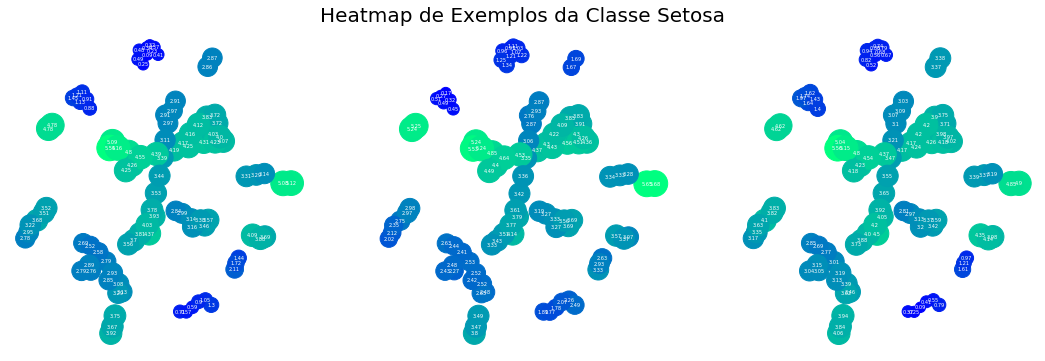

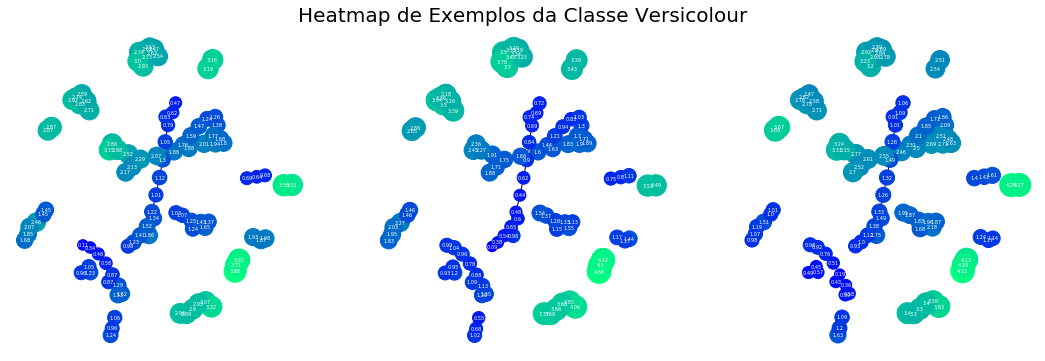

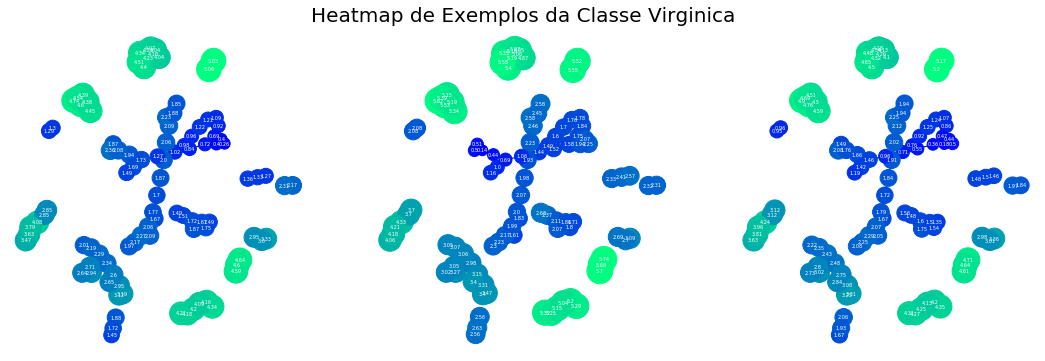

In [17]:
plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, iris_X[0]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da Classe Setosa',      fontsize=20)
hem = heatmap(neural_gas.graph.nodes, iris_X[12]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, iris_X[48]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.show()

plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, iris_X[66]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da Classe Versicolour', fontsize=20)
hem = heatmap(neural_gas.graph.nodes, iris_X[83]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, iris_X[90]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.show()

plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, iris_X[100]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da Classe Virginica', fontsize=20)
hem = heatmap(neural_gas.graph.nodes, iris_X[122]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, iris_X[144]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

O Hit Map mostra a quantidade de exemplos que tiveram cada neurônio como o seu BMU (Best Matching Unit, neurônio com a menor distância entre seus pesos e um exemplo). 

Apesar dos resultados observados nos heat maps, não houverám exemplos de classes diferentes que tiveram o mesmo neurônio como BMU, o que mostra que os exemplos de classes diferentes estão sendo mapeados para regiões diferentes do mapa. Pode ser observado também que houve uma grande quantidade de neurônios que não foram escolhidos como (BMU) por nenhum exemplo do dataset, isso pode indicar que esta sendo utilizado um número muito grande de neurônios.

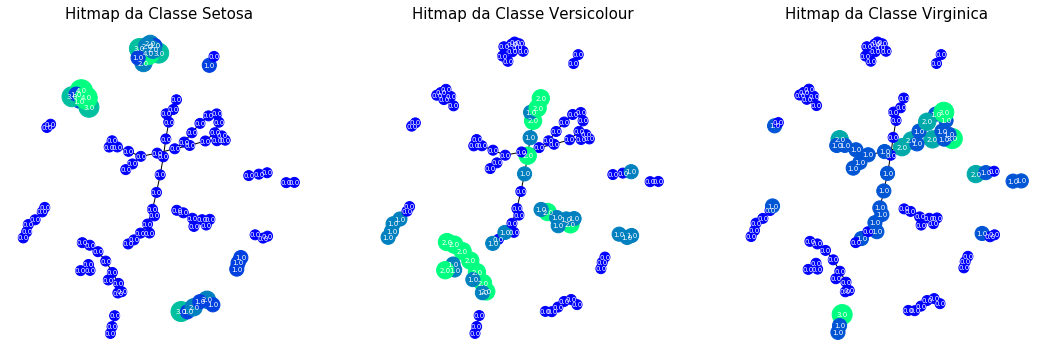

In [18]:
plt.figure(figsize=(25, 6))
plt.subplot(141)
plt.title('Hitmap da Classe Setosa',      fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), iris_X[iris_Y==0]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')

plt.subplot(142)
plt.title('Hitmap da Classe Versicolour', fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), iris_X[iris_Y==1]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')

plt.subplot(143)
plt.title('Hitmap da Classe Virginica', fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), iris_X[iris_Y==2]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')

Abaixo e mostrada adaptação da u-matrix implementada (que nesse caso é um grafo) para o dataset iris. Nela pode ser observado a distância dos pesos de um neurônio e seus vizinhos.

Pode ser observado que a maioria dos neuronios esta próximo de seus vizinhos, com poucas exeções, fato que também pode ter sido acasionado devido a grande quantidade de neurônios. 

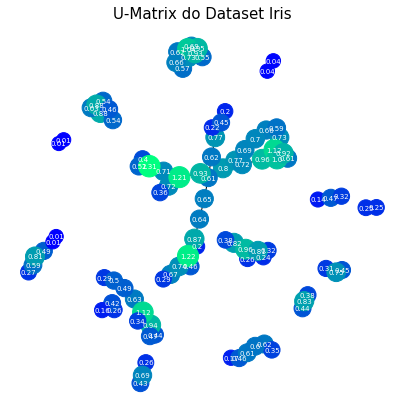

In [19]:
plt.figure(figsize=(7, 7))
plt.title('U-Matrix do Dataset Iris',      fontsize=15)
um = u_matrix(neural_gas.graph.nodes, decode_edges(neural_gas.graph)) 
print_graph(g, pos, labels=True, values=um.round(decimals=2), base=200, multiplier=200, font_size=7, color_map = 'winter')

### Dataset 2:  breast cancer wisconsin dataset

In [22]:
def loadBCWD():
    BCWD = load_breast_cancer()
    return BCWD.data, BCWD.target
BCWD_X, BCWD_Y = loadBCWD()

In [23]:
BCWD_X = Normalize(BCWD_X)

In [ ]:
results = grid_search(parameters, BCWD_X)

In [71]:
BCWD_results =pd.DataFrame.from_dict(results)
export_csv = BCWD_results.to_csv(r'results/GNG/BCWD_grid_search.csv', index = None, header=True)

A tabela a seguir mostra os dez melhores modelos de acordo com o erro de quantização para o breast cancer wisconsin dataset. 

Foi obtido um erro quantitativo e topográfico maior que no dataset Iris o que pode indicar que se trata de um dataset mais desafiador.

Em relação a idade máxima da aresta, iterações para adição de neuronios, e número máximo de neurônios permitidos, foram obtidos resultados similares aos do dataset Iris, obtendo a mesma melhor configuração para a rede.

In [72]:
BCWD_results_table = pd.read_csv('results/GNG/BCWD_grid_search_sample.csv')
BCWD_results_table

max_edge_age  n_iter_before_neuron_added  max_nodes  quantization_error  \
0            25                          25        100            2.309837   
1            25                          75        100            2.313912   
2            25                          50        100            2.320018   
3            25                         100        100            2.323174   
4            50                          50        100            2.385716   
5            50                         100        100            2.392604   
6            50                          75        100            2.396287   
7            50                          25        100            2.405775   
8            75                          25        100            2.424233   
9            75                          75        100            2.429177   

   topographical_error  quantization_error_std  topographical_error_std  
0             0.031634                0.007059                 0.002870  
1             0.044523                0.010359                 0.006471  
2             0.035149                0.006683                 0.010045  
3             0.039250                0.007095                 0.000828  
4             0.022261                0.009113                 0.007364  
5             0.024019                0.009432                 0.002192  
6             0.018161                0.005280                 0.000828  
7             0.023433                0.002533                 0.008160  
8             0.017575                0.007091                 0.002485  
9             0.018161                0.011539                 0.000828

O modelo com os seguintes hiperparâmetros foi definido como o mehor por estar obter o menor erro quantitativo.

In [73]:
BCWD_results_table.loc[[0]]

max_edge_age  n_iter_before_neuron_added  max_nodes  quantization_error  \
0            25                          25        100            2.309837   

   topographical_error  quantization_error_std  topographical_error_std  
0             0.031634                0.007059                  0.00287

A seguir é mostrado novamente o erro de quantização e topográfico do melhor modelo.

In [24]:
neural_gas = GrowingNeuralGas(n_inputs=len(BCWD_X[0]),
                              shuffle_data=True,
                              max_edge_age=25,
                              n_iter_before_neuron_added=25,
                              max_nodes=100)
neural_gas.fit( BCWD_X, 100 )

GrowingNeuralGas(verbose=False, step=0.2, show_epoch=1, shuffle_data=True, signals=None, n_inputs=30, n_start_nodes=2, neighbour_step=0.05, max_edge_age=25, max_nodes=100, n_iter_before_neuron_added=25, after_split_error_decay_rate=0.5, error_decay_rate=0.995, min_distance_for_update=0.0)

In [25]:
print('Erro de quantização =', quantization_error(neural_gas.graph, BCWD_X))
print('Erro Topografico =', topographical_error(neural_gas.graph, BCWD_X))
g, pos = generate_graph( adjacency_matrix(decode_edges(neural_gas.graph), neural_gas.graph.n_nodes) )

Erro de quantização = 2.2943284870746035
Erro Topografico = 0.043936731107205626


A seguir é apresentado o Heat Map para três exemplos de cada classe, onde pode ser observado que a distância é similar para a maioria dos neuronios, sendo similar para ambas as classes.

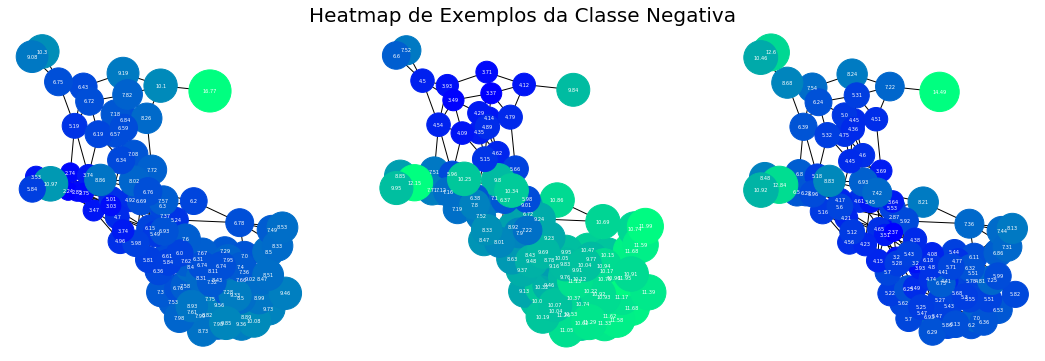

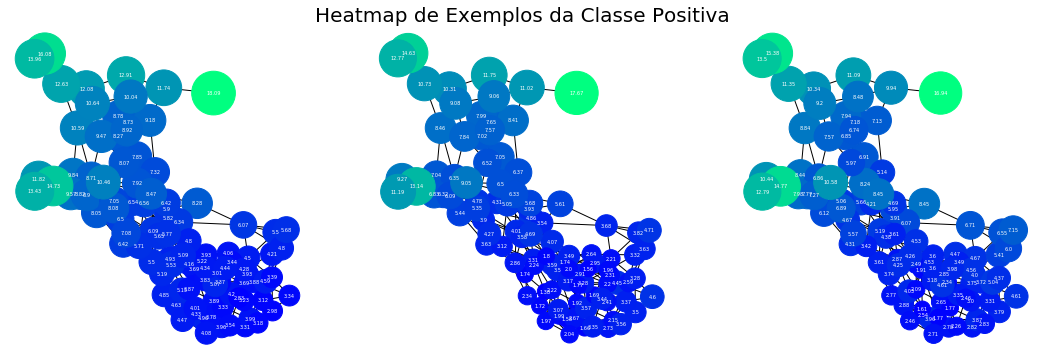

In [26]:
plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, BCWD_X[8]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da Classe Negativa',      fontsize=20)
hem = heatmap(neural_gas.graph.nodes, BCWD_X[250]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, BCWD_X[566]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.show()

plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, BCWD_X[37]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da Classe Positiva', fontsize=20)
hem = heatmap(neural_gas.graph.nodes, BCWD_X[249]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, BCWD_X[486]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')



O Hit Map mostra que apesar do heat map ser semelhante para as duas classes, exemplos de classes diferêntes, em sua grande maioria, estão sendo mapeados para regiões diferêntes do mapa. Deve ser observado, no entanto que aparenta haver uma região próxima do centro, onde exemplos de ambas as classes estão sendo mapeadas, o que mostra novamente que esse dataset e mais desafiador.

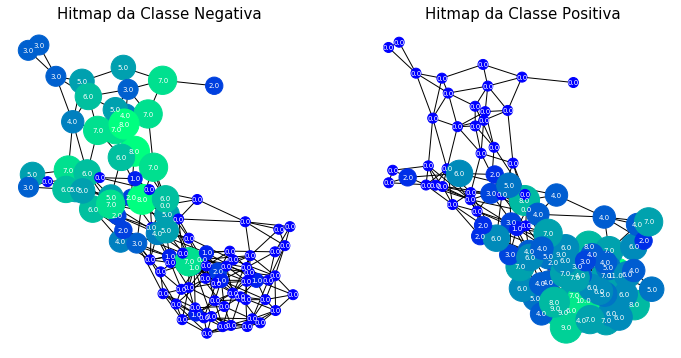

In [27]:
plt.figure(figsize=(25, 6))
plt.subplot(141)
plt.title('Hitmap da Classe Negativa', fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), BCWD_X[BCWD_Y==0]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')

plt.subplot(142)
plt.title('Hitmap da Classe Positiva', fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), BCWD_X[BCWD_Y==1]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')


A u-matrix mostra qye existem diversos nós proximos de seus vizinhos e um número menor com que esta mais distânte de seus vizinhos. 

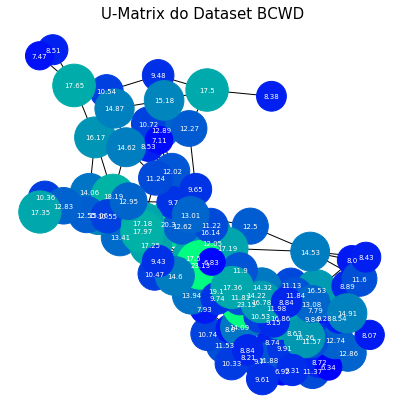

In [29]:
plt.figure(figsize=(7, 7))
plt.title('U-Matrix do Dataset BCWD', fontsize=15)
um = u_matrix(neural_gas.graph.nodes, decode_edges(neural_gas.graph)) 
print_graph(g, pos, labels=True, values=um.round(decimals=2), base=50, multiplier=100, font_size=7, color_map = 'winter')

### Dataset 3:  Alcohol QCM Sensor Dataset Data Set

In [80]:
def loadQCM():
    QCM3  = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM3.csv', sep=';', header=0)
    QCM3['MIP'] = 1.0
    QCM3['NP']  = 1.0
    QCM6  = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM6.csv', sep=';', header=0)
    QCM6['MIP'] = 1.0
    QCM6['NP']  = 0.0
    QCM7  = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM7.csv', sep=';', header=0)
    QCM7['MIP'] = 1.0
    QCM7['NP']  = 0.5
    QCM10 = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM10.csv', sep=';', header=0)
    QCM10['MIP'] = 1.0
    QCM10['NP']  = 2.0
    QCM12 = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM12.csv', sep=';', header=0)
    QCM12['MIP'] = 0.0
    QCM12['NP']  = 1.0
    QCM = pd.concat([QCM3,QCM6,QCM7,QCM10,QCM12], ignore_index=True)
    QCM_X = np.concatenate( [np.array(QCM)[:,0:10], np.array(QCM)[:,15:17]], axis=1)
    QCM_Y_OneHot = np.array(QCM)[:,10:15]
    
    QCM_Y = np.zeros(len(QCM_Y_OneHot))
    for i in range(len(QCM_Y_OneHot)):
        for j in range(len(QCM_Y_OneHot[i])):
            if QCM_Y_OneHot[i,j] == 1:
                QCM_Y[i] = j
                break
    
    return QCM_X, QCM_Y
    
QCM_X, QCM_Y = loadQCM()

In [81]:
QCM_X = Normalize(QCM_X)

In [ ]:
results = grid_search(parameters, QCM_X)

In [83]:
QCM_results =pd.DataFrame.from_dict(results)
export_csv = QCM_results.to_csv(r'results/GNG/QCM_grid_search.csv', index = None, header=True)

A tabela abaixo apresenta os 10 melhores resultados de acordo com o erro quantitativo para o  Alcohol QCM Sensor Dataset Data Set.

Foi obtido um erro quantitativo baixo e erro topográfico de 0 para todos os melhores resultados.

Em relação a idade máxima da aresta e número máximo de neurônios permitidos, foram obtidos resultados similares aos dois datasets anteriores, chegando ao mesmo valor ótimo para esses hiperparâmetros.

Já para o número de iterações para adicionar um novo neorônio, para esse dataset, a rede aparenta favorecer valores mais altos, sendo 75 o número de iterações que obteve os melhores resultados.

In [84]:
QCM_results_table = pd.read_csv('results/GNG/QCM_grid_search_sample.csv')
QCM_results_table

max_edge_age  n_iter_before_neuron_added  max_nodes  quantization_error  \
0            25                          75        100            0.042994   
1            25                         100        100            0.043304   
2            25                          50        100            0.043318   
3            25                          25        100            0.043456   
4            50                         100        100            0.045210   
5            50                          75        100            0.045847   
6            50                          25        100            0.047676   
7            50                          50        100            0.047981   
8            75                         100        100            0.050233   
9            75                          75        100            0.051093   

   topographical_error  quantization_error_std  topographical_error_std  
0                    0                0.000588                        0  
1                    0                0.000996                        0  
2                    0                0.000842                        0  
3                    0                0.001424                        0  
4                    0                0.002428                        0  
5                    0                0.001935                        0  
6                    0                0.000315                        0  
7                    0                0.000548                        0  
8                    0                0.001166                        0  
9                    0                0.000938                        0

O seguinte modelo foi definido como o mehor por obter o menor erro de quantização.

In [85]:
QCM_results_table.loc[[0]]

max_edge_age  n_iter_before_neuron_added  max_nodes  quantization_error  \
0            25                          75        100            0.042994   

   topographical_error  quantization_error_std  topographical_error_std  
0                    0                0.000588                        0

A seguir é mostrado novamente o erro de quantização e topográfico do melhor modelo, podendo ser observado que foi obtido um resultado baixo em ambos.

In [ ]:
neural_gas = GrowingNeuralGas(n_inputs=len(QCM_X[0]),
                              shuffle_data=True,
                              verbose=True,
                              max_edge_age=25,
                              n_iter_before_neuron_added=75,
                              max_nodes=100)
neural_gas.fit( QCM_X, 100 )

In [87]:
print('Erro de quantização =', quantization_error(neural_gas.graph, QCM_X))
print('Erro Topografico =', topographical_error(neural_gas.graph, QCM_X))
g, pos = generate_graph( adjacency_matrix(decode_edges(neural_gas.graph), neural_gas.graph.n_nodes) )

Erro de quantização = 0.04495251073240867
Erro Topografico = 0.0


A seguir é apresentado o Heat Map para três exemplos de cada classe. Pode ser observado que exemplos de classes diferentes apresentam uma distância baixa para diversos grupos de nós mapa. Algumas classes aparentam possuir mapas similares, enquanto outras são bem distintas.

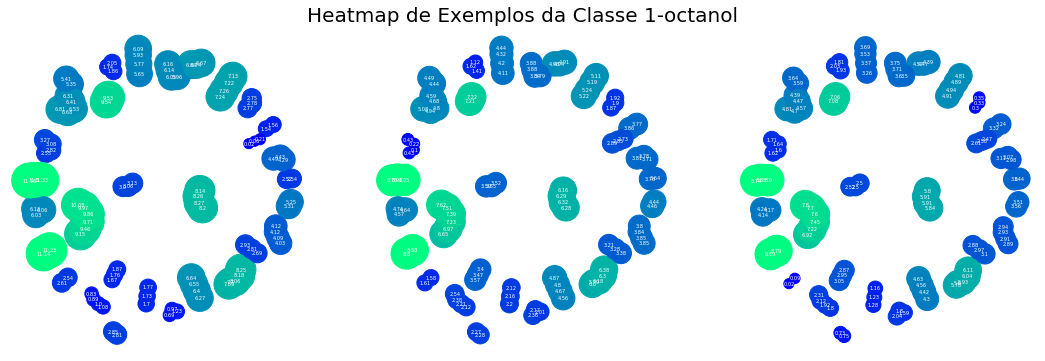

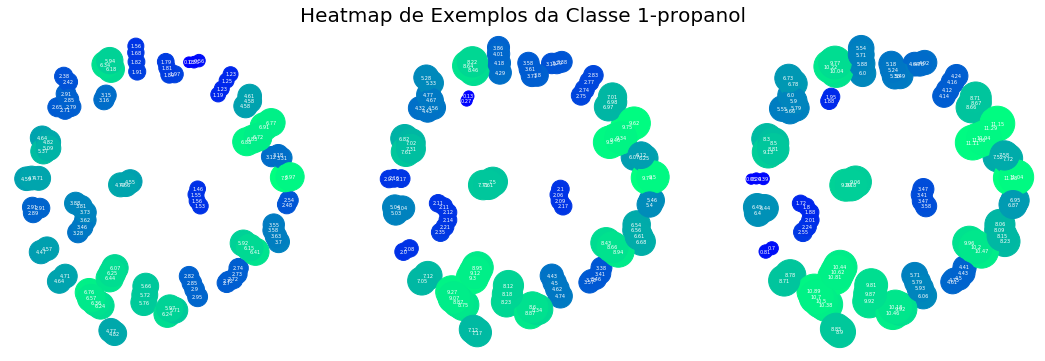

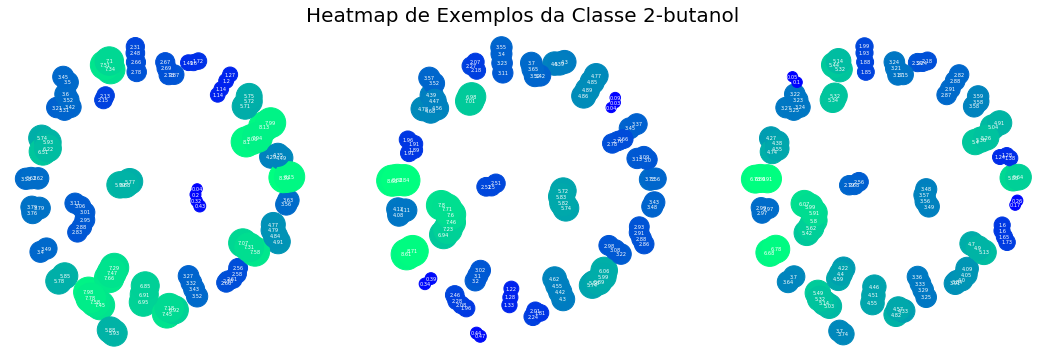

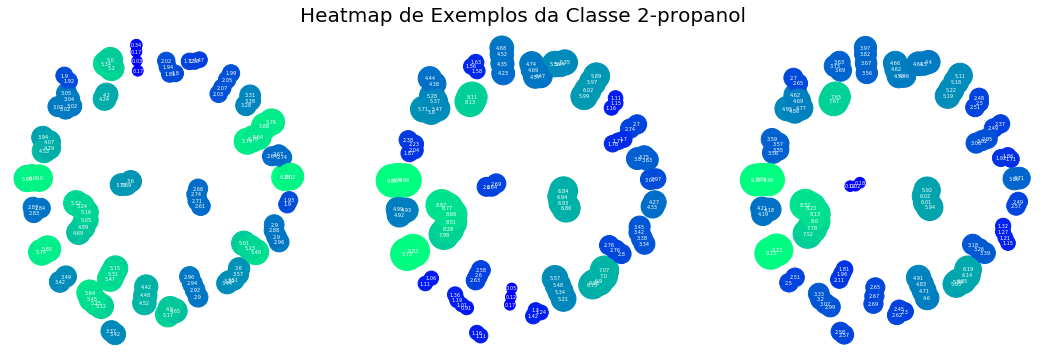

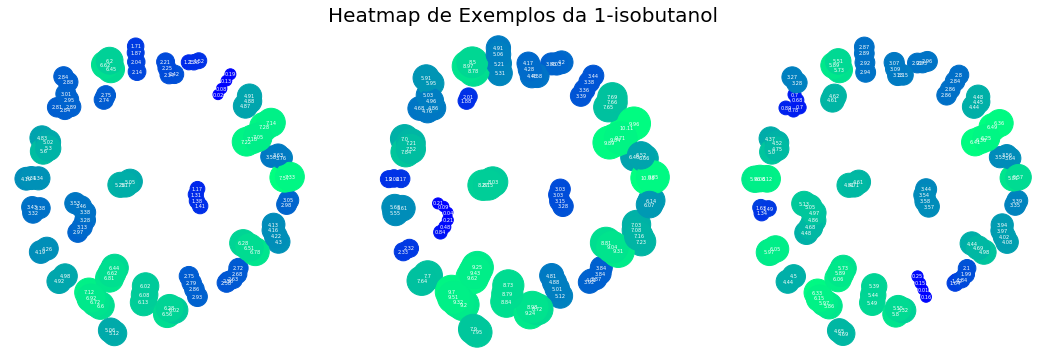

In [88]:
plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, QCM_X[0]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da Classe 1-octanol',      fontsize=20)
hem = heatmap(neural_gas.graph.nodes, QCM_X[28]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, QCM_X[73]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.show()

plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, QCM_X[5]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da Classe 1-propanol', fontsize=20)
hem = heatmap(neural_gas.graph.nodes, QCM_X[30]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, QCM_X[35]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.show()

plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, QCM_X[10]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da Classe 2-butanol', fontsize=20)
hem = heatmap(neural_gas.graph.nodes, QCM_X[62]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, QCM_X[87]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.show()

plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, QCM_X[17]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da Classe 2-propanol', fontsize=20)
hem = heatmap(neural_gas.graph.nodes, QCM_X[65]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, QCM_X[92]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.show()

plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, QCM_X[24]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da 1-isobutanol', fontsize=20)
hem = heatmap(neural_gas.graph.nodes, QCM_X[48]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, QCM_X[121]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

O Hit Map mostra que as classes estão sendo mapeadas para neurônios diferêntes no mapa, no entanto, assim como no dataset Iris, é possível observar que há diversos neurônios que não foram escolhidos como BMU por nenhum exemplo no dataset, o que pode ocorrer devido a um exesso de neurônios sendo utilizado e/ou devido há pequena quantidade de exemplos nesse dataset.

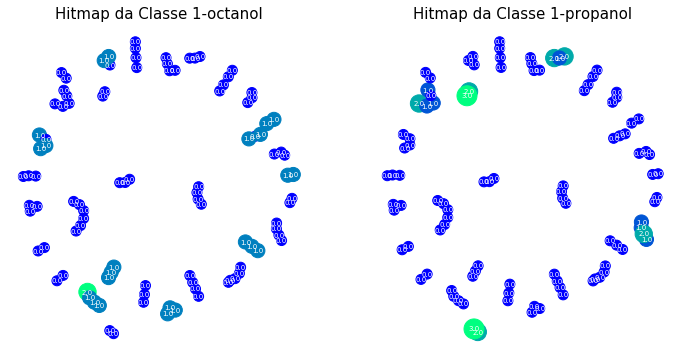

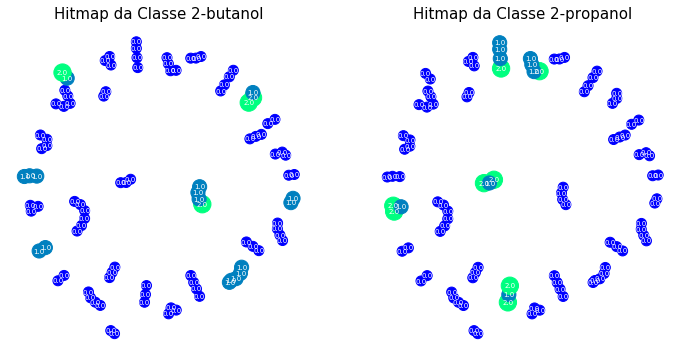

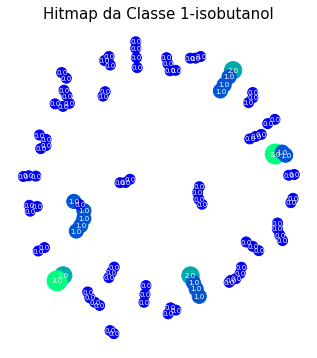

In [92]:
plt.figure(figsize=(25, 6))
plt.subplot(141)
plt.title('Hitmap da Classe 1-octanol',      fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), QCM_X[QCM_Y==0]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')

plt.subplot(142)
plt.title('Hitmap da Classe 1-propanol', fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), QCM_X[QCM_Y==1]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')

plt.show()
plt.figure(figsize=(25, 6))

plt.subplot(141)
plt.title('Hitmap da Classe 2-butanol', fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), QCM_X[QCM_Y==2]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')


plt.subplot(142)
plt.title('Hitmap da Classe 2-propanol', fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), QCM_X[QCM_Y==3]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')

plt.show()
plt.figure(figsize=(25, 6))


plt.subplot(141)
plt.title('Hitmap da Classe 1-isobutanol', fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), QCM_X[QCM_Y==4]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')


A U-Matrix a seguir mostra que nesse dataset, os neuronios conectados um ao outro possuem uma baixa distância entre si.

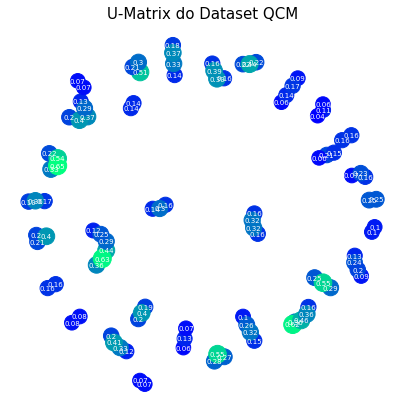

In [93]:
plt.figure(figsize=(7, 7))
plt.title('U-Matrix do Dataset QCM',      fontsize=15)
um = u_matrix(neural_gas.graph.nodes, decode_edges(neural_gas.graph)) 
print_graph(g, pos, labels=True, values=um.round(decimals=2), base=200, multiplier=200, font_size=7, color_map = 'winter')

## Conclusões


De modo geral, pode ser observadoque foi possivel obter boas representações para os datasets utilizando a rede GNG. 

Para os dataset Iris e QCM foi observado que poucos neuronios estavam sendo escolhidos como BMU, o que pode indicar que foram utilizados uma quantidade muito grande de neurônios para representar os dados, apesar dos melhores resultados terem sido obtidos com as redes com o maior quantidade de neurônios permitida para todos os datasets.

Para todos os datasets, o menor número de iterações para remover uma aresta foi considerado melhor. Já para o número de iterações necessárias para adicionar um novo exemplo, os datasets Iris e BCWD deram preferência para o valor mais baixo testado, enquanto o dataset QCM obteve seu melhor resultado com um valor mais alto.

O dataset BCWD obteve resultados de erro de quantização mais alto e em seu hitmap aparentava ter uma região onde exemplos de classes diferêntes estavam sendo mapeados para os mesmo neuronio, mostrando-se um dataset mais desafiador. Para os demais datasets, os exemplos de classes diferêntes foram mapeados para neurônios diferêntes da rede.